In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# spacy for lemmatization
import spacy
import json
import warnings
import networkx as nx

warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
nltk.download('stopwords')
nltk.download('words')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.corpus import words
eng_words = words.words('en')

from langdetect import detect
# to enforce consistent results, check github langdetect readme
from langdetect import DetectorFactory
DetectorFactory.seed = 0


import os 

import requests

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheesan_manokaran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/matheesan_manokaran/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
count = 0
array = []
def getTextFromJson():
    global count
    for file in os.listdir('tweetFiles'):
        print(file)
        if count < 200:
            with open('tweetFiles/' + file, "r") as f:
                for line in f:
                    for key, value in json.loads(line).items():
                        if(key =="text"):
                            # get english tweets
                            try:
                                if (detect(value)=="en"):
                                    # print (detect(value))
                                    array.append(value)
                            except:
                                pass
        count = count + 1

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

getTextFromJson()

print("FINI")

57 (4).json
49 (2).json
51.json
13 (2).json
46.json
61.json
04 (2).json
47.json
15.json
02 (2).json
10 (4).json
45.json
12.json
28.json
57.json
12 (3).json
59 (3).json
27.json
09.json
10 (2).json
14 (3).json
56 (3).json
25.json
34.json
38 (4).json
54.json
42.json
32 (2).json
21.json
29 (2).json
41 (3).json
04.json
14 (2).json
24 (2).json
60.json
45 (3).json
09 (2).json
40 (2).json
44 (2).json
20 (2).json
15 (3).json
07 (3).json
52.json
55 (4).json
06.json
17 (2).json
55 (2).json
42 (3).json
58 (3).json
29.json
01 (2).json
58 (2).json
38 (2).json
52 (3).json
10.json
06 (2).json
23.json
25 (2).json
05.json
24 (3).json
24.json
45 (2).json
47 (2).json
23 (3).json
01 (3).json
17.json
06 (3).json
46 (3).json
13 (3).json
28 (2).json
40.json
38.json
00 (3).json
22 (3).json
04 (4).json
49 (3).json
22 (2).json
36 (2).json
32.json
19 (3).json
39 (3).json
42 (2).json
01.json
40 (4).json
34 (3).json
27 (2).json
59 (2).json
15 (2).json
19 (2).json
16 (3).json
43 (3).json
21 (2).json
11 (2).json
33.j

In [3]:
data = array

# Remove links
data = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove hashtag
data = [re.sub("#", "", sent) for sent in data]

#remove non-ascii characters need to fix leaves blank lines
#data = [re.sub(r'[^\x00-\x7F]+','', sent) for sent in data]

def remove_non_english_words(tweets):
     return [[word for word in simple_preprocess(str(tweet)) if word in eng_words] for tweet in tweets]

def remove_empty_sent(tweets) :
    res = []
    for tweet in tweets:
        if len(tweet) != 0:
            res.append(tweet)
    return res

#data = remove_non_english_words(data)

data = remove_empty_sent(data)

print("PLS")


PLS


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


data_words = list(sent_to_words(data))

data_words_no_stp = remove_stopwords(data_words)


print(data_words_no_stp[:1])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[['private', 'travel', 'mixing', 'personal', 'political', 'biz', 'coziness', 'alleged', 'scam', 'pacs', 'keep', 'secretaryzinke', 'scandals']]


In [ ]:

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_no_stp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

In [ ]:
with open('preprocesseddata.txt', 'w') as f:
    for row in data_lemmatized:
        f.write("%s\n" % row)

In [ ]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

# Build LDA model
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=6, passes=10, workers=7)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_no_stp, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)


[[('allege', 1), ('biz', 1), ('coziness', 1), ('keep', 1), ('mix', 1), ('pac', 1), ('personal', 1), ('political', 1), ('private', 1), ('scam', 1), ('scandal', 1), ('secretaryzinke', 1), ('travel', 1)]]
[(0,
  '0.028*"not" + 0.025*"be" + 0.017*"do" + 0.014*"get" + 0.011*"go" + '
  '0.009*"people" + 0.009*"know" + 0.007*"fuck" + 0.006*"amp" + 0.006*"say"'),
 (1,
  '0.009*"trump" + 0.005*"get" + 0.005*"amp" + 0.005*"new" + 0.004*"live" + '
  '0.004*"make" + 0.004*"go" + 0.004*"life" + 0.004*"video" + 0.003*"think"'),
 (2,
  '0.009*"s" + 0.008*"get" + 0.007*"halloween" + 0.005*"bts" + 0.005*"happy" + '
  '0.005*"love" + 0.005*"make" + 0.004*"little" + 0.003*"go" + 0.003*"man"'),
 (3,
  '0.024*"astro" + 0.022*"world" + 0.013*"series" + 0.012*"houston" + '
  '0.011*"worldserie" + 0.011*"win" + 0.010*"time" + 0.010*"dodger" + '
  '0.009*"first" + 0.009*"champion"'),
 (4,
  '0.015*"good" + 0.010*"amp" + 0.010*"love" + 0.005*"music" + 0.004*"much" + '
  '0.003*"time" + 0.003*"thank" + 0.003*"st

In [ ]:

# Visualize the topics
#pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA_Visualization.html')


#mallet_path = 'home\\ragulan550\\pythonTest\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet' # update this path
# print(mallet_path)
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)
# # Show Topics
# pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)


/home/matheesan_manokaran/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(row) 
        topics = []
        row = sorted(row, key=lambda x: (x[1]), reverse=True) 
        for j, (topic_num, prop_topic) in enumerate(row):
            if j in [0,1,2]: 
                topics.append(topic_num)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topics, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

[(0, 0.011948987), (1, 0.011978336), (2, 0.31405836), (3, 0.0119095), (4, 0.011945936), (5, 0.6381589)]
[(0, 0.028052254), (1, 0.027915815), (2, 0.8596563), (3, 0.028251251), (4, 0.028080858), (5, 0.028043518)]
[(0, 0.03387429), (1, 0.83111715), (2, 0.03371162), (3, 0.033556208), (4, 0.034235127), (5, 0.033505548)]
[(0, 0.016924901), (1, 0.1829919), (2, 0.18621902), (3, 0.28130636), (4, 0.3156395), (5, 0.016918315)]
[(0, 0.011981233), (1, 0.011981408), (2, 0.011926835), (3, 0.01191199), (4, 0.011966667), (5, 0.94023186)]
[(0, 0.6013498), (1, 0.027906908), (2, 0.02783791), (3, 0.027828673), (4, 0.287209), (5, 0.027867725)]
[(0, 0.46111158), (1, 0.40736696), (2, 0.011923002), (3, 0.09561603), (4, 0.012033873), (5, 0.011948553)]
[(0, 0.015234381), (1, 0.015192545), (2, 0.015174813), (3, 0.015183655), (4, 0.015532875), (5, 0.9236818)]
[(0, 0.03344493), (1, 0.033394776), (2, 0.03333867), (3, 0.03340257), (4, 0.03347762), (5, 0.8329414)]
[(0, 0.6032889), (1, 0.018600913), (2, 0.3223701), (3,

[(0, 0.012959741), (1, 0.012908371), (2, 0.012855957), (3, 0.93543375), (4, 0.012924393), (5, 0.012917823)]
[(0, 0.027820477), (1, 0.027781546), (2, 0.028103955), (3, 0.02784945), (4, 0.86022526), (5, 0.028219273)]
[(0, 0.021045817), (1, 0.021184996), (2, 0.5578115), (3, 0.020950869), (4, 0.3579632), (5, 0.021043604)]
[(0, 0.46935654), (1, 0.016919192), (2, 0.01675649), (3, 0.01679051), (4, 0.22989252), (5, 0.2502848)]
[(0, 0.04208029), (1, 0.041700676), (2, 0.21024984), (3, 0.041836478), (4, 0.6224582), (5, 0.041674532)]
[(0, 0.033550005), (1, 0.83260214), (2, 0.033391383), (3, 0.033407684), (4, 0.033635896), (5, 0.033412952)]
[(0, 0.8231886), (1, 0.012909034), (2, 0.12535419), (3, 0.012835904), (4, 0.012835334), (5, 0.012876905)]
[(0, 0.76888084), (1, 0.016911102), (2, 0.016767528), (3, 0.016721494), (4, 0.016798344), (5, 0.1639207)]
[(0, 0.014017083), (1, 0.49152556), (2, 0.013955701), (3, 0.013974444), (4, 0.013990704), (5, 0.4525365)]
[(0, 0.6351279), (1, 0.01863257), (2, 0.018553

[(0, 0.024410916), (1, 0.63927317), (2, 0.023961011), (3, 0.024562199), (4, 0.02386046), (5, 0.2639323)]
[(0, 0.020900281), (1, 0.3221117), (2, 0.021052253), (3, 0.28819495), (4, 0.020917293), (5, 0.32682353)]
[(0, 0.033334017), (1, 0.03333433), (2, 0.03333486), (3, 0.03333446), (4, 0.83332795), (5, 0.033334337)]
[(0, 0.028052209), (1, 0.0279158), (2, 0.85966706), (3, 0.028240614), (4, 0.028080812), (5, 0.028043479)]
[(0, 0.041974586), (1, 0.628031), (2, 0.0419188), (3, 0.042203374), (4, 0.041691028), (5, 0.2041812)]
[(0, 0.024132917), (1, 0.35196355), (2, 0.023968155), (3, 0.5519519), (4, 0.023975123), (5, 0.024008377)]
[(0, 0.018584093), (1, 0.20555532), (2, 0.01872012), (3, 0.018606193), (4, 0.40524274), (5, 0.3332916)]
[(0, 0.930228), (1, 0.013970395), (2, 0.013978372), (3, 0.0139679685), (4, 0.0139088975), (5, 0.01394635)]
[(0, 0.08333335), (1, 0.08333336), (2, 0.08333434), (3, 0.08354296), (4, 0.08333496), (5, 0.583121)]
[(0, 0.83258426), (1, 0.033456556), (2, 0.033648822), (3, 0

[(0, 0.24296126), (1, 0.020886837), (2, 0.020855932), (3, 0.67349035), (4, 0.020921005), (5, 0.020884614)]
[(0, 0.0152416965), (1, 0.015284919), (2, 0.24181674), (3, 0.015172795), (4, 0.015263593), (5, 0.69722027)]
[(0, 0.0833366), (1, 0.08333785), (2, 0.08333996), (3, 0.5833081), (4, 0.08333944), (5, 0.083338104)]
[(0, 0.33938533), (1, 0.32454327), (2, 0.018576661), (3, 0.018683307), (4, 0.018579377), (5, 0.2802321)]
[(0, 0.01666688), (1, 0.016666964), (2, 0.016667102), (3, 0.01666702), (4, 0.9166651), (5, 0.01666698)]
[(0, 0.91636926), (1, 0.016780872), (2, 0.016733697), (3, 0.016706888), (4, 0.016705256), (5, 0.016704082)]
[(0, 0.58705664), (1, 0.041762814), (2, 0.04177786), (3, 0.04200351), (4, 0.04175622), (5, 0.24564297)]
[(0, 0.024131812), (1, 0.024100175), (2, 0.023919938), (3, 0.87926084), (4, 0.02433023), (5, 0.024257043)]
[(0, 0.011974739), (1, 0.011999394), (2, 0.011960876), (3, 0.9400663), (4, 0.0119944615), (5, 0.012004243)]
[(0, 0.041967854), (1, 0.04166788), (2, 0.04166

[(0, 0.5462151), (1, 0.0209243), (2, 0.021007597), (3, 0.36979944), (4, 0.021024387), (5, 0.021029137)]
[(0, 0.14699574), (1, 0.17335974), (2, 0.018534511), (3, 0.018659592), (4, 0.018575761), (5, 0.62387466)]
[(0, 0.6835606), (1, 0.02109101), (2, 0.02104276), (3, 0.020919178), (4, 0.020987524), (5, 0.23239896)]
[(0, 0.033771556), (1, 0.033456255), (2, 0.033519782), (3, 0.033535395), (4, 0.033425894), (5, 0.8322911)]
[(0, 0.42459857), (1, 0.020938694), (2, 0.020931814), (3, 0.49165577), (4, 0.020881338), (5, 0.02099379)]
[(0, 0.102361105), (1, 0.21905623), (2, 0.015208184), (3, 0.0154235475), (4, 0.63271767), (5, 0.015233225)]
[(0, 0.54838747), (1, 0.24056816), (2, 0.015375075), (3, 0.16506836), (4, 0.015251616), (5, 0.015349298)]
[(0, 0.7744154), (1, 0.02089392), (2, 0.020852467), (3, 0.14168143), (4, 0.021019842), (5, 0.021136992)]
[(0, 0.012878382), (1, 0.012886899), (2, 0.012836174), (3, 0.012868317), (4, 0.93561995), (5, 0.012910315)]
[(0, 0.012878476), (1, 0.0128886), (2, 0.01283

[(0, 0.01677674), (1, 0.91629916), (2, 0.016738357), (3, 0.016746188), (4, 0.016710956), (5, 0.016728552)]
[(0, 0.010503566), (1, 0.40846074), (2, 0.010500414), (3, 0.40902042), (4, 0.1507964), (5, 0.010718508)]
[(0, 0.5234717), (1, 0.027786484), (2, 0.0278206), (3, 0.027889565), (4, 0.02781354), (5, 0.36521807)]
[(0, 0.7405672), (1, 0.015270487), (2, 0.015207038), (3, 0.0154107725), (4, 0.015195846), (5, 0.19834863)]
[(0, 0.012848273), (1, 0.9356793), (2, 0.012837803), (3, 0.012855469), (4, 0.012884333), (5, 0.012894852)]
[(0, 0.7016148), (1, 0.020948643), (2, 0.020882333), (3, 0.021199742), (4, 0.020983927), (5, 0.2143706)]
[(0, 0.016810048), (1, 0.39013705), (2, 0.37645492), (3, 0.01681809), (4, 0.18302147), (5, 0.016758434)]
[(0, 0.033342633), (1, 0.033374723), (2, 0.03335983), (3, 0.83309823), (4, 0.033419654), (5, 0.033404887)]
[(0, 0.016884666), (1, 0.35708648), (2, 0.016692638), (3, 0.016761666), (4, 0.016773118), (5, 0.57580143)]
[(0, 0.015229494), (1, 0.9237627), (2, 0.015221

[(0, 0.016698955), (1, 0.016764421), (2, 0.01685581), (3, 0.016716857), (4, 0.91620696), (5, 0.016757037)]
[(0, 0.018519128), (1, 0.018519364), (2, 0.018519757), (3, 0.018519523), (4, 0.018519662), (5, 0.9074026)]
[(0, 0.71620375), (1, 0.02385866), (2, 0.02400555), (3, 0.023834525), (4, 0.18820302), (5, 0.023894502)]
[(0, 0.013946808), (1, 0.013901598), (2, 0.013915397), (3, 0.5137922), (4, 0.013919638), (5, 0.43052435)]
[(0, 0.018674975), (1, 0.90703654), (2, 0.01860734), (3, 0.018528378), (4, 0.018575165), (5, 0.018577568)]
[(0, 0.033503942), (1, 0.35339564), (2, 0.03363963), (3, 0.033517618), (4, 0.033754952), (5, 0.5121882)]
[(0, 0.010477135), (1, 0.0104383165), (2, 0.010457655), (3, 0.010450438), (4, 0.94773763), (5, 0.01043882)]
[(0, 0.055555608), (1, 0.055555627), (2, 0.055555657), (3, 0.05555564), (4, 0.7222218), (5, 0.055555638)]
[(0, 0.0334973), (1, 0.56871754), (2, 0.033398397), (3, 0.29742417), (4, 0.03337529), (5, 0.03358723)]
[(0, 0.016922979), (1, 0.9161234), (2, 0.01668

[(0, 0.023865497), (1, 0.0239895), (2, 0.023936749), (3, 0.023929344), (4, 0.023809746), (5, 0.8804692)]
[(0, 0.08333366), (1, 0.08333379), (2, 0.08333401), (3, 0.08333388), (4, 0.58333087), (5, 0.08333381)]
[(0, 0.8321312), (1, 0.03347401), (2, 0.03347043), (3, 0.033704706), (4, 0.03352518), (5, 0.03369443)]
[(0, 0.8957005), (1, 0.020866089), (2, 0.020868305), (3, 0.020844791), (4, 0.020833813), (5, 0.02088652)]
[(0, 0.83294743), (1, 0.03344402), (2, 0.033396356), (3, 0.033358492), (4, 0.033409256), (5, 0.033444457)]
[(0, 0.016685527), (1, 0.28647995), (2, 0.4971881), (3, 0.016673898), (4, 0.016798977), (5, 0.16617355)]
[(0, 0.71962565), (1, 0.05749208), (2, 0.055782173), (3, 0.05573557), (4, 0.05575743), (5, 0.05560711)]
[(0, 0.38497868), (1, 0.01192492), (2, 0.5670473), (3, 0.012041204), (4, 0.012065214), (5, 0.011942706)]
[(0, 0.042176276), (1, 0.5413345), (2, 0.041783337), (3, 0.29100448), (4, 0.041715853), (5, 0.04198552)]
[(0, 0.859731), (1, 0.02838518), (2, 0.02821113), (3, 0.0

[(0, 0.01521068), (1, 0.015283879), (2, 0.015183076), (3, 0.015282468), (4, 0.015193568), (5, 0.9238463)]
[(0, 0.8332246), (1, 0.03334445), (2, 0.033333387), (3, 0.033352196), (4, 0.033343457), (5, 0.033401884)]
[(0, 0.7754917), (1, 0.17292547), (2, 0.012857561), (3, 0.01284055), (4, 0.012872516), (5, 0.013012197)]
[(0, 0.79165834), (1, 0.041667935), (2, 0.04166914), (3, 0.041668218), (4, 0.041668378), (5, 0.041668013)]
[(0, 0.40391704), (1, 0.5121454), (2, 0.021016235), (3, 0.020864306), (4, 0.020956783), (5, 0.021100229)]
[(0, 0.011957912), (1, 0.13527748), (2, 0.0119238915), (3, 0.011942038), (4, 0.011922348), (5, 0.8169763)]
[(0, 0.013034453), (1, 0.2601446), (2, 0.687823), (3, 0.012949117), (4, 0.013075397), (5, 0.012973449)]
[(0, 0.020897826), (1, 0.021054758), (2, 0.020839589), (3, 0.15297216), (4, 0.41750315), (5, 0.36673248)]
[(0, 0.03343352), (1, 0.8325154), (2, 0.033410322), (3, 0.033541076), (4, 0.033712678), (5, 0.03338698)]
[(0, 0.021129796), (1, 0.5159131), (2, 0.0210043

[(0, 0.40706712), (1, 0.018645933), (2, 0.18950851), (3, 0.018559042), (4, 0.34763658), (5, 0.018582795)]
[(0, 0.05628371), (1, 0.055743575), (2, 0.05580784), (3, 0.7196114), (4, 0.05664119), (5, 0.055912267)]
[(0, 0.90671754), (1, 0.018620571), (2, 0.018618915), (3, 0.018606616), (4, 0.018645154), (5, 0.018791256)]
[(0, 0.055555582), (1, 0.055555593), (2, 0.72222203), (3, 0.0555556), (4, 0.055555608), (5, 0.055555597)]
[(0, 0.0140990615), (1, 0.3654269), (2, 0.013999976), (3, 0.15673035), (4, 0.43578187), (5, 0.013961859)]
[(0, 0.042220112), (1, 0.041890036), (2, 0.46795586), (3, 0.04184687), (4, 0.3642928), (5, 0.041794296)]
[(0, 0.8953166), (1, 0.020992951), (2, 0.020882979), (3, 0.020880735), (4, 0.020933127), (5, 0.020993581)]
[(0, 0.021057017), (1, 0.021147141), (2, 0.020838058), (3, 0.89480895), (4, 0.021082968), (5, 0.021065919)]
[(0, 0.79118747), (1, 0.041838832), (2, 0.04167411), (3, 0.041690372), (4, 0.041734368), (5, 0.041874785)]
[(0, 0.055592116), (1, 0.055729564), (2, 0.

[(0, 0.86073405), (1, 0.02783899), (2, 0.027861347), (3, 0.02789951), (4, 0.027820766), (5, 0.027845295)]
[(0, 0.02818439), (1, 0.028076498), (2, 0.02796977), (3, 0.027999915), (4, 0.028082078), (5, 0.8596873)]
[(0, 0.2866442), (1, 0.015225993), (2, 0.015198574), (3, 0.015258711), (4, 0.6524029), (5, 0.015269649)]
[(0, 0.8603407), (1, 0.028253065), (2, 0.027831905), (3, 0.027896322), (4, 0.027859611), (5, 0.027818376)]
[(0, 0.041733347), (1, 0.7915009), (2, 0.041666783), (3, 0.04166698), (4, 0.04170305), (5, 0.04172894)]
[(0, 0.03350205), (1, 0.03366069), (2, 0.57386535), (3, 0.03345965), (4, 0.2920911), (5, 0.033421166)]
[(0, 0.21399547), (1, 0.015674885), (2, 0.015279453), (3, 0.015274343), (4, 0.01518717), (5, 0.72458863)]
[(0, 0.55449414), (1, 0.018638957), (2, 0.018551951), (3, 0.21961927), (4, 0.01860179), (5, 0.17009392)]
[(0, 0.021061258), (1, 0.37899804), (2, 0.398368), (3, 0.020964418), (4, 0.15952736), (5, 0.021080911)]
[(0, 0.012954568), (1, 0.9354451), (2, 0.012872631), (3

[(0, 0.014041315), (1, 0.93010885), (2, 0.013958871), (3, 0.013935931), (4, 0.013935885), (5, 0.01401915)]
[(0, 0.08333486), (1, 0.5833211), (2, 0.08333645), (3, 0.08333586), (4, 0.083336204), (5, 0.08333558)]
[(0, 0.03333692), (1, 0.033333547), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.033466842), (1, 0.03350169), (2, 0.033334345), (3, 0.033427577), (4, 0.83283365), (5, 0.03343586)]
[(0, 0.041910347), (1, 0.516469), (2, 0.31588805), (3, 0.041715164), (4, 0.041851), (5, 0.042166468)]
[(0, 0.024052924), (1, 0.024138616), (2, 0.023901103), (3, 0.8799674), (4, 0.023986584), (5, 0.023953378)]
[(0, 0.0555556), (1, 0.055768024), (2, 0.30976033), (3, 0.4677075), (4, 0.055603977), (5, 0.05560458)]
[(0, 0.016676312), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672315)]
[(0, 0.291627), (1, 0.0416667), (2, 0.041666716), (3, 0.5417056), (4, 0.041667253), (5, 0.0416667)]
[(0, 0.90675133), (1, 0.018588237), (2, 0.018542556), (3, 0

[(0, 0.014063988), (1, 0.014053148), (2, 0.013953745), (3, 0.0139999455), (4, 0.92988634), (5, 0.014042844)]
[(0, 0.3191627), (1, 0.5688296), (2, 0.028167708), (3, 0.028093576), (4, 0.027878841), (5, 0.02786758)]
[(0, 0.020864358), (1, 0.020854004), (2, 0.020853844), (3, 0.8956405), (4, 0.020861946), (5, 0.020925349)]
[(0, 0.033430196), (1, 0.033334047), (2, 0.033347145), (3, 0.033335064), (4, 0.83320004), (5, 0.033353537)]
[(0, 0.04168611), (1, 0.041667443), (2, 0.79160523), (3, 0.041676592), (4, 0.041667894), (5, 0.041696724)]
[(0, 0.018669909), (1, 0.018702682), (2, 0.018529134), (3, 0.9069541), (4, 0.018543914), (5, 0.018600216)]
[(0, 0.018552499), (1, 0.018882304), (2, 0.018532716), (3, 0.018525023), (4, 0.7726101), (5, 0.15289733)]
[(0, 0.015339339), (1, 0.32074907), (2, 0.015294238), (3, 0.015171355), (4, 0.61818165), (5, 0.015264336)]
[(0, 0.01048111), (1, 0.010518823), (2, 0.010447664), (3, 0.010450518), (4, 0.94757605), (5, 0.010525797)]
[(0, 0.0153697245), (1, 0.015379056), 

[(0, 0.015196994), (1, 0.92347986), (2, 0.015425867), (3, 0.015378352), (4, 0.015255451), (5, 0.015263474)]
[(0, 0.044280373), (1, 0.041708738), (2, 0.04168558), (3, 0.7887054), (4, 0.041692857), (5, 0.041927014)]
[(0, 0.015305702), (1, 0.11246166), (2, 0.01518421), (3, 0.7146), (4, 0.015179682), (5, 0.12726873)]
[(0, 0.013971139), (1, 0.014007543), (2, 0.014036442), (3, 0.5215944), (4, 0.013948799), (5, 0.42244166)]
[(0, 0.014112173), (1, 0.013995274), (2, 0.013915857), (3, 0.24020511), (4, 0.70370877), (5, 0.0140627995)]
[(0, 0.023925321), (1, 0.024040375), (2, 0.024034223), (3, 0.6020389), (4, 0.30189016), (5, 0.024071017)]
[(0, 0.7213957), (1, 0.05561951), (2, 0.05568214), (3, 0.05618641), (4, 0.055558503), (5, 0.0555578)]
[(0, 0.012841051), (1, 0.01286613), (2, 0.012932274), (3, 0.517708), (4, 0.43082362), (5, 0.012828943)]
[(0, 0.055629287), (1, 0.7213342), (2, 0.055556197), (3, 0.055615652), (4, 0.056089673), (5, 0.055774927)]
[(0, 0.72071713), (1, 0.056058362), (2, 0.05567975),

[(0, 0.83283883), (1, 0.033473127), (2, 0.033396762), (3, 0.033507735), (4, 0.033362668), (5, 0.033420827)]
[(0, 0.54306674), (1, 0.39611265), (2, 0.01520348), (3, 0.015226204), (4, 0.0151633825), (5, 0.015227577)]
[(0, 0.020881526), (1, 0.4920406), (2, 0.021137072), (3, 0.42421016), (4, 0.020876046), (5, 0.020854585)]
[(0, 0.011178381), (1, 0.011130134), (2, 0.011168302), (3, 0.011156517), (4, 0.011141014), (5, 0.9442256)]
[(0, 0.40831938), (1, 0.48023024), (2, 0.027884504), (3, 0.027914817), (4, 0.027817598), (5, 0.02783343)]
[(0, 0.041667096), (1, 0.04166725), (2, 0.041667525), (3, 0.291948), (4, 0.041667536), (5, 0.5413826)]
[(0, 0.9581577)]
[(0, 0.024192357), (1, 0.87928426), (2, 0.024428586), (3, 0.024174487), (4, 0.023821145), (5, 0.024099212)]
[(0, 0.012035273), (1, 0.37390217), (2, 0.42228702), (3, 0.1677541), (4, 0.012008258), (5, 0.012013164)]
[(0, 0.265505), (1, 0.05604155), (2, 0.055780903), (3, 0.51086956), (4, 0.055921346), (5, 0.055881593)]
[(0, 0.04197163), (1, 0.04194

[(0, 0.014010426), (1, 0.6536954), (2, 0.013967205), (3, 0.0139545165), (4, 0.29032913), (5, 0.014043295)]
[(0, 0.33816716), (1, 0.024021242), (2, 0.024021069), (3, 0.02409635), (4, 0.5657392), (5, 0.023954986)]
[(0, 0.013897341), (1, 0.013899597), (2, 0.013894755), (3, 0.9304497), (4, 0.013896742), (5, 0.013961834)]
[(0, 0.01415674), (1, 0.014092064), (2, 0.49562535), (3, 0.44800997), (4, 0.014051005), (5, 0.014064911)]
[(0, 0.45388407), (1, 0.01880703), (2, 0.47122854), (3, 0.01874381), (4, 0.018541062), (5, 0.018795528)]
[(0, 0.014156304), (1, 0.014056884), (2, 0.0139588015), (3, 0.013976091), (4, 0.48415637), (5, 0.45969558)]
[(0, 0.9507871)]
[(0, 0.35813636), (1, 0.32614487), (2, 0.015187406), (3, 0.015276817), (4, 0.015232435), (5, 0.27002206)]
[(0, 0.020890152), (1, 0.020894725), (2, 0.020903282), (3, 0.020892983), (4, 0.020922322), (5, 0.89549655)]
[(0, 0.033389308), (1, 0.033484764), (2, 0.033343036), (3, 0.033355065), (4, 0.49583894), (5, 0.37058896)]
[(0, 0.04166672), (1, 0.

[(0, 0.041666694), (1, 0.04168432), (2, 0.22293787), (3, 0.6097325), (4, 0.042026468), (5, 0.041952174)]
[(0, 0.40722626), (1, 0.03338799), (2, 0.03346856), (3, 0.45890242), (4, 0.033583723), (5, 0.03343106)]
[(0, 0.4124673), (1, 0.51325876), (2, 0.01857145), (3, 0.018566666), (4, 0.018551342), (5, 0.018584488)]
[(0, 0.020846603), (1, 0.7054613), (2, 0.020982604), (3, 0.020862514), (4, 0.02085221), (5, 0.21099477)]
[(0, 0.4213004), (1, 0.20712493), (2, 0.010427603), (3, 0.3402176), (4, 0.010468483), (5, 0.010461003)]
[(0, 0.033333343), (1, 0.033333343), (2, 0.03333335), (3, 0.8333332), (4, 0.033333402), (5, 0.033333354)]
[(0, 0.014141371), (1, 0.014046352), (2, 0.013985143), (3, 0.013980872), (4, 0.52882487), (5, 0.41502142)]
[(0, 0.03333692), (1, 0.033333547), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.033334572), (1, 0.03333486), (2, 0.2288646), (3, 0.6377948), (4, 0.033336226), (5, 0.033334948)]
[(0, 0.018567909), (1, 0.018654238), (2, 0.018526481), 

[(0, 0.08333391), (1, 0.08333413), (2, 0.08333451), (3, 0.58332884), (4, 0.083334416), (5, 0.08333418)]
[(0, 0.012979689), (1, 0.93527263), (2, 0.01287027), (3, 0.012903854), (4, 0.012998134), (5, 0.012975396)]
[(0, 0.041666668), (1, 0.041723613), (2, 0.041675504), (3, 0.79156196), (4, 0.041668538), (5, 0.04170366)]
[(0, 0.02811422), (1, 0.027977994), (2, 0.027812198), (3, 0.027896428), (4, 0.027994124), (5, 0.860205)]
[(0, 0.5379235), (1, 0.041732103), (2, 0.29511544), (3, 0.041733615), (4, 0.041666806), (5, 0.041828543)]
[(0, 0.023825137), (1, 0.023825562), (2, 0.023830086), (3, 0.8808452), (4, 0.02382732), (5, 0.023846705)]
[(0, 0.023835914), (1, 0.023815913), (2, 0.023812214), (3, 0.88089436), (4, 0.023824584), (5, 0.02381696)]
[(0, 0.033670384), (1, 0.033554174), (2, 0.033404358), (3, 0.8325264), (4, 0.03339044), (5, 0.033454206)]
[(0, 0.6505086), (1, 0.012849549), (2, 0.012851771), (3, 0.29779792), (4, 0.012977311), (5, 0.013014881)]
[(0, 0.832067), (1, 0.033554062), (2, 0.033494

[(0, 0.024099315), (1, 0.023867661), (2, 0.15592143), (3, 0.7483451), (4, 0.02388841), (5, 0.023878064)]
[(0, 0.03378067), (1, 0.033476118), (2, 0.32434967), (3, 0.033604976), (4, 0.033418126), (5, 0.5413705)]
[(0, 0.016915897), (1, 0.016829787), (2, 0.016787833), (3, 0.01668665), (4, 0.016688025), (5, 0.91609186)]
[(0, 0.033336923), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.012926907), (1, 0.21594492), (2, 0.102283284), (3, 0.012843965), (4, 0.6431099), (5, 0.012891001)]
[(0, 0.106671214), (1, 0.020898726), (2, 0.020837698), (3, 0.80990744), (4, 0.020833766), (5, 0.020851202)]
[(0, 0.015223894), (1, 0.015176881), (2, 0.015165245), (3, 0.92404926), (4, 0.01519767), (5, 0.015187016)]
[(0, 0.023833068), (1, 0.8808713), (2, 0.023810213), (3, 0.023816649), (4, 0.023857964), (5, 0.023810778)]
[(0, 0.021069678), (1, 0.020925378), (2, 0.021712923), (3, 0.89431167), (4, 0.021003958), (5, 0.020976435)]
[(0, 0.0153132165), (1, 0.015180602), (2, 

[(0, 0.055707972), (1, 0.055712048), (2, 0.05569416), (3, 0.056029264), (4, 0.05562942), (5, 0.7212271)]
[(0, 0.012902155), (1, 0.6680811), (2, 0.01285081), (3, 0.09820099), (4, 0.012949908), (5, 0.19501501)]
[(0, 0.013997954), (1, 0.013906089), (2, 0.110523336), (3, 0.8336968), (4, 0.013951607), (5, 0.013924222)]
[(0, 0.86037326), (1, 0.027866999), (2, 0.027832078), (3, 0.027836038), (4, 0.028230382), (5, 0.027861247)]
[(0, 0.04172925), (1, 0.041794673), (2, 0.041746225), (3, 0.7908747), (4, 0.041946456), (5, 0.041908678)]
[(0, 0.056665566), (1, 0.05589655), (2, 0.055926178), (3, 0.72014904), (4, 0.05564558), (5, 0.05571707)]
[(0, 0.05576758), (1, 0.055640623), (2, 0.4014164), (3, 0.05555573), (4, 0.05555636), (5, 0.37606332)]
[(0, 0.02391513), (1, 0.023866652), (2, 0.26411211), (3, 0.5548793), (4, 0.10937351), (5, 0.023853298)]
[(0, 0.19384085), (1, 0.014048476), (2, 0.35467252), (3, 0.013992146), (4, 0.40944657), (5, 0.013999447)]
[(0, 0.02415883), (1, 0.8800966), (2, 0.023956824), 

[(0, 0.04180487), (1, 0.041727394), (2, 0.041696664), (3, 0.5142659), (4, 0.042042032), (5, 0.3184632)]
[(0, 0.021330716), (1, 0.34124118), (2, 0.020870244), (3, 0.57471496), (4, 0.020992216), (5, 0.020850658)]
[(0, 0.90716225), (1, 0.018670358), (2, 0.018551271), (3, 0.018535784), (4, 0.018535184), (5, 0.018545179)]
[(0, 0.015372834), (1, 0.015468994), (2, 0.01521064), (3, 0.2532822), (4, 0.68534803), (5, 0.015317294)]
[(0, 0.055555582), (1, 0.055555627), (2, 0.05559432), (3, 0.7221623), (4, 0.05557659), (5, 0.05555558)]
[(0, 0.018518526), (1, 0.018518642), (2, 0.01851854), (3, 0.9074069), (4, 0.0185188), (5, 0.018518528)]
[(0, 0.24943046), (1, 0.011952953), (2, 0.11204779), (3, 0.43103895), (4, 0.18359204), (5, 0.011937781)]
[(0, 0.015162173), (1, 0.015170968), (2, 0.015164942), (3, 0.92414355), (4, 0.0151883075), (5, 0.015170089)]
[(0, 0.012029205), (1, 0.1525549), (2, 0.011986655), (3, 0.79934317), (4, 0.012093963), (5, 0.011992094)]
[(0, 0.01667631), (1, 0.016671345), (2, 0.016668

[(0, 0.083336994), (1, 0.08333841), (2, 0.08334078), (3, 0.08333937), (4, 0.0833402), (5, 0.5833042)]
[(0, 0.8321347), (1, 0.033474), (2, 0.033470415), (3, 0.03370553), (4, 0.033525154), (5, 0.033690136)]
[(0, 0.083336584), (1, 0.083337836), (2, 0.083339944), (3, 0.5833081), (4, 0.08333942), (5, 0.08333809)]
[(0, 0.04169006), (1, 0.22138686), (2, 0.04176819), (3, 0.041668136), (4, 0.042088587), (5, 0.61139816)]
[(0, 0.020842126), (1, 0.020834658), (2, 0.020835057), (3, 0.6383265), (4, 0.27832732), (5, 0.02083435)]
[(0, 0.83272725), (1, 0.03339667), (2, 0.033373415), (3, 0.033370532), (4, 0.03349272), (5, 0.033639394)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809547), (3, 0.880952), (4, 0.023809755), (5, 0.023809528)]
[(0, 0.011223566), (1, 0.8244027), (2, 0.011142539), (3, 0.011236116), (4, 0.13072807), (5, 0.011266994)]
[(0, 0.042363342), (1, 0.042744234), (2, 0.041666742), (3, 0.7892132), (4, 0.04205432), (5, 0.041958123)]
[(0, 0.9160557), (1, 0.016795337), (2, 0.016714666), (3,

[(0, 0.04166667), (1, 0.041723616), (2, 0.041675508), (3, 0.7915621), (4, 0.04166854), (5, 0.041703634)]
[(0, 0.8954308), (1, 0.020880625), (2, 0.02093304), (3, 0.021002902), (4, 0.020845644), (5, 0.020907035)]
[(0, 0.016772566), (1, 0.016910072), (2, 0.54280895), (3, 0.39003533), (4, 0.016740052), (5, 0.01673297)]
[(0, 0.04166667), (1, 0.04168692), (2, 0.04166667), (3, 0.7916464), (4, 0.041666698), (5, 0.041666668)]
[(0, 0.055734996), (1, 0.05555727), (2, 0.055620417), (3, 0.05565007), (4, 0.056832567), (5, 0.72060466)]
[(0, 0.21559715), (1, 0.011212627), (2, 0.011134495), (3, 0.22174634), (4, 0.5291295), (5, 0.011179886)]
[(0, 0.02090906), (1, 0.02089195), (2, 0.020907957), (3, 0.89555323), (4, 0.020849787), (5, 0.020888055)]
[(0, 0.5442434), (1, 0.027948104), (2, 0.0279034), (3, 0.3439522), (4, 0.027993215), (5, 0.02795966)]
[(0, 0.4848347), (1, 0.012002933), (2, 0.4671297), (3, 0.011941428), (4, 0.012121604), (5, 0.011969636)]
[(0, 0.024284855), (1, 0.02397597), (2, 0.023877623), (

[(0, 0.033336923), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.9240227), (1, 0.015181332), (2, 0.015159844), (3, 0.015167284), (4, 0.015174164), (5, 0.015294715)]
[(0, 0.66297364), (1, 0.014035512), (2, 0.014017907), (3, 0.013948734), (4, 0.014018074), (5, 0.2810062)]
[(0, 0.020834062), (1, 0.8958275), (2, 0.020834815), (3, 0.020834533), (4, 0.0208347), (5, 0.0208344)]
[(0, 0.2166127), (1, 0.7090567), (2, 0.018549003), (3, 0.018576892), (4, 0.018589852), (5, 0.018614842)]
[(0, 0.027792834), (1, 0.027778773), (2, 0.027778907), (3, 0.6944461), (4, 0.027805338), (5, 0.19439806)]
[(0, 0.034054242), (1, 0.8317149), (2, 0.033529844), (3, 0.033358343), (4, 0.03362086), (5, 0.03372182)]
[(0, 0.42183343), (1, 0.0169275), (2, 0.016723944), (3, 0.5107329), (4, 0.016943375), (5, 0.016838856)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.46744537), (1, 0.016904067), (2, 0.46511152),

[(0, 0.016666675), (1, 0.016666718), (2, 0.016669571), (3, 0.9166583), (4, 0.016671907), (5, 0.01666678)]
[(0, 0.03333692), (1, 0.033333547), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.61584026), (1, 0.023846557), (2, 0.28881875), (3, 0.023829777), (4, 0.023825232), (5, 0.023839438)]
[(0, 0.03339265), (1, 0.03339373), (2, 0.83289754), (3, 0.033349764), (4, 0.033437792), (5, 0.033528533)]
[(0, 0.8952724), (1, 0.020975921), (2, 0.020981774), (3, 0.020910278), (4, 0.020986296), (5, 0.020873385)]
[(0, 0.6395757), (1, 0.018823294), (2, 0.018596776), (3, 0.018727675), (4, 0.2857347), (5, 0.018541774)]
[(0, 0.40623), (1, 0.48247382), (2, 0.027812466), (3, 0.027857192), (4, 0.027811684), (5, 0.027814843)]
[(0, 0.9158851), (1, 0.016721811), (2, 0.016889937), (3, 0.016758662), (4, 0.016832914), (5, 0.016911648)]
[(0, 0.015263178), (1, 0.015190647), (2, 0.015182343), (3, 0.9238681), (4, 0.015227523), (5, 0.015268198)]
[(0, 0.05563456), (1, 0.05567339), (2, 0.05560

[(0, 0.024334941), (1, 0.024021646), (2, 0.8797307), (3, 0.0239175), (4, 0.023944063), (5, 0.024051115)]
[(0, 0.018523773), (1, 0.018532107), (2, 0.018535763), (3, 0.90732557), (4, 0.018559234), (5, 0.01852355)]
[(0, 0.018526405), (1, 0.018539853), (2, 0.18386787), (3, 0.7419098), (4, 0.018625328), (5, 0.018530669)]
[(0, 0.04166667), (1, 0.04172355), (2, 0.041675508), (3, 0.79156214), (4, 0.04166854), (5, 0.041703638)]
[(0, 0.014068629), (1, 0.013919025), (2, 0.013909345), (3, 0.93025017), (4, 0.013927173), (5, 0.01392565)]
[(0, 0.041835986), (1, 0.041666996), (2, 0.2912791), (3, 0.5418838), (4, 0.041667297), (5, 0.041666772)]
[(0, 0.033443578), (1, 0.03334912), (2, 0.33394474), (3, 0.5325617), (4, 0.0333646), (5, 0.03333622)]
[(0, 0.021172795), (1, 0.020916602), (2, 0.41264606), (3, 0.020878905), (4, 0.50349164), (5, 0.02089404)]
[(0, 0.055951912), (1, 0.055661783), (2, 0.05557838), (3, 0.05592285), (4, 0.72113943), (5, 0.055745672)]
[(0, 0.4590464), (1, 0.015384051), (2, 0.015223307)

[(0, 0.45003414), (1, 0.014096496), (2, 0.013949334), (3, 0.49376372), (4, 0.014181527), (5, 0.013974757)]
[(0, 0.041666668), (1, 0.04172358), (2, 0.041675504), (3, 0.791562), (4, 0.041668538), (5, 0.04170363)]
[(0, 0.08907581), (1, 0.020834196), (2, 0.020833429), (3, 0.8275871), (4, 0.020834967), (5, 0.02083444)]
[(0, 0.04178738), (1, 0.04168239), (2, 0.041773222), (3, 0.79129744), (4, 0.04171822), (5, 0.041741394)]
[(0, 0.020977661), (1, 0.6571399), (2, 0.020988716), (3, 0.25907713), (4, 0.020919595), (5, 0.020897023)]
[(0, 0.028059667), (1, 0.027981497), (2, 0.02802744), (3, 0.42772794), (4, 0.02793551), (5, 0.46026793)]
[(0, 0.012012596), (1, 0.70842093), (2, 0.011945364), (3, 0.011961252), (4, 0.24346973), (5, 0.012190109)]
[(0, 0.02091284), (1, 0.02092749), (2, 0.020926759), (3, 0.020859033), (4, 0.020975968), (5, 0.8953979)]
[(0, 0.018525608), (1, 0.018522557), (2, 0.018521193), (3, 0.9073837), (4, 0.018528199), (5, 0.018518701)]
[(0, 0.023951208), (1, 0.024151796), (2, 0.170988

[(0, 0.034231525), (1, 0.033403836), (2, 0.03358724), (3, 0.033642653), (4, 0.8312542), (5, 0.033880554)]
[(0, 0.015167501), (1, 0.92359716), (2, 0.015491783), (3, 0.015182198), (4, 0.015362131), (5, 0.0151992235)]
[(0, 0.940022), (1, 0.012046733), (2, 0.011912615), (3, 0.011939877), (4, 0.011962778), (5, 0.0121160215)]
[(0, 0.768614), (1, 0.16457964), (2, 0.016683774), (3, 0.016678918), (4, 0.016698282), (5, 0.016745407)]
[(0, 0.018900217), (1, 0.19433469), (2, 0.018643228), (3, 0.018563617), (4, 0.73048663), (5, 0.01907158)]
[(0, 0.015162171), (1, 0.015170967), (2, 0.015164941), (3, 0.92414373), (4, 0.015188117), (5, 0.015170083)]
[(0, 0.027964428), (1, 0.027842091), (2, 0.44274053), (3, 0.44536638), (4, 0.028233282), (5, 0.027853256)]
[(0, 0.02777779), (1, 0.027778087), (2, 0.027777815), (3, 0.86111045), (4, 0.027778106), (5, 0.027777784)]
[(0, 0.018525608), (1, 0.018522557), (2, 0.018521193), (3, 0.9073837), (4, 0.018528199), (5, 0.018518701)]
[(0, 0.015256288), (1, 0.9235811), (2,

[(0, 0.012900854), (1, 0.9355166), (2, 0.012837511), (3, 0.01285839), (4, 0.012899823), (5, 0.012986882)]
[(0, 0.013930277), (1, 0.013907704), (2, 0.013916798), (3, 0.646518), (4, 0.29780415), (5, 0.013923093)]
[(0, 0.05605248), (1, 0.055854112), (2, 0.056040853), (3, 0.05626048), (4, 0.05576684), (5, 0.72002524)]
[(0, 0.8182945), (1, 0.012881681), (2, 0.012840147), (3, 0.013022714), (4, 0.13012645), (5, 0.012834491)]
[(0, 0.028189158), (1, 0.027871488), (2, 0.028407378), (3, 0.8597774), (4, 0.027807372), (5, 0.02794727)]
[(0, 0.012893311), (1, 0.013016849), (2, 0.012965628), (3, 0.012923341), (4, 0.012866692), (5, 0.9353342)]
[(0, 0.6017133), (5, 0.358782)]
[(0, 0.720421), (1, 0.055867393), (2, 0.055630535), (3, 0.055824164), (4, 0.056296334), (5, 0.055960607)]
[(0, 0.012931158), (1, 0.4549931), (2, 0.012989519), (3, 0.012928216), (4, 0.012860248), (5, 0.49329776)]
[(0, 0.02385847), (1, 0.023809569), (2, 0.023847083), (3, 0.8806166), (4, 0.023993237), (5, 0.023875052)]
[(0, 0.08333598

[(0, 0.041733254), (1, 0.7915093), (2, 0.04166831), (3, 0.041666996), (4, 0.04169344), (5, 0.041728657)]
[(0, 0.018694006), (1, 0.90695244), (2, 0.018741967), (3, 0.018518707), (4, 0.018541737), (5, 0.018551195)]
[(0, 0.663305), (1, 0.024037093), (2, 0.2406964), (3, 0.0239337), (4, 0.023857286), (5, 0.024170522)]
[(0, 0.72124237), (1, 0.05577217), (2, 0.055622596), (3, 0.056118608), (4, 0.055591274), (5, 0.055652995)]
[(0, 0.8327912), (1, 0.033464525), (2, 0.0333756), (3, 0.03341154), (4, 0.033422563), (5, 0.033534534)]
[(0, 0.7915334), (1, 0.04166683), (2, 0.041667797), (3, 0.041667085), (4, 0.041695192), (5, 0.041769728)]
[(0, 0.46108848), (1, 0.016736679), (2, 0.01673359), (3, 0.016796878), (4, 0.47193584), (5, 0.016708527)]
[(0, 0.6705738), (1, 0.015286791), (2, 0.015232586), (3, 0.015156891), (4, 0.015228921), (5, 0.26852104)]
[(0, 0.04192329), (1, 0.041920196), (2, 0.041694652), (3, 0.6074566), (4, 0.042152625), (5, 0.22485265)]
[(0, 0.011911971), (1, 0.17510879), (2, 0.011908418

[(0, 0.023998419), (1, 0.024034467), (2, 0.023877826), (3, 0.880322), (4, 0.02384258), (5, 0.023924734)]
[(0, 0.622138), (1, 0.016793713), (2, 0.3106017), (3, 0.016759742), (4, 0.016858209), (5, 0.016848614)]
[(0, 0.013954309), (1, 0.013920404), (2, 0.013914041), (3, 0.57030445), (4, 0.013939018), (5, 0.37396774)]
[(0, 0.28620368), (1, 0.04211963), (2, 0.041992825), (3, 0.041951183), (4, 0.04176259), (5, 0.54597014)]
[(4, 0.95352405)]
[(0, 0.024112957), (1, 0.8790163), (2, 0.024458844), (3, 0.024173452), (4, 0.02435537), (5, 0.023883106)]
[(0, 0.023828233), (1, 0.02383931), (2, 0.023825934), (3, 0.8807248), (4, 0.023859605), (5, 0.023922147)]
[(0, 0.83278453), (1, 0.033399247), (2, 0.033429783), (3, 0.0333709), (4, 0.033386238), (5, 0.03362923)]
[(0, 0.028060785), (1, 0.027870396), (2, 0.027870104), (3, 0.027947458), (4, 0.027866764), (5, 0.86038446)]
[(0, 0.6660019), (1, 0.027874708), (2, 0.027792342), (3, 0.027853929), (4, 0.22258662), (5, 0.027890429)]
[(0, 0.27919775), (1, 0.041860

[(0, 0.9439799), (1, 0.011221038), (2, 0.011162166), (3, 0.011159359), (4, 0.011223168), (5, 0.011254388)]
[(0, 0.042501695), (1, 0.78985786), (2, 0.04182806), (3, 0.042038016), (4, 0.04185526), (5, 0.041919034)]
[(0, 0.03354498), (1, 0.23378308), (2, 0.033341587), (3, 0.033455934), (4, 0.63223064), (5, 0.033643756)]
[(0, 0.023866875), (1, 0.023814827), (2, 0.33054096), (3, 0.024120722), (4, 0.57376873), (5, 0.023887917)]
[(0, 0.018767988), (1, 0.018610133), (2, 0.018582279), (3, 0.90687), (4, 0.018593054), (5, 0.01857649)]
[(0, 0.94781035), (1, 0.010427098), (2, 0.010429305), (3, 0.010439149), (4, 0.010440319), (5, 0.010453777)]
[(0, 0.01668726), (1, 0.01667903), (2, 0.016695755), (3, 0.9165904), (4, 0.016678894), (5, 0.016668689)]
[(0, 0.92999786), (1, 0.013943142), (2, 0.014002767), (3, 0.014045912), (4, 0.013989332), (5, 0.014020962)]
[(0, 0.8396736), (1, 0.014049609), (2, 0.01411403), (3, 0.10398332), (4, 0.013985814), (5, 0.014193648)]
[(0, 0.37818557), (1, 0.010477621), (2, 0.01

[(0, 0.027777793), (1, 0.027777798), (2, 0.027777808), (3, 0.8610969), (4, 0.02779183), (5, 0.027777845)]
[(0, 0.01193047), (1, 0.011922818), (2, 0.011905177), (3, 0.83345485), (4, 0.11886566), (5, 0.011921061)]
[(0, 0.38450867), (1, 0.5485701), (2, 0.016772367), (3, 0.016688028), (4, 0.016720902), (5, 0.016739963)]
[(0, 0.023907099), (1, 0.21908209), (2, 0.66941077), (3, 0.02388143), (4, 0.024225881), (5, 0.039492752)]
[(0, 0.012820769), (1, 0.01298444), (2, 0.012833706), (3, 0.8587822), (4, 0.089691386), (5, 0.012887557)]
[(0, 0.01289509), (1, 0.012900217), (2, 0.012882468), (3, 0.012865185), (4, 0.013031626), (5, 0.9354254)]
[(0, 0.05646202), (1, 0.05570011), (2, 0.05573542), (3, 0.71985215), (4, 0.055831704), (5, 0.056418646)]
[(0, 0.042223725), (1, 0.042003926), (2, 0.041937385), (3, 0.041793384), (4, 0.041807536), (5, 0.7902341)]
[(0, 0.01671715), (1, 0.7636536), (2, 0.016698046), (3, 0.16944434), (4, 0.016787754), (5, 0.01669911)]
[(0, 0.023896715), (1, 0.88048595), (2, 0.023941

[(0, 0.013954309), (1, 0.0139406), (2, 0.013901104), (3, 0.013970901), (4, 0.9302538), (5, 0.013979249)]
[(0, 0.03389891), (1, 0.4318928), (2, 0.03350279), (3, 0.43388742), (4, 0.033353854), (5, 0.03346417)]
[(0, 0.041667968), (1, 0.04166847), (2, 0.041669317), (3, 0.7916565), (4, 0.04166911), (5, 0.041668575)]
[(0, 0.015194536), (1, 0.015178028), (2, 0.015188175), (3, 0.92404807), (4, 0.0151927015), (5, 0.015198508)]
[(0, 0.4316307), (1, 0.033629965), (2, 0.033365827), (3, 0.43400332), (4, 0.033851217), (5, 0.033518963)]
[(0, 0.010451494), (1, 0.13442239), (2, 0.01047923), (3, 0.010422905), (4, 0.82366544), (5, 0.010558553)]
[(0, 0.033653818), (1, 0.83275974), (2, 0.0334426), (3, 0.033386555), (4, 0.033381283), (5, 0.033375982)]
[(0, 0.021007828), (1, 0.89525735), (2, 0.020926118), (3, 0.020894028), (4, 0.020903701), (5, 0.021010967)]
[(0, 0.015316725), (1, 0.92339385), (2, 0.0154810995), (3, 0.015378931), (4, 0.015233373), (5, 0.015196002)]
[(0, 0.86110145), (1, 0.027778963), (2, 0.0

[(0, 0.018715553), (1, 0.018574985), (2, 0.018550135), (3, 0.90702796), (4, 0.018552475), (5, 0.018578878)]
[(0, 0.041688133), (1, 0.04198549), (2, 0.79059774), (3, 0.04180418), (4, 0.04185975), (5, 0.04206464)]
[(0, 0.21600577), (1, 0.013906221), (2, 0.01394976), (3, 0.7282729), (4, 0.013914016), (5, 0.013951304)]
[(0, 0.055713322), (1, 0.055628452), (2, 0.05573785), (3, 0.055614617), (4, 0.72168607), (5, 0.055619687)]
[(0, 0.011948376), (1, 0.011929995), (2, 0.011911652), (3, 0.011940179), (4, 0.94033086), (5, 0.01193897)]
[(0, 0.013959151), (1, 0.013916721), (2, 0.93034595), (3, 0.0139435865), (4, 0.013904731), (5, 0.013929918)]
[(0, 0.011978381), (1, 0.011968945), (2, 0.012001027), (3, 0.011970648), (4, 0.94006383), (5, 0.012017179)]
[(0, 0.02382883), (1, 0.023810107), (2, 0.45140982), (3, 0.02398908), (4, 0.023810413), (5, 0.45315176)]
[(0, 0.04197962), (1, 0.29176432), (2, 0.0416697), (3, 0.25469443), (4, 0.3281744), (5, 0.041717492)]
[(0, 0.19922212), (1, 0.6603843), (2, 0.01193

[(0, 0.015175169), (1, 0.27553713), (2, 0.015224165), (3, 0.08490884), (4, 0.22886066), (5, 0.38029402)]
[(0, 0.40095174), (1, 0.2903668), (2, 0.013991065), (3, 0.014030824), (4, 0.014167278), (5, 0.26649228)]
[(0, 0.02777779), (1, 0.027778087), (2, 0.027777815), (3, 0.86111045), (4, 0.027778106), (5, 0.027777784)]
[(0, 0.016907832), (1, 0.016759958), (2, 0.01669958), (3, 0.9161004), (4, 0.016767334), (5, 0.01676489)]
[(0, 0.0334842), (1, 0.8328647), (2, 0.03336674), (3, 0.0333705), (4, 0.033462144), (5, 0.033451714)]
[(0, 0.020886792), (1, 0.89574325), (2, 0.020840354), (3, 0.020834116), (4, 0.020843383), (5, 0.020852113)]
[(0, 0.61364), (1, 0.033506043), (2, 0.252697), (3, 0.033364456), (4, 0.03337916), (5, 0.03341333)]
[(0, 0.59934866), (1, 0.3043), (2, 0.023945177), (3, 0.024348848), (4, 0.023949528), (5, 0.024107771)]
[(0, 0.027874997), (1, 0.02779965), (2, 0.86070985), (3, 0.027836062), (4, 0.027878473), (5, 0.02790101)]
[(0, 0.02791012), (1, 0.52477735), (2, 0.027882123), (3, 0.

[(0, 0.5832882), (1, 0.08334077), (2, 0.08334424), (3, 0.08334218), (4, 0.083343394), (5, 0.08334119)]
[(0, 0.46729335), (3, 0.49341208)]
[(0, 0.018746544), (1, 0.018715803), (2, 0.018683095), (3, 0.22767669), (4, 0.01863082), (5, 0.697547)]
[(0, 0.47445345), (1, 0.014083616), (2, 0.014044393), (3, 0.014053363), (4, 0.014059365), (5, 0.46930584)]
[(0, 0.3467202), (1, 0.0104494225), (2, 0.09299887), (3, 0.52887535), (4, 0.010475821), (5, 0.010480312)]
[(0, 0.056203786), (1, 0.05573258), (2, 0.055833694), (3, 0.7207015), (4, 0.05572732), (5, 0.05580114)]
[(0, 0.44615883), (1, 0.38666433), (2, 0.041713387), (3, 0.04178156), (4, 0.041689847), (5, 0.04199208)]
[(0, 0.033634387), (1, 0.033634514), (2, 0.033333514), (3, 0.44073763), (4, 0.42508298), (5, 0.033576995)]
[(0, 0.013997142), (1, 0.014082301), (2, 0.013979786), (3, 0.014030772), (4, 0.45347145), (5, 0.49043855)]
[(0, 0.027970696), (1, 0.027794026), (2, 0.028190052), (3, 0.19775967), (4, 0.027810236), (5, 0.6904753)]
[(0, 0.92968994)

[(0, 0.020877086), (1, 0.02088172), (2, 0.020847121), (3, 0.8956449), (4, 0.020869585), (5, 0.02087962)]
[(0, 0.012037736), (1, 0.3730695), (2, 0.06646893), (3, 0.011965291), (4, 0.012110707), (5, 0.5243479)]
[(0, 0.7334814), (1, 0.023878701), (2, 0.02384949), (3, 0.023837974), (4, 0.17104666), (5, 0.023905808)]
[(0, 0.015332692), (1, 0.015173285), (2, 0.0151662715), (3, 0.4513737), (4, 0.37369117), (5, 0.12926288)]
[(0, 0.024139712), (1, 0.023941016), (2, 0.023935376), (3, 0.023954991), (4, 0.023999661), (5, 0.88002926)]
[(0, 0.08333369), (1, 0.083333395), (2, 0.08333398), (3, 0.5831774), (4, 0.08333336), (5, 0.0834882)]
[(0, 0.894793), (1, 0.020913597), (2, 0.021569723), (3, 0.020874748), (4, 0.02091823), (5, 0.020930748)]
[(0, 0.018601544), (1, 0.018580716), (2, 0.018549243), (3, 0.018684806), (4, 0.018614622), (5, 0.9069691)]
[(0, 0.015162171), (1, 0.015170965), (2, 0.015164941), (3, 0.924144), (4, 0.015187803), (5, 0.015170083)]
[(0, 0.88041323), (1, 0.023937872), (2, 0.023877196)

[(0, 0.04195877), (1, 0.041867603), (2, 0.04242254), (3, 0.78961444), (4, 0.042041603), (5, 0.042095058)]
[(0, 0.014029321), (1, 0.014144082), (2, 0.014022059), (3, 0.17415595), (4, 0.013927143), (5, 0.76972145)]
[(0, 0.024169227), (1, 0.024287852), (2, 0.023932558), (3, 0.023962254), (4, 0.02398626), (5, 0.87966186)]
[(0, 0.055557046), (1, 0.055557624), (2, 0.7222112), (3, 0.055558015), (4, 0.055558354), (5, 0.055557743)]
[(0, 0.028116392), (1, 0.02802066), (2, 0.027813537), (3, 0.86017084), (4, 0.02786292), (5, 0.028015658)]
[(0, 0.012878657), (1, 0.012848552), (2, 0.01288808), (3, 0.9355122), (4, 0.012895121), (5, 0.012977417)]
[(0, 0.13250835), (1, 0.81112), (2, 0.014090757), (3, 0.013975561), (4, 0.014206552), (5, 0.014098805)]
[(0, 0.033336926), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.033351358), (1, 0.033334453), (2, 0.033334486), (3, 0.8332885), (4, 0.03335759), (5, 0.03333367)]
[(0, 0.023918986), (1, 0.023838695), (2, 0.0238

[(0, 0.42661947), (1, 0.016824018), (2, 0.01668863), (3, 0.016721057), (4, 0.50640064), (5, 0.016746195)]
[(0, 0.018677), (1, 0.9067293), (2, 0.01859813), (3, 0.01852682), (4, 0.018557116), (5, 0.018911647)]
[(0, 0.012964192), (1, 0.012883587), (2, 0.26003265), (3, 0.6884037), (4, 0.012864996), (5, 0.012850822)]
[(0, 0.018583272), (1, 0.1318914), (2, 0.018641539), (3, 0.7937781), (4, 0.018542815), (5, 0.018562853)]
[(0, 0.013039713), (1, 0.22688195), (2, 0.012858714), (3, 0.25166366), (4, 0.48258722), (5, 0.012968712)]
[(0, 0.10018559), (1, 0.033427022), (2, 0.0333421), (3, 0.033388197), (4, 0.033462647), (5, 0.76619446)]
[(0, 0.024345001), (1, 0.023824183), (2, 0.02381827), (3, 0.87985927), (4, 0.023854317), (5, 0.024298996)]
[(0, 0.055555567), (1, 0.055555556), (2, 0.055555563), (3, 0.7222214), (4, 0.055556323), (5, 0.055555608)]
[(0, 0.015162171), (1, 0.015170968), (2, 0.015164941), (3, 0.9241439), (4, 0.015187923), (5, 0.015170083)]
[(0, 0.50737756), (1, 0.023894707), (2, 0.0238537

[(0, 0.8696178), (1, 0.011925482), (2, 0.011926072), (3, 0.082624234), (4, 0.011976073), (5, 0.011930363)]
[(0, 0.033336867), (1, 0.83242846), (2, 0.033334535), (3, 0.033958264), (4, 0.03352991), (5, 0.033411972)]
[(0, 0.016676309), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672313)]
[(0, 0.50434625), (1, 0.012126346), (2, 0.011936573), (3, 0.44757873), (4, 0.011984587), (5, 0.012027479)]
[(0, 0.02380956), (1, 0.023809569), (2, 0.023809591), (3, 0.880952), (4, 0.023809684), (5, 0.023809578)]
[(0, 0.015314996), (1, 0.015391016), (2, 0.01516012), (3, 0.78465044), (4, 0.15419397), (5, 0.015289414)]
[(0, 0.82226306), (1, 0.12188325), (2, 0.0139189735), (3, 0.013940434), (4, 0.013943636), (5, 0.014050649)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.015162171), (1, 0.015170967), (2, 0.015164941), (3, 0.924144), (4, 0.0151878055), (5, 0.015170083)]
[(0, 0.8326605), (1, 0.033564456), (2, 0

[(0, 0.015162173), (1, 0.015170968), (2, 0.015164942), (3, 0.9241436), (4, 0.015188255), (5, 0.015170086)]
[(0, 0.6123886), (1, 0.023827592), (2, 0.023856265), (3, 0.02411942), (4, 0.023836432), (5, 0.29197162)]
[(0, 0.027778871), (1, 0.028017653), (2, 0.02790554), (3, 0.34270456), (4, 0.028155865), (5, 0.5454375)]
[(0, 0.023852335), (1, 0.023996335), (2, 0.023860928), (3, 0.88042724), (4, 0.02390237), (5, 0.02396081)]
[(0, 0.03351575), (1, 0.03335332), (2, 0.03336018), (3, 0.03337124), (4, 0.83302927), (5, 0.033370256)]
[(0, 0.77863574), (1, 0.015377784), (2, 0.015242185), (3, 0.015160092), (4, 0.015480999), (5, 0.1601032)]
[(0, 0.015393413), (1, 0.0152035095), (2, 0.015219686), (3, 0.015290373), (4, 0.92358726), (5, 0.015305727)]
[(0, 0.013996076), (1, 0.013916477), (2, 0.013903751), (3, 0.93021816), (4, 0.01396748), (5, 0.013998079)]
[(0, 0.014030718), (1, 0.4828587), (2, 0.013913225), (3, 0.014049777), (4, 0.46115008), (5, 0.013997509)]
[(0, 0.028050149), (1, 0.86022234), (2, 0.027

[(0, 0.033694778), (1, 0.033362098), (2, 0.03338951), (3, 0.033414103), (4, 0.033342034), (5, 0.8327975)]
[(0, 0.016988257), (1, 0.016884666), (2, 0.016688455), (3, 0.016666878), (4, 0.91560936), (5, 0.017162433)]
[(0, 0.53368044), (1, 0.041716225), (2, 0.041666895), (3, 0.2994505), (4, 0.041813836), (5, 0.04167209)]
[(0, 0.01679094), (1, 0.16686158), (2, 0.016767038), (3, 0.7659458), (4, 0.016822267), (5, 0.01681241)]
[(0, 0.03333337), (1, 0.03333338), (2, 0.033333402), (3, 0.8333329), (4, 0.033333577), (5, 0.03333338)]
[(0, 0.041884), (1, 0.29134274), (2, 0.041666746), (3, 0.5417474), (4, 0.041666765), (5, 0.04169242)]
[(0, 0.014199375), (1, 0.013958927), (2, 0.93016744), (3, 0.013891702), (4, 0.013893212), (5, 0.01388939)]
[(0, 0.033794466), (1, 0.03334687), (2, 0.033958714), (3, 0.8320764), (4, 0.03349019), (5, 0.033333384)]
[(0, 0.033506308), (1, 0.033423074), (2, 0.033775643), (3, 0.83192956), (4, 0.03353607), (5, 0.03382931)]
[(0, 0.033391956), (1, 0.033663902), (2, 0.8323186), 

[(0, 0.016676312), (1, 0.016671347), (2, 0.016668983), (3, 0.91663486), (4, 0.01667616), (5, 0.016672315)]
[(0, 0.042356815), (1, 0.04205413), (2, 0.04178372), (3, 0.7902388), (4, 0.041729018), (5, 0.041837554)]
[(0, 0.91571516), (1, 0.016781477), (2, 0.016821671), (3, 0.01711014), (4, 0.016797373), (5, 0.016774168)]
[(0, 0.013927254), (1, 0.013924122), (2, 0.013941144), (3, 0.93039155), (4, 0.013908972), (5, 0.013906934)]
[(0, 0.04175258), (1, 0.041765634), (2, 0.04168132), (3, 0.5391544), (4, 0.041879646), (5, 0.29376638)]
[(0, 0.05555748), (1, 0.055558342), (2, 0.05555952), (3, 0.3901291), (4, 0.38763717), (5, 0.05555837)]
[(0, 0.02396177), (1, 0.023875177), (2, 0.023882544), (3, 0.88020575), (4, 0.02394752), (5, 0.024127258)]
[(0, 0.8623674), (1, 0.010475879), (2, 0.09580864), (3, 0.01048357), (4, 0.010434306), (5, 0.010430204)]
[(0, 0.03354505), (1, 0.033579405), (2, 0.03354325), (3, 0.4522907), (4, 0.033638462), (5, 0.41340312)]
[(0, 0.023852335), (1, 0.023992619), (2, 0.02386092

[(0, 0.08333334), (1, 0.08333334), (2, 0.08333336), (3, 0.5833333), (4, 0.08333336), (5, 0.08333334)]
[(0, 0.20295706), (1, 0.013968016), (2, 0.01391412), (3, 0.014128053), (4, 0.7411027), (5, 0.013930001)]
[(0, 0.04218597), (1, 0.042188402), (2, 0.466597), (3, 0.3650381), (4, 0.04225715), (5, 0.041733377)]
[(0, 0.010539513), (1, 0.94745874), (2, 0.010489117), (3, 0.010520076), (4, 0.010467661), (5, 0.010524881)]
[(0, 0.027795622), (1, 0.028406562), (2, 0.8601579), (3, 0.027781807), (4, 0.02779374), (5, 0.028064387)]
[(0, 0.79006356), (1, 0.041897487), (2, 0.041941658), (3, 0.041812755), (4, 0.042340085), (5, 0.041944403)]
[(0, 0.056100026), (1, 0.05624497), (2, 0.05563967), (3, 0.42121652), (4, 0.35509995), (5, 0.055698887)]
[(0, 0.28875634), (1, 0.023869669), (2, 0.023941856), (3, 0.61553943), (4, 0.024024704), (5, 0.02386796)]
[(0, 0.021017712), (1, 0.020903002), (2, 0.021634292), (3, 0.8944813), (4, 0.021001915), (5, 0.020961784)]
[(0, 0.73814386), (1, 0.010443373), (2, 0.010427323

[(0, 0.055709083), (1, 0.055713546), (2, 0.05569629), (3, 0.056045596), (4, 0.05563131), (5, 0.72120416)]
[(0, 0.027978413), (1, 0.027961068), (2, 0.028043099), (3, 0.8601918), (4, 0.027871087), (5, 0.027954483)]
[(0, 0.0153527735), (1, 0.7660795), (2, 0.015194163), (3, 0.17266095), (4, 0.015349913), (5, 0.015362666)]
[(0, 0.055557046), (1, 0.055557624), (2, 0.7222112), (3, 0.055558015), (4, 0.055558354), (5, 0.055557743)]
[(0, 0.013984919), (1, 0.013999646), (2, 0.013910529), (3, 0.013914853), (4, 0.13082303), (5, 0.81336707)]
[(0, 0.015162173), (1, 0.01517097), (2, 0.015164942), (3, 0.9241434), (4, 0.015188488), (5, 0.015170088)]
[(0, 0.4301671), (1, 0.033725478), (2, 0.033605464), (3, 0.4356327), (4, 0.033456333), (5, 0.033412956)]
[(0, 0.416284), (1, 0.0209027), (2, 0.020895997), (3, 0.24666183), (4, 0.27427077), (5, 0.0209847)]
[(0, 0.8327297), (1, 0.03339667), (2, 0.03337341), (3, 0.033370532), (4, 0.033492703), (5, 0.033636987)]
[(0, 0.01667631), (1, 0.016671347), (2, 0.01666898

[(0, 0.033609875), (1, 0.033457614), (2, 0.033639744), (3, 0.83177423), (4, 0.03407082), (5, 0.033447742)]
[(0, 0.5484898), (1, 0.033482496), (2, 0.03338911), (3, 0.033423305), (4, 0.03370114), (5, 0.31751418)]
[(0, 0.012027179), (1, 0.5635898), (2, 0.011936014), (3, 0.38842115), (4, 0.012026951), (5, 0.011998889)]
[(0, 0.24951935), (1, 0.012864774), (2, 0.012855698), (3, 0.69898397), (4, 0.012908954), (5, 0.012867256)]
[(0, 0.013981911), (1, 0.26328257), (2, 0.014005799), (3, 0.68078065), (4, 0.014018144), (5, 0.013930908)]
[(0, 0.016812593), (1, 0.016710449), (2, 0.016676804), (3, 0.9163788), (4, 0.016688459), (5, 0.016732905)]
[(0, 0.023946233), (1, 0.023900595), (2, 0.023856297), (3, 0.024027476), (4, 0.88041204), (5, 0.02385735)]
[(0, 0.056515902), (1, 0.05599102), (2, 0.055796474), (3, 0.7199324), (4, 0.056158397), (5, 0.055605832)]
[(0, 0.033497926), (1, 0.83227694), (2, 0.033430673), (3, 0.033419333), (4, 0.033825852), (5, 0.03354927)]
[(0, 0.013961252), (1, 0.013918991), (2, 0

[(0, 0.4927775), (1, 0.041796535), (2, 0.041669443), (3, 0.33942288), (4, 0.041902356), (5, 0.042431284)]
[(0, 0.01515553), (1, 0.015152117), (2, 0.015152303), (3, 0.7409336), (4, 0.19845442), (5, 0.015151977)]
[(0, 0.2806726), (1, 0.016711976), (2, 0.016791694), (3, 0.65237504), (4, 0.016685897), (5, 0.016762812)]
[(0, 0.033336926), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.041766476), (1, 0.041692257), (2, 0.041748255), (3, 0.7911917), (4, 0.041674014), (5, 0.041927334)]
[(0, 0.04226394), (1, 0.04166909), (2, 0.54425585), (3, 0.042108886), (4, 0.28798753), (5, 0.041714687)]
[(0, 0.0119859995), (1, 0.011969273), (2, 0.011941166), (3, 0.44824064), (4, 0.012053859), (5, 0.50380903)]
[(0, 0.020943237), (1, 0.89553845), (2, 0.020849446), (3, 0.020917898), (4, 0.02087715), (5, 0.020873806)]
[(0, 0.027795607), (1, 0.027792787), (2, 0.027795142), (3, 0.8610527), (4, 0.02778578), (5, 0.02777798)]
[(0, 0.012839425), (1, 0.01285617), (2, 0.0128

[(0, 0.012833526), (1, 0.01282858), (2, 0.012876792), (3, 0.9357617), (4, 0.012828059), (5, 0.01287139)]
[(0, 0.018518526), (1, 0.018518642), (2, 0.01851854), (3, 0.9074069), (4, 0.0185188), (5, 0.018518528)]
[(0, 0.01678684), (1, 0.016695302), (2, 0.01671475), (3, 0.7658437), (4, 0.16706079), (5, 0.016898625)]
[(0, 0.013933103), (1, 0.013920162), (2, 0.014043163), (3, 0.805385), (4, 0.13876833), (5, 0.013950276)]
[(0, 0.4904003), (1, 0.033423837), (2, 0.033429317), (3, 0.37597337), (4, 0.033363756), (5, 0.033409443)]
[(0, 0.7210387), (1, 0.055853765), (2, 0.05576554), (3, 0.055627614), (4, 0.055834275), (5, 0.0558801)]
[(0, 0.02777814), (1, 0.027778296), (2, 0.413749), (3, 0.47507167), (4, 0.02784461), (5, 0.027778305)]
[(0, 0.033336923), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.03333335), (1, 0.03333335), (2, 0.8333026), (3, 0.033333756), (4, 0.033333354), (5, 0.033363633)]
[(0, 0.8804132), (1, 0.023873152), (2, 0.024039391), (3, 0.

[(0, 0.8332597), (1, 0.03335861), (2, 0.03333852), (3, 0.0333504), (4, 0.03333517), (5, 0.033357613)]
[(0, 0.7104793), (1, 0.0129131125), (2, 0.23779944), (3, 0.012936866), (4, 0.012911066), (5, 0.0129601965)]
[(0, 0.011984748), (1, 0.01203987), (2, 0.011942526), (3, 0.23860559), (4, 0.1322392), (5, 0.59318805)]
[(0, 0.3455051), (1, 0.012961789), (2, 0.012870683), (3, 0.60281646), (4, 0.012915379), (5, 0.012930611)]
[(0, 0.04205045), (1, 0.042000793), (2, 0.041831147), (3, 0.5884819), (4, 0.24340214), (5, 0.042233616)]
[(0, 0.03385467), (1, 0.033564053), (2, 0.03350564), (3, 0.5810533), (4, 0.03339476), (5, 0.2846276)]
[(0, 0.033817284), (1, 0.033807755), (2, 0.033481844), (3, 0.033669386), (4, 0.033481445), (5, 0.8317423)]
[(0, 0.018590754), (1, 0.19453077), (2, 0.018526755), (3, 0.7312105), (4, 0.018570669), (5, 0.018570589)]
[(0, 0.68155897), (1, 0.27372035), (2, 0.011142888), (3, 0.011325839), (4, 0.011129005), (5, 0.0111229)]
[(0, 0.03333335), (1, 0.033333555), (2, 0.033333372), (

[(0, 0.79129535), (1, 0.041666724), (2, 0.041666888), (3, 0.041691408), (4, 0.041777946), (5, 0.04190171)]
[(0, 0.028001735), (1, 0.027865596), (2, 0.027933903), (3, 0.55426484), (4, 0.028214732), (5, 0.33371916)]
[(0, 0.016666705), (1, 0.0166728), (2, 0.016666744), (3, 0.016666729), (4, 0.9166603), (5, 0.016666722)]
[(0, 0.354352), (1, 0.01677164), (2, 0.016697213), (3, 0.016769923), (4, 0.016759517), (5, 0.57864964)]
[(0, 0.014054611), (1, 0.013945577), (2, 0.33290118), (3, 0.3138802), (4, 0.0140736895), (5, 0.31114474)]
[(0, 0.590244), (1, 0.018881962), (2, 0.33511394), (3, 0.018570028), (4, 0.018582081), (5, 0.018608024)]
[(0, 0.20423749), (1, 0.018652618), (2, 0.01856018), (3, 0.018605215), (4, 0.57993865), (5, 0.16000585)]
[(0, 0.041742593), (1, 0.79117966), (2, 0.041673534), (3, 0.041679412), (4, 0.04197262), (5, 0.041752186)]
[(0, 0.024086313), (1, 0.55005157), (2, 0.02411015), (3, 0.024123738), (4, 0.023923704), (5, 0.3537045)]
[(0, 0.015196041), (1, 0.015164136), (2, 0.015173

[(0, 0.03358127), (1, 0.033456095), (2, 0.033351913), (3, 0.8322237), (4, 0.033962984), (5, 0.03342399)]
[(0, 0.021011453), (1, 0.89530575), (2, 0.021016534), (3, 0.020891093), (4, 0.020843241), (5, 0.02093195)]
[(0, 0.056075096), (1, 0.05588755), (2, 0.055824127), (3, 0.055705782), (4, 0.056826938), (5, 0.7196805)]
[(0, 0.027919961), (1, 0.49370825), (2, 0.027843826), (3, 0.39443624), (4, 0.027948035), (5, 0.028143661)]
[(0, 0.013917501), (1, 0.93028337), (2, 0.013924409), (3, 0.0139778955), (4, 0.013937623), (5, 0.013959165)]
[(0, 0.7916486), (1, 0.04166965), (2, 0.041671045), (3, 0.041670214), (4, 0.041670702), (5, 0.04166982)]
[(0, 0.014005487), (1, 0.9298627), (2, 0.013946731), (3, 0.013958648), (4, 0.014210698), (5, 0.014015772)]
[(0, 0.02798547), (1, 0.86009115), (2, 0.027888484), (3, 0.028098308), (4, 0.02790636), (5, 0.028030226)]
[(0, 0.041668147), (1, 0.29231164), (2, 0.04166967), (3, 0.5410123), (4, 0.04166944), (5, 0.041668832)]
[(0, 0.0278071), (1, 0.6932037), (2, 0.02781

[(0, 0.84629697), (1, 0.11424777)]
[(0, 0.018663554), (1, 0.019141417), (2, 0.9061912), (3, 0.018527428), (4, 0.018686878), (5, 0.018789528)]
[(0, 0.7771004), (1, 0.018709742), (2, 0.018606337), (3, 0.1483832), (4, 0.018584248), (5, 0.018616056)]
[(0, 0.015433713), (1, 0.015428122), (2, 0.22121567), (3, 0.7171608), (4, 0.015472937), (5, 0.015288735)]
[(0, 0.02814564), (1, 0.027834682), (2, 0.027853983), (3, 0.86037594), (4, 0.02796448), (5, 0.02782529)]
[(0, 0.027800374), (1, 0.02782339), (2, 0.02779891), (3, 0.86095655), (4, 0.027789488), (5, 0.027831303)]
[(0, 0.027899174), (1, 0.027848406), (2, 0.15065753), (3, 0.73763055), (4, 0.02799569), (5, 0.027968666)]
[(0, 0.88033706), (1, 0.0239626), (2, 0.023829041), (3, 0.02390188), (4, 0.023867583), (5, 0.024101833)]
[(0, 0.9303646), (1, 0.0139113655), (2, 0.013901573), (3, 0.013939735), (4, 0.01395363), (5, 0.01392911)]
[(0, 0.010611474), (1, 0.22103277), (2, 0.010428242), (3, 0.34141698), (4, 0.4059143), (5, 0.0105962055)]
[(0, 0.371121

[(0, 0.057074737), (1, 0.0561254), (2, 0.055920824), (3, 0.71907467), (4, 0.056030486), (5, 0.055773888)]
[(0, 0.78998065), (1, 0.04188019), (2, 0.041988235), (3, 0.0420364), (4, 0.041909542), (5, 0.04220499)]
[(0, 0.4498968), (1, 0.012982608), (2, 0.012883061), (3, 0.49833444), (4, 0.012959242), (5, 0.012943845)]
[(0, 0.85967547), (1, 0.027963163), (2, 0.028037824), (3, 0.027947722), (4, 0.02843482), (5, 0.027940972)]
[(0, 0.83252513), (1, 0.033460047), (2, 0.033423506), (3, 0.03363911), (4, 0.03338201), (5, 0.03357016)]
[(0, 0.011933827), (1, 0.7796257), (2, 0.011912635), (3, 0.17249332), (4, 0.012028605), (5, 0.012005947)]
[(0, 0.91614056), (1, 0.016719442), (2, 0.016837133), (3, 0.01670099), (4, 0.016839497), (5, 0.016762372)]
[(0, 0.7212693), (1, 0.055585984), (2, 0.05612874), (3, 0.055559173), (4, 0.055767655), (5, 0.05568917)]
[(0, 0.9402199), (1, 0.011976415), (2, 0.0119330175), (3, 0.011945645), (4, 0.0119847255), (5, 0.01194034)]
[(0, 0.94406825), (1, 0.0111920815), (2, 0.011

[(0, 0.017124359), (1, 0.016738301), (2, 0.016791811), (3, 0.01666929), (4, 0.016815532), (5, 0.9158608)]
[(0, 0.44203323), (1, 0.041672546), (2, 0.041716672), (3, 0.39111286), (4, 0.041752756), (5, 0.041711915)]
[(0, 0.016803926), (1, 0.9159059), (2, 0.01668973), (3, 0.01674816), (4, 0.016938958), (5, 0.01691338)]
[(0, 0.70441216), (1, 0.0209445), (2, 0.21183486), (3, 0.020897381), (4, 0.021016862), (5, 0.020894248)]
[(0, 0.8322238), (1, 0.033584688), (2, 0.033384524), (3, 0.033392828), (4, 0.03369111), (5, 0.033723023)]
[(0, 0.6600141), (1, 0.24459897), (2, 0.02389215), (3, 0.023810133), (4, 0.023852644), (5, 0.023832012)]
[(0, 0.83294713), (1, 0.03344441), (2, 0.03339634), (3, 0.033358492), (4, 0.033409204), (5, 0.033444405)]
[(0, 0.37799728), (1, 0.17864423), (2, 0.010535801), (3, 0.21903288), (4, 0.010515677), (5, 0.20327418)]
[(0, 0.04166746), (1, 0.042475212), (2, 0.04194351), (3, 0.041667983), (4, 0.790578), (5, 0.04166783)]
[(0, 0.015198651), (1, 0.015191054), (2, 0.015264415)

[(0, 0.9299476), (1, 0.014235799), (2, 0.013916857), (3, 0.013999961), (4, 0.013919101), (5, 0.013980683)]
[(0, 0.016732771), (1, 0.016710749), (2, 0.016710825), (3, 0.016811062), (4, 0.9162488), (5, 0.016785748)]
[(0, 0.3633795), (1, 0.055736054), (2, 0.055580374), (3, 0.05567372), (4, 0.05555643), (5, 0.41407394)]
[(0, 0.012091681), (1, 0.011994938), (2, 0.011981303), (3, 0.011942013), (4, 0.27968413), (5, 0.67230594)]
[(0, 0.28584418), (1, 0.22480641), (2, 0.44481856), (4, 0.024800444)]
[(0, 0.4084117), (1, 0.48013815), (2, 0.027884431), (3, 0.027914748), (4, 0.02781757), (5, 0.027833415)]
[(0, 0.013929845), (1, 0.7447159), (2, 0.014067871), (3, 0.01389848), (4, 0.0139143495), (5, 0.19947349)]
[(0, 0.015207387), (1, 0.0155737735), (2, 0.015574821), (3, 0.015205223), (4, 0.015213369), (5, 0.9232254)]
[(0, 0.042050064), (1, 0.7898145), (2, 0.041824922), (3, 0.042309128), (4, 0.0418227), (5, 0.04217865)]
[(0, 0.8608947), (1, 0.0278942), (2, 0.02781547), (3, 0.027809853), (4, 0.02779025

[(0, 0.018529473), (1, 0.018547447), (2, 0.018595675), (3, 0.018534616), (4, 0.70024776), (5, 0.22554506)]
[(0, 0.7214697), (1, 0.055721957), (2, 0.055633757), (3, 0.05562908), (4, 0.05568182), (5, 0.055863623)]
[(0, 0.055756316), (1, 0.7210535), (2, 0.055706244), (3, 0.055989042), (4, 0.0558534), (5, 0.0556415)]
[(0, 0.02408377), (1, 0.024028463), (2, 0.02384209), (3, 0.023932328), (4, 0.023851102), (5, 0.88026226)]
[(0, 0.8602173), (1, 0.028169982), (2, 0.027899183), (3, 0.027843853), (4, 0.027921675), (5, 0.027948013)]
[(0, 0.011950291), (1, 0.94017965), (2, 0.011946692), (3, 0.01195466), (4, 0.011986681), (5, 0.011982064)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.01667646), (1, 0.15725902), (2, 0.01680931), (3, 0.77517426), (4, 0.016859557), (5, 0.01722138)]
[(0, 0.0104943635), (1, 0.010459315), (2, 0.31387016), (3, 0.010504077), (4, 0.01045227), (5, 0.6442198)]
[(0, 0.02414399), (1, 0.024013773), (2, 0.628228

[(0, 0.18031861), (1, 0.77483094), (2, 0.01115684), (3, 0.011227681), (4, 0.011179191), (5, 0.011286711)]
[(0, 0.6080467), (1, 0.011167268), (2, 0.09110622), (3, 0.011131485), (4, 0.26736656), (5, 0.011181731)]
[(0, 0.40209055), (1, 0.033419292), (2, 0.033351585), (3, 0.033949386), (4, 0.46374655), (5, 0.033442672)]
[(0, 0.010416981), (1, 0.9479001), (2, 0.010417305), (3, 0.010429892), (4, 0.010418606), (5, 0.010417128)]
[(0, 0.024115967), (1, 0.8799486), (2, 0.023945894), (3, 0.024070784), (4, 0.023902616), (5, 0.024016108)]
[(0, 0.018559821), (1, 0.41080207), (2, 0.018532507), (3, 0.5149279), (4, 0.018613312), (5, 0.018564366)]
[(0, 0.018585999), (1, 0.01858912), (2, 0.018535998), (3, 0.9069391), (4, 0.018720182), (5, 0.018629586)]
[(0, 0.7216074), (1, 0.05555567), (2, 0.056060698), (3, 0.055635273), (4, 0.05555597), (5, 0.055585)]
[(0, 0.027986243), (1, 0.02797992), (2, 0.56197715), (3, 0.32586908), (4, 0.028035378), (5, 0.02815218)]
[(0, 0.055687632), (1, 0.38545772), (2, 0.3918586

[(0, 0.33455163), (1, 0.01200162), (2, 0.41416076), (3, 0.21533097), (4, 0.011979766), (5, 0.011975202)]
[(0, 0.042345133), (1, 0.042135037), (2, 0.041699648), (3, 0.7900971), (4, 0.041951697), (5, 0.041771397)]
[(0, 0.024086436), (1, 0.4776428), (2, 0.023877792), (3, 0.42627087), (4, 0.024092566), (5, 0.024029503)]
[(0, 0.0422661), (1, 0.041848376), (2, 0.0420636), (3, 0.34563264), (4, 0.04168208), (5, 0.4865072)]
[(0, 0.014148667), (1, 0.01396281), (2, 0.3038595), (3, 0.64001495), (4, 0.014050439), (5, 0.013963644)]
[(0, 0.027777815), (1, 0.027777968), (2, 0.027777858), (3, 0.8611104), (4, 0.027778154), (5, 0.02777782)]
[(0, 0.0416735), (1, 0.041667234), (2, 0.04173439), (3, 0.04171003), (4, 0.7913409), (5, 0.041874)]
[(0, 0.16003403), (1, 0.016824875), (2, 0.016768094), (3, 0.7728199), (4, 0.016797487), (5, 0.016755622)]
[(0, 0.055638183), (1, 0.055556823), (2, 0.05572019), (3, 0.3970487), (4, 0.3800541), (5, 0.055982012)]
[(0, 0.016798135), (1, 0.11232623), (2, 0.5060982), (3, 0.01

[(0, 0.9355578), (1, 0.012914878), (2, 0.012869808), (3, 0.012943888), (4, 0.012845635), (5, 0.012868001)]
[(0, 0.013930973), (1, 0.80438536), (2, 0.01391006), (3, 0.13980056), (4, 0.014010265), (5, 0.013962767)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.7212535), (1, 0.055772085), (2, 0.055622578), (3, 0.056107596), (4, 0.05559126), (5, 0.05565296)]
[(0, 0.02777835), (1, 0.3631066), (2, 0.027818233), (3, 0.52538675), (4, 0.027778158), (5, 0.028131895)]
[(0, 0.033819474), (1, 0.033342857), (2, 0.83227044), (3, 0.033516124), (4, 0.03340455), (5, 0.03364654)]
[(0, 0.012945701), (1, 0.012938588), (2, 0.013034588), (3, 0.9353593), (4, 0.012871286), (5, 0.012850559)]
[(0, 0.74655044), (1, 0.1862815), (2, 0.01677653), (3, 0.01677071), (4, 0.016794635), (5, 0.0168262)]
[(0, 0.011178271), (1, 0.0111301355), (2, 0.011168308), (3, 0.011156518), (4, 0.011141016), (5, 0.9442257)]
[(0, 0.011966292), (1, 0.011940252), (2, 0.011932

[(0, 0.033615414), (1, 0.3552605), (2, 0.03364975), (3, 0.5099021), (4, 0.034028206), (5, 0.033544045)]
[(0, 0.027805887), (1, 0.027809115), (2, 0.027785508), (3, 0.027924025), (4, 0.86086696), (5, 0.027808486)]
[(0, 0.21260999), (1, 0.37198517), (2, 0.015265184), (3, 0.015172717), (4, 0.015270885), (5, 0.36969605)]
[(0, 0.37641728), (1, 0.013912056), (2, 0.013936467), (3, 0.56788474), (4, 0.013949841), (5, 0.013899632)]
[(0, 0.58891886), (1, 0.01865069), (2, 0.018701244), (3, 0.33640826), (4, 0.01858111), (5, 0.018739896)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.5833332), (5, 0.08333336)]
[(0, 0.64018834), (1, 0.04217185), (2, 0.04173559), (3, 0.19249906), (4, 0.04172742), (5, 0.04167774)]
[(0, 0.03374511), (1, 0.033612642), (2, 0.03337953), (3, 0.83237666), (4, 0.033377513), (5, 0.033508547)]
[(0, 0.03354717), (1, 0.74626327), (2, 0.12000634), (3, 0.03333407), (4, 0.033510722), (5, 0.03333843)]
[(0, 0.041666668), (1, 0.041723568), (2, 0.041675504),

[(0, 0.018735101), (1, 0.19530451), (2, 0.01853732), (3, 0.018823806), (4, 0.7298464), (5, 0.018752815)]
[(0, 0.03335137), (1, 0.033333346), (2, 0.03333842), (3, 0.83330965), (4, 0.033333857), (5, 0.033333346)]
[(0, 0.46247625), (1, 0.033773772), (2, 0.03356003), (3, 0.03354271), (4, 0.033792946), (5, 0.4028543)]
[(0, 0.2902601), (1, 0.041796558), (2, 0.04184533), (3, 0.5426783), (4, 0.041733116), (5, 0.04168656)]
[(0, 0.17113872), (1, 0.010490997), (2, 0.010451112), (3, 0.7869288), (4, 0.010470462), (5, 0.010519957)]
[(0, 0.033806726), (1, 0.033456318), (2, 0.03351992), (3, 0.033535525), (4, 0.033425942), (5, 0.83225554)]
[(0, 0.016868204), (1, 0.016683746), (2, 0.13345464), (3, 0.016729774), (4, 0.7995871), (5, 0.016676608)]
[(0, 0.38836217), (1, 0.013945083), (2, 0.013895969), (3, 0.5559593), (4, 0.013941611), (5, 0.013895906)]
[(0, 0.055739712), (1, 0.055584893), (2, 0.7217621), (3, 0.05558571), (4, 0.05570456), (5, 0.05562306)]
[(0, 0.26220495), (1, 0.015227154), (2, 0.015207851),

[(0, 0.11850819), (1, 0.020976484), (2, 0.02090891), (3, 0.020980874), (4, 0.021090224), (5, 0.7975353)]
[(0, 0.41381782), (1, 0.042134006), (2, 0.041985013), (3, 0.41821998), (4, 0.042115513), (5, 0.041727673)]
[(0, 0.67139465), (1, 0.21709725), (2, 0.02778852), (3, 0.027858471), (4, 0.028001769), (5, 0.02785937)]
[(0, 0.9164445), (1, 0.016751077), (2, 0.016674628), (3, 0.016680155), (4, 0.016688118), (5, 0.01676148)]
[(0, 0.53004974), (1, 0.01526852), (2, 0.015224105), (3, 0.015237569), (4, 0.01521726), (5, 0.40900278)]
[(0, 0.023909291), (1, 0.023862746), (2, 0.19313726), (3, 0.7114214), (4, 0.023830384), (5, 0.023838924)]
[(0, 0.03360537), (1, 0.8322473), (2, 0.03336757), (3, 0.03351961), (4, 0.033620913), (5, 0.03363923)]
[(0, 0.056225117), (1, 0.7196617), (2, 0.055866968), (3, 0.05606429), (4, 0.056003857), (5, 0.056178078)]
[(0, 0.018574309), (1, 0.018604033), (2, 0.018527687), (3, 0.39272952), (4, 0.53300065), (5, 0.018563764)]
[(0, 0.033333473), (1, 0.034222454), (2, 0.3121178

[(0, 0.59497255), (1, 0.13975735), (2, 0.011138228), (3, 0.011206211), (4, 0.011198984), (5, 0.23172665)]
[(0, 0.8945494), (1, 0.021585274), (2, 0.020885205), (3, 0.020890336), (4, 0.021095756), (5, 0.020994002)]
[(0, 0.083334126), (1, 0.08333443), (2, 0.08333494), (3, 0.5833272), (4, 0.08333482), (5, 0.083334506)]
[(0, 0.03346594), (1, 0.8326666), (2, 0.033409975), (3, 0.033504497), (4, 0.033493616), (5, 0.033459447)]
[(0, 0.8598331), (1, 0.027819432), (2, 0.027832374), (3, 0.027803874), (4, 0.02866219), (5, 0.028049009)]
[(0, 0.5237773), (1, 0.013966319), (2, 0.0139195295), (3, 0.013936958), (4, 0.4202817), (5, 0.014118171)]
[(0, 0.028362371), (1, 0.02803862), (2, 0.027881034), (3, 0.8596393), (4, 0.028058698), (5, 0.028019994)]
[(0, 0.041697614), (1, 0.041668583), (2, 0.041668642), (3, 0.79158956), (4, 0.041708387), (5, 0.041667245)]
[(0, 0.04237705), (1, 0.042055823), (2, 0.041783754), (3, 0.79021674), (4, 0.041729033), (5, 0.041837607)]
[(0, 0.43995598), (1, 0.023960428), (2, 0.02

[(0, 0.016666686), (1, 0.91665924), (2, 0.016667191), (3, 0.016670432), (4, 0.01666975), (5, 0.016666695)]
[(0, 0.033787392), (1, 0.033907797), (2, 0.033337973), (3, 0.8319067), (4, 0.033596016), (5, 0.033464093)]
[(0, 0.024233047), (1, 0.48141795), (2, 0.024063682), (3, 0.42212027), (4, 0.023999857), (5, 0.02416521)]
[(0, 0.041930407), (1, 0.0417259), (2, 0.04173434), (3, 0.041732617), (4, 0.7908779), (5, 0.04199889)]
[(0, 0.023820413), (1, 0.02405058), (2, 0.023810344), (3, 0.023900239), (4, 0.8798805), (5, 0.0245379)]
[(0, 0.03373758), (1, 0.03377121), (2, 0.033360034), (3, 0.5605463), (4, 0.033523507), (5, 0.3050613)]
[(0, 0.012896074), (1, 0.012888696), (2, 0.93546647), (3, 0.012837783), (4, 0.013007892), (5, 0.01290311)]
[(0, 0.033568103), (1, 0.03378973), (2, 0.03348585), (3, 0.033587154), (4, 0.83204573), (5, 0.033523373)]
[(0, 0.028163021), (1, 0.028159536), (2, 0.02798205), (3, 0.85981727), (4, 0.027977705), (5, 0.027900388)]
[(0, 0.04176704), (1, 0.7913807), (2, 0.041667767)

[(0, 0.020833341), (1, 0.020833416), (2, 0.020833356), (3, 0.89583296), (4, 0.020833554), (5, 0.020833341)]
[(0, 0.016771944), (1, 0.016680142), (2, 0.016682984), (3, 0.016693562), (4, 0.01669354), (5, 0.9164778)]
[(0, 0.01862552), (1, 0.018569602), (2, 0.018742096), (3, 0.018734299), (4, 0.9066947), (5, 0.018633747)]
[(0, 0.722162), (1, 0.055555895), (2, 0.055614144), (3, 0.05555596), (4, 0.055556014), (5, 0.05555592)]
[(0, 0.027779007), (1, 0.02777798), (2, 0.027777879), (3, 0.86110914), (4, 0.02777817), (5, 0.027777834)]
[(0, 0.024115117), (1, 0.023949035), (2, 0.023853183), (3, 0.02389851), (4, 0.02398372), (5, 0.88020045)]
[(0, 0.016799005), (1, 0.016734134), (2, 0.01669499), (3, 0.69903433), (4, 0.23402655), (5, 0.016710972)]
[(0, 0.545876), (1, 0.0333348), (2, 0.3207839), (3, 0.03333508), (4, 0.03333532), (5, 0.033334885)]
[(0, 0.024114892), (1, 0.8795981), (2, 0.023937164), (3, 0.024107587), (4, 0.024264524), (5, 0.023977762)]
[(0, 0.034264438), (1, 0.033773825), (2, 0.03389468

[(0, 0.70397663), (1, 0.0167851), (2, 0.016716545), (3, 0.22887215), (4, 0.01695003), (5, 0.016699493)]
[(0, 0.018545141), (1, 0.018607609), (2, 0.9069951), (3, 0.018520135), (4, 0.01856678), (5, 0.01876525)]
[(0, 0.024104098), (1, 0.53894854), (2, 0.15890877), (3, 0.024024853), (4, 0.02388559), (5, 0.23012815)]
[(0, 0.25445798), (1, 0.027907161), (2, 0.027840698), (3, 0.63398606), (4, 0.027888728), (5, 0.027919417)]
[(0, 0.015271009), (1, 0.015211906), (2, 0.9240024), (3, 0.015176698), (4, 0.015164951), (5, 0.015173063)]
[(0, 0.015180501), (1, 0.015165866), (2, 0.015197441), (3, 0.9241014), (4, 0.01519241), (5, 0.015162364)]
[(0, 0.04166667), (1, 0.041686624), (2, 0.04166667), (3, 0.79164666), (4, 0.041666698), (5, 0.041666668)]
[(0, 0.020833347), (1, 0.020833347), (2, 0.02083336), (3, 0.89583313), (4, 0.020833477), (5, 0.020833367)]
[(0, 0.02391557), (1, 0.88069993), (2, 0.023890568), (3, 0.023864908), (4, 0.023819309), (5, 0.023809718)]
[(0, 0.04171269), (1, 0.041680813), (2, 0.7915

[(0, 0.04171505), (1, 0.79080456), (2, 0.042337578), (3, 0.041696846), (4, 0.04169363), (5, 0.041752256)]
[(0, 0.014005192), (1, 0.9298718), (2, 0.014047193), (3, 0.013996943), (4, 0.014022061), (5, 0.014056838)]
[(0, 0.013954308), (1, 0.013920404), (2, 0.013914041), (3, 0.57028794), (4, 0.013939018), (5, 0.3739843)]
[(0, 0.011251316), (1, 0.011173237), (2, 0.011138442), (3, 0.011170002), (4, 0.9440196), (5, 0.011247385)]
[(0, 0.6694058), (1, 0.018647434), (2, 0.01860683), (3, 0.018668624), (4, 0.25600198), (5, 0.018669285)]
[(0, 0.9402424), (1, 0.011942935), (2, 0.011967373), (3, 0.011951145), (4, 0.0119335), (5, 0.011962592)]
[(0, 0.011171087), (1, 0.01114161), (2, 0.011191095), (3, 0.9442424), (4, 0.011128906), (5, 0.011124857)]
[(0, 0.6289102), (1, 0.01525503), (2, 0.015220108), (3, 0.015351718), (4, 0.3099304), (5, 0.0153325405)]
[(0, 0.7146046), (1, 0.13576289), (2, 0.113704585), (3, 0.011933122), (4, 0.011987344), (5, 0.012007469)]
[(0, 0.055970702), (1, 0.055639073), (2, 0.0556

[(0, 0.17028941), (1, 0.0211377), (2, 0.7457976), (3, 0.020901319), (4, 0.020938424), (5, 0.020935621)]
[(0, 0.020833483), (1, 0.020848265), (2, 0.8958175), (3, 0.020833578), (4, 0.020833623), (5, 0.020833552)]
[(0, 0.03333693), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.020878078), (1, 0.020865478), (2, 0.02083718), (3, 0.89572704), (4, 0.020836262), (5, 0.02085595)]
[(0, 0.01405654), (1, 0.70832163), (2, 0.013946418), (3, 0.23573779), (4, 0.013957816), (5, 0.013979801)]
[(0, 0.8798169), (1, 0.023934087), (2, 0.023868112), (3, 0.023892542), (4, 0.024065748), (5, 0.024422651)]
[(0, 0.033339374), (1, 0.033703152), (2, 0.21198158), (3, 0.23532243), (4, 0.033333994), (5, 0.45231944)]
[(0, 0.21509914), (1, 0.6504201), (2, 0.03352151), (3, 0.033585034), (4, 0.033476166), (5, 0.033898007)]
[(0, 0.015265426), (1, 0.015194324), (2, 0.015260723), (3, 0.015234644), (4, 0.015233964), (5, 0.92381096)]
[(0, 0.021082245), (1, 0.24048707), (2, 0.67541

[(0, 0.023826046), (1, 0.023825292), (2, 0.023880186), (3, 0.880686), (4, 0.023912733), (5, 0.023869703)]
[(0, 0.33544698), (1, 0.056189884), (2, 0.44120035), (3, 0.0555563), (4, 0.055720657), (5, 0.05588584)]
[(0, 0.015230125), (1, 0.015223313), (2, 0.015264102), (3, 0.27601838), (4, 0.21183454), (5, 0.4664295)]
[(0, 0.012075403), (1, 0.01199194), (2, 0.11103158), (3, 0.011941879), (4, 0.011999688), (5, 0.8409595)]
[(0, 0.01047717), (1, 0.010438317), (2, 0.010457656), (3, 0.0104504395), (4, 0.94773763), (5, 0.010438821)]
[(0, 0.34669334), (1, 0.04178624), (2, 0.041799504), (3, 0.041801695), (4, 0.04198606), (5, 0.4859332)]
[(0, 0.13999732), (1, 0.011943877), (2, 0.011940028), (3, 0.81226546), (4, 0.011920141), (5, 0.011933146)]
[(0, 0.1402972), (1, 0.011172892), (2, 0.011127983), (3, 0.011150105), (4, 0.011164164), (5, 0.8150877)]
[(0, 0.83221865), (1, 0.034011774), (2, 0.033338416), (3, 0.033398367), (4, 0.03339606), (5, 0.033636764)]
[(0, 0.5757612), (1, 0.02402866), (2, 0.023970425

[(0, 0.04166823), (1, 0.04166883), (2, 0.041669846), (3, 0.29276478), (4, 0.041669596), (5, 0.54055876)]
[(0, 0.023938846), (1, 0.2179692), (2, 0.023822287), (3, 0.023826817), (4, 0.6866055), (5, 0.023837326)]
[(0, 0.0104212), (1, 0.010445509), (2, 0.010594351), (3, 0.9475483), (4, 0.010427324), (5, 0.010563376)]
[(0, 0.91645706), (1, 0.01671948), (2, 0.016669603), (3, 0.016676363), (4, 0.016704079), (5, 0.016773436)]
[(0, 0.033973567), (1, 0.03371247), (2, 0.033665627), (3, 0.033403512), (4, 0.83171463), (5, 0.03353019)]
[(0, 0.015242874), (1, 0.17503755), (2, 0.30808523), (3, 0.015215359), (4, 0.1725538), (5, 0.31386524)]
[(0, 0.027946591), (1, 0.027881004), (2, 0.26093245), (3, 0.02788818), (4, 0.028022872), (5, 0.6273289)]
[(0, 0.020847619), (1, 0.020922804), (2, 0.8956174), (3, 0.020838743), (4, 0.02085281), (5, 0.020920653)]
[(0, 0.027804809), (1, 0.8607078), (2, 0.027835302), (3, 0.02787979), (4, 0.02783689), (5, 0.027935343)]
[(0, 0.023809558), (1, 0.023809582), (2, 0.02380959)

[(0, 0.5512288), (1, 0.011968874), (2, 0.011928148), (3, 0.40090075), (4, 0.011974488), (5, 0.0119989235)]
[(0, 0.56893647), (1, 0.016970674), (2, 0.016709227), (3, 0.016698679), (4, 0.3639648), (5, 0.016720122)]
[(0, 0.027848197), (1, 0.027974455), (2, 0.027796501), (3, 0.02779866), (4, 0.027828535), (5, 0.8607536)]
[(0, 0.83307093), (1, 0.033362363), (2, 0.033366013), (3, 0.03348521), (4, 0.033375014), (5, 0.033340458)]
[(0, 0.018627534), (1, 0.018590456), (2, 0.018522538), (3, 0.018578174), (4, 0.018551), (5, 0.90713036)]
[(0, 0.04187143), (1, 0.79108804), (2, 0.04166945), (3, 0.041879363), (4, 0.041759744), (5, 0.041732017)]
[(0, 0.023928761), (1, 0.8801585), (2, 0.02384177), (3, 0.023932004), (4, 0.024235915), (5, 0.023903044)]
[(0, 0.3502803), (1, 0.03376741), (2, 0.5151367), (3, 0.033540405), (4, 0.033758722), (5, 0.033516485)]
[(0, 0.2084576), (1, 0.73972183), (2, 0.012894398), (3, 0.0128931645), (4, 0.013099905), (5, 0.012933154)]
[(0, 0.54561603), (1, 0.35852942), (2, 0.02387

[(0, 0.61771154), (1, 0.01678385), (2, 0.016832735), (3, 0.3151514), (4, 0.016779002), (5, 0.01674143)]
[(0, 0.37934515), (1, 0.02790047), (2, 0.22070187), (3, 0.31632456), (4, 0.027816704), (5, 0.02791124)]
[(0, 0.02822622), (1, 0.02796988), (2, 0.8599508), (3, 0.027903093), (4, 0.028009385), (5, 0.027940633)]
[(0, 0.08394837), (1, 0.084388524), (2, 0.0848376), (3, 0.083543666), (4, 0.08399283), (5, 0.579289)]
[(0, 0.4293221), (1, 0.015261982), (2, 0.015238043), (3, 0.40571967), (4, 0.01524483), (5, 0.11921339)]
[(0, 0.7897515), (1, 0.04213925), (2, 0.041822318), (3, 0.04221053), (4, 0.041749857), (5, 0.042326566)]
[(0, 0.01395681), (1, 0.013908426), (2, 0.013914321), (3, 0.42578232), (4, 0.5184828), (5, 0.01395531)]
[(0, 0.024124585), (1, 0.5138038), (2, 0.023941694), (3, 0.39021698), (4, 0.023943206), (5, 0.023969768)]
[(0, 0.50403744), (1, 0.024328612), (2, 0.023874361), (3, 0.39993748), (4, 0.02395786), (5, 0.0238643)]
[(0, 0.62389034), (1, 0.26461676), (2, 0.027862748), (3, 0.027

[(0, 0.6317739), (1, 0.015229928), (2, 0.30734327), (3, 0.015198327), (4, 0.0152242035), (5, 0.015230373)]
[(0, 0.012991199), (1, 0.4152262), (2, 0.012861486), (3, 0.53321725), (4, 0.012852292), (5, 0.012851575)]
[(0, 0.020937776), (1, 0.020921968), (2, 0.8955557), (3, 0.020864187), (4, 0.02085715), (5, 0.020863278)]
[(0, 0.6258294), (1, 0.32936934), (2, 0.011201543), (3, 0.011157923), (4, 0.01122855), (5, 0.011213251)]
[(0, 0.016765755), (1, 0.016680138), (2, 0.016682979), (3, 0.016693557), (4, 0.016693534), (5, 0.916484)]
[(0, 0.01673868), (1, 0.016733337), (2, 0.016677078), (3, 0.016687548), (4, 0.91640365), (5, 0.016759638)]
[(0, 0.6322248), (1, 0.2715246), (2, 0.02406205), (3, 0.024078505), (4, 0.024142489), (5, 0.023967577)]
[(0, 0.63786525), (1, 0.012843887), (2, 0.012856419), (3, 0.012889609), (4, 0.012852201), (5, 0.3106926)]
[(0, 0.05594236), (1, 0.055692688), (2, 0.05571817), (3, 0.056037117), (4, 0.0557595), (5, 0.72085017)]
[(0, 0.033333354), (1, 0.033333693), (2, 0.033333

[(0, 0.5664838), (1, 0.03389781), (2, 0.033838037), (3, 0.033837263), (4, 0.29851523), (5, 0.033427883)]
[(0, 0.0129135195), (1, 0.012870119), (2, 0.7637346), (3, 0.012838785), (4, 0.18478142), (5, 0.012861559)]
[(0, 0.055704117), (1, 0.3373754), (2, 0.056026757), (3, 0.055556055), (4, 0.43915775), (5, 0.05617991)]
[(0, 0.011148952), (1, 0.3126617), (2, 0.011157815), (3, 0.08174281), (4, 0.47283366), (5, 0.11045505)]
[(0, 0.02146904), (1, 0.021175504), (2, 0.021041801), (3, 0.24771342), (4, 0.020902814), (5, 0.6676974)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.58333325), (5, 0.08333336)]
[(0, 0.042416908), (1, 0.041667297), (2, 0.04169833), (3, 0.7904911), (4, 0.04195227), (5, 0.04177409)]
[(0, 0.014057409), (1, 0.0139851505), (2, 0.01398395), (3, 0.45349336), (4, 0.013962805), (5, 0.4905173)]
[(0, 0.024209425), (1, 0.8793487), (2, 0.02396608), (3, 0.02430862), (4, 0.024025498), (5, 0.024141673)]
[(0, 0.7218267), (1, 0.05569732), (2, 0.05556718), (3, 

[(0, 0.4000205), (1, 0.02789506), (2, 0.027865743), (3, 0.4884268), (4, 0.027838726), (5, 0.027953133)]
[(0, 0.89516836), (1, 0.020971494), (2, 0.020995146), (3, 0.02096427), (4, 0.02089145), (5, 0.021009313)]
[(0, 0.033608202), (1, 0.03350196), (2, 0.033451132), (3, 0.31794864), (4, 0.033456214), (5, 0.54803383)]
[(0, 0.03365944), (1, 0.033450518), (2, 0.8322667), (3, 0.033468872), (4, 0.03350739), (5, 0.03364707)]
[(0, 0.015346306), (1, 0.015476799), (2, 0.015390387), (3, 0.015354843), (4, 0.015314063), (5, 0.92311764)]
[(0, 0.3075608), (1, 0.39523038), (2, 0.015173042), (3, 0.015178568), (4, 0.25166968), (5, 0.015187503)]
[(0, 0.014072727), (1, 0.56498), (2, 0.013935555), (3, 0.3790717), (4, 0.013977535), (5, 0.013962521)]
[(0, 0.0120974695), (1, 0.012049392), (2, 0.011979465), (3, 0.011937785), (4, 0.93988055), (5, 0.012055335)]
[(0, 0.014012105), (1, 0.013979555), (2, 0.69031066), (3, 0.21354488), (4, 0.05412203), (5, 0.014030785)]
[(0, 0.015578288), (1, 0.015157952), (2, 0.015352

[(0, 0.018974788), (1, 0.018897664), (2, 0.018565811), (3, 0.018576056), (4, 0.7356865), (5, 0.18929923)]
[(0, 0.023947267), (1, 0.024089687), (2, 0.023871383), (3, 0.024263976), (4, 0.023876175), (5, 0.8799515)]
[(0, 0.014000381), (1, 0.0139591405), (2, 0.12700078), (3, 0.013929048), (4, 0.81709474), (5, 0.014015933)]
[(0, 0.016698685), (1, 0.016828364), (2, 0.016720263), (3, 0.23420942), (4, 0.016744172), (5, 0.69879913)]
[(0, 0.0151574975), (1, 0.015198562), (2, 0.015282234), (3, 0.9239959), (4, 0.015157625), (5, 0.01520819)]
[(0, 0.0128620425), (1, 0.9357022), (2, 0.012851032), (3, 0.012870771), (4, 0.012846241), (5, 0.012867719)]
[(0, 0.72219676), (1, 0.055559758), (2, 0.055561725), (3, 0.05556056), (4, 0.055561244), (5, 0.055559997)]
[(0, 0.35440814), (1, 0.22453237), (2, 0.37535685), (3, 0.015216555), (4, 0.015254456), (5, 0.01523168)]
[(0, 0.8948891), (1, 0.020921456), (2, 0.020991363), (3, 0.021350948), (4, 0.02096824), (5, 0.020878913)]
[(0, 0.012051542), (1, 0.011959797), (2

[(0, 0.42037714), (1, 0.42739478), (2, 0.011122667), (3, 0.011170168), (4, 0.011188921), (5, 0.11874636)]
[(0, 0.63013506), (1, 0.115067415), (2, 0.01191493), (3, 0.012040284), (4, 0.21885832), (5, 0.011983944)]
[(0, 0.40362513), (1, 0.011269608), (2, 0.5516003), (3, 0.011149376), (4, 0.011184672), (5, 0.011170928)]
[(0, 0.76969403), (1, 0.021363799), (2, 0.020885076), (3, 0.14590661), (4, 0.020877136), (5, 0.021273382)]
[(0, 0.024041751), (1, 0.023946559), (2, 0.024123788), (3, 0.024047695), (4, 0.87993956), (5, 0.023900656)]
[(0, 0.7024154), (1, 0.015180981), (2, 0.015162337), (3, 0.015186751), (4, 0.01518536), (5, 0.2368692)]
[(0, 0.6165025), (1, 0.020910608), (2, 0.29961488), (3, 0.020915365), (4, 0.020980766), (5, 0.021075845)]
[(0, 0.024289073), (1, 0.8791158), (2, 0.02413512), (3, 0.0239625), (4, 0.024044653), (5, 0.024452837)]
[(0, 0.9069288), (1, 0.018722856), (2, 0.018671649), (3, 0.018537877), (4, 0.01855616), (5, 0.018582685)]
[(0, 0.024041675), (1, 0.023946522), (2, 0.0241

[(0, 0.011198621), (1, 0.45277953), (2, 0.10723015), (3, 0.12021133), (4, 0.011234189), (5, 0.29734617)]
[(0, 0.015329191), (1, 0.015322872), (2, 0.015252409), (3, 0.015248612), (4, 0.015311521), (5, 0.92353535)]
[(0, 0.19074926), (1, 0.016785512), (2, 0.016881805), (3, 0.016718179), (4, 0.74203384), (5, 0.01683135)]
[(0, 0.471749), (1, 0.020906344), (2, 0.020858375), (3, 0.44466808), (4, 0.020858727), (5, 0.02095949)]
[(0, 0.017125938), (1, 0.01716605), (2, 0.016771736), (3, 0.0167032), (4, 0.016819762), (5, 0.9154133)]
[(0, 0.44888586), (1, 0.07036934), (2, 0.408988), (3, 0.023878584), (4, 0.023973031), (5, 0.023905179)]
[(0, 0.23598467), (1, 0.0152997365), (2, 0.70301694), (3, 0.0152127305), (4, 0.01522264), (5, 0.015263286)]
[(0, 0.2531179), (1, 0.6349561), (2, 0.027949693), (3, 0.027966874), (4, 0.027846359), (5, 0.028163113)]
[(0, 0.010521039), (1, 0.010445036), (2, 0.010450327), (3, 0.010501717), (4, 0.947611), (5, 0.010470912)]
[(0, 0.027781764), (1, 0.19401199), (2, 0.02777951

[(0, 0.012000639), (1, 0.01203764), (2, 0.011924279), (3, 0.011949802), (4, 0.01199858), (5, 0.94008905)]
[(0, 0.43373275), (1, 0.03342438), (2, 0.4327864), (3, 0.033388082), (4, 0.03333427), (5, 0.0333341)]
[(0, 0.6550311), (1, 0.26442206), (2, 0.01886919), (3, 0.0243045), (4, 0.018598601), (5, 0.018774578)]
[(0, 0.015229887), (1, 0.015193766), (2, 0.9239652), (3, 0.015199945), (4, 0.01520631), (5, 0.015204895)]
[(0, 0.6477425), (1, 0.020916859), (2, 0.020903708), (3, 0.021109913), (4, 0.26838684), (5, 0.02094018)]
[(0, 0.19963592), (1, 0.48083556), (2, 0.027792148), (3, 0.23599172), (4, 0.027909286), (5, 0.02783533)]
[(0, 0.015202358), (1, 0.92390364), (2, 0.015212505), (3, 0.015242449), (4, 0.015202406), (5, 0.015236605)]
[(0, 0.015564095), (1, 0.2302648), (2, 0.015219674), (3, 0.5456774), (4, 0.015177339), (5, 0.17809664)]
[(0, 0.020946987), (1, 0.021040255), (2, 0.021062693), (3, 0.021156006), (4, 0.020995706), (5, 0.89479834)]
[(0, 0.01289872), (1, 0.15790728), (2, 0.012876323), 

[(0, 0.042525757), (1, 0.04193757), (2, 0.04244191), (3, 0.042046458), (4, 0.7888709), (5, 0.042177428)]
[(0, 0.013993458), (1, 0.42918265), (2, 0.013921692), (3, 0.014007527), (4, 0.014108907), (5, 0.51478577)]
[(0, 0.012999524), (1, 0.19191234), (2, 0.012864282), (3, 0.75633675), (4, 0.012934431), (5, 0.012952714)]
[(0, 0.7701862), (1, 0.01120569), (2, 0.011184976), (3, 0.18494774), (4, 0.011260976), (5, 0.011214418)]
[(0, 0.013952065), (1, 0.9301737), (2, 0.013902509), (3, 0.0140141575), (4, 0.014004752), (5, 0.013952803)]
[(0, 0.67510545), (1, 0.023876559), (2, 0.22894765), (3, 0.024180232), (4, 0.023943964), (5, 0.023946138)]
[(0, 0.027830241), (1, 0.8600308), (2, 0.027881332), (3, 0.027811715), (4, 0.027945139), (5, 0.028500788)]
[(0, 0.041891858), (1, 0.47879994), (2, 0.35365605), (3, 0.041714836), (4, 0.042075466), (5, 0.041861843)]
[(0, 0.013951768), (1, 0.014180944), (2, 0.21306776), (3, 0.0138942115), (4, 0.013961922), (5, 0.7309434)]
[(0, 0.28533366), (1, 0.01865655), (2, 0

[(0, 0.2532754), (1, 0.69066423), (2, 0.013993545), (3, 0.013958716), (4, 0.01402159), (5, 0.014086545)]
[(0, 0.034655206), (1, 0.033494804), (2, 0.8310356), (3, 0.033801757), (4, 0.033580385), (5, 0.03343218)]
[(0, 0.5128427), (1, 0.41274238), (2, 0.018583566), (3, 0.0185749), (4, 0.018591832), (5, 0.01866462)]
[(0, 0.5692105), (1, 0.033551227), (2, 0.03337208), (3, 0.033623286), (4, 0.03341327), (5, 0.2968296)]
[(0, 0.08333378), (1, 0.083333954), (2, 0.5833301), (3, 0.083334066), (4, 0.08333417), (5, 0.083333984)]
[(0, 0.40784407), (1, 0.041806974), (2, 0.04166674), (3, 0.04166676), (4, 0.42527765), (5, 0.04173783)]
[(0, 0.93986696), (1, 0.012230466), (2, 0.011977067), (3, 0.011948307), (4, 0.011966759), (5, 0.012010458)]
[(0, 0.8330191), (1, 0.033441693), (2, 0.033345588), (3, 0.03337049), (4, 0.03334949), (5, 0.033473633)]
[(0, 0.016761724), (1, 0.9163639), (2, 0.016673284), (3, 0.016747918), (4, 0.016721416), (5, 0.016731713)]
[(0, 0.3137999), (1, 0.28654954), (2, 0.013963826), (3

[(0, 0.02780734), (1, 0.027783727), (2, 0.8610429), (3, 0.02778198), (4, 0.027793832), (5, 0.027790202)]
[(0, 0.7916522), (1, 0.041669067), (2, 0.041670166), (3, 0.041669503), (4, 0.041669894), (5, 0.0416692)]
[(0, 0.015338814), (1, 0.015288794), (2, 0.30226058), (3, 0.015204946), (4, 0.1603357), (5, 0.49157113)]
[(0, 0.02827545), (1, 0.027998097), (2, 0.027885616), (3, 0.028005743), (4, 0.02806011), (5, 0.859775)]
[(0, 0.6099363), (1, 0.013910332), (2, 0.013896731), (3, 0.013915093), (4, 0.013915341), (5, 0.3344262)]
[(0, 0.083334394), (1, 0.0833348), (2, 0.08333549), (3, 0.5833249), (4, 0.08333553), (5, 0.083334886)]
[(0, 0.018665096), (1, 0.018521592), (2, 0.018556913), (3, 0.906976), (4, 0.018604586), (5, 0.018675875)]
[(0, 0.5829621), (1, 0.08366102), (2, 0.083333366), (3, 0.08337668), (4, 0.08333338), (5, 0.08333345)]
[(0, 0.44070828), (1, 0.013958191), (2, 0.17863882), (3, 0.22504455), (4, 0.013911929), (5, 0.1277382)]
[(0, 0.27471396), (1, 0.033487506), (2, 0.59120303), (3, 0.0

[(0, 0.033434737), (1, 0.033525962), (2, 0.033396807), (3, 0.033620335), (4, 0.033376314), (5, 0.8326459)]
[(0, 0.013928936), (1, 0.013980523), (2, 0.92958647), (3, 0.0143515365), (4, 0.013904431), (5, 0.014248057)]
[(0, 0.027872771), (1, 0.19755828), (2, 0.33223033), (3, 0.38668755), (4, 0.02786065), (5, 0.02779041)]
[(0, 0.012988304), (1, 0.9351505), (2, 0.01294413), (3, 0.012992785), (4, 0.012917388), (5, 0.01300687)]
[(0, 0.055555835), (1, 0.05555594), (2, 0.05555612), (3, 0.05566168), (4, 0.055556074), (5, 0.7221144)]
[(0, 0.7913418), (1, 0.041832533), (2, 0.041669514), (3, 0.04168324), (4, 0.041751843), (5, 0.04172108)]
[(0, 0.055558037), (1, 0.055558994), (2, 0.0555606), (3, 0.05555965), (4, 0.39109236), (5, 0.38667038)]
[(0, 0.31766915), (1, 0.62158054), (2, 0.015186694), (3, 0.015162611), (4, 0.015199943), (5, 0.015201062)]
[(0, 0.020922543), (1, 0.43407986), (2, 0.020911766), (3, 0.020872671), (4, 0.48234287), (5, 0.020870266)]
[(0, 0.012018195), (1, 0.35862872), (2, 0.011922

[(0, 0.083336204), (1, 0.08333731), (2, 0.083339155), (3, 0.08333806), (4, 0.5833118), (5, 0.08333753)]
[(0, 0.38107184), (1, 0.05556002), (2, 0.055556443), (3, 0.05567993), (4, 0.39656666), (5, 0.05556515)]
[(0, 0.46190912), (1, 0.09359716), (2, 0.012831148), (3, 0.01282333), (4, 0.012850497), (5, 0.40598875)]
[(0, 0.44864735), (1, 0.016784634), (2, 0.01691522), (3, 0.4838449), (4, 0.016874155), (5, 0.016933694)]
[(0, 0.32638428), (1, 0.023908984), (2, 0.023888992), (3, 0.023899546), (4, 0.02391419), (5, 0.578004)]
[(0, 0.3450241), (1, 0.0418695), (2, 0.041694034), (3, 0.48796833), (4, 0.041726004), (5, 0.04171804)]
[(0, 0.01857199), (1, 0.018603237), (2, 0.01856219), (3, 0.54154825), (4, 0.38412464), (5, 0.018589687)]
[(0, 0.23271699), (1, 0.23274195), (2, 0.03335784), (3, 0.43393072), (4, 0.033424556), (5, 0.03382793)]
[(0, 0.016686508), (1, 0.016713668), (2, 0.01667823), (3, 0.016687276), (4, 0.016685275), (5, 0.916549)]
[(0, 0.45675156), (1, 0.45948917), (2, 0.020933673), (3, 0.02

[(0, 0.016721547), (1, 0.016743694), (2, 0.9160865), (3, 0.016929716), (4, 0.0168018), (5, 0.016716806)]
[(0, 0.05572101), (1, 0.055556137), (2, 0.0556199), (3, 0.05555625), (4, 0.05579039), (5, 0.7217563)]
[(0, 0.010481107), (1, 0.010518823), (2, 0.010447663), (3, 0.010450517), (4, 0.94757795), (5, 0.010523896)]
[(0, 0.011955041), (1, 0.012108496), (2, 0.93996143), (3, 0.011913415), (4, 0.01204857), (5, 0.012013046)]
[(0, 0.013944319), (1, 0.013941319), (2, 0.013940451), (3, 0.93017334), (4, 0.014053927), (5, 0.013946692)]
[(0, 0.9070191), (1, 0.018560931), (2, 0.018618887), (3, 0.018586583), (4, 0.018606668), (5, 0.018607829)]
[(0, 0.012836949), (1, 0.09744943), (2, 0.012882618), (3, 0.20425844), (4, 0.5664415), (5, 0.10613104)]
[(0, 0.016676309), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672315)]
[(0, 0.027932042), (1, 0.027869597), (2, 0.0278249), (3, 0.8606121), (4, 0.027823249), (5, 0.027938155)]
[(0, 0.22219756), (1, 0.02388081), (2, 0.36481

[(0, 0.021018738), (1, 0.020962741), (2, 0.8946732), (3, 0.021049593), (4, 0.021074502), (5, 0.021221222)]
[(0, 0.5704842), (1, 0.027945707), (2, 0.027903328), (3, 0.31769285), (4, 0.027847184), (5, 0.028126672)]
[(0, 0.015310952), (1, 0.015369994), (2, 0.01518068), (3, 0.92341447), (4, 0.015358462), (5, 0.01536546)]
[(0, 0.02413393), (1, 0.02394389), (2, 0.024112483), (3, 0.02388935), (4, 0.023819696), (5, 0.88010067)]
[(0, 0.04166667), (1, 0.041723672), (2, 0.041675508), (3, 0.791562), (4, 0.04166854), (5, 0.04170363)]
[(0, 0.021021515), (1, 0.020991124), (2, 0.89513874), (3, 0.020928819), (4, 0.020889286), (5, 0.021030495)]
[(0, 0.021051139), (1, 0.89530593), (2, 0.02093133), (3, 0.020938423), (4, 0.020900596), (5, 0.020872576)]
[(0, 0.041666668), (1, 0.041723825), (2, 0.041675504), (3, 0.7915618), (4, 0.041668538), (5, 0.04170366)]
[(0, 0.018518886), (1, 0.9066594), (2, 0.018535854), (3, 0.018531593), (4, 0.018744642), (5, 0.019009613)]
[(0, 0.016696509), (1, 0.91575855), (2, 0.017

[(0, 0.7911383), (1, 0.041667793), (2, 0.04179599), (3, 0.041951053), (4, 0.0416687), (5, 0.041778218)]
[(0, 0.04175252), (1, 0.79144394), (2, 0.041669592), (3, 0.04169549), (4, 0.041694578), (5, 0.04174389)]
[(0, 0.41104132), (1, 0.37828803), (2, 0.16020471), (3, 0.01668463), (4, 0.016906587), (5, 0.016874775)]
[(0, 0.92387027), (1, 0.015208691), (2, 0.015190945), (3, 0.01527574), (4, 0.015266519), (5, 0.015187829)]
[(0, 0.028000407), (1, 0.027856292), (2, 0.35636723), (3, 0.531986), (4, 0.027866729), (5, 0.027923325)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.72143954), (1, 0.05633476), (2, 0.05555655), (3, 0.05555636), (4, 0.055556472), (5, 0.05555628)]
[(0, 0.86098146), (1, 0.027796363), (2, 0.027805595), (3, 0.02779085), (4, 0.027780587), (5, 0.027845105)]
[(0, 0.45931488), (1, 0.02432063), (2, 0.023886988), (3, 0.023888629), (4, 0.023840189), (5, 0.44474867)]
[(0, 0.011976878), (1, 0.94019717), (2, 0.011940205), 

[(0, 0.0416673), (1, 0.041667514), (2, 0.04166792), (3, 0.79150796), (4, 0.04182169), (5, 0.041667562)]
[(0, 0.46676654), (1, 0.015233534), (2, 0.015251995), (3, 0.47233), (4, 0.015195875), (5, 0.015222096)]
[(0, 0.023809586), (1, 0.16859189), (2, 0.023809657), (3, 0.73616886), (4, 0.023810407), (5, 0.023809606)]
[(0, 0.018697219), (1, 0.16119584), (2, 0.018679146), (3, 0.018583886), (4, 0.76421237), (5, 0.018631576)]
[(0, 0.016702082), (1, 0.9162022), (2, 0.01666855), (3, 0.016810294), (4, 0.01673648), (5, 0.016880374)]
[(0, 0.01411299), (1, 0.014001433), (2, 0.7299795), (3, 0.013959285), (4, 0.014023171), (5, 0.21392356)]
[(0, 0.027936196), (1, 0.027920842), (2, 0.40367913), (3, 0.22384655), (4, 0.027778268), (5, 0.288839)]
[(0, 0.011934164), (1, 0.9400413), (2, 0.011987116), (3, 0.011919276), (4, 0.012062457), (5, 0.012055679)]
[(0, 0.79077625), (1, 0.04178119), (2, 0.041666865), (3, 0.041736353), (4, 0.041825354), (5, 0.04221402)]
[(0, 0.015162173), (1, 0.01517097), (2, 0.015164942

[(0, 0.45283896), (1, 0.018758398), (2, 0.01864578), (3, 0.018729582), (4, 0.018673887), (5, 0.47235346)]
[(0, 0.055583686), (1, 0.055960745), (2, 0.0555612), (3, 0.72046596), (4, 0.056472447), (5, 0.055955973)]
[(0, 0.4076437), (1, 0.32771885), (2, 0.015233663), (3, 0.21879144), (4, 0.015354627), (5, 0.01525776)]
[(0, 0.79109734), (1, 0.041798733), (2, 0.041673314), (3, 0.04173046), (4, 0.041919097), (5, 0.0417811)]
[(0, 0.6022975), (1, 0.34984124), (2, 0.01193152), (3, 0.011950211), (4, 0.011989182), (5, 0.011990397)]
[(0, 0.102801405), (1, 0.015212267), (2, 0.24024257), (3, 0.6113707), (4, 0.015187397), (5, 0.0151857445)]
[(0, 0.010576339), (1, 0.42000914), (2, 0.010457698), (3, 0.5377983), (4, 0.0105664525), (5, 0.010592142)]
[(0, 0.03333377), (1, 0.033333965), (2, 0.03333422), (3, 0.033334054), (4, 0.033444893), (5, 0.83321905)]
[(0, 0.01395491), (1, 0.0139597915), (2, 0.014097379), (3, 0.214256), (4, 0.01409832), (5, 0.72963357)]
[(0, 0.023897888), (1, 0.30487582), (2, 0.02381241

[(0, 0.024174288), (1, 0.02397852), (2, 0.023880463), (3, 0.88009554), (4, 0.023968946), (5, 0.023902243)]
[(0, 0.015196364), (1, 0.3223743), (2, 0.015161193), (3, 0.015244202), (4, 0.015198553), (5, 0.6168254)]
[(0, 0.015351087), (1, 0.92319036), (2, 0.015370885), (3, 0.015314024), (4, 0.015350169), (5, 0.015423477)]
[(0, 0.01678727), (1, 0.016756488), (2, 0.016696539), (3, 0.91632), (4, 0.01670466), (5, 0.01673499)]
[(0, 0.8179366), (1, 0.01403409), (2, 0.014038545), (3, 0.01391556), (4, 0.12607141), (5, 0.014003799)]
[(0, 0.055556852), (1, 0.055617575), (2, 0.32837975), (3, 0.44930407), (4, 0.055573437), (5, 0.055568352)]
[(0, 0.024213621), (1, 0.023847783), (2, 0.8797234), (3, 0.02385278), (4, 0.024408842), (5, 0.023953533)]
[(0, 0.01520207), (1, 0.9240183), (2, 0.015178254), (3, 0.015210441), (4, 0.015185622), (5, 0.015205305)]
[(0, 0.013954309), (1, 0.013920404), (2, 0.013914041), (3, 0.57029945), (4, 0.013939018), (5, 0.37397277)]
[(0, 0.012987369), (1, 0.012933441), (2, 0.01288

[(0, 0.033371326), (1, 0.83300245), (2, 0.033340372), (3, 0.033334594), (4, 0.033548076), (5, 0.033403188)]
[(0, 0.0142731825), (1, 0.014149907), (2, 0.1483546), (3, 0.013947937), (4, 0.013955093), (5, 0.79531926)]
[(0, 0.7913636), (1, 0.041722264), (2, 0.04171669), (3, 0.041773457), (4, 0.041706964), (5, 0.04171701)]
[(0, 0.93013334), (1, 0.013941052), (2, 0.013934848), (3, 0.013909168), (4, 0.014100197), (5, 0.0139814215)]
[(0, 0.01860302), (1, 0.018779464), (2, 0.7703524), (3, 0.018541569), (4, 0.01857846), (5, 0.15514499)]
[(0, 0.28320172), (1, 0.041670606), (2, 0.0416738), (3, 0.5501107), (4, 0.04167229), (5, 0.04167085)]
[(0, 0.041738346), (1, 0.04168226), (2, 0.7912158), (3, 0.04173049), (4, 0.041774638), (5, 0.041858513)]
[(0, 0.30672628), (1, 0.055977806), (2, 0.47056282), (3, 0.055572238), (4, 0.055555884), (5, 0.05560496)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.4029016), (1, 0.027902177), (2, 0.027785951)

[(0, 0.16684212), (1, 0.01291203), (2, 0.012864266), (3, 0.012878164), (4, 0.5271701), (5, 0.2673333)]
[(0, 0.5353162), (1, 0.01677923), (2, 0.016907364), (3, 0.39743024), (4, 0.016772432), (5, 0.01679451)]
[(0, 0.028027058), (1, 0.42517453), (2, 0.027936496), (3, 0.027868735), (4, 0.027929025), (5, 0.46306416)]
[(0, 0.033414535), (1, 0.033367507), (2, 0.03339138), (3, 0.83265096), (4, 0.033743545), (5, 0.033432104)]
[(0, 0.9353053), (1, 0.012963178), (2, 0.012912299), (3, 0.012880259), (4, 0.012988375), (5, 0.012950624)]
[(0, 0.015193516), (1, 0.01536386), (2, 0.45642337), (3, 0.015227391), (4, 0.01520442), (5, 0.48258746)]
[(0, 0.592055), (1, 0.36014545), (2, 0.01194435), (3, 0.011926073), (4, 0.011970841), (5, 0.011958308)]
[(0, 0.027797444), (1, 0.027777793), (2, 0.02779569), (3, 0.86102074), (4, 0.027811179), (5, 0.02779721)]
[(0, 0.9069501), (1, 0.018611796), (2, 0.018539134), (3, 0.018568875), (4, 0.018632542), (5, 0.018697502)]
[(0, 0.9355641), (1, 0.01292415), (2, 0.012854504)

[(0, 0.028141325), (1, 0.02791545), (2, 0.027948568), (3, 0.8599585), (4, 0.027835494), (5, 0.028200606)]
[(0, 0.011281232), (1, 0.94394755), (2, 0.011192776), (3, 0.011175043), (4, 0.01117391), (5, 0.01122947)]
[(0, 0.04166724), (1, 0.7910918), (2, 0.04166783), (3, 0.042187702), (4, 0.04171797), (5, 0.041667502)]
[(0, 0.016882082), (1, 0.6189357), (2, 0.31348902), (3, 0.016832216), (4, 0.016756086), (5, 0.01710491)]
[(0, 0.018595126), (1, 0.71720046), (2, 0.018578116), (3, 0.01856145), (4, 0.01858728), (5, 0.20847756)]
[(0, 0.0833372), (1, 0.5833023), (2, 0.0833412), (3, 0.08333971), (4, 0.083340585), (5, 0.083339)]
[(0, 0.012891417), (1, 0.013056824), (2, 0.012853066), (3, 0.012838043), (4, 0.0128789395), (5, 0.9354817)]
[(0, 0.6350917), (1, 0.012853456), (2, 0.012905487), (3, 0.10298773), (4, 0.012898708), (5, 0.2232629)]
[(0, 0.17361468), (1, 0.75194573), (2, 0.01854154), (3, 0.018625539), (4, 0.018681554), (5, 0.018590942)]
[(0, 0.01865247), (1, 0.81052613), (2, 0.018592948), (3, 

[(0, 0.01861011), (1, 0.018578134), (2, 0.9067038), (3, 0.018845286), (4, 0.01861531), (5, 0.018647332)]
[(0, 0.091025956), (1, 0.16449448), (2, 0.011976061), (3, 0.07380183), (4, 0.012039859), (5, 0.64666176)]
[(0, 0.88042367), (1, 0.023917362), (2, 0.02399561), (3, 0.023915369), (4, 0.023902742), (5, 0.023845235)]
[(0, 0.055557046), (1, 0.055557624), (2, 0.7222112), (3, 0.055558015), (4, 0.055558354), (5, 0.055557743)]
[(0, 0.041967496), (1, 0.04172197), (2, 0.7908149), (3, 0.041726027), (4, 0.0418591), (5, 0.04191055)]
[(0, 0.5259845), (1, 0.406998), (2, 0.016730301), (3, 0.016787743), (4, 0.01670946), (5, 0.016790003)]
[(0, 0.52589095), (1, 0.40709153), (2, 0.016730307), (3, 0.016787767), (4, 0.016709471), (5, 0.01679002)]
[(0, 0.52601826), (1, 0.4069643), (2, 0.016730297), (3, 0.016787734), (4, 0.016709456), (5, 0.016789997)]
[(0, 0.11769607), (1, 0.02094792), (2, 0.020937819), (3, 0.020966804), (4, 0.7984353), (5, 0.021016138)]
[(0, 0.013902598), (1, 0.93044233), (2, 0.013901473)

[(0, 0.027810534), (1, 0.8609686), (2, 0.027784446), (3, 0.027791945), (4, 0.02780494), (5, 0.027839504)]
[(0, 0.03336104), (1, 0.03367048), (2, 0.033440392), (3, 0.033349924), (4, 0.033385273), (5, 0.8327929)]
[(0, 0.32027492), (1, 0.4909731), (2, 0.013924831), (3, 0.013939147), (4, 0.14694947), (5, 0.013938598)]
[(0, 0.425131), (1, 0.0333348), (2, 0.033334788), (3, 0.44152918), (4, 0.03333537), (5, 0.033334915)]
[(0, 0.82875705), (1, 0.012893319), (2, 0.11960003), (3, 0.012915162), (4, 0.012959611), (5, 0.012874823)]
[(0, 0.3311768), (1, 0.46695074), (2, 0.16001849), (3, 0.013948556), (4, 0.013952422), (5, 0.013953007)]
[(0, 0.92995375), (1, 0.0142296925), (2, 0.013916857), (3, 0.013999957), (4, 0.013919101), (5, 0.013980682)]
[(0, 0.08333597), (1, 0.083336994), (2, 0.5833139), (3, 0.08333768), (4, 0.08333828), (5, 0.083337195)]
[(0, 0.53189653), (1, 0.055626225), (2, 0.055556163), (3, 0.05574541), (4, 0.24554594), (5, 0.05562967)]
[(0, 0.6858478), (1, 0.02782687), (2, 0.20290332), (

[(0, 0.91594744), (1, 0.016806737), (2, 0.016729089), (3, 0.016763702), (4, 0.016793536), (5, 0.016959477)]
[(0, 0.018648058), (1, 0.48187304), (2, 0.018631615), (3, 0.018588515), (4, 0.44340736), (5, 0.018851418)]
[(0, 0.033505853), (1, 0.03344046), (2, 0.033746086), (3, 0.03344386), (4, 0.033457264), (5, 0.8324065)]
[(0, 0.21395259), (1, 0.016823493), (2, 0.016703732), (3, 0.016743712), (4, 0.14854056), (5, 0.5872359)]
[(0, 0.014077918), (1, 0.014097349), (2, 0.92964464), (3, 0.014090593), (4, 0.014071066), (5, 0.01401841)]
[(0, 0.315924), (1, 0.04197868), (2, 0.041973393), (3, 0.042146787), (4, 0.041865703), (5, 0.51611143)]
[(0, 0.01126917), (1, 0.17455801), (2, 0.2130616), (3, 0.48415825), (4, 0.10582329), (5, 0.011129654)]
[(0, 0.011976317), (1, 0.63689244), (2, 0.01201106), (3, 0.012088535), (4, 0.31509826), (5, 0.011933407)]
[(0, 0.01673933), (1, 0.016671123), (2, 0.016683927), (3, 0.9165393), (4, 0.016669627), (5, 0.016696721)]
[(0, 0.50418127), (1, 0.44436896), (2, 0.01284892

[(0, 0.32208967), (1, 0.41527185), (2, 0.015222692), (3, 0.2169374), (4, 0.015232196), (5, 0.0152461855)]
[(0, 0.916199), (1, 0.016722413), (2, 0.016762776), (3, 0.016764589), (4, 0.016762177), (5, 0.016789036)]
[(2, 0.2714886), (5, 0.6889251)]
[(0, 0.011132023), (1, 0.5205584), (2, 0.011122794), (3, 0.09413441), (4, 0.351893), (5, 0.011159344)]
[(0, 0.63033634), (1, 0.012854073), (2, 0.012885192), (3, 0.012901127), (4, 0.1802949), (5, 0.15072834)]
[(0, 0.012916191), (1, 0.012918145), (2, 0.012855993), (3, 0.9355101), (4, 0.012883896), (5, 0.012915617)]
[(0, 0.012990693), (1, 0.93527216), (2, 0.012932676), (3, 0.012938917), (4, 0.012925673), (5, 0.01293987)]
[(0, 0.055557042), (1, 0.05555762), (2, 0.72221124), (3, 0.05555801), (4, 0.05555835), (5, 0.05555774)]
[(0, 0.028001927), (1, 0.69314796), (2, 0.19451953), (3, 0.02785176), (4, 0.028024422), (5, 0.028454423)]
[(0, 0.34616745), (1, 0.014008213), (2, 0.5978976), (3, 0.013940939), (4, 0.01399544), (5, 0.0139903845)]
[(0, 0.014002333)

[(0, 0.05579896), (1, 0.055556078), (2, 0.7213327), (3, 0.055717755), (4, 0.055788096), (5, 0.05580638)]
[(0, 0.033336923), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.015272983), (1, 0.9239042), (2, 0.015190328), (3, 0.015174878), (4, 0.015219051), (5, 0.015238614)]
[(0, 0.19196638), (1, 0.5602581), (2, 0.02110693), (3, 0.021002367), (4, 0.020944059), (5, 0.18472223)]
[(0, 0.012856511), (1, 0.9355692), (2, 0.012853093), (3, 0.012905193), (4, 0.012921058), (5, 0.012894868)]
[(0, 0.2592252), (1, 0.68874556), (2, 0.013077061), (3, 0.012906696), (4, 0.012979695), (5, 0.013065777)]
[(0, 0.79123026), (1, 0.041870292), (2, 0.041666735), (3, 0.041786574), (4, 0.04170097), (5, 0.041745167)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809547), (3, 0.880952), (4, 0.023809755), (5, 0.023809528)]
[(0, 0.7350953), (1, 0.015296239), (2, 0.015287298), (3, 0.20390895), (4, 0.01522937), (5, 0.0151828)]
[(0, 0.041678675), (1, 0.54150003), (2, 0.04174075

[(0, 0.0129224975), (1, 0.13795494), (2, 0.012932198), (3, 0.012957676), (4, 0.013108873), (5, 0.8101238)]
[(0, 0.018730696), (1, 0.7810644), (2, 0.018736655), (3, 0.018558722), (4, 0.14423838), (5, 0.018671133)]
[(0, 0.018549977), (1, 0.27542025), (2, 0.018650584), (3, 0.6501334), (4, 0.01857584), (5, 0.018669985)]
[(0, 0.05579279), (1, 0.055656612), (2, 0.055602316), (3, 0.055771556), (4, 0.05575047), (5, 0.72142625)]
[(0, 0.02391853), (1, 0.3270394), (2, 0.023950277), (3, 0.023818294), (4, 0.5774245), (5, 0.023848984)]
[(0, 0.028398858), (1, 0.027944392), (2, 0.8598487), (3, 0.02794326), (4, 0.027787695), (5, 0.028077103)]
[(0, 0.8602455), (1, 0.028163068), (2, 0.027813045), (3, 0.027943434), (4, 0.02781649), (5, 0.028018417)]
[(0, 0.30218977), (1, 0.5338159), (2, 0.013905379), (3, 0.013932824), (4, 0.12218421), (5, 0.013971892)]
[(0, 0.027984506), (1, 0.027945789), (2, 0.36535093), (3, 0.52299446), (4, 0.027850747), (5, 0.027873578)]
[(0, 0.015157537), (1, 0.01525315), (2, 0.015157

[(0, 0.055767182), (1, 0.72199297), (2, 0.05556287), (3, 0.055564824), (4, 0.055556174), (5, 0.055555925)]
[(0, 0.013919401), (1, 0.014137484), (2, 0.013971743), (3, 0.36317974), (4, 0.014173929), (5, 0.5806177)]
[(0, 0.18912594), (1, 0.012850154), (2, 0.012858788), (3, 0.75942427), (4, 0.012845825), (5, 0.012895007)]
[(0, 0.024339145), (1, 0.024195604), (2, 0.024086297), (3, 0.6518433), (4, 0.023811437), (5, 0.25172418)]
[(0, 0.7425168), (1, 0.020962194), (2, 0.020931415), (3, 0.020926325), (4, 0.17367461), (5, 0.020988671)]
[(0, 0.015179767), (1, 0.015159353), (2, 0.015151662), (3, 0.92390245), (4, 0.0152877895), (5, 0.015319014)]
[(0, 0.015284654), (1, 0.015558839), (2, 0.015194908), (3, 0.015232979), (4, 0.015390122), (5, 0.9233385)]
[(0, 0.518992), (1, 0.302208), (2, 0.13291667), (3, 0.01539645), (4, 0.015257752), (5, 0.015229079)]
[(0, 0.034064632), (1, 0.033664886), (2, 0.033357345), (3, 0.273553), (4, 0.5918485), (5, 0.03351169)]
[(0, 0.028128164), (1, 0.028074333), (2, 0.02789

[(0, 0.51063716), (1, 0.024131622), (2, 0.023926252), (3, 0.39322713), (4, 0.02387629), (5, 0.024201537)]
[(0, 0.033698555), (1, 0.03404502), (2, 0.03347416), (3, 0.83177704), (4, 0.03357975), (5, 0.033425458)]
[(0, 0.015193836), (1, 0.015255838), (2, 0.015158459), (3, 0.4459925), (4, 0.49320185), (5, 0.015197539)]
[(0, 0.021223214), (1, 0.020891171), (2, 0.020885045), (3, 0.8951321), (4, 0.020864418), (5, 0.021004071)]
[(0, 0.15130712), (1, 0.02087454), (2, 0.020883182), (3, 0.020833675), (4, 0.76524943), (5, 0.02085205)]
[(0, 0.0112736), (1, 0.011159395), (2, 0.011145874), (3, 0.011172422), (4, 0.9439801), (5, 0.011268615)]
[(0, 0.79163784), (1, 0.04166669), (2, 0.041666903), (3, 0.041692566), (4, 0.04166671), (5, 0.041669223)]
[(0, 0.916403), (1, 0.016725445), (2, 0.016735978), (3, 0.016700452), (4, 0.016703898), (5, 0.016731234)]
[(0, 0.33163497), (1, 0.0278389), (2, 0.027887216), (3, 0.5566456), (4, 0.027864499), (5, 0.028128868)]
[(0, 0.033333354), (1, 0.033333693), (2, 0.0333334

[(0, 0.4400356), (1, 0.0152454255), (2, 0.015192688), (3, 0.49886414), (4, 0.015359742), (5, 0.015302369)]
[(0, 0.43674466), (1, 0.012961882), (2, 0.5116061), (3, 0.012925377), (4, 0.012854354), (5, 0.012907663)]
[(0, 0.016776877), (1, 0.016702937), (2, 0.01669661), (3, 0.5072751), (4, 0.4257988), (5, 0.016749647)]
[(0, 0.010535567), (1, 0.010512058), (2, 0.010489257), (3, 0.28559625), (4, 0.010514426), (5, 0.67235243)]
[(0, 0.013951792), (1, 0.014031748), (2, 0.013930101), (3, 0.01392531), (4, 0.93019366), (5, 0.013967345)]
[(0, 0.013931763), (1, 0.014186378), (2, 0.013889904), (3, 0.014038418), (4, 0.14464675), (5, 0.7993068)]
[(0, 0.09052177), (1, 0.84828275), (2, 0.015256747), (3, 0.015337505), (4, 0.01520401), (5, 0.015397236)]
[(0, 0.033333384), (1, 0.03333337), (2, 0.03338682), (3, 0.8332795), (4, 0.033333562), (5, 0.03333337)]
[(0, 0.7907823), (1, 0.042209852), (2, 0.04170508), (3, 0.041717004), (4, 0.0418116), (5, 0.041774213)]
[(0, 0.034257777), (1, 0.033336964), (2, 0.033345

[(0, 0.4258523), (1, 0.04184425), (2, 0.04183398), (3, 0.041802004), (4, 0.40642458), (5, 0.042242873)]
[(0, 0.01667631), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676156), (5, 0.016672313)]
[(0, 0.54110587), (1, 0.041844912), (2, 0.29072526), (3, 0.041846983), (4, 0.04185654), (5, 0.042620447)]
[(0, 0.023825893), (1, 0.023814628), (2, 0.02381328), (3, 0.7307177), (4, 0.17401783), (5, 0.023810612)]
[(0, 0.024054006), (1, 0.1351318), (2, 0.024322083), (3, 0.37738675), (4, 0.4150995), (5, 0.024005843)]
[(0, 0.027777785), (1, 0.027778083), (2, 0.027777813), (3, 0.86111045), (4, 0.027778104), (5, 0.027777782)]
[(0, 0.016826421), (1, 0.22244392), (2, 0.016748305), (3, 0.016783599), (4, 0.7104231), (5, 0.016774602)]
[(0, 0.0556298), (1, 0.05604079), (2, 0.055831563), (3, 0.72121215), (4, 0.05565701), (5, 0.055628713)]
[(0, 0.015335446), (1, 0.015265045), (2, 0.015185622), (3, 0.2352385), (4, 0.015331441), (5, 0.703644)]
[(0, 0.013954713), (1, 0.013920404), (2, 0.013914044

[(0, 0.41270283), (1, 0.015332054), (2, 0.5262454), (3, 0.01529814), (4, 0.015201068), (5, 0.015220485)]
[(0, 0.7149949), (1, 0.02387361), (2, 0.023927541), (3, 0.18920468), (4, 0.023861261), (5, 0.024138005)]
[(0, 0.01895437), (1, 0.018610397), (2, 0.3377245), (3, 0.58725715), (4, 0.018657293), (5, 0.018796297)]
[(0, 0.020945929), (1, 0.020940334), (2, 0.020853838), (3, 0.66377175), (4, 0.020939955), (5, 0.2525482)]
[(0, 0.012973877), (1, 0.012981788), (2, 0.01308468), (3, 0.8059534), (4, 0.14202851), (5, 0.012977765)]
[(0, 0.013957638), (1, 0.013916717), (2, 0.93034744), (3, 0.013943579), (4, 0.013904728), (5, 0.013929859)]
[(0, 0.05609407), (1, 0.055911552), (2, 0.72048956), (3, 0.055847425), (4, 0.05572677), (5, 0.055930585)]
[(0, 0.7905772), (1, 0.04181008), (2, 0.04179116), (3, 0.041898094), (4, 0.04217716), (5, 0.041746307)]
[(0, 0.5108121), (1, 0.011951676), (2, 0.0119308), (3, 0.011948037), (4, 0.4413778), (5, 0.011979581)]
[(0, 0.5196007), (1, 0.39680758), (2, 0.020898353), (

[(0, 0.03379783), (1, 0.033333384), (2, 0.03341944), (3, 0.8326639), (4, 0.033389073), (5, 0.03339639)]
[(0, 0.023978112), (1, 0.024207864), (2, 0.024575094), (3, 0.0240218), (4, 0.35724214), (5, 0.545975)]
[(0, 0.033803113), (1, 0.033333384), (2, 0.033419445), (3, 0.8326586), (4, 0.033389077), (5, 0.03339639)]
[(0, 0.023809655), (1, 0.023809709), (2, 0.024085399), (3, 0.8806549), (4, 0.02383068), (5, 0.023809714)]
[(0, 0.03380581), (1, 0.033333384), (2, 0.03341945), (3, 0.8326559), (4, 0.03338908), (5, 0.033396393)]
[(0, 0.03379669), (1, 0.033333384), (2, 0.033419438), (3, 0.832665), (4, 0.033389073), (5, 0.033396386)]
[(0, 0.50114554), (1, 0.014014885), (2, 0.013930224), (3, 0.013969746), (4, 0.16107015), (5, 0.2958694)]
[(0, 0.02380979), (1, 0.30874473), (2, 0.023844022), (3, 0.5959711), (4, 0.023820432), (5, 0.023809925)]
[(0, 0.3085679), (1, 0.018681377), (2, 0.4807116), (3, 0.15466565), (4, 0.018763), (5, 0.018610489)]
[(0, 0.011982916), (1, 0.011995443), (2, 0.011962861), (3, 0.

[(0, 0.01677965), (1, 0.91600096), (2, 0.01676247), (3, 0.01679177), (4, 0.016871752), (5, 0.016793389)]
[(0, 0.65572995), (1, 0.023817617), (2, 0.24877605), (3, 0.023843497), (4, 0.023869332), (5, 0.023963513)]
[(0, 0.023855904), (1, 0.024112487), (2, 0.023827465), (3, 0.023816636), (4, 0.8805753), (5, 0.02381218)]
[(0, 0.18470655), (1, 0.015371054), (2, 0.015243831), (3, 0.2845), (4, 0.4849142), (5, 0.015264299)]
[(0, 0.027835833), (1, 0.58741087), (2, 0.027777866), (3, 0.3004823), (4, 0.028587898), (5, 0.027905261)]
[(0, 0.5406324), (1, 0.013961147), (2, 0.4034754), (3, 0.014014811), (4, 0.013933389), (5, 0.013982833)]
[(0, 0.6140705), (1, 0.018685453), (2, 0.018758608), (3, 0.15367723), (4, 0.17599292), (5, 0.018815298)]
[(0, 0.6552725), (1, 0.02088382), (2, 0.020856192), (3, 0.2611827), (4, 0.020941406), (5, 0.02086342)]
[(0, 0.14247932), (1, 0.8097992), (2, 0.011922168), (3, 0.011928538), (4, 0.011924305), (5, 0.011946501)]
[(0, 0.028343713), (1, 0.027781973), (2, 0.6758993), (3,

[(0, 0.015202548), (1, 0.015307138), (2, 0.8166883), (3, 0.12221808), (4, 0.015371511), (5, 0.01521246)]
[(0, 0.38531828), (1, 0.05615094), (2, 0.055697437), (3, 0.39146486), (4, 0.055812832), (5, 0.055555638)]
[(0, 0.018525606), (1, 0.018522555), (2, 0.018521192), (3, 0.90738374), (4, 0.018528191), (5, 0.0185187)]
[(0, 0.9237468), (1, 0.015250364), (2, 0.015240375), (3, 0.015282745), (4, 0.015242547), (5, 0.015237191)]
[(0, 0.015331821), (1, 0.015239036), (2, 0.25986156), (3, 0.015201657), (4, 0.015178728), (5, 0.6791872)]
[(0, 0.33512416), (1, 0.020884352), (2, 0.58087), (3, 0.020975359), (4, 0.020922897), (5, 0.021223225)]
[(0, 0.020833347), (1, 0.020833347), (2, 0.02083336), (3, 0.89583313), (4, 0.020833477), (5, 0.020833367)]
[(0, 0.033550195), (1, 0.033558834), (2, 0.03351938), (3, 0.034029722), (4, 0.83149064), (5, 0.033851244)]
[(0, 0.0833372), (1, 0.5833023), (2, 0.0833412), (3, 0.08333971), (4, 0.083340585), (5, 0.083339)]
[(0, 0.011988304), (1, 0.011961835), (2, 0.011955551)

[(0, 0.01667631), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676156), (5, 0.016672313)]
[(0, 0.23066966), (1, 0.4178667), (2, 0.3153711), (3, 0.011991483), (4, 0.012087444), (5, 0.01201362)]
[(0, 0.9070455), (1, 0.01861434), (2, 0.018621964), (3, 0.01856541), (4, 0.018545337), (5, 0.01860749)]
[(0, 0.37026164), (1, 0.011158926), (2, 0.011157216), (3, 0.38723418), (4, 0.20904596), (5, 0.01114207)]
[(0, 0.5360891), (1, 0.018542128), (2, 0.018548645), (3, 0.38946158), (4, 0.018820923), (5, 0.018537631)]
[(0, 0.6083213), (1, 0.02408345), (2, 0.023995744), (3, 0.023858396), (4, 0.2956748), (5, 0.024066266)]
[(0, 0.5640166), (1, 0.018652016), (2, 0.018700851), (3, 0.018668396), (4, 0.36123732), (5, 0.018724825)]
[(0, 0.03395939), (1, 0.033594336), (2, 0.033484466), (3, 0.83184826), (4, 0.033575233), (5, 0.033538308)]
[(0, 0.04198549), (1, 0.04196128), (2, 0.041831125), (3, 0.413986), (4, 0.41840503), (5, 0.041831106)]
[(0, 0.056006905), (1, 0.056254644), (2, 0.05558306), (

[(0, 0.012081892), (1, 0.9398419), (2, 0.011984213), (3, 0.011944711), (4, 0.01205561), (5, 0.012091602)]
[(0, 0.028079504), (1, 0.027927741), (2, 0.8602436), (3, 0.027846841), (4, 0.02799242), (5, 0.027909882)]
[(0, 0.015258202), (1, 0.15501332), (2, 0.015238968), (3, 0.015234003), (4, 0.015220135), (5, 0.7840353)]
[(0, 0.79119956), (1, 0.041765403), (2, 0.041759178), (3, 0.041775536), (4, 0.041710462), (5, 0.041789874)]
[(0, 0.016703289), (1, 0.15933381), (2, 0.016757915), (3, 0.7733871), (4, 0.01691762), (5, 0.016900258)]
[(0, 0.015185278), (1, 0.92414534), (2, 0.015177862), (3, 0.015164778), (4, 0.015162002), (5, 0.015164682)]
[(0, 0.027884798), (1, 0.027802246), (2, 0.860643), (3, 0.027953848), (4, 0.027803352), (5, 0.027912734)]
[(0, 0.7196537), (1, 0.22888319), (2, 0.012832687), (3, 0.012886786), (4, 0.012886232), (5, 0.012857414)]
[(0, 0.027791379), (1, 0.027778052), (2, 0.027778177), (3, 0.86096424), (4, 0.02788872), (5, 0.027799426)]
[(0, 0.02804058), (1, 0.64087635), (2, 0.2

[(0, 0.85975355), (1, 0.027898317), (2, 0.027895503), (3, 0.028079785), (4, 0.02787639), (5, 0.028496472)]
[(0, 0.4344789), (1, 0.024123525), (2, 0.023929985), (3, 0.023855139), (4, 0.46974736), (5, 0.023865046)]
[(0, 0.01398128), (1, 0.01397791), (2, 0.013963676), (3, 0.013913304), (4, 0.013956604), (5, 0.93020725)]
[(0, 0.9401557), (1, 0.011994355), (2, 0.011950587), (3, 0.011942391), (4, 0.011969778), (5, 0.011987207)]
[(0, 0.027877746), (1, 0.027778158), (2, 0.027778348), (3, 0.027778229), (4, 0.02777829), (5, 0.86100924)]
[(0, 0.027840339), (1, 0.027778381), (2, 0.027909525), (3, 0.8608549), (4, 0.027778605), (5, 0.027838232)]
[(0, 0.041738685), (1, 0.041692555), (2, 0.041751057), (3, 0.041757867), (4, 0.79118127), (5, 0.041878615)]
[(0, 0.7908051), (1, 0.041741174), (2, 0.04169242), (3, 0.042157345), (4, 0.041816156), (5, 0.04178776)]
[(0, 0.04174571), (1, 0.0418107), (2, 0.04188236), (3, 0.04196516), (4, 0.7895027), (5, 0.043093365)]
[(0, 0.016697926), (1, 0.17936586), (2, 0.016

[(0, 0.041667584), (1, 0.041667923), (2, 0.04166858), (3, 0.04184469), (4, 0.79148316), (5, 0.04166803)]
[(0, 0.6603165), (1, 0.015440048), (2, 0.015349681), (3, 0.27822578), (4, 0.015325394), (5, 0.0153425895)]
[(0, 0.016759891), (1, 0.016833715), (2, 0.016741466), (3, 0.016840048), (4, 0.016724339), (5, 0.9161005)]
[(0, 0.023837436), (1, 0.023835028), (2, 0.023820722), (3, 0.023818413), (4, 0.023848342), (5, 0.88084)]
[(0, 0.8948399), (1, 0.021327259), (2, 0.020872615), (3, 0.020945232), (4, 0.021034895), (5, 0.020980086)]
[(0, 0.5380007), (1, 0.4105404), (2, 0.012898722), (3, 0.0128244795), (4, 0.012889373), (5, 0.012846271)]
[(0, 0.028452853), (1, 0.02811175), (2, 0.028166838), (3, 0.028126454), (4, 0.8589875), (5, 0.028154617)]
[(0, 0.02790994), (1, 0.027861886), (2, 0.027785324), (3, 0.027831627), (4, 0.86078477), (5, 0.02782645)]
[(0, 0.027893538), (1, 0.027802214), (2, 0.027793037), (3, 0.027897922), (4, 0.028090635), (5, 0.8605226)]
[(0, 0.9071448), (1, 0.018551785), (2, 0.018

[(0, 0.024036841), (1, 0.024149839), (2, 0.6800131), (3, 0.023892434), (4, 0.024069948), (5, 0.22383782)]
[(0, 0.03352027), (1, 0.033390507), (2, 0.13444206), (3, 0.5066954), (4, 0.03349669), (5, 0.2584551)]
[(0, 0.83294713), (1, 0.033444367), (2, 0.03339635), (3, 0.033358492), (4, 0.03340922), (5, 0.033444427)]
[(0, 0.05593657), (1, 0.055761326), (2, 0.055555675), (3, 0.055559833), (4, 0.72131115), (5, 0.055875435)]
[(0, 0.08370767), (1, 0.08333343), (2, 0.08333348), (3, 0.083333455), (4, 0.083711155), (5, 0.58258086)]
[(0, 0.027893528), (1, 0.027802208), (2, 0.027793035), (3, 0.02789791), (4, 0.028086836), (5, 0.8605265)]
[(0, 0.015275061), (1, 0.442737), (2, 0.015333643), (3, 0.49612772), (4, 0.015352744), (5, 0.0151738385)]
[(0, 0.45122847), (1, 0.5067948), (2, 0.010452923), (3, 0.010576141), (4, 0.010454337), (5, 0.010493344)]
[(0, 0.016724631), (1, 0.016752161), (2, 0.016777227), (3, 0.016742762), (4, 0.016787365), (5, 0.9162159)]
[(0, 0.033884123), (1, 0.03333857), (2, 0.0333865

[(0, 0.6873061), (1, 0.02782713), (2, 0.20087707), (3, 0.02797088), (4, 0.027949208), (5, 0.028069587)]
[(0, 0.32979122), (1, 0.014210568), (2, 0.013960392), (3, 0.014130644), (4, 0.013978125), (5, 0.6139291)]
[(0, 0.5591603), (1, 0.012989311), (2, 0.012859702), (3, 0.013022543), (4, 0.38906094), (5, 0.012907186)]
[(0, 0.906597), (1, 0.019051231), (2, 0.018647186), (3, 0.01853267), (4, 0.018531507), (5, 0.018640416)]
[(0, 0.041667145), (1, 0.04166733), (2, 0.04166764), (3, 0.041667454), (4, 0.041667562), (5, 0.7916629)]
[(0, 0.26344156), (1, 0.01855877), (2, 0.22436757), (3, 0.01878263), (4, 0.01865777), (5, 0.45619166)]
[(0, 0.013018385), (1, 0.74880654), (2, 0.0129013965), (3, 0.01295961), (4, 0.012907258), (5, 0.19940686)]
[(0, 0.47468522), (1, 0.015246108), (2, 0.0152023), (3, 0.21255064), (4, 0.2670727), (5, 0.015243023)]
[(0, 0.46641234), (1, 0.011958768), (2, 0.011945375), (3, 0.011961333), (4, 0.48571372), (5, 0.012008484)]
[(0, 0.3381925), (1, 0.5662195), (2, 0.023875395), (3,

[(0, 0.4580262), (1, 0.0140378745), (2, 0.013898857), (3, 0.013927857), (4, 0.48614407), (5, 0.013965101)]
[(0, 0.29803362), (1, 0.033520844), (2, 0.03342037), (3, 0.033536594), (4, 0.03365092), (5, 0.56783766)]
[(0, 0.015246665), (1, 0.0152740395), (2, 0.015230557), (3, 0.015235927), (4, 0.015279162), (5, 0.92373365)]
[(0, 0.72220546), (1, 0.05555834), (2, 0.05555959), (3, 0.05555883), (4, 0.055559278), (5, 0.05555852)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.15563206), (1, 0.013958835), (2, 0.78851223), (3, 0.0139424205), (4, 0.013959241), (5, 0.013995164)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.083336994), (1, 0.08333841), (2, 0.08334078), (3, 0.08333937), (4, 0.0833402), (5, 0.5833042)]
[(0, 0.01698875), (1, 0.5118257), (2, 0.01670953), (3, 0.016669443), (4, 0.017200246), (5, 0.42060632)]
[(0, 0.014034784), (1, 0.013999135), (2, 0.013

[(0, 0.03402024), (1, 0.033788323), (2, 0.033376195), (3, 0.03334617), (4, 0.4044491), (5, 0.46101996)]
[(0, 0.20952106), (1, 0.6602614), (2, 0.010800572), (3, 0.010628789), (4, 0.09834574), (5, 0.010442405)]
[(0, 0.023989098), (1, 0.43219355), (2, 0.25911853), (3, 0.024083557), (4, 0.02400132), (5, 0.23661391)]
[(0, 0.015206117), (1, 0.0152078215), (2, 0.015180293), (3, 0.13067125), (4, 0.80853695), (5, 0.015197552)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.58333325), (5, 0.08333336)]
[(0, 0.89543635), (1, 0.021018146), (2, 0.02089066), (3, 0.020871144), (4, 0.020911494), (5, 0.0208722)]
[(0, 0.01136298), (1, 0.0112670055), (2, 0.011194616), (3, 0.011155608), (4, 0.01122658), (5, 0.94379324)]
[(0, 0.16433616), (1, 0.023956766), (2, 0.023902157), (3, 0.73967785), (4, 0.023980033), (5, 0.02414703)]
[(0, 0.012936086), (1, 0.01291431), (2, 0.93538505), (3, 0.012882827), (4, 0.012892268), (5, 0.012989491)]
[(0, 0.90703475), (1, 0.018667988), (2, 0.0185820

[(0, 0.027878778), (1, 0.028710665), (2, 0.02781088), (3, 0.02797658), (4, 0.85977745), (5, 0.02784562)]
[(0, 0.03342141), (1, 0.033882216), (2, 0.033333793), (3, 0.83250844), (4, 0.03335361), (5, 0.033500496)]
[(0, 0.34862354), (1, 0.012879132), (2, 0.012924253), (3, 0.23147605), (4, 0.3811722), (5, 0.012924802)]
[(0, 0.01672547), (1, 0.74352926), (2, 0.016678879), (3, 0.01668695), (4, 0.016732298), (5, 0.1896472)]
[(1, 0.953399)]
[(0, 0.028174661), (1, 0.028142193), (2, 0.028249076), (3, 0.028251072), (4, 0.027891032), (5, 0.8592919)]
[(0, 0.7222031), (1, 0.055560615), (2, 0.05555963), (3, 0.055558857), (4, 0.05555931), (5, 0.055558488)]
[(0, 0.05650692), (1, 0.05619581), (2, 0.05565699), (3, 0.7184337), (4, 0.05617726), (5, 0.057029318)]
[(0, 0.055557046), (1, 0.055557624), (2, 0.7222112), (3, 0.055558015), (4, 0.055558354), (5, 0.055557743)]
[(0, 0.011933829), (1, 0.779612), (2, 0.011912635), (3, 0.17250894), (4, 0.012026667), (5, 0.012005883)]
[(0, 0.21040517), (1, 0.6778753), (2,

[(0, 0.03333419), (1, 0.033334266), (2, 0.03346193), (3, 0.03333444), (4, 0.83317804), (5, 0.033357125)]
[(0, 0.30700007), (1, 0.018591456), (2, 0.618644), (3, 0.0185613), (4, 0.018608185), (5, 0.018594941)]
[(0, 0.023810012), (1, 0.8805182), (2, 0.02381051), (3, 0.023810731), (4, 0.024131242), (5, 0.023919297)]
[(0, 0.018554445), (1, 0.01851864), (2, 0.018518697), (3, 0.018518662), (4, 0.90737087), (5, 0.018518647)]
[(0, 0.012143544), (1, 0.28203446), (2, 0.011920582), (3, 0.011923314), (4, 0.6699808), (5, 0.0119972965)]
[(0, 0.015179489), (1, 0.01529739), (2, 0.015200231), (3, 0.015156227), (4, 0.015271928), (5, 0.9238947)]
[(0, 0.7080033), (1, 0.018571083), (2, 0.018578853), (3, 0.018602587), (4, 0.018615397), (5, 0.2176288)]
[(0, 0.9302323), (1, 0.013985928), (2, 0.013973195), (3, 0.013895199), (4, 0.013978819), (5, 0.013934576)]
[(0, 0.024158647), (1, 0.024099132), (2, 0.87948805), (3, 0.023884283), (4, 0.02404837), (5, 0.024321528)]
[(0, 0.47562334), (1, 0.3389716), (2, 0.0151983

[(0, 0.9238873), (1, 0.015208972), (2, 0.015173683), (3, 0.015193859), (4, 0.015219554), (5, 0.015316597)]
[(0, 0.041671697), (1, 0.04225657), (2, 0.5041361), (3, 0.32859004), (4, 0.04167681), (5, 0.04166883)]
[(0, 0.028549023), (1, 0.027916014), (2, 0.8596777), (3, 0.027870692), (4, 0.028186275), (5, 0.027800314)]
[(0, 0.015167924), (1, 0.9237638), (2, 0.0153189665), (3, 0.015260801), (4, 0.015296105), (5, 0.015192374)]
[(0, 0.4786918), (1, 0.015301001), (2, 0.0152709475), (3, 0.015230289), (4, 0.46015495), (5, 0.0153509965)]
[(0, 0.020878889), (1, 0.020865817), (2, 0.02083718), (3, 0.8957259), (4, 0.020836262), (5, 0.020855922)]
[(0, 0.05555596), (1, 0.05570561), (2, 0.055572137), (3, 0.7216696), (4, 0.055677254), (5, 0.05581944)]
[(0, 0.3895626), (1, 0.055558592), (2, 0.055560008), (3, 0.3882004), (4, 0.05555966), (5, 0.055558767)]
[(0, 0.033603545), (1, 0.03343671), (2, 0.54630166), (3, 0.319427), (4, 0.033647493), (5, 0.033583615)]
[(0, 0.08353766), (1, 0.083333746), (2, 0.0833333

[(0, 0.013932403), (1, 0.9301608), (2, 0.013918872), (3, 0.013967022), (4, 0.013969884), (5, 0.014050963)]
[(0, 0.05621153), (1, 0.429719), (2, 0.055891644), (3, 0.34700403), (4, 0.05560622), (5, 0.055567544)]
[(0, 0.083538555), (1, 0.083505586), (2, 0.083333366), (3, 0.5811475), (4, 0.08433297), (5, 0.08414207)]
[(0, 0.020876037), (1, 0.02083695), (2, 0.020846749), (3, 0.8955944), (4, 0.020958357), (5, 0.020887526)]
[(0, 0.041694757), (1, 0.041697238), (2, 0.2995881), (3, 0.0418669), (4, 0.041941095), (5, 0.53321195)]
[(0, 0.015196041), (1, 0.015164134), (2, 0.015173695), (3, 0.015189943), (4, 0.015243889), (5, 0.92403233)]
[(0, 0.041667003), (1, 0.29115015), (2, 0.041667346), (3, 0.04166722), (4, 0.54218113), (5, 0.041667156)]
[(0, 0.033771947), (1, 0.033456255), (2, 0.033519786), (3, 0.0335354), (4, 0.033425894), (5, 0.83229077)]
[(0, 0.76070464), (1, 0.15542765), (2, 0.021017097), (3, 0.020847099), (4, 0.021146206), (5, 0.020857308)]
[(0, 0.5928104), (1, 0.033431277), (2, 0.0337560

[(0, 0.015286517), (1, 0.015568719), (2, 0.015595046), (3, 0.015225544), (4, 0.015362996), (5, 0.9229612)]
[(0, 0.010584809), (1, 0.0106203975), (2, 0.010457981), (3, 0.64426947), (4, 0.010495282), (5, 0.31357208)]
[(0, 0.016972452), (1, 0.016734675), (2, 0.016710896), (3, 0.016734745), (4, 0.016768869), (5, 0.9160784)]
[(0, 0.042255305), (1, 0.0423985), (2, 0.041805483), (3, 0.04201857), (4, 0.7898465), (5, 0.041675713)]
[(0, 0.023913633), (1, 0.88065463), (2, 0.023868665), (3, 0.02383681), (4, 0.023858352), (5, 0.0238679)]
[(0, 0.3444074), (1, 0.20524111), (2, 0.38737276), (3, 0.020939233), (4, 0.021012424), (5, 0.021027105)]
[(0, 0.056210443), (1, 0.055782735), (2, 0.055906493), (3, 0.72063833), (4, 0.055744614), (5, 0.055717397)]
[(0, 0.023840815), (1, 0.17656326), (2, 0.023846256), (3, 0.7280857), (4, 0.023811413), (5, 0.023852564)]
[(0, 0.01677141), (1, 0.23254195), (2, 0.016727988), (3, 0.70038563), (4, 0.016830685), (5, 0.016742315)]
[(0, 0.016961608), (1, 0.01677156), (2, 0.01

[(0, 0.041748125), (1, 0.041710317), (2, 0.041666888), (3, 0.0416837), (4, 0.04178228), (5, 0.7914087)]
[(0, 0.018657202), (1, 0.01864777), (2, 0.33773765), (3, 0.5877452), (4, 0.018576644), (5, 0.018635498)]
[(0, 0.033333346), (1, 0.033335965), (2, 0.03333339), (3, 0.8333292), (4, 0.033334713), (5, 0.03333334)]
[(0, 0.0833339), (1, 0.08333412), (2, 0.5833292), (3, 0.08333427), (4, 0.083334394), (5, 0.08333416)]
[(0, 0.60020477), (1, 0.027901495), (2, 0.027839027), (3, 0.28833434), (4, 0.02783752), (5, 0.027882801)]
[(0, 0.6171272), (1, 0.0186103), (2, 0.3082046), (3, 0.018712355), (4, 0.018634483), (5, 0.018711038)]
[(0, 0.79051447), (1, 0.042063616), (2, 0.04180811), (3, 0.04202434), (4, 0.04176214), (5, 0.04182737)]
[(0, 0.016677788), (1, 0.016703205), (2, 0.016668353), (3, 0.9165904), (4, 0.01667297), (5, 0.016687257)]
[(0, 0.58328825), (1, 0.08334077), (2, 0.08334424), (3, 0.08334218), (4, 0.083343394), (5, 0.08334119)]
[(0, 0.79153275), (1, 0.04168226), (2, 0.041668143), (3, 0.04

[(0, 0.9297681), (1, 0.014139369), (2, 0.0139751015), (3, 0.013935323), (4, 0.013972173), (5, 0.014209925)]
[(0, 0.018685754), (1, 0.18677258), (2, 0.018613167), (3, 0.018593207), (4, 0.7386135), (5, 0.01872186)]
[(0, 0.8307212), (1, 0.102417424), (2, 0.01676709), (3, 0.01668861), (4, 0.0166821), (5, 0.016723573)]
[(0, 0.03333335), (1, 0.03333597), (2, 0.033333395), (3, 0.8333292), (4, 0.033334717), (5, 0.03333334)]
[(0, 0.018628953), (1, 0.018632824), (2, 0.567993), (3, 0.35733983), (4, 0.01871789), (5, 0.018687509)]
[(0, 0.015502915), (1, 0.015338218), (2, 0.015219759), (3, 0.923193), (4, 0.015370757), (5, 0.015375379)]
[(0, 0.015263472), (1, 0.33497468), (2, 0.015192414), (3, 0.01523064), (4, 0.015287479), (5, 0.6040513)]
[(0, 0.013962987), (1, 0.24999173), (2, 0.26525852), (3, 0.22502108), (4, 0.0139989415), (5, 0.23176675)]
[(0, 0.48935008), (1, 0.020920172), (2, 0.020903526), (3, 0.02121512), (4, 0.02118423), (5, 0.4264269)]
[(0, 0.024094088), (1, 0.02389832), (2, 0.023822038), (

[(0, 0.8609955), (1, 0.027886167), (2, 0.027779892), (3, 0.027779492), (4, 0.027779726), (5, 0.027779302)]
[(0, 0.39692852), (1, 0.02807262), (2, 0.02783598), (3, 0.027802872), (4, 0.4908621), (5, 0.028497944)]
[(0, 0.041915823), (1, 0.04170853), (2, 0.041706953), (3, 0.04188519), (4, 0.042500697), (5, 0.79028285)]
[(0, 0.03384485), (1, 0.033741497), (2, 0.033733997), (3, 0.33516032), (4, 0.5299788), (5, 0.033540547)]
[(0, 0.37039128), (1, 0.020896226), (2, 0.5458562), (3, 0.02091952), (4, 0.020899346), (5, 0.021037458)]
[(0, 0.010526789), (1, 0.0105161015), (2, 0.010472342), (3, 0.09798812), (4, 0.8600218), (5, 0.010474792)]
[(0, 0.041876744), (1, 0.04170437), (2, 0.04166673), (3, 0.041708488), (4, 0.041855674), (5, 0.791188)]
[(0, 0.29162702), (1, 0.041666705), (2, 0.04166672), (3, 0.54170567), (4, 0.041667253), (5, 0.041666705)]
[(0, 0.05555558), (1, 0.055555563), (2, 0.055555623), (3, 0.7222212), (4, 0.055556253), (5, 0.055555772)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667)

[(0, 0.024150165), (1, 0.023950448), (2, 0.023926046), (3, 0.023879543), (4, 0.023981187), (5, 0.8801126)]
[(0, 0.4257419), (1, 0.01687196), (2, 0.18059921), (3, 0.34330112), (4, 0.016720047), (5, 0.01676577)]
[(0, 0.01526153), (1, 0.015231582), (2, 0.80757767), (3, 0.13141972), (4, 0.015229168), (5, 0.015280381)]
[(0, 0.03381247), (1, 0.03346289), (2, 0.033452976), (3, 0.033696774), (4, 0.033494283), (5, 0.83208066)]
[(0, 0.92396635), (1, 0.015176931), (2, 0.0151966065), (3, 0.015242371), (4, 0.015187612), (5, 0.015230129)]
[(0, 0.033372864), (1, 0.033397987), (2, 0.033370223), (3, 0.584638), (4, 0.033353705), (5, 0.2818672)]
[(0, 0.0833362), (1, 0.0833373), (2, 0.08333915), (3, 0.08333805), (4, 0.5833118), (5, 0.08333752)]
[(0, 0.014011835), (1, 0.013945524), (2, 0.226613), (3, 0.71749717), (4, 0.013973291), (5, 0.013959139)]
[(0, 0.9401769), (1, 0.012009661), (2, 0.011923269), (3, 0.011982095), (4, 0.011940463), (5, 0.0119676)]
[(0, 0.0333335), (1, 0.033333566), (2, 0.033333797), (3

[(0, 0.024172924), (1, 0.0239766), (2, 0.02416773), (3, 0.8794205), (4, 0.024287911), (5, 0.023974262)]
[(0, 0.3069685), (1, 0.39061862), (2, 0.014008825), (3, 0.2604552), (4, 0.013978348), (5, 0.013970517)]
[(0, 0.9229752), (1, 0.015259302), (2, 0.015819162), (3, 0.015483314), (4, 0.015310579), (5, 0.015152448)]
[(0, 0.89567053), (1, 0.020860592), (2, 0.020845503), (3, 0.020877777), (4, 0.020874068), (5, 0.020871557)]
[(0, 0.58222467), (1, 0.027979145), (2, 0.028284991), (3, 0.027938224), (4, 0.3055185), (5, 0.028054446)]
[(0, 0.95096564)]
[(0, 0.70712554), (1, 0.18121889), (2, 0.02797644), (3, 0.027990552), (4, 0.02779182), (5, 0.027896756)]
[(0, 0.72373736), (1, 0.021005068), (2, 0.02099177), (3, 0.19230188), (4, 0.020931823), (5, 0.021032099)]
[(0, 0.018858725), (1, 0.018530942), (2, 0.018526949), (3, 0.68371266), (4, 0.018529946), (5, 0.24184081)]
[(0, 0.027912641), (1, 0.43103623), (2, 0.027819015), (3, 0.028109632), (4, 0.027886746), (5, 0.4572357)]
[(0, 0.024088215), (1, 0.8795

[(0, 0.055759814), (1, 0.055588737), (2, 0.0555671), (3, 0.72166586), (4, 0.05576552), (5, 0.055652946)]
[(0, 0.7203091), (1, 0.05580919), (2, 0.05562809), (3, 0.056562666), (4, 0.055976167), (5, 0.055714812)]
[(0, 0.018768627), (1, 0.018849332), (2, 0.018595183), (3, 0.018712763), (4, 0.90637803), (5, 0.018696032)]
[(0, 0.27879366), (1, 0.013999611), (2, 0.013900879), (3, 0.5792297), (4, 0.100080304), (5, 0.0139958)]
[(0, 0.042059083), (1, 0.04204861), (2, 0.041787785), (3, 0.79060555), (4, 0.041740105), (5, 0.041758917)]
[(0, 0.2606082), (1, 0.48595333), (2, 0.020856297), (3, 0.020875074), (4, 0.020963145), (5, 0.1907439)]
[(0, 0.30252692), (1, 0.012937191), (2, 0.01285097), (3, 0.012887765), (4, 0.64593846), (5, 0.0128586525)]
[(0, 0.04166667), (1, 0.041673075), (2, 0.7915671), (3, 0.04166667), (4, 0.04175984), (5, 0.04166668)]
[(0, 0.020905146), (1, 0.020937601), (2, 0.020875206), (3, 0.020873783), (4, 0.8954866), (5, 0.020921677)]
[(0, 0.023880452), (1, 0.433497), (2, 0.023830967)

[(0, 0.38155144), (1, 0.015207642), (2, 0.015200924), (3, 0.55768067), (4, 0.015169621), (5, 0.015189645)]
[(0, 0.08333392), (1, 0.08333403), (2, 0.08333435), (3, 0.5833294), (4, 0.08333431), (5, 0.08333407)]
[(0, 0.74591124), (1, 0.20244919), (2, 0.012835961), (3, 0.01297477), (4, 0.012919141), (5, 0.012909711)]
[(0, 0.9239756), (1, 0.015151665), (2, 0.015151735), (3, 0.015254251), (4, 0.015315091), (5, 0.015151673)]
[(0, 0.8804468), (1, 0.023941202), (2, 0.023849957), (3, 0.023889923), (4, 0.023871893), (5, 0.024000272)]
[(0, 0.9442861), (1, 0.01113733), (2, 0.011182139), (3, 0.011123581), (4, 0.0111369165), (5, 0.011133946)]
[(0, 0.12847653), (1, 0.012828016), (2, 0.012936999), (3, 0.8199602), (4, 0.01290619), (5, 0.012892083)]
[(0, 0.7912908), (1, 0.041720655), (2, 0.04166732), (3, 0.04185415), (4, 0.04168622), (5, 0.04178087)]
[(0, 0.28016874), (1, 0.03338016), (2, 0.033364497), (3, 0.58626735), (4, 0.033420876), (5, 0.033398338)]
[(0, 0.014020712), (1, 0.013922746), (2, 0.0139431

[(0, 0.8604332), (1, 0.02798476), (2, 0.027958205), (3, 0.02794644), (4, 0.02779709), (5, 0.02788029)]
[(0, 0.17710544), (1, 0.02089305), (2, 0.7385117), (3, 0.020885581), (4, 0.021719517), (5, 0.020884732)]
[(0, 0.028076475), (1, 0.02792901), (2, 0.02785786), (3, 0.8603353), (4, 0.027876025), (5, 0.027925335)]
[(0, 0.01402197), (1, 0.013930454), (2, 0.013939921), (3, 0.013932075), (4, 0.014003052), (5, 0.9301725)]
[(0, 0.339946), (1, 0.015330568), (2, 0.015216339), (3, 0.4087552), (4, 0.015191585), (5, 0.20556034)]
[(0, 0.016892064), (1, 0.49915725), (2, 0.32048476), (3, 0.01678517), (4, 0.12993035), (5, 0.016750384)]
[(0, 0.7906585), (1, 0.041913215), (2, 0.041767463), (3, 0.04177568), (4, 0.04196431), (5, 0.041920844)]
[(0, 0.012921746), (1, 0.012935618), (2, 0.93542504), (3, 0.0129131125), (4, 0.012857509), (5, 0.012946972)]
[(0, 0.7084731), (1, 0.23566802), (2, 0.013978423), (3, 0.01398829), (4, 0.013928756), (5, 0.013963435)]
[(0, 0.055556715), (1, 0.05555716), (2, 0.055557936), 

[(0, 0.9240429), (1, 0.01521813), (2, 0.015187011), (3, 0.015190079), (4, 0.015162665), (5, 0.015199245)]
[(0, 0.011232643), (1, 0.102281176), (2, 0.011157015), (3, 0.011222648), (4, 0.011151446), (5, 0.85295504)]
[(0, 0.6172469), (1, 0.010489379), (2, 0.01050579), (3, 0.010603245), (4, 0.3406571), (5, 0.010497544)]
[(0, 0.03381826), (1, 0.033342857), (2, 0.8322714), (3, 0.033516116), (4, 0.03340455), (5, 0.033646785)]
[(0, 0.01867805), (1, 0.01851891), (2, 0.018519811), (3, 0.018548321), (4, 0.018529832), (5, 0.90720505)]
[(0, 0.033813834), (1, 0.033677332), (2, 0.03341696), (3, 0.033781715), (4, 0.03419473), (5, 0.8311154)]
[(0, 0.90691406), (1, 0.018659813), (2, 0.01854187), (3, 0.01851873), (4, 0.018824814), (5, 0.018540693)]
[(0, 0.66650766), (1, 0.0239235), (2, 0.02397937), (3, 0.023879504), (4, 0.23762223), (5, 0.02408776)]
[(0, 0.027861098), (1, 0.027960679), (2, 0.027781764), (3, 0.027955353), (4, 0.20573163), (5, 0.68270946)]
[(0, 0.557516), (1, 0.033575337), (2, 0.03336869),

[(0, 0.068728946), (1, 0.012879261), (2, 0.01289642), (3, 0.8798062), (4, 0.012833892), (5, 0.01285526)]
[(0, 0.04166678), (1, 0.041666824), (2, 0.29163092), (3, 0.54170114), (4, 0.04166753), (5, 0.041666828)]
[(0, 0.122579195), (1, 0.011175674), (2, 0.832708), (3, 0.011160261), (4, 0.011139119), (5, 0.011237763)]
[(0, 0.94009286), (1, 0.0119915055), (2, 0.011972255), (3, 0.0119915325), (4, 0.011964261), (5, 0.011987642)]
[(0, 0.32712114), (1, 0.042012714), (2, 0.041682858), (3, 0.5044987), (4, 0.042102516), (5, 0.042582106)]
[(0, 0.018606437), (1, 0.018800577), (2, 0.906632), (3, 0.018596115), (4, 0.018605998), (5, 0.018758893)]
[(0, 0.95078707)]
[(0, 0.011988303), (1, 0.011961835), (2, 0.011955549), (3, 0.3111123), (4, 0.64098334), (5, 0.011998696)]
[(0, 0.22101443), (1, 0.016799511), (2, 0.016817506), (3, 0.71178013), (4, 0.016784273), (5, 0.01680419)]
[(0, 0.018537214), (1, 0.018529724), (2, 0.9073067), (3, 0.018548237), (4, 0.018533485), (5, 0.018544713)]
[(0, 0.16198228), (1, 0.0

[(0, 0.8796881), (1, 0.024008589), (2, 0.024493167), (3, 0.023915226), (4, 0.023955723), (5, 0.023939239)]
[(0, 0.3496031), (1, 0.016811416), (2, 0.016702533), (3, 0.58337754), (4, 0.01667337), (5, 0.016832082)]
[(0, 0.024072517), (1, 0.2903309), (2, 0.023926718), (3, 0.024036592), (4, 0.02403685), (5, 0.61359644)]
[(0, 0.69985795), (1, 0.018587237), (2, 0.0188595), (3, 0.22528464), (4, 0.018638209), (5, 0.0187725)]
[(0, 0.8950434), (1, 0.021008877), (2, 0.020863364), (3, 0.020879641), (4, 0.021297205), (5, 0.020907486)]
[(0, 0.58167386), (1, 0.08357729), (2, 0.08389712), (3, 0.083573416), (4, 0.08336827), (5, 0.0839101)]
[(0, 0.0557683), (1, 0.05555691), (2, 0.055568937), (3, 0.05556503), (4, 0.72180915), (5, 0.055731703)]
[(0, 0.88034946), (1, 0.023856454), (2, 0.023879504), (3, 0.024016429), (4, 0.023980966), (5, 0.023917176)]
[(0, 0.013929958), (1, 0.41290098), (2, 0.53140527), (3, 0.013905044), (4, 0.013924979), (5, 0.0139337545)]
[(0, 0.018764952), (1, 0.01868141), (2, 0.01857715

[(0, 0.01859929), (1, 0.01859209), (2, 0.01865647), (3, 0.018756442), (4, 0.90684074), (5, 0.01855491)]
[(0, 0.016742533), (1, 0.01673574), (2, 0.016737353), (3, 0.016730422), (4, 0.016704094), (5, 0.9163499)]
[(0, 0.78994566), (1, 0.042120785), (2, 0.04175513), (3, 0.042127885), (4, 0.041812893), (5, 0.042237706)]
[(0, 0.055557813), (1, 0.38958585), (2, 0.055560302), (3, 0.38765475), (4, 0.05577314), (5, 0.055868123)]
[(0, 0.9301321), (1, 0.013937564), (2, 0.013924491), (3, 0.014031717), (4, 0.013981831), (5, 0.013992325)]
[(0, 0.010472896), (1, 0.6051525), (2, 0.010430988), (3, 0.010451218), (4, 0.14661664), (5, 0.21687573)]
[(0, 0.4224699), (1, 0.4185855), (2, 0.011140223), (3, 0.011141724), (4, 0.12547027), (5, 0.011192335)]
[(0, 0.791403), (1, 0.041723188), (2, 0.041672632), (3, 0.04166811), (4, 0.041865163), (5, 0.04166795)]
[(0, 0.83185905), (1, 0.03341059), (2, 0.033381395), (3, 0.03403622), (4, 0.033836912), (5, 0.033475824)]
[(0, 0.0557352), (1, 0.055556107), (2, 0.055556353)

[(0, 0.024188656), (1, 0.87895346), (2, 0.0243403), (3, 0.02407657), (4, 0.024030598), (5, 0.024410408)]
[(0, 0.027777793), (1, 0.027779503), (2, 0.027777804), (3, 0.71517307), (4, 0.027890505), (5, 0.17360136)]
[(0, 0.055555683), (1, 0.055600252), (2, 0.05555581), (3, 0.72217673), (4, 0.055555847), (5, 0.055555742)]
[(0, 0.85870844), (1, 0.028452566), (2, 0.028201213), (3, 0.02791814), (4, 0.028102366), (5, 0.028617306)]
[(0, 0.04218251), (1, 0.041811492), (2, 0.042192876), (3, 0.041823067), (4, 0.042942274), (5, 0.78904784)]
[(0, 0.041723505), (1, 0.04167032), (2, 0.041782353), (3, 0.4077277), (4, 0.42542824), (5, 0.041667882)]
[(0, 0.023941062), (1, 0.023887122), (2, 0.023948329), (3, 0.023862174), (4, 0.023852916), (5, 0.8805084)]
[(0, 0.018640023), (1, 0.018733159), (2, 0.018534018), (3, 0.018670727), (4, 0.018628718), (5, 0.90679336)]
[(0, 0.024208743), (1, 0.02436526), (2, 0.02387515), (3, 0.87931365), (4, 0.024084093), (5, 0.024153078)]
[(0, 0.02408825), (1, 0.024007414), (2, 0

[(0, 0.055610012), (1, 0.055662643), (2, 0.72173125), (3, 0.05564959), (4, 0.05559015), (5, 0.055756334)]
[(0, 0.028173506), (1, 0.3821348), (2, 0.0278699), (3, 0.027912267), (4, 0.028035136), (5, 0.50587445)]
[(0, 0.8799006), (1, 0.02395737), (2, 0.02384814), (3, 0.024288857), (4, 0.023934688), (5, 0.02407032)]
[(0, 0.4353082), (1, 0.5252278)]
[(0, 0.042388313), (1, 0.04205503), (2, 0.041783765), (3, 0.79020625), (4, 0.041729037), (5, 0.041837625)]
[(0, 0.15106605), (1, 0.012933166), (2, 0.012914364), (3, 0.7973352), (4, 0.012868776), (5, 0.012882499)]
[(0, 0.5140491), (1, 0.023873106), (2, 0.02385762), (3, 0.3904446), (4, 0.023873895), (5, 0.023901656)]
[(0, 0.5832882), (1, 0.08334077), (2, 0.08334424), (3, 0.08334218), (4, 0.083343394), (5, 0.08334119)]
[(0, 0.028169634), (1, 0.027779559), (2, 0.027973523), (3, 0.027903393), (4, 0.8602452), (5, 0.027928675)]
[(0, 0.011296773), (1, 0.57963634), (2, 0.011193937), (3, 0.37559706), (4, 0.0111406585), (5, 0.011135199)]
[(0, 0.042369377),

[(0, 0.02083337), (1, 0.020833384), (2, 0.020833453), (3, 0.6420666), (4, 0.2745998), (5, 0.020833394)]
[(0, 0.6876058), (1, 0.012110459), (2, 0.011914125), (3, 0.011946266), (4, 0.14434056), (5, 0.1320828)]
[(0, 0.08333721), (1, 0.5833023), (2, 0.08334121), (3, 0.08333972), (4, 0.08334059), (5, 0.083339006)]
[(0, 0.014014845), (1, 0.013973779), (2, 0.013908236), (3, 0.26810437), (4, 0.29995647), (5, 0.39004233)]
[(0, 0.03345818), (1, 0.033386197), (2, 0.033365358), (3, 0.83307105), (4, 0.033385195), (5, 0.033334024)]
[(0, 0.3462362), (1, 0.020870881), (2, 0.020878881), (3, 0.57027626), (4, 0.020880226), (5, 0.020857561)]
[(0, 0.018834747), (1, 0.018594764), (2, 0.90651864), (3, 0.018787203), (4, 0.018636148), (5, 0.018628513)]
[(0, 0.4107521), (1, 0.012028898), (2, 0.18000075), (3, 0.012050089), (4, 0.37314314), (5, 0.012025006)]
[(0, 0.023924101), (1, 0.02391325), (2, 0.023821715), (3, 0.02383337), (4, 0.023878297), (5, 0.88062924)]
[(0, 0.010531052), (1, 0.74090767), (2, 0.21714818)

[(0, 0.03362614), (1, 0.03353018), (2, 0.03338165), (3, 0.033372276), (4, 0.03351413), (5, 0.8325756)]
[(0, 0.04277005), (1, 0.7899786), (2, 0.04172506), (3, 0.04178818), (4, 0.041816212), (5, 0.041921914)]
[(0, 0.012853778), (1, 0.5141543), (2, 0.012844925), (3, 0.012825999), (4, 0.43443683), (5, 0.01288415)]
[(0, 0.33263353), (1, 0.57123), (2, 0.024319187), (3, 0.023836432), (4, 0.024106447), (5, 0.023874417)]
[(0, 0.018651688), (1, 0.018606726), (2, 0.01856883), (3, 0.01854618), (4, 0.08950294), (5, 0.8361236)]
[(0, 0.018887065), (1, 0.018821016), (2, 0.018641014), (3, 0.6446924), (4, 0.018632336), (5, 0.28032616)]
[(0, 0.041974135), (1, 0.042044435), (2, 0.041947372), (3, 0.042289563), (4, 0.78967965), (5, 0.0420649)]
[(0, 0.018649673), (1, 0.018577034), (2, 0.018643484), (3, 0.018624766), (4, 0.018568195), (5, 0.9069369)]
[(0, 0.32639626), (1, 0.023965944), (2, 0.02381981), (3, 0.023840595), (4, 0.023936179), (5, 0.5780412)]
[(0, 0.01687452), (1, 0.016893499), (2, 0.016735572), (3

[(2, 0.36902666), (5, 0.5915212)]
[(0, 0.13904211), (1, 0.016902106), (2, 0.25270396), (3, 0.016762879), (4, 0.016707147), (5, 0.55788183)]
[(0, 0.056174036), (1, 0.05579954), (2, 0.055822298), (3, 0.05602668), (4, 0.71982163), (5, 0.056355834)]
[(0, 0.34715754), (1, 0.012879059), (2, 0.012888283), (3, 0.012933294), (4, 0.012890498), (5, 0.6012513)]
[(0, 0.02103555), (1, 0.020946147), (2, 0.020885749), (3, 0.02087139), (4, 0.020875858), (5, 0.8953853)]
[(0, 0.014008061), (1, 0.5853382), (2, 0.013950378), (3, 0.3585529), (4, 0.013966425), (5, 0.014184053)]
[(0, 0.018697754), (1, 0.018555744), (2, 0.018636402), (3, 0.9067294), (4, 0.018682875), (5, 0.018697834)]
[(0, 0.57732123), (1, 0.015204159), (2, 0.36165914), (3, 0.015236065), (4, 0.01521889), (5, 0.015360533)]
[(0, 0.23697957), (1, 0.69600856), (2, 0.016728014), (3, 0.01672647), (4, 0.016732126), (5, 0.016825275)]
[(0, 0.018684238), (1, 0.018616162), (2, 0.018939624), (3, 0.018558677), (4, 0.9064744), (5, 0.018726889)]
[(0, 0.31853

[(0, 0.018549731), (1, 0.018576402), (2, 0.4252638), (3, 0.018542524), (4, 0.018592063), (5, 0.50047547)]
[(0, 0.027919637), (1, 0.028052), (2, 0.61280006), (3, 0.028033279), (4, 0.027876882), (5, 0.2753181)]
[(0, 0.033803165), (1, 0.033456314), (2, 0.0335199), (3, 0.033535518), (4, 0.03342594), (5, 0.8322592)]
[(0, 0.033654086), (1, 0.033726525), (2, 0.033629745), (3, 0.033944316), (4, 0.8315254), (5, 0.033519942)]
[(0, 0.041997276), (1, 0.04177744), (2, 0.04244717), (3, 0.042317614), (4, 0.04276453), (5, 0.788696)]
[(0, 0.48552623), (1, 0.021088738), (2, 0.021160947), (3, 0.43030378), (4, 0.0209709), (5, 0.020949375)]
[(0, 0.34240475), (1, 0.43375304), (2, 0.056002762), (3, 0.056173813), (4, 0.055604864), (5, 0.056060776)]
[(0, 0.7351675), (1, 0.012025499), (2, 0.08853534), (3, 0.011926922), (4, 0.14037022), (5, 0.011974517)]
[(0, 0.012024599), (1, 0.10807752), (2, 0.011937902), (3, 0.011936356), (4, 0.011971757), (5, 0.84405184)]
[(0, 0.05555558), (1, 0.05555566), (2, 0.055555597), 

[(0, 0.58188236), (1, 0.084125035), (2, 0.08333354), (3, 0.083333686), (4, 0.08339462), (5, 0.083930776)]
[(0, 0.033382744), (1, 0.033333864), (2, 0.8328212), (3, 0.033356145), (4, 0.033610795), (5, 0.03349533)]
[(0, 0.15912285), (1, 0.014162965), (2, 0.013968528), (3, 0.014018531), (4, 0.013939437), (5, 0.78478765)]
[(0, 0.015309476), (1, 0.36949733), (2, 0.015358153), (3, 0.015323913), (4, 0.015360111), (5, 0.569151)]
[(0, 0.018683603), (1, 0.90685815), (2, 0.01860467), (3, 0.018641941), (4, 0.018630719), (5, 0.01858099)]
[(0, 0.02087081), (1, 0.020859187), (2, 0.020864539), (3, 0.020843428), (4, 0.020954443), (5, 0.8956076)]
[(0, 0.015196041), (1, 0.015164134), (2, 0.015173697), (3, 0.015189943), (4, 0.015244538), (5, 0.9240316)]
[(0, 0.47300005), (1, 0.018696262), (2, 0.018695874), (3, 0.018534346), (4, 0.4524714), (5, 0.018602023)]
[(0, 0.53695095), (1, 0.01866804), (2, 0.018622776), (3, 0.38848335), (4, 0.018544637), (5, 0.01873026)]
[(0, 0.012894053), (1, 0.850561), (2, 0.097938

[(0, 0.015689109), (1, 0.015235187), (2, 0.015229714), (3, 0.015253723), (4, 0.92315906), (5, 0.015433183)]
[(0, 0.011227855), (1, 0.011202155), (2, 0.39337537), (3, 0.011176441), (4, 0.56177616), (5, 0.011242041)]
[(0, 0.041667275), (1, 0.04166752), (2, 0.041668057), (3, 0.04318346), (4, 0.04166782), (5, 0.7901459)]
[(0, 0.5461272), (1, 0.36983898), (2, 0.020946594), (3, 0.02090473), (4, 0.021202628), (5, 0.02097988)]
[(0, 0.23055075), (1, 0.01525344), (2, 0.43946725), (3, 0.28417194), (4, 0.015316435), (5, 0.015240183)]
[(0, 0.2821224), (1, 0.021099115), (2, 0.020855717), (3, 0.02092687), (4, 0.021150317), (5, 0.63384557)]
[(0, 0.9398673), (1, 0.011943355), (2, 0.011966556), (3, 0.011965343), (4, 0.012258941), (5, 0.0119985435)]
[(0, 0.01895701), (1, 0.9067191), (2, 0.018575603), (3, 0.0185613), (4, 0.018639658), (5, 0.01854738)]
[(0, 0.015365187), (1, 0.7818119), (2, 0.015203157), (3, 0.15710959), (4, 0.01527004), (5, 0.015240126)]
[(0, 0.93023354), (1, 0.013941403), (2, 0.013948645

[(0, 0.88042897), (1, 0.023850659), (2, 0.02408299), (3, 0.023887424), (4, 0.023833258), (5, 0.023916656)]
[(0, 0.42796922), (1, 0.40532574), (2, 0.041670058), (3, 0.04167114), (4, 0.041669793), (5, 0.04169408)]
[(0, 0.011178318), (1, 0.5175721), (2, 0.32507432), (3, 0.12364421), (4, 0.01133793), (5, 0.011193111)]
[(0, 0.56059754), (1, 0.03340032), (2, 0.033365168), (3, 0.03352606), (4, 0.033407982), (5, 0.3057029)]
[(0, 0.61915576), (1, 0.19736268), (2, 0.018566797), (3, 0.018560134), (4, 0.12768568), (5, 0.018668951)]
[(0, 0.21299314), (1, 0.083005674), (2, 0.010450852), (3, 0.0104597965), (4, 0.6725792), (5, 0.010511327)]
[(0, 0.28010163), (1, 0.63604224), (2, 0.020870084), (3, 0.021069346), (4, 0.020883758), (5, 0.021032969)]
[(0, 0.083933815), (1, 0.08333347), (2, 0.08333352), (3, 0.083333485), (4, 0.5815192), (5, 0.08454652)]
[(0, 0.023922598), (1, 0.0242245), (2, 0.024223492), (3, 0.02384497), (4, 0.3732976), (5, 0.5304868)]
[(0, 0.014026865), (1, 0.014233042), (2, 0.014173125),

[(0, 0.9163677), (1, 0.01678236), (2, 0.016733702), (3, 0.01670689), (4, 0.016705256), (5, 0.016704084)]
[(0, 0.013959498), (1, 0.2614093), (2, 0.013984102), (3, 0.013922201), (4, 0.26656398), (5, 0.4301609)]
[(0, 0.024208209), (1, 0.023913914), (2, 0.48854873), (3, 0.023995169), (4, 0.023989093), (5, 0.4153449)]
[(0, 0.38625237), (1, 0.20519462), (2, 0.015226796), (3, 0.015250343), (4, 0.14784195), (5, 0.23023392)]
[(0, 0.042297017), (1, 0.48462054), (2, 0.041759316), (3, 0.34682664), (4, 0.042563416), (5, 0.041933108)]
[(0, 0.92347723), (1, 0.015303365), (2, 0.015213064), (3, 0.015172085), (4, 0.0152923465), (5, 0.015541906)]
[(0, 0.02093645), (1, 0.41750756), (2, 0.021147057), (3, 0.14926603), (4, 0.36986846), (5, 0.021274416)]
[(0, 0.03337259), (1, 0.033411033), (2, 0.03386005), (3, 0.033369977), (4, 0.8325036), (5, 0.033482794)]
[(0, 0.02778552), (1, 0.027902553), (2, 0.02789227), (3, 0.028833019), (4, 0.028208753), (5, 0.85937786)]
[(0, 0.7762037), (1, 0.012009507), (2, 0.0119920

[(0, 0.015180496), (1, 0.0151901245), (2, 0.01516094), (3, 0.015168304), (4, 0.0151751), (5, 0.9241251)]
[(0, 0.3858123), (1, 0.05556268), (2, 0.055560384), (3, 0.055682015), (4, 0.05557789), (5, 0.3918047)]
[(0, 0.012886382), (1, 0.012875911), (2, 0.012879909), (3, 0.012853955), (4, 0.7050534), (5, 0.24345043)]
[(0, 0.32718876), (1, 0.014060291), (2, 0.0139214955), (3, 0.31407252), (4, 0.014171545), (5, 0.3165854)]
[(0, 0.79084903), (1, 0.041851856), (2, 0.041793138), (3, 0.0417787), (4, 0.041969676), (5, 0.04175759)]
[(0, 0.70224994), (1, 0.018660914), (2, 0.018533597), (3, 0.018638661), (4, 0.22311606), (5, 0.018800836)]
[(0, 0.013082837), (1, 0.012932892), (2, 0.012829507), (3, 0.012845959), (4, 0.17507336), (5, 0.77323544)]
[(0, 0.015192586), (1, 0.01537681), (2, 0.015166464), (3, 0.015160233), (4, 0.015200955), (5, 0.9239029)]
[(0, 0.6725727), (1, 0.02797372), (2, 0.2154161), (3, 0.027960422), (4, 0.027891023), (5, 0.028186083)]
[(0, 0.02099388), (1, 0.8951685), (2, 0.020915419),

[(0, 0.014029264), (1, 0.1589911), (2, 0.39467016), (3, 0.013933219), (4, 0.014028178), (5, 0.40434808)]
[(0, 0.3358781), (1, 0.014052956), (2, 0.41754746), (3, 0.01389482), (4, 0.014165464), (5, 0.2044612)]
[(0, 0.08333365), (1, 0.08333378), (2, 0.08333399), (3, 0.08333387), (4, 0.58333087), (5, 0.083333805)]
[(0, 0.8801421), (1, 0.02392803), (2, 0.02411819), (3, 0.023971748), (4, 0.023979938), (5, 0.02386001)]
[(0, 0.4414497), (1, 0.012907819), (2, 0.012886643), (3, 0.31698212), (4, 0.2029214), (5, 0.01285234)]
[(0, 0.0336451), (1, 0.5121712), (2, 0.03345236), (3, 0.3534584), (4, 0.03366781), (5, 0.033605136)]
[(0, 0.02397801), (1, 0.02414426), (2, 0.02393891), (3, 0.023848886), (4, 0.023968125), (5, 0.8801218)]
[(0, 0.02403478), (1, 0.02411381), (2, 0.023896921), (3, 0.024168884), (4, 0.024048142), (5, 0.8797375)]
[(0, 0.13383535), (1, 0.82135594), (2, 0.011231191), (3, 0.011125252), (4, 0.011258971), (5, 0.011193298)]
[(0, 0.012048778), (1, 0.011962811), (2, 0.011955443), (3, 0.011

[(0, 0.015188402), (1, 0.44423148), (2, 0.34785753), (3, 0.16218418), (4, 0.015300394), (5, 0.015237987)]
[(0, 0.015151754), (1, 0.0153235905), (2, 0.92406887), (3, 0.015151972), (4, 0.015151963), (5, 0.015151872)]
[(0, 0.012005098), (1, 0.5079373), (2, 0.35281953), (3, 0.012010821), (4, 0.012099689), (5, 0.1031275)]
[(0, 0.5741292), (1, 0.34197462), (2, 0.0209056), (3, 0.020920789), (4, 0.021133872), (5, 0.020935928)]
[(0, 0.012993871), (1, 0.012921309), (2, 0.48515722), (3, 0.3198972), (4, 0.15606539), (5, 0.012965007)]
[(0, 0.78953713), (1, 0.042036217), (2, 0.04170726), (3, 0.042232938), (4, 0.04244693), (5, 0.04203955)]
[(0, 0.44339183), (1, 0.04185225), (2, 0.041850254), (3, 0.0417986), (4, 0.3889231), (5, 0.04218395)]
[(0, 0.041737095), (1, 0.04180876), (2, 0.041682605), (3, 0.3259851), (4, 0.50705564), (5, 0.041730825)]
[(0, 0.018562334), (1, 0.018739738), (2, 0.018776296), (3, 0.44352934), (4, 0.4816357), (5, 0.0187566)]
[(0, 0.8595851), (1, 0.028291076), (2, 0.027820498), (3,

[(0, 0.8600308), (1, 0.027958415), (2, 0.027921438), (3, 0.027989583), (4, 0.028166303), (5, 0.02793348)]
[(0, 0.39290702), (1, 0.018571157), (2, 0.53272897), (3, 0.018695315), (4, 0.018552734), (5, 0.018544756)]
[(0, 0.7102944), (1, 0.012917518), (2, 0.12397337), (3, 0.012889539), (4, 0.012880296), (5, 0.12704483)]
[(0, 0.18519986), (1, 0.027780985), (2, 0.36272082), (3, 0.027841562), (4, 0.36867312), (5, 0.027783632)]
[(0, 0.832798), (1, 0.03346716), (2, 0.03333363), (3, 0.03339301), (4, 0.03335274), (5, 0.033655442)]
[(0, 0.056007404), (1, 0.38832733), (2, 0.055556286), (3, 0.055556666), (4, 0.3888599), (5, 0.055692434)]
[(0, 0.018578548), (1, 0.0855547), (2, 0.018732624), (3, 0.35387772), (4, 0.018603137), (5, 0.5046533)]
[(0, 0.26890862), (1, 0.43997088), (2, 0.033448417), (3, 0.19088557), (4, 0.033423062), (5, 0.033363454)]
[(0, 0.7218296), (1, 0.055729162), (2, 0.055557504), (3, 0.055643007), (4, 0.0556158), (5, 0.055624932)]
[(0, 0.033780213), (1, 0.033571906), (2, 0.033568792)

[(0, 0.02420389), (1, 0.8799345), (2, 0.023992566), (3, 0.023895208), (4, 0.02393244), (5, 0.024041422)]
[(0, 0.45019886), (1, 0.02411155), (2, 0.023820668), (3, 0.45413733), (4, 0.02382059), (5, 0.023911025)]
[(0, 0.05565365), (1, 0.055585563), (2, 0.7219231), (3, 0.0555753), (4, 0.055640962), (5, 0.05562147)]
[(0, 0.055636723), (1, 0.38887426), (2, 0.05571716), (3, 0.055576723), (4, 0.3882251), (5, 0.05597004)]
[(0, 0.013935554), (1, 0.22642958), (2, 0.01396457), (3, 0.013959963), (4, 0.0139366165), (5, 0.7177737)]
[(0, 0.94379824), (1, 0.011184375), (2, 0.011199536), (3, 0.011276472), (4, 0.011291324), (5, 0.011250071)]
[(0, 0.041955877), (1, 0.041757766), (2, 0.041705858), (3, 0.7904237), (4, 0.042104278), (5, 0.04205259)]
[(0, 0.08333349), (1, 0.08333355), (2, 0.083333656), (3, 0.0833336), (4, 0.083333634), (5, 0.58333206)]
[(0, 0.018758833), (1, 0.018791521), (2, 0.6986569), (3, 0.01863163), (4, 0.01885435), (5, 0.2263067)]
[(0, 0.027886264), (1, 0.028065927), (2, 0.02797778), (3

[(0, 0.19700317), (1, 0.1456684), (2, 0.013987404), (3, 0.6153723), (4, 0.01397716), (5, 0.013991546)]
[(0, 0.016818611), (1, 0.016708571), (2, 0.016769258), (3, 0.39074284), (4, 0.017126482), (5, 0.54183424)]
[(0, 0.23177725), (1, 0.01397273), (2, 0.014010669), (3, 0.014071862), (4, 0.013917406), (5, 0.71225005)]
[(0, 0.01869435), (1, 0.018539341), (2, 0.018533727), (3, 0.90710384), (4, 0.018530922), (5, 0.018597817)]
[(0, 0.028258948), (1, 0.17442545), (2, 0.027903168), (3, 0.71356416), (4, 0.027796676), (5, 0.028051564)]
[(0, 0.013960921), (1, 0.013942178), (2, 0.013916745), (3, 0.013944053), (4, 0.013914405), (5, 0.9303217)]
[(0, 0.16724674), (1, 0.013018945), (2, 0.012929246), (3, 0.78101575), (4, 0.012853959), (5, 0.012935342)]
[(0, 0.011208932), (1, 0.011158549), (2, 0.011154951), (3, 0.011165583), (4, 0.011144896), (5, 0.9441671)]
[(0, 0.89483964), (1, 0.021006599), (2, 0.021017026), (3, 0.021042746), (4, 0.021111732), (5, 0.020982228)]
[(0, 0.012037503), (1, 0.17315136), (2, 0

[(0, 0.027935682), (1, 0.19228528), (2, 0.41623864), (3, 0.0280904), (4, 0.30741602), (5, 0.028033955)]
[(0, 0.041751835), (1, 0.041667875), (2, 0.04235183), (3, 0.041964673), (4, 0.041668605), (5, 0.7905952)]
[(0, 0.02392541), (1, 0.023838706), (2, 0.023836322), (3, 0.023852725), (4, 0.023841996), (5, 0.8807049)]
[(0, 0.028033882), (1, 0.028143384), (2, 0.02781003), (3, 0.027885793), (4, 0.027793026), (5, 0.8603339)]
[(0, 0.7899448), (1, 0.04193484), (2, 0.04187891), (3, 0.041726798), (4, 0.041749448), (5, 0.04276518)]
[(0, 0.5036601), (1, 0.2383769), (2, 0.033363696), (3, 0.15749961), (4, 0.033377748), (5, 0.03372196)]
[(0, 0.27344447), (1, 0.018626716), (2, 0.018538075), (3, 0.65166837), (4, 0.019102043), (5, 0.01862033)]
[(0, 0.16844395), (1, 0.015171265), (2, 0.77064323), (3, 0.01519058), (4, 0.015300143), (5, 0.015250846)]
[(0, 0.041667186), (1, 0.7916624), (2, 0.041667733), (3, 0.04166754), (4, 0.04166765), (5, 0.04166743)]
[(0, 0.018825583), (1, 0.018685998), (2, 0.018604616), 

[(0, 0.9160776), (1, 0.016800962), (2, 0.0167172), (3, 0.016776603), (4, 0.016731681), (5, 0.016895968)]
[(0, 0.7022979), (1, 0.25809065)]
[(0, 0.9354152), (1, 0.013002406), (2, 0.0128369555), (3, 0.012894198), (4, 0.012880286), (5, 0.012970925)]
[(0, 0.36854246), (1, 0.01397051), (2, 0.013952202), (3, 0.0139867505), (4, 0.5756307), (5, 0.013917394)]
[(0, 0.033579886), (1, 0.832394), (2, 0.03344341), (3, 0.03378523), (4, 0.033334035), (5, 0.03346345)]
[(0, 0.011238099), (1, 0.01123586), (2, 0.011147957), (3, 0.011205685), (4, 0.9439342), (5, 0.011238207)]
[(0, 0.24282737), (1, 0.016681168), (2, 0.016785193), (3, 0.1882901), (4, 0.51872754), (5, 0.016688652)]
[(0, 0.6706003), (1, 0.023983827), (2, 0.23286092), (3, 0.024510203), (4, 0.024018811), (5, 0.024025925)]
[(0, 0.02098819), (1, 0.020936938), (2, 0.021164643), (3, 0.44642076), (4, 0.46947634), (5, 0.021013124)]
[(0, 0.20338821), (1, 0.7294334), (2, 0.016868178), (3, 0.016739115), (4, 0.016817264), (5, 0.016753776)]
[(0, 0.01197774

[(0, 0.016840246), (1, 0.23475084), (2, 0.01678199), (3, 0.20583262), (4, 0.28747112), (5, 0.23832324)]
[(0, 0.0337402), (1, 0.03333438), (2, 0.65127957), (3, 0.0333345), (4, 0.21427909), (5, 0.03403229)]
[(0, 0.6748745), (1, 0.015204535), (2, 0.015459914), (3, 0.015331221), (4, 0.015210138), (5, 0.26391965)]
[(0, 0.015343707), (1, 0.015240286), (2, 0.15343578), (3, 0.015229916), (4, 0.78538716), (5, 0.015363187)]
[(0, 0.9353332), (1, 0.012981544), (2, 0.012889465), (3, 0.012907041), (4, 0.012978037), (5, 0.01291074)]
[(0, 0.027815843), (1, 0.23782599), (2, 0.0277884), (3, 0.02778282), (4, 0.028413346), (5, 0.6503736)]
[(0, 0.01667701), (1, 0.016669106), (2, 0.01666667), (3, 0.016672168), (4, 0.01667786), (5, 0.91663724)]
[(0, 0.19755103), (1, 0.69076467), (2, 0.027872527), (3, 0.027931938), (4, 0.027837895), (5, 0.028041901)]
[(0, 0.015203316), (1, 0.13297375), (2, 0.015185272), (3, 0.015183827), (4, 0.015300102), (5, 0.8061538)]
[(0, 0.27354807), (1, 0.1653941), (2, 0.01686677), (3, 

[(0, 0.629814), (1, 0.024079325), (2, 0.2741544), (3, 0.023966009), (4, 0.024029348), (5, 0.023956928)]
[(0, 0.2768528), (1, 0.67141736), (2, 0.012883992), (3, 0.0129240835), (4, 0.012954401), (5, 0.012967344)]
[(0, 0.012917425), (1, 0.4606724), (2, 0.01283885), (3, 0.012824892), (4, 0.012970858), (5, 0.48777553)]
[(0, 0.024248913), (1, 0.8792323), (2, 0.023919692), (3, 0.024268003), (4, 0.024167154), (5, 0.024164006)]
[(0, 0.89510053), (1, 0.02088461), (2, 0.020846646), (3, 0.020923028), (4, 0.021168571), (5, 0.02107662)]
[(0, 0.64738137), (1, 0.011159736), (2, 0.011144564), (3, 0.011182144), (4, 0.011156127), (5, 0.3079761)]
[(0, 0.0420709), (1, 0.4923676), (2, 0.041907854), (3, 0.04195913), (4, 0.33987466), (5, 0.0418199)]
[(0, 0.056204185), (1, 0.055793416), (2, 0.71841455), (3, 0.057202157), (4, 0.056323644), (5, 0.05606209)]
[(0, 0.0105535155), (1, 0.010485498), (2, 0.010496512), (3, 0.47869232), (4, 0.47929335), (5, 0.01047882)]
[(0, 0.033752926), (1, 0.03342895), (2, 0.03382045

[(0, 0.3158874), (1, 0.033565186), (2, 0.033370946), (3, 0.55003655), (4, 0.03340201), (5, 0.033737943)]
[(0, 0.22421864), (1, 0.5267702), (2, 0.018796917), (3, 0.1928216), (4, 0.018679019), (5, 0.018713668)]
[(0, 0.041667733), (1, 0.041765302), (2, 0.041719265), (3, 0.04166725), (4, 0.79139745), (5, 0.04178304)]
[(0, 0.018696394), (1, 0.018640922), (2, 0.01857721), (3, 0.23535092), (4, 0.018578757), (5, 0.69015574)]
[(0, 0.92362785), (1, 0.015279426), (2, 0.015210244), (3, 0.015175268), (4, 0.015371027), (5, 0.015336219)]
[(0, 0.027895905), (1, 0.027821036), (2, 0.86082673), (3, 0.027841501), (4, 0.02780687), (5, 0.027807927)]
[(0, 0.0153179625), (1, 0.015254212), (2, 0.92343885), (3, 0.015416959), (4, 0.015336481), (5, 0.015235538)]
[(0, 0.015297295), (1, 0.1197131), (2, 0.25404716), (3, 0.22601117), (4, 0.3696829), (5, 0.015248341)]
[(0, 0.23271696), (1, 0.23277578), (2, 0.03335778), (3, 0.43393055), (4, 0.033424556), (5, 0.0337944)]
[(0, 0.015317991), (1, 0.015254212), (2, 0.923438

[(0, 0.43309906), (1, 0.04192296), (2, 0.042039964), (3, 0.3993068), (4, 0.041937467), (5, 0.041693788)]
[(0, 0.0152971335), (1, 0.9233457), (2, 0.015221438), (3, 0.0156163275), (4, 0.01526188), (5, 0.015257529)]
[(0, 0.016842553), (1, 0.73740745), (2, 0.016732518), (3, 0.016744724), (4, 0.016751634), (5, 0.19552112)]
[(0, 0.01679058), (1, 0.20936175), (2, 0.016758077), (3, 0.016739344), (4, 0.72359854), (5, 0.016751725)]
[(0, 0.016842335), (1, 0.7373866), (2, 0.016732518), (3, 0.016744724), (4, 0.016751623), (5, 0.19554223)]
[(0, 0.016842311), (1, 0.73737824), (2, 0.016732518), (3, 0.016744724), (4, 0.016751619), (5, 0.19555058)]
[(0, 0.24306059), (1, 0.020886842), (2, 0.020855935), (3, 0.673391), (4, 0.020921024), (5, 0.020884618)]
[(0, 0.016908754), (1, 0.23678684), (2, 0.69588125), (3, 0.016780755), (4, 0.016833756), (5, 0.016808704)]
[(0, 0.012915071), (1, 0.012970098), (2, 0.5451932), (3, 0.012972851), (4, 0.40310192), (5, 0.012846883)]
[(0, 0.013923008), (1, 0.3342174), (2, 0.01

[(0, 0.016944908), (1, 0.016908715), (2, 0.6957847), (3, 0.016810462), (4, 0.016752155), (5, 0.236799)]
[(0, 0.7915177), (1, 0.04173493), (2, 0.041672215), (3, 0.041698884), (4, 0.04166676), (5, 0.041709535)]
[(0, 0.03342298), (1, 0.033473793), (2, 0.033396795), (3, 0.033904213), (4, 0.03346905), (5, 0.8323332)]
[(0, 0.0152977295), (1, 0.92374957), (2, 0.015257586), (3, 0.015169757), (4, 0.015185874), (5, 0.015339453)]
[(0, 0.05555564), (1, 0.0555557), (2, 0.05567044), (3, 0.05588703), (4, 0.055555716), (5, 0.7217755)]
[(0, 0.83311284), (1, 0.033390634), (2, 0.033361234), (3, 0.033389144), (4, 0.033366315), (5, 0.033379856)]
[(0, 0.02095282), (1, 0.28565982), (2, 0.02084783), (3, 0.63079727), (4, 0.020873284), (5, 0.02086903)]
[(0, 0.43881327), (1, 0.018727956), (2, 0.018625133), (3, 0.018540788), (4, 0.3224865), (5, 0.18280642)]
[(0, 0.0139912525), (1, 0.3971025), (2, 0.014083111), (3, 0.3496143), (4, 0.013964226), (5, 0.21124457)]
[(0, 0.01191291), (1, 0.011908978), (2, 0.011909046),

[(0, 0.011912909), (1, 0.011908977), (2, 0.011909045), (3, 0.27454057), (4, 0.6778224), (5, 0.011906132)]
[(0, 0.6981122), (1, 0.014033173), (2, 0.01394568), (3, 0.013966645), (4, 0.014027613), (5, 0.24591471)]
[(0, 0.08333645), (1, 0.08333766), (2, 0.083339676), (3, 0.08333848), (4, 0.08333918), (5, 0.5833086)]
[(0, 0.38722125), (1, 0.39053175), (2, 0.055562735), (3, 0.05556138), (4, 0.055562183), (5, 0.055560727)]
[(0, 0.7219731), (1, 0.05564429), (2, 0.05556981), (3, 0.055613954), (4, 0.055558022), (5, 0.055640772)]
[(0, 0.19434701), (1, 0.5311906), (2, 0.011924467), (3, 0.011933072), (4, 0.011957146), (5, 0.23864774)]
[(0, 0.033453748), (1, 0.033526037), (2, 0.033694893), (3, 0.033518087), (4, 0.83225346), (5, 0.033553805)]
[(0, 0.6290862), (1, 0.02385794), (2, 0.27514666), (3, 0.02395296), (4, 0.023895944), (5, 0.024060301)]
[(0, 0.22042346), (1, 0.013948884), (2, 0.17345165), (3, 0.013928183), (4, 0.014038526), (5, 0.5642093)]
[(0, 0.016922865), (1, 0.33291236), (2, 0.24364808), 

[(0, 0.6178083), (1, 0.028036965), (2, 0.027839372), (3, 0.027834764), (4, 0.027818853), (5, 0.27066174)]
[(0, 0.015313078), (1, 0.75588053), (2, 0.015184254), (3, 0.015442044), (4, 0.1829443), (5, 0.015235845)]
[(0, 0.012074326), (1, 0.31305185), (2, 0.011993425), (3, 0.6388957), (4, 0.01201318), (5, 0.011971544)]
[(0, 0.055696324), (1, 0.05586289), (2, 0.72149307), (3, 0.055579618), (4, 0.05565089), (5, 0.055717196)]
[(0, 0.36394727), (1, 0.015198249), (2, 0.015178213), (3, 0.015177649), (4, 0.5752388), (5, 0.015259763)]
[(0, 0.47501022), (1, 0.04192566), (2, 0.041829824), (3, 0.041698996), (4, 0.042008303), (5, 0.35752702)]
[(0, 0.33340523), (1, 0.018604184), (2, 0.018585462), (3, 0.018624658), (4, 0.59220403), (5, 0.018576458)]
[(0, 0.4047338), (1, 0.023893807), (2, 0.023848329), (3, 0.49956325), (4, 0.023941694), (5, 0.024019154)]
[(0, 0.25392017), (1, 0.011961117), (2, 0.012001208), (3, 0.32911983), (4, 0.38098022), (5, 0.012017468)]
[(0, 0.79076385), (1, 0.04201214), (2, 0.04189

[(0, 0.20595028), (1, 0.012889466), (2, 0.4367042), (3, 0.012896632), (4, 0.0128733), (5, 0.31868616)]
[(0, 0.012862075), (1, 0.93576276), (2, 0.012846839), (3, 0.0128438035), (4, 0.012851378), (5, 0.012833137)]
[(0, 0.26509887), (1, 0.012974549), (2, 0.013007893), (3, 0.3841305), (4, 0.012899392), (5, 0.31188872)]
[(0, 0.8802947), (1, 0.023971299), (2, 0.023823678), (3, 0.023837691), (4, 0.024057545), (5, 0.024015153)]
[(0, 0.012980933), (1, 0.9352055), (2, 0.012992829), (3, 0.012956893), (4, 0.012852412), (5, 0.013011365)]
[(0, 0.018646153), (1, 0.9069407), (2, 0.01857362), (3, 0.018546462), (4, 0.018557481), (5, 0.018735657)]
[(0, 0.8218689), (1, 0.01396466), (2, 0.014082993), (3, 0.013914726), (4, 0.013939634), (5, 0.12222914)]
[(0, 0.013918937), (1, 0.014003996), (2, 0.540054), (3, 0.014106431), (4, 0.013987637), (5, 0.40392902)]
[(0, 0.015219198), (1, 0.015203371), (2, 0.015302938), (3, 0.0152751), (4, 0.9235546), (5, 0.015444791)]
[(0, 0.9302277), (1, 0.014022245), (2, 0.0138893

[(0, 0.23553471), (1, 0.023934672), (2, 0.023831623), (3, 0.668536), (4, 0.024161516), (5, 0.02400142)]
[(0, 0.033550017), (1, 0.033489365), (2, 0.033437632), (3, 0.4309114), (4, 0.033485375), (5, 0.43512625)]
[(0, 0.41228148), (1, 0.34498107), (2, 0.012979678), (3, 0.20399283), (4, 0.012874881), (5, 0.012890101)]
[(0, 0.015181104), (1, 0.9240247), (2, 0.015152483), (3, 0.015198028), (4, 0.015276608), (5, 0.015167138)]
[(0, 0.118749656), (1, 0.016681237), (2, 0.016704733), (3, 0.81428397), (4, 0.016697379), (5, 0.016883055)]
[(0, 0.43530008), (1, 0.5252359)]
[(0, 0.24057937), (1, 0.01393797), (2, 0.013963427), (3, 0.013898629), (4, 0.013931646), (5, 0.703689)]
[(0, 0.04208556), (1, 0.04177374), (2, 0.042281188), (3, 0.04182817), (4, 0.04187467), (5, 0.79015666)]
[(0, 0.37009597), (1, 0.01873385), (2, 0.34116638), (3, 0.018540587), (4, 0.01877941), (5, 0.23268384)]
[(0, 0.0112081235), (1, 0.011158549), (2, 0.01115495), (3, 0.011165583), (4, 0.011144896), (5, 0.9441679)]
[(0, 0.36523607)

[(0, 0.018579237), (1, 0.018842693), (2, 0.43046245), (3, 0.018559143), (4, 0.4947923), (5, 0.01876419)]
[(0, 0.013961244), (1, 0.013918991), (2, 0.01391828), (3, 0.14215586), (4, 0.0139350705), (5, 0.80211055)]
[(0, 0.3925533), (1, 0.021114908), (2, 0.020967383), (3, 0.5234282), (4, 0.020951224), (5, 0.020984994)]
[(0, 0.79027575), (1, 0.041910093), (2, 0.041731678), (3, 0.042049754), (4, 0.04222272), (5, 0.04181)]
[(0, 0.023861611), (1, 0.023825403), (2, 0.024006793), (3, 0.023819936), (4, 0.8806416), (5, 0.023844639)]
[(0, 0.012015529), (1, 0.16795796), (2, 0.011950373), (3, 0.011949041), (4, 0.01195049), (5, 0.78417665)]
[(0, 0.44462162), (1, 0.011225701), (2, 0.011172252), (3, 0.01123208), (4, 0.01118992), (5, 0.5105584)]
[(0, 0.70024806), (1, 0.024017548), (2, 0.023870843), (3, 0.023928203), (4, 0.20367222), (5, 0.024263127)]
[(0, 0.26027173), (1, 0.011932506), (2, 0.0120399), (3, 0.011952498), (4, 0.4790195), (5, 0.22478388)]
[(0, 0.016694434), (1, 0.4588976), (2, 0.016844826), 

[(0, 0.033960536), (1, 0.033509996), (2, 0.83179915), (3, 0.03356443), (4, 0.033726126), (5, 0.03343978)]
[(0, 0.016851129), (1, 0.5297526), (2, 0.016791958), (3, 0.01668644), (4, 0.016702376), (5, 0.40321553)]
[(0, 0.719855), (1, 0.055647463), (2, 0.055852678), (3, 0.05618917), (4, 0.055874098), (5, 0.056581635)]
[(0, 0.012952129), (1, 0.0128904935), (2, 0.012958497), (3, 0.11893853), (4, 0.8293178), (5, 0.012942517)]
[(0, 0.8607321), (1, 0.027787754), (2, 0.027924152), (3, 0.027857237), (4, 0.027856635), (5, 0.02784214)]
[(0, 0.015230038), (1, 0.92392313), (2, 0.015182849), (3, 0.0152173545), (4, 0.0152363805), (5, 0.015210275)]
[(0, 0.014019891), (1, 0.014047045), (2, 0.01412417), (3, 0.17374462), (4, 0.76992655), (5, 0.014137701)]
[(0, 0.2645994), (1, 0.03336869), (2, 0.03333358), (3, 0.03334675), (4, 0.0334268), (5, 0.6019248)]
[(0, 0.014016706), (1, 0.014095128), (2, 0.42779446), (3, 0.44350758), (4, 0.086586684), (5, 0.0139994295)]
[(0, 0.018686026), (1, 0.740854), (2, 0.1846577

[(0, 0.0152067505), (1, 0.815152), (2, 0.01525158), (3, 0.123941496), (4, 0.015261883), (5, 0.0151863005)]
[(0, 0.023992257), (1, 0.024349855), (2, 0.02389845), (3, 0.024269566), (4, 0.8791906), (5, 0.024299193)]
[(0, 0.021055853), (1, 0.89530116), (2, 0.020931343), (3, 0.020938434), (4, 0.020900603), (5, 0.02087258)]
[(0, 0.8954477), (1, 0.020845719), (2, 0.020846918), (3, 0.021098487), (4, 0.02092171), (5, 0.020839531)]
[(0, 0.08333662), (1, 0.5833069), (2, 0.08334003), (3, 0.08333876), (4, 0.083339505), (5, 0.08333815)]
[(0, 0.023839751), (1, 0.8807891), (2, 0.023812823), (3, 0.023853647), (4, 0.023841804), (5, 0.023862826)]
[(0, 0.6771034), (1, 0.011149093), (2, 0.011205138), (3, 0.18117951), (4, 0.10812056), (5, 0.011242314)]
[(0, 0.4054668), (1, 0.012971149), (2, 0.10273566), (3, 0.012831463), (4, 0.4529958), (5, 0.012999095)]
[(0, 0.023810253), (1, 0.023809893), (2, 0.023824537), (3, 0.02388392), (4, 0.88086134), (5, 0.023810066)]
[(0, 0.016713884), (1, 0.3605259), (2, 0.0168004

[(0, 0.04193289), (1, 0.041958373), (2, 0.2860748), (3, 0.041792065), (4, 0.5462458), (5, 0.041996043)]
[(0, 0.055557463), (1, 0.055590544), (2, 0.3905498), (3, 0.3871847), (4, 0.05555913), (5, 0.05555835)]
[(0, 0.6064831), (1, 0.03344697), (2, 0.25996414), (3, 0.03334281), (4, 0.033368167), (5, 0.033394817)]
[(0, 0.023926664), (1, 0.023826916), (2, 0.4772499), (3, 0.024079636), (4, 0.4268319), (5, 0.024085017)]
[(0, 0.055776943), (1, 0.056382447), (2, 0.05595207), (3, 0.056556404), (4, 0.05599441), (5, 0.71933776)]
[(0, 0.2761192), (1, 0.018656326), (2, 0.01862805), (3, 0.018587599), (4, 0.018602364), (5, 0.64940643)]
[(0, 0.02101355), (1, 0.23602475), (2, 0.021091234), (3, 0.4474627), (4, 0.25348938), (5, 0.020918388)]
[(0, 0.021049866), (1, 0.60779727), (2, 0.30819017), (3, 0.02083763), (4, 0.02090324), (5, 0.021221893)]
[(0, 0.027892446), (1, 0.027952122), (2, 0.027874915), (3, 0.02779788), (4, 0.027913006), (5, 0.86056966)]
[(0, 0.03373879), (1, 0.033487298), (2, 0.03346745), (3, 

[(0, 0.016840156), (1, 0.016786305), (2, 0.016674908), (3, 0.016819349), (4, 0.9161847), (5, 0.016694598)]
[(0, 0.08333439), (1, 0.083334796), (2, 0.083335474), (3, 0.08333507), (4, 0.08333531), (5, 0.58332497)]
[(0, 0.88034594), (1, 0.023836056), (2, 0.023830155), (3, 0.023847857), (4, 0.024290176), (5, 0.023849776)]
[(0, 0.2953845), (1, 0.06053767), (2, 0.012933755), (3, 0.3482165), (4, 0.012953245), (5, 0.26997435)]
[(0, 0.89507604), (1, 0.020965531), (2, 0.02088344), (3, 0.021147344), (4, 0.020949803), (5, 0.02097786)]
[(0, 0.8808464), (1, 0.023810323), (2, 0.02382365), (3, 0.023885865), (4, 0.023810621), (5, 0.023823163)]
[(0, 0.05692361), (1, 0.05610099), (2, 0.055807307), (3, 0.055791695), (4, 0.05596589), (5, 0.7194105)]
[(0, 0.018600754), (1, 0.01854843), (2, 0.21482015), (3, 0.25293028), (4, 0.47656122), (5, 0.018539129)]
[(0, 0.72164047), (1, 0.05567862), (2, 0.055689108), (3, 0.055686906), (4, 0.055588756), (5, 0.055716187)]
[(0, 0.8956068), (1, 0.020885568), (2, 0.02090410

[(0, 0.055556342), (1, 0.05555665), (2, 0.7222164), (3, 0.055556852), (4, 0.05555703), (5, 0.05555671)]
[(0, 0.7219395), (1, 0.055566538), (2, 0.055600505), (3, 0.05563365), (4, 0.05557367), (5, 0.055686105)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.5339814), (1, 0.37014884), (2, 0.023864938), (3, 0.02392101), (4, 0.024178775), (5, 0.023905111)]
[(0, 0.65439135), (1, 0.020939235), (2, 0.02094617), (3, 0.021017848), (4, 0.2616783), (5, 0.021027088)]
[(0, 0.041789547), (1, 0.7913622), (2, 0.04166935), (3, 0.041841086), (4, 0.04166914), (5, 0.041668598)]
[(0, 0.013987403), (1, 0.9299497), (2, 0.013955233), (3, 0.013931169), (4, 0.014090317), (5, 0.014086187)]
[(0, 0.34924895), (1, 0.03356663), (2, 0.03350035), (3, 0.033491127), (4, 0.5163754), (5, 0.033817597)]
[(0, 0.056169406), (1, 0.056352302), (2, 0.055555865), (3, 0.38892654), (4, 0.38643435), (5, 0.05656152)]
[(0, 0.024218827), (1, 0.023864714), (2, 0.023950787), (

[(0, 0.013888893), (1, 0.0138888955), (2, 0.013888898), (3, 0.9305555), (4, 0.013888898), (5, 0.0138888955)]
[(0, 0.01675825), (1, 0.9162477), (2, 0.016677346), (3, 0.016685905), (4, 0.016849454), (5, 0.016781297)]
[(0, 0.92403793), (1, 0.015174812), (2, 0.01516028), (3, 0.015276795), (4, 0.0151955495), (5, 0.015154623)]
[(0, 0.024257896), (1, 0.024101013), (2, 0.023865238), (3, 0.024022436), (4, 0.023989916), (5, 0.8797635)]
[(0, 0.023843745), (1, 0.02382302), (2, 0.023814699), (3, 0.023825066), (4, 0.023837775), (5, 0.8808557)]
[(0, 0.016769858), (1, 0.9163067), (2, 0.016738223), (3, 0.01674576), (4, 0.016710946), (5, 0.016728496)]
[(0, 0.014003797), (1, 0.014110601), (2, 0.014005559), (3, 0.74441546), (4, 0.19947538), (5, 0.013989202)]
[(0, 0.02395632), (1, 0.88025755), (2, 0.023847116), (3, 0.024207804), (4, 0.023844544), (5, 0.023886679)]
[(0, 0.08344435), (1, 0.08351617), (2, 0.08344382), (3, 0.5827692), (4, 0.083488636), (5, 0.083337806)]
[(0, 0.6175021), (1, 0.033401348), (2, 0

[(0, 0.12978035), (1, 0.015262124), (2, 0.015195209), (3, 0.015225754), (4, 0.8093307), (5, 0.015205872)]
[(0, 0.67420673), (1, 0.016710337), (2, 0.016750704), (3, 0.25872067), (4, 0.016863117), (5, 0.016748445)]
[(0, 0.2651547), (1, 0.12877883), (2, 0.01394442), (3, 0.014004036), (4, 0.56399566), (5, 0.014122337)]
[(0, 0.16684654), (1, 0.013916682), (2, 0.013966872), (3, 0.15571207), (4, 0.013994875), (5, 0.635563)]
[(0, 0.020853568), (1, 0.2236012), (2, 0.37715417), (3, 0.020858796), (4, 0.020860322), (5, 0.33667195)]
[(0, 0.012982399), (1, 0.2712753), (2, 0.012940779), (3, 0.29525593), (4, 0.39463693), (5, 0.012908632)]
[(0, 0.74059427), (1, 0.011988066), (2, 0.012125452), (3, 0.2111635), (4, 0.012113237), (5, 0.012015475)]
[(0, 0.1701667), (1, 0.015253785), (2, 0.015278686), (3, 0.015224562), (4, 0.7687764), (5, 0.015299868)]
[(0, 0.015247582), (1, 0.015307785), (2, 0.015166081), (3, 0.015256765), (4, 0.015223449), (5, 0.9237983)]
[(0, 0.03405305), (1, 0.033392243), (2, 0.033563033

[(0, 0.5705458), (1, 0.3686203), (2, 0.015159607), (3, 0.015158311), (4, 0.015180651), (5, 0.015335336)]
[(0, 0.8807686), (1, 0.023824569), (2, 0.023823127), (3, 0.023907663), (4, 0.023852862), (5, 0.023823183)]
[(0, 0.0140802795), (1, 0.9298422), (2, 0.013923716), (3, 0.013949067), (4, 0.014063292), (5, 0.014141525)]
[(0, 0.59816575), (1, 0.011988193), (2, 0.0119240675), (3, 0.35363492), (4, 0.012126947), (5, 0.012160114)]
[(0, 0.9162161), (1, 0.016760062), (2, 0.016796598), (3, 0.016780237), (4, 0.016680324), (5, 0.016766725)]
[(0, 0.1366836), (1, 0.3692143), (2, 0.4522121), (3, 0.013988749), (4, 0.013940208), (5, 0.013961096)]
[(0, 0.7275204), (1, 0.020964876), (2, 0.18867359), (3, 0.020839136), (4, 0.02092947), (5, 0.021072531)]
[(0, 0.016686622), (1, 0.016847266), (2, 0.016730607), (3, 0.01669287), (4, 0.01679218), (5, 0.9162504)]
[(0, 0.03358331), (1, 0.033391092), (2, 0.29104602), (3, 0.033456467), (4, 0.29223767), (5, 0.31628543)]
[(0, 0.042117916), (1, 0.79002345), (2, 0.04169

[(0, 0.033334196), (1, 0.8333264), (2, 0.033335086), (3, 0.03333477), (4, 0.033334948), (5, 0.033334605)]
[(0, 0.04176603), (1, 0.34844062), (2, 0.041729003), (3, 0.041716408), (4, 0.041745394), (5, 0.48460257)]
[(0, 0.79001933), (1, 0.042248297), (2, 0.041808404), (3, 0.04209453), (4, 0.041918356), (5, 0.041911133)]
[(0, 0.08333348), (1, 0.08333354), (2, 0.083333634), (3, 0.083333574), (4, 0.083333604), (5, 0.5833322)]
[(0, 0.71226287), (1, 0.21335065), (2, 0.018565733), (3, 0.018590702), (4, 0.018653592), (5, 0.01857638)]
[(0, 0.6889711), (1, 0.21505399), (2, 0.024140332), (3, 0.023963427), (4, 0.023884417), (5, 0.023986695)]
[(0, 0.43531558), (1, 0.43018895), (2, 0.033457145), (3, 0.033542596), (4, 0.033685558), (5, 0.03381017)]
[(0, 0.011995641), (1, 0.011934258), (2, 0.011978653), (3, 0.011945308), (4, 0.011935759), (5, 0.9402104)]
[(0, 0.44998327), (1, 0.21357653), (2, 0.016740447), (3, 0.016747272), (4, 0.28611997), (5, 0.016832542)]
[(0, 0.04217225), (1, 0.7886589), (2, 0.04224

[(0, 0.9233375), (1, 0.015175584), (2, 0.01539339), (3, 0.015383769), (4, 0.015343176), (5, 0.0153665515)]
[(0, 0.014158864), (1, 0.41727713), (2, 0.0139311515), (3, 0.5266456), (4, 0.013991746), (5, 0.013995546)]
[(0, 0.86051965), (1, 0.027868887), (2, 0.027872145), (3, 0.027898306), (4, 0.027848043), (5, 0.027992994)]
[(0, 0.041946687), (1, 0.041691005), (2, 0.041905895), (3, 0.04184807), (4, 0.79057), (5, 0.042038247)]
[(0, 0.93577), (1, 0.012837677), (2, 0.01283568), (3, 0.012846578), (4, 0.012849226), (5, 0.012860848)]
[(0, 0.38776115), (1, 0.25387308), (2, 0.018562892), (3, 0.3025315), (4, 0.018603645), (5, 0.018667782)]
[(0, 0.021170685), (1, 0.021065392), (2, 0.020855071), (3, 0.020900533), (4, 0.020905921), (5, 0.8951024)]
[(0, 0.020851249), (1, 0.020834573), (2, 0.021104978), (3, 0.56151867), (4, 0.35484064), (5, 0.020849958)]
[(0, 0.01858871), (1, 0.018592015), (2, 0.01883811), (3, 0.018656274), (4, 0.018556423), (5, 0.9067685)]
[(1, 0.32691458), (4, 0.1262825), (5, 0.517202

[(0, 0.68340015), (1, 0.22071025), (2, 0.024080599), (3, 0.023912428), (4, 0.02400179), (5, 0.023894798)]
[(0, 0.027787188), (1, 0.027818723), (2, 0.02778639), (3, 0.8609991), (4, 0.027802275), (5, 0.02780634)]
[(0, 0.08333558), (1, 0.08333645), (2, 0.58331674), (3, 0.08333704), (4, 0.083337545), (5, 0.08333662)]
[(0, 0.033334263), (1, 0.03333462), (2, 0.22954981), (3, 0.6371114), (4, 0.033335082), (5, 0.03333477)]
[(0, 0.678311), (1, 0.22604527), (2, 0.023871832), (3, 0.02395202), (4, 0.02387205), (5, 0.023947842)]
[(0, 0.042302508), (1, 0.04220316), (2, 0.04210082), (3, 0.0421539), (4, 0.47756958), (5, 0.35367006)]
[(0, 0.22433499), (1, 0.016758848), (2, 0.016736493), (3, 0.7086415), (4, 0.016728215), (5, 0.016799938)]
[(0, 0.40645573), (1, 0.020855324), (2, 0.020908834), (3, 0.5099563), (4, 0.0209068), (5, 0.020916969)]
[(0, 0.34489733), (1, 0.5802686), (2, 0.018576317), (3, 0.018840492), (4, 0.018854447), (5, 0.0185628)]
[(0, 0.0154070165), (1, 0.015391993), (2, 0.015239525), (3, 0

[(0, 0.042130824), (1, 0.04177086), (2, 0.041693516), (3, 0.7905168), (4, 0.04203849), (5, 0.04184956)]
[(0, 0.83244956), (1, 0.033704672), (2, 0.033364825), (3, 0.033526175), (4, 0.03337907), (5, 0.03357575)]
[(0, 0.018537194), (1, 0.018529726), (2, 0.9073068), (3, 0.018548215), (4, 0.018533483), (5, 0.018544639)]
[(0, 0.04166667), (1, 0.041723605), (2, 0.041675508), (3, 0.7915621), (4, 0.04166854), (5, 0.041703638)]
[(0, 0.097190164), (1, 0.014094227), (2, 0.013939019), (3, 0.013984687), (4, 0.014034768), (5, 0.8467572)]
[(0, 0.05555732), (1, 0.055558), (2, 0.055559143), (3, 0.05555846), (4, 0.055558864), (5, 0.7222082)]
[(0, 0.7212597), (1, 0.055772033), (2, 0.055622563), (3, 0.056101482), (4, 0.055591255), (5, 0.055652943)]
[(0, 0.01399072), (1, 0.0139505), (2, 0.013908968), (3, 0.013937169), (4, 0.9302442), (5, 0.013968465)]
[(0, 0.20208701), (1, 0.19615966), (2, 0.018721016), (3, 0.54575133), (4, 0.018585877), (5, 0.018695083)]
[(0, 0.9241105), (1, 0.015151981), (2, 0.01515221), 

[(0, 0.23682472), (1, 0.5539106), (2, 0.023858514), (3, 0.13741581), (4, 0.024141189), (5, 0.023849161)]
[(0, 0.041738372), (1, 0.041681975), (2, 0.79121196), (3, 0.041730512), (4, 0.041774724), (5, 0.041862387)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.033333354), (1, 0.033333354), (2, 0.83330256), (3, 0.03333376), (4, 0.033333357), (5, 0.033363625)]
[(0, 0.011996595), (1, 0.53879064), (2, 0.011933392), (3, 0.01201637), (4, 0.23991348), (5, 0.18534948)]
[(0, 0.041740082), (1, 0.04259141), (2, 0.041666742), (3, 0.04168395), (4, 0.042023417), (5, 0.7902944)]
[(0, 0.016676318), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672315)]
[(0, 0.9442809), (1, 0.011149991), (2, 0.011125921), (3, 0.011121061), (4, 0.011153141), (5, 0.011168919)]
[(0, 0.01882661), (1, 0.018735599), (2, 0.265918), (3, 0.6594467), (4, 0.01853463), (5, 0.018538477)]
[(0, 0.021028435), (1, 0.020937065), (2, 0.021

[(0, 0.028033854), (1, 0.028140262), (2, 0.027810024), (3, 0.027885782), (4, 0.027793022), (5, 0.860337)]
[(0, 0.014045966), (1, 0.92943066), (2, 0.014008705), (3, 0.013966496), (4, 0.014388185), (5, 0.014160041)]
[(0, 0.93547505), (1, 0.012843727), (2, 0.012931421), (3, 0.012945086), (4, 0.012916241), (5, 0.012888491)]
[(0, 0.055972118), (1, 0.05564311), (2, 0.055577625), (3, 0.056839794), (4, 0.7201182), (5, 0.05584917)]
[(0, 0.8512488), (1, 0.09298027), (2, 0.0139613375), (3, 0.013935272), (4, 0.013945285), (5, 0.013929047)]
[(0, 0.042032167), (1, 0.041988567), (2, 0.0417125), (3, 0.0418674), (4, 0.041966952), (5, 0.79043245)]
[(0, 0.6378062), (1, 0.021242518), (2, 0.020932531), (3, 0.2779886), (4, 0.02112445), (5, 0.020905724)]
[(0, 0.24291709), (1, 0.020886837), (2, 0.020855932), (3, 0.6735346), (4, 0.020921), (5, 0.020884614)]
[(0, 0.018582849), (1, 0.9071274), (2, 0.018639497), (3, 0.018565085), (4, 0.018543234), (5, 0.018541893)]
[(0, 0.056100573), (1, 0.40175822), (2, 0.375125

[(0, 0.020836763), (1, 0.020868879), (2, 0.020917002), (3, 0.020888455), (4, 0.8956552), (5, 0.020833679)]
[(0, 0.015323263), (1, 0.015199747), (2, 0.35985577), (3, 0.4618373), (4, 0.015180442), (5, 0.13260353)]
[(0, 0.36402607), (1, 0.57995933), (2, 0.014197337), (3, 0.013903186), (4, 0.013931975), (5, 0.013982084)]
[(0, 0.6080529), (1, 0.03347244), (2, 0.25821787), (3, 0.03349497), (4, 0.03337209), (5, 0.033389762)]
[(0, 0.48178), (1, 0.016940694), (2, 0.016831627), (3, 0.016703427), (4, 0.016817695), (5, 0.45092657)]
[(0, 0.02095323), (1, 0.02106812), (2, 0.14624503), (3, 0.021047961), (4, 0.76976144), (5, 0.020924255)]
[(0, 0.93024474), (1, 0.0139196), (2, 0.01391792), (3, 0.013920768), (4, 0.014023668), (5, 0.013973262)]
[(0, 0.5406417), (1, 0.013961147), (2, 0.4034661), (3, 0.01401481), (4, 0.013933389), (5, 0.013982833)]
[(0, 0.6848674), (1, 0.01864349), (2, 0.018555196), (3, 0.2405952), (4, 0.018541897), (5, 0.018796789)]
[(0, 0.28874713), (1, 0.016815448), (2, 0.01693305), (3,

[(0, 0.015497416), (1, 0.47940618), (2, 0.015202888), (3, 0.45937988), (4, 0.015188012), (5, 0.015325588)]
[(0, 0.028083762), (1, 0.028084131), (2, 0.41331273), (3, 0.027857268), (4, 0.028087365), (5, 0.47457477)]
[(0, 0.041714706), (1, 0.04176097), (2, 0.042014766), (3, 0.041749593), (4, 0.041697178), (5, 0.7910628)]
[(0, 0.4207176), (1, 0.041701306), (2, 0.04182836), (3, 0.041820105), (4, 0.04168748), (5, 0.41224512)]
[(4, 0.88734293), (5, 0.077403866)]
[(0, 0.3270506), (1, 0.18679619), (2, 0.014038589), (3, 0.014020418), (4, 0.44413474), (5, 0.013959448)]
[(0, 0.04171469), (1, 0.041760936), (2, 0.04200337), (3, 0.041749567), (4, 0.04169717), (5, 0.7910743)]
[(0, 0.041714698), (1, 0.041760955), (2, 0.0420092), (3, 0.04174958), (4, 0.041697174), (5, 0.7910684)]
[(0, 0.041714706), (1, 0.04176097), (2, 0.042013198), (3, 0.041749593), (4, 0.04169718), (5, 0.7910644)]
[(0, 0.041714694), (1, 0.04176095), (2, 0.042008214), (3, 0.041749578), (4, 0.041697174), (5, 0.7910694)]
[(0, 0.0417147),

[(0, 0.041897), (1, 0.04175624), (2, 0.041705407), (3, 0.79094446), (4, 0.041893627), (5, 0.04180332)]
[(0, 0.36271024), (1, 0.055555638), (2, 0.05579791), (3, 0.055557612), (4, 0.41467324), (5, 0.055705395)]
[(0, 0.016720358), (1, 0.016730174), (2, 0.58837473), (3, 0.3448071), (4, 0.016696814), (5, 0.016670868)]
[(0, 0.015686518), (1, 0.9225675), (2, 0.01603999), (3, 0.015185074), (4, 0.015210402), (5, 0.015310544)]
[(0, 0.016709065), (1, 0.01668707), (2, 0.12873803), (3, 0.80436075), (4, 0.016737493), (5, 0.016767537)]
[(0, 0.79151), (1, 0.04166912), (2, 0.041673943), (3, 0.041745808), (4, 0.041668102), (5, 0.041733027)]
[(0, 0.48882818), (1, 0.011280267), (2, 0.01119778), (3, 0.39403158), (4, 0.011219227), (5, 0.083442934)]
[(0, 0.6554599), (1, 0.016705232), (2, 0.016778199), (3, 0.016782586), (4, 0.016698163), (5, 0.2775759)]
[(0, 0.01860059), (1, 0.018593207), (2, 0.018522613), (3, 0.2966389), (4, 0.62889695), (5, 0.018747665)]
[(0, 0.041809775), (1, 0.04187198), (2, 0.04170713), 

[(0, 0.38188085), (1, 0.4841649), (2, 0.033657603), (3, 0.033416428), (4, 0.03336437), (5, 0.033515833)]
[(0, 0.01670016), (1, 0.016713886), (2, 0.016701702), (3, 0.01670041), (4, 0.9163477), (5, 0.016836107)]
[(0, 0.041839197), (1, 0.7912751), (2, 0.041691903), (3, 0.04170148), (4, 0.041688655), (5, 0.04180369)]
[(0, 0.9291959), (1, 0.014064166), (2, 0.01434971), (3, 0.014319114), (4, 0.0139837675), (5, 0.014087334)]
[(0, 0.03345499), (1, 0.033386275), (2, 0.033365358), (3, 0.8330742), (4, 0.033385135), (5, 0.033334024)]
[(0, 0.012854262), (1, 0.74622524), (2, 0.012849312), (3, 0.012874895), (4, 0.012928956), (5, 0.20226735)]
[(0, 0.042811807), (1, 0.04209064), (2, 0.041895796), (3, 0.78918916), (4, 0.042014144), (5, 0.041998476)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.014118818), (1, 0.013977216), (2, 0.9301076), (3, 0.013951648), (4, 0.013930637), (5, 0.013914122)]
[(0, 0.102697246), (1, 0.5823227), (2, 0.0139089

[(0, 0.01298191), (1, 0.012910052), (2, 0.012860787), (3, 0.013041152), (4, 0.0128847705), (5, 0.9353213)]
[(0, 0.028007193), (1, 0.1677732), (2, 0.027841115), (3, 0.7205794), (4, 0.027977802), (5, 0.027821273)]
[(0, 0.4291575), (1, 0.033768963), (2, 0.033742677), (3, 0.03355722), (4, 0.03382484), (5, 0.4359488)]
[(0, 0.8801784), (1, 0.024032759), (2, 0.024004573), (3, 0.023811206), (4, 0.023831949), (5, 0.024141124)]
[(0, 0.028059425), (1, 0.027890483), (2, 0.02784952), (3, 0.8603972), (4, 0.02787664), (5, 0.027926736)]
[(0, 0.027827231), (1, 0.027780602), (2, 0.86092097), (3, 0.02777796), (4, 0.027791193), (5, 0.027902076)]
[(0, 0.43630177), (1, 0.027869277), (2, 0.45211098), (3, 0.027898846), (4, 0.02792875), (5, 0.02789037)]
[(0, 0.027993575), (1, 0.027886404), (2, 0.027796214), (3, 0.6693699), (4, 0.21893972), (5, 0.028014198)]
[(0, 0.127794), (1, 0.018627038), (2, 0.7976822), (3, 0.018590573), (4, 0.01855477), (5, 0.018751346)]
[(0, 0.012026848), (1, 0.5915457), (2, 0.0119901085)

[(0, 0.016676312), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676158), (5, 0.016672315)]
[(0, 0.32575622), (1, 0.3037473), (2, 0.018618299), (3, 0.314661), (4, 0.018582722), (5, 0.018634444)]
[(0, 0.05603552), (1, 0.056243014), (2, 0.055562004), (3, 0.72004837), (4, 0.056267504), (5, 0.055843625)]
[(0, 0.018518526), (1, 0.018518586), (2, 0.018518535), (3, 0.90740705), (4, 0.018518768), (5, 0.018518528)]
[(0, 0.083333835), (1, 0.08333403), (2, 0.5833297), (3, 0.08333416), (4, 0.08333428), (5, 0.083334066)]
[(0, 0.033771925), (1, 0.03399638), (2, 0.033371337), (3, 0.033411298), (4, 0.033612084), (5, 0.831837)]
[(0, 0.70285404), (1, 0.020979233), (2, 0.02084557), (3, 0.020882485), (4, 0.21352863), (5, 0.02091003)]
[(0, 0.62313336), (1, 0.021007437), (2, 0.020919252), (3, 0.02099226), (4, 0.2929812), (5, 0.020966489)]
[(0, 0.3281916), (1, 0.378261), (2, 0.027786301), (3, 0.02800321), (4, 0.2098763), (5, 0.02788161)]
[(0, 0.03342344), (1, 0.03338469), (2, 0.033688195), (3

[(0, 0.018800858), (1, 0.018562816), (2, 0.018576896), (3, 0.90666527), (4, 0.018784191), (5, 0.018610004)]
[(0, 0.027975185), (1, 0.6619952), (2, 0.2263696), (3, 0.027802812), (4, 0.027985303), (5, 0.027871953)]
[(0, 0.055656906), (1, 0.056195173), (2, 0.055848885), (3, 0.35774505), (4, 0.41892335), (5, 0.05563061)]
[(0, 0.33731735), (1, 0.0129384855), (2, 0.012995616), (3, 0.012931317), (4, 0.01290757), (5, 0.61090964)]
[(0, 0.028212376), (1, 0.027937025), (2, 0.027875377), (3, 0.028363211), (4, 0.027919695), (5, 0.85969234)]
[(0, 0.92408156), (1, 0.015178614), (2, 0.015187874), (3, 0.015197922), (4, 0.015169531), (5, 0.015184515)]
[(0, 0.041671947), (1, 0.53672224), (2, 0.2965476), (3, 0.04166819), (4, 0.04172283), (5, 0.041667268)]
[(0, 0.19399919), (1, 0.018630039), (2, 0.01871881), (3, 0.01879215), (4, 0.018757269), (5, 0.7311026)]
[(0, 0.012069077), (1, 0.93983746), (2, 0.0121606765), (3, 0.012002969), (4, 0.011950058), (5, 0.01197973)]
[(0, 0.028214073), (1, 0.027974397), (2, 0

[(0, 0.2334534), (1, 0.0333347), (2, 0.03333533), (3, 0.63320667), (4, 0.03333518), (5, 0.033334777)]
[(0, 0.01862751), (1, 0.01863275), (2, 0.018574458), (3, 0.018547686), (4, 0.90698814), (5, 0.018629503)]
[(0, 0.01203463), (1, 0.011947187), (2, 0.012210163), (3, 0.011966996), (4, 0.44152507), (5, 0.51031595)]
[(0, 0.6741475), (1, 0.01115874), (2, 0.011163294), (3, 0.2809824), (4, 0.011244401), (5, 0.011303706)]
[(0, 0.024021387), (1, 0.02386599), (2, 0.023821902), (3, 0.88060033), (4, 0.023831358), (5, 0.023859011)]
[(0, 0.023899367), (1, 0.023863252), (2, 0.023991583), (3, 0.024007956), (4, 0.023965342), (5, 0.8802725)]
[(0, 0.018550323), (1, 0.018535765), (2, 0.018554706), (3, 0.90729547), (4, 0.018535953), (5, 0.018527826)]
[(0, 0.018625688), (1, 0.018808562), (2, 0.018606892), (3, 0.018649954), (4, 0.9067147), (5, 0.0185943)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.013943419), (1, 0.014310431), (2, 0.9288809

[(0, 0.014203184), (1, 0.31225523), (2, 0.0140218595), (3, 0.1147323), (4, 0.5308203), (5, 0.013967152)]
[(0, 0.58910406), (1, 0.0128882015), (2, 0.01286904), (3, 0.0129543), (4, 0.2421285), (5, 0.13005593)]
[(0, 0.023978103), (1, 0.023896584), (2, 0.023975661), (3, 0.023965443), (4, 0.024115156), (5, 0.8800691)]
[(0, 0.9069229), (1, 0.018550992), (2, 0.01866462), (3, 0.018531602), (4, 0.018573534), (5, 0.018756399)]
[(0, 0.013978071), (1, 0.7064455), (2, 0.013931796), (3, 0.23776758), (4, 0.013927422), (5, 0.013949615)]
[(0, 0.6878656), (1, 0.21629156), (2, 0.023907214), (3, 0.0238813), (4, 0.024077004), (5, 0.023977295)]
[(0, 0.03333335), (1, 0.03333335), (2, 0.033333354), (3, 0.83321047), (4, 0.033456177), (5, 0.03333335)]
[(0, 0.016861983), (1, 0.016738078), (2, 0.13977918), (3, 0.016697373), (4, 0.016857738), (5, 0.79306567)]
[(0, 0.013939013), (1, 0.59623885), (2, 0.0139582725), (3, 0.3479419), (4, 0.013919645), (5, 0.014002287)]
[(0, 0.418248), (1, 0.020986404), (2, 0.021404218)

[(0, 0.39940572), (1, 0.12057164), (2, 0.013992357), (3, 0.19200383), (4, 0.013985995), (5, 0.26004043)]
[(0, 0.01530436), (1, 0.015270286), (2, 0.26334625), (3, 0.015464292), (4, 0.6752232), (5, 0.015391684)]
[(0, 0.28207856), (1, 0.64304584), (2, 0.01862738), (3, 0.018646553), (4, 0.018851174), (5, 0.018750466)]
[(0, 0.016701046), (1, 0.016707364), (2, 0.016677255), (3, 0.91648406), (4, 0.016695688), (5, 0.016734557)]
[(0, 0.011946129), (1, 0.30055842), (2, 0.011952451), (3, 0.094105765), (4, 0.5694327), (5, 0.012004562)]
[(0, 0.013961103), (1, 0.014007484), (2, 0.013958047), (3, 0.014003928), (4, 0.46669808), (5, 0.47737134)]
[(0, 0.041693863), (1, 0.04199838), (2, 0.04183928), (3, 0.041800566), (4, 0.041670103), (5, 0.79099786)]
[(0, 0.08350415), (1, 0.08367026), (2, 0.58260393), (3, 0.083333455), (4, 0.08333336), (5, 0.08355482)]
[(0, 0.29873532), (1, 0.18354537), (2, 0.016685026), (3, 0.017147789), (4, 0.01679432), (5, 0.46709213)]
[(0, 0.24963944), (1, 0.034179848), (2, 0.401425

[(0, 0.010510926), (1, 0.010442366), (2, 0.94763273), (3, 0.010463708), (4, 0.0104476595), (5, 0.010502604)]
[(0, 0.19804925), (1, 0.47210607), (2, 0.015586372), (3, 0.28344032), (4, 0.01557839), (5, 0.015239629)]
[(0, 0.041858602), (1, 0.7909819), (2, 0.041714095), (3, 0.04203811), (4, 0.041735735), (5, 0.041671507)]
[(0, 0.018642154), (1, 0.018543068), (2, 0.018585294), (3, 0.018597431), (4, 0.018731283), (5, 0.9069007)]
[(0, 0.015162576), (1, 0.4237587), (2, 0.015170722), (3, 0.015161383), (4, 0.015212125), (5, 0.51553446)]
[(0, 0.015230808), (1, 0.015238709), (2, 0.015193453), (3, 0.1659021), (4, 0.77324694), (5, 0.015188033)]
[(0, 0.012853273), (1, 0.402384), (2, 0.15218686), (3, 0.081249066), (4, 0.012872375), (5, 0.33845443)]
[(0, 0.8594089), (1, 0.027991911), (2, 0.027895613), (3, 0.028748035), (4, 0.027962124), (5, 0.027993409)]
[(0, 0.02777837), (1, 0.02777865), (2, 0.028947255), (3, 0.02781575), (4, 0.027778598), (5, 0.85990137)]
[(0, 0.041718967), (1, 0.041666742), (2, 0.04

[(0, 0.016842324), (1, 0.016720567), (2, 0.016947318), (3, 0.9160201), (4, 0.016714847), (5, 0.01675487)]
[(0, 0.0424425), (1, 0.04277983), (2, 0.04179051), (3, 0.7890408), (4, 0.042084645), (5, 0.0418617)]
[(0, 0.176579), (1, 0.01689534), (2, 0.016784783), (3, 0.4420723), (4, 0.33089176), (5, 0.016776841)]
[(0, 0.041816626), (1, 0.041693572), (2, 0.79148644), (3, 0.041667756), (4, 0.0416679), (5, 0.04166763)]
[(0, 0.72748715), (1, 0.20550433), (2, 0.016887832), (3, 0.016714113), (4, 0.016681598), (5, 0.016724963)]
[(0, 0.7424747), (1, 0.011991657), (2, 0.012128231), (3, 0.011966803), (4, 0.20949456), (5, 0.011944087)]
[(0, 0.81180173), (1, 0.12126249), (2, 0.016719233), (3, 0.016694795), (4, 0.016759926), (5, 0.016761824)]
[(0, 0.04186907), (1, 0.04181788), (2, 0.041715946), (3, 0.7909413), (4, 0.041756663), (5, 0.04189918)]
[(0, 0.70481104), (1, 0.024117375), (2, 0.024048334), (3, 0.024002155), (4, 0.19874427), (5, 0.02427685)]
[(0, 0.023834603), (1, 0.024114536), (2, 0.02381268), (3

[(0, 0.016723376), (1, 0.4034171), (2, 0.01669631), (3, 0.016764825), (4, 0.52967966), (5, 0.0167187)]
[(0, 0.018633224), (1, 0.32591), (2, 0.01879752), (3, 0.01860983), (4, 0.01876582), (5, 0.5992836)]
[(0, 0.56294966), (1, 0.27022868), (2, 0.041693445), (3, 0.04170465), (4, 0.041751795), (5, 0.041671827)]
[(0, 0.36659208), (1, 0.012162964), (2, 0.0120204445), (3, 0.0119739445), (4, 0.011988643), (5, 0.58526194)]
[(0, 0.71265167), (1, 0.024178876), (2, 0.023874661), (3, 0.19132128), (4, 0.023998713), (5, 0.023974812)]
[(0, 0.05555683), (1, 0.055557314), (2, 0.72221285), (3, 0.055557653), (4, 0.055557936), (5, 0.05555742)]
[(0, 0.04191172), (1, 0.041692555), (2, 0.04177345), (3, 0.041696105), (4, 0.79119545), (5, 0.041730646)]
[(0, 0.024171507), (1, 0.023915961), (2, 0.29308432), (3, 0.6103513), (4, 0.024076369), (5, 0.024400504)]
[(0, 0.018614529), (1, 0.2219117), (2, 0.577791), (3, 0.018530967), (4, 0.1444923), (5, 0.018659582)]
[(0, 0.055654693), (1, 0.05566905), (2, 0.055576954), (

[(0, 0.17105879), (1, 0.018803693), (2, 0.018575795), (3, 0.018679747), (4, 0.01868073), (5, 0.75420123)]
[(0, 0.016935777), (1, 0.01675369), (2, 0.016678693), (3, 0.016731866), (4, 0.9161312), (5, 0.016768744)]
[(0, 0.89572287), (1, 0.020886851), (2, 0.020866089), (3, 0.020833474), (4, 0.020838453), (5, 0.02085224)]
[(0, 0.04221163), (1, 0.042326305), (2, 0.04189499), (3, 0.7898394), (4, 0.041747782), (5, 0.04197983)]
[(0, 0.04166707), (1, 0.041856606), (2, 0.79147434), (3, 0.0416673), (4, 0.041667443), (5, 0.04166723)]
[(0, 0.02109643), (1, 0.020884182), (2, 0.020885803), (3, 0.020889372), (4, 0.020957442), (5, 0.8952868)]
[(0, 0.47336853), (1, 0.020942196), (2, 0.021029314), (3, 0.02096487), (4, 0.020913549), (5, 0.4427816)]
[(0, 0.012857397), (1, 0.0128537), (2, 0.012855693), (3, 0.012952912), (4, 0.012860676), (5, 0.93561965)]
[(0, 0.04193285), (1, 0.041734222), (2, 0.0419549), (3, 0.042132806), (4, 0.5600985), (5, 0.27214673)]
[(0, 0.54092944), (1, 0.014172438), (2, 0.013994448),

[(0, 0.02799662), (1, 0.027876275), (2, 0.02782867), (3, 0.8605304), (4, 0.02791582), (5, 0.0278522)]
[(0, 0.8957229), (1, 0.020887444), (2, 0.020865502), (3, 0.020833474), (4, 0.020838453), (5, 0.02085223)]
[(0, 0.014062068), (1, 0.08842958), (2, 0.013956859), (3, 0.38501483), (4, 0.4844233), (5, 0.014113374)]
[(0, 0.81829876), (1, 0.012881682), (2, 0.012840148), (3, 0.013022739), (4, 0.13012215), (5, 0.012834491)]
[(0, 0.86108184), (1, 0.027796501), (2, 0.027777873), (3, 0.027787268), (4, 0.027777798), (5, 0.02777876)]
[(0, 0.016792074), (1, 0.016884662), (2, 0.22624084), (3, 0.016817193), (4, 0.016834345), (5, 0.7064309)]
[(0, 0.7900806), (1, 0.041851297), (2, 0.04174788), (3, 0.042500865), (4, 0.04190693), (5, 0.041912436)]
[(0, 0.012884621), (1, 0.013074635), (2, 0.012866626), (3, 0.012861694), (4, 0.9353609), (5, 0.012951484)]
[(0, 0.424391), (1, 0.4635725), (2, 0.027905114), (3, 0.028017364), (4, 0.02806066), (5, 0.028053328)]
[(0, 0.6781561), (1, 0.020929685), (2, 0.020974455),

[(0, 0.8605283), (1, 0.027884828), (2, 0.027905153), (3, 0.027864918), (4, 0.027879871), (5, 0.027936907)]
[(0, 0.02777793), (1, 0.86098176), (2, 0.027906159), (3, 0.02777803), (4, 0.027778061), (5, 0.027778)]
[(0, 0.027893245), (1, 0.028613409), (2, 0.8577896), (3, 0.028880278), (4, 0.028165644), (5, 0.028657876)]
[(0, 0.45869562), (1, 0.018674508), (2, 0.018520975), (3, 0.018586189), (4, 0.3304838), (5, 0.15503897)]
[(0, 0.04184937), (1, 0.042004332), (2, 0.04179249), (3, 0.041852105), (4, 0.042017978), (5, 0.7904838)]
[(0, 0.03354319), (1, 0.03347514), (2, 0.03418124), (3, 0.033346973), (4, 0.8319969), (5, 0.033456534)]
[(0, 0.53493655), (1, 0.03334926), (2, 0.03333472), (3, 0.33155853), (4, 0.033433728), (5, 0.033387247)]
[(0, 0.7903862), (1, 0.0105547365), (2, 0.073315345), (3, 0.10473815), (4, 0.010460779), (5, 0.010544838)]
[(0, 0.70955473), (1, 0.24566716), (2, 0.011131833), (3, 0.011186798), (4, 0.011217328), (5, 0.0112421075)]
[(0, 0.45093313), (1, 0.013947528), (2, 0.0139308

[(0, 0.42787957), (1, 0.24120463), (2, 0.24730344), (3, 0.027922152), (4, 0.027828671), (5, 0.027861545)]
[(0, 0.018604198), (1, 0.63553846), (2, 0.01859995), (3, 0.2897829), (4, 0.018603481), (5, 0.018870967)]
[(0, 0.033514164), (1, 0.033574432), (2, 0.5263175), (3, 0.03341224), (4, 0.3396813), (5, 0.033500396)]
[(0, 0.80013704), (1, 0.023997981), (2, 0.02407012), (3, 0.023848476), (4, 0.10376137), (5, 0.024185007)]
[(0, 0.024015227), (1, 0.023853254), (2, 0.02386658), (3, 0.023875715), (4, 0.8805207), (5, 0.0238685)]
[(0, 0.013941515), (1, 0.014028087), (2, 0.01389566), (3, 0.013949945), (4, 0.013931561), (5, 0.9302532)]
[(0, 0.17233719), (1, 0.2772487), (2, 0.50452644), (3, 0.0153105445), (4, 0.01539126), (5, 0.015185822)]
[(0, 0.020911869), (1, 0.47294334), (2, 0.020882055), (3, 0.020909121), (4, 0.44347796), (5, 0.020875681)]
[(0, 0.5776653), (1, 0.0139503395), (2, 0.013901319), (3, 0.013976834), (4, 0.014003757), (5, 0.36650243)]
[(0, 0.014100388), (1, 0.014003548), (2, 0.5474388

[(0, 0.05593514), (1, 0.05576138), (2, 0.05555567), (3, 0.05555983), (4, 0.7213139), (5, 0.055874065)]
[(0, 0.011142288), (1, 0.5441861), (2, 0.011206887), (3, 0.41109636), (4, 0.011178998), (5, 0.011189376)]
[(0, 0.43463898), (1, 0.023985807), (2, 0.024011798), (3, 0.023889849), (4, 0.4695163), (5, 0.023957288)]
[(0, 0.0140395425), (1, 0.014046558), (2, 0.36900872), (3, 0.013921071), (4, 0.13386714), (5, 0.455117)]
[(0, 0.012933589), (1, 0.012868119), (2, 0.012829297), (3, 0.012827609), (4, 0.9356625), (5, 0.012878864)]
[(0, 0.015272119), (1, 0.57774836), (2, 0.01552419), (3, 0.015178242), (4, 0.36095154), (5, 0.01532558)]
[(0, 0.041668504), (1, 0.79127187), (2, 0.041669477), (3, 0.041668124), (4, 0.042054087), (5, 0.041667968)]
[(0, 0.4214653), (1, 0.5226461), (2, 0.013940134), (3, 0.0139803765), (4, 0.013959208), (5, 0.014008815)]
[(0, 0.020918578), (1, 0.02096166), (2, 0.020952055), (3, 0.020835737), (4, 0.020833448), (5, 0.8954986)]
[(0, 0.018628012), (1, 0.018590473), (2, 0.01852

[(0, 0.018595278), (1, 0.73512685), (2, 0.018524287), (3, 0.018588591), (4, 0.018641124), (5, 0.19052385)]
[(0, 0.04203758), (1, 0.04187738), (2, 0.041872792), (3, 0.04178257), (4, 0.041712496), (5, 0.7907171)]
[(0, 0.83273023), (1, 0.03347566), (2, 0.03338929), (3, 0.03344612), (4, 0.03351163), (5, 0.03344705)]
[(0, 0.015300068), (1, 0.015448203), (2, 0.92344356), (3, 0.015201095), (4, 0.015341801), (5, 0.015265322)]
[(0, 0.46626773), (1, 0.018651037), (2, 0.18274124), (3, 0.018597707), (4, 0.29504988), (5, 0.018692397)]
[(0, 0.027874984), (1, 0.027799651), (2, 0.8607083), (3, 0.027836075), (4, 0.027878746), (5, 0.027902223)]
[(0, 0.78463954), (1, 0.016884577), (2, 0.14800198), (3, 0.016706552), (4, 0.016733462), (5, 0.01703392)]
[(0, 0.020933887), (1, 0.020953918), (2, 0.020914616), (3, 0.8952487), (4, 0.020959768), (5, 0.020989131)]
[(0, 0.016875982), (1, 0.01692892), (2, 0.016814647), (3, 0.39528573), (4, 0.5373059), (5, 0.016788866)]
[(0, 0.31003675), (1, 0.4871087), (2, 0.0112339

[(0, 0.027949208), (1, 0.027829153), (2, 0.02854052), (3, 0.5840965), (4, 0.3036493), (5, 0.027935296)]
[(0, 0.02840305), (1, 0.027824236), (2, 0.6525328), (3, 0.02779997), (4, 0.027787067), (5, 0.23565286)]
[(0, 0.0119511075), (1, 0.0120776305), (2, 0.011984538), (3, 0.011971496), (4, 0.012181486), (5, 0.9398337)]
[(0, 0.011219879), (1, 0.40204388), (2, 0.5530551), (3, 0.011160963), (4, 0.011310748), (5, 0.011209412)]
[(0, 0.018805183), (1, 0.01897414), (2, 0.6304481), (3, 0.018706722), (4, 0.018752059), (5, 0.2943138)]
[(0, 0.023995267), (1, 0.023816803), (2, 0.880447), (3, 0.023911), (4, 0.023831945), (5, 0.023998003)]
[(0, 0.023833396), (1, 0.02408004), (2, 0.02381796), (3, 0.7000978), (4, 0.023973541), (5, 0.20419727)]
[(0, 0.05555727), (1, 0.72208095), (2, 0.05555558), (3, 0.05559182), (4, 0.055556044), (5, 0.05565838)]
[(0, 0.93043584), (1, 0.013899597), (2, 0.013902423), (3, 0.01392326), (4, 0.013928078), (5, 0.013910826)]
[(0, 0.041696016), (1, 0.79141223), (2, 0.04181673), (3

[(0, 0.028073357), (1, 0.86025834), (2, 0.027865069), (3, 0.027916534), (4, 0.027918829), (5, 0.027967857)]
[(0, 0.041804425), (1, 0.04166797), (2, 0.041668568), (3, 0.38316056), (4, 0.04170038), (5, 0.44999808)]
[(0, 0.9440678), (1, 0.011295017), (2, 0.0111304615), (3, 0.011145857), (4, 0.011194491), (5, 0.011166383)]
[(0, 0.42119938), (1, 0.021029606), (2, 0.020926306), (3, 0.49491528), (4, 0.020910177), (5, 0.021019243)]
[(0, 0.5012496), (1, 0.4240394), (2, 0.018659808), (3, 0.018618604), (4, 0.018705824), (5, 0.018726712)]
[(0, 0.7432056), (1, 0.021048667), (2, 0.020881351), (3, 0.021209717), (4, 0.17260468), (5, 0.021049993)]
[(0, 0.79033875), (1, 0.04199012), (2, 0.041818295), (3, 0.04176483), (4, 0.04190097), (5, 0.042187057)]
[(0, 0.014000815), (1, 0.013962475), (2, 0.013909254), (3, 0.013922494), (4, 0.93024784), (5, 0.013957125)]
[(0, 0.33174112), (1, 0.33747265), (2, 0.28872326), (3, 0.014095197), (4, 0.013956103), (5, 0.014011678)]
[(0, 0.021000095), (1, 0.8953835), (2, 0.0

[(0, 0.055555563), (1, 0.055555567), (2, 0.055555597), (3, 0.7222221), (4, 0.055555616), (5, 0.055555567)]
[(0, 0.5637241), (1, 0.3849161), (2, 0.012832254), (3, 0.012849554), (4, 0.012827644), (5, 0.012850328)]
[(0, 0.028080279), (1, 0.34518176), (2, 0.5429994), (3, 0.027885104), (4, 0.027919412), (5, 0.027934032)]
[(0, 0.9239538), (1, 0.015322574), (2, 0.015171326), (3, 0.015173546), (4, 0.015180072), (5, 0.015198768)]
[(0, 0.3881636), (1, 0.028121173), (2, 0.027881898), (3, 0.0280004), (4, 0.028112246), (5, 0.4997207)]
[(0, 0.023996606), (1, 0.02394318), (2, 0.32688168), (3, 0.024065394), (4, 0.02399987), (5, 0.5771133)]
[(0, 0.055758074), (1, 0.055555582), (2, 0.05555558), (3, 0.055777412), (4, 0.055592176), (5, 0.72176117)]
[(0, 0.020947855), (1, 0.42519185), (2, 0.020986002), (3, 0.19803602), (4, 0.31390235), (5, 0.020935906)]
[(0, 0.014019664), (1, 0.42938745), (2, 0.013973418), (3, 0.14224313), (4, 0.3863896), (5, 0.013986763)]
[(0, 0.697554), (1, 0.023885954), (2, 0.023842512)

[(0, 0.0138924895), (1, 0.013895395), (2, 0.013979952), (3, 0.013889398), (4, 0.0138947265), (5, 0.93044806)]
[(0, 0.46725217), (3, 0.49345326)]
[(0, 0.45165896), (1, 0.024091493), (2, 0.024102086), (3, 0.024102066), (4, 0.4521987), (5, 0.02384668)]
[(0, 0.87973946), (1, 0.023864975), (2, 0.02392416), (3, 0.023889102), (4, 0.024465771), (5, 0.02411653)]
[(0, 0.023883818), (1, 0.8802744), (2, 0.02383986), (3, 0.024048503), (4, 0.02388297), (5, 0.024070425)]
[(0, 0.023874559), (1, 0.8799487), (2, 0.023830136), (3, 0.024300734), (4, 0.023924295), (5, 0.024121601)]
[(0, 0.04204864), (1, 0.04171591), (2, 0.33368242), (3, 0.041667677), (4, 0.498474), (5, 0.042411387)]
[(0, 0.6127154), (1, 0.016985355), (2, 0.3198343), (3, 0.016685832), (4, 0.016991565), (5, 0.01678758)]
[(0, 0.58127844), (1, 0.08397392), (2, 0.08361424), (3, 0.083597146), (4, 0.083794184), (5, 0.08374212)]
[(0, 0.03352315), (1, 0.033379562), (2, 0.0334039), (3, 0.03353967), (4, 0.03337733), (5, 0.83277637)]
[(0, 0.44573334),

[(0, 0.015367336), (1, 0.6117741), (2, 0.0152563695), (3, 0.015419412), (4, 0.3268979), (5, 0.015284908)]
[(0, 0.08389376), (1, 0.08352892), (2, 0.08400255), (3, 0.08354434), (4, 0.58146775), (5, 0.08356267)]
[(0, 0.033527553), (1, 0.033582278), (2, 0.033378474), (3, 0.033701416), (4, 0.03354734), (5, 0.8322629)]
[(0, 0.016764889), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693538), (5, 0.91648495)]
[(0, 0.35417297), (1, 0.027913747), (2, 0.027856434), (3, 0.027839608), (4, 0.027802447), (5, 0.53441477)]
[(0, 0.8807403), (1, 0.023865907), (2, 0.023838572), (3, 0.02382516), (4, 0.023857588), (5, 0.023872472)]
[(0, 0.0333338), (1, 0.6327209), (2, 0.033662092), (3, 0.0333341), (4, 0.23361512), (5, 0.03333402)]
[(0, 0.016742455), (1, 0.016735967), (2, 0.016737487), (3, 0.016730424), (4, 0.016704092), (5, 0.9163496)]
[(0, 0.041712716), (1, 0.04168081), (2, 0.7915259), (3, 0.041675966), (4, 0.041706827), (5, 0.041697714)]
[(0, 0.018518593), (1, 0.01865831), (2, 0.0185315),

[(0, 0.055592135), (1, 0.05573371), (2, 0.05566286), (3, 0.056008875), (4, 0.7211417), (5, 0.05586071)]
[(0, 0.37850034), (1, 0.016724175), (2, 0.016733196), (3, 0.5544139), (4, 0.016732493), (5, 0.016895879)]
[(0, 0.86108184), (1, 0.027796498), (2, 0.027777873), (3, 0.027787268), (4, 0.027777798), (5, 0.02777876)]
[(0, 0.02104403), (1, 0.020943496), (2, 0.020835511), (3, 0.020838074), (4, 0.020893509), (5, 0.8954454)]
[(0, 0.02392072), (1, 0.02437106), (2, 0.023871591), (3, 0.02395224), (4, 0.8800626), (5, 0.023821834)]
[(0, 0.08333389), (1, 0.0833341), (2, 0.08333445), (3, 0.083334245), (4, 0.5833292), (5, 0.08333415)]
[(0, 0.90682614), (1, 0.018599821), (2, 0.018714849), (3, 0.018584814), (4, 0.018599706), (5, 0.018674634)]
[(0, 0.024039762), (1, 0.023972843), (2, 0.02387711), (3, 0.023921216), (4, 0.8801274), (5, 0.024061708)]
[(0, 0.23348911), (1, 0.03333482), (2, 0.033335514), (3, 0.43510008), (4, 0.23120718), (5, 0.033533327)]
[(0, 0.7475167), (1, 0.014097713), (2, 0.013918705),

[(0, 0.020973526), (1, 0.89526254), (2, 0.020912243), (3, 0.02107737), (4, 0.02088457), (5, 0.020889752)]
[(0, 0.8325286), (1, 0.033499945), (2, 0.033392496), (3, 0.033723287), (4, 0.03339452), (5, 0.033461116)]
[(0, 0.015280077), (1, 0.20160407), (2, 0.015178081), (3, 0.015176814), (4, 0.17889678), (5, 0.57386416)]
[(0, 0.45030364), (1, 0.014079519), (2, 0.0139305), (3, 0.49370924), (4, 0.0139425695), (5, 0.014034506)]
[(0, 0.011990742), (1, 0.012043842), (2, 0.011908399), (3, 0.011959137), (4, 0.9400919), (5, 0.012006004)]
[(0, 0.30220202), (1, 0.041835196), (2, 0.041705795), (3, 0.53072506), (4, 0.0417468), (5, 0.04178516)]
[(0, 0.013969362), (1, 0.013941173), (2, 0.0139389215), (3, 0.114226006), (4, 0.8299331), (5, 0.013991444)]
[(0, 0.7102428), (1, 0.16410457), (2, 0.018639207), (3, 0.01862596), (4, 0.0697465), (5, 0.018640945)]
[(0, 0.033422288), (1, 0.03448844), (2, 0.033550866), (3, 0.03347377), (4, 0.033452425), (5, 0.8316122)]
[(0, 0.033456367), (1, 0.033422958), (2, 0.658018

[(0, 0.012878503), (1, 0.93555635), (2, 0.012874972), (3, 0.012873993), (4, 0.012882669), (5, 0.012933547)]
[(0, 0.91646564), (1, 0.01673441), (2, 0.016692318), (3, 0.016694073), (4, 0.016694464), (5, 0.016719116)]
[(0, 0.03363367), (1, 0.034133825), (2, 0.03357006), (3, 0.57019025), (4, 0.29492325), (5, 0.033548977)]
[(0, 0.028121294), (1, 0.027931115), (2, 0.027878135), (3, 0.027918803), (4, 0.8601182), (5, 0.028032422)]
[(0, 0.23697561), (1, 0.01864534), (2, 0.018583162), (3, 0.018660553), (4, 0.018712364), (5, 0.6884229)]
[(0, 0.37725496), (1, 0.36697915), (2, 0.22223453), (3, 0.011183321), (4, 0.011173833), (5, 0.011174198)]
[(0, 0.015205936), (1, 0.015160698), (2, 0.015160679), (3, 0.01516381), (4, 0.015179812), (5, 0.92412907)]
[(0, 0.02819717), (1, 0.027965019), (2, 0.028040916), (3, 0.027847348), (4, 0.8600528), (5, 0.027896702)]
[(0, 0.018604346), (1, 0.018582085), (2, 0.01859275), (3, 0.8049969), (4, 0.120609075), (5, 0.018614795)]
[(0, 0.01864842), (1, 0.018586861), (2, 0.0

[(0, 0.027814133), (1, 0.86099505), (2, 0.027781451), (3, 0.027783724), (4, 0.027778609), (5, 0.027847035)]
[(0, 0.04166712), (1, 0.04198005), (2, 0.041752245), (3, 0.04186139), (4, 0.041842945), (5, 0.7908962)]
[(0, 0.041667122), (1, 0.041961644), (2, 0.041752152), (3, 0.041860066), (4, 0.041841496), (5, 0.7909175)]
[(0, 0.89485496), (1, 0.020987082), (2, 0.02091861), (3, 0.021428486), (4, 0.020924663), (5, 0.020886207)]
[(0, 0.028171815), (1, 0.4331706), (2, 0.028200418), (3, 0.028085165), (4, 0.027906952), (5, 0.45446503)]
[(0, 0.041667126), (1, 0.041963533), (2, 0.041752163), (3, 0.04186007), (4, 0.041841533), (5, 0.7909156)]
[(0, 0.9163721), (1, 0.016777998), (2, 0.016733687), (3, 0.016706884), (4, 0.01670525), (5, 0.016704079)]
[(0, 0.05555558), (1, 0.055555586), (2, 0.72222203), (3, 0.055555597), (4, 0.0555556), (5, 0.055555593)]
[(0, 0.3846009), (1, 0.03337621), (2, 0.033519436), (3, 0.033364024), (4, 0.033349305), (5, 0.48179013)]
[(0, 0.055555597), (1, 0.7220705), (2, 0.05555

[(0, 0.20641059), (1, 0.21360137), (2, 0.012887669), (3, 0.012904964), (4, 0.012911784), (5, 0.54128367)]
[(0, 0.01685586), (1, 0.0167539), (2, 0.91601866), (3, 0.016821187), (4, 0.016805183), (5, 0.016745146)]
[(0, 0.0570176), (1, 0.055623893), (2, 0.05584575), (3, 0.7198331), (4, 0.055595215), (5, 0.056084458)]
[(0, 0.016785663), (1, 0.016851172), (2, 0.016739447), (3, 0.3697459), (4, 0.016877677), (5, 0.5630001)]
[(0, 0.020915434), (1, 0.021052644), (2, 0.0208971), (3, 0.020971287), (4, 0.89515543), (5, 0.021008132)]
[(0, 0.011184311), (1, 0.01113702), (2, 0.011156732), (3, 0.011166591), (4, 0.01112847), (5, 0.9442269)]
[(0, 0.023811666), (1, 0.8800835), (2, 0.024258962), (3, 0.02410726), (4, 0.023891984), (5, 0.023846628)]
[(0, 0.013967249), (1, 0.0141466735), (2, 0.013960513), (3, 0.013942986), (4, 0.014112957), (5, 0.92986965)]
[(0, 0.8806287), (1, 0.023854697), (2, 0.023823509), (3, 0.023964824), (4, 0.023886563), (5, 0.023841698)]
[(0, 0.05555727), (1, 0.72208136), (2, 0.055555

[(0, 0.48603448), (1, 0.028060867), (2, 0.02797477), (3, 0.027790537), (4, 0.4020146), (5, 0.028124766)]
[(0, 0.83231306), (1, 0.033440344), (2, 0.033540346), (3, 0.033717), (4, 0.03341818), (5, 0.033571113)]
[(0, 0.89508057), (1, 0.020893387), (2, 0.021069646), (3, 0.021074174), (4, 0.020926146), (5, 0.020956056)]
[(0, 0.8805028), (1, 0.023859661), (2, 0.023849769), (3, 0.023866015), (4, 0.023942137), (5, 0.023979604)]
[(0, 0.011951006), (1, 0.15570664), (2, 0.4834551), (3, 0.15815257), (4, 0.0121066505), (5, 0.17862806)]
[(0, 0.93577886), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.01285038), (5, 0.012879417)]
[(0, 0.7912059), (1, 0.041856647), (2, 0.04169093), (3, 0.041797597), (4, 0.041668545), (5, 0.041780327)]
[(0, 0.8949153), (1, 0.021058267), (2, 0.020921491), (3, 0.021027677), (4, 0.020946246), (5, 0.021131054)]
[(0, 0.023904558), (1, 0.02416438), (2, 0.023890827), (3, 0.023814147), (4, 0.024097964), (5, 0.8801281)]
[(0, 0.6822669), (1, 0.22175178), (2, 0.02409

[(0, 0.033412732), (1, 0.033434473), (2, 0.033559985), (3, 0.033353217), (4, 0.4593087), (5, 0.40693086)]
[(0, 0.5345821), (1, 0.023843218), (2, 0.024214579), (3, 0.02438482), (4, 0.36891532), (5, 0.02405997)]
[(0, 0.012963967), (1, 0.013156592), (2, 0.36733228), (3, 0.5805849), (4, 0.012928209), (5, 0.013034081)]
[(0, 0.83315784), (1, 0.03335706), (2, 0.03334866), (3, 0.033389397), (4, 0.033390485), (5, 0.033356577)]
[(0, 0.018593477), (1, 0.9070015), (2, 0.018571028), (3, 0.018606447), (4, 0.018589903), (5, 0.018637601)]
[(0, 0.72154796), (1, 0.117396824), (2, 0.012833516), (3, 0.012855667), (4, 0.012860199), (5, 0.1225058)]
[(0, 0.018553134), (1, 0.9070545), (2, 0.018573713), (3, 0.018699022), (4, 0.01856161), (5, 0.018558083)]
[(0, 0.05572765), (1, 0.055681426), (2, 0.36660874), (3, 0.4107957), (4, 0.055555698), (5, 0.055630744)]
[(1, 0.20510161), (4, 0.17888092), (5, 0.5864668)]
[(0, 0.27973598), (1, 0.0119815), (2, 0.67225236), (3, 0.011991925), (4, 0.01206089), (5, 0.011977303)]

[(0, 0.027804485), (1, 0.633591), (2, 0.028024085), (3, 0.028087253), (4, 0.027804017), (5, 0.25468916)]
[(0, 0.013952673), (1, 0.6021756), (2, 0.14255486), (3, 0.013939478), (4, 0.21341111), (5, 0.013966288)]
[(0, 0.5790337), (1, 0.024082476), (2, 0.023863014), (3, 0.023834249), (4, 0.023913028), (5, 0.32527357)]
[(0, 0.021111168), (1, 0.020870704), (2, 0.02086036), (3, 0.020942457), (4, 0.54902685), (5, 0.3671885)]
[(0, 0.015222132), (1, 0.015283543), (2, 0.923874), (3, 0.015213128), (4, 0.015202356), (5, 0.015204817)]
[(0, 0.020973725), (1, 0.021098169), (2, 0.020904876), (3, 0.8950951), (4, 0.020918148), (5, 0.021009982)]
[(0, 0.21669948), (1, 0.22849067), (2, 0.020841321), (3, 0.020975323), (4, 0.49183106), (5, 0.021162163)]
[(0, 0.056327537), (1, 0.71938884), (2, 0.05629832), (3, 0.05579551), (4, 0.055558722), (5, 0.056631085)]
[(0, 0.027842889), (1, 0.027796939), (2, 0.0280201), (3, 0.02783131), (4, 0.45802286), (5, 0.43048584)]
[(0, 0.04170936), (1, 0.4085544), (2, 0.0417094), 

[(0, 0.018518852), (1, 0.018518977), (2, 0.018519193), (3, 0.018519064), (4, 0.9074049), (5, 0.018519005)]
[(0, 0.5817174), (1, 0.2665856), (2, 0.11290514), (3, 0.012950001), (4, 0.012899135), (5, 0.012942728)]
[(0, 0.015362659), (1, 0.38138646), (2, 0.015231505), (3, 0.015225107), (4, 0.55761486), (5, 0.0151794255)]
[(0, 0.2719986), (1, 0.17246446), (2, 0.3642045), (3, 0.015216756), (4, 0.015247612), (5, 0.16086803)]
[(0, 0.3628589), (1, 0.056127504), (2, 0.055559766), (3, 0.055558767), (4, 0.05565782), (5, 0.41423726)]
[(0, 0.05555558), (1, 0.05555566), (2, 0.055555597), (3, 0.055555586), (4, 0.72219443), (5, 0.055583145)]
[(0, 0.01852375), (1, 0.2163511), (2, 0.5495979), (3, 0.17830998), (4, 0.018551998), (5, 0.018665224)]
[(0, 0.013903299), (1, 0.9304186), (2, 0.013932977), (3, 0.0138962455), (4, 0.013906347), (5, 0.013942531)]
[(0, 0.023908067), (1, 0.02385904), (2, 0.2288345), (3, 0.023851916), (4, 0.023875354), (5, 0.67567116)]
[(0, 0.056040224), (1, 0.055634398), (2, 0.05611624

[(0, 0.8384229), (1, 0.012043109), (2, 0.012036816), (3, 0.11356789), (4, 0.011976806), (5, 0.011952459)]
[(0, 0.028022848), (1, 0.6625467), (2, 0.22534168), (3, 0.027878335), (4, 0.028128417), (5, 0.02808197)]
[(0, 0.015387479), (1, 0.0152362995), (2, 0.015522789), (3, 0.9232042), (4, 0.015460396), (5, 0.015188917)]
[(0, 0.014098126), (1, 0.9297264), (2, 0.013928623), (3, 0.0140240155), (4, 0.014211613), (5, 0.014011167)]
[(0, 0.9156831), (1, 0.016992504), (2, 0.016976483), (3, 0.016735967), (4, 0.016729433), (5, 0.01688252)]
[(0, 0.023852205), (1, 0.023927975), (2, 0.023851663), (3, 0.023855226), (4, 0.023847535), (5, 0.88066536)]
[(0, 0.033393037), (1, 0.03337518), (2, 0.03337767), (3, 0.8330142), (4, 0.03343582), (5, 0.03340404)]
[(0, 0.033647567), (1, 0.03355586), (2, 0.03345698), (3, 0.03333357), (4, 0.50076455), (5, 0.36524144)]
[(0, 0.86077595), (1, 0.027850075), (2, 0.027844518), (3, 0.027805133), (4, 0.027875638), (5, 0.027848741)]
[(0, 0.016765378), (1, 0.016671473), (2, 0.0

[(0, 0.01862557), (1, 0.90676135), (2, 0.01861605), (3, 0.01869139), (4, 0.018599894), (5, 0.01870575)]
[(0, 0.0129219275), (1, 0.8070025), (2, 0.012885202), (3, 0.0129759), (4, 0.012860978), (5, 0.14135352)]
[(0, 0.041926313), (1, 0.79132485), (2, 0.041668408), (3, 0.041674595), (4, 0.04167463), (5, 0.04173125)]
[(0, 0.021194195), (1, 0.43133622), (2, 0.020965729), (3, 0.31241912), (4, 0.19298103), (5, 0.021103732)]
[(0, 0.04173337), (1, 0.5243856), (2, 0.041671876), (3, 0.04171158), (4, 0.3081835), (5, 0.0423141)]
[(0, 0.8315509), (1, 0.015181178), (2, 0.015250805), (3, 0.1076996), (4, 0.015151793), (5, 0.01516576)]
[(0, 0.020953655), (1, 0.63997436), (2, 0.021152735), (3, 0.020978173), (4, 0.021085195), (5, 0.27585587)]
[(0, 0.013939398), (1, 0.34382376), (2, 0.013921884), (3, 0.013941103), (4, 0.013961994), (5, 0.60041183)]
[(0, 0.0104707405), (1, 0.010484643), (2, 0.010461539), (3, 0.01046563), (4, 0.010481495), (5, 0.9476359)]
[(0, 0.27406666), (1, 0.42600214), (2, 0.020896887), 

[(0, 0.5817489), (1, 0.08432194), (2, 0.08377201), (3, 0.08333343), (4, 0.083490334), (5, 0.08333342)]
[(0, 0.015568483), (1, 0.92345715), (2, 0.015251046), (3, 0.015265206), (4, 0.015169065), (5, 0.015289017)]
[(0, 0.011977346), (1, 0.29489088), (2, 0.011943535), (3, 0.0121805025), (4, 0.011980081), (5, 0.65702766)]
[(0, 0.0333341), (1, 0.033334397), (2, 0.03339565), (3, 0.0333346), (4, 0.033334773), (5, 0.83326644)]
[(0, 0.23113206), (1, 0.5126075), (2, 0.011151027), (3, 0.0111295255), (4, 0.01122188), (5, 0.22275798)]
[(0, 0.015258036), (1, 0.4249033), (2, 0.015177772), (3, 0.015252208), (4, 0.015203893), (5, 0.5142048)]
[(0, 0.016733501), (1, 0.9163715), (2, 0.016727064), (3, 0.016741907), (4, 0.016710727), (5, 0.016715277)]
[(0, 0.0139635345), (1, 0.01392709), (2, 0.013964545), (3, 0.9300597), (4, 0.0139135495), (5, 0.014171566)]
[(0, 0.6789947), (1, 0.02786074), (2, 0.027816454), (3, 0.027781114), (4, 0.027818995), (5, 0.20972802)]
[(0, 0.033501435), (1, 0.03344019), (2, 0.033394

[(0, 0.28166565), (1, 0.4253513), (2, 0.01675893), (3, 0.24275438), (4, 0.016716842), (5, 0.016752908)]
[(0, 0.5332265), (1, 0.37112513), (2, 0.023971021), (3, 0.023826197), (4, 0.024039682), (5, 0.023811469)]
[(0, 0.013085474), (1, 0.0128524), (2, 0.20124514), (3, 0.012878539), (4, 0.74679905), (5, 0.013139425)]
[(0, 0.79097277), (1, 0.04166735), (2, 0.042357434), (3, 0.041667502), (4, 0.041667588), (5, 0.041667387)]
[(0, 0.08333354), (1, 0.5833317), (2, 0.083333746), (3, 0.08333367), (4, 0.08333371), (5, 0.08333363)]
[(0, 0.011973725), (1, 0.8587564), (2, 0.011909648), (3, 0.011931078), (4, 0.011915663), (5, 0.09351348)]
[(0, 0.016766591), (1, 0.016694967), (2, 0.016740533), (3, 0.016694995), (4, 0.916401), (5, 0.016701888)]
[(0, 0.012863529), (1, 0.9356052), (2, 0.012858782), (3, 0.012904225), (4, 0.012875709), (5, 0.012892523)]
[(0, 0.9301385), (1, 0.013932963), (2, 0.01390557), (3, 0.013940084), (4, 0.014001378), (5, 0.014081505)]
[(0, 0.1407629), (1, 0.021072976), (2, 0.364376), 

[(0, 0.70447296), (1, 0.015256744), (2, 0.015219584), (3, 0.23447229), (4, 0.015237457), (5, 0.01534095)]
[(0, 0.92997956), (1, 0.013933368), (2, 0.0139420265), (3, 0.014027815), (4, 0.014037273), (5, 0.014079984)]
[(0, 0.58329123), (1, 0.012042888), (2, 0.011954347), (3, 0.23243837), (4, 0.012057283), (5, 0.14821585)]
[(0, 0.033389635), (1, 0.03340114), (2, 0.033380684), (3, 0.03336063), (4, 0.8331029), (5, 0.033365022)]
[(0, 0.020943716), (1, 0.020893386), (2, 0.020854848), (3, 0.89542496), (4, 0.020885961), (5, 0.020997133)]
[(0, 0.04222359), (1, 0.041955583), (2, 0.04181047), (3, 0.04182994), (4, 0.7902725), (5, 0.041907977)]
[(0, 0.023853635), (1, 0.02390001), (2, 0.023823906), (3, 0.023939403), (4, 0.023882482), (5, 0.8806006)]
[(0, 0.6184846), (1, 0.012888854), (2, 0.0129019655), (3, 0.22611496), (4, 0.116734274), (5, 0.012875338)]
[(0, 0.93577886), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.0128503805), (5, 0.012879415)]
[(0, 0.2638832), (1, 0.013918431), (2, 0

[(0, 0.64306146), (1, 0.1777557), (2, 0.013956845), (3, 0.013920676), (4, 0.13730268), (5, 0.014002667)]
[(0, 0.40867972), (1, 0.016674433), (2, 0.016756468), (3, 0.016697943), (4, 0.52445203), (5, 0.016739424)]
[(0, 0.5971537), (1, 0.020907998), (2, 0.021116503), (3, 0.31905442), (4, 0.020848155), (5, 0.020919211)]
[(0, 0.023843871), (1, 0.023823021), (2, 0.023814702), (3, 0.023825064), (4, 0.02383779), (5, 0.88085556)]
[(0, 0.92388135), (1, 0.015229746), (2, 0.015161279), (3, 0.015233925), (4, 0.015263289), (5, 0.015230361)]
[(0, 0.48962373), (1, 0.024371969), (2, 0.023926279), (3, 0.41414782), (4, 0.023910936), (5, 0.02401931)]
[(0, 0.832634), (1, 0.03340494), (2, 0.03371969), (3, 0.03339103), (4, 0.033450983), (5, 0.033399425)]
[(0, 0.408062), (1, 0.50800717), (2, 0.020993004), (3, 0.020928878), (4, 0.021014327), (5, 0.02099459)]
[(0, 0.08333558), (1, 0.08333645), (2, 0.58331674), (3, 0.08333704), (4, 0.083337545), (5, 0.08333662)]
[(0, 0.015168593), (1, 0.015193423), (2, 0.5714589

[(0, 0.583295), (1, 0.08333966), (2, 0.08334262), (3, 0.08334086), (4, 0.0833419), (5, 0.08334002)]
[(0, 0.055746827), (1, 0.056820814), (2, 0.055556208), (3, 0.055769254), (4, 0.055598278), (5, 0.72050864)]
[(0, 0.88052166), (1, 0.023850545), (2, 0.023990778), (3, 0.023887306), (4, 0.023833128), (5, 0.023916585)]
[(0, 0.020886298), (1, 0.30390522), (2, 0.36229882), (3, 0.27112463), (4, 0.020923916), (5, 0.020861086)]
[(0, 0.6036468), (1, 0.32945365), (2, 0.016683068), (3, 0.016684359), (4, 0.016808845), (5, 0.016723264)]
[(0, 0.6717485), (1, 0.0209688), (2, 0.021194894), (3, 0.020941226), (4, 0.2440702), (5, 0.021076398)]
[(0, 0.015218657), (1, 0.015244192), (2, 0.92366374), (3, 0.015478761), (4, 0.015206182), (5, 0.015188455)]
[(0, 0.4455458), (1, 0.5029242), (2, 0.012872086), (3, 0.012879591), (4, 0.01290244), (5, 0.012875947)]
[(0, 0.9356732), (1, 0.012861376), (2, 0.012843905), (3, 0.012855253), (4, 0.012871862), (5, 0.012894394)]
[(0, 0.018617485), (1, 0.018721739), (2, 0.0186156

[(0, 0.49810722), (1, 0.22481047), (2, 0.018584022), (3, 0.018554635), (4, 0.22107986), (5, 0.018863847)]
[(0, 0.012093894), (1, 0.012083486), (2, 0.14997019), (3, 0.24202536), (4, 0.012002976), (5, 0.5718241)]
[(0, 0.5687874), (1, 0.03345663), (2, 0.03341376), (3, 0.033520702), (4, 0.2972164), (5, 0.03360513)]
[(0, 0.79152006), (1, 0.04168793), (2, 0.041676093), (3, 0.04169224), (4, 0.041703336), (5, 0.0417204)]
[(0, 0.012825011), (1, 0.012873205), (2, 0.012861448), (3, 0.93579036), (4, 0.012820624), (5, 0.012829384)]
[(0, 0.04168937), (1, 0.04171818), (2, 0.7900315), (3, 0.041684248), (4, 0.042648975), (5, 0.04222773)]
[(0, 0.014068223), (1, 0.014040783), (2, 0.014161348), (3, 0.014141033), (4, 0.014117993), (5, 0.9294706)]
[(0, 0.71921486), (1, 0.05578755), (2, 0.056300092), (3, 0.05580775), (4, 0.055935767), (5, 0.05695404)]
[(0, 0.015345884), (1, 0.015240935), (2, 0.015182827), (3, 0.015179381), (4, 0.01524992), (5, 0.92380106)]
[(0, 0.018665437), (1, 0.018991925), (2, 0.90623116)

[(0, 0.5283235), (1, 0.3603642), (2, 0.027872076), (3, 0.027782021), (4, 0.02784396), (5, 0.027814215)]
[(0, 0.021003615), (1, 0.7268371), (2, 0.0214737), (3, 0.1887519), (4, 0.020976424), (5, 0.02095725)]
[(0, 0.024245752), (1, 0.02386139), (2, 0.024004297), (3, 0.023990681), (4, 0.023890527), (5, 0.8800073)]
[(0, 0.016777012), (1, 0.6278212), (2, 0.16317156), (3, 0.15860833), (4, 0.01683168), (5, 0.016790176)]
[(0, 0.4072638), (1, 0.31331223), (2, 0.07814728), (3, 0.01196882), (4, 0.17732222), (5, 0.011985659)]
[(0, 0.027849926), (1, 0.028099477), (2, 0.027934045), (3, 0.027872415), (4, 0.2624311), (5, 0.62581307)]
[(0, 0.04176149), (1, 0.041735474), (2, 0.041682016), (3, 0.041792776), (4, 0.79115176), (5, 0.04187649)]
[(0, 0.042874634), (1, 0.04173665), (2, 0.041710448), (3, 0.790079), (4, 0.0418116), (5, 0.041787654)]
[(0, 0.31470183), (1, 0.29960662), (2, 0.012854088), (3, 0.34693903), (4, 0.013017579), (5, 0.012880892)]
[(0, 0.023886757), (1, 0.02397592), (2, 0.02389825), (3, 0.0

[(0, 0.70861447), (1, 0.016722849), (2, 0.22378556), (3, 0.017081954), (4, 0.016691545), (5, 0.017103652)]
[(0, 0.7266794), (1, 0.023995427), (2, 0.17682062), (3, 0.024079926), (4, 0.02436398), (5, 0.024060706)]
[(0, 0.013910126), (1, 0.93046254), (2, 0.013914261), (3, 0.013890612), (4, 0.013915077), (5, 0.013907368)]
[(0, 0.041879736), (1, 0.041668024), (2, 0.041668653), (3, 0.04166828), (4, 0.7914472), (5, 0.041668102)]
[(0, 0.8956137), (1, 0.020889046), (2, 0.020856943), (3, 0.020848125), (4, 0.0208406), (5, 0.020951638)]
[(0, 0.56127584), (1, 0.024015531), (2, 0.023827663), (3, 0.02382852), (4, 0.34318867), (5, 0.023863763)]
[(0, 0.018560788), (1, 0.9067428), (2, 0.01859457), (3, 0.018770028), (4, 0.018667694), (5, 0.01866405)]
[(0, 0.028155072), (1, 0.027914993), (2, 0.027902124), (3, 0.02799503), (4, 0.027854495), (5, 0.8601783)]
[(0, 0.05559716), (1, 0.055971593), (2, 0.39993694), (3, 0.05567966), (4, 0.056007147), (5, 0.37680748)]
[(0, 0.016837297), (1, 0.016858993), (2, 0.9158

[(0, 0.8328613), (1, 0.033410586), (2, 0.03348545), (3, 0.033424594), (4, 0.033441227), (5, 0.033376858)]
[(0, 0.012914741), (1, 0.7813313), (2, 0.012847677), (3, 0.012921637), (4, 0.012877854), (5, 0.1671068)]
[(0, 0.028159363), (1, 0.027993804), (2, 0.027846932), (3, 0.8598436), (4, 0.028087663), (5, 0.028068593)]
[(0, 0.01283068), (1, 0.21814314), (2, 0.012893283), (3, 0.7301258), (4, 0.012865423), (5, 0.013141667)]
[(0, 0.41443592), (1, 0.033495545), (2, 0.45127374), (3, 0.033597063), (4, 0.033521466), (5, 0.033676296)]
[(0, 0.7222024), (1, 0.055556566), (2, 0.0555561), (3, 0.05557069), (4, 0.05555733), (5, 0.055556875)]
[(0, 0.015258172), (1, 0.92374074), (2, 0.015195443), (3, 0.0153343), (4, 0.015201432), (5, 0.015269939)]
[(0, 0.71487176), (1, 0.023839056), (2, 0.02416267), (3, 0.18929246), (4, 0.02392937), (5, 0.023904707)]
[(0, 0.89488095), (1, 0.020951936), (2, 0.020910375), (3, 0.020980395), (4, 0.020965286), (5, 0.021311043)]
[(0, 0.77069974), (1, 0.016818741), (2, 0.016733

[(0, 0.028023982), (1, 0.028098172), (2, 0.02867767), (3, 0.27292344), (4, 0.614028), (5, 0.028248712)]
[(0, 0.3322245), (1, 0.018642487), (2, 0.2761476), (3, 0.018546922), (4, 0.018715864), (5, 0.33572266)]
[(0, 0.03355252), (1, 0.83254385), (2, 0.03341008), (3, 0.033450253), (4, 0.033477567), (5, 0.033565708)]
[(0, 0.766784), (1, 0.011960621), (2, 0.011926073), (3, 0.05504284), (4, 0.14235356), (5, 0.011932934)]
[(0, 0.0152619295), (1, 0.9237671), (2, 0.015206768), (3, 0.015315916), (4, 0.01525039), (5, 0.015197923)]
[(0, 0.010510427), (1, 0.010485808), (2, 0.010457266), (3, 0.010567901), (4, 0.0105095245), (5, 0.94746906)]
[(0, 0.5481196), (1, 0.023867605), (2, 0.023832217), (3, 0.35636196), (4, 0.023838593), (5, 0.023980001)]
[(0, 0.012967874), (1, 0.012891954), (2, 0.012860706), (3, 0.012867337), (4, 0.012977925), (5, 0.93543416)]
[(0, 0.0140486), (1, 0.28676578), (2, 0.1985994), (3, 0.10921899), (4, 0.014026869), (5, 0.37734035)]
[(0, 0.5833179), (1, 0.08333589), (2, 0.08333708),

[(0, 0.83331376), (1, 0.033334594), (2, 0.03333444), (3, 0.033343647), (4, 0.033339165), (5, 0.0333344)]
[(0, 0.015173689), (1, 0.015155068), (2, 0.015176391), (3, 0.015168506), (4, 0.015176908), (5, 0.92414945)]
[(0, 0.02101867), (1, 0.8950422), (2, 0.020887336), (3, 0.020979088), (4, 0.021144727), (5, 0.02092801)]
[(0, 0.89500576), (1, 0.021036666), (2, 0.021199573), (3, 0.020902313), (4, 0.020962048), (5, 0.020893645)]
[(0, 0.72218037), (1, 0.055588294), (2, 0.05555823), (3, 0.0555577), (4, 0.055558), (5, 0.055557463)]
[(0, 0.028047113), (1, 0.028191878), (2, 0.027898118), (3, 0.028221957), (4, 0.027982764), (5, 0.8596582)]
[(0, 0.024003984), (1, 0.023836482), (2, 0.87973803), (3, 0.023934186), (4, 0.024223074), (5, 0.024264252)]
[(0, 0.015303334), (1, 0.015215584), (2, 0.41618598), (3, 0.5228538), (4, 0.015265275), (5, 0.015176019)]
[(0, 0.7333578), (1, 0.016722975), (2, 0.016786324), (3, 0.016783344), (4, 0.016843399), (5, 0.19950622)]
[(0, 0.024037905), (1, 0.8802444), (2, 0.0238

[(0, 0.034199122), (1, 0.03348138), (2, 0.03347477), (3, 0.033669304), (4, 0.25417584), (5, 0.6109995)]
[(0, 0.7910683), (1, 0.041783273), (2, 0.041798413), (3, 0.0417539), (4, 0.04173494), (5, 0.04186117)]
[(0, 0.023868384), (1, 0.023874674), (2, 0.023827828), (3, 0.8806993), (4, 0.02385813), (5, 0.023871675)]
[(0, 0.18298228), (1, 0.03364289), (2, 0.033589173), (3, 0.033509232), (4, 0.033756636), (5, 0.6825198)]
[(0, 0.011909984), (1, 0.011923066), (2, 0.011913526), (3, 0.0120014), (4, 0.9403383), (5, 0.011913701)]
[(0, 0.03354933), (1, 0.03344395), (2, 0.033383273), (3, 0.033423446), (4, 0.83239824), (5, 0.033801824)]
[(0, 0.018618152), (1, 0.018580802), (2, 0.01855609), (3, 0.40253848), (4, 0.52296615), (5, 0.018740335)]
[(0, 0.018527921), (1, 0.9071095), (2, 0.018519606), (3, 0.018701214), (4, 0.01859335), (5, 0.01854843)]
[(0, 0.02393489), (1, 0.023906514), (2, 0.023838224), (3, 0.024161005), (4, 0.7245297), (5, 0.17962971)]
[(0, 0.47358105), (1, 0.0139649995), (2, 0.013934779), 

[(0, 0.9163758), (1, 0.01670316), (2, 0.016729992), (3, 0.016781092), (4, 0.016700502), (5, 0.016709436)]
[(0, 0.66839325), (1, 0.15677336), (2, 0.13298929), (3, 0.013939854), (4, 0.013954267), (5, 0.013949964)]
[(0, 0.020857664), (1, 0.020849744), (2, 0.8956795), (3, 0.020872612), (4, 0.020872345), (5, 0.02086811)]
[(0, 0.023869144), (1, 0.45615482), (2, 0.44807684), (3, 0.023926593), (4, 0.023915065), (5, 0.024057524)]
[(0, 0.041724984), (1, 0.04172663), (2, 0.04172005), (3, 0.7913209), (4, 0.041695405), (5, 0.04181203)]
[(0, 0.033590924), (1, 0.03340575), (2, 0.03335359), (3, 0.03350427), (4, 0.033395182), (5, 0.8327503)]
[(0, 0.7249056), (1, 0.023870815), (2, 0.023922656), (3, 0.17946273), (4, 0.02392792), (5, 0.023910288)]
[(0, 0.895126), (1, 0.02092709), (2, 0.020842222), (3, 0.020927992), (4, 0.021166878), (5, 0.021009853)]
[(0, 0.7885646), (1, 0.15984766), (2, 0.012867479), (3, 0.012862667), (4, 0.012948152), (5, 0.012909418)]
[(0, 0.30848318), (1, 0.023915395), (2, 0.024007887

[(0, 0.6057581), (1, 0.033464734), (2, 0.033383712), (3, 0.033636086), (4, 0.26001358), (5, 0.03374384)]
[(0, 0.22459371), (1, 0.01856152), (2, 0.018537404), (3, 0.70107305), (4, 0.018580712), (5, 0.018653575)]
[(0, 0.9477209), (1, 0.01045413), (2, 0.010437971), (3, 0.01043919), (4, 0.010456682), (5, 0.010491147)]
[(0, 0.34714746), (1, 0.25232038), (2, 0.013040497), (3, 0.012942075), (4, 0.012881969), (5, 0.3616676)]
[(0, 0.011965942), (1, 0.9400869), (2, 0.011968095), (3, 0.012068421), (4, 0.011932335), (5, 0.011978292)]
[(0, 0.6147124), (1, 0.19131519), (2, 0.013907511), (3, 0.15201096), (4, 0.014087279), (5, 0.013966653)]
[(0, 0.016732268), (1, 0.016698023), (2, 0.016719429), (3, 0.016727917), (4, 0.016758075), (5, 0.9163643)]
[(0, 0.016804425), (1, 0.016892206), (2, 0.016715467), (3, 0.016924923), (4, 0.41500273), (5, 0.51766026)]
[(0, 0.94031227), (1, 0.011945144), (2, 0.011936429), (3, 0.011949376), (4, 0.011922927), (5, 0.011933874)]
[(0, 0.8803455), (1, 0.023962578), (2, 0.0238

[(0, 0.34420595), (1, 0.027955754), (2, 0.028026834), (3, 0.027887901), (4, 0.2758681), (5, 0.29605547)]
[(0, 0.024050862), (1, 0.22705114), (2, 0.02386132), (3, 0.02392058), (4, 0.02388894), (5, 0.67722714)]
[(0, 0.03333388), (1, 0.0333341), (2, 0.83331835), (3, 0.03333827), (4, 0.033334326), (5, 0.033341072)]
[(0, 0.54863304), (1, 0.011221962), (2, 0.40663192), (3, 0.011168962), (4, 0.011167336), (5, 0.0111767715)]
[(0, 0.9239674), (1, 0.015182367), (2, 0.015210361), (3, 0.015242618), (4, 0.015167558), (5, 0.015229636)]
[(0, 0.0558494), (1, 0.056178514), (2, 0.055804726), (3, 0.056317702), (4, 0.055809874), (5, 0.7200398)]
[(0, 0.39434096), (1, 0.010472507), (2, 0.01046719), (3, 0.010541436), (4, 0.010549797), (5, 0.56362814)]
[(0, 0.12976769), (1, 0.015262883), (2, 0.015195207), (3, 0.015225757), (4, 0.80934256), (5, 0.015205872)]
[(0, 0.020936854), (1, 0.020987645), (2, 0.020871833), (3, 0.020865062), (4, 0.020878024), (5, 0.8954606)]
[(0, 0.89542747), (1, 0.020982897), (2, 0.02094

[(0, 0.08333558), (1, 0.08333645), (2, 0.58331674), (3, 0.08333704), (4, 0.083337545), (5, 0.08333662)]
[(0, 0.023810076), (1, 0.88070774), (2, 0.023810733), (3, 0.024050554), (4, 0.02381056), (5, 0.023810359)]
[(0, 0.9403296), (1, 0.011916518), (2, 0.011981045), (3, 0.011919465), (4, 0.011918218), (5, 0.011935119)]
[(0, 0.33689278), (1, 0.01395606), (2, 0.0140378075), (3, 0.60703754), (4, 0.014126428), (5, 0.013949387)]
[(0, 0.08333366), (1, 0.08333379), (2, 0.083334), (3, 0.08333388), (4, 0.58333087), (5, 0.08333382)]
[(0, 0.9236979), (1, 0.015386704), (2, 0.01517938), (3, 0.0152666215), (4, 0.015252069), (5, 0.015217311)]
[(0, 0.79056793), (1, 0.042086493), (2, 0.041708488), (3, 0.041717052), (4, 0.042182922), (5, 0.04173711)]
[(0, 0.72563136), (4, 0.23690979)]
[(0, 0.016828392), (1, 0.016877668), (2, 0.17201807), (3, 0.0167069), (4, 0.016725427), (5, 0.7608436)]
[(0, 0.024009014), (1, 0.023900243), (2, 0.88048804), (3, 0.023847204), (4, 0.023863656), (5, 0.023891836)]
[(0, 0.018561

[(0, 0.92360646), (1, 0.015207264), (2, 0.015376157), (3, 0.01525769), (4, 0.015258918), (5, 0.015293548)]
[(0, 0.012052006), (1, 0.12082927), (2, 0.011974632), (3, 0.33698973), (4, 0.011989844), (5, 0.5061645)]
[(0, 0.011959748), (1, 0.012026076), (2, 0.3193646), (3, 0.011923441), (4, 0.63272756), (5, 0.011998566)]
[(0, 0.055556525), (1, 0.055556905), (2, 0.055557534), (3, 0.7222139), (4, 0.055558104), (5, 0.05555698)]
[(0, 0.40620545), (1, 0.4260226), (2, 0.0419682), (3, 0.04192725), (4, 0.041814256), (5, 0.04206224)]
[(0, 0.018628405), (1, 0.018590497), (2, 0.01852254), (3, 0.01857818), (4, 0.018551001), (5, 0.9071294)]
[(0, 0.05555727), (1, 0.7220811), (2, 0.05555558), (3, 0.05559182), (4, 0.055556044), (5, 0.055658203)]
[(0, 0.9068162), (1, 0.01868078), (2, 0.01860956), (3, 0.018646179), (4, 0.018624263), (5, 0.018623017)]
[(0, 0.5785832), (1, 0.021010319), (2, 0.021022765), (3, 0.020941652), (4, 0.3375643), (5, 0.020877803)]
[(0, 0.57857764), (1, 0.02101041), (2, 0.02102285), (3,

[(0, 0.041799836), (1, 0.042042058), (2, 0.2933048), (3, 0.53851515), (4, 0.04237152), (5, 0.04196666)]
[(0, 0.041730434), (1, 0.04174268), (2, 0.04167056), (3, 0.79108125), (4, 0.04206283), (5, 0.041712247)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.8610818), (1, 0.027796505), (2, 0.027777873), (3, 0.027787268), (4, 0.027777798), (5, 0.02777876)]
[(0, 0.041806314), (1, 0.042310607), (2, 0.04182139), (3, 0.041818116), (4, 0.04186244), (5, 0.79038113)]
[(0, 0.36288127), (1, 0.44671866), (2, 0.14828254), (3, 0.0140372515), (4, 0.014081258), (5, 0.013998996)]
[(0, 0.016734423), (1, 0.01676126), (2, 0.016669447), (3, 0.0166778), (4, 0.016802918), (5, 0.9163542)]
[(0, 0.023812111), (1, 0.024018928), (2, 0.02382732), (3, 0.1727396), (4, 0.7317048), (5, 0.023897251)]
[(0, 0.033983387), (1, 0.033712875), (2, 0.033551913), (3, 0.033624936), (4, 0.83141124), (5, 0.033715613)]
[(0, 0.04181285), (1, 0.041703943), (2, 0.3082287), (

[(0, 0.85341007), (1, 0.07950775), (2, 0.016705276), (3, 0.01671676), (4, 0.01684134), (5, 0.016818833)]
[(0, 0.013910386), (1, 0.54786557), (2, 0.396407), (3, 0.013962533), (4, 0.0139088305), (5, 0.013945724)]
[(0, 0.024141094), (1, 0.17697902), (2, 0.21881081), (3, 0.29336342), (4, 0.26272383), (5, 0.0239818)]
[(0, 0.71970755), (1, 0.020905241), (2, 0.19669001), (3, 0.020935427), (4, 0.020869134), (5, 0.02089262)]
[(0, 0.015405611), (1, 0.015255313), (2, 0.01520513), (3, 0.015295469), (4, 0.5851564), (5, 0.3536821)]
[(0, 0.87974167), (1, 0.023971543), (2, 0.02391012), (3, 0.024519818), (4, 0.023947846), (5, 0.023909021)]
[(0, 0.6026129), (1, 0.17789276), (2, 0.0139463665), (3, 0.17763166), (4, 0.01393979), (5, 0.013976506)]
[(0, 0.083333544), (1, 0.08333363), (2, 0.58333176), (3, 0.08333368), (4, 0.08333373), (5, 0.08333364)]
[(0, 0.024623709), (1, 0.8793625), (2, 0.024053553), (3, 0.023993887), (4, 0.023827976), (5, 0.024138326)]
[(0, 0.23059593), (1, 0.5673882), (2, 0.013061895), (

[(0, 0.027850926), (1, 0.027798673), (2, 0.02779492), (3, 0.22903042), (4, 0.028056016), (5, 0.65946907)]
[(0, 0.9350981), (1, 0.012967611), (2, 0.012854346), (3, 0.013030746), (4, 0.013133033), (5, 0.012916137)]
[(0, 0.423451), (1, 0.21029815), (2, 0.30356535), (3, 0.020982038), (4, 0.020855492), (5, 0.020848004)]
[(0, 0.1233192), (1, 0.39533097), (2, 0.024176205), (3, 0.1735677), (4, 0.02420744), (5, 0.25939852)]
[(0, 0.018537715), (1, 0.018546559), (2, 0.018614605), (3, 0.9072087), (4, 0.018525818), (5, 0.018566625)]
[(0, 0.83243847), (1, 0.03344772), (2, 0.033416368), (3, 0.03360564), (4, 0.03363902), (5, 0.033452835)]
[(0, 0.5664107), (1, 0.016816778), (2, 0.01670682), (3, 0.016765483), (4, 0.016811498), (5, 0.36648875)]
[(0, 0.01202303), (1, 0.011975666), (2, 0.0119482735), (3, 0.012015485), (4, 0.01200797), (5, 0.94002956)]
[(0, 0.041800097), (1, 0.041667458), (2, 0.79143214), (3, 0.041731838), (4, 0.04169972), (5, 0.04166873)]
[(0, 0.21535705), (1, 0.67289144), (2, 0.027860349)

[(0, 0.7013351), (1, 0.23165095), (2, 0.016694503), (3, 0.01679701), (4, 0.016774546), (5, 0.016747884)]
[(0, 0.42390442), (1, 0.19979417), (2, 0.31344667), (3, 0.021029612), (4, 0.020921659), (5, 0.0209035)]
[(0, 0.016687434), (1, 0.9162366), (2, 0.016695224), (3, 0.01697349), (4, 0.016704893), (5, 0.016702393)]
[(0, 0.3404243), (1, 0.018574776), (2, 0.01854791), (3, 0.5852926), (4, 0.018588454), (5, 0.018572025)]
[(0, 0.2640365), (1, 0.05567594), (2, 0.055599656), (3, 0.055700764), (4, 0.51310956), (5, 0.055877592)]
[(0, 0.0152195105), (1, 0.015174717), (2, 0.015195332), (3, 0.015466858), (4, 0.015196123), (5, 0.9237475)]
[(0, 0.011277279), (1, 0.011185236), (2, 0.011141698), (3, 0.011190858), (4, 0.011259553), (5, 0.94394535)]
[(0, 0.7617722), (1, 0.011997071), (2, 0.08902855), (3, 0.011928775), (4, 0.011963487), (5, 0.11330992)]
[(0, 0.02399488), (1, 0.023949513), (2, 0.023859324), (3, 0.023883147), (4, 0.023896037), (5, 0.88041705)]
[(0, 0.041735753), (1, 0.2904545), (2, 0.0419559

[(0, 0.05618066), (1, 0.05579092), (2, 0.055633996), (3, 0.72013974), (4, 0.05591302), (5, 0.056341603)]
[(0, 0.055656087), (1, 0.055625517), (2, 0.0556049), (3, 0.38542086), (4, 0.05562668), (5, 0.39206594)]
[(0, 0.056067605), (1, 0.05572282), (2, 0.7210052), (3, 0.055791482), (4, 0.055562783), (5, 0.055850144)]
[(0, 0.8797261), (1, 0.024069574), (2, 0.02407353), (3, 0.024000194), (4, 0.023832235), (5, 0.024298327)]
[(0, 0.8808026), (1, 0.023825657), (2, 0.023820162), (3, 0.02381193), (4, 0.02384066), (5, 0.023898987)]
[(0, 0.58229697), (1, 0.08348091), (2, 0.083385415), (3, 0.083511285), (4, 0.083593935), (5, 0.083731495)]
[(0, 0.72986937), (1, 0.123627014), (2, 0.013986394), (3, 0.014005202), (4, 0.10460059), (5, 0.01391142)]
[(0, 0.04180448), (1, 0.04170786), (2, 0.79087853), (3, 0.041933868), (4, 0.041886833), (5, 0.041788355)]
[(0, 0.016699225), (1, 0.016721327), (2, 0.016770558), (3, 0.5059966), (4, 0.4267634), (5, 0.01704886)]
[(0, 0.74827915), (1, 0.20009848), (2, 0.013006795)

[(0, 0.8801394), (1, 0.023923611), (2, 0.023844931), (3, 0.024211349), (4, 0.023948643), (5, 0.023932055)]
[(0, 0.14635389), (1, 0.016991582), (2, 0.016730385), (3, 0.786348), (4, 0.016721759), (5, 0.016854394)]
[(0, 0.023813369), (1, 0.2105023), (2, 0.023837555), (3, 0.69416493), (4, 0.023814349), (5, 0.02386752)]
[(0, 0.19611603), (1, 0.013941105), (2, 0.7480414), (3, 0.014004928), (4, 0.013957311), (5, 0.013939187)]
[(0, 0.020914525), (1, 0.020946912), (2, 0.89473903), (3, 0.021147626), (4, 0.021199297), (5, 0.021052638)]
[(0, 0.08386018), (1, 0.08333378), (2, 0.083333984), (3, 0.0833346), (4, 0.08333397), (5, 0.5828035)]
[(0, 0.023888813), (1, 0.19640774), (2, 0.023918733), (3, 0.7078474), (4, 0.023834014), (5, 0.024103288)]
[(0, 0.042195402), (1, 0.043288723), (2, 0.041668728), (3, 0.78915393), (4, 0.041807692), (5, 0.041885555)]
[(0, 0.028500708), (1, 0.4495329), (2, 0.02780757), (3, 0.43822744), (4, 0.027921274), (5, 0.0280101)]
[(0, 0.016798988), (1, 0.8512656), (2, 0.016710754

[(0, 0.020833373), (1, 0.020833388), (2, 0.020833457), (3, 0.6420648), (4, 0.27460155), (5, 0.020833397)]
[(0, 0.343108), (1, 0.50250316), (2, 0.011973291), (3, 0.012013057), (4, 0.011949711), (5, 0.11845274)]
[(0, 0.9301019), (1, 0.013955), (2, 0.014064721), (3, 0.013973265), (4, 0.013949412), (5, 0.013955743)]
[(0, 0.72168845), (1, 0.055666044), (2, 0.055613652), (3, 0.055632517), (4, 0.05567768), (5, 0.055721626)]
[(0, 0.2661844), (1, 0.01520119), (2, 0.015306436), (3, 0.015262184), (4, 0.0152770495), (5, 0.6727687)]
[(0, 0.42430016), (1, 0.16767132), (2, 0.2884868), (3, 0.011975184), (4, 0.0955831), (5, 0.01198342)]
[(0, 0.88061917), (1, 0.023850525), (2, 0.023884133), (3, 0.02383447), (4, 0.023904514), (5, 0.023907188)]
[(0, 0.49703693), (1, 0.018544218), (2, 0.018529013), (3, 0.4286844), (4, 0.018638467), (5, 0.018566914)]
[(0, 0.22558688), (1, 0.0151646), (2, 0.015158205), (3, 0.71370745), (4, 0.015188339), (5, 0.015194568)]
[(0, 0.03398829), (1, 0.033445593), (2, 0.03349559), (

[(0, 0.93570143), (1, 0.0128656365), (2, 0.012860121), (3, 0.0128444685), (4, 0.012880979), (5, 0.0128473295)]
[(0, 0.015262416), (1, 0.01519103), (2, 0.015180566), (3, 0.01523397), (4, 0.923887), (5, 0.015244982)]
[(0, 0.028002245), (1, 0.027864039), (2, 0.027800025), (3, 0.027826965), (4, 0.8605757), (5, 0.027931051)]
[(0, 0.93570125), (1, 0.0128657045), (2, 0.01286013), (3, 0.012844468), (4, 0.012881153), (5, 0.012847329)]
[(0, 0.9357), (1, 0.012865842), (2, 0.012860119), (3, 0.01284447), (4, 0.012882262), (5, 0.012847331)]
[(0, 0.9357016), (1, 0.012865614), (2, 0.01286013), (3, 0.0128444685), (4, 0.012880897), (5, 0.012847329)]
[(0, 0.028224833), (1, 0.25032032), (2, 0.027829649), (3, 0.637892), (4, 0.027808657), (5, 0.027924536)]
[(0, 0.033407997), (1, 0.033575673), (2, 0.033350825), (3, 0.5841015), (4, 0.2820328), (5, 0.033531286)]
[(0, 0.6676931), (1, 0.0152576035), (2, 0.015258884), (3, 0.015232426), (4, 0.01532161), (5, 0.27123636)]
[(0, 0.35195467), (1, 0.027901076), (2, 0.02

[(0, 0.41967502), (1, 0.2750252), (2, 0.013909976), (3, 0.013894479), (4, 0.014000577), (5, 0.2634947)]
[(0, 0.48885155), (1, 0.25914323), (2, 0.011924376), (3, 0.07206504), (4, 0.011986008), (5, 0.15602978)]
[(0, 0.021088772), (1, 0.02092775), (2, 0.020923134), (3, 0.58785915), (4, 0.32826722), (5, 0.020933982)]
[(0, 0.29859188), (1, 0.659588), (2, 0.010485441), (3, 0.010440147), (4, 0.010449363), (5, 0.010445219)]
[(0, 0.033569206), (1, 0.37143582), (2, 0.03349007), (3, 0.03338914), (4, 0.4946682), (5, 0.033447556)]
[(0, 0.01863074), (1, 0.018651782), (2, 0.9066661), (3, 0.018518876), (4, 0.018969378), (5, 0.018563157)]
[(0, 0.021029294), (1, 0.8951544), (2, 0.020905977), (3, 0.020959187), (4, 0.02089152), (5, 0.021059614)]
[(0, 0.40487438), (1, 0.26216066), (2, 0.2770501), (3, 0.018606635), (4, 0.01868921), (5, 0.018619051)]
[(0, 0.08333645), (1, 0.08333766), (2, 0.083339676), (3, 0.08333848), (4, 0.08333918), (5, 0.5833086)]
[(0, 0.1858955), (1, 0.6485817), (2, 0.0152028175), (3, 0

[(0, 0.018636022), (1, 0.018656176), (2, 0.019019939), (3, 0.51193786), (4, 0.018725406), (5, 0.41302466)]
[(0, 0.6192236), (1, 0.01527357), (2, 0.015170543), (3, 0.015271824), (4, 0.01557392), (5, 0.31948656)]
[(0, 0.23259962), (3, 0.6327383), (5, 0.105066925)]
[(0, 0.021009507), (1, 0.8950443), (2, 0.020992903), (3, 0.02090995), (4, 0.021165913), (5, 0.020877391)]
[(0, 0.011939431), (1, 0.01200162), (2, 0.011957308), (3, 0.94011027), (4, 0.01195581), (5, 0.012035559)]
[(0, 0.6808845), (1, 0.01284393), (2, 0.012840058), (3, 0.01287), (4, 0.26767245), (5, 0.012889084)]
[(0, 0.0139515735), (1, 0.93027836), (2, 0.013932337), (3, 0.013898592), (4, 0.014004654), (5, 0.013934493)]
[(0, 0.7529803), (1, 0.02105389), (2, 0.020947017), (3, 0.1631222), (4, 0.02102269), (5, 0.02087394)]
[(0, 0.033474986), (1, 0.53331834), (2, 0.33247796), (3, 0.03357654), (4, 0.033387262), (5, 0.033764884)]
[(0, 0.8956063), (1, 0.020837454), (2, 0.020840546), (3, 0.020993585), (4, 0.020846382), (5, 0.020875772)]


[(0, 0.85971564), (1, 0.028219113), (2, 0.027889913), (3, 0.027971374), (4, 0.02789518), (5, 0.028308831)]
[(0, 0.018542055), (1, 0.018532684), (2, 0.018523023), (3, 0.57658833), (4, 0.018528253), (5, 0.34928572)]
[(0, 0.018537205), (1, 0.018529724), (2, 0.9073069), (3, 0.018548146), (4, 0.018533483), (5, 0.018544527)]
[(0, 0.91629684), (1, 0.016693532), (2, 0.01669633), (3, 0.016811386), (4, 0.01683143), (5, 0.016670492)]
[(0, 0.75644916), (1, 0.014044517), (2, 0.014027639), (3, 0.013969313), (4, 0.014040156), (5, 0.18746923)]
[(0, 0.23739146), (1, 0.2808371), (2, 0.013951297), (3, 0.013956913), (4, 0.014103699), (5, 0.43975958)]
[(0, 0.04166668), (1, 0.041683756), (2, 0.041666687), (3, 0.79164803), (4, 0.041668225), (5, 0.041666675)]
[(0, 0.012999624), (1, 0.93475944), (2, 0.012948628), (3, 0.013061325), (4, 0.01321223), (5, 0.013018779)]
[(0, 0.18209194), (1, 0.26996076), (2, 0.027793488), (3, 0.4640907), (4, 0.028086193), (5, 0.027976925)]
[(0, 0.79495454), (1, 0.013968774), (2, 0.

[(0, 0.023809588), (1, 0.16858885), (2, 0.023809658), (3, 0.7361719), (4, 0.023810409), (5, 0.023809606)]
[(0, 0.29332212), (1, 0.027904397), (2, 0.027778134), (3, 0.027801199), (4, 0.3612547), (5, 0.26193944)]
[(0, 0.83274966), (1, 0.033374466), (2, 0.033542078), (3, 0.03335921), (4, 0.03334868), (5, 0.033625945)]
[(0, 0.033576798), (1, 0.033356376), (2, 0.033338804), (3, 0.033344354), (4, 0.033780828), (5, 0.8326028)]
[(0, 0.033568196), (1, 0.033362284), (2, 0.6251915), (3, 0.033526246), (4, 0.03345921), (5, 0.24089256)]
[(0, 0.033333465), (1, 0.03333352), (2, 0.0333336), (3, 0.43281007), (4, 0.43385583), (5, 0.033333525)]
[(0, 0.0567663), (1, 0.05592004), (2, 0.056025982), (3, 0.71964335), (4, 0.055832293), (5, 0.05581205)]
[(0, 0.023864875), (1, 0.02383548), (2, 0.5889867), (3, 0.31566212), (4, 0.023840481), (5, 0.023810355)]
[(0, 0.014049633), (1, 0.22140746), (2, 0.013997414), (3, 0.33473706), (4, 0.0140599115), (5, 0.40174857)]
[(0, 0.52458405), (1, 0.016812129), (2, 0.016718645

[(0, 0.4437285), (1, 0.011989343), (2, 0.011959024), (3, 0.011930258), (4, 0.13418002), (5, 0.38621286)]
[(0, 0.015397769), (1, 0.015326073), (2, 0.7117709), (3, 0.22688988), (4, 0.015308928), (5, 0.015306461)]
[(0, 0.023990307), (1, 0.024040326), (2, 0.023869827), (3, 0.024158064), (4, 0.024015468), (5, 0.879926)]
[(0, 0.012871438), (1, 0.012920809), (2, 0.012918155), (3, 0.01296143), (4, 0.012864166), (5, 0.93546396)]
[(0, 0.012863926), (1, 0.012915123), (2, 0.012855426), (3, 0.6154371), (4, 0.3330136), (5, 0.012914833)]
[(0, 0.2821426), (1, 0.028091714), (2, 0.027982317), (3, 0.027902422), (4, 0.6060458), (5, 0.027835153)]
[(0, 0.024145354), (1, 0.8804657), (2, 0.023816466), (3, 0.023863552), (4, 0.023809584), (5, 0.023899328)]
[(0, 0.013000956), (1, 0.012928193), (2, 0.012902915), (3, 0.49482995), (4, 0.012999103), (5, 0.45333892)]
[(0, 0.018518807), (1, 0.018669607), (2, 0.01883439), (3, 0.01859043), (4, 0.9068507), (5, 0.018536044)]
[(1, 0.33876348), (5, 0.62401825)]
[(0, 0.01535

[(0, 0.016777683), (1, 0.016788894), (2, 0.01673499), (3, 0.2874077), (4, 0.016823333), (5, 0.6454674)]
[(0, 0.0105750915), (1, 0.010525729), (2, 0.010635097), (3, 0.10263177), (4, 0.8551387), (5, 0.010493587)]
[(0, 0.05555732), (1, 0.055558), (2, 0.055559143), (3, 0.05555846), (4, 0.055558864), (5, 0.7222082)]
[(0, 0.015194416), (1, 0.01517803), (2, 0.015188151), (3, 0.924048), (4, 0.0151923355), (5, 0.015199071)]
[(0, 0.05564517), (1, 0.055890378), (2, 0.055914085), (3, 0.055687156), (4, 0.055555772), (5, 0.72130746)]
[(0, 0.028534194), (1, 0.02793789), (2, 0.6083108), (3, 0.02795285), (4, 0.02781686), (5, 0.2794474)]
[(0, 0.7908079), (1, 0.04172149), (2, 0.042175), (3, 0.041746367), (4, 0.04183396), (5, 0.041715212)]
[(0, 0.4828069), (1, 0.012130512), (2, 0.0120905135), (3, 0.46881387), (4, 0.012139099), (5, 0.01201914)]
[(0, 0.023968928), (1, 0.024125626), (2, 0.024539275), (3, 0.023861602), (4, 0.8793719), (5, 0.024132658)]
[(0, 0.023851458), (1, 0.0239393), (2, 0.17247827), (3, 0

[(0, 0.76444745), (1, 0.011156992), (2, 0.011176277), (3, 0.011200713), (4, 0.011244905), (5, 0.19077365)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.083556205), (1, 0.08333336), (2, 0.08333336), (3, 0.08333973), (4, 0.5826387), (5, 0.083798714)]
[(0, 0.027777785), (1, 0.027778083), (2, 0.027777813), (3, 0.86111045), (4, 0.027778104), (5, 0.027777782)]
[(0, 0.01294514), (1, 0.012880901), (2, 0.22075802), (3, 0.7275685), (4, 0.012913615), (5, 0.012933846)]
[(0, 0.08333391), (1, 0.58332914), (2, 0.08333451), (3, 0.083334155), (4, 0.08333427), (5, 0.083334066)]
[(0, 0.16693133), (1, 0.37288812), (2, 0.017039385), (3, 0.01667856), (4, 0.40963966), (5, 0.016822973)]
[(0, 0.041744202), (1, 0.41287217), (2, 0.041669793), (3, 0.04174019), (4, 0.041833706), (5, 0.42013994)]
[(0, 0.05067778), (1, 0.4318612), (2, 0.01119813), (3, 0.0111422865), (4, 0.011124506), (5, 0.4839961)]
[(0, 0.012077129), (1, 0.9400724), (2, 0.011942351), 

[(0, 0.016778361), (1, 0.91625434), (2, 0.016732398), (3, 0.016816769), (4, 0.016724732), (5, 0.01669341)]
[(0, 0.01289334), (1, 0.2387787), (2, 0.012834949), (3, 0.01285688), (4, 0.012869486), (5, 0.7097666)]
[(0, 0.92398685), (1, 0.015199724), (2, 0.015189409), (3, 0.01516726), (4, 0.015246894), (5, 0.015209889)]
[(0, 0.023930917), (1, 0.52520406), (2, 0.023825388), (3, 0.02386697), (4, 0.37905517), (5, 0.024117524)]
[(0, 0.03356083), (1, 0.03333511), (2, 0.23308079), (3, 0.2340812), (4, 0.033335384), (5, 0.43260664)]
[(0, 0.28853032), (1, 0.36814758), (2, 0.012875065), (3, 0.012860551), (4, 0.30467436), (5, 0.012912128)]
[(0, 0.48912212), (1, 0.021100992), (2, 0.020961426), (3, 0.124868356), (4, 0.020907504), (5, 0.3230396)]
[(0, 0.010429931), (1, 0.010430357), (2, 0.010428972), (3, 0.010457245), (4, 0.01042341), (5, 0.9478301)]
[(0, 0.011186599), (1, 0.9439316), (2, 0.011348571), (3, 0.011212084), (4, 0.011123217), (5, 0.011197979)]
[(0, 0.2164525), (1, 0.02104641), (2, 0.020845527

[(0, 0.0141702), (1, 0.9300241), (2, 0.013952938), (3, 0.013951801), (4, 0.013934883), (5, 0.013966109)]
[(0, 0.034388326), (1, 0.033424433), (2, 0.033583187), (3, 0.033889525), (4, 0.83030784), (5, 0.03440667)]
[(0, 0.055563655), (1, 0.7218295), (2, 0.05570774), (3, 0.055691928), (4, 0.055573512), (5, 0.055633675)]
[(0, 0.018599294), (1, 0.018592093), (2, 0.018656459), (3, 0.018760651), (4, 0.9068366), (5, 0.018554913)]
[(0, 0.92374635), (1, 0.015261138), (2, 0.015194866), (3, 0.015216902), (4, 0.015201086), (5, 0.015379616)]
[(0, 0.22944808), (1, 0.015279282), (2, 0.015264858), (3, 0.015283123), (4, 0.7095019), (5, 0.015222737)]
[(0, 0.011141095), (1, 0.011157698), (2, 0.011144642), (3, 0.011173362), (4, 0.9442229), (5, 0.011160273)]
[(0, 0.13221192), (1, 0.028020555), (2, 0.027955914), (3, 0.027787985), (4, 0.7562425), (5, 0.027781056)]
[(0, 0.33334005), (1, 0.041751903), (2, 0.041838866), (3, 0.49923113), (4, 0.041854437), (5, 0.041983634)]
[(0, 0.28203413), (1, 0.1134543), (4, 0.5

[(0, 0.015170687), (1, 0.92411804), (2, 0.015207353), (3, 0.01515162), (4, 0.015179339), (5, 0.01517297)]
[(0, 0.9295284), (1, 0.014117225), (2, 0.014045688), (3, 0.0139553705), (4, 0.014349784), (5, 0.014003512)]
[(0, 0.018585995), (1, 0.018589117), (2, 0.018535998), (3, 0.9069413), (4, 0.01871803), (5, 0.018629573)]
[(0, 0.012886275), (1, 0.9355454), (2, 0.012951415), (3, 0.012870352), (4, 0.012879352), (5, 0.012867229)]
[(0, 0.018821746), (1, 0.01883595), (2, 0.90564847), (3, 0.018968504), (4, 0.018683592), (5, 0.019041779)]
[(0, 0.5735065), (1, 0.34264848), (2, 0.020858916), (3, 0.020867314), (4, 0.02100733), (5, 0.02111147)]
[(0, 0.018521603), (1, 0.90706974), (2, 0.018526418), (3, 0.018520642), (4, 0.018544096), (5, 0.018817522)]
[(0, 0.42202646), (1, 0.5172809), (2, 0.015159461), (3, 0.015170225), (4, 0.015176817), (5, 0.015186149)]
[(0, 0.028073767), (1, 0.028255137), (2, 0.42225826), (3, 0.30045804), (4, 0.027778996), (5, 0.19317584)]
[(0, 0.03387224), (1, 0.4970897), (2, 0.36

[(0, 0.81356114), (1, 0.13501021), (2, 0.012828467), (3, 0.012839773), (4, 0.012858149), (5, 0.0129022505)]
[(0, 0.042054296), (1, 0.041835774), (2, 0.04172439), (3, 0.7909071), (4, 0.04172411), (5, 0.04175437)]
[(0, 0.016837059), (1, 0.6027188), (2, 0.016827751), (3, 0.01680382), (4, 0.016736995), (5, 0.3300756)]
[(0, 0.024007663), (1, 0.024027832), (2, 0.29621446), (3, 0.023936914), (4, 0.02416929), (5, 0.60764384)]
[(0, 0.055555597), (1, 0.055555616), (2, 0.05555564), (3, 0.72222185), (4, 0.055555638), (5, 0.055555623)]
[(0, 0.015255382), (1, 0.9235718), (2, 0.015175271), (3, 0.01522122), (4, 0.015323956), (5, 0.015452304)]
[(0, 0.012940496), (1, 0.013032867), (2, 0.012950257), (3, 0.5876512), (4, 0.012906032), (5, 0.3605192)]
[(0, 0.016817767), (1, 0.016728427), (2, 0.016718956), (3, 0.016926706), (4, 0.9160615), (5, 0.016746659)]
[(0, 0.01854036), (1, 0.018659897), (2, 0.018626237), (3, 0.018533936), (4, 0.90699345), (5, 0.018646173)]
[(0, 0.01392717), (1, 0.014024287), (2, 0.8395

[(0, 0.10569749), (1, 0.014115144), (2, 0.013964333), (3, 0.014087267), (4, 0.20064051), (5, 0.6514953)]
[(0, 0.020965833), (1, 0.63614786), (2, 0.020909958), (3, 0.020871907), (4, 0.28014132), (5, 0.020963136)]
[(0, 0.04195597), (1, 0.041884523), (2, 0.041738924), (3, 0.041897144), (4, 0.041851852), (5, 0.79067165)]
[(0, 0.018593939), (1, 0.018561615), (2, 0.018544946), (3, 0.01855285), (4, 0.9072196), (5, 0.01852704)]
[(0, 0.16650143), (1, 0.010547815), (2, 0.010476443), (3, 0.010490683), (4, 0.010565015), (5, 0.7914186)]
[(0, 0.23452137), (1, 0.01303448), (2, 0.012992599), (3, 0.012994355), (4, 0.7134606), (5, 0.012996585)]
[(0, 0.47221553), (1, 0.020953946), (2, 0.020880654), (3, 0.020906584), (4, 0.44389397), (5, 0.021149317)]
[(0, 0.013974047), (1, 0.27925515), (2, 0.01397344), (3, 0.34779713), (4, 0.014042675), (5, 0.33095753)]
[(0, 0.012915075), (1, 0.012970101), (2, 0.54516417), (3, 0.0129728485), (4, 0.4031309), (5, 0.012846885)]
[(0, 0.6337666), (1, 0.027864635), (2, 0.02822

[(0, 0.016775148), (1, 0.016973522), (2, 0.01668811), (3, 0.91604817), (4, 0.016768042), (5, 0.016747033)]
[(0, 0.03380394), (1, 0.24926908), (2, 0.03333712), (3, 0.033337764), (4, 0.61691844), (5, 0.033333626)]
[(0, 0.34917006), (1, 0.042212233), (2, 0.041801054), (3, 0.48306718), (4, 0.04189054), (5, 0.041858956)]
[(0, 0.021535318), (1, 0.25209364), (2, 0.020841109), (3, 0.66370755), (4, 0.020909565), (5, 0.020912804)]
[(0, 0.018788181), (1, 0.018664002), (2, 0.018684115), (3, 0.90659267), (4, 0.018614698), (5, 0.018656278)]
[(0, 0.38558665), (1, 0.05557328), (2, 0.39196005), (3, 0.05556081), (4, 0.055758953), (5, 0.05556022)]
[(0, 0.041745365), (1, 0.79027617), (2, 0.04177316), (3, 0.042132556), (4, 0.042059526), (5, 0.04201323)]
[(0, 0.24265787), (1, 0.024008289), (2, 0.023875656), (3, 0.66127825), (4, 0.024033753), (5, 0.024146179)]
[(0, 0.9237726), (1, 0.015260476), (2, 0.015187632), (3, 0.015214151), (4, 0.015200596), (5, 0.015364575)]
[(0, 0.04193977), (1, 0.042141944), (2, 0.0

[(0, 0.020849753), (1, 0.020972647), (2, 0.02087896), (3, 0.020835096), (4, 0.020881291), (5, 0.89558226)]
[(0, 0.5576979), (1, 0.01293858), (2, 0.39051792), (3, 0.01293024), (4, 0.0129246), (5, 0.012990783)]
[(0, 0.60335666), (1, 0.012906472), (2, 0.13247275), (3, 0.012880644), (4, 0.22546098), (5, 0.012922515)]
[(0, 0.841705), (1, 0.014073652), (2, 0.1023688), (3, 0.013903674), (4, 0.013986929), (5, 0.01396189)]
[(0, 0.016835283), (1, 0.016759306), (2, 0.58453023), (3, 0.016832048), (4, 0.34820476), (5, 0.016838366)]
[(0, 0.67713624), (1, 0.2808079), (2, 0.010490307), (3, 0.010496387), (4, 0.010541894), (5, 0.0105273165)]
[(0, 0.5573361), (1, 0.13626483), (2, 0.01523228), (3, 0.015314672), (4, 0.26064345), (5, 0.015208626)]
[(0, 0.93576044), (1, 0.012864264), (2, 0.012831082), (3, 0.012858376), (4, 0.01284449), (5, 0.0128414035)]
[(0, 0.020915404), (1, 0.020880809), (2, 0.020855043), (3, 0.020884344), (4, 0.02109476), (5, 0.89536965)]
[(0, 0.03338215), (1, 0.033553533), (2, 0.0333334

[(0, 0.5662885), (1, 0.1820603), (2, 0.18885633), (3, 0.020863492), (4, 0.021000335), (5, 0.020931097)]
[(0, 0.02380989), (1, 0.023881912), (2, 0.88049954), (3, 0.023810122), (4, 0.024034861), (5, 0.023963664)]
[(0, 0.3540546), (1, 0.012825428), (2, 0.012895449), (3, 0.5944113), (4, 0.012842272), (5, 0.012970925)]
[(0, 0.6092672), (1, 0.013980761), (2, 0.16425297), (3, 0.1843856), (4, 0.014054708), (5, 0.014058775)]
[(0, 0.08333577), (1, 0.08333671), (2, 0.08333829), (3, 0.08333735), (4, 0.58331496), (5, 0.083336905)]
[(0, 0.021373423), (1, 0.021039553), (2, 0.02113962), (3, 0.50029874), (4, 0.41479924), (5, 0.021349402)]
[(0, 0.05668131), (1, 0.05589206), (2, 0.7201505), (3, 0.05591533), (4, 0.055645347), (5, 0.055715505)]
[(0, 0.04246114), (1, 0.041988153), (2, 0.041687317), (3, 0.04172717), (4, 0.042026024), (5, 0.79011023)]
[(0, 0.91643), (1, 0.016893854), (2, 0.016674748), (3, 0.01666734), (4, 0.01666687), (5, 0.016667174)]
[(0, 0.7062406), (1, 0.011960021), (2, 0.011958247), (3, 

[(0, 0.018605156), (1, 0.90655285), (2, 0.01902065), (3, 0.01866322), (4, 0.018572047), (5, 0.01858605)]
[(0, 0.47415692), (1, 0.44219822), (2, 0.020934379), (3, 0.02087583), (4, 0.020924916), (5, 0.020909721)]
[(0, 0.023936937), (1, 0.023837937), (2, 0.02382237), (3, 0.023827855), (4, 0.023869412), (5, 0.8807055)]
[(0, 0.6882149), (1, 0.106719814), (2, 0.0104557155), (3, 0.08349092), (4, 0.100641735), (5, 0.010476961)]
[(0, 0.024145631), (1, 0.024183942), (2, 0.024036724), (3, 0.5108761), (4, 0.023880024), (5, 0.39287758)]
[(0, 0.012843602), (1, 0.30274862), (2, 0.0128641445), (3, 0.012833127), (4, 0.012851932), (5, 0.6458585)]
[(0, 0.016787127), (1, 0.6221315), (2, 0.31056088), (3, 0.016706247), (4, 0.016982144), (5, 0.016832037)]
[(0, 0.16113724), (1, 0.2982178), (2, 0.50204635), (3, 0.012860924), (4, 0.012875835), (5, 0.012861839)]
[(0, 0.36291492), (1, 0.02100428), (2, 0.021048328), (3, 0.5531116), (4, 0.021044204), (5, 0.020876708)]
[(0, 0.023977311), (1, 0.024191922), (2, 0.0238

[(0, 0.30062485), (1, 0.024006236), (2, 0.19627193), (3, 0.023962885), (4, 0.023975177), (5, 0.43115896)]
[(0, 0.012845284), (1, 0.370015), (2, 0.57857335), (3, 0.012839657), (4, 0.012883428), (5, 0.0128433285)]
[(0, 0.40454555), (1, 0.5396816), (2, 0.013909847), (3, 0.013912606), (4, 0.013941966), (5, 0.014008425)]
[(0, 0.011160524), (1, 0.097000174), (2, 0.01119644), (3, 0.85830873), (4, 0.0111572035), (5, 0.011176907)]
[(0, 0.015333948), (1, 0.3137607), (2, 0.015219274), (3, 0.015256893), (4, 0.6251341), (5, 0.015295047)]
[(0, 0.014075364), (1, 0.53886765), (2, 0.15433493), (3, 0.013959125), (4, 0.26472768), (5, 0.014035237)]
[(0, 0.61595416), (1, 0.03365263), (2, 0.03337732), (3, 0.25009084), (4, 0.033403467), (5, 0.033521578)]
[(0, 0.5825975), (1, 0.083462425), (2, 0.0835999), (3, 0.08366918), (4, 0.08333758), (5, 0.083333395)]
[(0, 0.016717326), (1, 0.016844137), (2, 0.91594183), (3, 0.01683792), (4, 0.01683555), (5, 0.016823288)]
[(0, 0.041672908), (1, 0.041667536), (2, 0.541060

[(0, 0.018544892), (1, 0.018579155), (2, 0.018728249), (3, 0.49209478), (4, 0.43343747), (5, 0.018615477)]
[(0, 0.79084635), (1, 0.041822873), (2, 0.04173105), (3, 0.041703176), (4, 0.0419495), (5, 0.04194708)]
[(0, 0.023930773), (1, 0.024082093), (2, 0.78752583), (3, 0.023941359), (4, 0.023994828), (5, 0.11652507)]
[(0, 0.21910788), (1, 0.7294545), (2, 0.012864538), (3, 0.012861961), (4, 0.012889552), (5, 0.012821541)]
[(0, 0.42571276), (1, 0.01526083), (2, 0.015271286), (3, 0.0152527895), (4, 0.513123), (5, 0.0153794205)]
[(0, 0.016707622), (1, 0.5849793), (2, 0.20873462), (3, 0.016679946), (4, 0.15610065), (5, 0.016797844)]
[(0, 0.20659848), (1, 0.015388003), (2, 0.015279632), (3, 0.015166858), (4, 0.73233277), (5, 0.015234243)]
[(0, 0.18427257), (1, 0.013969469), (2, 0.75986964), (3, 0.01398031), (4, 0.013944949), (5, 0.013963043)]
[(0, 0.023855347), (1, 0.39338985), (2, 0.5111635), (3, 0.023855295), (4, 0.023815725), (5, 0.023920346)]
[(0, 0.033503246), (1, 0.83261454), (2, 0.0334

[(0, 0.028007219), (1, 0.027810559), (2, 0.027807398), (3, 0.02784837), (4, 0.027835244), (5, 0.86069125)]
[(0, 0.8799966), (1, 0.024100598), (2, 0.02397388), (3, 0.02398817), (4, 0.023964997), (5, 0.023975806)]
[(0, 0.015254528), (1, 0.015288063), (2, 0.15559098), (3, 0.14721186), (4, 0.6512259), (5, 0.015428572)]
[(0, 0.5970694), (1, 0.33583862), (2, 0.016753437), (3, 0.016686682), (4, 0.016841847), (5, 0.016810091)]
[(0, 0.014010418), (1, 0.80577993), (2, 0.013956287), (3, 0.014038663), (4, 0.013948259), (5, 0.13826644)]
[(0, 0.93014216), (1, 0.013932961), (2, 0.01390557), (3, 0.013940081), (4, 0.014001186), (5, 0.014078054)]
[(0, 0.0119796), (1, 0.2965123), (2, 0.6554705), (3, 0.011921842), (4, 0.012085064), (5, 0.0120307235)]
[(0, 0.40762877), (1, 0.041965567), (2, 0.04166924), (3, 0.4241435), (4, 0.042099528), (5, 0.042493388)]
[(0, 0.7214065), (1, 0.055731), (2, 0.055633653), (3, 0.05562897), (4, 0.055931445), (5, 0.05566843)]
[(0, 0.8956194), (1, 0.020989982), (2, 0.02086551), 

[(0, 0.027841201), (1, 0.027831465), (2, 0.027792392), (3, 0.027810076), (4, 0.027855607), (5, 0.8608692)]
[(0, 0.05574679), (1, 0.056801084), (2, 0.055556208), (3, 0.055769205), (4, 0.05559827), (5, 0.7205284)]
[(0, 0.016833635), (1, 0.016910052), (2, 0.016717382), (3, 0.59700084), (4, 0.3358471), (5, 0.016690994)]
[(0, 0.016833646), (1, 0.01690937), (2, 0.016717382), (3, 0.59701896), (4, 0.33582965), (5, 0.016690996)]
[(0, 0.02786895), (1, 0.19707584), (2, 0.027953662), (3, 0.69138676), (4, 0.027778653), (5, 0.027936125)]
[(0, 0.016833674), (1, 0.016909163), (2, 0.016717382), (3, 0.5970283), (4, 0.3358204), (5, 0.016690994)]
[(0, 0.012964266), (1, 0.012950226), (2, 0.012838659), (3, 0.0128729455), (4, 0.0128476), (5, 0.9355263)]
[(0, 0.7908973), (1, 0.041667853), (2, 0.04242374), (3, 0.04167464), (4, 0.04166843), (5, 0.04166804)]
[(0, 0.8602907), (1, 0.02795274), (2, 0.027822345), (3, 0.027902335), (4, 0.028244786), (5, 0.027787102)]
[(0, 0.68666923), (1, 0.2651879), (2, 0.01192038),

[(0, 0.023810739), (1, 0.8807882), (2, 0.023844613), (3, 0.023858448), (4, 0.02382001), (5, 0.023877993)]
[(0, 0.012996201), (1, 0.013046954), (2, 0.012836867), (3, 0.012862085), (4, 0.012867525), (5, 0.93539035)]
[(0, 0.042266592), (1, 0.041939422), (2, 0.041823253), (3, 0.79013324), (4, 0.04183255), (5, 0.04200499)]
[(0, 0.48383385), (1, 0.02092872), (2, 0.020946952), (3, 0.43224263), (4, 0.021076906), (5, 0.020970937)]
[(0, 0.033340715), (1, 0.033334382), (2, 0.43487296), (3, 0.033334583), (4, 0.033344887), (5, 0.43177253)]
[(0, 0.033390928), (1, 0.033450037), (2, 0.03336814), (3, 0.033675507), (4, 0.03333705), (5, 0.83277833)]
[(0, 0.03356514), (1, 0.033974715), (2, 0.033571545), (3, 0.03368914), (4, 0.8312235), (5, 0.033975966)]
[(0, 0.012926415), (1, 0.29100698), (2, 0.21679944), (3, 0.208601), (4, 0.012944607), (5, 0.25772157)]
[(0, 0.9356232), (1, 0.012888649), (2, 0.012870361), (3, 0.012878918), (4, 0.012851764), (5, 0.012887086)]
[(0, 0.6226974), (1, 0.012873632), (2, 0.22832

[(0, 0.028205747), (1, 0.027890638), (2, 0.027918473), (3, 0.35046896), (4, 0.027928263), (5, 0.53758794)]
[(0, 0.028301572), (1, 0.30583748), (2, 0.5822469), (3, 0.027953332), (4, 0.027878426), (5, 0.027782269)]
[(0, 0.20989572), (1, 0.013925023), (2, 0.0139084095), (3, 0.013978083), (4, 0.73422176), (5, 0.014070995)]
[(0, 0.89528656), (1, 0.0208556), (2, 0.021079842), (3, 0.02094871), (4, 0.020932902), (5, 0.020896412)]
[(0, 0.5648679), (1, 0.02091527), (2, 0.35140723), (3, 0.021020414), (4, 0.020884464), (5, 0.020904746)]
[(0, 0.24758032), (1, 0.17916137), (2, 0.011118111), (3, 0.011120605), (4, 0.5397796), (5, 0.011240008)]
[(0, 0.460889), (1, 0.01201026), (2, 0.0119462265), (3, 0.012068373), (4, 0.011977634), (5, 0.49110848)]
[(0, 0.8603616), (1, 0.027915804), (2, 0.027867427), (3, 0.02799295), (4, 0.028022604), (5, 0.027839676)]
[(0, 0.86012167), (1, 0.027917363), (2, 0.027923055), (3, 0.028144928), (4, 0.027819753), (5, 0.028073242)]
[(0, 0.02388826), (1, 0.58991677), (2, 0.0238

[(0, 0.1416618), (1, 0.016758796), (2, 0.016749367), (3, 0.016846929), (4, 0.79117966), (5, 0.016803427)]
[(0, 0.29063222), (1, 0.5860686), (2, 0.01115344), (3, 0.011145067), (4, 0.08984325), (5, 0.011157398)]
[(0, 0.83182967), (1, 0.033631504), (2, 0.033557534), (3, 0.033568855), (4, 0.03378769), (5, 0.033624787)]
[(0, 0.033571355), (1, 0.03341309), (2, 0.033357885), (3, 0.03347717), (4, 0.03355628), (5, 0.83262426)]
[(0, 0.012094167), (1, 0.011971627), (2, 0.011953561), (3, 0.0119454535), (4, 0.9400485), (5, 0.011986692)]
[(0, 0.3942284), (1, 0.024124797), (2, 0.023871021), (3, 0.024159046), (4, 0.23526338), (5, 0.29835334)]
[(0, 0.0120441085), (1, 0.6958323), (2, 0.12749329), (3, 0.14064644), (4, 0.012002877), (5, 0.011980922)]
[(0, 0.023932772), (1, 0.02406178), (2, 0.023854062), (3, 0.024096977), (4, 0.45888954), (5, 0.4451649)]
[(0, 0.016725417), (1, 0.016727637), (2, 0.9160561), (3, 0.016691152), (4, 0.016963826), (5, 0.016835919)]
[(0, 0.08333611), (1, 0.08333717), (2, 0.083338

[(0, 0.012088203), (1, 0.7890858), (2, 0.011958363), (3, 0.0119606955), (4, 0.16281965), (5, 0.012087269)]
[(0, 0.25334433), (1, 0.018547306), (2, 0.018793674), (3, 0.6722014), (4, 0.018567957), (5, 0.018545339)]
[(0, 0.93029255), (1, 0.0139708845), (2, 0.013925365), (3, 0.013971895), (4, 0.013928645), (5, 0.013910662)]
[(0, 0.020992525), (1, 0.29223305), (2, 0.020960053), (3, 0.021198029), (4, 0.02096178), (5, 0.6236546)]
[(0, 0.2092312), (1, 0.082687624), (2, 0.6745631), (3, 0.01113592), (4, 0.011230769), (5, 0.011151343)]
[(0, 0.033585), (1, 0.033369303), (2, 0.83267194), (3, 0.033513002), (4, 0.033470947), (5, 0.03338983)]
[(0, 0.013958215), (1, 0.36933944), (2, 0.01405187), (3, 0.013955924), (4, 0.33017048), (5, 0.2585241)]
[(0, 0.08333432), (1, 0.0833347), (2, 0.08333534), (3, 0.08333496), (4, 0.5833259), (5, 0.083334774)]
[(1, 0.45077395), (2, 0.317981), (5, 0.20154491)]
[(0, 0.4172874), (1, 0.016840471), (2, 0.41457358), (3, 0.016751472), (4, 0.11776266), (5, 0.016784385)]
[(0,

[(0, 0.04187221), (1, 0.43386933), (2, 0.04183213), (3, 0.04198332), (4, 0.041706335), (5, 0.39873672)]
[(0, 0.83294183), (1, 0.033389088), (2, 0.03341193), (3, 0.03346929), (4, 0.033407502), (5, 0.033380367)]
[(0, 0.015191377), (1, 0.015206214), (2, 0.7174678), (3, 0.01517727), (4, 0.22176552), (5, 0.015191853)]
[(0, 0.05601901), (1, 0.055739645), (2, 0.05584599), (3, 0.055734705), (4, 0.7202), (5, 0.05646068)]
[(0, 0.08432823), (1, 0.08358589), (2, 0.083671704), (3, 0.08382528), (4, 0.58077586), (5, 0.08381304)]
[(0, 0.83294314), (1, 0.033398416), (2, 0.033413045), (3, 0.033455417), (4, 0.033371445), (5, 0.033418514)]
[(0, 0.011162531), (1, 0.011183298), (2, 0.01116784), (3, 0.011152073), (4, 0.17439848), (5, 0.7809358)]
[(0, 0.4342088), (1, 0.4315335), (2, 0.033517636), (3, 0.034069404), (4, 0.033335574), (5, 0.03333507)]
[(0, 0.015191376), (1, 0.015206207), (2, 0.7174335), (3, 0.01517727), (4, 0.22179975), (5, 0.015191852)]
[(0, 0.05683032), (1, 0.71936107), (2, 0.056174222), (3, 0

[(0, 0.3546292), (1, 0.04166778), (2, 0.0416683), (3, 0.04178224), (4, 0.04176821), (5, 0.47848427)]
[(0, 0.020956539), (1, 0.89531744), (2, 0.020886322), (3, 0.020928258), (4, 0.020948092), (5, 0.020963382)]
[(0, 0.018877873), (1, 0.76724786), (2, 0.018547619), (3, 0.018632017), (4, 0.15793335), (5, 0.018761292)]
[(0, 0.083833426), (1, 0.58022666), (2, 0.08443943), (3, 0.08435423), (4, 0.08347767), (5, 0.08366858)]
[(0, 0.27602503), (1, 0.3337033), (2, 0.020881172), (3, 0.020849649), (4, 0.32765955), (5, 0.020881299)]
[(0, 0.015526513), (1, 0.015353405), (2, 0.015199438), (3, 0.92332244), (4, 0.015363379), (5, 0.01523482)]
[(0, 0.024160191), (1, 0.34186238), (2, 0.285492), (3, 0.024003142), (4, 0.023857493), (5, 0.30062482)]
[(0, 0.018525608), (1, 0.018522555), (2, 0.018521192), (3, 0.90738374), (4, 0.018528193), (5, 0.0185187)]
[(0, 0.91644603), (1, 0.016725253), (2, 0.016735774), (3, 0.016700448), (4, 0.016690044), (5, 0.016702432)]
[(0, 0.5796348), (1, 0.016958214), (2, 0.3529455),

[(0, 0.027806086), (1, 0.027830184), (2, 0.28553087), (3, 0.02778039), (4, 0.60321236), (5, 0.027840123)]
[(0, 0.018668475), (1, 0.018651567), (2, 0.54476523), (3, 0.38046062), (4, 0.018769812), (5, 0.018684221)]
[(0, 0.03340866), (1, 0.033336848), (2, 0.033460893), (3, 0.03350804), (4, 0.8320429), (5, 0.03424264)]
[(0, 0.05555558), (1, 0.055555593), (2, 0.05555561), (3, 0.722222), (4, 0.055555608), (5, 0.055555593)]
[(0, 0.6893924), (1, 0.015174329), (2, 0.015187407), (3, 0.015201747), (4, 0.015169962), (5, 0.24987417)]
[(0, 0.8329727), (1, 0.033442844), (2, 0.03338075), (3, 0.033345908), (4, 0.033410646), (5, 0.033447094)]
[(0, 0.0241175), (1, 0.024098804), (2, 0.32166085), (3, 0.02395816), (4, 0.024207544), (5, 0.58195716)]
[(0, 0.015157142), (1, 0.015175303), (2, 0.015157828), (3, 0.015158133), (4, 0.015160336), (5, 0.9241913)]
[(0, 0.02778089), (1, 0.49226713), (2, 0.20826714), (3, 0.21606827), (4, 0.027783426), (5, 0.027833166)]
[(0, 0.30181828), (1, 0.01691771), (2, 0.016828764)

[(0, 0.08333577), (1, 0.08333671), (2, 0.08333829), (3, 0.08333735), (4, 0.583315), (5, 0.083336905)]
[(0, 0.1955409), (1, 0.03361495), (2, 0.03370944), (3, 0.24937567), (4, 0.033407792), (5, 0.4543512)]
[(0, 0.5390613), (1, 0.32655242), (2, 0.033473965), (3, 0.033870816), (4, 0.03344696), (5, 0.033594526)]
[(0, 0.38559216), (1, 0.0333726), (2, 0.03335139), (3, 0.4808618), (4, 0.03341887), (5, 0.0334032)]
[(0, 0.15050392), (1, 0.8076985), (2, 0.010433554), (3, 0.010430038), (4, 0.010486056), (5, 0.010447961)]
[(0, 0.033334035), (1, 0.033334307), (2, 0.8333281), (3, 0.03333449), (4, 0.03333465), (5, 0.03333436)]
[(0, 0.027901797), (1, 0.027824266), (2, 0.028063932), (3, 0.0280167), (4, 0.028157666), (5, 0.86003566)]
[(0, 0.39698613), (1, 0.012886261), (2, 0.012886996), (3, 0.5514089), (4, 0.012915813), (5, 0.01291594)]
[(0, 0.64637256), (1, 0.01525535), (2, 0.015203923), (3, 0.015278316), (4, 0.015261912), (5, 0.29262793)]
[(0, 0.013954308), (1, 0.013920404), (2, 0.013914041), (3, 0.570

[(0, 0.91640157), (1, 0.016744917), (2, 0.016684402), (3, 0.016739322), (4, 0.01676169), (5, 0.016668107)]
[(0, 0.7835945), (3, 0.1791124)]
[(0, 0.08333664), (1, 0.5833069), (2, 0.08334004), (3, 0.083338775), (4, 0.08333952), (5, 0.083338164)]
[(0, 0.03353118), (1, 0.52379626), (2, 0.033554394), (3, 0.34203693), (4, 0.03360308), (5, 0.03347812)]
[(0, 0.041732367), (1, 0.041796874), (2, 0.04187075), (3, 0.041719507), (4, 0.041667476), (5, 0.791213)]
[(0, 0.033553056), (1, 0.83204424), (2, 0.033547483), (3, 0.033686258), (4, 0.033437643), (5, 0.03373128)]
[(0, 0.36837465), (1, 0.58684915), (2, 0.011172393), (3, 0.011158939), (4, 0.011203126), (5, 0.011241747)]
[(0, 0.027874647), (1, 0.028016401), (2, 0.027782908), (3, 0.027841344), (4, 0.8606193), (5, 0.027865387)]
[(0, 0.01875788), (1, 0.018652003), (2, 0.01863975), (3, 0.2592254), (4, 0.018691896), (5, 0.666033)]
[(0, 0.44121072), (1, 0.02384016), (2, 0.023832032), (3, 0.4633455), (4, 0.023893332), (5, 0.023878247)]
[(0, 0.8807113), (1

[(0, 0.023873487), (1, 0.023854507), (2, 0.023844361), (3, 0.8807891), (4, 0.023810077), (5, 0.023828521)]
[(0, 0.73598844), (1, 0.07878275), (2, 0.011940281), (3, 0.011999215), (4, 0.011929821), (5, 0.1493595)]
[(0, 0.6804537), (1, 0.017026234), (2, 0.0167261), (3, 0.016850937), (4, 0.016868856), (5, 0.25207412)]
[(0, 0.01667631), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672315)]
[(0, 0.023872936), (1, 0.1748247), (2, 0.02391058), (3, 0.023863047), (4, 0.7296835), (5, 0.023845192)]
[(0, 0.02382015), (1, 0.023872154), (2, 0.88058335), (3, 0.023820164), (4, 0.02397508), (5, 0.023929052)]
[(0, 0.0278417), (1, 0.027831016), (2, 0.028058177), (3, 0.028383797), (4, 0.8599286), (5, 0.027956748)]
[(0, 0.023868417), (1, 0.023874598), (2, 0.023827828), (3, 0.88069934), (4, 0.023858137), (5, 0.023871696)]
[(0, 0.721255), (1, 0.05577207), (2, 0.055622574), (3, 0.056106094), (4, 0.05559126), (5, 0.055652957)]
[(0, 0.01674458), (1, 0.016733503), (2, 0.01670797

[(0, 0.4387228), (1, 0.012015263), (2, 0.012059237), (3, 0.01208858), (4, 0.5130547), (5, 0.012059397)]
[(0, 0.012979792), (1, 0.19197634), (2, 0.36460036), (3, 0.012868416), (4, 0.012950524), (5, 0.40462455)]
[(0, 0.033336923), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.7664132), (1, 0.018560316), (2, 0.018672882), (3, 0.01858103), (4, 0.1591835), (5, 0.018589078)]
[(0, 0.23446998), (1, 0.034440402), (2, 0.03333345), (3, 0.033333424), (4, 0.033407763), (5, 0.63101494)]
[(0, 0.024022374), (1, 0.024054391), (2, 0.7080516), (3, 0.023841131), (4, 0.023913082), (5, 0.19611739)]
[(0, 0.055646177), (1, 0.72136086), (2, 0.055559743), (3, 0.055615112), (4, 0.055612948), (5, 0.05620517)]
[(0, 0.013964494), (1, 0.013987087), (2, 0.0139492685), (3, 0.20622784), (4, 0.014071066), (5, 0.7378003)]
[(0, 0.018625129), (1, 0.0185431), (2, 0.018569618), (3, 0.9070718), (4, 0.018632175), (5, 0.018558132)]
[(0, 0.3898102), (1, 0.10596066), (2, 0.012880667)

[(0, 0.30938512), (1, 0.2732844), (2, 0.041668802), (3, 0.2922726), (4, 0.04172133), (5, 0.041667774)]
[(0, 0.024009924), (1, 0.024284886), (2, 0.39028418), (3, 0.023866056), (4, 0.23495437), (5, 0.30260056)]
[(0, 0.027777785), (1, 0.027778083), (2, 0.027777813), (3, 0.86111045), (4, 0.027778104), (5, 0.027777782)]
[(0, 0.8330681), (1, 0.033396408), (2, 0.033354677), (3, 0.033391476), (4, 0.03338983), (5, 0.0333995)]
[(0, 0.2145975), (1, 0.011156974), (2, 0.011143362), (3, 0.7407793), (4, 0.011140321), (5, 0.011182543)]
[(0, 0.31973764), (1, 0.042777322), (2, 0.041936394), (3, 0.5112113), (4, 0.042498503), (5, 0.041838884)]
[(0, 0.055866838), (1, 0.055666197), (2, 0.7207053), (3, 0.055675), (4, 0.05640155), (5, 0.05568513)]
[(0, 0.041730937), (1, 0.04172619), (2, 0.04171944), (3, 0.79131526), (4, 0.041695908), (5, 0.041812263)]
[(0, 0.04182844), (1, 0.04170998), (2, 0.04168254), (3, 0.041844483), (4, 0.7911397), (5, 0.04179485)]
[(0, 0.01288089), (1, 0.012865071), (2, 0.012995193), (3,

[(0, 0.018566027), (1, 0.01870481), (2, 0.018530078), (3, 0.018661674), (4, 0.018809378), (5, 0.906728)]
[(0, 0.033333443), (1, 0.033333488), (2, 0.03333356), (3, 0.61508197), (4, 0.25158402), (5, 0.033333503)]
[(0, 0.2265509), (1, 0.0153214475), (2, 0.015155237), (3, 0.5932123), (4, 0.015176564), (5, 0.13458356)]
[(0, 0.027862126), (1, 0.027814314), (2, 0.027790884), (3, 0.86079544), (4, 0.027943572), (5, 0.027793674)]
[(0, 0.027849725), (1, 0.027831675), (2, 0.02778936), (3, 0.8606696), (4, 0.028006658), (5, 0.027852992)]
[(0, 0.015216455), (1, 0.015191141), (2, 0.015206372), (3, 0.2268336), (4, 0.015221888), (5, 0.7123305)]
[(0, 0.018573273), (1, 0.018533833), (2, 0.018550847), (3, 0.90724117), (4, 0.018544758), (5, 0.018556044)]
[(0, 0.041743595), (1, 0.041716553), (2, 0.04166706), (3, 0.0416897), (4, 0.7914617), (5, 0.041721385)]
[(0, 0.014037537), (1, 0.22177297), (2, 0.013921946), (3, 0.013997078), (4, 0.7223206), (5, 0.013949865)]
[(0, 0.7765046), (1, 0.16232441), (2, 0.0152868

[(0, 0.015162173), (1, 0.015170967), (2, 0.015164942), (3, 0.92414385), (4, 0.015187964), (5, 0.015170086)]
[(0, 0.013889071), (1, 0.013945433), (2, 0.01400975), (3, 0.01398464), (4, 0.014020242), (5, 0.9301508)]
[(0, 0.60776174), (1, 0.33131328), (2, 0.015179243), (3, 0.015192788), (4, 0.015280706), (5, 0.015272189)]
[(0, 0.45069307), (1, 0.14352319), (2, 0.020859454), (3, 0.34313115), (4, 0.020894393), (5, 0.020898698)]
[(0, 0.027805889), (1, 0.027809119), (2, 0.02778551), (3, 0.02792363), (4, 0.8608673), (5, 0.027808487)]
[(0, 0.02385577), (1, 0.023810739), (2, 0.024026478), (3, 0.5306729), (4, 0.3736971), (5, 0.023937041)]
[(0, 0.011941544), (1, 0.011944454), (2, 0.011915476), (3, 0.011951757), (4, 0.9403238), (5, 0.01192295)]
[(0, 0.041668236), (1, 0.04166874), (2, 0.041669823), (3, 0.5313859), (4, 0.041669574), (5, 0.3019378)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809547), (3, 0.880952), (4, 0.023809755), (5, 0.023809528)]
[(0, 0.016710004), (1, 0.5931816), (2, 0.01705955

[(0, 0.79121745), (1, 0.041791428), (2, 0.041739937), (3, 0.041833524), (4, 0.041710358), (5, 0.04170724)]
[(0, 0.86073184), (1, 0.027812764), (2, 0.027794011), (3, 0.02784302), (4, 0.02790227), (5, 0.027916059)]
[(0, 0.015316873), (1, 0.1431817), (2, 0.015286707), (3, 0.7955645), (4, 0.015416518), (5, 0.01523374)]
[(0, 0.056486767), (1, 0.056178678), (2, 0.05566971), (3, 0.71967006), (4, 0.055988867), (5, 0.05600592)]
[(0, 0.0151682375), (1, 0.9240744), (2, 0.015167895), (3, 0.015226642), (4, 0.015160111), (5, 0.015202636)]
[(0, 0.83239716), (1, 0.033407524), (2, 0.03388945), (3, 0.033499725), (4, 0.0333872), (5, 0.033418946)]
[(0, 0.016700745), (1, 0.016740624), (2, 0.016703214), (3, 0.016691342), (4, 0.017376566), (5, 0.9157875)]
[(0, 0.08333645), (1, 0.08333766), (2, 0.083339676), (3, 0.08333848), (4, 0.08333918), (5, 0.5833086)]
[(0, 0.03390401), (1, 0.033773094), (2, 0.033855572), (3, 0.8313044), (4, 0.03334812), (5, 0.03381481)]
[(0, 0.027903533), (1, 0.02792159), (2, 0.02780541

[(0, 0.020849662), (1, 0.020880328), (2, 0.020840846), (3, 0.89566654), (4, 0.020894693), (5, 0.02086795)]
[(0, 0.012843106), (1, 0.012848796), (2, 0.012826424), (3, 0.60491097), (4, 0.012839033), (5, 0.3437316)]
[(0, 0.056104716), (1, 0.05555732), (2, 0.72166485), (3, 0.055557653), (4, 0.05555794), (5, 0.055557538)]
[(0, 0.015350648), (1, 0.0152013), (2, 0.015180195), (3, 0.9239006), (4, 0.015177408), (5, 0.015189826)]
[(0, 0.018759182), (1, 0.018807799), (2, 0.5313947), (3, 0.01880758), (4, 0.39347672), (5, 0.018753953)]
[(0, 0.04175597), (1, 0.49086976), (2, 0.04174287), (3, 0.34220755), (4, 0.041671813), (5, 0.041752048)]
[(0, 0.014042306), (1, 0.5066827), (2, 0.0139132915), (3, 0.014010809), (4, 0.013981818), (5, 0.43736902)]
[(0, 0.6752638), (1, 0.020844495), (2, 0.09234248), (3, 0.16984375), (4, 0.020861376), (5, 0.02084411)]
[(0, 0.02385847), (1, 0.023809567), (2, 0.023847083), (3, 0.8806151), (4, 0.023994742), (5, 0.023875052)]
[(0, 0.018525608), (1, 0.018522557), (2, 0.018521

[(0, 0.016681556), (1, 0.016673664), (2, 0.016669748), (3, 0.9166055), (4, 0.016668374), (5, 0.016701153)]
[(0, 0.033365328), (1, 0.033379573), (2, 0.033334605), (3, 0.60292053), (4, 0.26364937), (5, 0.033350624)]
[(0, 0.86045843), (1, 0.02779296), (2, 0.027867189), (3, 0.027968956), (4, 0.028021365), (5, 0.02789104)]
[(0, 0.43062168), (1, 0.23083547), (2, 0.03349211), (3, 0.23833878), (4, 0.033337004), (5, 0.033375002)]
[(0, 0.0140264565), (1, 0.01392275), (2, 0.013943144), (3, 0.930151), (4, 0.0139427455), (5, 0.014013901)]
[(0, 0.6657587), (1, 0.011286898), (2, 0.011122919), (3, 0.28938505), (4, 0.011207267), (5, 0.011239118)]
[(0, 0.023827288), (1, 0.71060944), (2, 0.023828099), (3, 0.023841362), (4, 0.19405568), (5, 0.023838153)]
[(0, 0.04166668), (1, 0.041758347), (2, 0.041666716), (3, 0.7915038), (4, 0.04169901), (5, 0.041705497)]
[(0, 0.9064583), (1, 0.018707864), (2, 0.018571742), (3, 0.018916672), (4, 0.018754862), (5, 0.018590543)]
[(0, 0.90720475), (1, 0.01856039), (2, 0.01

[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.6278636), (1, 0.013965058), (2, 0.013920668), (3, 0.31632152), (4, 0.013962324), (5, 0.013966817)]
[(0, 0.021044128), (1, 0.021221278), (2, 0.89475644), (3, 0.020870466), (4, 0.020848013), (5, 0.021259714)]
[(0, 0.42737344), (1, 0.018720413), (2, 0.018523593), (3, 0.37283823), (4, 0.14381792), (5, 0.018726433)]
[(0, 0.02390552), (1, 0.023878468), (2, 0.024130434), (3, 0.59660846), (4, 0.30761415), (5, 0.023862984)]
[(0, 0.9058984), (1, 0.01880582), (2, 0.018800005), (3, 0.018785786), (4, 0.018891418), (5, 0.0188186)]
[(0, 0.041667048), (1, 0.041784108), (2, 0.041996855), (3, 0.7908873), (4, 0.041677166), (5, 0.041987542)]
[(0, 0.01862862), (1, 0.43322697), (2, 0.12276307), (3, 0.3881986), (4, 0.018599264), (5, 0.01858344)]
[(0, 0.033715438), (1, 0.14740553), (2, 0.033520706), (3, 0.03341628), (4, 0.7181306), (5, 0.033811502)]
[(0, 0.27320203), (1, 0.014036491), (2, 0.01399236

[(0, 0.020871248), (1, 0.02084113), (2, 0.02084085), (3, 0.7458403), (4, 0.17075975), (5, 0.02084669)]
[(0, 0.923996), (1, 0.015185708), (2, 0.015182036), (3, 0.015164226), (4, 0.01528385), (5, 0.015188201)]
[(0, 0.034049805), (1, 0.033780027), (2, 0.03362761), (3, 0.033495102), (4, 0.033604108), (5, 0.83144337)]
[(0, 0.020986741), (1, 0.7573229), (2, 0.15871522), (3, 0.02091891), (4, 0.020964215), (5, 0.02109204)]
[(0, 0.21632673), (1, 0.21974474), (2, 0.021049587), (3, 0.0208844), (4, 0.14790235), (5, 0.37409222)]
[(0, 0.05555742), (1, 0.7222073), (2, 0.05555935), (3, 0.055558626), (4, 0.05555905), (5, 0.055558283)]
[(0, 0.7913919), (1, 0.041809574), (2, 0.0416894), (3, 0.041682173), (4, 0.04169887), (5, 0.0417281)]
[(0, 0.70394695), (1, 0.012934906), (2, 0.012887311), (3, 0.01290573), (4, 0.012988739), (5, 0.2443364)]
[(0, 0.027778445), (1, 0.0277799), (2, 0.0278489), (3, 0.19468145), (4, 0.69413257), (5, 0.02777875)]
[(0, 0.033409316), (1, 0.033432227), (2, 0.03333347), (3, 0.03348

[(0, 0.8807678), (1, 0.02385883), (2, 0.023820704), (3, 0.023822341), (4, 0.02385726), (5, 0.023873033)]
[(0, 0.67321783), (1, 0.010463085), (2, 0.010445347), (3, 0.28486755), (4, 0.010532281), (5, 0.010473961)]
[(0, 0.012908189), (1, 0.59080255), (2, 0.0128514515), (3, 0.35768223), (4, 0.012876427), (5, 0.012879165)]
[(0, 0.013990249), (1, 0.013950483), (2, 0.013908967), (3, 0.013937168), (4, 0.93024474), (5, 0.013968382)]
[(0, 0.033552833), (1, 0.83248883), (2, 0.033605896), (3, 0.033448912), (4, 0.03333796), (5, 0.033565573)]
[(0, 0.011948448), (1, 0.0119300755), (2, 0.011911651), (3, 0.01194038), (4, 0.94033056), (5, 0.011938874)]
[(0, 0.041667003), (1, 0.041846942), (2, 0.04166742), (3, 0.042217728), (4, 0.04166729), (5, 0.7909336)]
[(0, 0.024012694), (1, 0.023812074), (2, 0.023810258), (3, 0.023810133), (4, 0.8807448), (5, 0.023810055)]
[(0, 0.033366855), (1, 0.83318985), (2, 0.033358105), (3, 0.033335093), (4, 0.03337109), (5, 0.033378996)]
[(0, 0.3103095), (1, 0.02381021), (2, 

[(0, 0.6349842), (1, 0.01284472), (2, 0.0128715625), (3, 0.3132057), (4, 0.013059569), (5, 0.013034284)]
[(0, 0.1078375), (1, 0.84051573), (2, 0.012867232), (3, 0.012949491), (4, 0.012892267), (5, 0.012937789)]
[(0, 0.05555657), (1, 0.05562296), (2, 0.05555762), (3, 0.055557277), (4, 0.05555746), (5, 0.7221481)]
[(0, 0.055557314), (1, 0.055928167), (2, 0.055559143), (3, 0.05555846), (4, 0.05555886), (5, 0.721838)]
[(0, 0.62201464), (1, 0.24280931), (2, 0.09638028), (3, 0.013023375), (4, 0.012853649), (5, 0.0129186865)]
[(0, 0.43199843), (1, 0.020924475), (2, 0.27179196), (3, 0.02088427), (4, 0.23335123), (5, 0.02104968)]
[(0, 0.020968642), (1, 0.021198962), (2, 0.020974884), (3, 0.02092257), (4, 0.89481175), (5, 0.021123191)]
[(0, 0.60391486), (1, 0.015344698), (2, 0.015166035), (3, 0.015197674), (4, 0.3350327), (5, 0.015344033)]
[(0, 0.012094185), (1, 0.643978), (2, 0.01196582), (3, 0.012035855), (4, 0.30794907), (5, 0.011977021)]
[(0, 0.033622194), (1, 0.5801998), (2, 0.033335), (3, 

[(0, 0.016711636), (1, 0.016731944), (2, 0.016808653), (3, 0.016717998), (4, 0.016753841), (5, 0.9162759)]
[(0, 0.58489496), (1, 0.3671214), (2, 0.011958991), (3, 0.011984297), (4, 0.012010923), (5, 0.012029484)]
[(0, 0.04166672), (1, 0.04166733), (2, 0.29166904), (3, 0.54166216), (4, 0.04166802), (5, 0.041666713)]
[(0, 0.17372681), (3, 0.7867603)]
[(0, 0.08357326), (1, 0.5823447), (2, 0.08365578), (3, 0.08334198), (4, 0.08333462), (5, 0.08374968)]
[(0, 0.5962494), (1, 0.18775173), (2, 0.1600555), (3, 0.018553952), (4, 0.018682564), (5, 0.01870682)]
[(0, 0.024180025), (1, 0.8794531), (2, 0.02407303), (3, 0.02394034), (4, 0.024394004), (5, 0.023959488)]
[(0, 0.9161035), (1, 0.016869184), (2, 0.01680373), (3, 0.016754309), (4, 0.016741905), (5, 0.016727377)]
[(0, 0.57045084), (1, 0.34585497), (2, 0.02089238), (3, 0.020930314), (4, 0.020875929), (5, 0.020995563)]
[(0, 0.0151898805), (1, 0.015351414), (2, 0.92372507), (3, 0.01515728), (4, 0.015259897), (5, 0.01531652)]
[(0, 0.015219431), (

[(0, 0.014052498), (1, 0.9299469), (2, 0.013978851), (3, 0.013945955), (4, 0.014074939), (5, 0.01400083)]
[(0, 0.083637185), (1, 0.08379006), (2, 0.083333425), (3, 0.083787195), (4, 0.5814364), (5, 0.08401575)]
[(0, 0.5914443), (1, 0.018580455), (2, 0.33406407), (3, 0.018568378), (4, 0.01873089), (5, 0.018611876)]
[(0, 0.023881303), (1, 0.023855438), (2, 0.024045726), (3, 0.023837682), (4, 0.02385999), (5, 0.88051987)]
[(0, 0.055894423), (1, 0.46005964), (2, 0.055556227), (3, 0.055645023), (4, 0.31714615), (5, 0.055698484)]
[(0, 0.015219525), (1, 0.49291265), (2, 0.44610852), (3, 0.015183846), (4, 0.015287989), (5, 0.015287474)]
[(0, 0.8329398), (1, 0.033605773), (2, 0.03335697), (3, 0.033365898), (4, 0.033348285), (5, 0.033383228)]
[(0, 0.027922973), (1, 0.51450264), (2, 0.02782523), (3, 0.027793467), (4, 0.027948312), (5, 0.37400737)]
[(0, 0.08333646), (1, 0.083337665), (2, 0.08333968), (3, 0.083338484), (4, 0.083339185), (5, 0.5833086)]
[(0, 0.82460845), (1, 0.015222162), (2, 0.1144

[(0, 0.11291003), (1, 0.014065945), (2, 0.013958982), (3, 0.17368358), (4, 0.67141855), (5, 0.013962894)]
[(0, 0.04176595), (1, 0.041667), (2, 0.041672554), (3, 0.042254776), (4, 0.7907656), (5, 0.04187416)]
[(0, 0.023997324), (1, 0.23985556), (2, 0.02390644), (3, 0.34602118), (4, 0.023950174), (5, 0.34226936)]
[(0, 0.2810897), (1, 0.18575622), (2, 0.012922435), (3, 0.012903969), (4, 0.15302531), (5, 0.35430235)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333334), (3, 0.5833309), (4, 0.08333569), (5, 0.083333336)]
[(0, 0.041980516), (1, 0.79067975), (2, 0.04172418), (3, 0.04191573), (4, 0.04177581), (5, 0.041923944)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.1629418), (1, 0.016765578), (2, 0.016718986), (3, 0.6534945), (4, 0.13321231), (5, 0.016866881)]
[(0, 0.041667566), (1, 0.04197708), (2, 0.041668486), (3, 0.041668143), (4, 0.041668344), (5, 0.7913504)]
[(0, 0.055673197), (1, 0.056085363), (2, 0.05566236), (3, 

[(0, 0.024147507), (1, 0.024126668), (2, 0.8800772), (3, 0.023842085), (4, 0.023859546), (5, 0.023947055)]
[(0, 0.024330586), (1, 0.87994343), (2, 0.02381072), (3, 0.02393966), (4, 0.024033774), (5, 0.023941806)]
[(0, 0.6469849), (1, 0.011975394), (2, 0.011953525), (3, 0.09586963), (4, 0.011998619), (5, 0.22121795)]
[(0, 0.05592333), (1, 0.055556864), (2, 0.056219652), (3, 0.05555715), (4, 0.055885162), (5, 0.7208578)]
[(0, 0.013929994), (1, 0.5441872), (2, 0.17989127), (3, 0.23400055), (4, 0.014032501), (5, 0.0139584625)]
[(0, 0.0140709495), (1, 0.01403299), (2, 0.013916613), (3, 0.12483692), (4, 0.014073259), (5, 0.81906927)]
[(0, 0.023857484), (1, 0.023849845), (2, 0.16669002), (3, 0.023810413), (4, 0.73782915), (5, 0.02396309)]
[(0, 0.027871171), (1, 0.027799718), (2, 0.028005332), (3, 0.8605992), (4, 0.027874338), (5, 0.027850272)]
[(0, 0.016728837), (1, 0.016951166), (2, 0.6387845), (3, 0.016723156), (4, 0.016687369), (5, 0.29412493)]
[(0, 0.26495808), (1, 0.018628608), (2, 0.018

[(0, 0.013027613), (1, 0.13246045), (2, 0.012886041), (3, 0.7137891), (4, 0.11492737), (5, 0.012909402)]
[(0, 0.013889988), (1, 0.014135321), (2, 0.013899889), (3, 0.013955665), (4, 0.013902273), (5, 0.93021685)]
[(0, 0.013896936), (1, 0.4427788), (2, 0.09783399), (3, 0.014337018), (4, 0.013965882), (5, 0.41718736)]
[(0, 0.015197354), (1, 0.015183356), (2, 0.015159243), (3, 0.78718716), (4, 0.15208787), (5, 0.015185084)]
[(0, 0.8806956), (1, 0.02386016), (2, 0.023869107), (3, 0.023826903), (4, 0.023826664), (5, 0.023921533)]
[(0, 0.011142107), (1, 0.011139544), (2, 0.011132282), (3, 0.79368776), (4, 0.16177468), (5, 0.011123656)]
[(0, 0.86092013), (1, 0.027824966), (2, 0.02778084), (3, 0.027828274), (4, 0.02781788), (5, 0.027827913)]
[(0, 0.033489488), (1, 0.48908615), (2, 0.033477925), (3, 0.37709847), (4, 0.033346478), (5, 0.03350148)]
[(0, 0.024110686), (1, 0.8802886), (2, 0.023903357), (3, 0.023863966), (4, 0.02394782), (5, 0.023885543)]
[(0, 0.70640266), (1, 0.023834692), (2, 0.02

[(0, 0.024033297), (1, 0.023922), (2, 0.023893079), (3, 0.8801663), (4, 0.024090879), (5, 0.023894416)]
[(0, 0.079285614), (1, 0.027852317), (2, 0.30222896), (3, 0.027811708), (4, 0.5349367), (5, 0.027884662)]
[(0, 0.7212648), (1, 0.055771995), (2, 0.05562256), (3, 0.056096498), (4, 0.055591255), (5, 0.05565293)]
[(0, 0.22155933), (1, 0.015386791), (2, 0.015302077), (3, 0.015300647), (4, 0.7171697), (5, 0.015281427)]
[(0, 0.52974087), (1, 0.12122978), (2, 0.016842587), (3, 0.016768645), (4, 0.2986357), (5, 0.016782466)]
[(0, 0.041668292), (1, 0.2948578), (2, 0.041669972), (3, 0.53846467), (4, 0.04167023), (5, 0.041669045)]
[(0, 0.24206315), (1, 0.013939843), (2, 0.013952013), (3, 0.12589149), (4, 0.5902012), (5, 0.013952348)]
[(0, 0.016766425), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693536), (5, 0.91648334)]
[(0, 0.020840501), (1, 0.02083379), (2, 0.020833818), (3, 0.7617187), (4, 0.15493968), (5, 0.020833507)]
[(0, 0.020847494), (1, 0.020849274), (2, 0.8958022),

[(0, 0.04213211), (1, 0.041892886), (2, 0.04178051), (3, 0.7905102), (4, 0.04183727), (5, 0.041847028)]
[(0, 0.04169328), (1, 0.04174023), (2, 0.04185409), (3, 0.041685767), (4, 0.791301), (5, 0.04172562)]
[(0, 0.055655807), (1, 0.055659924), (2, 0.055555765), (3, 0.7217171), (4, 0.05585571), (5, 0.055555712)]
[(0, 0.033550866), (1, 0.03333371), (2, 0.03333374), (3, 0.03370241), (4, 0.8325263), (5, 0.03355297)]
[(0, 0.86089754), (1, 0.027873816), (2, 0.027823776), (3, 0.027817434), (4, 0.027782893), (5, 0.027804574)]
[(0, 0.033880968), (1, 0.03352699), (2, 0.03363352), (3, 0.4685888), (4, 0.3969648), (5, 0.0334049)]
[(0, 0.23373869), (1, 0.023915054), (2, 0.6704618), (3, 0.02403637), (4, 0.023882456), (5, 0.02396565)]
[(0, 0.9352593), (1, 0.0128664095), (2, 0.012882253), (3, 0.013115406), (4, 0.012884926), (5, 0.012991735)]
[(0, 0.033455215), (1, 0.033333782), (2, 0.033357386), (3, 0.033595167), (4, 0.83292466), (5, 0.033333797)]
[(0, 0.014036366), (1, 0.0140044615), (2, 0.18085212), (

[(0, 0.0279932), (1, 0.3431227), (2, 0.28868195), (3, 0.027891958), (4, 0.284335), (5, 0.02797524)]
[(0, 0.03376581), (1, 0.03353895), (2, 0.033579957), (3, 0.033507433), (4, 0.033549912), (5, 0.83205795)]
[(0, 0.018622616), (1, 0.19710934), (2, 0.30169523), (3, 0.018666752), (4, 0.4453683), (5, 0.018537795)]
[(0, 0.021029284), (1, 0.020907808), (2, 0.021023499), (3, 0.02090815), (4, 0.020986525), (5, 0.89514476)]
[(0, 0.024020951), (1, 0.023880113), (2, 0.023967428), (3, 0.023980295), (4, 0.8802865), (5, 0.023864726)]
[(0, 0.3396799), (1, 0.018685289), (2, 0.018609934), (3, 0.018658696), (4, 0.3579545), (5, 0.2464117)]
[(0, 0.015373684), (1, 0.015295574), (2, 0.015294147), (3, 0.28908244), (4, 0.21923622), (5, 0.4457179)]
[(0, 0.055712786), (1, 0.05561131), (2, 0.05574407), (3, 0.05561578), (4, 0.72169536), (5, 0.05562074)]
[(0, 0.6119985), (1, 0.018567732), (2, 0.018562205), (3, 0.31360978), (4, 0.018632604), (5, 0.018629171)]
[(0, 0.78976345), (1, 0.04282445), (2, 0.041709818), (3, 

[(0, 0.033361442), (1, 0.03363131), (2, 0.033333614), (3, 0.033514395), (4, 0.8328063), (5, 0.03335292)]
[(0, 0.38107127), (1, 0.02388483), (2, 0.023850858), (3, 0.52328575), (4, 0.023940336), (5, 0.023966977)]
[(0, 0.41403466), (1, 0.45233527), (2, 0.03335929), (3, 0.03354442), (4, 0.03335022), (5, 0.033376127)]
[(0, 0.014003688), (1, 0.01406856), (2, 0.014014634), (3, 0.01392739), (4, 0.9300513), (5, 0.013934418)]
[(0, 0.016788192), (1, 0.016674435), (2, 0.016782003), (3, 0.9162587), (4, 0.016812801), (5, 0.016683884)]
[(0, 0.02099604), (1, 0.021095846), (2, 0.4089652), (3, 0.021028336), (4, 0.50673807), (5, 0.02117656)]
[(0, 0.8954577), (1, 0.020964477), (2, 0.020914024), (3, 0.02086065), (4, 0.020868544), (5, 0.020934641)]
[(0, 0.055555597), (1, 0.055555616), (2, 0.05555564), (3, 0.72222185), (4, 0.05555564), (5, 0.055555623)]
[(0, 0.016739527), (1, 0.016853746), (2, 0.016759748), (3, 0.25385025), (4, 0.016810935), (5, 0.6789858)]
[(0, 0.021057688), (1, 0.021157026), (2, 0.02092373

[(0, 0.011187493), (1, 0.9441102), (2, 0.011129642), (3, 0.011273478), (4, 0.011154008), (5, 0.011145114)]
[(0, 0.016710136), (1, 0.016683873), (2, 0.78197354), (3, 0.15111277), (4, 0.01680326), (5, 0.016716372)]
[(0, 0.60401917), (1, 0.03335262), (2, 0.033335254), (3, 0.2625167), (4, 0.03334857), (5, 0.033427708)]
[(0, 0.042208992), (1, 0.041990895), (2, 0.041723575), (3, 0.79000294), (4, 0.041868616), (5, 0.042205032)]
[(0, 0.0119825555), (1, 0.011988208), (2, 0.01192684), (3, 0.011911993), (4, 0.011966736), (5, 0.9402237)]
[(0, 0.015274166), (1, 0.015275797), (2, 0.015160095), (3, 0.0152594475), (4, 0.01525326), (5, 0.9237772)]
[(0, 0.69069564), (1, 0.24247245), (2, 0.01667375), (3, 0.016684983), (4, 0.016725203), (5, 0.016747948)]
[(0, 0.25864613), (1, 0.5130012), (2, 0.016797679), (3, 0.016765857), (4, 0.1780294), (5, 0.016759729)]
[(0, 0.028114839), (1, 0.22460121), (2, 0.027836844), (3, 0.27907053), (4, 0.41243073), (5, 0.027945867)]
[(0, 0.042332746), (1, 0.78853446), (2, 0.042

[(0, 0.012985437), (1, 0.012908562), (2, 0.012871123), (3, 0.43044272), (4, 0.51790416), (5, 0.012888046)]
[(0, 0.012839611), (1, 0.62969214), (2, 0.012831512), (3, 0.012826498), (4, 0.012855631), (5, 0.31895465)]
[(0, 0.62292296), (1, 0.015315507), (2, 0.015277148), (3, 0.31576508), (4, 0.015297013), (5, 0.0154223405)]
[(0, 0.5767284), (1, 0.016760286), (2, 0.016766246), (3, 0.016701452), (4, 0.3563034), (5, 0.016740192)]
[(0, 0.012999719), (1, 0.21088059), (2, 0.7373879), (3, 0.012874722), (4, 0.0129440585), (5, 0.012913047)]
[(0, 0.89538604), (1, 0.020884963), (2, 0.02088216), (3, 0.020910418), (4, 0.020961672), (5, 0.02097476)]
[(0, 0.86109376), (1, 0.027778128), (2, 0.027777882), (3, 0.027793275), (4, 0.02777803), (5, 0.027778944)]
[(0, 0.28036392), (1, 0.63578004), (2, 0.020870015), (3, 0.021069787), (4, 0.02088371), (5, 0.02103259)]
[(0, 0.015161047), (1, 0.015216574), (2, 0.01515215), (3, 0.92387664), (4, 0.015202869), (5, 0.015390725)]
[(0, 0.02817404), (1, 0.028029345), (2, 0

[(0, 0.05555558), (1, 0.055555593), (2, 0.72202784), (3, 0.055555586), (4, 0.055738214), (5, 0.0555672)]
[(0, 0.86081815), (1, 0.027833963), (2, 0.027851598), (3, 0.027870124), (4, 0.027798971), (5, 0.027827226)]
[(0, 0.018586006), (1, 0.01858913), (2, 0.018536001), (3, 0.9069323), (4, 0.018726947), (5, 0.018629597)]
[(0, 0.03340932), (1, 0.033432234), (2, 0.033333473), (3, 0.03348238), (4, 0.8326764), (5, 0.03366621)]
[(0, 0.028131997), (1, 0.29857644), (2, 0.027834637), (3, 0.26771262), (4, 0.027884578), (5, 0.3498597)]
[(0, 0.92402136), (1, 0.015181332), (2, 0.015159843), (3, 0.015167282), (4, 0.015174164), (5, 0.015295964)]
[(0, 0.024097413), (1, 0.024243234), (2, 0.8801604), (3, 0.023809984), (4, 0.023871148), (5, 0.023817815)]
[(0, 0.6736208), (1, 0.012882412), (2, 0.01286528), (3, 0.012872322), (4, 0.13167666), (5, 0.15608247)]
[(0, 0.023996932), (1, 0.4195396), (2, 0.023895202), (3, 0.1774178), (4, 0.023908645), (5, 0.33124182)]
[(0, 0.055556625), (1, 0.05555704), (2, 0.0555577

[(0, 0.0129965255), (1, 0.6921737), (2, 0.110110596), (3, 0.012908121), (4, 0.012907455), (5, 0.15890357)]
[(0, 0.01867681), (1, 0.0187076), (2, 0.01869209), (3, 0.018658767), (4, 0.43891382), (5, 0.48635095)]
[(0, 0.72220045), (1, 0.05555914), (2, 0.055560812), (3, 0.055559814), (4, 0.0555604), (5, 0.055559337)]
[(0, 0.6183343), (1, 0.32029727), (2, 0.015208996), (3, 0.01541399), (4, 0.015364492), (5, 0.015380905)]
[(0, 0.015247568), (1, 0.0153018655), (2, 0.015166081), (3, 0.015256748), (4, 0.01522344), (5, 0.9238043)]
[(0, 0.4496496), (1, 0.4542089), (2, 0.023929676), (3, 0.02405402), (4, 0.024035135), (5, 0.024122613)]
[(0, 0.02782046), (1, 0.028359525), (2, 0.7310521), (3, 0.027777953), (4, 0.027780866), (5, 0.15720908)]
[(0, 0.7213903), (1, 0.056365054), (2, 0.055558275), (3, 0.055570703), (4, 0.05555809), (5, 0.055557515)]
[(0, 0.05580428), (1, 0.7218094), (2, 0.055577893), (3, 0.05562113), (4, 0.055631667), (5, 0.055555627)]
[(0, 0.015171286), (1, 0.015461751), (2, 0.0152269015

[(0, 0.69911677), (1, 0.023982853), (2, 0.02392503), (3, 0.023878433), (4, 0.20517097), (5, 0.023925887)]
[(0, 0.4044763), (1, 0.016749294), (2, 0.016703483), (3, 0.52858174), (4, 0.016749114), (5, 0.016740102)]
[(0, 0.012200895), (1, 0.012119041), (2, 0.011957663), (3, 0.011916499), (4, 0.15718499), (5, 0.79462093)]
[(0, 0.02101298), (1, 0.020866178), (2, 0.02088877), (3, 0.020834047), (4, 0.89554864), (5, 0.02084937)]
[(0, 0.260937), (1, 0.015274236), (2, 0.015196523), (3, 0.015254375), (4, 0.015203442), (5, 0.6781344)]
[(0, 0.52194065), (1, 0.015307773), (2, 0.015207111), (3, 0.015198791), (4, 0.015550463), (5, 0.41679516)]
[(0, 0.041667126), (1, 0.04166731), (2, 0.0416676), (3, 0.041667424), (4, 0.041700147), (5, 0.7916304)]
[(0, 0.61117774), (5, 0.34927568)]
[(0, 0.015358875), (1, 0.49188474), (2, 0.015209711), (3, 0.44694737), (4, 0.015298408), (5, 0.015300917)]
[(0, 0.027865069), (1, 0.8604481), (2, 0.027835941), (3, 0.027995562), (4, 0.02785802), (5, 0.027997248)]
[(0, 0.722209

[(0, 0.016911466), (1, 0.2688283), (2, 0.016727077), (3, 0.01670885), (4, 0.5274101), (5, 0.15341425)]
[(0, 0.023851244), (1, 0.023992267), (2, 0.023950608), (3, 0.023873288), (4, 0.024135059), (5, 0.8801975)]
[(0, 0.041928105), (1, 0.7903939), (2, 0.041886125), (3, 0.041667487), (4, 0.04217022), (5, 0.04195416)]
[(0, 0.33129355), (1, 0.041802622), (2, 0.041750494), (3, 0.042005356), (4, 0.5012438), (5, 0.041904196)]
[(0, 0.0140025085), (1, 0.013985072), (2, 0.014006831), (3, 0.013932657), (4, 0.6964897), (5, 0.24758326)]
[(0, 0.19304007), (1, 0.39639464), (2, 0.35450414), (3, 0.018647868), (4, 0.018781183), (5, 0.018632108)]
[(0, 0.014033158), (1, 0.26558858), (2, 0.013923045), (3, 0.6782744), (4, 0.014081684), (5, 0.014099117)]
[(0, 0.10201333), (1, 0.7590158), (2, 0.013911265), (3, 0.09725083), (4, 0.013899849), (5, 0.013908911)]
[(0, 0.17731412), (1, 0.65790224), (2, 0.0153144775), (3, 0.11909979), (4, 0.015177831), (5, 0.015191601)]
[(0, 0.033771753), (1, 0.2479972), (2, 0.0333347

[(0, 0.56763804), (1, 0.3765475), (2, 0.013939205), (3, 0.01393061), (4, 0.013970423), (5, 0.013974217)]
[(0, 0.013936483), (1, 0.013995814), (2, 0.014061137), (3, 0.013937392), (4, 0.013967558), (5, 0.93010163)]
[(0, 0.6236697), (1, 0.1938537), (2, 0.01394324), (3, 0.013911338), (4, 0.14063817), (5, 0.013983842)]
[(0, 0.44305512), (1, 0.02778996), (2, 0.02777868), (3, 0.44576105), (4, 0.027835034), (5, 0.02778014)]
[(0, 0.013909453), (1, 0.9302853), (2, 0.0139228115), (3, 0.013976276), (4, 0.013937446), (5, 0.013968709)]
[(0, 0.057479236), (1, 0.055937275), (2, 0.055606935), (3, 0.055800796), (4, 0.055557415), (5, 0.7196183)]
[(0, 0.02387806), (1, 0.023852946), (2, 0.023949353), (3, 0.02381262), (4, 0.02392771), (5, 0.88057935)]
[(0, 0.8804851), (1, 0.023950864), (2, 0.023867283), (3, 0.023850767), (4, 0.023946458), (5, 0.02389947)]
[(0, 0.7912686), (1, 0.04177284), (2, 0.04172529), (3, 0.0416993), (4, 0.041829754), (5, 0.041704275)]
[(0, 0.018744124), (1, 0.9067549), (2, 0.01859747),

[(0, 0.37884453), (1, 0.27335852), (2, 0.027844151), (3, 0.2641041), (4, 0.027979882), (5, 0.027868815)]
[(0, 0.59824604), (1, 0.016702047), (2, 0.01672953), (3, 0.16720378), (4, 0.016855443), (5, 0.18426314)]
[(0, 0.02406493), (1, 0.8801376), (2, 0.023858873), (3, 0.02391456), (4, 0.024012903), (5, 0.024011105)]
[(0, 0.01676189), (1, 0.01685331), (2, 0.016850898), (3, 0.016771235), (4, 0.016783865), (5, 0.9159788)]
[(0, 0.24288186), (1, 0.020886835), (2, 0.020855932), (3, 0.6735698), (4, 0.020920992), (5, 0.020884613)]
[(0, 0.8804752), (1, 0.023948943), (2, 0.023877095), (3, 0.023811484), (4, 0.023848094), (5, 0.024039175)]
[(0, 0.29191038), (1, 0.36718562), (2, 0.161666), (3, 0.15820232), (4, 0.010480861), (5, 0.0105548315)]
[(0, 0.929957), (1, 0.014226388), (2, 0.013916854), (3, 0.01399995), (4, 0.013919099), (5, 0.013980676)]
[(0, 0.0139164375), (1, 0.0139002325), (2, 0.014244379), (3, 0.013892755), (4, 0.93010664), (5, 0.013939532)]
[(0, 0.028168855), (1, 0.25816008), (2, 0.028064

[(0, 0.71915686), (1, 0.016720792), (2, 0.016679896), (3, 0.21387832), (4, 0.016747368), (5, 0.016816743)]
[(0, 0.8332251), (1, 0.03334445), (2, 0.033333387), (3, 0.033352192), (4, 0.033343457), (5, 0.033401422)]
[(0, 0.027947417), (1, 0.028198915), (2, 0.0280551), (3, 0.02825634), (4, 0.85950416), (5, 0.02803807)]
[(0, 0.03388924), (1, 0.2658692), (2, 0.034107532), (3, 0.033424277), (4, 0.033519167), (5, 0.5991906)]
[(0, 0.02801828), (1, 0.02800814), (2, 0.027852358), (3, 0.41510373), (4, 0.027993074), (5, 0.4730244)]
[(0, 0.016737213), (1, 0.91619235), (2, 0.01671768), (3, 0.0167361), (4, 0.016698627), (5, 0.016918069)]
[(0, 0.033915516), (1, 0.2640707), (2, 0.6012737), (3, 0.03338607), (4, 0.033717103), (5, 0.033636905)]
[(0, 0.9239469), (1, 0.015208507), (2, 0.015235857), (3, 0.015210523), (4, 0.015207804), (5, 0.0151904235)]
[(0, 0.024007581), (1, 0.02397163), (2, 0.023880634), (3, 0.023853911), (4, 0.880462), (5, 0.023824258)]
[(0, 0.024030762), (1, 0.88025284), (2, 0.023852332),

[(0, 0.012000917), (1, 0.9401594), (2, 0.011933485), (3, 0.011992302), (4, 0.0119698215), (5, 0.011944114)]
[(0, 0.5829033), (1, 0.08333366), (2, 0.083333805), (3, 0.0837618), (4, 0.08333377), (5, 0.08333367)]
[(0, 0.63287205), (1, 0.03333507), (2, 0.03376822), (3, 0.033335395), (4, 0.03333568), (5, 0.23335357)]
[(0, 0.027889015), (1, 0.027945654), (2, 0.027856635), (3, 0.58681136), (4, 0.027918147), (5, 0.30157918)]
[(0, 0.6290345), (1, 0.2243849), (2, 0.012923875), (3, 0.10782554), (4, 0.012919082), (5, 0.0129121095)]
[(0, 0.46430448), (1, 0.47959816), (2, 0.014015081), (3, 0.013952835), (4, 0.014073871), (5, 0.014055568)]
[(0, 0.023833817), (1, 0.8805645), (2, 0.023901388), (3, 0.023848176), (4, 0.023987275), (5, 0.023864845)]
[(0, 0.055555563), (1, 0.055555567), (2, 0.055555597), (3, 0.7222221), (4, 0.055555616), (5, 0.055555567)]
[(0, 0.027863935), (1, 0.027817624), (2, 0.02780114), (3, 0.02796845), (4, 0.028094918), (5, 0.8604539)]
[(0, 0.26928034), (1, 0.02794124), (2, 0.4151905

[(0, 0.0130129345), (1, 0.013058159), (2, 0.012926164), (3, 0.013088035), (4, 0.24137829), (5, 0.7065364)]
[(0, 0.01677489), (1, 0.7511575), (2, 0.01674), (3, 0.016692366), (4, 0.18192475), (5, 0.01671044)]
[(0, 0.0168056), (1, 0.21554084), (2, 0.71738005), (3, 0.016726676), (4, 0.016818134), (5, 0.016728695)]
[(0, 0.34942973), (1, 0.016726088), (2, 0.5834478), (3, 0.016752502), (4, 0.01686495), (5, 0.016778974)]
[(0, 0.01678556), (1, 0.3497315), (2, 0.016778251), (3, 0.2770789), (4, 0.016769733), (5, 0.322856)]
[(0, 0.93539596), (1, 0.01287), (2, 0.012918775), (3, 0.012960553), (4, 0.012938957), (5, 0.012915742)]
[(0, 0.033333343), (1, 0.033333343), (2, 0.8333026), (3, 0.033333752), (4, 0.03333335), (5, 0.033363607)]
[(0, 0.055555705), (1, 0.056019694), (2, 0.38894066), (3, 0.055555683), (4, 0.056527), (5, 0.38740125)]
[(0, 0.020934006), (1, 0.020922998), (2, 0.021000791), (3, 0.02092421), (4, 0.020963604), (5, 0.89525443)]
[(0, 0.22343221), (1, 0.7250201), (2, 0.012932534), (3, 0.012

[(0, 0.027898872), (1, 0.027833188), (2, 0.027811386), (3, 0.028510338), (4, 0.027778067), (5, 0.86016816)]
[(0, 0.11455584), (1, 0.011211074), (2, 0.011208634), (3, 0.011212907), (4, 0.4451859), (5, 0.40662566)]
[(0, 0.30933186), (1, 0.015246616), (2, 0.015359227), (3, 0.015226171), (4, 0.2650199), (5, 0.37981617)]
[(0, 0.015240228), (1, 0.45572186), (2, 0.01521622), (3, 0.015195211), (4, 0.48336858), (5, 0.015257894)]
[(0, 0.311178), (1, 0.015426672), (2, 0.6276176), (3, 0.015216089), (4, 0.015310328), (5, 0.015251345)]
[(0, 0.013031768), (1, 0.22133373), (2, 0.3066812), (3, 0.2877568), (4, 0.15826672), (5, 0.012929798)]
[(0, 0.89471215), (1, 0.021129202), (2, 0.020864118), (3, 0.021070538), (4, 0.020987786), (5, 0.021236248)]
[(0, 0.29872778), (1, 0.023899317), (2, 0.023812646), (3, 0.023856552), (4, 0.0239083), (5, 0.60579544)]
[(0, 0.01520476), (1, 0.015237988), (2, 0.01519689), (3, 0.015165127), (4, 0.481023), (5, 0.45817223)]
[(0, 0.583295), (1, 0.08333966), (2, 0.08334262), (3,

[(0, 0.7812723), (1, 0.01676407), (2, 0.016798671), (3, 0.016789261), (4, 0.1516014), (5, 0.016774293)]
[(0, 0.08348105), (1, 0.08343403), (2, 0.083401084), (3, 0.582899), (4, 0.08343425), (5, 0.08335067)]
[(0, 0.018604703), (1, 0.49647558), (2, 0.018694546), (3, 0.14513104), (4, 0.018560449), (5, 0.30253366)]
[(0, 0.8950733), (1, 0.021119647), (2, 0.02090126), (3, 0.020896), (4, 0.020900693), (5, 0.021109138)]
[(0, 0.023935342), (1, 0.023810117), (2, 0.024044244), (3, 0.02399294), (4, 0.88037205), (5, 0.02384531)]
[(0, 0.523677), (1, 0.018655166), (2, 0.018555522), (3, 0.2220268), (4, 0.018630903), (5, 0.19845466)]
[(0, 0.64454556), (1, 0.012897866), (2, 0.012880654), (3, 0.012945754), (4, 0.012892131), (5, 0.30383807)]
[(0, 0.01864805), (1, 0.018688919), (2, 0.601835), (3, 0.018618198), (4, 0.018627385), (5, 0.32358235)]
[(0, 0.6364939), (1, 0.01535607), (2, 0.01517297), (3, 0.015253508), (4, 0.3024435), (5, 0.0152800055)]
[(0, 0.0280293), (1, 0.027981224), (2, 0.027790204), (3, 0.02

[(0, 0.033516616), (1, 0.03336131), (2, 0.03337519), (3, 0.03342264), (4, 0.5933227), (5, 0.27300152)]
[(0, 0.34708852), (1, 0.012940855), (2, 0.012851128), (3, 0.012837347), (4, 0.6014303), (5, 0.012851815)]
[(0, 0.28847614), (1, 0.033358525), (2, 0.033356003), (3, 0.033366427), (4, 0.033457763), (5, 0.57798517)]
[(0, 0.042372055), (1, 0.0432986), (2, 0.7884599), (3, 0.041867588), (4, 0.041810934), (5, 0.042190935)]
[(0, 0.41804847), (1, 0.5447594)]
[(0, 0.012910062), (1, 0.012864996), (2, 0.9352863), (3, 0.013105384), (4, 0.012927541), (5, 0.012905707)]
[(0, 0.78961736), (1, 0.041930117), (2, 0.04185214), (3, 0.042399265), (4, 0.042079777), (5, 0.04212135)]
[(0, 0.028045), (1, 0.8598177), (2, 0.02783809), (3, 0.027913524), (4, 0.028314264), (5, 0.028071495)]
[(1, 0.07358386), (2, 0.5932155), (4, 0.30358025)]
[(0, 0.91596806), (1, 0.016957715), (2, 0.016672939), (3, 0.016816368), (4, 0.016826559), (5, 0.016758375)]
[(0, 0.906979), (1, 0.018624693), (2, 0.018544342), (3, 0.01859883), (

[(2, 0.11850867), (4, 0.34346944), (5, 0.5100539)]
[(0, 0.15526055), (1, 0.21179162), (2, 0.011152011), (3, 0.011115742), (4, 0.5995033), (5, 0.011176815)]
[(0, 0.055556934), (1, 0.055557463), (2, 0.055558357), (3, 0.05555783), (4, 0.72221184), (5, 0.055557575)]
[(0, 0.0167018), (1, 0.016723821), (2, 0.016685564), (3, 0.016740113), (4, 0.016807321), (5, 0.9163414)]
[(0, 0.024132892), (1, 0.023903307), (2, 0.023928802), (3, 0.5108287), (4, 0.023852797), (5, 0.39335346)]
[(0, 0.02401865), (1, 0.024015687), (2, 0.02383572), (3, 0.023955552), (4, 0.023928214), (5, 0.88024616)]
[(0, 0.042091217), (1, 0.042188756), (2, 0.04177542), (3, 0.041748215), (4, 0.7901937), (5, 0.04200271)]
[(0, 0.015172204), (1, 0.0151921455), (2, 0.015549763), (3, 0.015231402), (4, 0.015202066), (5, 0.9236524)]
[(0, 0.020954551), (1, 0.020864032), (2, 0.5545556), (3, 0.020892605), (4, 0.021126714), (5, 0.36160657)]
[(0, 0.02096475), (1, 0.020945918), (2, 0.020866461), (3, 0.895212), (4, 0.021003492), (5, 0.02100738

[(0, 0.77141756), (1, 0.018579377), (2, 0.018533925), (3, 0.018592557), (4, 0.15432268), (5, 0.018553903)]
[(0, 0.024008404), (1, 0.27820078), (2, 0.023838513), (3, 0.25184628), (4, 0.023928737), (5, 0.39817727)]
[(0, 0.028271295), (1, 0.028012587), (2, 0.028152399), (3, 0.027959498), (4, 0.027945794), (5, 0.8596584)]
[(0, 0.018646196), (1, 0.018695844), (2, 0.19675727), (3, 0.09009685), (4, 0.65721303), (5, 0.018590823)]
[(0, 0.03340932), (1, 0.03343223), (2, 0.033333473), (3, 0.033482376), (4, 0.8326772), (5, 0.033665422)]
[(0, 0.02118275), (1, 0.020991389), (2, 0.020940991), (3, 0.02096761), (4, 0.02120245), (5, 0.89471483)]
[(0, 0.021188244), (1, 0.0209914), (2, 0.020940997), (3, 0.02096762), (4, 0.021202503), (5, 0.8947092)]
[(0, 0.7200705), (1, 0.055916965), (2, 0.05609901), (3, 0.055573117), (4, 0.055887386), (5, 0.05645305)]
[(0, 0.016780334), (1, 0.9162957), (2, 0.016738387), (3, 0.016746044), (4, 0.016710963), (5, 0.016728535)]
[(0, 0.5008179), (1, 0.012014352), (2, 0.0119451

[(0, 0.011142196), (1, 0.011173959), (2, 0.011191139), (3, 0.01115444), (4, 0.215302), (5, 0.74003625)]
[(0, 0.9237818), (1, 0.01522493), (2, 0.015278055), (3, 0.015200611), (4, 0.015200204), (5, 0.015314334)]
[(0, 0.22146586), (1, 0.018585302), (2, 0.018870104), (3, 0.7039168), (4, 0.018547915), (5, 0.018613987)]
[(0, 0.5177568), (1, 0.016876241), (2, 0.016713832), (3, 0.016779374), (4, 0.19505525), (5, 0.23681846)]
[(0, 0.79157084), (1, 0.041666724), (2, 0.04168991), (3, 0.041732248), (4, 0.04167355), (5, 0.041666757)]
[(0, 0.055557266), (1, 0.7220812), (2, 0.05555557), (3, 0.05559181), (4, 0.05555604), (5, 0.055658072)]
[(0, 0.6149733), (1, 0.018561238), (2, 0.018529935), (3, 0.018519016), (4, 0.018576065), (5, 0.31084046)]
[(0, 0.9441445), (1, 0.011129513), (2, 0.0111533925), (3, 0.011171124), (4, 0.01115497), (5, 0.011246479)]
[(0, 0.6985603), (1, 0.2567485), (2, 0.011170539), (3, 0.011134916), (4, 0.011220268), (5, 0.011165554)]
[(0, 0.010448457), (1, 0.94776684), (2, 0.010435572

[(0, 0.041725524), (1, 0.042046245), (2, 0.041700408), (3, 0.041668165), (4, 0.0418859), (5, 0.7909738)]
[(0, 0.055556644), (1, 0.05555707), (2, 0.72221416), (3, 0.055557355), (4, 0.055557597), (5, 0.05555715)]
[(0, 0.013097662), (1, 0.93525577), (2, 0.012876278), (3, 0.012919329), (4, 0.012869699), (5, 0.012981269)]
[(0, 0.016673151), (1, 0.016710546), (2, 0.016736051), (3, 0.016842995), (4, 0.016689641), (5, 0.9163476)]
[(0, 0.011952969), (1, 0.6934866), (2, 0.011924063), (3, 0.011936799), (4, 0.01192547), (5, 0.2587741)]
[(0, 0.9400771), (1, 0.011962293), (2, 0.011985237), (3, 0.011946887), (4, 0.011958277), (5, 0.012070201)]
[(0, 0.041693304), (1, 0.041668456), (2, 0.04171956), (3, 0.2911853), (4, 0.541935), (5, 0.041798383)]
[(0, 0.010504257), (1, 0.0104450295), (2, 0.010450324), (3, 0.0105006825), (4, 0.9476411), (5, 0.010458633)]
[(0, 0.017107736), (1, 0.016737904), (2, 0.5252267), (3, 0.016684493), (4, 0.40752545), (5, 0.016717674)]
[(0, 0.012031594), (1, 0.94004816), (2, 0.011

[(0, 0.03353171), (1, 0.83272344), (2, 0.03333337), (3, 0.03344179), (4, 0.033405654), (5, 0.03356403)]
[(0, 0.04224922), (1, 0.0417566), (2, 0.04193241), (3, 0.79033846), (4, 0.041765098), (5, 0.041958153)]
[(0, 0.016922552), (1, 0.016898168), (2, 0.016776439), (3, 0.016772952), (4, 0.016756706), (5, 0.91587317)]
[(0, 0.020886783), (1, 0.020953774), (2, 0.020876504), (3, 0.020925583), (4, 0.89526474), (5, 0.021092627)]
[(0, 0.020886786), (1, 0.020953776), (2, 0.020876506), (3, 0.020925589), (4, 0.8952604), (5, 0.021096935)]
[(0, 0.020886777), (1, 0.02095375), (2, 0.020876499), (3, 0.020925578), (4, 0.8952689), (5, 0.02108845)]
[(0, 0.24024813), (1, 0.16806984), (2, 0.23545308), (3, 0.33520895), (4, 0.010498976), (5, 0.010521063)]
[(0, 0.020886788), (1, 0.020953799), (2, 0.020876508), (3, 0.02092559), (4, 0.8952578), (5, 0.021099528)]
[(0, 0.02088678), (1, 0.020953756), (2, 0.0208765), (3, 0.020925581), (4, 0.89526594), (5, 0.021091426)]
[(0, 0.93577915), (1, 0.012834514), (2, 0.012831

[(0, 0.015170292), (1, 0.015209391), (2, 0.015157613), (3, 0.0151615525), (4, 0.015166364), (5, 0.9241348)]
[(0, 0.02384202), (1, 0.023810536), (2, 0.58384955), (3, 0.32023698), (4, 0.024279445), (5, 0.023981499)]
[(0, 0.056132067), (1, 0.055821117), (2, 0.055703726), (3, 0.055778366), (4, 0.72097796), (5, 0.055586737)]
[(0, 0.023931887), (1, 0.023863921), (2, 0.4479526), (3, 0.023863107), (4, 0.3073895), (5, 0.17299901)]
[(0, 0.015253031), (1, 0.015188325), (2, 0.015180195), (3, 0.015349552), (4, 0.92384154), (5, 0.015187353)]
[(0, 0.0416673), (1, 0.5410591), (2, 0.041668188), (3, 0.29210195), (4, 0.041669037), (5, 0.04183441)]
[(0, 0.020867597), (1, 0.44448572), (2, 0.021003023), (3, 0.02084297), (4, 0.47192684), (5, 0.020873899)]
[(0, 0.03362766), (1, 0.03343039), (2, 0.03382615), (3, 0.033388548), (4, 0.83197945), (5, 0.03374777)]
[(0, 0.041666716), (1, 0.04166673), (2, 0.04166676), (3, 0.041841976), (4, 0.7914911), (5, 0.041666735)]
[(0, 0.0139077045), (1, 0.013904219), (2, 0.0138

[(0, 0.60790795), (1, 0.03341654), (2, 0.03353513), (3, 0.033715498), (4, 0.25775832), (5, 0.033666544)]
[(0, 0.29480663), (1, 0.34864983), (2, 0.012935042), (3, 0.16964316), (4, 0.012996252), (5, 0.16096905)]
[(0, 0.056396097), (1, 0.056057602), (2, 0.055561423), (3, 0.055621047), (4, 0.72057825), (5, 0.05578557)]
[(0, 0.9474093), (1, 0.010474958), (2, 0.010436361), (3, 0.010694383), (4, 0.010462145), (5, 0.010522894)]
[(0, 0.553141), (1, 0.041794345), (2, 0.041737925), (3, 0.2798187), (4, 0.041737154), (5, 0.041770913)]
[(0, 0.028020864), (1, 0.028269412), (2, 0.2954127), (3, 0.028225271), (4, 0.5918538), (5, 0.028217977)]
[(0, 0.012909393), (1, 0.013010814), (2, 0.012852763), (3, 0.012872138), (4, 0.0128799705), (5, 0.93547493)]
[(0, 0.027976185), (1, 0.35368907), (2, 0.027839048), (3, 0.02808288), (4, 0.02801984), (5, 0.534393)]
[(0, 0.38821477), (1, 0.02390401), (2, 0.02397047), (3, 0.5161225), (4, 0.023831123), (5, 0.023957105)]
[(0, 0.6149391), (1, 0.28873867), (2, 0.023941929),

[(0, 0.028035158), (1, 0.027887443), (2, 0.8603383), (3, 0.027838483), (4, 0.027997851), (5, 0.02790283)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.49572846), (1, 0.011234497), (2, 0.011190004), (3, 0.38160893), (4, 0.011167078), (5, 0.089071065)]
[(0, 0.02787981), (1, 0.027969517), (2, 0.21615745), (3, 0.028189106), (4, 0.3327882), (5, 0.36701587)]
[(0, 0.015225633), (1, 0.015233919), (2, 0.9239466), (3, 0.015194035), (4, 0.015184269), (5, 0.015215487)]
[(0, 0.018543622), (1, 0.68709224), (2, 0.018534703), (3, 0.23860672), (4, 0.018649101), (5, 0.01857357)]
[(0, 0.016692301), (1, 0.21319644), (2, 0.48518196), (3, 0.25130802), (4, 0.016777053), (5, 0.016844165)]
[(0, 0.012855094), (1, 0.59310716), (2, 0.17991911), (3, 0.0128415935), (4, 0.1884052), (5, 0.012871825)]
[(0, 0.9237968), (1, 0.015319792), (2, 0.015188057), (3, 0.01519892), (4, 0.015254862), (5, 0.015241602)]
[(0, 0.29725522), (1, 0.016855577), (2, 0.016

[(0, 0.020980427), (1, 0.125699), (2, 0.23655207), (3, 0.5748029), (4, 0.020972338), (5, 0.020993296)]
[(0, 0.61433655), (1, 0.018696114), (2, 0.13102457), (3, 0.01869991), (4, 0.018714927), (5, 0.19852792)]
[(0, 0.05555852), (1, 0.38815382), (2, 0.055559415), (3, 0.05555871), (4, 0.38950884), (5, 0.05566065)]
[(0, 0.45511886), (1, 0.460727), (2, 0.020868197), (3, 0.02135665), (4, 0.020975618), (5, 0.020953622)]
[(0, 0.19619937), (1, 0.4101626), (2, 0.013932418), (3, 0.11054465), (4, 0.014046459), (5, 0.25511447)]
[(0, 0.02386476), (1, 0.024594558), (2, 0.023810407), (3, 0.8800296), (4, 0.02385406), (5, 0.02384658)]
[(0, 0.4696167), (1, 0.033523362), (2, 0.033367284), (3, 0.39636397), (4, 0.033355996), (5, 0.033772662)]
[(0, 0.013904578), (1, 0.0139012495), (2, 0.013921257), (3, 0.013902713), (4, 0.930469), (5, 0.013901223)]
[(0, 0.21193516), (1, 0.011992879), (2, 0.011997032), (3, 0.0119373845), (4, 0.012119505), (5, 0.740018)]
[(0, 0.020874916), (1, 0.020904798), (2, 0.8955879), (3, 

[(0, 0.016676314), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672313)]
[(0, 0.83233035), (1, 0.0335703), (2, 0.033585675), (3, 0.033493094), (4, 0.03352773), (5, 0.033492837)]
[(0, 0.08373725), (1, 0.083508976), (2, 0.58135194), (3, 0.08369846), (4, 0.08335201), (5, 0.08435138)]
[(0, 0.7213998), (1, 0.05555664), (2, 0.05555718), (3, 0.056372646), (4, 0.05555703), (5, 0.055556715)]
[(0, 0.9070865), (1, 0.01856813), (2, 0.018538585), (3, 0.01855228), (4, 0.018582895), (5, 0.01867164)]
[(0, 0.033704296), (1, 0.033460002), (2, 0.033406645), (3, 0.83241427), (4, 0.03339673), (5, 0.03361807)]
[(0, 0.88049114), (1, 0.023948671), (2, 0.023854924), (3, 0.023914872), (4, 0.023920951), (5, 0.023869444)]
[(0, 0.05555624), (1, 0.055556465), (2, 0.055556897), (3, 0.38919604), (4, 0.3885777), (5, 0.055556636)]
[(0, 0.0423494), (1, 0.44845164), (2, 0.042022925), (3, 0.041968636), (4, 0.04176979), (5, 0.3834376)]
[(0, 0.027979756), (1, 0.027878469), (2, 0.027782515)

[(0, 0.3482347), (1, 0.016945448), (2, 0.016842533), (3, 0.23452513), (4, 0.016781019), (5, 0.36667114)]
[(0, 0.018807326), (1, 0.01867638), (2, 0.1856332), (3, 0.7396097), (4, 0.01858924), (5, 0.018684125)]
[(0, 0.8802432), (1, 0.023916932), (2, 0.023878362), (3, 0.024000337), (4, 0.024047757), (5, 0.023913452)]
[(0, 0.018525606), (1, 0.018522555), (2, 0.018521192), (3, 0.90738374), (4, 0.018528197), (5, 0.0185187)]
[(0, 0.016893059), (1, 0.29026818), (2, 0.01691181), (3, 0.016738513), (4, 0.016702956), (5, 0.6424855)]
[(0, 0.7218714), (1, 0.0556303), (2, 0.055685546), (3, 0.055559304), (4, 0.055674896), (5, 0.05557863)]
[(0, 0.89494556), (1, 0.021005964), (2, 0.020915536), (3, 0.021133196), (4, 0.020984326), (5, 0.021015445)]
[(0, 0.7443784), (1, 0.19944412), (2, 0.014034412), (3, 0.013930819), (4, 0.014118592), (5, 0.014093689)]
[(0, 0.693235), (1, 0.012905047), (2, 0.012862511), (3, 0.2551076), (4, 0.012904778), (5, 0.012985096)]
[(0, 0.016973566), (1, 0.016734675), (2, 0.016710896

[(0, 0.01879647), (1, 0.59417224), (2, 0.018699085), (3, 0.33088636), (4, 0.018819375), (5, 0.018626492)]
[(0, 0.38447657), (1, 0.023955856), (2, 0.023835385), (3, 0.22679321), (4, 0.3170657), (5, 0.023873296)]
[(0, 0.82908255), (1, 0.010528936), (2, 0.12869227), (3, 0.010472938), (4, 0.010715028), (5, 0.010508324)]
[(0, 0.01857927), (1, 0.018571053), (2, 0.01869259), (3, 0.9069523), (4, 0.018567674), (5, 0.018637074)]
[(0, 0.027833665), (1, 0.027794726), (2, 0.02781857), (3, 0.86092323), (4, 0.027803252), (5, 0.027826598)]
[(0, 0.023923615), (1, 0.023933759), (2, 0.023865234), (3, 0.88027114), (4, 0.024063474), (5, 0.023942737)]
[(0, 0.028143758), (1, 0.027990004), (2, 0.027806865), (3, 0.027972588), (4, 0.3572874), (5, 0.5307993)]
[(0, 0.021220036), (1, 0.50175333), (2, 0.20301723), (3, 0.02113862), (4, 0.021096567), (5, 0.23177426)]
[(0, 0.04184834), (1, 0.041822657), (2, 0.79078186), (3, 0.04180267), (4, 0.04180393), (5, 0.041940525)]
[(0, 0.033680964), (1, 0.39650434), (2, 0.03344

[(0, 0.1230041), (1, 0.02404523), (2, 0.5280308), (3, 0.27700704), (4, 0.023912216), (5, 0.024000602)]
[(0, 0.17080261), (1, 0.015273184), (2, 0.015272085), (3, 0.7680785), (4, 0.015261338), (5, 0.015312303)]
[(0, 0.5524023), (1, 0.01674809), (2, 0.016677763), (3, 0.38061175), (4, 0.016818931), (5, 0.01674116)]
[(0, 0.4499508), (1, 0.012982603), (2, 0.012883059), (3, 0.49828047), (4, 0.012959236), (5, 0.012943844)]
[(0, 0.23500933), (1, 0.015256244), (2, 0.015194139), (3, 0.70418364), (4, 0.015174255), (5, 0.015182445)]
[(0, 0.04170548), (1, 0.29126325), (2, 0.041719932), (3, 0.5413362), (4, 0.041727126), (5, 0.042248033)]
[(0, 0.023999074), (1, 0.024054093), (2, 0.023877861), (3, 0.88030154), (4, 0.023842594), (5, 0.023924803)]
[(0, 0.68476814), (1, 0.01680288), (2, 0.016755957), (3, 0.016948773), (4, 0.2480026), (5, 0.016721647)]
[(0, 0.024007825), (1, 0.023919063), (2, 0.024042651), (3, 0.02419205), (4, 0.024164978), (5, 0.8796734)]
[(0, 0.8808494), (1, 0.023819823), (2, 0.02383389)

[(0, 0.020925209), (1, 0.3156874), (2, 0.020846061), (3, 0.60067195), (4, 0.020902384), (5, 0.020967035)]
[(0, 0.36687914), (1, 0.016728148), (2, 0.016718471), (3, 0.01669333), (4, 0.016737897), (5, 0.56624305)]
[(0, 0.055882405), (1, 0.4407935), (2, 0.056310594), (3, 0.056190196), (4, 0.33509824), (5, 0.055725038)]
[(0, 0.45057774), (1, 0.02386147), (2, 0.45383665), (3, 0.023907289), (4, 0.023923622), (5, 0.023893215)]
[(0, 0.7915972), (1, 0.04167445), (2, 0.0416669), (3, 0.041691396), (4, 0.041700777), (5, 0.041669216)]
[(0, 0.0333336), (1, 0.033493873), (2, 0.03339249), (3, 0.833011), (4, 0.03333419), (5, 0.033434935)]
[(0, 0.34640744), (1, 0.23399708), (2, 0.0128519535), (3, 0.24813002), (4, 0.012877736), (5, 0.14573576)]
[(1, 0.9532828)]
[(0, 0.015339345), (1, 0.015285865), (2, 0.0151860295), (3, 0.015196482), (4, 0.015188224), (5, 0.92380404)]
[(0, 0.2785397), (1, 0.014008434), (2, 0.014043845), (3, 0.013972023), (4, 0.013936628), (5, 0.6654994)]
[(0, 0.3117888), (1, 0.023964556)

[(0, 0.31659052), (1, 0.38042685), (2, 0.2573726), (3, 0.015177979), (4, 0.015158304), (5, 0.0152738)]
[(0, 0.018867217), (1, 0.018633408), (2, 0.36186647), (3, 0.5632405), (4, 0.0187795), (5, 0.018612893)]
[(0, 0.010563967), (1, 0.0104356175), (2, 0.010437944), (3, 0.7704908), (4, 0.010517747), (5, 0.18755384)]
[(0, 0.0333335), (1, 0.033333566), (2, 0.033333793), (3, 0.6292081), (4, 0.23745747), (5, 0.033333577)]
[(0, 0.6734236), (1, 0.25962776), (2, 0.016754037), (3, 0.01671647), (4, 0.01675545), (5, 0.016722675)]
[(0, 0.8420161), (1, 0.0129402885), (2, 0.10633597), (3, 0.012881174), (4, 0.01292316), (5, 0.012903338)]
[(0, 0.03359597), (1, 0.033561338), (2, 0.033356853), (3, 0.5465786), (4, 0.0335618), (5, 0.3193454)]
[(0, 0.012995191), (1, 0.012933457), (2, 0.012882268), (3, 0.935432), (4, 0.0128947245), (5, 0.012862344)]
[(0, 0.024113746), (1, 0.023884637), (2, 0.024022518), (3, 0.0239115), (4, 0.024124552), (5, 0.879943)]
[(0, 0.020970942), (1, 0.021268368), (2, 0.02087766), (3, 0

[(0, 0.71170884), (1, 0.23245043), (2, 0.013961695), (3, 0.014000767), (4, 0.01393544), (5, 0.013942807)]
[(0, 0.2899724), (1, 0.016742002), (2, 0.01685536), (3, 0.016810743), (4, 0.01675542), (5, 0.6428641)]
[(0, 0.023899337), (1, 0.023863243), (2, 0.023987465), (3, 0.02400753), (4, 0.02396414), (5, 0.8802783)]
[(0, 0.028205218), (1, 0.027931444), (2, 0.027834406), (3, 0.8600623), (4, 0.027981905), (5, 0.027984748)]
[(0, 0.05567867), (1, 0.055681955), (2, 0.055667862), (3, 0.72147423), (4, 0.055645764), (5, 0.055851538)]
[(0, 0.90707564), (1, 0.018621458), (2, 0.01856977), (3, 0.018543523), (4, 0.018618729), (5, 0.018570881)]
[(0, 0.57340664), (1, 0.028077334), (2, 0.028010597), (3, 0.31434318), (4, 0.02812022), (5, 0.028042024)]
[(0, 0.24338682), (1, 0.70873684), (2, 0.011952996), (3, 0.011977953), (4, 0.011963565), (5, 0.011981823)]
[(0, 0.895303), (1, 0.020960271), (2, 0.020865517), (3, 0.020983025), (4, 0.020973485), (5, 0.020914726)]
[(0, 0.015177403), (1, 0.92387575), (2, 0.0152

[(0, 0.34055084), (1, 0.35990003), (2, 0.111435935), (3, 0.013012065), (4, 0.1622027), (5, 0.012898435)]
[(0, 0.19327779), (1, 0.02396144), (2, 0.023930581), (3, 0.52961445), (4, 0.20537363), (5, 0.0238421)]
[(0, 0.033333346), (1, 0.033335965), (2, 0.03333339), (3, 0.8333292), (4, 0.033334713), (5, 0.03333334)]
[(0, 0.020942964), (1, 0.020916758), (2, 0.8948371), (3, 0.021161519), (4, 0.020995881), (5, 0.021145832)]
[(0, 0.04229616), (1, 0.041704193), (2, 0.041919414), (3, 0.79041845), (4, 0.041716274), (5, 0.041945536)]
[(0, 0.04205151), (1, 0.04200787), (2, 0.7901903), (3, 0.04177223), (4, 0.04220011), (5, 0.04177801)]
[(0, 0.68422604), (1, 0.023910778), (2, 0.023822041), (3, 0.21974516), (4, 0.024440201), (5, 0.023855835)]
[(0, 0.16851725), (1, 0.014123529), (2, 0.014029001), (3, 0.5974438), (4, 0.19189717), (5, 0.013989189)]
[(0, 0.028058805), (1, 0.027936108), (2, 0.027807249), (3, 0.34239492), (4, 0.54601246), (5, 0.02779042)]
[(0, 0.033608187), (1, 0.83253956), (2, 0.033345174),

[(0, 0.03360322), (1, 0.0334406), (2, 0.03339944), (3, 0.8326866), (4, 0.033432342), (5, 0.033437766)]
[(0, 0.05625148), (1, 0.055564716), (2, 0.055582274), (3, 0.055556018), (4, 0.72029847), (5, 0.056747016)]
[(0, 0.75155944), (1, 0.010585631), (2, 0.010478773), (3, 0.20618547), (4, 0.010580967), (5, 0.0106096985)]
[(0, 0.027951444), (1, 0.028098963), (2, 0.028030125), (3, 0.027965806), (4, 0.02786007), (5, 0.8600936)]
[(0, 0.8114607), (1, 0.015273145), (2, 0.12755026), (3, 0.015197715), (4, 0.015212855), (5, 0.015305382)]
[(0, 0.028037712), (1, 0.02785373), (2, 0.027787494), (3, 0.027937874), (4, 0.02793704), (5, 0.86044616)]
[(0, 0.0129123265), (1, 0.93547314), (2, 0.012838755), (3, 0.012850893), (4, 0.012861584), (5, 0.013063276)]
[(0, 0.7152003), (1, 0.21781297), (2, 0.016685922), (3, 0.016707454), (4, 0.016779253), (5, 0.01681407)]
[(0, 0.028292375), (1, 0.028119603), (2, 0.027801752), (3, 0.36206245), (4, 0.5257685), (5, 0.027955258)]
[(0, 0.016777743), (1, 0.42640838), (2, 0.01

[(0, 0.033446427), (1, 0.03336782), (2, 0.03378101), (3, 0.03335599), (4, 0.8325933), (5, 0.03345542)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.5927621), (1, 0.033431284), (2, 0.033756055), (3, 0.2727241), (4, 0.033663835), (5, 0.033662558)]
[(0, 0.6497682), (1, 0.028052501), (2, 0.027854988), (3, 0.02784741), (4, 0.027889414), (5, 0.23858756)]
[(0, 0.0128373485), (1, 0.012893797), (2, 0.012834575), (3, 0.012888576), (4, 0.93566996), (5, 0.012875723)]
[(0, 0.9237247), (1, 0.01523775), (2, 0.0153618455), (3, 0.015176884), (4, 0.015257702), (5, 0.015241143)]
[(0, 0.5865536), (1, 0.012888293), (2, 0.013029408), (3, 0.085716106), (4, 0.012939007), (5, 0.28887364)]
[(0, 0.832693), (1, 0.03349642), (2, 0.033400554), (3, 0.033387564), (4, 0.033492602), (5, 0.03352987)]
[(0, 0.020853534), (1, 0.34883675), (2, 0.020911522), (3, 0.16039054), (4, 0.42817017), (5, 0.020837536)]
[(0, 0.021096097), (1, 0.6021383), (2, 0.189760

[(0, 0.9240552), (1, 0.015216815), (2, 0.015185673), (3, 0.015166368), (4, 0.015206661), (5, 0.015169281)]
[(0, 0.015193515), (1, 0.5859209), (2, 0.015231991), (3, 0.01521368), (4, 0.015212815), (5, 0.3532271)]
[(0, 0.4930094), (1, 0.20206206), (2, 0.011930897), (3, 0.12968037), (4, 0.15133381), (5, 0.011983498)]
[(0, 0.1250287), (1, 0.016684175), (2, 0.0169733), (3, 0.016738262), (4, 0.80785495), (5, 0.016720599)]
[(0, 0.58222914), (1, 0.020936666), (2, 0.021042222), (3, 0.020968342), (4, 0.33365545), (5, 0.021168169)]
[(0, 0.021045562), (1, 0.02094563), (2, 0.021110887), (3, 0.89461476), (4, 0.021179732), (5, 0.021103477)]
[(0, 0.44144225), (1, 0.014034189), (2, 0.32028946), (3, 0.01390152), (4, 0.014032497), (5, 0.19630013)]
[(0, 0.93568337), (1, 0.0128625315), (2, 0.01287069), (3, 0.012843848), (4, 0.012895474), (5, 0.012844088)]
[(0, 0.08333571), (1, 0.08333663), (2, 0.08333817), (3, 0.5833149), (4, 0.08333779), (5, 0.083336815)]
[(0, 0.023898365), (1, 0.024116572), (2, 0.34203678

[(0, 0.03340707), (1, 0.033358946), (2, 0.03336502), (3, 0.833082), (4, 0.033417366), (5, 0.03336961)]
[(3, 0.9582197)]
[(0, 0.027815996), (1, 0.8608911), (2, 0.027860584), (3, 0.027783886), (4, 0.027811132), (5, 0.027837344)]
[(0, 0.480692), (1, 0.018970769), (2, 0.16413319), (3, 0.29880327), (4, 0.01876634), (5, 0.018634452)]
[(0, 0.67523134), (1, 0.0120769115), (2, 0.01201984), (3, 0.012104222), (4, 0.011985646), (5, 0.27658206)]
[(0, 0.46072966), (1, 0.023979133), (2, 0.44327185), (3, 0.024037046), (4, 0.023988178), (5, 0.023994153)]
[(0, 0.016744595), (1, 0.016738325), (2, 0.016793102), (3, 0.01668061), (4, 0.01671225), (5, 0.9163311)]
[(0, 0.10854138), (1, 0.65822446), (2, 0.011144586), (3, 0.011168055), (4, 0.1996207), (5, 0.011300819)]
[(0, 0.04166711), (1, 0.041667286), (2, 0.041667573), (3, 0.0416674), (4, 0.79166335), (5, 0.04166732)]
[(0, 0.042183097), (1, 0.041668218), (2, 0.04166875), (3, 0.54110044), (4, 0.041990697), (5, 0.29138878)]
[(0, 0.8805299), (1, 0.023890818), (

[(0, 0.95078707)]
[(0, 0.89531165), (1, 0.02097125), (2, 0.021027494), (3, 0.020918896), (4, 0.020891266), (5, 0.020879492)]
[(0, 0.48424557), (5, 0.4762457)]
[(0, 0.012936415), (1, 0.5010798), (2, 0.012875004), (3, 0.012842804), (4, 0.012880456), (5, 0.4473855)]
[(0, 0.013996534), (1, 0.013971303), (2, 0.32206088), (3, 0.62190115), (4, 0.01412562), (5, 0.013944487)]
[(0, 0.033456385), (1, 0.033423), (2, 0.6581241), (3, 0.2080519), (4, 0.033560537), (5, 0.03338405)]
[(0, 0.033674173), (1, 0.31197694), (2, 0.033376), (3, 0.5530006), (4, 0.033704452), (5, 0.034267772)]
[(0, 0.02097837), (1, 0.02093954), (2, 0.021005863), (3, 0.020902708), (4, 0.020871947), (5, 0.8953016)]
[(0, 0.01124861), (1, 0.49704537), (2, 0.45811304), (3, 0.011185328), (4, 0.011167858), (5, 0.011239837)]
[(0, 0.5390504), (1, 0.016861465), (2, 0.01671989), (3, 0.016833663), (4, 0.016773984), (5, 0.39376056)]
[(0, 0.015309674), (1, 0.8665917), (2, 0.015213523), (3, 0.072300635), (4, 0.015271661), (5, 0.015312795)]
[(0

[(0, 0.05588436), (1, 0.055659387), (2, 0.055564437), (3, 0.05555645), (4, 0.721779), (5, 0.055556353)]
[(0, 0.37853935), (1, 0.011963384), (2, 0.011943883), (3, 0.25067562), (4, 0.011939392), (5, 0.33493835)]
[(0, 0.70789355), (1, 0.023906287), (2, 0.023831272), (3, 0.023851812), (4, 0.02412183), (5, 0.19639523)]
[(0, 0.01675503), (1, 0.01681991), (2, 0.016735636), (3, 0.016705042), (4, 0.9161394), (5, 0.016844977)]
[(0, 0.4044937), (1, 0.53960174), (2, 0.01392703), (3, 0.013948844), (4, 0.013987363), (5, 0.014041282)]
[(0, 0.013012344), (1, 0.4347459), (2, 0.01290917), (3, 0.012913604), (4, 0.012899895), (5, 0.51351905)]
[(0, 0.4291488), (1, 0.0140666375), (2, 0.014007863), (3, 0.51474094), (4, 0.01401269), (5, 0.014023114)]
[(0, 0.041956086), (1, 0.041726198), (2, 0.041700784), (3, 0.042134404), (4, 0.79071695), (5, 0.04176559)]
[(0, 0.4566638), (1, 0.020940587), (2, 0.020978319), (3, 0.021006549), (4, 0.4594393), (5, 0.02097148)]
[(0, 0.02777907), (1, 0.027892293), (2, 0.86045986),

[(0, 0.8605384), (1, 0.027815096), (2, 0.02777831), (3, 0.027778184), (4, 0.027778244), (5, 0.028311742)]
[(0, 0.011981202), (1, 0.011982188), (2, 0.011926836), (3, 0.01191199), (4, 0.01196667), (5, 0.94023114)]
[(0, 0.015220389), (1, 0.01521054), (2, 0.9238295), (3, 0.015334097), (4, 0.015152532), (5, 0.015252959)]
[(0, 0.033415426), (1, 0.033700038), (2, 0.83232635), (3, 0.03342017), (4, 0.03350375), (5, 0.03363424)]
[(0, 0.7145381), (1, 0.20132074), (2, 0.020954909), (3, 0.021320065), (4, 0.020956889), (5, 0.020909287)]
[(0, 0.34375823), (1, 0.041881725), (2, 0.041788474), (3, 0.04170722), (4, 0.4890629), (5, 0.041801464)]
[(0, 0.62073225), (1, 0.0239084), (2, 0.023902262), (3, 0.28319278), (4, 0.024059888), (5, 0.024204396)]
[(0, 0.52900684), (1, 0.33716595), (2, 0.033334367), (3, 0.033549372), (4, 0.033460088), (5, 0.03348344)]
[(0, 0.603265), (1, 0.31296584), (2, 0.02092234), (3, 0.020861855), (4, 0.020910088), (5, 0.021074878)]
[(0, 0.016742406), (1, 0.016736012), (2, 0.01673737

[(0, 0.014022838), (1, 0.014009106), (2, 0.013908164), (3, 0.0140167475), (4, 0.8107392), (5, 0.13330397)]
[(0, 0.92402154), (1, 0.015181332), (2, 0.015159844), (3, 0.015167284), (4, 0.015174165), (5, 0.015295828)]
[(0, 0.083334096), (1, 0.08333439), (2, 0.08333496), (3, 0.08333459), (4, 0.58332753), (5, 0.083334446)]
[(0, 0.023976503), (1, 0.023911843), (2, 0.023892397), (3, 0.023829894), (4, 0.68275), (5, 0.22163936)]
[(0, 0.28831175), (1, 0.15625253), (2, 0.50498694), (3, 0.016818926), (4, 0.016770586), (5, 0.016859274)]
[(0, 0.86060303), (1, 0.02784448), (2, 0.027837338), (3, 0.027972711), (4, 0.027809992), (5, 0.027932487)]
[(0, 0.023850998), (1, 0.023886727), (2, 0.024142021), (3, 0.8803397), (4, 0.023892703), (5, 0.023887904)]
[(0, 0.23025015), (1, 0.012883977), (2, 0.012902111), (3, 0.012881997), (4, 0.21598405), (5, 0.51509774)]
[(2, 0.5784003), (3, 0.10397011), (4, 0.2878009)]
[(0, 0.04166667), (1, 0.041673075), (2, 0.79156893), (3, 0.04166667), (4, 0.041757982), (5, 0.041666

[(0, 0.018781558), (1, 0.7040409), (2, 0.01861273), (3, 0.22136554), (4, 0.01863758), (5, 0.01856165)]
[(0, 0.2967232), (1, 0.38972715), (2, 0.016707942), (3, 0.016690914), (4, 0.263421), (5, 0.016729789)]
[(0, 0.0129976515), (1, 0.012963118), (2, 0.0129433805), (3, 0.1695392), (4, 0.15284565), (5, 0.638711)]
[(0, 0.37733227), (1, 0.20303988), (2, 0.020903757), (3, 0.3567568), (4, 0.020951604), (5, 0.021015668)]
[(0, 0.9067433), (1, 0.018560812), (2, 0.018634781), (3, 0.01885281), (4, 0.01856975), (5, 0.018638633)]
[(0, 0.9303656), (1, 0.013918124), (2, 0.013923168), (3, 0.013910419), (4, 0.013943006), (5, 0.013939609)]
[(0, 0.01515159), (1, 0.015151619), (2, 0.015151666), (3, 0.015161589), (4, 0.9242319), (5, 0.015151624)]
[(0, 0.015265864), (1, 0.015196773), (2, 0.015174315), (3, 0.0151929865), (4, 0.9239716), (5, 0.015198464)]
[(0, 0.0119160535), (1, 0.7411598), (2, 0.21112312), (3, 0.011938654), (4, 0.011926657), (5, 0.011935708)]
[(0, 0.016796056), (1, 0.016726702), (2, 0.01685302

[(0, 0.05555628), (1, 0.05555656), (2, 0.056163285), (3, 0.055556748), (4, 0.05563258), (5, 0.7215345)]
[(0, 0.6226268), (1, 0.023968685), (2, 0.28172976), (3, 0.023886288), (4, 0.023915181), (5, 0.02387336)]
[(0, 0.52610064), (1, 0.016707588), (2, 0.016768988), (3, 0.19297524), (4, 0.23071389), (5, 0.016733665)]
[(0, 0.9158012), (1, 0.016739678), (2, 0.016887996), (3, 0.016800733), (4, 0.016887391), (5, 0.016882954)]
[(0, 0.02787534), (1, 0.027799645), (2, 0.86071134), (3, 0.027836047), (4, 0.027878901), (5, 0.027898734)]
[(0, 0.018649826), (1, 0.18755004), (2, 0.6231601), (3, 0.13346119), (4, 0.018558348), (5, 0.018620495)]
[(0, 0.042176176), (1, 0.041770916), (2, 0.7892167), (3, 0.043172915), (4, 0.04176499), (5, 0.041898362)]
[(0, 0.033406414), (1, 0.033490565), (2, 0.033366125), (3, 0.033433758), (4, 0.03335061), (5, 0.8329525)]
[(0, 0.012845506), (1, 0.012843699), (2, 0.012897885), (3, 0.17367783), (4, 0.7748942), (5, 0.012840913)]
[(0, 0.69342434), (1, 0.23945673), (2, 0.0166983

[(0, 0.8950888), (1, 0.02099844), (2, 0.020925026), (3, 0.021028677), (4, 0.020954825), (5, 0.021004258)]
[(0, 0.5071303), (1, 0.028057596), (2, 0.027805923), (3, 0.027803415), (4, 0.027841153), (5, 0.38136157)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.5833205), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.70029426), (1, 0.23273015), (2, 0.016715806), (3, 0.016721155), (4, 0.016745927), (5, 0.016792689)]
[(0, 0.015196993), (1, 0.015394077), (2, 0.0151690515), (3, 0.7322576), (4, 0.015230299), (5, 0.20675194)]
[(0, 0.021003036), (1, 0.020882567), (2, 0.020897938), (3, 0.020891981), (4, 0.020873608), (5, 0.89545083)]
[(0, 0.04205802), (1, 0.04173235), (2, 0.042803008), (3, 0.7900129), (4, 0.04166744), (5, 0.0417263)]
[(0, 0.67498755), (1, 0.25797486), (2, 0.016737599), (3, 0.016765134), (4, 0.016727867), (5, 0.016806979)]
[(0, 0.34872946), (1, 0.01402706), (2, 0.013956069), (3, 0.013901237), (4, 0.59545565), (5, 0.013930522)]
[(0, 0.5802913), (1, 0.08380658), (2, 0.083941974

[(0, 0.02381141), (1, 0.023911526), (2, 0.02381091), (3, 0.023810044), (4, 0.023810066), (5, 0.880846)]
[(0, 0.4193798), (1, 0.033353377), (2, 0.03366825), (3, 0.44665784), (4, 0.033421986), (5, 0.033518743)]
[(0, 0.033429578), (1, 0.8322935), (2, 0.03342139), (3, 0.03362053), (4, 0.033671156), (5, 0.033563815)]
[(0, 0.67002475), (1, 0.018552825), (2, 0.018806703), (3, 0.01863366), (4, 0.018566962), (5, 0.25541508)]
[(0, 0.02804404), (1, 0.027825497), (2, 0.027847508), (3, 0.027877318), (4, 0.027830064), (5, 0.8605756)]
[(0, 0.055734504), (1, 0.055722523), (2, 0.7214505), (3, 0.055678856), (4, 0.055562884), (5, 0.055850744)]
[(0, 0.8459633), (1, 0.015206968), (2, 0.015189582), (3, 0.015257302), (4, 0.09317973), (5, 0.015203137)]
[(0, 0.11048425), (1, 0.8287548), (2, 0.015151909), (3, 0.015172604), (4, 0.015272003), (5, 0.015164436)]
[(0, 0.7111134), (1, 0.1927328), (2, 0.023942964), (3, 0.024158984), (4, 0.024007695), (5, 0.02404421)]
[(0, 0.79160696), (1, 0.041668013), (2, 0.041668642

[(0, 0.01670021), (1, 0.016792653), (2, 0.0167311), (3, 0.01670518), (4, 0.016729748), (5, 0.9163411)]
[(0, 0.02405404), (1, 0.023869017), (2, 0.023870284), (3, 0.023902168), (4, 0.8803487), (5, 0.023955796)]
[(0, 0.08929818), (1, 0.02084683), (2, 0.020835975), (3, 0.8273403), (4, 0.020835757), (5, 0.020842962)]
[(0, 0.016782764), (1, 0.016793502), (2, 0.016809773), (3, 0.016714768), (4, 0.016763905), (5, 0.9161353)]
[(0, 0.023981856), (1, 0.6836216), (2, 0.023999227), (3, 0.023893803), (4, 0.024204273), (5, 0.22029923)]
[(0, 0.83290374), (1, 0.033431135), (2, 0.03346689), (3, 0.03340609), (4, 0.033358198), (5, 0.033433896)]
[(0, 0.015317371), (1, 0.44527176), (2, 0.015501985), (3, 0.0151784485), (4, 0.01521315), (5, 0.49351728)]
[(0, 0.028022395), (1, 0.027942345), (2, 0.02783052), (3, 0.027834276), (4, 0.8604898), (5, 0.02788069)]
[(0, 0.01201317), (1, 0.01208488), (2, 0.011969051), (3, 0.011934747), (4, 0.5093676), (5, 0.44263053)]
[(0, 0.7905197), (1, 0.015215498), (2, 0.1485114), 

[(0, 0.015312157), (1, 0.0152513925), (2, 0.015398156), (3, 0.015221873), (4, 0.6030236), (5, 0.33579284)]
[(0, 0.22703102), (1, 0.49192995), (2, 0.018544247), (3, 0.018546853), (4, 0.018595057), (5, 0.22535291)]
[(0, 0.88030607), (1, 0.024108155), (2, 0.023880946), (3, 0.023921713), (4, 0.023877593), (5, 0.02390555)]
[(0, 0.027875679), (1, 0.027799651), (2, 0.8607088), (3, 0.02783607), (4, 0.027878528), (5, 0.027901277)]
[(0, 0.027840422), (1, 0.02781867), (2, 0.027994154), (3, 0.12880573), (4, 0.53193444), (5, 0.25560656)]
[(0, 0.58523756), (1, 0.02106079), (2, 0.33034998), (3, 0.02095062), (4, 0.021479715), (5, 0.020921336)]
[(0, 0.018677037), (1, 0.51404303), (2, 0.018565774), (3, 0.01859802), (4, 0.20528372), (5, 0.2248324)]
[(0, 0.020930532), (1, 0.020911694), (2, 0.020865886), (3, 0.021383561), (4, 0.89489377), (5, 0.021014538)]
[(0, 0.024071138), (1, 0.02397367), (2, 0.02397671), (3, 0.26999262), (4, 0.023976324), (5, 0.63400954)]
[(0, 0.027813591), (1, 0.23516063), (2, 0.02778

[(0, 0.041792687), (1, 0.7912071), (2, 0.04174602), (3, 0.04191399), (4, 0.041672606), (5, 0.04166768)]
[(0, 0.01208599), (1, 0.012024063), (2, 0.6597428), (3, 0.01214689), (4, 0.012103847), (5, 0.2918964)]
[(0, 0.2220553), (1, 0.018713307), (2, 0.018650763), (3, 0.24900614), (4, 0.472928), (5, 0.01864645)]
[(0, 0.47136983), (1, 0.02090635), (2, 0.020858387), (3, 0.44504488), (4, 0.020858701), (5, 0.020961862)]
[(0, 0.015213817), (1, 0.015154806), (2, 0.015340888), (3, 0.731963), (4, 0.015151763), (5, 0.20717572)]
[(0, 0.028469348), (1, 0.027851865), (2, 0.027914032), (3, 0.02808717), (4, 0.8595154), (5, 0.02816219)]
[(0, 0.03348478), (1, 0.8328635), (2, 0.033366743), (3, 0.033370502), (4, 0.033462122), (5, 0.03345234)]
[(0, 0.016679425), (1, 0.4431787), (2, 0.016755361), (3, 0.016701518), (4, 0.48979822), (5, 0.01688679)]
[(0, 0.29158813), (1, 0.018553302), (2, 0.1968673), (3, 0.018648949), (4, 0.018664218), (5, 0.45567814)]
[(0, 0.4387813), (1, 0.49974936), (2, 0.015295785), (3, 0.01

[(0, 0.6116323), (1, 0.015180805), (2, 0.015252137), (3, 0.13613886), (4, 0.20659152), (5, 0.015204396)]
[(0, 0.033664178), (1, 0.03351619), (2, 0.83262193), (3, 0.03341781), (4, 0.033392042), (5, 0.033387817)]
[(0, 0.92402554), (1, 0.015181329), (2, 0.015159843), (3, 0.015167281), (4, 0.015174162), (5, 0.015291825)]
[(1, 0.18920249), (4, 0.7713294)]
[(0, 0.05573487), (1, 0.055555668), (2, 0.055555716), (3, 0.055560797), (4, 0.05670894), (5, 0.72088397)]
[(0, 0.010519355), (1, 0.010445034), (2, 0.010450325), (3, 0.010501965), (4, 0.94761246), (5, 0.010470907)]
[(0, 0.018715324), (1, 0.906744), (2, 0.018622493), (3, 0.018547362), (4, 0.018630663), (5, 0.018740099)]
[(0, 0.029600376), (1, 0.015406269), (2, 0.015438962), (3, 0.5831263), (4, 0.015412817), (5, 0.3410153)]
[(0, 0.018634712), (1, 0.2277836), (2, 0.018578805), (3, 0.018532284), (4, 0.018567212), (5, 0.6979034)]
[(0, 0.018532358), (1, 0.018605538), (2, 0.7947133), (3, 0.13107488), (4, 0.018518962), (5, 0.018554905)]
[(0, 0.0188

[(0, 0.27461326), (1, 0.016724382), (2, 0.18331304), (3, 0.49191457), (4, 0.016720125), (5, 0.016714666)]
[(0, 0.5830547), (1, 0.08353428), (2, 0.083368234), (3, 0.08335738), (4, 0.08333342), (5, 0.083351985)]
[(0, 0.01668915), (1, 0.016754014), (2, 0.016696597), (3, 0.016673855), (4, 0.016738374), (5, 0.916448)]
[(0, 0.85990405), (1, 0.028152177), (2, 0.027889578), (3, 0.027794832), (4, 0.028253304), (5, 0.028006023)]
[(0, 0.01668914), (1, 0.016750345), (2, 0.016696537), (3, 0.016673854), (4, 0.016734798), (5, 0.9164554)]
[(0, 0.0129569275), (1, 0.01290837), (2, 0.0128559545), (3, 0.93543655), (4, 0.012924382), (5, 0.012917815)]
[(0, 0.50613064), (1, 0.024018245), (2, 0.39735526), (3, 0.024057409), (4, 0.02435046), (5, 0.024088016)]
[(0, 0.1291294), (1, 0.016888557), (2, 0.016839456), (3, 0.016776074), (4, 0.016731383), (5, 0.8036351)]
[(0, 0.2943856), (1, 0.024158364), (2, 0.024151918), (3, 0.024074879), (4, 0.44615802), (5, 0.18707122)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055

[(0, 0.85928106), (1, 0.027998863), (2, 0.028643735), (3, 0.027913896), (4, 0.028111508), (5, 0.028050942)]
[(0, 0.20639545), (1, 0.2136196), (2, 0.012887668), (3, 0.012904962), (4, 0.012911785), (5, 0.54128057)]
[(0, 0.04283444), (1, 0.04206782), (2, 0.7885908), (3, 0.042239707), (4, 0.04214091), (5, 0.04212637)]
[(0, 0.02816114), (1, 0.027904516), (2, 0.52988106), (3, 0.3582681), (4, 0.027882524), (5, 0.0279027)]
[(0, 0.020991238), (1, 0.48379436), (2, 0.021205692), (3, 0.020973863), (4, 0.020920772), (5, 0.43211412)]
[(0, 0.016726937), (1, 0.016720593), (2, 0.01669563), (3, 0.016732771), (4, 0.016743442), (5, 0.9163806)]
[(0, 0.9355566), (1, 0.012939481), (2, 0.012856954), (3, 0.012852689), (4, 0.012862628), (5, 0.012931659)]
[(0, 0.055556547), (1, 0.055556923), (2, 0.72221494), (3, 0.05555718), (4, 0.055557404), (5, 0.055557)]
[(0, 0.055555567), (1, 0.05555557), (2, 0.05555558), (3, 0.05555557), (4, 0.05555558), (5, 0.72222215)]
[(0, 0.21554735), (1, 0.46558756), (2, 0.016826015), 

[(0, 0.09512124), (1, 0.012852963), (2, 0.012828953), (3, 0.0128282085), (4, 0.012858895), (5, 0.8535097)]
[(0, 0.016748015), (1, 0.016809154), (2, 0.01685049), (3, 0.01673359), (4, 0.1605607), (5, 0.77229804)]
[(0, 0.055819567), (1, 0.0556103), (2, 0.05573521), (3, 0.055614576), (4, 0.7216007), (5, 0.055619646)]
[(0, 0.5217683), (1, 0.016923431), (2, 0.01687186), (3, 0.016996732), (4, 0.017002784), (5, 0.41043687)]
[(0, 0.36632946), (1, 0.35594246), (2, 0.23588817), (3, 0.0139083825), (4, 0.0139422575), (5, 0.013989244)]
[(0, 0.041898366), (1, 0.041700963), (2, 0.041675046), (3, 0.04177287), (4, 0.79119194), (5, 0.041760843)]
[(0, 0.8950015), (1, 0.021073207), (2, 0.020880768), (3, 0.021047793), (4, 0.020915147), (5, 0.02108159)]
[(0, 0.36865795), (1, 0.027849428), (2, 0.51992947), (3, 0.027913287), (4, 0.027778313), (5, 0.027871614)]
[(0, 0.023984974), (1, 0.024006912), (2, 0.02404538), (3, 0.024039056), (4, 0.36676034), (5, 0.5371633)]
[(0, 0.02845812), (1, 0.028117418), (2, 0.02797

[(0, 0.72007203), (1, 0.016729081), (2, 0.016679635), (3, 0.21306475), (4, 0.016711036), (5, 0.01674349)]
[(0, 0.72013146), (1, 0.016729081), (2, 0.016679635), (3, 0.21300533), (4, 0.016711038), (5, 0.016743485)]
[(0, 0.7200368), (1, 0.016729085), (2, 0.016679639), (3, 0.21309996), (4, 0.01671104), (5, 0.016743498)]
[(0, 0.03334956), (1, 0.033335075), (2, 0.03352301), (3, 0.033369005), (4, 0.033433404), (5, 0.83299)]
[(0, 0.720087), (1, 0.016729081), (2, 0.016679633), (3, 0.21304977), (4, 0.016711036), (5, 0.016743489)]
[(0, 0.7201592), (1, 0.016729081), (2, 0.016679637), (3, 0.21297757), (4, 0.016711038), (5, 0.016743485)]
[(0, 0.7201081), (1, 0.016729083), (2, 0.016679635), (3, 0.21302864), (4, 0.016711038), (5, 0.016743489)]
[(0, 0.7913912), (1, 0.04170732), (2, 0.04169461), (3, 0.041723665), (4, 0.041685406), (5, 0.041797817)]
[(0, 0.7200439), (1, 0.016729083), (2, 0.016679637), (3, 0.21309283), (4, 0.016711038), (5, 0.016743494)]
[(0, 0.7201474), (1, 0.016729081), (2, 0.016679635)

[(0, 0.8796681), (1, 0.024280747), (2, 0.023985498), (3, 0.023814369), (4, 0.023927812), (5, 0.024323499)]
[(0, 0.91643924), (1, 0.016733421), (2, 0.016688975), (3, 0.01671752), (4, 0.016708018), (5, 0.016712856)]
[(0, 0.31814176), (1, 0.31176725), (2, 0.26923516), (3, 0.033589322), (4, 0.033503726), (5, 0.03376279)]
[(0, 0.04166908), (1, 0.54110533), (2, 0.041670095), (3, 0.29156804), (4, 0.042319432), (5, 0.041667994)]
[(0, 0.1938117), (1, 0.027822504), (2, 0.027803108), (3, 0.69490385), (4, 0.027846387), (5, 0.02781246)]
[(0, 0.033333343), (1, 0.033333343), (2, 0.8333026), (3, 0.033333752), (4, 0.03333335), (5, 0.033363633)]
[(0, 0.93556374), (1, 0.012872266), (2, 0.012878936), (3, 0.012900575), (4, 0.012840217), (5, 0.012944286)]
[(0, 0.091044515), (1, 0.012946137), (2, 0.012831836), (3, 0.6402139), (4, 0.012851313), (5, 0.23011231)]
[(0, 0.011188717), (1, 0.011137107), (2, 0.16332422), (3, 0.011144147), (4, 0.011236008), (5, 0.79196984)]
[(0, 0.9301586), (1, 0.0139709385), (2, 0.0

[(0, 0.018525045), (1, 0.7856422), (2, 0.14018822), (3, 0.01851879), (4, 0.018574212), (5, 0.018551568)]
[(0, 0.027920244), (1, 0.027939072), (2, 0.027801296), (3, 0.8605772), (4, 0.027930642), (5, 0.027831504)]
[(0, 0.015303239), (1, 0.015286383), (2, 0.45467827), (3, 0.122309856), (4, 0.3771971), (5, 0.015225122)]
[(0, 0.021083869), (1, 0.23266867), (2, 0.020915471), (3, 0.020930434), (4, 0.020992614), (5, 0.6834089)]
[(0, 0.42597565), (1, 0.4400386), (2, 0.033378668), (3, 0.033554297), (4, 0.033486903), (5, 0.03356588)]
[(0, 0.0140416855), (1, 0.1944501), (2, 0.014050088), (3, 0.1499485), (4, 0.0140010035), (5, 0.61350864)]
[(0, 0.023904694), (1, 0.5826656), (2, 0.023823062), (3, 0.023849985), (4, 0.02391975), (5, 0.3218369)]
[(0, 0.021035854), (1, 0.0208847), (2, 0.020888807), (3, 0.89533556), (4, 0.020958837), (5, 0.02089625)]
[(0, 0.014108639), (1, 0.014050208), (2, 0.3372889), (3, 0.014109756), (4, 0.014011177), (5, 0.6064313)]
[(0, 0.041818958), (1, 0.041714855), (2, 0.04175156

[(0, 0.055844616), (1, 0.055616345), (2, 0.05565442), (3, 0.72153413), (4, 0.05565901), (5, 0.055691496)]
[(0, 0.18342324), (1, 0.03351146), (2, 0.27793387), (3, 0.033339895), (4, 0.033338446), (5, 0.43845314)]
[(0, 0.04215409), (1, 0.041881867), (2, 0.04224063), (3, 0.788976), (4, 0.042883288), (5, 0.041864153)]
[(0, 0.37188268), (1, 0.023960197), (2, 0.023910398), (3, 0.023962444), (4, 0.023891225), (5, 0.53239304)]
[(0, 0.04166667), (1, 0.04168649), (2, 0.04166667), (3, 0.79164684), (4, 0.041666698), (5, 0.041666668)]
[(0, 0.89499384), (1, 0.020939104), (2, 0.02106293), (3, 0.020981256), (4, 0.021073), (5, 0.020949882)]
[(0, 0.03347622), (1, 0.03373867), (2, 0.033333357), (3, 0.03334658), (4, 0.03368079), (5, 0.83242434)]
[(0, 0.027835969), (1, 0.027892433), (2, 0.027902346), (3, 0.86071306), (4, 0.027878255), (5, 0.027777955)]
[(0, 0.43940005), (1, 0.041691557), (2, 0.04166715), (3, 0.04166752), (4, 0.041667018), (5, 0.39390668)]
[(0, 0.68401194), (1, 0.015424129), (2, 0.015416044)

[(0, 0.27992144), (1, 0.027976578), (2, 0.02780618), (3, 0.6084426), (4, 0.027966445), (5, 0.027886732)]
[(0, 0.023809686), (1, 0.02380985), (2, 0.02380986), (3, 0.8809508), (4, 0.023810046), (5, 0.023809755)]
[(0, 0.041697636), (1, 0.04166858), (2, 0.04166864), (3, 0.7915881), (4, 0.041709706), (5, 0.04166731)]
[(0, 0.88064104), (1, 0.023855427), (2, 0.023884239), (3, 0.023821428), (4, 0.023932304), (5, 0.023865545)]
[(0, 0.015184409), (1, 0.015264669), (2, 0.92391676), (3, 0.0151833985), (4, 0.015226552), (5, 0.015224264)]
[(0, 0.17749664), (1, 0.012918344), (2, 0.543361), (3, 0.24022844), (4, 0.0129850255), (5, 0.0130105205)]
[(0, 0.056032646), (1, 0.05567747), (2, 0.055600304), (3, 0.055813175), (4, 0.05606809), (5, 0.72080827)]
[(0, 0.58257604), (1, 0.018761452), (2, 0.018713256), (3, 0.01857651), (4, 0.01873967), (5, 0.342633)]
[(0, 0.02087959), (1, 0.8956464), (2, 0.020929435), (3, 0.020845342), (4, 0.02085713), (5, 0.020842083)]
[(0, 0.08333377), (1, 0.08333394), (2, 0.5833301)

[(0, 0.08333342), (1, 0.58333266), (2, 0.08333351), (3, 0.08333347), (4, 0.08333349), (5, 0.08333346)]
[(0, 0.013951915), (1, 0.013963367), (2, 0.0139930695), (3, 0.013974123), (4, 0.9301546), (5, 0.013962864)]
[(0, 0.016795477), (1, 0.14700578), (2, 0.01677081), (3, 0.7859079), (4, 0.016740471), (5, 0.016779505)]
[(0, 0.492116), (1, 0.027852815), (2, 0.027903143), (3, 0.027911453), (4, 0.027883045), (5, 0.39633352)]
[(0, 0.32804435), (1, 0.01689969), (2, 0.016676985), (3, 0.016696963), (4, 0.016708713), (5, 0.6049733)]
[(0, 0.0843543), (1, 0.08333338), (2, 0.0833405), (3, 0.582305), (4, 0.083333395), (5, 0.08333344)]
[(0, 0.56811285), (1, 0.02094243), (2, 0.020909945), (3, 0.020861704), (4, 0.020942263), (5, 0.3482308)]
[(0, 0.03370653), (1, 0.03341822), (2, 0.033646777), (3, 0.03355602), (4, 0.8320894), (5, 0.033583023)]
[(0, 0.015204563), (1, 0.26361617), (2, 0.015249117), (3, 0.07475232), (4, 0.6160139), (5, 0.015163883)]
[(0, 0.028059507), (1, 0.027903086), (2, 0.5276181), (3, 0.0

[(0, 0.014057071), (1, 0.013928522), (2, 0.014137365), (3, 0.4276651), (4, 0.51626164), (5, 0.01395025)]
[(0, 0.015162173), (1, 0.015170968), (2, 0.015164942), (3, 0.92414397), (4, 0.015187886), (5, 0.015170083)]
[(0, 0.020833401), (1, 0.020833498), (2, 0.020833502), (3, 0.8958297), (4, 0.02083649), (5, 0.020833427)]
[(0, 0.013981787), (1, 0.54020685), (2, 0.40396062), (3, 0.013939525), (4, 0.013972372), (5, 0.013938821)]
[(0, 0.021153541), (1, 0.021027818), (2, 0.021243162), (3, 0.02115729), (4, 0.49726227), (5, 0.4181559)]
[(0, 0.023896122), (1, 0.024018079), (2, 0.023856586), (3, 0.19998224), (4, 0.023972087), (5, 0.7042749)]
[(0, 0.6907898), (1, 0.26740912), (2, 0.010437904), (3, 0.010458456), (4, 0.010450583), (5, 0.010454126)]
[(0, 0.024056958), (1, 0.023992145), (2, 0.02390324), (3, 0.483922), (4, 0.024059176), (5, 0.42006645)]
[(0, 0.012971116), (1, 0.36669117), (2, 0.25067055), (3, 0.013031343), (4, 0.013008876), (5, 0.34362692)]
[(0, 0.02094587), (1, 0.770237), (2, 0.02083364

[(0, 0.5767035), (1, 0.023831995), (2, 0.023845598), (3, 0.18048358), (4, 0.17130904), (5, 0.023826284)]
[(0, 0.24892034), (1, 0.6900897), (2, 0.015217844), (3, 0.0152065605), (4, 0.015275371), (5, 0.015290179)]
[(0, 0.016723804), (1, 0.016711313), (2, 0.016684901), (3, 0.016719645), (4, 0.91614455), (5, 0.017015753)]
[(0, 0.0167238), (1, 0.01671131), (2, 0.016684901), (3, 0.016719643), (4, 0.91615087), (5, 0.017009446)]
[(0, 0.016723795), (1, 0.016711306), (2, 0.0166849), (3, 0.01671964), (4, 0.9161598), (5, 0.017000508)]
[(0, 0.13624167), (1, 0.016707601), (2, 0.016731884), (3, 0.016786015), (4, 0.7967708), (5, 0.016762033)]
[(0, 0.033333346), (1, 0.033333346), (2, 0.8333026), (3, 0.033333756), (4, 0.033333354), (5, 0.033363633)]
[(0, 0.46158978), (1, 0.011983945), (2, 0.011961901), (3, 0.33694962), (4, 0.16548017), (5, 0.012034603)]
[(0, 0.0167238), (1, 0.016711311), (2, 0.0166849), (3, 0.016719643), (4, 0.9161455), (5, 0.01701481)]
[(0, 0.028258404), (1, 0.56673175), (2, 0.32096007

[(0, 0.027812317), (1, 0.027972698), (2, 0.02777868), (3, 0.028422588), (4, 0.027877843), (5, 0.86013585)]
[(0, 0.02383313), (1, 0.8808693), (2, 0.023810215), (3, 0.023816653), (4, 0.023859933), (5, 0.023810782)]
[(0, 0.8322627), (1, 0.033467017), (2, 0.03362728), (3, 0.033443198), (4, 0.03368949), (5, 0.033510346)]
[(0, 0.012019577), (1, 0.011988711), (2, 0.9401933), (3, 0.011933173), (4, 0.011923717), (5, 0.011941503)]
[(0, 0.49072725), (1, 0.23046839), (2, 0.20692635), (3, 0.023851389), (4, 0.0240762), (5, 0.023950418)]
[(0, 0.5668871), (1, 0.012883951), (2, 0.012838116), (3, 0.38147223), (4, 0.012964383), (5, 0.012954231)]
[(0, 0.6041813), (1, 0.016696835), (2, 0.20359452), (3, 0.016708653), (4, 0.016692234), (5, 0.14212649)]
[(0, 0.033770777), (1, 0.23302332), (2, 0.5290869), (3, 0.13707998), (4, 0.033354446), (5, 0.033684622)]
[(0, 0.7138602), (1, 0.01396376), (2, 0.013932089), (3, 0.23028852), (4, 0.014013786), (5, 0.013941583)]
[(0, 0.023967335), (1, 0.02386742), (2, 0.02396069

[(0, 0.4667087), (1, 0.0152335325), (2, 0.015251989), (3, 0.4723878), (4, 0.015195874), (5, 0.015222088)]
[(0, 0.010519424), (1, 0.37855288), (2, 0.01044069), (3, 0.5794508), (4, 0.01052836), (5, 0.010507798)]
[(0, 0.16131894), (1, 0.014127378), (2, 0.013902969), (3, 0.013984773), (4, 0.6282216), (5, 0.16844435)]
[(0, 0.027778177), (1, 0.36194858), (2, 0.5266307), (3, 0.027778223), (4, 0.027863374), (5, 0.028001005)]
[(0, 0.041747402), (1, 0.04167454), (2, 0.041682072), (3, 0.042060085), (4, 0.7910655), (5, 0.041770417)]
[(0, 0.016851494), (1, 0.016807623), (2, 0.016696874), (3, 0.49194407), (4, 0.016738327), (5, 0.44096163)]
[(0, 0.5583138), (1, 0.018599842), (2, 0.36716926), (3, 0.018612374), (4, 0.018621556), (5, 0.018683195)]
[(0, 0.04166724), (1, 0.041798647), (2, 0.04166782), (3, 0.041707084), (4, 0.79149175), (5, 0.0416675)]
[(0, 0.042276006), (1, 0.7902393), (2, 0.041823614), (3, 0.04194396), (4, 0.041895837), (5, 0.041821357)]
[(0, 0.32362053), (1, 0.015226746), (2, 0.01518270

[(0, 0.018737428), (1, 0.44316328), (2, 0.018530227), (3, 0.018535549), (4, 0.48240048), (5, 0.018633062)]
[(0, 0.041759536), (1, 0.041699678), (2, 0.041669942), (3, 0.04171737), (4, 0.7914588), (5, 0.041694697)]
[(0, 0.01862315), (1, 0.7725558), (2, 0.15308154), (3, 0.018538736), (4, 0.018561313), (5, 0.018639456)]
[(0, 0.018823467), (1, 0.57656723), (2, 0.01857626), (3, 0.018589769), (4, 0.34879243), (5, 0.018650876)]
[(0, 0.014058001), (1, 0.013936436), (2, 0.014040278), (3, 0.93009996), (4, 0.013950696), (5, 0.013914596)]
[(0, 0.012020034), (1, 0.011919784), (2, 0.011914312), (3, 0.94025934), (4, 0.011946745), (5, 0.011939813)]
[(0, 0.9163135), (1, 0.016757075), (2, 0.016716402), (3, 0.016731402), (4, 0.016752897), (5, 0.016728688)]
[(0, 0.43595257), (1, 0.015197092), (2, 0.5030422), (3, 0.01520198), (4, 0.015341577), (5, 0.015264522)]
[(0, 0.4494174), (1, 0.48942128), (2, 0.015328861), (3, 0.015219718), (4, 0.015392187), (5, 0.015220567)]
[(0, 0.5450713), (1, 0.014003699), (2, 0.0

[(0, 0.027907094), (1, 0.028430715), (2, 0.028051088), (3, 0.027901957), (4, 0.8596924), (5, 0.028016744)]
[(0, 0.54961115), (1, 0.014119505), (2, 0.29580662), (3, 0.01389705), (4, 0.013953148), (5, 0.11261254)]
[(0, 0.020957053), (1, 0.8953179), (2, 0.020886322), (3, 0.020928292), (4, 0.02094856), (5, 0.020961894)]
[(0, 0.018591102), (1, 0.7168609), (2, 0.018544748), (3, 0.018605543), (4, 0.018655207), (5, 0.2087425)]
[(0, 0.47401693), (1, 0.027860997), (2, 0.028102145), (3, 0.028030654), (4, 0.027937926), (5, 0.41405138)]
[(0, 0.018805888), (1, 0.17143686), (2, 0.23536594), (3, 0.16031516), (4, 0.39548594), (5, 0.018590232)]
[(0, 0.024016226), (1, 0.023886302), (2, 0.023930037), (3, 0.6557072), (4, 0.24848278), (5, 0.023977453)]
[(0, 0.011976172), (1, 0.011998949), (2, 0.011940628), (3, 0.011989057), (4, 0.940051), (5, 0.012044166)]
[(0, 0.4132025), (1, 0.4751097), (2, 0.027973592), (3, 0.02796953), (4, 0.027867354), (5, 0.027877351)]
[(0, 0.027778173), (1, 0.027778326), (2, 0.027778

[(0, 0.04236948), (1, 0.041883692), (2, 0.042067584), (3, 0.042064372), (4, 0.04177598), (5, 0.78983885)]
[(0, 0.5931184), (1, 0.027881304), (2, 0.027826779), (3, 0.02783549), (4, 0.2954412), (5, 0.027896801)]
[(0, 0.7903286), (1, 0.041994814), (2, 0.042057395), (3, 0.041732077), (4, 0.041848473), (5, 0.04203867)]
[(0, 0.8956549), (1, 0.020857425), (2, 0.020855693), (3, 0.020855503), (4, 0.020882623), (5, 0.02089386)]
[(0, 0.012029286), (1, 0.40591756), (2, 0.012021523), (3, 0.011949103), (4, 0.011998885), (5, 0.5460836)]
[(0, 0.01402454), (1, 0.014038131), (2, 0.39604357), (3, 0.014216577), (4, 0.5476616), (5, 0.014015553)]
[(0, 0.3451087), (1, 0.10919863), (2, 0.010026711), (4, 0.515891)]
[(0, 0.033549733), (1, 0.033484153), (2, 0.03346646), (3, 0.033583812), (4, 0.8322614), (5, 0.033654436)]
[(0, 0.020866405), (1, 0.020867191), (2, 0.020840468), (3, 0.020846415), (4, 0.020902697), (5, 0.89567685)]
[(0, 0.87995476), (1, 0.023961289), (2, 0.024187922), (3, 0.02414688), (4, 0.023856247

[(0, 0.027923405), (1, 0.028133063), (2, 0.027869193), (3, 0.028145699), (4, 0.68152434), (5, 0.20640428)]
[(0, 0.021033006), (1, 0.020879522), (2, 0.02088068), (3, 0.021243546), (4, 0.8950465), (5, 0.020916753)]
[(0, 0.033746097), (1, 0.033515725), (2, 0.8323962), (3, 0.03340547), (4, 0.033448655), (5, 0.033487804)]
[(0, 0.8950839), (1, 0.020998884), (2, 0.020925041), (3, 0.021032855), (4, 0.020954853), (5, 0.021004485)]
[(0, 0.010470623), (1, 0.94776106), (2, 0.010450374), (3, 0.010430502), (4, 0.0104397815), (5, 0.010447624)]
[(0, 0.72388774), (1, 0.020938179), (2, 0.021078086), (3, 0.19235463), (4, 0.020872248), (5, 0.020869104)]
[(0, 0.8950883), (1, 0.020998446), (2, 0.02092503), (3, 0.021029105), (4, 0.020954829), (5, 0.021004267)]
[(0, 0.021021968), (1, 0.020857152), (2, 0.021265011), (3, 0.02086908), (4, 0.8950692), (5, 0.020917628)]
[(0, 0.03439505), (1, 0.03391871), (2, 0.033334173), (3, 0.033333812), (4, 0.8315364), (5, 0.033481844)]
[(0, 0.023829075), (1, 0.024129614), (2, 

[(0, 0.055555597), (1, 0.05555561), (2, 0.055555638), (3, 0.055555623), (4, 0.7222219), (5, 0.055555616)]
[(0, 0.3038772), (1, 0.20832829), (2, 0.018622689), (3, 0.018518632), (4, 0.018665882), (5, 0.43198735)]
[(0, 0.020994889), (1, 0.020915087), (2, 0.020922149), (3, 0.8951956), (4, 0.020894788), (5, 0.021077512)]
[(0, 0.01390458), (1, 0.013901253), (2, 0.013921206), (3, 0.013902716), (4, 0.93046904), (5, 0.013901227)]
[(0, 0.018518738), (1, 0.018518824), (2, 0.90740573), (3, 0.018518882), (4, 0.018518932), (5, 0.018518843)]
[(0, 0.01403254), (1, 0.7092691), (2, 0.01393174), (3, 0.013951371), (4, 0.23470621), (5, 0.014108979)]
[(0, 0.3317531), (1, 0.033436593), (2, 0.03352385), (3, 0.5341759), (4, 0.033336367), (5, 0.03377418)]
[(0, 0.020915307), (1, 0.26939666), (2, 0.020935452), (3, 0.0211927), (4, 0.6464304), (5, 0.02112957)]
[(0, 0.023951398), (1, 0.6901839), (2, 0.023810446), (3, 0.21372068), (4, 0.02399523), (5, 0.024338389)]
[(0, 0.014062746), (1, 0.93015295), (2, 0.013932326)

[(0, 0.81170577), (1, 0.015200081), (2, 0.015272489), (3, 0.12742287), (4, 0.015167856), (5, 0.015230864)]
[(0, 0.018734211), (1, 0.018683234), (2, 0.018654434), (3, 0.16378784), (4, 0.7614218), (5, 0.018718489)]
[(0, 0.86027026), (1, 0.027830197), (2, 0.02811519), (3, 0.02794873), (4, 0.027927196), (5, 0.02790839)]
[(0, 0.8806958), (1, 0.023860158), (2, 0.023869108), (3, 0.0238269), (4, 0.023826662), (5, 0.02392132)]
[(0, 0.42020202), (1, 0.021020321), (2, 0.02086262), (3, 0.020962741), (4, 0.49603057), (5, 0.02092174)]
[(0, 0.08333339), (1, 0.08333412), (2, 0.08350663), (3, 0.08372936), (4, 0.582763), (5, 0.08333353)]
[(0, 0.041666683), (1, 0.79166657), (2, 0.041666698), (3, 0.04166669), (4, 0.041666694), (5, 0.04166669)]
[(0, 0.49785608), (1, 0.018735493), (2, 0.01862109), (3, 0.4272619), (4, 0.01875147), (5, 0.018773943)]
[(0, 0.04189336), (1, 0.52921), (2, 0.04206094), (3, 0.041837033), (4, 0.30290264), (5, 0.042096063)]
[(0, 0.29590666), (1, 0.011187053), (2, 0.6594408), (3, 0.01

[(0, 0.5170171), (1, 0.018660087), (2, 0.23410466), (3, 0.19284184), (4, 0.018749844), (5, 0.018626375)]
[(0, 0.016740084), (1, 0.7706143), (2, 0.016679673), (3, 0.016821792), (4, 0.016767008), (5, 0.16237715)]
[(0, 0.020936875), (1, 0.02099), (2, 0.020871835), (3, 0.020865062), (4, 0.020878026), (5, 0.8954582)]
[(0, 0.033375088), (1, 0.03334235), (2, 0.83307207), (3, 0.033370584), (4, 0.033396166), (5, 0.03344368)]
[(0, 0.52246827), (1, 0.36611167), (2, 0.027799552), (3, 0.027839469), (4, 0.027782746), (5, 0.027998274)]
[(0, 0.8955231), (1, 0.020859933), (2, 0.020855922), (3, 0.020880492), (4, 0.020950653), (5, 0.020929905)]
[(0, 0.59048146), (1, 0.32529566), (2, 0.020924343), (3, 0.02111628), (4, 0.021058643), (5, 0.021123612)]
[(0, 0.012929114), (1, 0.012844641), (2, 0.65017927), (3, 0.012958945), (4, 0.29823), (5, 0.012858016)]
[(0, 0.014062452), (1, 0.01395163), (2, 0.014061983), (3, 0.014004134), (4, 0.9299477), (5, 0.013972137)]
[(0, 0.906894), (1, 0.018674918), (2, 0.0185434), 

[(0, 0.023985503), (1, 0.39103743), (2, 0.023916181), (3, 0.51277554), (4, 0.024225337), (5, 0.024060024)]
[(0, 0.024051288), (1, 0.023895089), (2, 0.023889815), (3, 0.023845917), (4, 0.02407231), (5, 0.88024557)]
[(0, 0.023908276), (1, 0.88062125), (2, 0.02383246), (3, 0.023839964), (4, 0.023908498), (5, 0.02388958)]
[(0, 0.016668124), (1, 0.016701372), (2, 0.9165023), (3, 0.016666684), (4, 0.016682023), (5, 0.016779516)]
[(0, 0.021213373), (1, 0.021085627), (2, 0.02147124), (3, 0.5184537), (4, 0.02102239), (5, 0.3967537)]
[(0, 0.78975785), (1, 0.042121224), (2, 0.042138867), (3, 0.04176626), (4, 0.041903757), (5, 0.042312104)]
[(0, 0.0104477005), (1, 0.010567599), (2, 0.29552355), (3, 0.08331768), (4, 0.010503738), (5, 0.5896398)]
[(0, 0.91616726), (1, 0.016721634), (2, 0.016831644), (3, 0.016847128), (4, 0.01669522), (5, 0.016737062)]
[(0, 0.020923635), (1, 0.02088447), (2, 0.020972671), (3, 0.020907218), (4, 0.020975297), (5, 0.89533675)]
[(0, 0.8609052), (1, 0.027852314), (2, 0.02

[(0, 0.42000926), (1, 0.028034562), (2, 0.027784854), (3, 0.468393), (4, 0.027792111), (5, 0.027986242)]
[(0, 0.8795753), (1, 0.024146473), (2, 0.024422688), (3, 0.0239982), (4, 0.023910731), (5, 0.023946589)]
[(0, 0.94746315), (1, 0.010497659), (2, 0.010447873), (3, 0.010518318), (4, 0.010501413), (5, 0.010571633)]
[(0, 0.041667044), (1, 0.041860104), (2, 0.041668113), (3, 0.22804716), (4, 0.6050904), (5, 0.04166723)]
[(0, 0.02784779), (1, 0.8606614), (2, 0.027778953), (3, 0.02782846), (4, 0.02789397), (5, 0.027989479)]
[(0, 0.05555655), (1, 0.055556927), (2, 0.72221494), (3, 0.055557188), (4, 0.05555741), (5, 0.05555701)]
[(0, 0.041935243), (1, 0.04187724), (2, 0.041706588), (3, 0.04189455), (4, 0.79077715), (5, 0.041809183)]
[(0, 0.016770834), (1, 0.016843269), (2, 0.016715802), (3, 0.016748035), (4, 0.016743619), (5, 0.9161784)]
[(0, 0.9301038), (1, 0.013968084), (2, 0.01401759), (3, 0.013960038), (4, 0.014001726), (5, 0.013948776)]
[(0, 0.32735738), (1, 0.57790124), (3, 0.0682034)

[(0, 0.028004615), (1, 0.02787769), (2, 0.027800588), (3, 0.028240455), (4, 0.0281915), (5, 0.85988516)]
[(0, 0.04224473), (1, 0.04177288), (2, 0.04214768), (3, 0.042190477), (4, 0.042096697), (5, 0.78954756)]
[(0, 0.018682517), (1, 0.24838965), (2, 0.018606452), (3, 0.29294956), (4, 0.40282026), (5, 0.018551536)]
[(0, 0.013904581), (1, 0.013901253), (2, 0.013921201), (3, 0.013902716), (4, 0.93046904), (5, 0.013901228)]
[(0, 0.828894), (1, 0.034057897), (2, 0.0336274), (3, 0.034720205), (4, 0.034459226), (5, 0.03424126)]
[(0, 0.041666668), (1, 0.04167307), (2, 0.7915683), (3, 0.041666668), (4, 0.041758567), (5, 0.041666675)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.021051364), (1, 0.89502364), (2, 0.020975498), (3, 0.020886382), (4, 0.021179583), (5, 0.020883543)]
[(0, 0.5946361), (1, 0.27146876), (2, 0.03347086), (3, 0.033512115), (4, 0.033447787), (5, 0.033464383)]
[(0, 0.17660773), (1, 0.01293213), (2, 0.64827585),

[(0, 0.018809667), (1, 0.018797686), (2, 0.018599696), (3, 0.018545005), (4, 0.018666012), (5, 0.906582)]
[(0, 0.29060587), (1, 0.012881317), (2, 0.012856541), (3, 0.01293892), (4, 0.012938115), (5, 0.6577792)]
[(0, 0.3721677), (1, 0.012022249), (2, 0.372891), (3, 0.011930801), (4, 0.011971581), (5, 0.21901666)]
[(0, 0.021040075), (1, 0.2078617), (2, 0.70819116), (3, 0.02096737), (4, 0.021013351), (5, 0.020926395)]
[(0, 0.083776295), (1, 0.08379141), (2, 0.5824314), (3, 0.0833334), (4, 0.083333954), (5, 0.08333355)]
[(0, 0.01401221), (1, 0.01396584), (2, 0.20739996), (3, 0.013990144), (4, 0.53851646), (5, 0.21211535)]
[(0, 0.027856333), (1, 0.028037474), (2, 0.027833283), (3, 0.02781259), (4, 0.02783286), (5, 0.8606275)]
[(0, 0.5521612), (3, 0.28780627), (5, 0.13048048)]
[(0, 0.38471428), (1, 0.56371146), (2, 0.0128436405), (3, 0.013007087), (4, 0.012848443), (5, 0.01287513)]
[(0, 0.055581663), (1, 0.7206995), (2, 0.055562), (3, 0.055885207), (4, 0.056354612), (5, 0.055917025)]
[(0, 0.

[(0, 0.013020212), (1, 0.262376), (2, 0.01293302), (3, 0.0129663795), (4, 0.68576026), (5, 0.012944078)]
[(0, 0.02089465), (1, 0.020860706), (2, 0.89547205), (3, 0.020846067), (4, 0.020850277), (5, 0.021076204)]
[(0, 0.22912252), (1, 0.02404232), (2, 0.6750716), (3, 0.023876917), (4, 0.02399194), (5, 0.0238947)]
[(0, 0.6546442), (1, 0.16755435), (2, 0.010468526), (3, 0.010431868), (4, 0.010496394), (5, 0.14640473)]
[(0, 0.033449702), (1, 0.83242905), (2, 0.033527687), (3, 0.03338027), (4, 0.033727646), (5, 0.03348563)]
[(0, 0.020843726), (1, 0.020854032), (2, 0.020879159), (3, 0.020835407), (4, 0.8955145), (5, 0.021073218)]
[(0, 0.8604772), (1, 0.02785076), (2, 0.027936153), (3, 0.027932726), (4, 0.027930679), (5, 0.027872493)]
[(0, 0.49720964), (1, 0.041839994), (2, 0.041982625), (3, 0.33487803), (4, 0.042314753), (5, 0.041774984)]
[(0, 0.014136615), (1, 0.013996485), (2, 0.32096076), (3, 0.18861288), (4, 0.448293), (5, 0.014000279)]
[(0, 0.015335354), (1, 0.015342403), (2, 0.12742032

[(0, 0.2970774), (1, 0.012882799), (2, 0.012926238), (3, 0.012896622), (4, 0.012907246), (5, 0.65130967)]
[(0, 0.8320716), (1, 0.03340065), (2, 0.033378795), (3, 0.03434728), (4, 0.03343618), (5, 0.0333655)]
[(0, 0.016778871), (1, 0.3452767), (2, 0.26553577), (3, 0.21422918), (4, 0.016771086), (5, 0.14140841)]
[(0, 0.53126717), (1, 0.01688088), (2, 0.016741345), (3, 0.14629783), (4, 0.27200484), (5, 0.016807964)]
[(0, 0.8331023), (1, 0.033429243), (2, 0.033352125), (3, 0.03341093), (4, 0.03334351), (5, 0.03336189)]
[(0, 0.3469393), (1, 0.012053726), (2, 0.60501885), (3, 0.012024), (4, 0.011995469), (5, 0.0119686555)]
[(0, 0.68121475), (1, 0.0278214), (2, 0.027806245), (3, 0.027814133), (4, 0.2075405), (5, 0.027802939)]
[(0, 0.024059042), (1, 0.023992732), (2, 0.024086457), (3, 0.87974596), (4, 0.024166817), (5, 0.02394897)]
[(0, 0.027827969), (1, 0.027998822), (2, 0.027883692), (3, 0.028406775), (4, 0.028255777), (5, 0.85962695)]
[(0, 0.8610818), (1, 0.027796505), (2, 0.027777871), (3,

[(0, 0.013983212), (1, 0.69669026), (2, 0.013927395), (3, 0.013941359), (4, 0.013936826), (5, 0.24752094)]
[(0, 0.9061763), (1, 0.018689694), (2, 0.019159656), (3, 0.018787177), (4, 0.01855093), (5, 0.018636236)]
[(0, 0.024005422), (1, 0.8798969), (2, 0.02383156), (3, 0.023875222), (4, 0.02422894), (5, 0.024161981)]
[(0, 0.05555655), (1, 0.055556927), (2, 0.72221494), (3, 0.055557188), (4, 0.05555741), (5, 0.05555701)]
[(0, 0.016719393), (1, 0.18360043), (2, 0.74957776), (3, 0.016681688), (4, 0.01673858), (5, 0.016682176)]
[(0, 0.04166667), (1, 0.041673075), (2, 0.79156786), (3, 0.04166667), (4, 0.041759074), (5, 0.04166668)]
[(0, 0.013904578), (1, 0.0139012495), (2, 0.013921159), (3, 0.013902713), (4, 0.9304691), (5, 0.013901225)]
[(0, 0.43716633), (1, 0.02117533), (2, 0.020843195), (3, 0.020846933), (4, 0.021088239), (5, 0.47888)]
[(0, 0.5493618), (1, 0.021047782), (2, 0.020881372), (3, 0.020939652), (4, 0.020893788), (5, 0.36687556)]
[(0, 0.36057657), (1, 0.3395748), (2, 0.02384522)

[(0, 0.30945578), (1, 0.023810167), (2, 0.5952937), (3, 0.023821088), (4, 0.023809616), (5, 0.023809623)]
[(0, 0.0416667), (1, 0.041726068), (2, 0.04169924), (3, 0.041710734), (4, 0.7915153), (5, 0.041682)]
[(0, 0.170587), (1, 0.021120165), (2, 0.020873195), (3, 0.7454408), (4, 0.021025456), (5, 0.020953417)]
[(0, 0.6373281), (1, 0.2239859), (2, 0.10264785), (3, 0.0119193485), (4, 0.011989285), (5, 0.012129577)]
[(0, 0.45520416), (1, 0.47005266), (2, 0.018653007), (3, 0.018631952), (4, 0.018780056), (5, 0.018678173)]
[(0, 0.016745254), (1, 0.916313), (2, 0.016835101), (3, 0.016669061), (4, 0.01672283), (5, 0.016714733)]
[(0, 0.016786696), (1, 0.91613245), (2, 0.016686743), (3, 0.016814295), (4, 0.016861917), (5, 0.016717872)]
[(0, 0.012952386), (1, 0.84604234), (2, 0.10231018), (3, 0.012859738), (4, 0.012911906), (5, 0.012923461)]
[(0, 0.02406118), (1, 0.02389919), (2, 0.023931948), (3, 0.7741154), (4, 0.12989688), (5, 0.0240954)]
[(0, 0.11232176), (1, 0.24791284), (2, 0.011928609), (3

[(0, 0.03407908), (1, 0.033378113), (2, 0.033359896), (3, 0.033476956), (4, 0.033452995), (5, 0.832253)]
[(0, 0.04166737), (1, 0.041667636), (2, 0.7916615), (3, 0.04166782), (4, 0.04166798), (5, 0.041667692)]
[(0, 0.04166737), (1, 0.041667636), (2, 0.7916615), (3, 0.04166782), (4, 0.04166798), (5, 0.041667692)]
[(0, 0.8604316), (1, 0.027986703), (2, 0.02795794), (3, 0.027946377), (4, 0.027797088), (5, 0.027880302)]
[(0, 0.13546705), (1, 0.013157016), (2, 0.8126524), (3, 0.012849769), (4, 0.012920816), (5, 0.012952939)]
[(0, 0.51957965), (1, 0.4060294), (2, 0.018592464), (3, 0.018658694), (4, 0.018558629), (5, 0.018581081)]
[(0, 0.25661078), (1, 0.609302), (2, 0.033377625), (3, 0.03338083), (4, 0.033565685), (5, 0.03376307)]
[(0, 0.92385995), (1, 0.015226397), (2, 0.015177933), (3, 0.01524662), (4, 0.015239698), (5, 0.015249374)]
[(0, 0.17511596), (1, 0.5387994), (2, 0.015345165), (3, 0.24010323), (4, 0.015306181), (5, 0.015330085)]
[(0, 0.015286234), (1, 0.81950533), (2, 0.015169957), 

[(0, 0.027919145), (1, 0.027817793), (2, 0.027942942), (3, 0.027797123), (4, 0.64983124), (5, 0.2386918)]
[(0, 0.9070388), (1, 0.018587599), (2, 0.018617924), (3, 0.018639421), (4, 0.018555574), (5, 0.018560741)]
[(0, 0.91611147), (1, 0.016721148), (2, 0.016793346), (3, 0.01673491), (4, 0.016844895), (5, 0.016794221)]
[(0, 0.04199495), (1, 0.041809645), (2, 0.04186742), (3, 0.041724272), (4, 0.041762184), (5, 0.7908416)]
[(0, 0.023949055), (1, 0.5977627), (2, 0.02401196), (3, 0.30633628), (4, 0.024006126), (5, 0.02393391)]
[(0, 0.033455305), (1, 0.033544254), (2, 0.8326087), (3, 0.033414654), (4, 0.03359597), (5, 0.03338114)]
[(0, 0.91574526), (1, 0.017129662), (2, 0.016701298), (3, 0.016706951), (4, 0.016837167), (5, 0.016879674)]
[(0, 0.016693119), (1, 0.016989455), (2, 0.5222241), (3, 0.01678036), (4, 0.4104227), (5, 0.016890258)]
[(0, 0.021070639), (1, 0.39428246), (2, 0.020978233), (3, 0.021429816), (4, 0.5211558), (5, 0.02108308)]
[(0, 0.86108184), (1, 0.027796501), (2, 0.0277778

[(0, 0.015205479), (1, 0.015363992), (2, 0.7253244), (3, 0.015198537), (4, 0.015234879), (5, 0.2136727)]
[(0, 0.8329738), (1, 0.033442654), (2, 0.033380747), (3, 0.033345908), (4, 0.033410653), (5, 0.033446264)]
[(0, 0.016834047), (1, 0.01676842), (2, 0.016739184), (3, 0.016744481), (4, 0.017156374), (5, 0.9157575)]
[(0, 0.01531446), (1, 0.015306667), (2, 0.75393426), (3, 0.184976), (4, 0.015200192), (5, 0.015268464)]
[(0, 0.013993098), (1, 0.8221438), (2, 0.013962009), (3, 0.013998573), (4, 0.014021494), (5, 0.121881016)]
[(0, 0.7382601), (1, 0.028040966), (2, 0.027850896), (3, 0.027830832), (4, 0.15020967), (5, 0.027807524)]
[(0, 0.88058263), (1, 0.02388121), (2, 0.023885308), (3, 0.02391663), (4, 0.023857275), (5, 0.023876963)]
[(0, 0.04202823), (1, 0.7901338), (2, 0.04172724), (3, 0.041969396), (4, 0.04238389), (5, 0.041757405)]
[(0, 0.016767874), (1, 0.016719135), (2, 0.16220823), (3, 0.016700452), (4, 0.01670513), (5, 0.7708992)]
[(0, 0.33666927), (1, 0.60217166), (2, 0.015192219

[(0, 0.5406724), (1, 0.38441753), (2, 0.01867164), (3, 0.018558417), (4, 0.01868049), (5, 0.018999552)]
[(0, 0.92981774), (1, 0.01407687), (2, 0.013946149), (3, 0.014107647), (4, 0.013930305), (5, 0.014121269)]
[(0, 0.0105254315), (1, 0.010445038), (2, 0.01045033), (3, 0.01050216), (4, 0.94760615), (5, 0.010470917)]
[(0, 0.45449957), (1, 0.011968895), (2, 0.0119855255), (3, 0.011954894), (4, 0.012003759), (5, 0.49758735)]
[(0, 0.670185), (1, 0.028132116), (2, 0.21790393), (3, 0.027988901), (4, 0.027933499), (5, 0.02785656)]
[(0, 0.45298028), (1, 0.46328115), (2, 0.020904621), (3, 0.020996146), (4, 0.020892384), (5, 0.020945467)]
[(0, 0.5952708), (1, 0.2587677), (2, 0.014021855), (3, 0.10389879), (4, 0.013983465), (5, 0.014057343)]
[(0, 0.01673786), (1, 0.7987026), (2, 0.016736332), (3, 0.016674038), (4, 0.016807672), (5, 0.13434152)]
[(0, 0.05555563), (1, 0.055712756), (2, 0.0555557), (3, 0.05555569), (4, 0.05555569), (5, 0.72206455)]
[(0, 0.011958547), (1, 0.012136846), (2, 0.01199055

[(0, 0.028202733), (1, 0.028046235), (2, 0.02783682), (3, 0.027924584), (4, 0.8601969), (5, 0.027792731)]
[(0, 0.018558435), (1, 0.01852884), (2, 0.018551324), (3, 0.7570566), (4, 0.16877046), (5, 0.018534292)]
[(0, 0.20840478), (1, 0.24048972), (2, 0.015216201), (3, 0.015209275), (4, 0.015370835), (5, 0.50530916)]
[(0, 0.5399775), (1, 0.020888807), (2, 0.3760401), (3, 0.020966945), (4, 0.020872323), (5, 0.021254342)]
[(0, 0.05555555), (1, 0.055555552), (2, 0.055555552), (3, 0.055555552), (4, 0.055555552), (5, 0.7222222)]
[(0, 0.041708894), (1, 0.041788857), (2, 0.041702677), (3, 0.041672852), (4, 0.041688845), (5, 0.79143786)]
[(0, 0.023876943), (1, 0.88024944), (2, 0.02390555), (3, 0.024035111), (4, 0.024011577), (5, 0.023921404)]
[(0, 0.02386809), (1, 0.8806673), (2, 0.02381858), (3, 0.023841487), (4, 0.023928717), (5, 0.0238758)]
[(0, 0.013918825), (1, 0.5317233), (2, 0.0139527805), (3, 0.01414254), (4, 0.41227362), (5, 0.013988946)]
[(0, 0.8954398), (1, 0.020863451), (2, 0.0208615

[(0, 0.028135965), (1, 0.36040425), (2, 0.028496293), (3, 0.027888462), (4, 0.0279567), (5, 0.5271183)]
[(0, 0.020897662), (1, 0.8956391), (2, 0.02085865), (3, 0.020874133), (4, 0.020854698), (5, 0.020875763)]
[(0, 0.86070025), (1, 0.027848579), (2, 0.027851313), (3, 0.02789259), (4, 0.027829355), (5, 0.027877914)]
[(0, 0.083334096), (1, 0.08333438), (2, 0.08333486), (3, 0.08333457), (4, 0.083334744), (5, 0.58332735)]
[(0, 0.31916705), (1, 0.04201547), (2, 0.04187), (3, 0.5130894), (4, 0.04180323), (5, 0.042054854)]
[(0, 0.85041595), (1, 0.011917309), (2, 0.012055603), (3, 0.011983964), (4, 0.011943009), (5, 0.10168416)]
[(0, 0.033391226), (1, 0.34467018), (2, 0.033533473), (3, 0.033619665), (4, 0.52130544), (5, 0.033480037)]
[(0, 0.673362), (1, 0.02783177), (2, 0.02796399), (3, 0.027955176), (4, 0.21510698), (5, 0.0277801)]
[(0, 0.02415459), (1, 0.16183367), (2, 0.023878144), (3, 0.7419371), (4, 0.02405051), (5, 0.024145978)]
[(0, 0.0333981), (1, 0.03333894), (2, 0.033339646), (3, 0.6

[(0, 0.01121684), (1, 0.011171858), (2, 0.011192655), (3, 0.101461485), (4, 0.011224247), (5, 0.8537329)]
[(0, 0.03353663), (1, 0.8326559), (2, 0.033357617), (3, 0.033439107), (4, 0.033462107), (5, 0.033548623)]
[(0, 0.1360601), (1, 0.016706763), (2, 0.016899126), (3, 0.016711442), (4, 0.7968784), (5, 0.016744178)]
[(0, 0.7914022), (1, 0.041836876), (2, 0.0416684), (3, 0.041687053), (4, 0.041674584), (5, 0.041730795)]
[(0, 0.055710476), (1, 0.3896538), (2, 0.055717934), (3, 0.38780615), (4, 0.05555597), (5, 0.05555569)]
[(0, 0.015351167), (1, 0.015264916), (2, 0.015241626), (3, 0.015235149), (4, 0.28811544), (5, 0.65079176)]
[(0, 0.88009316), (1, 0.023934556), (2, 0.024019111), (3, 0.023907376), (4, 0.023877235), (5, 0.024168571)]
[(0, 0.014095146), (1, 0.9301103), (2, 0.013945741), (3, 0.0139631145), (4, 0.013942198), (5, 0.0139434775)]
[(0, 0.033376884), (1, 0.033442177), (2, 0.033364665), (3, 0.25673908), (4, 0.6096174), (5, 0.033459786)]
[(0, 0.023928253), (1, 0.88038313), (2, 0.02

[(0, 0.03370344), (1, 0.5332437), (2, 0.03339942), (3, 0.033494152), (4, 0.033407018), (5, 0.3327523)]
[(0, 0.011958473), (1, 0.011979599), (2, 0.012074739), (3, 0.011967964), (4, 0.011952498), (5, 0.94006675)]
[(0, 0.01879438), (1, 0.67204565), (2, 0.018554546), (3, 0.018554313), (4, 0.01855492), (5, 0.25349617)]
[(0, 0.01299688), (1, 0.013017259), (2, 0.7307396), (3, 0.013078521), (4, 0.21706857), (5, 0.013099195)]
[(0, 0.041742604), (1, 0.7911755), (2, 0.041673534), (3, 0.041679416), (4, 0.04197672), (5, 0.041752197)]
[(0, 0.016876917), (1, 0.11402365), (2, 0.7190312), (3, 0.11651796), (4, 0.016755253), (5, 0.016795015)]
[(0, 0.011211637), (1, 0.94399565), (2, 0.011163171), (3, 0.011237649), (4, 0.011178995), (5, 0.011212857)]
[(0, 0.46256787), (1, 0.40382203), (2, 0.033333983), (3, 0.03333553), (4, 0.033334635), (5, 0.033605963)]
[(0, 0.011278002), (1, 0.5058485), (2, 0.44940338), (3, 0.011153564), (4, 0.011152619), (5, 0.011163914)]
[(0, 0.11657038), (1, 0.018615399), (2, 0.809013

[(0, 0.6194951), (1, 0.013979754), (2, 0.013918124), (3, 0.3243293), (4, 0.014152831), (5, 0.014124844)]
[(0, 0.20093521), (5, 0.7672568)]
[(0, 0.01689493), (1, 0.7944353), (2, 0.016717311), (3, 0.016870232), (4, 0.13823448), (5, 0.016847696)]
[(0, 0.011121072), (1, 0.27183893), (2, 0.011120327), (3, 0.011129005), (4, 0.011154457), (5, 0.6836362)]
[(0, 0.015369136), (1, 0.015382447), (2, 0.13877861), (3, 0.8001131), (4, 0.0151712755), (5, 0.015185499)]
[(0, 0.23979594), (1, 0.17230985), (2, 0.54598993), (3, 0.014063727), (4, 0.013902232), (5, 0.01393834)]
[(0, 0.041666728), (1, 0.04168715), (2, 0.041666824), (3, 0.04166677), (4, 0.7916457), (5, 0.041666757)]
[(0, 0.02792037), (1, 0.027983664), (2, 0.027916519), (3, 0.028190898), (4, 0.85988456), (5, 0.028103987)]
[(0, 0.027777992), (1, 0.027956074), (2, 0.02777821), (3, 0.02777828), (4, 0.5777055), (5, 0.31100395)]
[(0, 0.014210741), (1, 0.2731848), (2, 0.6706), (3, 0.014021789), (4, 0.014017901), (5, 0.01396478)]
[(0, 0.015278395), (1

[(0, 0.5807536), (1, 0.033655763), (2, 0.28529137), (3, 0.033415545), (4, 0.033379395), (5, 0.033504248)]
[(0, 0.9238344), (1, 0.015176699), (2, 0.015211338), (3, 0.015228034), (4, 0.0152330045), (5, 0.01531656)]
[(0, 0.02802434), (1, 0.027850436), (2, 0.028228192), (3, 0.8600019), (4, 0.028113343), (5, 0.027781775)]
[(0, 0.012893338), (1, 0.23880734), (2, 0.012834949), (3, 0.01285688), (4, 0.012869486), (5, 0.709738)]
[(0, 0.21109203), (1, 0.016843889), (2, 0.72155327), (3, 0.016893178), (4, 0.016804164), (5, 0.016813483)]
[(0, 0.01852524), (1, 0.018591147), (2, 0.018693436), (3, 0.24366897), (4, 0.6819561), (5, 0.018565051)]
[(0, 0.12736285), (1, 0.018696142), (2, 0.018590026), (3, 0.3913372), (4, 0.4251972), (5, 0.018816598)]
[(0, 0.024132734), (1, 0.2534652), (2, 0.023836115), (3, 0.4395614), (4, 0.024026567), (5, 0.234978)]
[(0, 0.93557715), (1, 0.012881717), (2, 0.012852776), (3, 0.012955049), (4, 0.012870763), (5, 0.012862555)]
[(0, 0.016705215), (1, 0.016858224), (2, 0.7172307)

[(0, 0.028105332), (1, 0.028068895), (2, 0.028089613), (3, 0.027958909), (4, 0.60812455), (5, 0.27965268)]
[(0, 0.041989695), (1, 0.041977298), (2, 0.042246915), (3, 0.041719027), (4, 0.042126745), (5, 0.78994036)]
[(0, 0.055634186), (1, 0.05567308), (2, 0.05560496), (3, 0.055630878), (4, 0.055661242), (5, 0.7217956)]
[(0, 0.19827104), (1, 0.024137514), (2, 0.39359564), (3, 0.023814475), (4, 0.3359811), (5, 0.024200246)]
[(0, 0.027823998), (1, 0.027896643), (2, 0.027795248), (3, 0.027797341), (4, 0.027905287), (5, 0.8607815)]
[(0, 0.018578682), (1, 0.018654028), (2, 0.018528188), (3, 0.2081643), (4, 0.018698793), (5, 0.71737605)]
[(0, 0.9357685), (1, 0.012837687), (2, 0.012835682), (3, 0.012846708), (4, 0.012849346), (5, 0.01286207)]
[(0, 0.028021105), (1, 0.028078524), (2, 0.02782204), (3, 0.027854396), (4, 0.027815042), (5, 0.8604089)]
[(0, 0.028519807), (1, 0.028101219), (2, 0.028680602), (3, 0.4622731), (4, 0.028054891), (5, 0.42437038)]
[(0, 0.041835103), (1, 0.7906769), (2, 0.041

[(0, 0.016825859), (1, 0.91603327), (2, 0.01671536), (3, 0.016838022), (4, 0.016792905), (5, 0.016794609)]
[(0, 0.3207132), (1, 0.0119791), (2, 0.011962166), (3, 0.011951348), (4, 0.012058034), (5, 0.63133615)]
[(0, 0.016666928), (1, 0.016667027), (2, 0.9166648), (3, 0.016667096), (4, 0.016667154), (5, 0.01666705)]
[(0, 0.04166671), (1, 0.041691463), (2, 0.7913613), (3, 0.04169735), (4, 0.041853197), (5, 0.04173002)]
[(0, 0.042270806), (1, 0.042433176), (2, 0.041857544), (3, 0.7899414), (4, 0.041708227), (5, 0.041788906)]
[(0, 0.02800653), (1, 0.028201908), (2, 0.028002737), (3, 0.36200157), (4, 0.525914), (5, 0.027873242)]
[(0, 0.8605877), (1, 0.028027885), (2, 0.027820496), (3, 0.02789501), (4, 0.027857453), (5, 0.027811447)]
[(0, 0.83197576), (1, 0.03352514), (2, 0.03343376), (3, 0.033499077), (4, 0.03373082), (5, 0.033835463)]
[(0, 0.9071729), (1, 0.018620221), (2, 0.018524868), (3, 0.018581748), (4, 0.01856074), (5, 0.018539501)]
[(0, 0.50769496), (1, 0.018603137), (2, 0.018582242

[(0, 0.015313152), (1, 0.73888755), (2, 0.20009615), (3, 0.01522565), (4, 0.01520249), (5, 0.015275022)]
[(0, 0.21939719), (1, 0.027863761), (2, 0.66926974), (3, 0.027780287), (4, 0.027840244), (5, 0.02784883)]
[(0, 0.25814), (1, 0.24680285), (2, 0.44921848), (3, 0.01523573), (4, 0.015242856), (5, 0.015360042)]
[(0, 0.02789742), (1, 0.8603971), (2, 0.027878555), (3, 0.027967999), (4, 0.027827641), (5, 0.02803127)]
[(0, 0.17735009), (1, 0.023883238), (2, 0.72721493), (3, 0.023926366), (4, 0.023814987), (5, 0.023810338)]
[(0, 0.04209324), (1, 0.04254392), (2, 0.042003307), (3, 0.041868635), (4, 0.78959763), (5, 0.041893326)]
[(0, 0.012938113), (1, 0.012913959), (2, 0.012860673), (3, 0.012928663), (4, 0.012863293), (5, 0.9354953)]
[(0, 0.0139390165), (1, 0.5962636), (2, 0.013958282), (3, 0.3479172), (4, 0.013919648), (5, 0.01400232)]
[(0, 0.016764507), (1, 0.016719582), (2, 0.016757147), (3, 0.016687943), (4, 0.016752603), (5, 0.91631824)]
[(0, 0.47096154), (1, 0.015273922), (2, 0.0151741

[(0, 0.016802397), (1, 0.4918533), (2, 0.016706178), (3, 0.016726276), (4, 0.44105658), (5, 0.016855307)]
[(0, 0.32832232), (1, 0.38132283), (2, 0.24832086), (3, 0.014027528), (4, 0.01396833), (5, 0.014038167)]
[(0, 0.041667), (1, 0.04166714), (2, 0.79166424), (3, 0.041667208), (4, 0.041667283), (5, 0.04166715)]
[(0, 0.016744426), (1, 0.016738698), (2, 0.016792227), (3, 0.01668061), (4, 0.016712252), (5, 0.91633177)]
[(0, 0.53586334), (1, 0.39722443), (2, 0.016703967), (3, 0.01675152), (4, 0.016717523), (5, 0.0167392)]
[(0, 0.7978473), (1, 0.016720286), (2, 0.13498455), (3, 0.016880522), (4, 0.016773306), (5, 0.016794078)]
[(0, 0.016816791), (1, 0.91639996), (2, 0.016681883), (3, 0.016702097), (4, 0.01668611), (5, 0.016713167)]
[(0, 0.020833664), (1, 0.02083379), (2, 0.8958309), (3, 0.020833876), (4, 0.02083395), (5, 0.020833816)]
[(0, 0.016806647), (1, 0.1380255), (2, 0.7949407), (3, 0.016702084), (4, 0.016715664), (5, 0.016809337)]
[(0, 0.028137967), (1, 0.027943743), (2, 0.027850166

[(0, 0.601255), (1, 0.015180463), (2, 0.01525052), (3, 0.015574008), (4, 0.33751336), (5, 0.015226663)]
[(0, 0.011966246), (1, 0.011940238), (2, 0.011932642), (3, 0.9403001), (4, 0.0119272545), (5, 0.011933531)]
[(0, 0.02084547), (1, 0.6440264), (2, 0.02088806), (3, 0.020935938), (4, 0.020916535), (5, 0.27238765)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.027817117), (1, 0.02789969), (2, 0.027778333), (3, 0.027785031), (4, 0.8608835), (5, 0.02783635)]
[(0, 0.79036164), (1, 0.04198447), (2, 0.04206241), (3, 0.041850854), (4, 0.04197125), (5, 0.041769356)]
[(0, 0.5307361), (1, 0.32713592), (2, 0.015305717), (3, 0.015405792), (4, 0.0152015), (5, 0.09621496)]
[(0, 0.016786054), (1, 0.016737908), (2, 0.12720914), (3, 0.01669603), (4, 0.8056556), (5, 0.016915256)]
[(0, 0.8599288), (1, 0.028097183), (2, 0.02791959), (3, 0.027990812), (4, 0.027798751), (5, 0.028264904)]
[(0, 0.5660565), (1, 0.02392155), (2, 0.023952225), (3, 0

[(0, 0.033447064), (1, 0.033482186), (2, 0.46642366), (3, 0.033675663), (4, 0.033526864), (5, 0.39944455)]
[(0, 0.0238099), (1, 0.023810048), (2, 0.88094956), (3, 0.023810146), (4, 0.023810234), (5, 0.023810077)]
[(0, 0.0139960125), (1, 0.33294088), (2, 0.17365892), (3, 0.014037526), (4, 0.45143318), (5, 0.013933507)]
[(0, 0.8954846), (1, 0.020936288), (2, 0.020883473), (3, 0.020834798), (4, 0.020861987), (5, 0.0209988)]
[(0, 0.055640865), (1, 0.055682804), (2, 0.055556674), (3, 0.055682216), (4, 0.7216953), (5, 0.055742115)]
[(0, 0.023912586), (1, 0.7087741), (2, 0.023892723), (3, 0.02388971), (4, 0.023860492), (5, 0.19567043)]
[(0, 0.028037058), (1, 0.028032772), (2, 0.41868514), (3, 0.027952662), (4, 0.4692998), (5, 0.02799257)]
[(0, 0.36935195), (1, 0.53477013), (2, 0.023929942), (3, 0.023809973), (4, 0.024201173), (5, 0.023936803)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.015422477), (1, 0.92337763), (2, 0.015195

[(0, 0.01667471), (1, 0.016784795), (2, 0.01670609), (3, 0.016721074), (4, 0.15086876), (5, 0.78224456)]
[(0, 0.77456474), (1, 0.024010567), (2, 0.023829525), (3, 0.023995982), (4, 0.12959103), (5, 0.024008173)]
[(0, 0.05558667), (1, 0.055599708), (2, 0.05570593), (3, 0.055555884), (4, 0.05566348), (5, 0.7218883)]
[(0, 0.9299607), (1, 0.014222733), (2, 0.013916855), (3, 0.013999947), (4, 0.0139191), (5, 0.013980678)]
[(0, 0.015215183), (1, 0.92355675), (2, 0.015313723), (3, 0.01523504), (4, 0.015293768), (5, 0.0153855495)]
[(0, 0.54900783), (1, 0.03340688), (2, 0.03375684), (3, 0.033447184), (4, 0.033470817), (5, 0.31691045)]
[(0, 0.033527404), (1, 0.60004336), (2, 0.03340504), (3, 0.033567034), (4, 0.033388242), (5, 0.2660689)]
[(0, 0.46539024), (1, 0.23903398), (2, 0.22393711), (3, 0.023912994), (4, 0.023846315), (5, 0.023879368)]
[(0, 0.2446805), (1, 0.033654056), (2, 0.62080514), (3, 0.033452205), (4, 0.033594593), (5, 0.033813473)]
[(0, 0.25934923), (1, 0.37120727), (5, 0.34298575

[(0, 0.024073029), (1, 0.40806636), (2, 0.30712005), (3, 0.02392349), (4, 0.023991229), (5, 0.21282586)]
[(0, 0.028079553), (1, 0.027869523), (2, 0.8603518), (3, 0.027884282), (4, 0.027864924), (5, 0.027949914)]
[(0, 0.024055019), (1, 0.024362314), (2, 0.8797877), (3, 0.024003077), (4, 0.023952084), (5, 0.023839824)]
[(0, 0.016748715), (1, 0.016946025), (2, 0.016690949), (3, 0.13671544), (4, 0.016915726), (5, 0.79598314)]
[(0, 0.024054987), (1, 0.024350673), (2, 0.87979937), (3, 0.024003055), (4, 0.023952067), (5, 0.02383982)]
[(0, 0.024055054), (1, 0.024379348), (2, 0.8797706), (3, 0.024003107), (4, 0.023952102), (5, 0.023839828)]
[(0, 0.01299446), (1, 0.012884822), (2, 0.41421172), (3, 0.124977596), (4, 0.09798714), (5, 0.33694425)]
[(0, 0.02405501), (1, 0.024360234), (2, 0.87978977), (3, 0.024003072), (4, 0.02395208), (5, 0.023839822)]
[(0, 0.024055026), (1, 0.02436502), (2, 0.879785), (3, 0.024003085), (4, 0.02395209), (5, 0.023839826)]
[(0, 0.8605702), (1, 0.02791831), (2, 0.02779

[(0, 0.033575494), (1, 0.033376195), (2, 0.03333411), (3, 0.8330432), (4, 0.03333402), (5, 0.033336945)]
[(0, 0.018664803), (1, 0.39417604), (2, 0.018764634), (3, 0.018645305), (4, 0.53101134), (5, 0.018737826)]
[(0, 0.02399466), (1, 0.02390945), (2, 0.023840679), (3, 0.8805183), (4, 0.023860209), (5, 0.023876742)]
[(0, 0.015388028), (1, 0.015258414), (2, 0.11884223), (3, 0.015230317), (4, 0.82003313), (5, 0.015247873)]
[(0, 0.10528949), (1, 0.011189607), (2, 0.34243387), (3, 0.41008818), (4, 0.11984863), (5, 0.011150206)]
[(0, 0.033711262), (1, 0.83126193), (2, 0.0335095), (3, 0.034087487), (4, 0.03372399), (5, 0.03370585)]
[(0, 0.016765453), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693536), (5, 0.91648436)]
[(0, 0.02814699), (1, 0.02795092), (2, 0.027968334), (3, 0.027991146), (4, 0.027888447), (5, 0.8600542)]
[(0, 0.021191038), (1, 0.6046701), (2, 0.021132352), (3, 0.020956874), (4, 0.31093645), (5, 0.021113213)]
[(0, 0.05555555), (1, 0.055555552), (2, 0.0555555

[(0, 0.6311959), (1, 0.012892059), (2, 0.20587374), (3, 0.013155951), (4, 0.12389818), (5, 0.012984162)]
[(0, 0.020845959), (1, 0.020898843), (2, 0.020876631), (3, 0.02088868), (4, 0.8955507), (5, 0.020939209)]
[(0, 0.01284268), (1, 0.012899373), (2, 0.0128913205), (3, 0.012824675), (4, 0.012885181), (5, 0.9356568)]
[(0, 0.2615935), (1, 0.014206241), (2, 0.014073555), (3, 0.013944797), (4, 0.01420482), (5, 0.6819771)]
[(0, 0.011974713), (1, 0.012000283), (2, 0.011960872), (3, 0.9400674), (4, 0.011996513), (5, 0.012000208)]
[(0, 0.60013175), (1, 0.11588136), (2, 0.011239532), (3, 0.01118684), (4, 0.2503233), (5, 0.011237221)]
[(0, 0.8805257), (1, 0.023846462), (2, 0.024013696), (3, 0.023839029), (4, 0.023943601), (5, 0.023831468)]
[(0, 0.055763707), (1, 0.055672526), (2, 0.055556666), (3, 0.055738915), (4, 0.72147995), (5, 0.05578822)]
[(0, 0.041779302), (1, 0.04199318), (2, 0.04172685), (3, 0.04175931), (4, 0.791049), (5, 0.041692372)]
[(0, 0.5029001), (1, 0.016905088), (2, 0.16582116)

[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.23119736), (1, 0.48466066), (2, 0.015206033), (3, 0.01536962), (4, 0.23836397), (5, 0.015202358)]
[(0, 0.041667137), (1, 0.0416673), (2, 0.5420214), (3, 0.04166742), (4, 0.29130948), (5, 0.041667342)]
[(0, 0.018563082), (1, 0.776197), (2, 0.018539097), (3, 0.018602118), (4, 0.01854817), (5, 0.14955048)]
[(0, 0.35480982), (1, 0.3549734), (2, 0.012050618), (3, 0.0120262215), (4, 0.25413662), (5, 0.012003271)]
[(0, 0.02394993), (1, 0.023864122), (2, 0.707609), (3, 0.024155928), (4, 0.023951199), (5, 0.19646986)]
[(0, 0.41476747), (1, 0.018594943), (2, 0.0185695), (3, 0.018766116), (4, 0.51063395), (5, 0.018668039)]
[(0, 0.04166737), (1, 0.041667636), (2, 0.7916615), (3, 0.04166782), (4, 0.04166798), (5, 0.041667692)]
[(0, 0.023817047), (1, 0.8807882), (2, 0.023810884), (3, 0.023821918), (4, 0.023840433), (5, 0.023921527)]
[(0, 0.64471185), (1, 0.015224594), (2, 0.015173752), (3, 0

[(0, 0.023843866), (1, 0.023823017), (2, 0.023814699), (3, 0.02382506), (4, 0.023837764), (5, 0.88085556)]
[(0, 0.05555655), (1, 0.055556927), (2, 0.72221494), (3, 0.055557188), (4, 0.05555741), (5, 0.05555701)]
[(0, 0.016819555), (1, 0.41607374), (2, 0.016718578), (3, 0.016695505), (4, 0.51694167), (5, 0.016750906)]
[(0, 0.027924897), (1, 0.02797041), (2, 0.027817732), (3, 0.43553028), (4, 0.26066622), (5, 0.22009045)]
[(0, 0.012984134), (1, 0.11659034), (2, 0.8317159), (3, 0.012877467), (4, 0.012883018), (5, 0.012949129)]
[(0, 0.49919528), (1, 0.016703801), (2, 0.016682275), (3, 0.016766015), (4, 0.14624712), (5, 0.30440545)]
[(0, 0.74539185), (1, 0.11349542), (2, 0.105188906), (3, 0.011923769), (4, 0.012038896), (5, 0.011961171)]
[(0, 0.33311164), (1, 0.020889752), (2, 0.02101385), (3, 0.35025468), (4, 0.25379336), (5, 0.020936714)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.58332044), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.04194669), (1, 0.041998178), (2, 0.0417282

[(0, 0.023959316), (1, 0.71686417), (2, 0.02381873), (3, 0.18738289), (4, 0.023974685), (5, 0.024000194)]
[(0, 0.027815966), (1, 0.028637292), (2, 0.8597794), (3, 0.02777934), (4, 0.027786864), (5, 0.028201124)]
[(0, 0.04181621), (1, 0.041750275), (2, 0.04182179), (3, 0.042087056), (4, 0.04216613), (5, 0.7903586)]
[(0, 0.7916088), (1, 0.041721042), (2, 0.041667692), (3, 0.0416675), (4, 0.04166761), (5, 0.041667406)]
[(0, 0.40671337), (1, 0.5454446), (2, 0.011938069), (3, 0.011947877), (4, 0.011984747), (5, 0.011971369)]
[(0, 0.27330372), (1, 0.028064473), (2, 0.6147093), (3, 0.027865939), (4, 0.027885849), (5, 0.028170638)]
[(0, 0.5759111), (1, 0.023862047), (2, 0.32810205), (3, 0.023822758), (4, 0.024461767), (5, 0.023840254)]
[(0, 0.018610628), (1, 0.018689452), (2, 0.018717522), (3, 0.018529138), (4, 0.9067052), (5, 0.018747987)]
[(0, 0.8596996), (1, 0.028183436), (2, 0.028126607), (3, 0.02799132), (4, 0.027938731), (5, 0.028060349)]
[(0, 0.010477265), (1, 0.010438318), (2, 0.010457

[(0, 0.24754956), (1, 0.024088461), (2, 0.024024919), (3, 0.29078394), (4, 0.38931164), (5, 0.024241429)]
[(0, 0.012006102), (1, 0.8162559), (2, 0.011973311), (3, 0.011949684), (4, 0.012029698), (5, 0.13578531)]
[(0, 0.26930025), (1, 0.015267149), (2, 0.015201425), (3, 0.16396016), (4, 0.01533873), (5, 0.5209323)]
[(0, 0.3336462), (1, 0.31451073), (2, 0.033393327), (3, 0.2513033), (4, 0.03342315), (5, 0.033723284)]
[(0, 0.7914641), (1, 0.14165013), (2, 0.016681556), (3, 0.016688347), (4, 0.016734082), (5, 0.016781753)]
[(0, 0.8243091), (1, 0.015374055), (2, 0.11465082), (3, 0.015173948), (4, 0.015224058), (5, 0.015268021)]
[(0, 0.0333669), (1, 0.8331896), (2, 0.033358112), (3, 0.03333509), (4, 0.033371154), (5, 0.033379138)]
[(0, 0.055555567), (1, 0.05555557), (2, 0.05555558), (3, 0.05555557), (4, 0.05555558), (5, 0.72222215)]
[(0, 0.016712448), (1, 0.016786339), (2, 0.016686985), (3, 0.016719632), (4, 0.016775947), (5, 0.9163187)]
[(0, 0.015191147), (1, 0.015198165), (2, 0.01546517), 

[(0, 0.65294653), (1, 0.020881), (2, 0.02087923), (3, 0.26348904), (4, 0.020930337), (5, 0.020873863)]
[(0, 0.013954863), (1, 0.3600483), (2, 0.013971049), (3, 0.013923266), (4, 0.5841232), (5, 0.013979357)]
[(0, 0.023850203), (1, 0.8805172), (2, 0.023883877), (3, 0.023859952), (4, 0.02390273), (5, 0.02398604)]
[(0, 0.02385171), (1, 0.88010305), (2, 0.023957156), (3, 0.024079323), (4, 0.024049867), (5, 0.023958916)]
[(0, 0.03357499), (1, 0.03337848), (2, 0.83262455), (3, 0.033377852), (4, 0.033340327), (5, 0.03370379)]
[(0, 0.020965984), (1, 0.7485011), (2, 0.020898676), (3, 0.021013293), (4, 0.16768463), (5, 0.02093629)]
[(0, 0.17218795), (1, 0.020968845), (2, 0.020880615), (3, 0.02106741), (4, 0.74388665), (5, 0.021008573)]
[(0, 0.027949119), (1, 0.66882896), (2, 0.027818834), (3, 0.027965277), (4, 0.21948522), (5, 0.027952636)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.5833205), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.86074543), (1, 0.027800791), (2, 0.027830308), (

[(0, 0.041738845), (1, 0.041740987), (2, 0.041733056), (3, 0.041879915), (4, 0.041702624), (5, 0.7912045)]
[(0, 0.83251715), (1, 0.033559993), (2, 0.03343757), (3, 0.033477597), (4, 0.033423197), (5, 0.0335845)]
[(0, 0.033417348), (1, 0.033419617), (2, 0.033409838), (3, 0.03358658), (4, 0.033374183), (5, 0.8327924)]
[(0, 0.6745813), (1, 0.22953004), (2, 0.023902949), (3, 0.023982862), (4, 0.024034288), (5, 0.023968568)]
[(0, 0.024053345), (1, 0.023986775), (2, 0.02389583), (3, 0.023913855), (4, 0.29257506), (5, 0.6115751)]
[(0, 0.024151457), (1, 0.8795305), (2, 0.023951335), (3, 0.024603752), (4, 0.023910409), (5, 0.023852509)]
[(0, 0.055555582), (1, 0.055555597), (2, 0.055555616), (3, 0.055748653), (4, 0.72202784), (5, 0.055556685)]
[(0, 0.72683436), (1, 0.016919745), (2, 0.016829811), (3, 0.016744958), (4, 0.016882833), (5, 0.2057883)]
[(0, 0.1968526), (1, 0.015356508), (2, 0.015225592), (3, 0.23460568), (4, 0.5226628), (5, 0.015296787)]
[(0, 0.011150698), (1, 0.78033847), (2, 0.0879

[(0, 0.028025627), (1, 0.19430767), (2, 0.02789908), (3, 0.027806088), (4, 0.02820682), (5, 0.69375473)]
[(0, 0.05555655), (1, 0.055556927), (2, 0.72221494), (3, 0.055557188), (4, 0.05555741), (5, 0.05555701)]
[(0, 0.17236124), (1, 0.7439198), (2, 0.020888837), (3, 0.021052383), (4, 0.020912679), (5, 0.020865085)]
[(0, 0.020937672), (1, 0.020922061), (2, 0.8955557), (3, 0.020864185), (4, 0.020857148), (5, 0.020863276)]
[(0, 0.023832072), (1, 0.568637), (2, 0.3360653), (3, 0.023810277), (4, 0.023810288), (5, 0.02384509)]
[(0, 0.013986376), (1, 0.3330858), (2, 0.5241309), (3, 0.013940276), (4, 0.013935818), (5, 0.10092088)]
[(0, 0.016666899), (1, 0.016783858), (2, 0.016689498), (3, 0.016667048), (4, 0.9165257), (5, 0.016667007)]
[(0, 0.01880355), (1, 0.7157848), (2, 0.018591002), (3, 0.209368), (4, 0.018617984), (5, 0.018834641)]
[(0, 0.020846222), (1, 0.6178719), (2, 0.020838441), (3, 0.020857915), (4, 0.14592004), (5, 0.17366548)]
[(0, 0.018709274), (1, 0.41689795), (2, 0.018592514), (

[(0, 0.027788796), (1, 0.02781382), (2, 0.23201491), (3, 0.027809883), (4, 0.027817497), (5, 0.65675515)]
[(0, 0.024135455), (1, 0.023902921), (2, 0.023874447), (3, 0.024020024), (4, 0.8800793), (5, 0.02398781)]
[(0, 0.63292927), (1, 0.033334605), (2, 0.033334173), (3, 0.033394314), (4, 0.23362048), (5, 0.0333872)]
[(0, 0.012879695), (1, 0.012953249), (2, 0.012858646), (3, 0.012866867), (4, 0.6107682), (5, 0.3376734)]
[(0, 0.04192996), (1, 0.041790828), (2, 0.041736282), (3, 0.04177102), (4, 0.79109055), (5, 0.041681394)]
[(0, 0.016718697), (1, 0.01679385), (2, 0.0167599), (3, 0.70053595), (4, 0.23211305), (5, 0.017078534)]
[(0, 0.0153430225), (1, 0.015316481), (2, 0.015230623), (3, 0.015392158), (4, 0.92342526), (5, 0.015292517)]
[(0, 0.05576649), (1, 0.055555772), (2, 0.055555847), (3, 0.05555668), (4, 0.055556882), (5, 0.72200835)]
[(0, 0.05701558), (1, 0.05622265), (2, 0.055932622), (3, 0.056180205), (4, 0.05590583), (5, 0.7187431)]
[(0, 0.27670488), (1, 0.013920731), (2, 0.6675100

[(0, 0.013990372), (1, 0.013950475), (2, 0.0139089655), (3, 0.013937166), (4, 0.9302443), (5, 0.013968697)]
[(0, 0.94419235), (1, 0.0111695165), (2, 0.011187241), (3, 0.011155774), (4, 0.011135685), (5, 0.011159414)]
[(0, 0.91637534), (1, 0.016798424), (2, 0.016672501), (3, 0.016670717), (4, 0.016778013), (5, 0.016705008)]
[(0, 0.6118901), (1, 0.32683587), (2, 0.015195734), (3, 0.015507908), (4, 0.015335216), (5, 0.015235219)]
[(0, 0.48744276), (1, 0.024043633), (2, 0.19002071), (3, 0.023812775), (4, 0.023887957), (5, 0.25079218)]
[(0, 0.33843443), (1, 0.1980719), (2, 0.012993658), (3, 0.42463657), (4, 0.012919082), (5, 0.012944391)]
[(0, 0.52560353), (1, 0.042593263), (2, 0.04166711), (3, 0.041706905), (4, 0.04167293), (5, 0.30675632)]
[(0, 0.17801182), (1, 0.0278986), (2, 0.027933864), (3, 0.027891016), (4, 0.027992992), (5, 0.7102718)]
[(0, 0.37461534), (1, 0.011211184), (2, 0.011202396), (3, 0.580568), (4, 0.011196259), (5, 0.011206825)]
[(0, 0.3840746), (1, 0.5488366), (2, 0.01670

[(0, 0.055556547), (1, 0.05555704), (2, 0.7215948), (3, 0.055557195), (4, 0.055557404), (5, 0.056176994)]
[(0, 0.7197006), (1, 0.05564737), (2, 0.056026697), (3, 0.056193147), (4, 0.055806294), (5, 0.056625914)]
[(0, 0.86109376), (1, 0.027778126), (2, 0.02777788), (3, 0.027793275), (4, 0.027778028), (5, 0.02777894)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.5833332), (5, 0.08333336)]
[(0, 0.17646597), (1, 0.77186203), (2, 0.0129291965), (3, 0.012831743), (4, 0.012992291), (5, 0.012918786)]
[(0, 0.78912425), (1, 0.015267185), (2, 0.015246028), (3, 0.015288844), (4, 0.1497973), (5, 0.015276372)]
[(0, 0.5941209), (1, 0.015278092), (2, 0.015179902), (3, 0.34475732), (4, 0.015365327), (5, 0.01529846)]
[(0, 0.015316639), (1, 0.67949456), (2, 0.0152163245), (3, 0.25943872), (4, 0.01527704), (5, 0.0152566945)]
[(0, 0.2846698), (1, 0.02394471), (2, 0.024140166), (3, 0.023856256), (4, 0.61947715), (5, 0.023911916)]
[(0, 0.020947797), (1, 0.020909823), (2, 0.7680

[(0, 0.83145875), (1, 0.03360877), (2, 0.033496328), (3, 0.034537263), (4, 0.033471353), (5, 0.03342751)]
[(0, 0.012869032), (1, 0.24217905), (2, 0.012883662), (3, 0.012831629), (4, 0.6148701), (5, 0.10436657)]
[(0, 0.9477208), (1, 0.010454129), (2, 0.01043797), (3, 0.010439189), (4, 0.010456681), (5, 0.010491155)]
[(0, 0.3282821), (1, 0.46059275), (2, 0.14842267), (3, 0.020885408), (4, 0.020963944), (5, 0.020853162)]
[(0, 0.027778002), (1, 0.027778087), (2, 0.028865755), (3, 0.85943896), (4, 0.02833747), (5, 0.027801732)]
[(0, 0.018580375), (1, 0.90716815), (2, 0.018547013), (3, 0.018551743), (4, 0.018572293), (5, 0.018580355)]
[(0, 0.027895467), (1, 0.027821036), (2, 0.8608272), (3, 0.027841508), (4, 0.027806873), (5, 0.027807929)]
[(0, 0.015168044), (1, 0.92411274), (2, 0.015166712), (3, 0.015201753), (4, 0.015159742), (5, 0.015190992)]
[(0, 0.016816022), (1, 0.48002902), (2, 0.016764637), (3, 0.016754668), (4, 0.016896935), (5, 0.4527387)]
[(0, 0.020991495), (1, 0.020896364), (2, 0

[(0, 0.08347234), (1, 0.083646275), (2, 0.08333378), (3, 0.08349927), (4, 0.083782636), (5, 0.58226573)]
[(0, 0.01667454), (1, 0.016667016), (2, 0.91654444), (3, 0.01677991), (4, 0.01666711), (5, 0.016667012)]
[(0, 0.8077755), (1, 0.015498814), (2, 0.015152493), (3, 0.015155104), (4, 0.01518613), (5, 0.13123192)]
[(0, 0.041730084), (1, 0.041915104), (2, 0.79096323), (3, 0.041798327), (4, 0.041831624), (5, 0.041761648)]
[(0, 0.5403242), (1, 0.018708883), (2, 0.01857499), (3, 0.018592253), (4, 0.38519526), (5, 0.018604359)]
[(0, 0.90715855), (1, 0.018567024), (2, 0.018557325), (3, 0.018537723), (4, 0.018608756), (5, 0.018570688)]
[(4, 0.95044047)]
[(0, 0.82761383), (1, 0.012892931), (2, 0.0129150245), (3, 0.012842729), (4, 0.12086523), (5, 0.012870242)]
[(0, 0.011299702), (1, 0.011180491), (2, 0.0111795645), (3, 0.011195036), (4, 0.0112511), (5, 0.94389415)]
[(0, 0.018617123), (1, 0.9068559), (2, 0.018713376), (3, 0.01854064), (4, 0.01854373), (5, 0.018729238)]
[(0, 0.033333752), (1, 0.6

[(0, 0.57915014), (1, 0.0120378975), (2, 0.24367443), (3, 0.011997548), (4, 0.14106251), (5, 0.012077459)]
[(0, 0.027822265), (1, 0.4498893), (2, 0.02788811), (3, 0.028065227), (4, 0.43838847), (5, 0.02794663)]
[(0, 0.9063589), (1, 0.018750181), (2, 0.018604582), (3, 0.018528901), (4, 0.019034518), (5, 0.018722933)]
[(0, 0.8801372), (1, 0.024044536), (2, 0.02390221), (3, 0.02388917), (4, 0.023951573), (5, 0.024075313)]
[(0, 0.01851881), (1, 0.018518921), (2, 0.9074052), (3, 0.018518995), (4, 0.018519063), (5, 0.018518943)]
[(0, 0.020996219), (1, 0.27249897), (2, 0.021060329), (3, 0.021001713), (4, 0.020911084), (5, 0.6435317)]
[(0, 0.7191527), (1, 0.056149274), (2, 0.055900972), (3, 0.05650096), (4, 0.05573229), (5, 0.05656377)]
[(0, 0.015298132), (1, 0.9235346), (2, 0.015231112), (3, 0.0153937675), (4, 0.015310768), (5, 0.015231683)]
[(0, 0.012902842), (1, 0.012881149), (2, 0.012859291), (3, 0.0128637), (4, 0.012921555), (5, 0.93557143)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.583320

[(0, 0.015206251), (1, 0.015160695), (2, 0.015160674), (3, 0.015163808), (4, 0.015179817), (5, 0.9241287)]
[(0, 0.73282516), (1, 0.01674215), (2, 0.016965453), (3, 0.19965385), (4, 0.01690019), (5, 0.01691321)]
[(0, 0.013979275), (1, 0.80771196), (2, 0.013915632), (3, 0.13654254), (4, 0.013923161), (5, 0.013927436)]
[(0, 0.05555737), (1, 0.055662632), (2, 0.055626776), (3, 0.72186744), (4, 0.055630412), (5, 0.05565538)]
[(0, 0.49598363), (1, 0.42025876), (2, 0.020882213), (3, 0.020864874), (4, 0.020931032), (5, 0.021079538)]
[(0, 0.12966646), (1, 0.023809846), (2, 0.024010865), (3, 0.02390561), (4, 0.45275655), (5, 0.34585065)]
[(0, 0.02424612), (1, 0.023972599), (2, 0.023959547), (3, 0.22556888), (4, 0.023903683), (5, 0.67834914)]
[(0, 0.8955961), (1, 0.020885022), (2, 0.020861028), (3, 0.020881336), (4, 0.020900888), (5, 0.020875663)]
[(0, 0.056070965), (1, 0.05576158), (2, 0.721306), (3, 0.055556517), (4, 0.05574854), (5, 0.055556405)]
[(0, 0.0876709), (1, 0.87048423), (2, 0.0104285

[(0, 0.86109376), (1, 0.027778132), (2, 0.027777886), (3, 0.027793273), (4, 0.027778031), (5, 0.027778946)]
[(0, 0.02786591), (1, 0.027792178), (2, 0.23723026), (3, 0.028665988), (4, 0.65061885), (5, 0.027826821)]
[(0, 0.79024583), (1, 0.041853607), (2, 0.042095058), (3, 0.041985836), (4, 0.041857194), (5, 0.04196251)]
[(0, 0.7787013), (1, 0.010543999), (2, 0.010567908), (3, 0.010547955), (4, 0.010549503), (5, 0.17908935)]
[(0, 0.08333509), (1, 0.08333576), (2, 0.5824506), (3, 0.08420603), (4, 0.083336614), (5, 0.0833359)]
[(0, 0.28770444), (1, 0.020964224), (2, 0.6280516), (3, 0.021307992), (4, 0.020964703), (5, 0.021007052)]
[(0, 0.013990283), (1, 0.013950475), (2, 0.013908967), (3, 0.013937168), (4, 0.9302447), (5, 0.013968427)]
[(0, 0.016720997), (1, 0.016900025), (2, 0.016681723), (3, 0.016720543), (4, 0.016729908), (5, 0.9162468)]
[(0, 0.7789731), (1, 0.018600183), (2, 0.018699931), (3, 0.1464166), (4, 0.018662043), (5, 0.018648144)]
[(0, 0.023874225), (1, 0.02413051), (2, 0.0239

[(0, 0.6329861), (1, 0.1554373), (4, 0.1819629)]
[(0, 0.21342371), (1, 0.02104557), (2, 0.17794883), (3, 0.020927757), (4, 0.545718), (5, 0.02093616)]
[(0, 0.021121258), (1, 0.89466584), (2, 0.021017618), (3, 0.021018747), (4, 0.021053202), (5, 0.02112337)]
[(0, 0.028009078), (1, 0.86041576), (2, 0.027946554), (3, 0.027800545), (4, 0.027964868), (5, 0.027863182)]
[(0, 0.020955238), (1, 0.89525247), (2, 0.02089297), (3, 0.020941494), (4, 0.020892717), (5, 0.021065097)]
[(0, 0.08333349), (1, 0.08333355), (2, 0.083333656), (3, 0.0833336), (4, 0.083333634), (5, 0.58333206)]
[(0, 0.01191291), (1, 0.011908978), (2, 0.011909046), (3, 0.2745404), (4, 0.67782253), (5, 0.011906133)]
[(0, 0.13972121), (1, 0.785839), (2, 0.01856826), (3, 0.01863469), (4, 0.01865815), (5, 0.018578641)]
[(0, 0.0208534), (1, 0.020836743), (2, 0.02086017), (3, 0.020854123), (4, 0.89573216), (5, 0.020863406)]
[(0, 0.012936106), (1, 0.30738074), (2, 0.012902474), (3, 0.0128454855), (4, 0.46808815), (5, 0.18584703)]
[(0,

[(0, 0.29963937), (1, 0.03369918), (2, 0.033366386), (3, 0.033343934), (4, 0.033508975), (5, 0.56644213)]
[(0, 0.8957235), (1, 0.02083707), (2, 0.02084636), (3, 0.020855784), (4, 0.020854753), (5, 0.020882534)]
[(0, 0.013936265), (1, 0.013942602), (2, 0.013964635), (3, 0.014002766), (4, 0.013941006), (5, 0.93021274)]
[(0, 0.033377558), (1, 0.83305454), (2, 0.033435162), (3, 0.03340839), (4, 0.033365224), (5, 0.03335914)]
[(0, 0.0418587), (1, 0.7904049), (2, 0.041714814), (3, 0.04201565), (4, 0.04233395), (5, 0.041672)]
[(0, 0.014052212), (1, 0.47917774), (2, 0.013915355), (3, 0.013991146), (4, 0.013969779), (5, 0.4648938)]
[(0, 0.09515588), (1, 0.012936546), (2, 0.012935526), (3, 0.118850484), (4, 0.7472073), (5, 0.012914274)]
[(0, 0.016778635), (1, 0.915944), (2, 0.016717946), (3, 0.01675265), (4, 0.01674266), (5, 0.017064061)]
[(0, 0.40588498), (1, 0.023983141), (2, 0.023953414), (3, 0.023953477), (4, 0.49828786), (5, 0.023937153)]
[(0, 0.055731058), (1, 0.05568177), (2, 0.36672044),

[(0, 0.46693647), (1, 0.19400269), (2, 0.0152894175), (3, 0.015207983), (4, 0.29322153), (5, 0.015341905)]
[(0, 0.8951184), (1, 0.020924447), (2, 0.021008896), (3, 0.020957626), (4, 0.020944206), (5, 0.021046441)]
[(0, 0.6130848), (1, 0.14238776), (2, 0.20242457), (3, 0.01395337), (4, 0.013972606), (5, 0.01417688)]
[(0, 0.14049424), (1, 0.78529096), (2, 0.01857889), (3, 0.018531172), (4, 0.018542228), (5, 0.018562533)]
[(0, 0.92378557), (1, 0.015203327), (2, 0.015160886), (3, 0.015285501), (4, 0.015268487), (5, 0.015296244)]
[(0, 0.033390585), (1, 0.03348144), (2, 0.8329132), (3, 0.033382334), (4, 0.033386316), (5, 0.033446148)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.041938312), (1, 0.041852687), (2, 0.041729067), (3, 0.042018507), (4, 0.04177831), (5, 0.79068315)]
[(0, 0.033695005), (1, 0.83157605), (2, 0.033698503), (3, 0.033728715), (4, 0.033524655), (5, 0.033777107)]
[(0, 0.0560483), (1, 0.05589949), (2, 0.72075

[(0, 0.50564337), (1, 0.023856679), (2, 0.02392889), (3, 0.3984577), (4, 0.024204144), (5, 0.023909224)]
[(0, 0.016879046), (1, 0.01672602), (2, 0.80574673), (3, 0.016675318), (4, 0.016681274), (5, 0.12729159)]
[(0, 0.11539107), (1, 0.018592985), (2, 0.0185724), (3, 0.21369117), (4, 0.018860241), (5, 0.6148921)]
[(0, 0.056036204), (1, 0.7211044), (2, 0.055615496), (3, 0.055664346), (4, 0.05563529), (5, 0.05594431)]
[(0, 0.03360195), (1, 0.033339016), (2, 0.033405744), (3, 0.83278096), (4, 0.03337238), (5, 0.03350001)]
[(0, 0.012854045), (1, 0.576926), (2, 0.012858782), (3, 0.012846856), (4, 0.012847291), (5, 0.37166703)]
[(0, 0.745203), (1, 0.011163119), (2, 0.1556461), (3, 0.06566329), (4, 0.011151347), (5, 0.011173099)]
[(0, 0.027778143), (1, 0.027793596), (2, 0.02782391), (3, 0.027780509), (4, 0.8610458), (5, 0.027778072)]
[(0, 0.015295768), (1, 0.015180989), (2, 0.015327952), (3, 0.92375714), (4, 0.015221139), (5, 0.015217007)]
[(0, 0.0188514), (1, 0.018681167), (2, 0.018599989), (

[(0, 0.033466104), (1, 0.27991092), (2, 0.033591855), (3, 0.58610344), (4, 0.03337739), (5, 0.03355026)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.58332044), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.764679), (1, 0.014070064), (2, 0.013933811), (3, 0.17930658), (4, 0.013953522), (5, 0.014056962)]
[(0, 0.03382548), (1, 0.033707783), (2, 0.23471396), (3, 0.03344116), (4, 0.63048327), (5, 0.03382831)]
[(0, 0.018747596), (1, 0.28651688), (2, 0.018582363), (3, 0.360685), (4, 0.018687062), (5, 0.2967811)]
[(0, 0.011189839), (1, 0.011195716), (2, 0.12929696), (3, 0.011140377), (4, 0.11735764), (5, 0.7198194)]
[(0, 0.38686764), (1, 0.01292084), (2, 0.012938367), (3, 0.012912844), (4, 0.113436185), (5, 0.46092415)]
[(0, 0.027951414), (1, 0.027876535), (2, 0.028034525), (3, 0.027954966), (4, 0.86030924), (5, 0.027873287)]
[(0, 0.033333648), (1, 0.6274786), (2, 0.033334006), (3, 0.23918328), (4, 0.03333668), (5, 0.03333379)]
[(0, 0.016730456), (1, 0.016942427), (2, 0.8064539), (3, 

[(0, 0.018554999), (1, 0.018586326), (2, 0.018533427), (3, 0.018568987), (4, 0.9071257), (5, 0.018630542)]
[(0, 0.05555579), (1, 0.055555884), (2, 0.05555604), (3, 0.7222204), (4, 0.055556), (5, 0.0555559)]
[(0, 0.19827613), (1, 0.012937819), (2, 0.17654201), (3, 0.012916626), (4, 0.012871268), (5, 0.5864562)]
[(0, 0.9159648), (1, 0.01680642), (2, 0.016827514), (3, 0.016776664), (4, 0.016860956), (5, 0.01676367)]
[(0, 0.027916448), (1, 0.6931404), (2, 0.1942774), (3, 0.02866848), (4, 0.028047046), (5, 0.027950184)]
[(0, 0.055555582), (1, 0.055555593), (2, 0.72222203), (3, 0.0555556), (4, 0.055555608), (5, 0.055555597)]
[(0, 0.05555612), (1, 0.055556316), (2, 0.7222182), (3, 0.055556435), (4, 0.05555656), (5, 0.055556346)]
[(0, 0.028166244), (1, 0.028066836), (2, 0.02812749), (3, 0.027938357), (4, 0.027920501), (5, 0.85978055)]
[(0, 0.44962612), (1, 0.265367), (2, 0.013913988), (3, 0.013913182), (4, 0.013938165), (5, 0.24324155)]
[(0, 0.016821194), (1, 0.0167642), (2, 0.016682398), (3, 

[(0, 0.027849408), (1, 0.49621022), (2, 0.3922148), (3, 0.027798148), (4, 0.027922535), (5, 0.028004875)]
[(0, 0.17882495), (1, 0.7090997), (2, 0.02778749), (3, 0.027974807), (4, 0.028184086), (5, 0.028128967)]
[(0, 0.01390022), (1, 0.014047881), (2, 0.013903488), (3, 0.013925181), (4, 0.013898316), (5, 0.930325)]
[(0, 0.013983213), (1, 0.6967455), (2, 0.013927397), (3, 0.013941358), (4, 0.013936833), (5, 0.24746569)]
[(0, 0.015173285), (1, 0.92413527), (2, 0.015168053), (3, 0.015153292), (4, 0.015200283), (5, 0.015169824)]
[(0, 0.015196982), (1, 0.015379368), (2, 0.015169049), (3, 0.7322747), (4, 0.015230289), (5, 0.20674962)]
[(0, 0.9237829), (1, 0.015233648), (2, 0.015389487), (3, 0.015184211), (4, 0.01521929), (5, 0.015190474)]
[(0, 0.01883738), (1, 0.13155079), (2, 0.018736731), (3, 0.018621279), (4, 0.79363674), (5, 0.01861704)]
[(0, 0.055556547), (1, 0.055556923), (2, 0.72221494), (3, 0.05555718), (4, 0.055557404), (5, 0.055557)]
[(0, 0.5380822), (1, 0.40106085), (2, 0.015213307

[(0, 0.016717752), (1, 0.1195098), (2, 0.016679144), (3, 0.8136219), (4, 0.016667077), (5, 0.016804343)]
[(0, 0.89570516), (1, 0.020848898), (2, 0.020838741), (3, 0.020899024), (4, 0.02087272), (5, 0.020835456)]
[(0, 0.79016036), (1, 0.0425375), (2, 0.041760422), (3, 0.04187181), (4, 0.0417733), (5, 0.04189655)]
[(0, 0.05561979), (1, 0.7221522), (2, 0.055557277), (3, 0.055556912), (4, 0.055557102), (5, 0.05555676)]
[(0, 0.678137), (1, 0.023998395), (2, 0.22590873), (3, 0.023910368), (4, 0.02405091), (5, 0.023994623)]
[(0, 0.018585997), (1, 0.018589118), (2, 0.018535998), (3, 0.9069398), (4, 0.018719437), (5, 0.018629579)]
[(0, 0.027873687), (1, 0.027841019), (2, 0.028420582), (3, 0.027798066), (4, 0.027905589), (5, 0.86016107)]
[(0, 0.53746104), (1, 0.41782066), (2, 0.011157976), (3, 0.011135551), (4, 0.011250392), (5, 0.011174355)]
[(0, 0.71211576), (1, 0.013943839), (2, 0.013940106), (3, 0.013977428), (4, 0.23209041), (5, 0.013932447)]
[(0, 0.033657007), (1, 0.83116215), (2, 0.033936

[(0, 0.5194777), (1, 0.033417687), (2, 0.033377066), (3, 0.03360992), (4, 0.03346224), (5, 0.34665534)]
[(0, 0.9442836), (1, 0.011137311), (2, 0.011184355), (3, 0.0111233555), (4, 0.011135852), (5, 0.011135544)]
[(0, 0.027805412), (1, 0.028049134), (2, 0.027818149), (3, 0.02777841), (4, 0.323341), (5, 0.56520784)]
[(0, 0.02787538), (1, 0.02779965), (2, 0.8607093), (3, 0.02783606), (4, 0.027879031), (5, 0.02790057)]
[(0, 0.011974967), (1, 0.012016776), (2, 0.011999729), (3, 0.011922377), (4, 0.34626362), (5, 0.60582256)]
[(0, 0.016761677), (1, 0.7767858), (2, 0.016832313), (3, 0.016702898), (4, 0.156146), (5, 0.016771285)]
[(0, 0.055555936), (1, 0.055556078), (2, 0.72221947), (3, 0.055556178), (4, 0.055556264), (5, 0.055556107)]
[(0, 0.8954443), (1, 0.020910008), (2, 0.020898456), (3, 0.020972604), (4, 0.020870445), (5, 0.020904187)]
[(0, 0.011992089), (1, 0.8473482), (2, 0.0119380355), (3, 0.011917743), (4, 0.011985945), (5, 0.104817964)]
[(0, 0.016691975), (1, 0.01669083), (2, 0.01667

[(0, 0.5833322), (1, 0.08333352), (2, 0.08333361), (3, 0.08333356), (4, 0.0833336), (5, 0.08333354)]
[(0, 0.018761175), (1, 0.018626142), (2, 0.1504222), (3, 0.40102288), (4, 0.3925573), (5, 0.018610274)]
[(0, 0.93533015), (1, 0.012885723), (2, 0.0129138045), (3, 0.012943452), (4, 0.012912279), (5, 0.013014598)]
[(0, 0.01405774), (1, 0.014036278), (2, 0.013930239), (3, 0.9300503), (4, 0.013958291), (5, 0.013967189)]
[(0, 0.8796855), (1, 0.024204193), (2, 0.023939352), (3, 0.023985622), (4, 0.024135103), (5, 0.024050219)]
[(0, 0.01667701), (1, 0.016669104), (2, 0.01666667), (3, 0.016672168), (4, 0.016677871), (5, 0.9166371)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.9065042), (1, 0.018612932), (2, 0.018673515), (3, 0.01899479), (4, 0.018614164), (5, 0.018600399)]
[(0, 0.020954292), (1, 0.02109286), (2, 0.30293027), (3, 0.020868123), (4, 0.020886434), (5, 0.613268)]
[(0, 0.012859514), (1, 0.77079415), (2, 0.012876887

[(0, 0.055647373), (1, 0.05555627), (2, 0.722127), (3, 0.05555651), (4, 0.05555652), (5, 0.05555633)]
[(0, 0.018618139), (1, 0.018580807), (2, 0.018556084), (3, 0.40263563), (4, 0.5228689), (5, 0.01874045)]
[(0, 0.014006629), (1, 0.013971453), (2, 0.01402982), (3, 0.014020001), (4, 0.22357084), (5, 0.7204013)]
[(0, 0.5830891), (1, 0.015349292), (2, 0.35575336), (3, 0.0153515795), (4, 0.01523216), (5, 0.015224465)]
[(0, 0.17868671), (1, 0.530612), (2, 0.020930765), (3, 0.02098571), (4, 0.020889226), (5, 0.22789556)]
[(0, 0.2054863), (1, 0.018850513), (2, 0.018570941), (3, 0.7196093), (4, 0.018845983), (5, 0.018636962)]
[(0, 0.024174025), (1, 0.37811384), (2, 0.023971777), (3, 0.023817675), (4, 0.5258868), (5, 0.024035921)]
[(0, 0.016698994), (1, 0.7798497), (2, 0.15318167), (3, 0.016667778), (4, 0.01689632), (5, 0.01670548)]
[(0, 0.018599292), (1, 0.018592091), (2, 0.018656509), (3, 0.018757781), (4, 0.9068394), (5, 0.018554911)]
[(0, 0.042241313), (1, 0.041840464), (2, 0.042159498), (3

[(0, 0.1404492), (1, 0.013922014), (2, 0.11356169), (3, 0.13896258), (4, 0.013933203), (5, 0.5791713)]
[(0, 0.68660975), (1, 0.023999758), (2, 0.023854192), (3, 0.2175262), (4, 0.02399166), (5, 0.024018407)]
[(0, 0.015180504), (1, 0.015190198), (2, 0.015160939), (3, 0.015168304), (4, 0.015175104), (5, 0.92412496)]
[(0, 0.033609487), (1, 0.2689434), (2, 0.033391774), (3, 0.033623364), (4, 0.03335936), (5, 0.5970726)]
[(0, 0.033623997), (1, 0.033646718), (2, 0.03334332), (3, 0.28800136), (4, 0.57796293), (5, 0.033421665)]
[(0, 0.66562116), (1, 0.013978411), (2, 0.013913141), (3, 0.27853212), (4, 0.013993863), (5, 0.013961349)]
[(0, 0.692635), (1, 0.015292509), (2, 0.24630627), (3, 0.015323322), (4, 0.015216175), (5, 0.01522673)]
[(0, 0.04171216), (1, 0.041788638), (2, 0.04166733), (3, 0.04170938), (4, 0.0417661), (5, 0.79135644)]
[(0, 0.8332248), (1, 0.03334445), (2, 0.033333387), (3, 0.033352192), (4, 0.033343457), (5, 0.033401728)]
[(0, 0.023853883), (1, 0.4528766), (2, 0.45130447), (3

[(0, 0.024046665), (1, 0.8802094), (2, 0.023821315), (3, 0.023926912), (4, 0.024013994), (5, 0.023981748)]
[(0, 0.016967215), (1, 0.9153924), (2, 0.016813219), (3, 0.016833203), (4, 0.017156828), (5, 0.016837152)]
[(0, 0.013987094), (1, 0.33435917), (2, 0.014009699), (3, 0.12842517), (4, 0.013994381), (5, 0.49522448)]
[(0, 0.83296376), (1, 0.033377208), (2, 0.033548754), (3, 0.03339166), (4, 0.033363644), (5, 0.03335496)]
[(0, 0.30027097), (1, 0.018716164), (2, 0.018547926), (3, 0.018567143), (4, 0.6252871), (5, 0.018610653)]
[(0, 0.033455282), (1, 0.033540852), (2, 0.83261204), (3, 0.033414643), (4, 0.033596046), (5, 0.03338113)]
[(0, 0.7907683), (1, 0.042008363), (2, 0.041891906), (3, 0.041666847), (4, 0.041675698), (5, 0.041988883)]
[(0, 0.021028452), (1, 0.8951647), (2, 0.020871678), (3, 0.021062262), (4, 0.02085711), (5, 0.021015787)]
[(0, 0.9071398), (1, 0.01859349), (2, 0.018540544), (3, 0.018555919), (4, 0.01857816), (5, 0.018592158)]
[(0, 0.016933301), (1, 0.7539843), (2, 0.01

[(0, 0.28380373), (1, 0.011228482), (2, 0.011180651), (3, 0.6713296), (4, 0.011197586), (5, 0.011259908)]
[(0, 0.033334203), (1, 0.033334546), (2, 0.23101375), (3, 0.03333478), (4, 0.033334963), (5, 0.6356477)]
[(0, 0.20850492), (1, 0.02785188), (2, 0.02801046), (3, 0.027999626), (4, 0.027922371), (5, 0.67971075)]
[(0, 0.20092028), (5, 0.7672717)]
[(0, 0.9356834), (1, 0.012862531), (2, 0.012870697), (3, 0.012843847), (4, 0.012895401), (5, 0.012844087)]
[(0, 0.0151702305), (1, 0.0151708005), (2, 0.9240917), (3, 0.0152082415), (4, 0.015160904), (5, 0.015198102)]
[(0, 0.041712057), (1, 0.041778542), (2, 0.04166733), (3, 0.041709304), (4, 0.041764073), (5, 0.7913687)]
[(0, 0.018576914), (1, 0.018607546), (2, 0.018537916), (3, 0.01907148), (4, 0.9065913), (5, 0.018614788)]
[(0, 0.023871843), (1, 0.02383629), (2, 0.02382121), (3, 0.023831407), (4, 0.88067544), (5, 0.023963775)]
[(0, 0.122165024), (1, 0.017020764), (2, 0.016727265), (3, 0.016886707), (4, 0.81049705), (5, 0.016703226)]
[(0, 0.

[(0, 0.014046396), (1, 0.23031394), (2, 0.713468), (3, 0.01400951), (4, 0.014019995), (5, 0.014142112)]
[(0, 0.027999813), (1, 0.02786403), (2, 0.027800022), (3, 0.02782696), (4, 0.8605781), (5, 0.027931033)]
[(0, 0.57988393), (1, 0.08466745), (2, 0.08358569), (3, 0.083411224), (4, 0.084468715), (5, 0.08398302)]
[(0, 0.88078785), (1, 0.023880946), (2, 0.023868335), (3, 0.023826674), (4, 0.023825869), (5, 0.02381033)]
[(0, 0.033505317), (1, 0.03336445), (2, 0.83241475), (3, 0.03371739), (4, 0.033352036), (5, 0.033646103)]
[(0, 0.083337665), (1, 0.083333716), (2, 0.08471684), (3, 0.08333377), (4, 0.084288836), (5, 0.5809892)]
[(0, 0.5134389), (1, 0.04183207), (2, 0.041676648), (3, 0.04186316), (4, 0.04185863), (5, 0.31933066)]
[(0, 0.024208859), (1, 0.18240266), (2, 0.023830174), (3, 0.02407288), (4, 0.17972998), (5, 0.5657555)]
[(0, 0.53302807), (1, 0.0213207), (2, 0.02085369), (3, 0.020867601), (4, 0.02106968), (5, 0.38286024)]
[(0, 0.027949719), (1, 0.860689), (2, 0.027797619), (3, 0.

[(0, 0.93528444), (1, 0.013033333), (2, 0.012898313), (3, 0.012886012), (4, 0.012990464), (5, 0.01290744)]
[(0, 0.02393727), (1, 0.023837937), (2, 0.023822369), (3, 0.023827853), (4, 0.023869412), (5, 0.8807051)]
[(0, 0.014058395), (1, 0.7229678), (2, 0.013905727), (3, 0.013995166), (4, 0.014025848), (5, 0.22104703)]
[(0, 0.024035852), (1, 0.8802457), (2, 0.023835842), (3, 0.023876326), (4, 0.024108404), (5, 0.023897918)]
[(0, 0.0119285025), (1, 0.011946342), (2, 0.9401868), (3, 0.011985604), (4, 0.011946617), (5, 0.012006168)]
[(0, 0.055615466), (1, 0.055557344), (2, 0.05580543), (3, 0.7203158), (4, 0.056891497), (5, 0.055814456)]
[(0, 0.02389506), (1, 0.023942553), (2, 0.70465785), (3, 0.023899056), (4, 0.023931254), (5, 0.19967417)]
[(0, 0.4473663), (1, 0.47801808), (2, 0.018675229), (3, 0.01860009), (4, 0.018753415), (5, 0.018586908)]
[(0, 0.3101184), (1, 0.018828034), (2, 0.32769826), (3, 0.018653132), (4, 0.30598536), (5, 0.018716797)]
[(0, 0.02431464), (1, 0.02391301), (2, 0.023

[(0, 0.5831237), (5, 0.37724012)]
[(0, 0.04180431), (1, 0.041667685), (2, 0.041668143), (3, 0.38372448), (4, 0.04170004), (5, 0.44943532)]
[(0, 0.027990669), (1, 0.6640015), (2, 0.02777931), (3, 0.224571), (4, 0.027854213), (5, 0.027803322)]
[(0, 0.35606304), (1, 0.01219095), (2, 0.59567064), (3, 0.011961244), (4, 0.01198273), (5, 0.012131432)]
[(0, 0.019389614), (1, 0.018540408), (2, 0.018545868), (3, 0.906483), (4, 0.018520791), (5, 0.018520262)]
[(0, 0.7213383), (1, 0.055897195), (2, 0.05565801), (3, 0.05570167), (4, 0.05579401), (5, 0.05561087)]
[(0, 0.56048805), (1, 0.021004688), (2, 0.020923197), (3, 0.3557365), (4, 0.020874796), (5, 0.02097279)]
[(0, 0.018596122), (1, 0.018609388), (2, 0.018537708), (3, 0.018707227), (4, 0.5766061), (5, 0.34894338)]
[(0, 0.021106787), (1, 0.021099675), (2, 0.020934071), (3, 0.020836674), (4, 0.75732416), (5, 0.15869865)]
[(0, 0.56175923), (1, 0.3636943), (2, 0.01857103), (3, 0.018676523), (4, 0.01859094), (5, 0.018707948)]
[(0, 0.04171391), (1, 

[(0, 0.86058825), (1, 0.027927747), (2, 0.027805286), (3, 0.027898377), (4, 0.027870169), (5, 0.027910175)]
[(0, 0.041757546), (1, 0.04207821), (2, 0.041667994), (3, 0.43435168), (4, 0.041955546), (5, 0.39818907)]
[(0, 0.7911357), (1, 0.042116724), (2, 0.041667085), (3, 0.041691076), (4, 0.041678187), (5, 0.041711245)]
[(0, 0.4045848), (1, 0.15130346), (2, 0.10477063), (3, 0.3169743), (4, 0.01115191), (5, 0.011214937)]
[(0, 0.020833446), (1, 0.020833489), (2, 0.8958325), (3, 0.020833518), (4, 0.020833544), (5, 0.020833498)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.58332044), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.028144298), (1, 0.22928958), (2, 0.028009104), (3, 0.02800025), (4, 0.028201165), (5, 0.65835565)]
[(0, 0.055555627), (1, 0.05560817), (2, 0.7215438), (3, 0.055620626), (4, 0.055981297), (5, 0.055690486)]
[(0, 0.05555625), (1, 0.05567759), (2, 0.05555706), (3, 0.055556696), (4, 0.055556912), (5, 0.7220955)]
[(0, 0.02105895), (1, 0.021022385), (2, 0.020994473

[(0, 0.70732844), (1, 0.016756615), (2, 0.016726322), (3, 0.016742956), (4, 0.22566581), (5, 0.016779875)]
[(0, 0.041845974), (1, 0.79051214), (2, 0.041751117), (3, 0.04200193), (4, 0.042036727), (5, 0.04185215)]
[(0, 0.02789746), (1, 0.8605603), (2, 0.027855428), (3, 0.027853958), (4, 0.027944377), (5, 0.027888441)]
[(0, 0.860231), (1, 0.027942607), (2, 0.027867837), (3, 0.027909622), (4, 0.028104298), (5, 0.02794467)]
[(0, 0.48760474), (1, 0.45152566), (2, 0.015224966), (3, 0.015176425), (4, 0.015203833), (5, 0.015264377)]
[(0, 0.018595494), (1, 0.018727625), (2, 0.9066365), (3, 0.01866379), (4, 0.018703673), (5, 0.018672917)]
[(0, 0.0151970275), (1, 0.4566077), (2, 0.015154347), (3, 0.015159804), (4, 0.015156496), (5, 0.48272467)]
[(0, 0.041738577), (1, 0.041682288), (2, 0.79121476), (3, 0.041730873), (4, 0.041775122), (5, 0.041858416)]
[(0, 0.20888929), (1, 0.01519844), (2, 0.015211275), (3, 0.015176683), (4, 0.623537), (5, 0.12198734)]
[(0, 0.042279556), (1, 0.54683656), (2, 0.041

[(0, 0.8806899), (1, 0.023860225), (2, 0.023869285), (3, 0.023826906), (4, 0.023826668), (5, 0.023927001)]
[(0, 0.0334238), (1, 0.03333392), (2, 0.23305559), (3, 0.03338767), (4, 0.6330176), (5, 0.033781447)]
[(0, 0.016688637), (1, 0.016675852), (2, 0.9166223), (3, 0.016671669), (4, 0.016673667), (5, 0.016667865)]
[(0, 0.4154746), (1, 0.016753014), (2, 0.016675591), (3, 0.01673091), (4, 0.5176765), (5, 0.0166894)]
[(0, 0.05631569), (1, 0.7211077), (2, 0.055573497), (3, 0.055680856), (4, 0.055603188), (5, 0.05571905)]
[(0, 0.016870268), (1, 0.016802141), (2, 0.016755877), (3, 0.9160981), (4, 0.016720187), (5, 0.01675338)]
[(0, 0.5117101), (1, 0.02395965), (2, 0.3924982), (3, 0.023899874), (4, 0.023900392), (5, 0.024031727)]
[(0, 0.020845044), (1, 0.4069095), (2, 0.5093373), (3, 0.020842731), (4, 0.021136897), (5, 0.020928536)]
[(0, 0.055556547), (1, 0.055556923), (2, 0.72221494), (3, 0.05555718), (4, 0.055557404), (5, 0.055557)]
[(0, 0.3822655), (1, 0.023926528), (2, 0.023928804), (3, 0

[(0, 0.021029029), (1, 0.020911293), (2, 0.73758185), (3, 0.020892177), (4, 0.17871934), (5, 0.020866346)]
[(0, 0.010514445), (1, 0.010442367), (2, 0.9476294), (3, 0.010463712), (4, 0.010447661), (5, 0.01050241)]
[(0, 0.38139874), (1, 0.018651687), (2, 0.018640468), (3, 0.5440083), (4, 0.01871194), (5, 0.01858884)]
[(0, 0.011167971), (1, 0.011295214), (2, 0.5637172), (3, 0.011122126), (4, 0.39155853), (5, 0.011138957)]
[(0, 0.02103785), (1, 0.020911314), (2, 0.7375565), (3, 0.02089219), (4, 0.17873581), (5, 0.020866353)]
[(0, 0.03333454), (1, 0.033642214), (2, 0.03337574), (3, 0.14406893), (4, 0.72224474), (5, 0.033333883)]
[(0, 0.033423163), (1, 0.0334528), (2, 0.033406842), (3, 0.033618577), (4, 0.033507127), (5, 0.83259153)]
[(0, 0.03340644), (1, 0.033388946), (2, 0.033361487), (3, 0.03334703), (4, 0.03345877), (5, 0.83303726)]
[(0, 0.016722871), (1, 0.7597352), (2, 0.016970351), (3, 0.17288911), (4, 0.016809076), (5, 0.016873399)]
[(0, 0.04184341), (1, 0.041697763), (2, 0.7906392),

[(0, 0.79157084), (1, 0.041666724), (2, 0.04168991), (3, 0.041732248), (4, 0.04167355), (5, 0.041666757)]
[(0, 0.024169559), (1, 0.88038194), (2, 0.023847817), (3, 0.023843512), (4, 0.023899063), (5, 0.023858128)]
[(0, 0.015261549), (1, 0.015197457), (2, 0.2556564), (3, 0.01520898), (4, 0.0152202705), (5, 0.68345535)]
[(0, 0.015341068), (1, 0.57887053), (2, 0.0152027635), (3, 0.015333921), (4, 0.35998952), (5, 0.015262205)]
[(0, 0.7205554), (1, 0.05573009), (2, 0.055899914), (3, 0.055881277), (4, 0.056148004), (5, 0.055785283)]
[(0, 0.05685453), (1, 0.719645), (2, 0.05595608), (3, 0.056010168), (4, 0.055710066), (5, 0.055824086)]
[(0, 0.8258869), (1, 0.01676558), (2, 0.016730353), (3, 0.016797759), (4, 0.016774302), (5, 0.10704508)]
[(0, 0.45878986), (1, 0.012070924), (2, 0.01198768), (3, 0.4930285), (4, 0.012111237), (5, 0.0120118065)]
[(0, 0.012886803), (1, 0.012939702), (2, 0.12458729), (3, 0.01296056), (4, 0.013006369), (5, 0.82361925)]
[(0, 0.03346128), (1, 0.033490796), (2, 0.033

[(0, 0.023848537), (1, 0.023869237), (2, 0.18137087), (3, 0.023848174), (4, 0.023919875), (5, 0.7231433)]
[(0, 0.57978475), (1, 0.016785093), (2, 0.016680237), (3, 0.13900217), (4, 0.016706336), (5, 0.23104139)]
[(0, 0.011134877), (1, 0.22337179), (2, 0.18648799), (3, 0.13121338), (4, 0.01118554), (5, 0.4366064)]
[(0, 0.32551396), (1, 0.013963918), (2, 0.013937496), (3, 0.013948747), (4, 0.6186395), (5, 0.013996364)]
[(0, 0.74915123), (1, 0.015270498), (2, 0.015195066), (3, 0.0153199), (4, 0.0153477965), (5, 0.18971549)]
[(0, 0.012882261), (1, 0.0128804), (2, 0.012829153), (3, 0.01286907), (4, 0.012862196), (5, 0.93567693)]
[(0, 0.35051027), (1, 0.19557308), (2, 0.011114368), (3, 0.011113325), (4, 0.0111404), (5, 0.42054856)]
[(0, 0.010455901), (1, 0.010456271), (2, 0.010495998), (3, 0.010534424), (4, 0.18233295), (5, 0.7757245)]
[(0, 0.015180472), (1, 0.015189917), (2, 0.015160939), (3, 0.015168303), (4, 0.015175096), (5, 0.92412525)]
[(0, 0.018521301), (1, 0.018522806), (2, 0.9073491

[(0, 0.027778016), (1, 0.02777811), (2, 0.8611093), (3, 0.027778171), (4, 0.027778225), (5, 0.027778126)]
[(0, 0.033333614), (1, 0.033884678), (2, 0.03333386), (3, 0.03333375), (4, 0.83257234), (5, 0.03354173)]
[(0, 0.010526777), (1, 0.010516101), (2, 0.010472342), (3, 0.098000504), (4, 0.86000943), (5, 0.010474792)]
[(0, 0.9298788), (1, 0.014139599), (2, 0.0139078805), (3, 0.013985301), (4, 0.013981793), (5, 0.014106656)]
[(0, 0.013039184), (1, 0.012922194), (2, 0.012864088), (3, 0.012933833), (4, 0.012900517), (5, 0.9353402)]
[(0, 0.37820452), (1, 0.056310054), (2, 0.055728897), (3, 0.05557558), (4, 0.39798725), (5, 0.056193713)]
[(0, 0.9300957), (1, 0.013984983), (2, 0.013928882), (3, 0.013975869), (4, 0.013948619), (5, 0.014065995)]
[(0, 0.44158503), (1, 0.01856137), (2, 0.018636098), (3, 0.018605981), (4, 0.018757602), (5, 0.48385394)]
[(0, 0.17333883), (1, 0.012908801), (2, 0.68072665), (3, 0.10733293), (4, 0.012832763), (5, 0.012860055)]
[(0, 0.012961072), (1, 0.013045506), (2, 

[(0, 0.016806854), (1, 0.016735595), (2, 0.01678047), (3, 0.016771588), (4, 0.016720707), (5, 0.9161848)]
[(0, 0.05555624), (1, 0.055556506), (2, 0.055556953), (3, 0.05555669), (4, 0.055556845), (5, 0.7222168)]
[(0, 0.03379599), (1, 0.033456303), (2, 0.03351987), (3, 0.033535484), (4, 0.03342593), (5, 0.83226645)]
[(0, 0.011234254), (1, 0.66244423), (2, 0.29262796), (3, 0.011215295), (4, 0.011228235), (5, 0.011249984)]
[(0, 0.47931746), (1, 0.042005967), (2, 0.35292044), (3, 0.042006783), (4, 0.041726332), (5, 0.042023037)]
[(0, 0.88030976), (1, 0.023872206), (2, 0.023917228), (3, 0.023860428), (4, 0.024159508), (5, 0.023880819)]
[(0, 0.89547586), (1, 0.020843789), (2, 0.02083526), (3, 0.021070274), (4, 0.020915404), (5, 0.020859387)]
[(0, 0.020945268), (1, 0.020985575), (2, 0.020952899), (3, 0.1625727), (4, 0.75354224), (5, 0.02100135)]
[(0, 0.011946552), (1, 0.012030456), (2, 0.011953329), (3, 0.2831521), (4, 0.011983571), (5, 0.668934)]
[(0, 0.47668505), (1, 0.011198535), (2, 0.0111

[(0, 0.5338591), (1, 0.04166725), (2, 0.041666843), (3, 0.2994357), (4, 0.04166683), (5, 0.041704334)]
[(0, 0.016753707), (1, 0.016943954), (2, 0.016713861), (3, 0.1488), (4, 0.53027594), (5, 0.27051252)]
[(0, 0.7899866), (1, 0.04179568), (2, 0.041940756), (3, 0.041817997), (4, 0.04263339), (5, 0.04182559)]
[(0, 0.5540237), (1, 0.015202273), (2, 0.015190717), (3, 0.25362608), (4, 0.015194511), (5, 0.14676271)]
[(0, 0.32837418), (1, 0.033472933), (2, 0.03345779), (3, 0.033382453), (4, 0.53784376), (5, 0.033468846)]
[(0, 0.2946874), (1, 0.018609226), (2, 0.018695572), (3, 0.018651871), (4, 0.018599834), (5, 0.63075614)]
[(0, 0.018591676), (1, 0.76976514), (2, 0.018637437), (3, 0.15550914), (4, 0.018581199), (5, 0.018915335)]
[(0, 0.033401087), (1, 0.033398915), (2, 0.033557273), (3, 0.033544127), (4, 0.033354677), (5, 0.83274394)]
[(0, 0.033356894), (1, 0.8326588), (2, 0.033334553), (3, 0.033454455), (4, 0.033334456), (5, 0.03386079)]
[(0, 0.8330976), (1, 0.033408392), (2, 0.033361234), 

[(0, 0.0119464295), (1, 0.9400689), (2, 0.01202936), (3, 0.011966174), (4, 0.012035372), (5, 0.011953719)]
[(0, 0.114314556), (1, 0.016716588), (2, 0.016694214), (3, 0.016673964), (4, 0.81884205), (5, 0.016758645)]
[(0, 0.012898667), (1, 0.15823868), (2, 0.012876351), (3, 0.012855665), (4, 0.7902066), (5, 0.012923986)]
[(0, 0.023836352), (1, 0.024091674), (2, 0.024096074), (3, 0.17280203), (4, 0.02440781), (5, 0.73076606)]
[(0, 0.7927532), (1, 0.01863206), (2, 0.018597132), (3, 0.018556891), (4, 0.018554749), (5, 0.13290595)]
[(0, 0.03359192), (1, 0.03355007), (2, 0.49834952), (3, 0.033495765), (4, 0.36741775), (5, 0.033595)]
[(0, 0.010525532), (1, 0.0925838), (2, 0.010467938), (3, 0.69542795), (4, 0.010470139), (5, 0.18052469)]
[(0, 0.77810985), (1, 0.018652106), (2, 0.018559188), (3, 0.14754176), (4, 0.018564785), (5, 0.018572284)]
[(0, 0.014008814), (1, 0.77263045), (2, 0.013902674), (3, 0.013966911), (4, 0.17144135), (5, 0.014049769)]
[(0, 0.012014592), (1, 0.012045194), (2, 0.7874

[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.08333508), (1, 0.08333575), (2, 0.58332044), (3, 0.08333621), (4, 0.08333661), (5, 0.08333589)]
[(0, 0.023969235), (1, 0.024051368), (2, 0.7248602), (3, 0.17910765), (4, 0.023978774), (5, 0.024032824)]
[(0, 0.2878254), (1, 0.3227005), (2, 0.0120082665), (3, 0.20803918), (4, 0.012069426), (5, 0.15735719)]
[(0, 0.013028163), (1, 0.79793066), (2, 0.15001261), (3, 0.012987331), (4, 0.01303942), (5, 0.013001823)]
[(0, 0.055555698), (1, 0.720354), (2, 0.05555584), (3, 0.05555575), (4, 0.05718495), (5, 0.05579372)]
[(0, 0.4622274), (1, 0.016808245), (2, 0.33096594), (3, 0.016756417), (4, 0.016775537), (5, 0.1564665)]
[(0, 0.015378524), (1, 0.11610288), (2, 0.015197574), (3, 0.2917392), (4, 0.54629815), (5, 0.015283671)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.78929967), (1, 0.042575207), (2, 0.041814435), (3, 0

[(0, 0.012059531), (1, 0.63520736), (2, 0.012022503), (3, 0.0119510805), (4, 0.012002367), (5, 0.31675717)]
[(0, 0.024141787), (1, 0.023809947), (2, 0.706112), (3, 0.023833903), (4, 0.1982409), (5, 0.023861423)]
[(0, 0.70913357), (1, 0.23925544), (2, 0.012860879), (3, 0.012872274), (4, 0.012968205), (5, 0.012909627)]
[(0, 0.023959894), (1, 0.02392789), (2, 0.024010126), (3, 0.023874814), (4, 0.88010895), (5, 0.024118314)]
[(0, 0.027790943), (1, 0.71730536), (2, 0.027816271), (3, 0.027931219), (4, 0.027940093), (5, 0.17121612)]
[(0, 0.010504375), (1, 0.0104450295), (2, 0.010450324), (3, 0.010502304), (4, 0.9476393), (5, 0.010458634)]
[(0, 0.42922407), (1, 0.4365499), (2, 0.033391304), (3, 0.033688653), (4, 0.03360562), (5, 0.033540457)]
[(0, 0.01873566), (1, 0.018647274), (2, 0.018550366), (3, 0.018714346), (4, 0.018681891), (5, 0.90667045)]
[(0, 0.04206043), (1, 0.5216687), (2, 0.041767433), (3, 0.31085086), (4, 0.04175258), (5, 0.041900028)]
[(0, 0.91617024), (1, 0.016715992), (2, 0.0

[(0, 0.023892656), (1, 0.023906792), (2, 0.023856524), (3, 0.024007855), (4, 0.8803168), (5, 0.024019351)]
[(0, 0.021027366), (1, 0.021279057), (2, 0.6483561), (3, 0.020847289), (4, 0.020835508), (5, 0.26765472)]
[(0, 0.2964481), (1, 0.58020353), (2, 0.01045452), (3, 0.010552212), (4, 0.010466109), (5, 0.09187551)]
[(0, 0.5756144), (1, 0.015277719), (2, 0.015289946), (3, 0.36325824), (4, 0.015305371), (5, 0.015254303)]
[(0, 0.012895828), (1, 0.01290029), (2, 0.013019173), (3, 0.012840807), (4, 0.13047104), (5, 0.8178729)]
[(0, 0.08333337), (1, 0.08333338), (2, 0.083371535), (3, 0.08391328), (4, 0.58271503), (5, 0.08333339)]
[(0, 0.5279029), (1, 0.027778713), (2, 0.36091292), (3, 0.027811168), (4, 0.027813258), (5, 0.027781093)]
[(0, 0.11456691), (1, 0.5804231), (2, 0.1028699), (3, 0.07181677), (5, 0.12099239)]
[(0, 0.45747018), (1, 0.01396807), (2, 0.20077436), (3, 0.013945546), (4, 0.2998722), (5, 0.013969661)]
[(0, 0.52155906), (1, 0.033638574), (2, 0.033407487), (3, 0.34425333), (4,

[(0, 0.1539168), (1, 0.7945331), (2, 0.012901424), (3, 0.012873143), (4, 0.012886396), (5, 0.012889181)]
[(0, 0.018862385), (1, 0.018631104), (2, 0.9066504), (3, 0.018614953), (4, 0.018604197), (5, 0.018636914)]
[(0, 0.05555655), (1, 0.055556927), (2, 0.72221494), (3, 0.055557188), (4, 0.05555741), (5, 0.05555701)]
[(0, 0.028115837), (1, 0.86020535), (2, 0.02800128), (3, 0.027803063), (4, 0.027945353), (5, 0.027929133)]
[(0, 0.2769347), (1, 0.01671949), (2, 0.01668309), (3, 0.016715417), (4, 0.016718961), (5, 0.6562283)]
[(0, 0.13246432), (1, 0.021026), (2, 0.020868678), (3, 0.78382015), (4, 0.020918943), (5, 0.02090195)]
[(0, 0.023873895), (1, 0.3139519), (2, 0.023932608), (3, 0.023876663), (4, 0.42591107), (5, 0.18845384)]
[(0, 0.020922082), (1, 0.02094752), (2, 0.021072041), (3, 0.8951459), (4, 0.021041986), (5, 0.020870477)]
[(0, 0.011941538), (1, 0.0119444085), (2, 0.011915476), (3, 0.011951968), (4, 0.9403237), (5, 0.011922951)]
[(0, 0.3349122), (1, 0.3054938), (2, 0.16323178), (

[(0, 0.027785914), (1, 0.02781526), (2, 0.027841926), (3, 0.027995555), (4, 0.027894927), (5, 0.8606664)]
[(0, 0.023842335), (1, 0.023835495), (2, 0.0238326), (3, 0.023817403), (4, 0.8806849), (5, 0.02398722)]
[(0, 0.028050257), (1, 0.027858818), (2, 0.027885148), (3, 0.0280208), (4, 0.027863385), (5, 0.8603216)]
[(0, 0.041738857), (1, 0.041741), (2, 0.041733064), (3, 0.041881684), (4, 0.04170263), (5, 0.7912028)]
[(0, 0.020964509), (1, 0.89453626), (2, 0.021382445), (3, 0.0210951), (4, 0.021004595), (5, 0.021017123)]
[(0, 0.03343592), (1, 0.033351786), (2, 0.8330116), (3, 0.033339154), (4, 0.033361048), (5, 0.033500463)]
[(0, 0.012060448), (1, 0.4974099), (2, 0.012014517), (3, 0.45442382), (4, 0.012025249), (5, 0.012066059)]
[(0, 0.8314419), (1, 0.033641517), (2, 0.034138408), (3, 0.033390615), (4, 0.033832937), (5, 0.033554625)]
[(0, 0.5614823), (1, 0.03349777), (2, 0.033409543), (3, 0.03340874), (4, 0.033482708), (5, 0.3047189)]
[(0, 0.011217774), (1, 0.2864472), (2, 0.011161093), (

[(0, 0.042320825), (1, 0.041768223), (2, 0.041779257), (3, 0.7901731), (4, 0.042021684), (5, 0.041936852)]
[(0, 0.027797272), (1, 0.35786378), (2, 0.53077596), (3, 0.02777796), (4, 0.027913556), (5, 0.027871422)]
[(0, 0.041927673), (1, 0.041910175), (2, 0.041733697), (3, 0.041827124), (4, 0.042291656), (5, 0.79030967)]
[(0, 0.014056268), (1, 0.59623903), (2, 0.20610178), (3, 0.013951364), (4, 0.013946853), (5, 0.15570469)]
[(0, 0.01522721), (1, 0.9238052), (2, 0.015175668), (3, 0.015214699), (4, 0.01534414), (5, 0.01523313)]
[(0, 0.85148716), (2, 0.10899175)]
[(0, 0.05570826), (1, 0.055587977), (2, 0.7212522), (3, 0.05569139), (4, 0.055786286), (5, 0.055973884)]
[(0, 0.83273524), (1, 0.033396658), (2, 0.033373408), (3, 0.03337053), (4, 0.03349271), (5, 0.03363148)]
[(0, 0.024126157), (1, 0.024258748), (2, 0.47043443), (3, 0.023953678), (4, 0.024190642), (5, 0.43303633)]
[(0, 0.9161938), (1, 0.016841955), (2, 0.016688759), (3, 0.016688991), (4, 0.016699173), (5, 0.016887385)]
[(0, 0.083

[(0, 0.015192467), (1, 0.015188923), (2, 0.79875636), (3, 0.015177212), (4, 0.14050117), (5, 0.015183851)]
[(0, 0.086868845), (1, 0.49464816), (2, 0.012921045), (3, 0.37974915), (4, 0.012893747), (5, 0.012919089)]
[(0, 0.31843227), (1, 0.016714148), (2, 0.016716715), (3, 0.016885653), (4, 0.61442614), (5, 0.016825123)]
[(0, 0.033836294), (1, 0.03334286), (2, 0.8322536), (3, 0.03351616), (4, 0.033404566), (5, 0.03364659)]
[(0, 0.08443122), (1, 0.083855435), (2, 0.5797732), (3, 0.08429512), (4, 0.08379337), (5, 0.083851665)]
[(0, 0.01685942), (1, 0.016833898), (2, 0.50389636), (3, 0.016753767), (4, 0.42890897), (5, 0.016747627)]
[(0, 0.2600794), (1, 0.041936345), (2, 0.041792564), (3, 0.57216626), (4, 0.04213509), (5, 0.041890368)]
[(0, 0.13274437), (1, 0.5528229), (2, 0.14671698), (3, 0.013024009), (4, 0.012979341), (5, 0.14171243)]
[(0, 0.01667702), (1, 0.016669106), (2, 0.01666667), (3, 0.016672168), (4, 0.016677875), (5, 0.9166371)]
[(0, 0.033395883), (1, 0.033333667), (2, 0.8332574)

[(0, 0.7889187), (1, 0.041872494), (2, 0.04219086), (3, 0.04188351), (4, 0.04244974), (5, 0.042684697)]
[(0, 0.83254546), (1, 0.03343356), (2, 0.033405714), (3, 0.033397574), (4, 0.03361577), (5, 0.033601876)]
[(0, 0.109416746), (1, 0.015155742), (2, 0.015151926), (3, 0.015561525), (4, 0.82954574), (5, 0.015168327)]
[(0, 0.0416853), (1, 0.04178974), (2, 0.7914615), (3, 0.04166745), (4, 0.041728627), (5, 0.04166736)]
[(0, 0.6346001), (1, 0.012026346), (2, 0.011946072), (3, 0.012014098), (4, 0.09843167), (5, 0.23098172)]
[(0, 0.21110873), (1, 0.016843887), (2, 0.7215365), (3, 0.016893176), (4, 0.016804162), (5, 0.016813483)]
[(0, 0.04166667), (1, 0.041673075), (2, 0.7915671), (3, 0.04166667), (4, 0.041759796), (5, 0.04166668)]
[(0, 0.016762864), (1, 0.1805984), (2, 0.016698794), (3, 0.016764518), (4, 0.016716974), (5, 0.7524585)]
[(0, 0.9240555), (1, 0.015187091), (2, 0.015153851), (3, 0.015159737), (4, 0.015178152), (5, 0.015265677)]
[(0, 0.5271418), (1, 0.018641124), (2, 0.01867186), (

[(0, 0.68082), (1, 0.015215069), (2, 0.25806096), (3, 0.0153286485), (4, 0.015343822), (5, 0.015231512)]
[(0, 0.87986076), (1, 0.023814708), (2, 0.02420239), (3, 0.023977805), (4, 0.024008775), (5, 0.024135578)]
[(0, 0.027972506), (1, 0.027933342), (2, 0.85958034), (3, 0.02777826), (4, 0.028817872), (5, 0.027917637)]
[(0, 0.01398455), (1, 0.9300473), (2, 0.013898697), (3, 0.014121494), (4, 0.013946601), (5, 0.014001374)]
[(0, 0.02401584), (1, 0.024204472), (2, 0.8799249), (3, 0.024009276), (4, 0.024005827), (5, 0.023839643)]
[(0, 0.93013686), (1, 0.01410782), (2, 0.013907799), (3, 0.0139286695), (4, 0.013916415), (5, 0.014002441)]
[(0, 0.033841483), (1, 0.63291293), (2, 0.23289993), (3, 0.033464156), (4, 0.033334058), (5, 0.033547465)]
[(0, 0.023810077), (1, 0.023886615), (2, 0.73680085), (3, 0.16788158), (4, 0.023810558), (5, 0.023810335)]
[(0, 0.011956192), (1, 0.7740879), (2, 0.01208256), (3, 0.011976473), (4, 0.17790444), (5, 0.01199243)]
[(0, 0.9239296), (1, 0.015189162), (2, 0.01

[(0, 0.5829807), (1, 0.08333386), (2, 0.083334126), (3, 0.08333396), (4, 0.083334036), (5, 0.083683304)]
[(0, 0.66170883), (1, 0.027792638), (2, 0.027788555), (3, 0.02784045), (4, 0.22708951), (5, 0.027780026)]
[(0, 0.03361677), (1, 0.83273125), (2, 0.03340011), (3, 0.033377104), (4, 0.033440813), (5, 0.033433907)]
[(0, 0.05555668), (1, 0.05555715), (2, 0.055558678), (3, 0.3565061), (4, 0.4212642), (5, 0.05555721)]
[(0, 0.033673957), (1, 0.2697977), (2, 0.5958894), (3, 0.033377957), (4, 0.033415336), (5, 0.03384567)]
[(0, 0.17526175), (1, 0.0129835345), (2, 0.012951858), (3, 0.7728058), (4, 0.0130087575), (5, 0.012988239)]
[(0, 0.014075499), (1, 0.63064194), (2, 0.16257055), (3, 0.013915782), (4, 0.01393856), (5, 0.16485767)]
[(0, 0.01525265), (1, 0.015337977), (2, 0.7947242), (3, 0.015240111), (4, 0.015186394), (5, 0.14425868)]
[(0, 0.22989926), (1, 0.012852765), (2, 0.0129223075), (3, 0.718571), (4, 0.012879437), (5, 0.012875255)]
[(0, 0.023878805), (1, 0.02390592), (2, 0.02383919), 

[(0, 0.011257476), (1, 0.011215485), (2, 0.011134606), (3, 0.9441004), (4, 0.011143065), (5, 0.011148987)]
[(0, 0.94411343), (1, 0.011186121), (2, 0.011133273), (3, 0.011155639), (4, 0.011216845), (5, 0.011194692)]
[(0, 0.65459484), (1, 0.0140747605), (2, 0.0139326705), (3, 0.013930651), (4, 0.28947613), (5, 0.013990965)]
[(0, 0.021002274), (1, 0.020940749), (2, 0.020863166), (3, 0.020864423), (4, 0.020904522), (5, 0.89542484)]
[(0, 0.12325662), (5, 0.8372807)]
[(0, 0.018553086), (1, 0.15944187), (2, 0.018544488), (3, 0.13637862), (4, 0.13139017), (5, 0.53569174)]
[(0, 0.016738495), (1, 0.016827108), (2, 0.016690195), (3, 0.01670818), (4, 0.9163265), (5, 0.01670948)]
[(0, 0.12317595), (1, 0.015182673), (2, 0.015187969), (3, 0.12002985), (4, 0.015240276), (5, 0.7111833)]
[(0, 0.02092753), (1, 0.31470826), (2, 0.22675747), (3, 0.395701), (4, 0.020860907), (5, 0.021044781)]
[(0, 0.016734445), (1, 0.016724313), (2, 0.6303149), (3, 0.016703598), (4, 0.016677596), (5, 0.3028452)]
[(0, 0.0283

[(0, 0.016666796), (1, 0.11536051), (2, 0.01666693), (3, 0.8179258), (4, 0.016713107), (5, 0.016666863)]
[(0, 0.8604334), (1, 0.027984776), (2, 0.027957806), (3, 0.027946623), (4, 0.02779709), (5, 0.027880318)]
[(0, 0.011935151), (1, 0.011941354), (2, 0.9403494), (3, 0.011913441), (4, 0.011923728), (5, 0.011936944)]
[(0, 0.018636534), (1, 0.6914475), (2, 0.018610436), (3, 0.018562382), (4, 0.018620208), (5, 0.23412296)]
[(0, 0.023899268), (1, 0.023827404), (2, 0.72903806), (3, 0.1755959), (4, 0.023820104), (5, 0.023819273)]
[(0, 0.011966291), (1, 0.011940239), (2, 0.011932643), (3, 0.94030005), (4, 0.011927254), (5, 0.011933533)]
[(0, 0.45234284), (1, 0.014023812), (2, 0.0139612295), (3, 0.013955803), (4, 0.01394781), (5, 0.49176857)]
[(0, 0.08344385), (1, 0.08386819), (2, 0.08366028), (3, 0.5802421), (4, 0.08450265), (5, 0.084282935)]
[(0, 0.03380951), (1, 0.033342853), (2, 0.8322808), (3, 0.033516087), (4, 0.03340454), (5, 0.033646166)]
[(0, 0.055904645), (1, 0.055913802), (2, 0.0555

[(0, 0.014021698), (1, 0.76384646), (2, 0.0139316395), (3, 0.014025654), (4, 0.1801249), (5, 0.0140496055)]
[(0, 0.2932484), (1, 0.016727448), (2, 0.016876534), (3, 0.017173562), (4, 0.4015305), (5, 0.2544436)]
[(0, 0.023833388), (1, 0.023860482), (2, 0.023833673), (3, 0.023819147), (4, 0.49254897), (5, 0.4121043)]
[(0, 0.3094557), (1, 0.023810167), (2, 0.5952937), (3, 0.023821149), (4, 0.023809616), (5, 0.023809623)]
[(0, 0.018789476), (1, 0.018710777), (2, 0.4158767), (3, 0.50929457), (4, 0.018636886), (5, 0.018691612)]
[(0, 0.27214232), (1, 0.023872588), (2, 0.5224329), (3, 0.023910051), (4, 0.024051635), (5, 0.13359043)]
[(0, 0.1989144), (1, 0.012059149), (2, 0.34327984), (3, 0.30534476), (4, 0.012016109), (5, 0.12838577)]
[(0, 0.0419297), (1, 0.041763693), (2, 0.041803647), (3, 0.53164184), (4, 0.041956067), (5, 0.30090508)]
[(0, 0.7281793), (1, 0.0129616745), (2, 0.012921501), (3, 0.012857074), (4, 0.22011851), (5, 0.01296199)]
[(0, 0.19594586), (1, 0.018783694), (2, 0.01856783),

[(0, 0.08365091), (1, 0.083333395), (2, 0.083333425), (3, 0.0833334), (4, 0.08423658), (5, 0.5821123)]
[(0, 0.0129612), (1, 0.012954033), (2, 0.9354214), (3, 0.012963316), (4, 0.012829126), (5, 0.012870907)]
[(0, 0.014088777), (1, 0.8077783), (2, 0.01390816), (3, 0.013949784), (4, 0.013924603), (5, 0.13635035)]
[(0, 0.29934418), (1, 0.033415027), (2, 0.033347405), (3, 0.56706977), (4, 0.033434283), (5, 0.033389352)]
[(0, 0.05560987), (1, 0.055558816), (2, 0.72155565), (3, 0.055672158), (4, 0.055699285), (5, 0.05590423)]
[(0, 0.04189556), (1, 0.04175626), (2, 0.041667342), (3, 0.042141516), (4, 0.04246634), (5, 0.79007304)]
[(0, 0.041847005), (1, 0.041673925), (2, 0.04171063), (3, 0.041763593), (4, 0.041688357), (5, 0.7913165)]
[(0, 0.01695442), (1, 0.016747564), (2, 0.016727548), (3, 0.016813308), (4, 0.9159593), (5, 0.016797869)]
[(0, 0.028694427), (1, 0.027901001), (2, 0.40986168), (3, 0.027778516), (4, 0.47795916), (5, 0.027805211)]
[(0, 0.8323189), (1, 0.033480603), (2, 0.03342331)

[(0, 0.9238838), (1, 0.015249149), (2, 0.015165574), (3, 0.015186093), (4, 0.015239584), (5, 0.0152757885)]
[(0, 0.9357103), (1, 0.0128462445), (2, 0.012851903), (3, 0.012866486), (4, 0.012869194), (5, 0.012855858)]
[(0, 0.77644134), (1, 0.01396938), (2, 0.013958852), (3, 0.013913617), (4, 0.01394326), (5, 0.1677736)]
[(0, 0.38886663), (1, 0.055555668), (2, 0.38844705), (3, 0.055595744), (4, 0.055787917), (5, 0.055746984)]
[(0, 0.027927535), (1, 0.028258735), (2, 0.55582994), (3, 0.027919568), (4, 0.3320494), (5, 0.028014822)]
[(0, 0.015257201), (1, 0.015293172), (2, 0.7600544), (3, 0.015208217), (4, 0.015217572), (5, 0.17896938)]
[(0, 0.042080514), (1, 0.04188966), (2, 0.5764485), (3, 0.042070616), (4, 0.041996542), (5, 0.25551417)]
[(0, 0.012864286), (1, 0.28221586), (2, 0.012901957), (3, 0.0129340505), (4, 0.012984232), (5, 0.6660996)]
[(0, 0.016904173), (1, 0.3696571), (2, 0.016711207), (3, 0.016803626), (4, 0.01695328), (5, 0.5629706)]
[(0, 0.041929327), (1, 0.041763708), (2, 0.04

[(0, 0.016809925), (1, 0.01681728), (2, 0.50700533), (3, 0.23609447), (4, 0.016685963), (5, 0.206587)]
[(0, 0.02099395), (1, 0.89515305), (2, 0.020915449), (3, 0.02094487), (4, 0.020924132), (5, 0.021068571)]
[(0, 0.0336036), (1, 0.03336572), (2, 0.03346744), (3, 0.033427343), (4, 0.033456866), (5, 0.832679)]
[(0, 0.03334951), (1, 0.03341558), (2, 0.033546787), (3, 0.83273095), (4, 0.033460274), (5, 0.033496857)]
[(0, 0.018655423), (1, 0.22394101), (2, 0.21791269), (3, 0.018687693), (4, 0.018566959), (5, 0.5022362)]
[(0, 0.6224545), (1, 0.024029706), (2, 0.023849254), (3, 0.02397163), (4, 0.024050653), (5, 0.28164425)]
[(0, 0.44398773), (1, 0.47232908), (2, 0.020914376), (3, 0.020978052), (4, 0.020864699), (5, 0.020926049)]
[(0, 0.015239832), (1, 0.14608386), (2, 0.015268263), (3, 0.14667144), (4, 0.015319093), (5, 0.66141754)]
[(0, 0.0555561), (1, 0.055612803), (2, 0.055556655), (3, 0.055556957), (4, 0.7221611), (5, 0.055556353)]
[(0, 0.016742604), (1, 0.016701667), (2, 0.8085367), (3

[(0, 0.3282012), (1, 0.024047825), (2, 0.023940952), (3, 0.023924317), (4, 0.023870187), (5, 0.57601553)]
[(0, 0.78951883), (1, 0.042163745), (2, 0.04170588), (3, 0.042118233), (4, 0.041929435), (5, 0.042563923)]
[(0, 0.013973076), (1, 0.26758584), (2, 0.01398747), (3, 0.67639846), (4, 0.014039413), (5, 0.014015715)]
[(0, 0.012949923), (1, 0.012938763), (2, 0.012910142), (3, 0.42497784), (4, 0.01287861), (5, 0.52334476)]
[(0, 0.041904688), (1, 0.041885633), (2, 0.04179508), (3, 0.04169588), (4, 0.041721623), (5, 0.7909971)]
[(0, 0.401349), (1, 0.02388196), (2, 0.5029576), (3, 0.023951253), (4, 0.02389338), (5, 0.023966853)]
[(0, 0.93011767), (1, 0.013973795), (2, 0.013995727), (3, 0.0139393285), (4, 0.013997916), (5, 0.013975516)]
[(0, 0.9163856), (1, 0.016705241), (2, 0.016698292), (3, 0.016747968), (4, 0.016713552), (5, 0.016749384)]
[(0, 0.8602686), (1, 0.027962781), (2, 0.027864939), (3, 0.027855383), (4, 0.028089235), (5, 0.027959103)]
[(0, 0.083700754), (1, 0.08335177), (2, 0.083

[(0, 0.40772533), (1, 0.041965462), (2, 0.041669235), (3, 0.424061), (4, 0.042099427), (5, 0.042479597)]
[(0, 0.014007561), (1, 0.014159762), (2, 0.0141580505), (3, 0.013940421), (4, 0.013989329), (5, 0.9297449)]
[(0, 0.17535387), (1, 0.014055997), (2, 0.014086836), (3, 0.0139372945), (4, 0.013969711), (5, 0.76859635)]
[(0, 0.01405668), (1, 0.64426374), (2, 0.013975308), (3, 0.29978955), (4, 0.013964564), (5, 0.0139501775)]
[(0, 0.027998835), (1, 0.8604268), (2, 0.027946452), (3, 0.02780054), (4, 0.027964234), (5, 0.02786315)]
[(0, 0.72100145), (1, 0.055974703), (2, 0.055633213), (3, 0.055577505), (4, 0.055904146), (5, 0.055909026)]
[(0, 0.012088711), (1, 0.7529046), (2, 0.011933286), (3, 0.1990939), (4, 0.011983028), (5, 0.011996481)]
[(0, 0.7905402), (1, 0.04222314), (2, 0.041666906), (3, 0.04182528), (4, 0.04178177), (5, 0.04196273)]
[(0, 0.055709857), (1, 0.055646267), (2, 0.055556994), (3, 0.055556726), (4, 0.055757795), (5, 0.7217724)]
[(0, 0.023884656), (1, 0.88078123), (2, 0.02

[(0, 0.015233856), (1, 0.5505607), (2, 0.015161425), (3, 0.015244354), (4, 0.38851535), (5, 0.015284305)]
[(0, 0.023843959), (1, 0.023823021), (2, 0.023814702), (3, 0.023825068), (4, 0.023837857), (5, 0.88085544)]
[(0, 0.9069093), (1, 0.018801099), (2, 0.018526493), (3, 0.018586833), (4, 0.018600369), (5, 0.018575937)]
[(0, 0.084239185), (1, 0.08365576), (2, 0.08339908), (3, 0.08375762), (4, 0.5813832), (5, 0.08356517)]
[(0, 0.88073236), (1, 0.023846468), (2, 0.023829645), (3, 0.023820883), (4, 0.023894485), (5, 0.023876162)]
[(0, 0.04166737), (1, 0.041667636), (2, 0.7916615), (3, 0.04166782), (4, 0.04166798), (5, 0.041667692)]
[(0, 0.512858), (1, 0.033701476), (2, 0.033493865), (3, 0.3526135), (4, 0.033564486), (5, 0.033768713)]
[(0, 0.1930678), (2, 0.6706654), (5, 0.11343329)]
[(0, 0.9232822), (1, 0.015542581), (2, 0.015480907), (3, 0.015152472), (4, 0.015223142), (5, 0.015318653)]
[(0, 0.041667372), (1, 0.04166764), (2, 0.7916615), (3, 0.041667823), (4, 0.041667983), (5, 0.041667696

[(1, 0.4211276), (4, 0.18199424), (5, 0.3671579)]
[(0, 0.93033886), (1, 0.0139195025), (2, 0.013914221), (3, 0.013899919), (4, 0.014007875), (5, 0.013919578)]
[(0, 0.033798143), (1, 0.83246505), (2, 0.03338296), (3, 0.03344523), (4, 0.03341084), (5, 0.033497754)]
[(0, 0.58216715), (1, 0.083932355), (2, 0.08344843), (3, 0.083761595), (4, 0.083356574), (5, 0.08333387)]
[(0, 0.45815963), (1, 0.041774776), (2, 0.041728195), (3, 0.041757904), (4, 0.37484637), (5, 0.0417331)]
[(0, 0.01211106), (1, 0.0120885605), (2, 0.43058565), (3, 0.012090042), (4, 0.5210666), (5, 0.012058028)]
[(0, 0.93032473), (1, 0.013957447), (2, 0.013932794), (3, 0.013897008), (4, 0.013900593), (5, 0.013987408)]
[(0, 0.3807326), (1, 0.011971536), (2, 0.011916258), (3, 0.011948411), (4, 0.011930692), (5, 0.5715005)]
[(0, 0.020843409), (1, 0.021050133), (2, 0.02104783), (3, 0.15340415), (4, 0.02087268), (5, 0.76278186)]
[(0, 0.2676969), (1, 0.027858606), (2, 0.027783953), (3, 0.027898958), (4, 0.02787687), (5, 0.6208847

[(0, 0.015252132), (1, 0.0860427), (2, 0.3884225), (3, 0.015239284), (4, 0.015198842), (5, 0.47984454)]
[(0, 0.02791466), (1, 0.028066218), (2, 0.5131927), (3, 0.02779659), (4, 0.027978018), (5, 0.3750518)]
[(0, 0.17064752), (1, 0.01682439), (2, 0.016758721), (3, 0.016704034), (4, 0.7622695), (5, 0.016795827)]
[(0, 0.033694554), (1, 0.033516552), (2, 0.83259106), (3, 0.033417866), (4, 0.03339208), (5, 0.033387847)]
[(0, 0.016723927), (1, 0.016754907), (2, 0.016701993), (3, 0.016809452), (4, 0.9161829), (5, 0.016826842)]
[(0, 0.0337675), (1, 0.83202475), (2, 0.03345546), (3, 0.033465754), (4, 0.033576407), (5, 0.03371007)]
[(0, 0.6680904), (1, 0.23630847), (2, 0.023813277), (3, 0.0238386), (4, 0.02396287), (5, 0.02398636)]
[(0, 0.03396187), (1, 0.59179795), (2, 0.033575773), (3, 0.033416715), (4, 0.033377882), (5, 0.2738698)]
[(0, 0.8607082), (1, 0.0278665), (2, 0.027847717), (3, 0.027811402), (4, 0.027821412), (5, 0.02794476)]
[(0, 0.010502297), (1, 0.83337253), (2, 0.010447165), (3, 0

[(0, 0.65012795), (1, 0.023858488), (2, 0.02389904), (3, 0.023929618), (4, 0.023915714), (5, 0.2542692)]
[(0, 0.018611832), (1, 0.17302382), (2, 0.6362776), (3, 0.13485041), (4, 0.018586501), (5, 0.018649764)]
[(0, 0.018678896), (1, 0.018636085), (2, 0.90632755), (3, 0.01876545), (4, 0.018956069), (5, 0.018635882)]
[(0, 0.9241548), (1, 0.015175193), (2, 0.015154875), (3, 0.015168671), (4, 0.015154164), (5, 0.015192285)]
[(0, 0.05555618), (1, 0.055556417), (2, 0.055556823), (3, 0.055556584), (4, 0.7222175), (5, 0.055556465)]
[(0, 0.014078512), (1, 0.8072257), (2, 0.13661121), (3, 0.013990556), (4, 0.014049637), (5, 0.014044367)]
[(0, 0.9165322), (1, 0.016666723), (2, 0.016666751), (3, 0.016692242), (4, 0.016775316), (5, 0.016666727)]
[(0, 0.018647563), (1, 0.018750574), (2, 0.018586062), (3, 0.018640045), (4, 0.90672565), (5, 0.018650122)]
[(0, 0.40531301), (1, 0.011947615), (2, 0.5467852), (3, 0.011999833), (4, 0.011966056), (5, 0.0119883055)]
[(0, 0.01681464), (1, 0.91640216), (2, 0.0

[(0, 0.011942443), (1, 0.22544125), (2, 0.55684215), (3, 0.011925185), (4, 0.01191918), (5, 0.1819298)]
[(0, 0.055787083), (1, 0.05556084), (2, 0.05557702), (3, 0.055872798), (4, 0.7215555), (5, 0.055646818)]
[(0, 0.018679049), (1, 0.018574337), (2, 0.018598495), (3, 0.01887305), (4, 0.90656185), (5, 0.018713228)]
[(0, 0.01295719), (1, 0.0128912), (2, 0.5897571), (3, 0.0130018685), (4, 0.35843804), (5, 0.01295462)]
[(0, 0.49897102), (1, 0.23254685), (2, 0.027784057), (3, 0.027796395), (4, 0.18510236), (5, 0.02779931)]
[(0, 0.7216956), (1, 0.055716697), (2, 0.05568987), (3, 0.05568872), (4, 0.055588614), (5, 0.055620547)]
[(0, 0.055846304), (1, 0.7209966), (2, 0.05562082), (3, 0.05563569), (4, 0.05570584), (5, 0.056194734)]
[(0, 0.01520597), (1, 0.015160696), (2, 0.015160676), (3, 0.015163808), (4, 0.015179817), (5, 0.92412907)]
[(0, 0.011192115), (1, 0.6311073), (2, 0.0111351665), (3, 0.011132726), (4, 0.3242556), (5, 0.011177111)]
[(0, 0.43544835), (1, 0.4678784), (2, 0.024478296), (3

[(0, 0.018704982), (1, 0.018525155), (2, 0.9070056), (3, 0.0185624), (4, 0.018544368), (5, 0.018657483)]
[(0, 0.0416673), (1, 0.041667543), (2, 0.79166204), (3, 0.041667707), (4, 0.041667853), (5, 0.04166759)]
[(0, 0.24768476), (1, 0.17065993), (4, 0.15141888), (5, 0.41254133)]
[(0, 0.011209994), (1, 0.011201708), (2, 0.011140832), (3, 0.011140844), (4, 0.1287102), (5, 0.82659644)]
[(0, 0.016766272), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693536), (5, 0.9164835)]
[(0, 0.08388866), (1, 0.08362023), (2, 0.08333336), (3, 0.0836521), (4, 0.08419521), (5, 0.58131045)]
[(0, 0.5372776), (1, 0.018559186), (2, 0.018534282), (3, 0.018586228), (4, 0.18501079), (5, 0.22203189)]
[(0, 0.5833269), (1, 0.08333437), (2, 0.083334856), (3, 0.08333457), (4, 0.08333474), (5, 0.08333464)]
[(0, 0.49196053), (1, 0.027822183), (2, 0.027843622), (3, 0.02800115), (4, 0.39595875), (5, 0.028413765)]
[(0, 0.94015294), (1, 0.012054109), (2, 0.011925829), (3, 0.011952595), (4, 0.011965885), (5,

[(0, 0.03397064), (1, 0.033409297), (2, 0.10977155), (3, 0.033628833), (4, 0.75573397), (5, 0.033485778)]
[(0, 0.03333335), (1, 0.03333335), (2, 0.033333354), (3, 0.83321047), (4, 0.03345609), (5, 0.03333335)]
[(0, 0.36556193), (1, 0.5781166), (2, 0.01434683), (3, 0.0139147295), (4, 0.013916058), (5, 0.014143855)]
[(0, 0.012872353), (1, 0.013144865), (2, 0.843579), (3, 0.10461839), (4, 0.012896212), (5, 0.0128891915)]
[(0, 0.27234417), (1, 0.01119477), (2, 0.011149005), (3, 0.011146637), (4, 0.011178652), (5, 0.6829868)]
[(0, 0.5782229), (1, 0.020888116), (2, 0.021186039), (3, 0.020856217), (4, 0.020999996), (5, 0.33784676)]
[(1, 0.950545), (2, 0.010042373)]
[(0, 0.042006694), (1, 0.041695345), (2, 0.041713238), (3, 0.79101634), (4, 0.041837815), (5, 0.041730616)]
[(0, 0.04229311), (1, 0.04181632), (2, 0.79044354), (3, 0.041925766), (4, 0.04173927), (5, 0.041781966)]
[(0, 0.52923405), (1, 0.023912659), (2, 0.18904972), (3, 0.02393025), (4, 0.21000467), (5, 0.023868648)]
[(0, 0.0419323)

[(0, 0.015310582), (1, 0.015461831), (2, 0.9232552), (3, 0.015243732), (4, 0.015465785), (5, 0.015262876)]
[(0, 0.27439132), (1, 0.26353118), (2, 0.013982418), (3, 0.013984746), (4, 0.013944662), (5, 0.42016566)]
[(0, 0.45607427), (1, 0.011190296), (2, 0.011153495), (3, 0.011148524), (4, 0.011146302), (5, 0.49928713)]
[(0, 0.48240086), (1, 0.011944386), (2, 0.0119364625), (3, 0.011969338), (4, 0.011943343), (5, 0.46980563)]
[(0, 0.42180276), (1, 0.51079404), (2, 0.016754825), (3, 0.016985232), (4, 0.016738122), (5, 0.016924987)]
[(0, 0.2207358), (1, 0.023947284), (2, 0.02386349), (3, 0.02388766), (4, 0.683652), (5, 0.023913777)]
[(0, 0.5295896), (1, 0.3585744), (2, 0.027972728), (3, 0.027869498), (4, 0.027935041), (5, 0.028058765)]
[(0, 0.8103736), (1, 0.015447454), (2, 0.12812713), (3, 0.015229095), (4, 0.015309631), (5, 0.015513077)]
[(0, 0.012034468), (1, 0.4236525), (2, 0.011944685), (3, 0.011920824), (4, 0.4155615), (5, 0.12488604)]
[(0, 0.8800465), (1, 0.023903895), (2, 0.0239652

[(0, 0.020839155), (1, 0.89563936), (2, 0.020980937), (3, 0.020833824), (4, 0.020850712), (5, 0.020856012)]
[(0, 0.014076223), (1, 0.30252683), (2, 0.013927014), (3, 0.01407493), (4, 0.6413826), (5, 0.014012411)]
[(0, 0.39423037), (1, 0.012101327), (2, 0.011971899), (3, 0.01199267), (4, 0.20615733), (5, 0.3635464)]
[(0, 0.1806237), (1, 0.6421813), (2, 0.016711479), (3, 0.12674938), (4, 0.016772438), (5, 0.016961737)]
[(0, 0.013925604), (1, 0.5535562), (2, 0.013928305), (3, 0.013960228), (4, 0.013947998), (5, 0.39068165)]
[(0, 0.018705912), (1, 0.68409926), (2, 0.018644435), (3, 0.24114639), (4, 0.018733108), (5, 0.018670922)]
[(0, 0.5347254), (1, 0.041695032), (2, 0.041798998), (3, 0.041803107), (4, 0.29826543), (5, 0.04171204)]
[(0, 0.59159553), (1, 0.027975067), (2, 0.10502827), (3, 0.027838344), (4, 0.21941532), (5, 0.028147437)]
[(0, 0.5395359), (1, 0.04189356), (2, 0.29292068), (3, 0.04186141), (4, 0.04205653), (5, 0.041731957)]
[(0, 0.05565838), (1, 0.72170097), (2, 0.055557016),

[(0, 0.64259696), (1, 0.027874796), (2, 0.027851282), (3, 0.0279508), (4, 0.24532586), (5, 0.028400352)]
[(0, 0.7240544), (1, 0.018611863), (2, 0.018597832), (3, 0.20158952), (4, 0.018563958), (5, 0.018582437)]
[(0, 0.03347985), (1, 0.033701487), (2, 0.8325759), (3, 0.0333655), (4, 0.033386767), (5, 0.033490457)]
[(0, 0.92361283), (1, 0.015422576), (2, 0.015241233), (3, 0.015175659), (4, 0.015286279), (5, 0.015261379)]
[(0, 0.041871764), (1, 0.041704357), (2, 0.04166673), (3, 0.041708473), (4, 0.041853905), (5, 0.7911948)]
[(0, 0.015162797), (1, 0.92415655), (2, 0.015154057), (3, 0.015155929), (4, 0.015173362), (5, 0.01519731)]
[(0, 0.041666996), (1, 0.04173969), (2, 0.79159164), (3, 0.041667208), (4, 0.041667283), (5, 0.04166715)]
[(0, 0.1813951), (1, 0.027785368), (2, 0.02786448), (3, 0.027852593), (4, 0.707071), (5, 0.02803149)]
[(0, 0.6140973), (1, 0.027958618), (2, 0.2738525), (3, 0.02791615), (4, 0.028211236), (5, 0.027964195)]
[(0, 0.0416673), (1, 0.041667543), (2, 0.791662), (3

[(0, 0.8803716), (1, 0.023915315), (2, 0.023923323), (3, 0.023974001), (4, 0.02391311), (5, 0.023902653)]
[(0, 0.90695804), (1, 0.018736092), (2, 0.018540582), (3, 0.01862279), (4, 0.01858387), (5, 0.01855856)]
[(0, 0.01863367), (1, 0.745738), (2, 0.018548282), (3, 0.018537097), (4, 0.01852427), (5, 0.18001865)]
[(0, 0.018683039), (1, 0.018712005), (2, 0.018853731), (3, 0.2845011), (4, 0.3539225), (5, 0.30532762)]
[(0, 0.08333401), (1, 0.08333427), (2, 0.5833284), (3, 0.08333444), (4, 0.08333459), (5, 0.08333432)]
[(0, 0.05561058), (1, 0.7219681), (2, 0.055557325), (3, 0.055560548), (4, 0.055697292), (5, 0.055606175)]
[(0, 0.011163422), (1, 0.49479464), (2, 0.011154244), (3, 0.14726718), (4, 0.011156405), (5, 0.32446414)]
[(0, 0.67785895), (1, 0.27068996), (2, 0.012860793), (3, 0.012841179), (4, 0.012841264), (5, 0.012907836)]
[(0, 0.027779093), (1, 0.02782824), (2, 0.8608435), (3, 0.027884686), (4, 0.02786841), (5, 0.027796084)]
[(0, 0.018589973), (1, 0.78649306), (2, 0.018849947), (3

[(0, 0.018600069), (1, 0.48368713), (2, 0.2871353), (3, 0.018573437), (4, 0.1733643), (5, 0.018639708)]
[(0, 0.36204988), (1, 0.013976687), (2, 0.013950444), (3, 0.014236166), (4, 0.014078259), (5, 0.58170855)]
[(0, 0.023838567), (1, 0.02381137), (2, 0.88090545), (3, 0.023810323), (4, 0.023813229), (5, 0.023821048)]
[(0, 0.3087451), (1, 0.023888154), (2, 0.024026144), (3, 0.023974136), (4, 0.024116537), (5, 0.59524995)]
[(0, 0.20550497), (1, 0.027808117), (2, 0.6831929), (3, 0.027837845), (4, 0.027825689), (5, 0.027830474)]
[(0, 0.021144398), (1, 0.021391258), (2, 0.020928577), (3, 0.89429617), (4, 0.020951467), (5, 0.021288104)]
[(0, 0.01675858), (1, 0.91553247), (2, 0.01674408), (3, 0.01687359), (4, 0.016773041), (5, 0.01731823)]
[(0, 0.4715861), (1, 0.028245652), (2, 0.027942749), (3, 0.41591415), (4, 0.028235568), (5, 0.028075775)]
[(0, 0.033691086), (1, 0.03342747), (2, 0.034015138), (3, 0.83050287), (4, 0.033816382), (5, 0.034547083)]
[(0, 0.012945537), (1, 0.8134724), (2, 0.0128

[(0, 0.83272916), (1, 0.03339667), (2, 0.03337341), (3, 0.033370532), (4, 0.033492945), (5, 0.033637345)]
[(0, 0.12367862), (1, 0.014091573), (2, 0.014020323), (3, 0.5821329), (4, 0.25205955), (5, 0.014017074)]
[(0, 0.014070838), (1, 0.44481608), (2, 0.0139526455), (3, 0.013938938), (4, 0.49913967), (5, 0.014081832)]
[(0, 0.2641826), (1, 0.20563173), (2, 0.020978874), (3, 0.020907644), (4, 0.4673773), (5, 0.020921834)]
[(0, 0.013909238), (1, 0.0139979785), (2, 0.013921761), (3, 0.013964147), (4, 0.9302904), (5, 0.01391649)]
[(0, 0.15929082), (1, 0.5141353), (2, 0.013940546), (3, 0.013959949), (4, 0.28467077), (5, 0.014002611)]
[(0, 0.08333491), (1, 0.08333552), (2, 0.5833217), (3, 0.08333593), (4, 0.083336286), (5, 0.08333564)]
[(0, 0.027797429), (1, 0.027777797), (2, 0.027795695), (3, 0.8610207), (4, 0.027811175), (5, 0.027797215)]
[(0, 0.86943895), (1, 0.015219762), (2, 0.015186641), (3, 0.015189435), (4, 0.06967554), (5, 0.015289631)]
[(0, 0.023809731), (1, 0.024147607), (2, 0.02382

[(0, 0.91645235), (1, 0.016693072), (2, 0.01669513), (3, 0.016712455), (4, 0.01673011), (5, 0.01671694)]
[(0, 0.084149964), (1, 0.018708251), (2, 0.01859167), (3, 0.018537328), (4, 0.018798523), (5, 0.84121424)]
[(0, 0.42185575), (1, 0.11906092), (2, 0.015197536), (3, 0.41341043), (4, 0.015221485), (5, 0.015253881)]
[(0, 0.033353984), (1, 0.033333544), (2, 0.03349579), (3, 0.6288063), (4, 0.23759902), (5, 0.03341136)]
[(0, 0.516291), (1, 0.4278258), (2, 0.0140674235), (3, 0.01395037), (4, 0.013919403), (5, 0.013945959)]
[(0, 0.056008905), (1, 0.38366818), (2, 0.055699322), (3, 0.05563717), (4, 0.3927863), (5, 0.056200087)]
[(0, 0.88044655), (1, 0.023874076), (2, 0.023815913), (3, 0.02391102), (4, 0.02395873), (5, 0.02399367)]
[(0, 0.015283087), (1, 0.8159023), (2, 0.01527519), (3, 0.12306387), (4, 0.015203986), (5, 0.015271585)]
[(0, 0.89391994), (1, 0.021078866), (2, 0.021019405), (3, 0.021317631), (4, 0.021324055), (5, 0.021340078)]
[(0, 0.64490414), (1, 0.30358744), (2, 0.012860801)

[(0, 0.36786574), (1, 0.01691426), (2, 0.01678469), (3, 0.016744312), (4, 0.3972766), (5, 0.18441436)]
[(0, 0.016783323), (1, 0.016686326), (2, 0.73043835), (3, 0.20257111), (4, 0.016754542), (5, 0.016766395)]
[(0, 0.16591945), (1, 0.37584722), (2, 0.124520026), (3, 0.29656327), (4, 0.018615492), (5, 0.018534567)]
[(2, 0.16682784), (4, 0.7936419)]
[(0, 0.6896703), (1, 0.020881727), (2, 0.22647789), (3, 0.020913422), (4, 0.020935556), (5, 0.021121077)]
[(0, 0.015160466), (1, 0.42154053), (2, 0.24007429), (3, 0.015280891), (4, 0.20524168), (5, 0.10270214)]
[(0, 0.018557183), (1, 0.018589405), (2, 0.018553015), (3, 0.018578723), (4, 0.9071556), (5, 0.018566063)]
[(0, 0.92402214), (1, 0.015181332), (2, 0.015159844), (3, 0.015167284), (4, 0.015174164), (5, 0.015295204)]
[(0, 0.028121354), (1, 0.02795943), (2, 0.21219356), (3, 0.028027387), (4, 0.028110666), (5, 0.67558765)]
[(0, 0.015326695), (1, 0.015321883), (2, 0.0152524), (3, 0.015248603), (4, 0.015311525), (5, 0.9235389)]
[(0, 0.016739

[(0, 0.50898206), (1, 0.010580324), (2, 0.44894114), (3, 0.010505617), (4, 0.0105068805), (5, 0.010483979)]
[(0, 0.027918285), (1, 0.027822139), (2, 0.027818045), (3, 0.8603041), (4, 0.02801581), (5, 0.028121615)]
[(0, 0.041667666), (1, 0.04166805), (2, 0.04166869), (3, 0.04166831), (4, 0.542538), (5, 0.29078937)]
[(0, 0.033333614), (1, 0.03345714), (2, 0.83306324), (3, 0.033369377), (4, 0.033385016), (5, 0.033391614)]
[(0, 0.49097103), (1, 0.02088336), (2, 0.42503315), (3, 0.02094173), (4, 0.020915397), (5, 0.021255326)]
[(0, 0.083333544), (1, 0.083333634), (2, 0.58333087), (3, 0.08333463), (4, 0.08333373), (5, 0.08333364)]
[(0, 0.020979624), (1, 0.46910205), (2, 0.31190538), (3, 0.15612382), (4, 0.020904528), (5, 0.02098459)]
[(0, 0.35501108), (1, 0.02384503), (2, 0.023856644), (3, 0.02384536), (4, 0.023973564), (5, 0.54946834)]
[(0, 0.7557172), (1, 0.16985327), (2, 0.018543383), (3, 0.018703999), (4, 0.018590631), (5, 0.018591557)]
[(0, 0.01403254), (1, 0.014151697), (2, 0.014004019

[(0, 0.25496805), (1, 0.24436073), (2, 0.020987282), (3, 0.43783823), (4, 0.020872492), (5, 0.020973217)]
[(0, 0.41406378), (1, 0.45230612), (2, 0.033359285), (3, 0.03354443), (4, 0.03335022), (5, 0.033376127)]
[(0, 0.018590782), (1, 0.54868597), (2, 0.018578846), (3, 0.3769094), (4, 0.018618992), (5, 0.018615948)]
[(0, 0.30264685), (1, 0.0152037535), (2, 0.52503675), (3, 0.12669574), (4, 0.015204719), (5, 0.015212211)]
[(0, 0.8329736), (1, 0.033442985), (2, 0.033380747), (3, 0.033345908), (4, 0.03341061), (5, 0.033446185)]
[(0, 0.027901435), (1, 0.39971897), (2, 0.028104557), (3, 0.028117763), (4, 0.027837394), (5, 0.48831987)]
[(0, 0.8950546), (1, 0.021005085), (2, 0.02099746), (3, 0.02090045), (4, 0.020878833), (5, 0.021163607)]
[(0, 0.27802655), (1, 0.015219473), (2, 0.015168193), (3, 0.015188151), (4, 0.015267974), (5, 0.6611297)]
[(0, 0.88230985), (3, 0.08033806)]
[(0, 0.23274422), (1, 0.7155068), (2, 0.012930324), (3, 0.012886349), (4, 0.013022472), (5, 0.012909864)]
[(0, 0.0151

[(0, 0.012866475), (1, 0.8498901), (2, 0.012881699), (3, 0.012880934), (4, 0.012842029), (5, 0.09863873)]
[(0, 0.016758967), (1, 0.016772546), (2, 0.016786573), (3, 0.016687592), (4, 0.91616315), (5, 0.016831135)]
[(0, 0.010470272), (1, 0.01049975), (2, 0.94753444), (3, 0.010435866), (4, 0.01056508), (5, 0.010494624)]
[(0, 0.013957429), (1, 0.82172745), (2, 0.013938542), (3, 0.12235471), (4, 0.014065416), (5, 0.013956469)]
[(0, 0.15460452), (1, 0.014064497), (2, 0.014091472), (3, 0.013971181), (4, 0.014068938), (5, 0.78919935)]
[(0, 0.91597426), (1, 0.016969642), (2, 0.016793909), (3, 0.016716624), (4, 0.016834516), (5, 0.016711088)]
[(0, 0.023822283), (1, 0.02381022), (2, 0.023826215), (3, 0.023846371), (4, 0.8808737), (5, 0.023821266)]
[(0, 0.0416673), (1, 0.041667543), (2, 0.79166204), (3, 0.041667707), (4, 0.041667853), (5, 0.04166759)]
[(0, 0.765709), (1, 0.010531018), (2, 0.0104624275), (3, 0.19230823), (4, 0.0105188545), (5, 0.010470532)]
[(0, 0.4957223), (1, 0.018787019), (2, 0

[(0, 0.016781548), (1, 0.01697145), (2, 0.7110845), (3, 0.016686153), (4, 0.22171505), (5, 0.016761255)]
[(0, 0.041731242), (1, 0.041674875), (2, 0.04166962), (3, 0.04178225), (4, 0.7914165), (5, 0.0417255)]
[(0, 0.02380957), (1, 0.023809586), (2, 0.88095206), (3, 0.023809599), (4, 0.023809606), (5, 0.02380959)]
[(0, 0.01852086), (1, 0.018526014), (2, 0.01855899), (3, 0.018532665), (4, 0.018518578), (5, 0.9073429)]
[(0, 0.39708313), (1, 0.5550097), (2, 0.011974332), (3, 0.011955911), (4, 0.01198356), (5, 0.011993347)]
[(0, 0.028284175), (1, 0.5161769), (2, 0.028037334), (3, 0.02793047), (4, 0.027886262), (5, 0.37168488)]
[(0, 0.013904576), (1, 0.013901251), (2, 0.0139212), (3, 0.013902713), (4, 0.93046904), (5, 0.013901226)]
[(0, 0.042320453), (1, 0.042102855), (2, 0.042114045), (3, 0.78955865), (4, 0.041862674), (5, 0.042041384)]
[(0, 0.08333504), (1, 0.083335705), (2, 0.08333681), (3, 0.08333615), (4, 0.5833205), (5, 0.08333584)]
[(0, 0.021121498), (1, 0.02117928), (2, 0.020920143), 

[(0, 0.05566738), (1, 0.72136563), (2, 0.055643726), (3, 0.055767518), (4, 0.055701073), (5, 0.055854697)]
[(0, 0.2607465), (1, 0.5032938), (2, 0.1937775), (3, 0.014053148), (4, 0.014081642), (5, 0.014047328)]
[(0, 0.43535286), (1, 0.52518314)]
[(0, 0.013992846), (1, 0.4918872), (2, 0.013933942), (3, 0.45220447), (4, 0.013974733), (5, 0.01400682)]
[(0, 0.020833343), (1, 0.020838741), (2, 0.020833354), (3, 0.02083335), (4, 0.020836692), (5, 0.8958245)]
[(0, 0.083333366), (1, 0.08333338), (2, 0.0833334), (3, 0.083333395), (4, 0.58333313), (5, 0.08333338)]
[(0, 0.88072836), (1, 0.023866376), (2, 0.023845762), (3, 0.023830995), (4, 0.02385692), (5, 0.023871537)]
[(0, 0.64553237), (1, 0.015260175), (2, 0.015169301), (3, 0.056848224), (4, 0.015288384), (5, 0.25190154)]
[(0, 0.790175), (1, 0.041898273), (2, 0.041669033), (3, 0.041831687), (4, 0.042038605), (5, 0.042387422)]
[(0, 0.7216572), (1, 0.055583473), (2, 0.05564579), (3, 0.055593688), (4, 0.055802543), (5, 0.0557173)]
[(0, 0.012002081

[(0, 0.8805317), (1, 0.024007147), (2, 0.023811612), (3, 0.023837613), (4, 0.023976086), (5, 0.023835776)]
[(0, 0.01674256), (1, 0.016735772), (2, 0.016737413), (3, 0.016730417), (4, 0.016704094), (5, 0.91634977)]
[(0, 0.6962949), (1, 0.033801343), (2, 0.033334397), (3, 0.16946515), (4, 0.03377012), (5, 0.03333409)]
[(0, 0.10405517), (1, 0.010517646), (2, 0.6436489), (3, 0.22086032), (4, 0.010479838), (5, 0.0104381405)]
[(0, 0.023829723), (1, 0.023898467), (2, 0.023892889), (3, 0.023839295), (4, 0.023941522), (5, 0.88059807)]
[(0, 0.27840394), (1, 0.015291541), (2, 0.015201351), (3, 0.015264797), (4, 0.66056556), (5, 0.015272815)]
[(0, 0.5814315), (1, 0.033442073), (2, 0.2847785), (3, 0.03345024), (4, 0.033358626), (5, 0.03353903)]
[(0, 0.54479927), (1, 0.01522681), (2, 0.015177502), (3, 0.20622143), (4, 0.20338203), (5, 0.01519295)]
[(0, 0.26658073), (1, 0.027865024), (2, 0.027817229), (3, 0.027988218), (4, 0.027880535), (5, 0.6218683)]
[(0, 0.033477303), (1, 0.03352689), (2, 0.033351

[(0, 0.20092972), (5, 0.7672622)]
[(0, 0.027913123), (1, 0.027893387), (2, 0.028100692), (3, 0.027813658), (4, 0.8603711), (5, 0.027908064)]
[(0, 0.011226214), (1, 0.011149866), (2, 0.011260541), (3, 0.62917185), (4, 0.32593998), (5, 0.011251529)]
[(0, 0.033390928), (1, 0.033450026), (2, 0.033368144), (3, 0.03367244), (4, 0.033337053), (5, 0.8327814)]
[(0, 0.5023686), (1, 0.014009676), (2, 0.013972513), (3, 0.014033057), (4, 0.4416827), (5, 0.013933409)]
[(0, 0.012911562), (1, 0.012854247), (2, 0.012871984), (3, 0.012844673), (4, 0.13541754), (5, 0.8131)]
[(0, 0.013961016), (1, 0.013958254), (2, 0.013948918), (3, 0.013939516), (4, 0.013958666), (5, 0.93023366)]
[(0, 0.34619203), (1, 0.020931251), (2, 0.02084329), (3, 0.5701931), (4, 0.020977234), (5, 0.020863133)]
[(0, 0.32957172), (1, 0.04202882), (2, 0.5030297), (3, 0.04183159), (4, 0.041785996), (5, 0.041752208)]
[(0, 0.01852086), (1, 0.018526014), (2, 0.018558765), (3, 0.018532662), (4, 0.018518578), (5, 0.90734315)]
[(0, 0.0555871

[(0, 0.013908555), (1, 0.013909881), (2, 0.01414881), (3, 0.37494946), (4, 0.1807878), (5, 0.40229547)]
[(0, 0.6719372), (1, 0.027808055), (2, 0.21653797), (3, 0.02786613), (4, 0.027944485), (5, 0.027906187)]
[(0, 0.033362918), (1, 0.033474497), (2, 0.8329385), (3, 0.03333489), (4, 0.033333648), (5, 0.03355553)]
[(0, 0.7157337), (1, 0.22834963), (2, 0.013951129), (3, 0.013904471), (4, 0.013991027), (5, 0.014070093)]
[(0, 0.8610262), (1, 0.027793787), (2, 0.027778022), (3, 0.027839452), (4, 0.027778327), (5, 0.027784228)]
[(0, 0.086717494), (1, 0.42334843), (2, 0.45636353), (3, 0.011189614), (4, 0.011147), (5, 0.011233962)]
[(0, 0.03446614), (1, 0.03394796), (2, 0.0339159), (3, 0.8303071), (4, 0.03354127), (5, 0.033821605)]
[(0, 0.0153516475), (1, 0.16932656), (2, 0.01521244), (3, 0.6389659), (4, 0.015323347), (5, 0.14582007)]
[(0, 0.87996906), (1, 0.02382951), (2, 0.023956964), (3, 0.024347685), (4, 0.023896001), (5, 0.02400081)]
[(0, 0.023889706), (1, 0.0238423), (2, 0.023912244), (3,

[(0, 0.08333491), (1, 0.08333552), (2, 0.58332175), (3, 0.08333593), (4, 0.083336286), (5, 0.08333564)]
[(0, 0.85988134), (1, 0.010497339), (2, 0.010494086), (3, 0.0982448), (4, 0.010436542), (5, 0.010445924)]
[(0, 0.023954239), (1, 0.88067925), (2, 0.023827046), (3, 0.023809731), (4, 0.023907332), (5, 0.023822382)]
[(0, 0.59297603), (1, 0.015286666), (2, 0.015215173), (3, 0.18654318), (4, 0.015256318), (5, 0.17472264)]
[(0, 0.7663455), (1, 0.013986542), (2, 0.17767543), (3, 0.014015272), (4, 0.013992191), (5, 0.013985126)]
[(0, 0.021129046), (1, 0.8951532), (2, 0.020955494), (3, 0.020916952), (4, 0.020921146), (5, 0.02092418)]
[(0, 0.041816052), (1, 0.4879576), (2, 0.041706804), (3, 0.34510517), (4, 0.0416674), (5, 0.04174699)]
[(0, 0.83214664), (1, 0.033468477), (2, 0.033637747), (3, 0.033460442), (4, 0.03372981), (5, 0.033556838)]
[(0, 0.016861808), (1, 0.91598237), (2, 0.0167867), (3, 0.016786367), (4, 0.016891014), (5, 0.016691737)]
[(0, 0.013960909), (1, 0.0139582185), (2, 0.0139

[(0, 0.26669365), (1, 0.033425726), (2, 0.033376954), (3, 0.033694208), (4, 0.03359395), (5, 0.5992155)]
[(0, 0.08333383), (1, 0.08333402), (2, 0.5833296), (3, 0.08333418), (4, 0.08333427), (5, 0.083334126)]
[(0, 0.03343465), (1, 0.033919524), (2, 0.033429265), (3, 0.033429183), (4, 0.033384424), (5, 0.832403)]
[(0, 0.3476669), (1, 0.024179785), (2, 0.02386103), (3, 0.556503), (4, 0.023896096), (5, 0.023893163)]
[(0, 0.2246604), (1, 0.018599425), (2, 0.018618595), (3, 0.33457792), (4, 0.01859712), (5, 0.38494655)]
[(0, 0.027789796), (1, 0.027833894), (2, 0.02783599), (3, 0.86096936), (4, 0.027793057), (5, 0.027777873)]
[(0, 0.015263859), (1, 0.01518302), (2, 0.01524545), (3, 0.015161679), (4, 0.015315636), (5, 0.9238304)]
[(0, 0.027778136), (1, 0.86103475), (2, 0.027778506), (3, 0.027778367), (4, 0.027778449), (5, 0.027851822)]
[(0, 0.7459021), (1, 0.011283925), (2, 0.20934616), (3, 0.011143322), (4, 0.01117921), (5, 0.011145248)]
[(0, 0.2659211), (1, 0.027933957), (2, 0.027780347), (3

[(0, 0.39785075), (1, 0.5064803), (2, 0.023852056), (3, 0.023826364), (4, 0.02399465), (5, 0.023995917)]
[(0, 0.028027205), (1, 0.02813963), (2, 0.028126905), (3, 0.3330425), (4, 0.02782344), (5, 0.5548403)]
[(0, 0.057446852), (1, 0.72027665), (2, 0.055556927), (3, 0.05560605), (4, 0.055556837), (5, 0.05555664)]
[(0, 0.34829468), (1, 0.42445448), (2, 0.011922034), (3, 0.011956364), (4, 0.1914483), (5, 0.011924137)]
[(0, 0.9303581), (1, 0.0139460405), (2, 0.013908807), (3, 0.013911724), (4, 0.013953243), (5, 0.0139221065)]
[(0, 0.015215394), (1, 0.72647893), (2, 0.015422631), (3, 0.015237332), (4, 0.015408928), (5, 0.21223675)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.8609756), (1, 0.027780114), (2, 0.027871132), (3, 0.027817236), (4, 0.027777953), (5, 0.02777795)]
[(0, 0.020858206), (1, 0.020884661), (2, 0.02096449), (3, 0.020838512), (4, 0.02087428), (5, 0.8955799)]
[(0, 0.033380263), (1, 0.03342901), (2, 0.03335

[(0, 0.024226386), (1, 0.024008727), (2, 0.023930816), (3, 0.024321336), (4, 0.023852441), (5, 0.87966025)]
[(0, 0.016743174), (1, 0.016701685), (2, 0.8085324), (3, 0.016671497), (4, 0.12467718), (5, 0.016674094)]
[(0, 0.32166508), (1, 0.16576242), (2, 0.0152176805), (3, 0.46696422), (4, 0.015164775), (5, 0.01522584)]
[(0, 0.0416673), (1, 0.041667543), (2, 0.791662), (3, 0.041667707), (4, 0.041667853), (5, 0.04166759)]
[(0, 0.32940623), (1, 0.45047668), (2, 0.013931475), (3, 0.17823416), (4, 0.013968613), (5, 0.013982799)]
[(0, 0.05573873), (1, 0.05567239), (2, 0.7209978), (3, 0.055656433), (4, 0.05574265), (5, 0.056191985)]
[(0, 0.08345504), (1, 0.08333351), (2, 0.0835757), (3, 0.08336491), (4, 0.5823093), (5, 0.08396153)]
[(0, 0.028022869), (1, 0.86042964), (2, 0.027807832), (3, 0.0278418), (4, 0.027844252), (5, 0.028053595)]
[(0, 0.041779052), (1, 0.041949194), (2, 0.04175109), (3, 0.041761488), (4, 0.7906585), (5, 0.042100757)]
[(0, 0.057513952), (1, 0.055862263), (2, 0.055556595),

[(0, 0.19712438), (1, 0.64978874), (2, 0.011916667), (3, 0.011927335), (4, 0.11712789), (5, 0.012115027)]
[(0, 0.18586014), (1, 0.6812154), (2, 0.011970111), (3, 0.011934535), (4, 0.012012543), (5, 0.09700727)]
[(0, 0.61340123), (1, 0.02106591), (2, 0.1667496), (3, 0.02102145), (4, 0.15673868), (5, 0.021023136)]
[(0, 0.014024626), (1, 0.013914061), (2, 0.013925756), (3, 0.60723644), (4, 0.3369851), (5, 0.013913968)]
[(0, 0.03333335), (1, 0.03333335), (2, 0.8333026), (3, 0.033333756), (4, 0.033333354), (5, 0.033363625)]
[(0, 0.012984944), (1, 0.012955507), (2, 0.012846415), (3, 0.012866251), (4, 0.68747884), (5, 0.26086807)]
[(0, 0.9070723), (1, 0.018625546), (2, 0.018580215), (3, 0.018597433), (4, 0.018549902), (5, 0.018574577)]
[(0, 0.04202605), (1, 0.04174308), (2, 0.041682817), (3, 0.79120874), (4, 0.04166716), (5, 0.04167213)]
[(0, 0.015198294), (1, 0.015223502), (2, 0.015197864), (3, 0.8230371), (4, 0.11613227), (5, 0.0152110215)]
[(0, 0.041722015), (1, 0.04189516), (2, 0.04188505

[(0, 0.7333046), (1, 0.1993883), (2, 0.01683273), (3, 0.016838744), (4, 0.016802039), (5, 0.016833568)]
[(0, 0.041735444), (1, 0.042606153), (2, 0.04201021), (3, 0.04216576), (4, 0.041788053), (5, 0.78969437)]
[(0, 0.021013558), (1, 0.53305054), (2, 0.020923013), (3, 0.3828803), (4, 0.020979155), (5, 0.021153478)]
[(0, 0.03454636), (1, 0.033753745), (2, 0.033461064), (3, 0.033475373), (4, 0.8312483), (5, 0.033515204)]
[(0, 0.033336926), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.05555631), (1, 0.0555566), (2, 0.0555571), (3, 0.38943273), (4, 0.05555697), (5, 0.3883403)]
[(0, 0.015170146), (1, 0.015160947), (2, 0.015170822), (3, 0.9241631), (4, 0.015158459), (5, 0.0151764965)]
[(0, 0.25471047), (1, 0.023843247), (2, 0.023860103), (3, 0.02388374), (4, 0.023853099), (5, 0.64984936)]
[(0, 0.10936902), (1, 0.28619564), (2, 0.015219446), (3, 0.015165931), (4, 0.55874527), (5, 0.015304685)]
[(0, 0.055555806), (1, 0.05555591), (2, 0.055556063),

[(0, 0.666336), (1, 0.027912343), (2, 0.027941555), (3, 0.027899072), (4, 0.22191869), (5, 0.027992332)]
[(3, 0.33221695), (4, 0.6283249)]
[(0, 0.024187779), (1, 0.8790535), (2, 0.023935473), (3, 0.024463138), (4, 0.024224311), (5, 0.024135822)]
[(0, 0.015327311), (1, 0.015291781), (2, 0.015274435), (3, 0.31060272), (4, 0.6281722), (5, 0.015331554)]
[(0, 0.0416673), (1, 0.041667543), (2, 0.791662), (3, 0.041667707), (4, 0.041667853), (5, 0.04166759)]
[(0, 0.5366351), (1, 0.04166814), (2, 0.04166813), (3, 0.29669103), (4, 0.041669175), (5, 0.041668493)]
[(0, 0.042880844), (1, 0.38053444), (2, 0.041821267), (3, 0.041881185), (4, 0.042040557), (5, 0.4508417)]
[(0, 0.0120645715), (1, 0.011966261), (2, 0.274048), (3, 0.29736242), (4, 0.22052301), (5, 0.18403573)]
[(0, 0.027839111), (1, 0.027803576), (2, 0.027790977), (3, 0.8607243), (4, 0.028007327), (5, 0.027834684)]
[(0, 0.2593809), (1, 0.027790261), (2, 0.027834477), (3, 0.62934333), (4, 0.027853357), (5, 0.027797682)]
[(0, 0.015292919),

[(0, 0.016678283), (1, 0.016667299), (2, 0.1285051), (3, 0.804776), (4, 0.016678583), (5, 0.016694764)]
[(0, 0.041838925), (1, 0.041742183), (2, 0.042211812), (3, 0.041782375), (4, 0.7907292), (5, 0.0416955)]
[(0, 0.01396951), (1, 0.0139805665), (2, 0.013940983), (3, 0.9299076), (4, 0.014053565), (5, 0.014147696)]
[(0, 0.056758713), (1, 0.71996474), (2, 0.05595179), (3, 0.055945184), (4, 0.05565157), (5, 0.055727977)]
[(0, 0.0241698), (1, 0.16610622), (2, 0.023961263), (3, 0.023809826), (4, 0.023841802), (5, 0.7381111)]
[(0, 0.016877737), (1, 0.01675855), (2, 0.016687198), (3, 0.91616756), (4, 0.016801152), (5, 0.016707787)]
[(0, 0.01303164), (1, 0.012861304), (2, 0.012906), (3, 0.012875368), (4, 0.93545824), (5, 0.012867392)]
[(0, 0.041666783), (1, 0.041666828), (2, 0.04168706), (3, 0.041666858), (4, 0.04166688), (5, 0.7916456)]
[(0, 0.041666675), (1, 0.04175382), (2, 0.041668758), (3, 0.7915696), (4, 0.0416667), (5, 0.04167448)]
[(0, 0.011976886), (1, 0.9401961), (2, 0.011940205), (3

[(0, 0.016862337), (1, 0.016721364), (2, 0.915967), (3, 0.017004222), (4, 0.016694646), (5, 0.016750425)]
[(0, 0.027893089), (1, 0.8599251), (2, 0.02779038), (3, 0.027949637), (4, 0.028503412), (5, 0.027938373)]
[(0, 0.36514324), (1, 0.0121042635), (2, 0.5863727), (3, 0.012081494), (4, 0.0121051725), (5, 0.012193186)]
[(0, 0.16490386), (1, 0.7793348), (2, 0.013924665), (3, 0.013917369), (4, 0.013964496), (5, 0.01395484)]
[(0, 0.011143893), (1, 0.84211075), (2, 0.01116891), (3, 0.011128684), (4, 0.011143913), (5, 0.11330382)]
[(0, 0.54849136), (1, 0.37700078), (2, 0.018628268), (3, 0.018568842), (4, 0.018691849), (5, 0.018618869)]
[(0, 0.32527322), (1, 0.38928923), (2, 0.016760046), (3, 0.23490307), (4, 0.016909307), (5, 0.01686511)]
[(0, 0.033333372), (1, 0.033344973), (2, 0.03333334), (3, 0.83331996), (4, 0.033334967), (5, 0.033333413)]
[(0, 0.083333485), (1, 0.083333544), (2, 0.58333224), (3, 0.08333358), (4, 0.08333361), (5, 0.08333355)]
[(0, 0.5779159), (1, 0.03385452), (2, 0.03346

[(0, 0.28529954), (1, 0.011976357), (2, 0.0120920995), (3, 0.6667157), (4, 0.011955959), (5, 0.011960401)]
[(0, 0.93010527), (1, 0.013963564), (2, 0.0139112), (3, 0.013938784), (4, 0.014000058), (5, 0.014081067)]
[(0, 0.056391124), (1, 0.056487765), (2, 0.05557703), (3, 0.055838536), (4, 0.719903), (5, 0.05580252)]
[(0, 0.47179642), (1, 0.020906344), (2, 0.020858372), (3, 0.4446206), (4, 0.02085873), (5, 0.020959502)]
[(0, 0.0111229895), (1, 0.011202577), (2, 0.011128961), (3, 0.011152643), (4, 0.011121233), (5, 0.9442716)]
[(0, 0.027901785), (1, 0.02782426), (2, 0.028063916), (3, 0.028016716), (4, 0.02815377), (5, 0.8600396)]
[(0, 0.02093687), (1, 0.020988917), (2, 0.020871833), (3, 0.020865062), (4, 0.020878024), (5, 0.8954593)]
[(0, 0.05644858), (1, 0.05588886), (2, 0.056820575), (3, 0.056244377), (4, 0.7185678), (5, 0.05602981)]
[(0, 0.012948211), (1, 0.012938026), (2, 0.012884938), (3, 0.012906002), (4, 0.012857319), (5, 0.9354655)]
[(0, 0.018588562), (1, 0.1450261), (2, 0.0185441

[(0, 0.011958354), (1, 0.011983185), (2, 0.5885833), (3, 0.011943714), (4, 0.011990557), (5, 0.36354092)]
[(0, 0.033677593), (1, 0.033394597), (2, 0.033333573), (3, 0.8329275), (4, 0.033333365), (5, 0.033333354)]
[(0, 0.03345687), (1, 0.03338612), (2, 0.033365354), (3, 0.8330725), (4, 0.03338518), (5, 0.033334024)]
[(0, 0.015602004), (1, 0.015329243), (2, 0.9228597), (3, 0.015284083), (4, 0.015373199), (5, 0.015551782)]
[(0, 0.016676309), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676156), (5, 0.016672313)]
[(0, 0.8325952), (1, 0.033484343), (2, 0.03335104), (3, 0.03347463), (4, 0.033439048), (5, 0.033655703)]
[(0, 0.012930095), (1, 0.012982971), (2, 0.13983463), (3, 0.012954684), (4, 0.012895945), (5, 0.80840164)]
[(0, 0.44002825), (2, 0.4364129), (3, 0.09391791)]
[(0, 0.016738089), (1, 0.017192576), (2, 0.36217874), (3, 0.01666949), (4, 0.5702627), (5, 0.016958464)]
[(0, 0.011289987), (1, 0.0113616865), (2, 0.011242944), (3, 0.9437498), (4, 0.01116288), (5, 0.01119

[(0, 0.02854536), (1, 0.028208578), (2, 0.8599099), (3, 0.027778251), (4, 0.027779786), (5, 0.027778173)]
[(0, 0.18255153), (1, 0.01531656), (2, 0.1225075), (3, 0.015334267), (4, 0.015263686), (5, 0.64902645)]
[(0, 0.033656027), (1, 0.033440746), (2, 0.5019594), (3, 0.033636145), (4, 0.36351323), (5, 0.03379447)]
[(0, 0.020882094), (1, 0.15733242), (2, 0.46832767), (3, 0.020840423), (4, 0.3117605), (5, 0.020856915)]
[(0, 0.012892503), (1, 0.93553376), (2, 0.012850537), (3, 0.012912983), (4, 0.0128934765), (5, 0.012916748)]
[(0, 0.020833343), (1, 0.020833418), (2, 0.020833358), (3, 0.89583296), (4, 0.020833556), (5, 0.020833343)]
[(0, 0.3515892), (1, 0.05560516), (2, 0.05559917), (3, 0.42543352), (4, 0.055555586), (5, 0.05621733)]
[(0, 0.089777045), (1, 0.28724265), (2, 0.011184101), (3, 0.011300955), (4, 0.38034728), (5, 0.22014797)]
[(0, 0.0334588), (1, 0.033500228), (2, 0.03344543), (3, 0.033374134), (4, 0.8328354), (5, 0.033385973)]
[(0, 0.19164917), (1, 0.011267101), (2, 0.01125731

[(0, 0.89536), (1, 0.021019347), (2, 0.020953575), (3, 0.02091267), (4, 0.020862997), (5, 0.020891355)]
[(0, 0.08333338), (1, 0.083333395), (2, 0.5829982), (3, 0.08333343), (4, 0.083668195), (5, 0.083333395)]
[(0, 0.04227181), (1, 0.041916627), (2, 0.042370174), (3, 0.041821312), (4, 0.7899067), (5, 0.041713435)]
[(0, 0.015162173), (1, 0.015170967), (2, 0.015164942), (3, 0.92414385), (4, 0.015187995), (5, 0.015170088)]
[(0, 0.033333827), (1, 0.033334013), (2, 0.8332345), (3, 0.033334143), (4, 0.033334255), (5, 0.033429272)]
[(0, 0.012933767), (1, 0.38867477), (2, 0.13044727), (3, 0.012908757), (4, 0.012931611), (5, 0.44210386)]
[(0, 0.34929094), (1, 0.028028779), (2, 0.027827384), (3, 0.027942477), (4, 0.027922392), (5, 0.538988)]
[(0, 0.7837772), (1, 0.103784174), (3, 0.084519975)]
[(0, 0.018682415), (1, 0.018576605), (2, 0.018575566), (3, 0.9066552), (4, 0.018853076), (5, 0.018657101)]
[(0, 0.015354746), (1, 0.015201304), (2, 0.015180198), (3, 0.92389655), (4, 0.015177411), (5, 0.015

[(0, 0.30317408), (1, 0.015262001), (2, 0.6357109), (3, 0.015198938), (4, 0.015390116), (5, 0.015263954)]
[(0, 0.016761664), (1, 0.13741283), (2, 0.6933758), (3, 0.11891641), (4, 0.01677433), (5, 0.016758882)]
[(0, 0.042081665), (1, 0.04181138), (2, 0.042157434), (3, 0.041822612), (4, 0.042749774), (5, 0.78937715)]
[(0, 0.5065852), (1, 0.020988828), (2, 0.020891761), (3, 0.40972704), (4, 0.020874798), (5, 0.020932399)]
[(0, 0.013967074), (1, 0.014006711), (2, 0.7530799), (3, 0.19090086), (4, 0.013967336), (5, 0.014078122)]
[(0, 0.02829087), (1, 0.027780019), (2, 0.027778128), (3, 0.860563), (4, 0.027805315), (5, 0.027782714)]
[(0, 0.04187698), (1, 0.041686084), (2, 0.041667297), (3, 0.041868962), (4, 0.04166895), (5, 0.79123175)]
[(0, 0.018584412), (1, 0.90702033), (2, 0.018542098), (3, 0.018655056), (4, 0.018595371), (5, 0.018602703)]
[(0, 0.055748615), (1, 0.055648938), (2, 0.05567916), (3, 0.05555958), (4, 0.05555673), (5, 0.72180694)]
[(0, 0.03353743), (1, 0.033377774), (2, 0.03336

[(0, 0.9440658), (1, 0.011266316), (2, 0.011192055), (3, 0.011179259), (4, 0.011154248), (5, 0.011142348)]
[(0, 0.08333491), (1, 0.08333552), (2, 0.5833217), (3, 0.08333593), (4, 0.083336286), (5, 0.08333564)]
[(0, 0.020891415), (1, 0.020995514), (2, 0.02124109), (3, 0.020855563), (4, 0.8950209), (5, 0.020995546)]
[(0, 0.020976285), (1, 0.42495814), (2, 0.311891), (3, 0.20025837), (4, 0.020849984), (5, 0.021066248)]
[(0, 0.056351226), (1, 0.7201882), (2, 0.055758003), (3, 0.05604584), (4, 0.05605876), (5, 0.055597957)]
[(0, 0.015265744), (1, 0.923984), (2, 0.015167923), (3, 0.015189255), (4, 0.015206921), (5, 0.015186115)]
[(0, 0.028081456), (1, 0.027869405), (2, 0.86035043), (3, 0.027884142), (4, 0.027864764), (5, 0.027949803)]
[(0, 0.85059464), (1, 0.011948463), (2, 0.10150665), (3, 0.012027419), (4, 0.011987006), (5, 0.011935777)]
[(0, 0.9164464), (1, 0.016725179), (2, 0.016735485), (3, 0.016700447), (4, 0.016690044), (5, 0.016702432)]
[(0, 0.011922908), (1, 0.012004281), (2, 0.0119

[(0, 0.3124716), (1, 0.018574366), (2, 0.018520152), (3, 0.47106934), (4, 0.16072054), (5, 0.018643977)]
[(0, 0.033497676), (1, 0.033414323), (2, 0.83246905), (3, 0.033617076), (4, 0.033459622), (5, 0.033542253)]
[(0, 0.38019404), (1, 0.568363), (2, 0.012850314), (3, 0.012844865), (4, 0.012876585), (5, 0.012871125)]
[(0, 0.01692668), (1, 0.016790947), (2, 0.69452125), (3, 0.2381218), (4, 0.016831622), (5, 0.016807675)]
[(0, 0.03372053), (1, 0.03357806), (2, 0.033389505), (3, 0.033424925), (4, 0.8321663), (5, 0.033720694)]
[(0, 0.9065255), (1, 0.018713808), (2, 0.018816939), (3, 0.018632146), (4, 0.018582255), (5, 0.018729337)]
[(0, 0.021185119), (1, 0.0209875), (2, 0.021172836), (3, 0.020955881), (4, 0.020989299), (5, 0.89470935)]
[(0, 0.7311115), (1, 0.20784071), (2, 0.0151802115), (3, 0.0152515285), (4, 0.015337416), (5, 0.015278566)]
[(0, 0.5249735), (1, 0.015166012), (2, 0.015257578), (3, 0.015213766), (4, 0.0151690515), (5, 0.41422006)]
[(0, 0.015330676), (1, 0.015234182), (2, 0.0

[(0, 0.055769354), (1, 0.055555582), (2, 0.055555597), (3, 0.056088656), (4, 0.7214752), (5, 0.055555586)]
[(0, 0.055555742), (1, 0.055555794), (2, 0.7222209), (3, 0.05555584), (4, 0.05555588), (5, 0.05555581)]
[(0, 0.033770762), (1, 0.033456247), (2, 0.03351978), (3, 0.033535387), (4, 0.03342589), (5, 0.8322919)]
[(0, 0.010494375), (1, 0.010459317), (2, 0.31383902), (3, 0.010504086), (4, 0.010452272), (5, 0.6442509)]
[(0, 0.66885656), (1, 0.28915015), (2, 0.010503216), (3, 0.010472567), (4, 0.010504164), (5, 0.010513326)]
[(0, 0.47701925), (1, 0.011199384), (2, 0.0111592645), (3, 0.011184221), (4, 0.47825322), (5, 0.011184663)]
[(0, 0.0833335), (1, 0.08333356), (2, 0.5833322), (3, 0.083333604), (4, 0.08333364), (5, 0.083333574)]
[(0, 0.91632956), (1, 0.016747551), (2, 0.016721588), (3, 0.01676421), (4, 0.01672091), (5, 0.016716162)]
[(0, 0.033413965), (1, 0.033611227), (2, 0.033444896), (3, 0.8327402), (4, 0.0333913), (5, 0.033398397)]
[(0, 0.74048156), (1, 0.021091158), (2, 0.0208623

[(0, 0.2047053), (1, 0.015278703), (2, 0.015193626), (3, 0.015290003), (4, 0.73428416), (5, 0.015248182)]
[(0, 0.47378936), (1, 0.19175658), (2, 0.123816326), (3, 0.016680732), (4, 0.016808199), (5, 0.17714882)]
[(0, 0.04204963), (1, 0.7906858), (2, 0.041762266), (3, 0.041809857), (4, 0.041940678), (5, 0.041751795)]
[(0, 0.5363683), (1, 0.020942505), (2, 0.020926403), (3, 0.02090655), (4, 0.19865829), (5, 0.20219795)]
[(0, 0.01520386), (1, 0.2831274), (2, 0.015269047), (3, 0.01521019), (4, 0.0152086355), (5, 0.6559809)]
[(0, 0.41054016), (1, 0.016771097), (2, 0.016694615), (3, 0.01671906), (4, 0.23625115), (5, 0.30302396)]
[(0, 0.13907321), (1, 0.016902093), (2, 0.2526803), (3, 0.016762886), (4, 0.016707145), (5, 0.5578744)]
[(0, 0.02393194), (1, 0.023852775), (2, 0.023855275), (3, 0.02384043), (4, 0.8804497), (5, 0.02406988)]
[(0, 0.024029827), (1, 0.023973031), (2, 0.023969559), (3, 0.023973286), (4, 0.02413381), (5, 0.8799205)]
[(0, 0.90681034), (1, 0.01877011), (2, 0.01861059), (3,

[(0, 0.023938233), (1, 0.023837922), (2, 0.023822347), (3, 0.023827834), (4, 0.023869393), (5, 0.8807043)]
[(0, 0.08333453), (1, 0.5833238), (2, 0.08333576), (3, 0.0833353), (4, 0.08333557), (5, 0.08333508)]
[(0, 0.56766903), (1, 0.012879162), (2, 0.38089302), (3, 0.0128536755), (4, 0.012848024), (5, 0.012857088)]
[(0, 0.018644566), (1, 0.018567497), (2, 0.77027655), (3, 0.018537948), (4, 0.1554484), (5, 0.018525077)]
[(0, 0.49395147), (1, 0.018843671), (2, 0.018680878), (3, 0.018652746), (4, 0.01893033), (5, 0.43094093)]
[(0, 0.08364717), (1, 0.083905354), (2, 0.083333746), (3, 0.08353253), (4, 0.58186907), (5, 0.0837122)]
[(0, 0.10432745), (1, 0.012914405), (2, 0.012906737), (3, 0.012924735), (4, 0.16711983), (5, 0.6898069)]
[(0, 0.018880354), (1, 0.20527734), (2, 0.018703157), (3, 0.20684876), (4, 0.018693775), (5, 0.5315966)]
[(0, 0.055760223), (1, 0.055724684), (2, 0.05694483), (3, 0.055587273), (4, 0.056324136), (5, 0.71965885)]
[(0, 0.6345192), (1, 0.013981328), (2, 0.013988622)

[(0, 0.020979771), (1, 0.020986399), (2, 0.02111003), (3, 0.020856813), (4, 0.89491904), (5, 0.021147935)]
[(0, 0.04244118), (1, 0.041917127), (2, 0.042246245), (3, 0.04200234), (4, 0.041920677), (5, 0.7894724)]
[(0, 0.023822399), (1, 0.024031302), (2, 0.88056517), (3, 0.02381644), (4, 0.023849035), (5, 0.023915641)]
[(0, 0.5665117), (1, 0.018874759), (2, 0.35871288), (3, 0.018549342), (4, 0.0186493), (5, 0.01870204)]
[(0, 0.033386137), (1, 0.033359773), (2, 0.033715136), (3, 0.83268833), (4, 0.03345927), (5, 0.033391383)]
[(0, 0.055555835), (1, 0.05555594), (2, 0.05555612), (3, 0.055662062), (4, 0.055556074), (5, 0.72211397)]
[(0, 0.79134935), (1, 0.04166683), (2, 0.041768346), (3, 0.041697707), (4, 0.041851003), (5, 0.04166681)]
[(0, 0.024035756), (1, 0.88028795), (2, 0.023849351), (3, 0.023886027), (4, 0.023940044), (5, 0.024000863)]
[(0, 0.90673584), (1, 0.018633898), (2, 0.018634122), (3, 0.018742686), (4, 0.01857758), (5, 0.018675884)]
[(0, 0.055696826), (1, 0.056013074), (2, 0.0

[(0, 0.013941526), (1, 0.014037353), (2, 0.013895662), (3, 0.013949958), (4, 0.0139315715), (5, 0.93024397)]
[(0, 0.015300065), (1, 0.35730645), (2, 0.1260388), (3, 0.01526534), (4, 0.015324655), (5, 0.47076473)]
[(0, 0.023819752), (1, 0.20284371), (2, 0.023861095), (3, 0.024365723), (4, 0.023850048), (5, 0.7012597)]
[(0, 0.86076593), (1, 0.027892634), (2, 0.02781742), (3, 0.027915714), (4, 0.027792206), (5, 0.02781614)]
[(0, 0.05555645), (1, 0.0555568), (2, 0.72221565), (3, 0.05555703), (4, 0.055557232), (5, 0.055556867)]
[(0, 0.04181933), (1, 0.7907335), (2, 0.041847598), (3, 0.04194773), (4, 0.04175931), (5, 0.041892443)]
[(0, 0.47858417), (1, 0.02092758), (2, 0.43757042), (3, 0.020973535), (4, 0.02101441), (5, 0.020929916)]
[(0, 0.25731212), (1, 0.013978484), (2, 0.013928031), (3, 0.10591479), (4, 0.59491086), (5, 0.013955742)]
[(0, 0.011981214), (1, 0.011983107), (2, 0.011926835), (3, 0.011911989), (4, 0.011966672), (5, 0.9402302)]
[(0, 0.015255245), (1, 0.015225588), (2, 0.015159

[(0, 0.01854626), (1, 0.018750075), (2, 0.018564247), (3, 0.36066926), (4, 0.018593393), (5, 0.5648768)]
[(0, 0.016677015), (1, 0.016669104), (2, 0.01666667), (3, 0.016672168), (4, 0.016677868), (5, 0.9166371)]
[(0, 0.15526964), (1, 0.6561792), (2, 0.015211979), (3, 0.015215498), (4, 0.015224877), (5, 0.14289883)]
[(0, 0.83298194), (1, 0.03342844), (2, 0.033380993), (3, 0.033433072), (4, 0.033358082), (5, 0.033417445)]
[(0, 0.055711403), (1, 0.055610973), (2, 0.055739697), (3, 0.055615384), (4, 0.72170216), (5, 0.055620372)]
[(0, 0.04193074), (1, 0.04166729), (2, 0.2916809), (3, 0.041667636), (4, 0.54122466), (5, 0.04182882)]
[(0, 0.78537446), (1, 0.012854675), (2, 0.012859641), (3, 0.16318049), (4, 0.012874857), (5, 0.012855877)]
[(0, 0.04167528), (1, 0.041666858), (2, 0.7916571), (3, 0.041666947), (4, 0.04166693), (5, 0.04166687)]
[(0, 0.9161456), (1, 0.016777812), (2, 0.016744127), (3, 0.016870363), (4, 0.016705606), (5, 0.016756527)]
[(0, 0.18896216), (1, 0.027965495), (2, 0.028050

[(0, 0.018703464), (1, 0.018564098), (2, 0.9060024), (3, 0.018965626), (4, 0.019073036), (5, 0.018691378)]
[(0, 0.930329), (1, 0.013953366), (2, 0.013910454), (3, 0.013914832), (4, 0.013955356), (5, 0.013936984)]
[(0, 0.011973052), (1, 0.6470527), (2, 0.011913366), (3, 0.30499583), (4, 0.011997142), (5, 0.012067885)]
[(0, 0.31929058), (1, 0.01286095), (2, 0.62922347), (3, 0.012829114), (4, 0.012854818), (5, 0.012941096)]
[(0, 0.033426385), (1, 0.033545632), (2, 0.03333408), (3, 0.033361297), (4, 0.29439124), (5, 0.5719413)]
[(0, 0.041855007), (1, 0.04195171), (2, 0.3220615), (3, 0.04166788), (4, 0.5105556), (5, 0.041908294)]
[(0, 0.8604445), (1, 0.027845481), (2, 0.02785992), (3, 0.02788985), (4, 0.027842956), (5, 0.028117286)]
[(0, 0.02094531), (1, 0.020907449), (2, 0.020899953), (3, 0.62834656), (4, 0.28794864), (5, 0.020952078)]
[(0, 0.43535134), (1, 0.52518463)]
[(0, 0.013952189), (1, 0.013960303), (2, 0.7665793), (3, 0.1775619), (4, 0.014005977), (5, 0.013940345)]
[(0, 0.013989114

[(0, 0.03333374), (1, 0.03338466), (2, 0.033334162), (3, 0.033334006), (4, 0.8332795), (5, 0.033333935)]
[(0, 0.6238004), (1, 0.013950723), (2, 0.22412015), (3, 0.013928446), (4, 0.11016647), (5, 0.014033817)]
[(0, 0.93577886), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.0128503805), (5, 0.012879406)]
[(0, 0.65782344), (1, 0.25841483), (2, 0.020858074), (3, 0.020916434), (4, 0.020958554), (5, 0.02102866)]
[(0, 0.66638076), (1, 0.020937629), (2, 0.020878093), (3, 0.24988915), (4, 0.020940213), (5, 0.020974178)]
[(0, 0.2528374), (1, 0.014163834), (2, 0.013902861), (3, 0.014050453), (4, 0.014107954), (5, 0.69093746)]
[(0, 0.61200595), (1, 0.15800159), (2, 0.020858714), (3, 0.02086739), (4, 0.16741228), (5, 0.020854075)]
[(0, 0.012908954), (1, 0.36389384), (2, 0.43247792), (3, 0.012861941), (4, 0.0129173), (5, 0.16494003)]
[(0, 0.11568061), (2, 0.7387278), (5, 0.11770427)]
[(0, 0.016786132), (1, 0.4939518), (2, 0.016884996), (3, 0.016724413), (4, 0.016769588), (5, 0.4388831

[(0, 0.8330711), (1, 0.033362366), (2, 0.033366017), (3, 0.03348503), (4, 0.033375017), (5, 0.03334046)]
[(0, 0.14227702), (1, 0.0186414), (2, 0.5494757), (3, 0.018619282), (4, 0.25231883), (5, 0.018667733)]
[(0, 0.19310904), (1, 0.018640317), (2, 0.018549697), (3, 0.018538076), (4, 0.7325139), (5, 0.018649036)]
[(0, 0.29173923), (1, 0.6241029), (2, 0.021417752), (3, 0.020864114), (4, 0.020985132), (5, 0.020890903)]
[(0, 0.015365659), (1, 0.015390864), (2, 0.22894624), (3, 0.015220458), (4, 0.015285755), (5, 0.70979106)]
[(0, 0.012954682), (1, 0.6983291), (2, 0.012853439), (3, 0.012922734), (4, 0.012951561), (5, 0.2499885)]
[(0, 0.9070642), (1, 0.018590117), (2, 0.018542178), (3, 0.018545156), (4, 0.018561356), (5, 0.018696971)]
[(0, 0.7903438), (1, 0.041892424), (2, 0.04181741), (3, 0.04225457), (4, 0.041726515), (5, 0.04196528)]
[(0, 0.0153292), (1, 0.015242511), (2, 0.75497144), (3, 0.01519031), (4, 0.015365258), (5, 0.18390127)]
[(0, 0.08333491), (1, 0.08333552), (2, 0.5833217), (3

[(0, 0.033333708), (1, 0.03333385), (2, 0.8333305), (3, 0.03333395), (4, 0.03333403), (5, 0.03333388)]
[(0, 0.08333491), (1, 0.08333552), (2, 0.5833217), (3, 0.08333593), (4, 0.083336286), (5, 0.08333564)]
[(0, 0.016717779), (1, 0.016666971), (2, 0.9166142), (3, 0.016667029), (4, 0.01666708), (5, 0.01666699)]
[(0, 0.016755003), (1, 0.7420109), (2, 0.016736107), (3, 0.016705018), (4, 0.19110268), (5, 0.016690318)]
[(0, 0.75266695), (1, 0.017003901), (2, 0.016860392), (3, 0.17968091), (4, 0.01682922), (5, 0.016958598)]
[(0, 0.033559963), (1, 0.033334322), (2, 0.3867324), (3, 0.033429615), (4, 0.4796061), (5, 0.03333757)]
[(0, 0.46971834), (1, 0.0140358815), (2, 0.014015143), (3, 0.13264795), (4, 0.013907501), (5, 0.35567522)]
[(0, 0.013922333), (1, 0.013980395), (2, 0.014061295), (3, 0.014000162), (4, 0.17534946), (5, 0.76868635)]
[(0, 0.021013658), (1, 0.02102739), (2, 0.021134662), (3, 0.020868877), (4, 0.021193705), (5, 0.89476174)]
[(0, 0.89505213), (1, 0.020977195), (2, 0.020928007)

[(0, 0.03337063), (1, 0.03335208), (2, 0.033367865), (3, 0.03341955), (4, 0.03356456), (5, 0.8329253)]
[(0, 0.04191256), (1, 0.04182761), (2, 0.7910193), (3, 0.041730788), (4, 0.0416668), (5, 0.041842863)]
[(0, 0.042074136), (1, 0.44334808), (2, 0.38904747), (3, 0.04172207), (4, 0.041676655), (5, 0.0421316)]
[(0, 0.016716782), (1, 0.6752126), (2, 0.01670879), (3, 0.01668095), (4, 0.016715862), (5, 0.25796497)]
[(0, 0.015227077), (1, 0.40923756), (2, 0.015223953), (3, 0.33736408), (4, 0.2077365), (5, 0.015210801)]
[(0, 0.016860792), (1, 0.016786102), (2, 0.91610116), (3, 0.016759437), (4, 0.016774897), (5, 0.016717607)]
[(0, 0.01520052), (1, 0.4009229), (2, 0.015164997), (3, 0.015243972), (4, 0.015188874), (5, 0.5382787)]
[(0, 0.015206605), (1, 0.17533223), (2, 0.015173743), (3, 0.015164694), (4, 0.015178714), (5, 0.76394403)]
[(0, 0.016766373), (1, 0.9162081), (2, 0.016695676), (3, 0.016723782), (4, 0.016754683), (5, 0.016851388)]
[(0, 0.027871154), (1, 0.027799712), (2, 0.027996639), 

[(0, 0.028052233), (1, 0.027915811), (2, 0.8596615), (3, 0.028246133), (4, 0.028080836), (5, 0.028043501)]
[(0, 0.13075355), (1, 0.30330354), (2, 0.49369955), (3, 0.024076458), (4, 0.024047123), (5, 0.024119781)]
[(0, 0.3655424), (1, 0.3163988), (2, 0.12190327), (3, 0.16565135), (4, 0.015185233), (5, 0.015318901)]
[(0, 0.8325008), (1, 0.033999443), (2, 0.033361763), (3, 0.033348504), (4, 0.03338841), (5, 0.033401035)]
[(0, 0.5741729), (1, 0.37426686), (2, 0.0128854755), (3, 0.012843224), (4, 0.012880141), (5, 0.012951384)]
[(0, 0.041778635), (1, 0.041713793), (2, 0.041688036), (3, 0.04176837), (4, 0.04175823), (5, 0.79129297)]
[(0, 0.033366814), (1, 0.033333804), (2, 0.03333404), (3, 0.83329755), (4, 0.033333972), (5, 0.033333834)]
[(0, 0.5939), (1, 0.020937633), (2, 0.3223101), (3, 0.020988867), (4, 0.020877114), (5, 0.020986253)]
[(0, 0.86062163), (1, 0.027778508), (2, 0.028247697), (3, 0.027778648), (4, 0.027778782), (5, 0.027794724)]
[(0, 0.8166774), (1, 0.015298333), (2, 0.0151723

[(0, 0.015222124), (1, 0.19592173), (2, 0.015208575), (3, 0.015161147), (4, 0.015176019), (5, 0.74331045)]
[(0, 0.016825309), (1, 0.01686666), (2, 0.016700145), (3, 0.016886815), (4, 0.91580164), (5, 0.01691949)]
[(0, 0.27087966), (1, 0.41978782), (2, 0.016715297), (3, 0.016710464), (4, 0.016812181), (5, 0.25909463)]
[(0, 0.012955638), (1, 0.5113435), (2, 0.4368594), (3, 0.012876262), (4, 0.012961096), (5, 0.013004143)]
[(0, 0.7912391), (1, 0.04175011), (2, 0.04171005), (3, 0.041672524), (4, 0.04192233), (5, 0.041705847)]
[(0, 0.9303202), (1, 0.013962004), (2, 0.013898511), (3, 0.013913046), (4, 0.0139716985), (5, 0.013934524)]
[(0, 0.016716473), (1, 0.5371291), (2, 0.39589378), (3, 0.016700039), (4, 0.016764607), (5, 0.016795997)]
[(0, 0.8951612), (1, 0.020986713), (2, 0.020894699), (3, 0.020917408), (4, 0.021088235), (5, 0.020951753)]
[(0, 0.21048442), (1, 0.020989494), (2, 0.020992406), (3, 0.020899633), (4, 0.020860871), (5, 0.7057732)]
[(0, 0.016858555), (1, 0.016830854), (2, 0.01

[(0, 0.01672041), (1, 0.016809452), (2, 0.9159021), (3, 0.016876727), (4, 0.016806036), (5, 0.016885284)]
[(0, 0.60961163), (1, 0.015298363), (2, 0.015280354), (3, 0.015227551), (4, 0.015228828), (5, 0.32935333)]
[(0, 0.38012713), (1, 0.52357924), (2, 0.024293479), (3, 0.023997044), (4, 0.023926456), (5, 0.024076652)]
[(0, 0.018703379), (1, 0.018525155), (2, 0.9070083), (3, 0.018562399), (4, 0.018544368), (5, 0.018656388)]
[(0, 0.03335482), (1, 0.6327588), (2, 0.23326103), (3, 0.033334147), (4, 0.033548594), (5, 0.03374257)]
[(0, 0.8798477), (1, 0.023927888), (2, 0.024039002), (3, 0.02383658), (4, 0.023941819), (5, 0.024406975)]
[(0, 0.83294374), (1, 0.033516113), (2, 0.033333845), (3, 0.033353616), (4, 0.03333381), (5, 0.03351886)]
[(0, 0.9071132), (1, 0.018549908), (2, 0.018557634), (3, 0.018623045), (4, 0.018564712), (5, 0.01859154)]
[(0, 0.04166668), (1, 0.041666687), (2, 0.041666694), (3, 0.041666687), (4, 0.7916666), (5, 0.041666687)]
[(0, 0.018686526), (1, 0.90648335), (2, 0.018

[(0, 0.041810464), (1, 0.04178043), (2, 0.7909473), (3, 0.04185182), (4, 0.041813202), (5, 0.0417968)]
[(0, 0.013923098), (1, 0.013967659), (2, 0.0139147155), (3, 0.1654431), (4, 0.7787715), (5, 0.0139799)]
[(0, 0.020951059), (1, 0.020862672), (2, 0.020888641), (3, 0.020916615), (4, 0.8954886), (5, 0.020892397)]
[(0, 0.02415714), (1, 0.024091452), (2, 0.023882044), (3, 0.7787971), (4, 0.12506893), (5, 0.024003386)]
[(0, 0.26452714), (1, 0.6838127), (2, 0.012855384), (3, 0.012855753), (4, 0.01288838), (5, 0.013060632)]
[(0, 0.5920532), (1, 0.32434118), (2, 0.020900097), (3, 0.020874843), (4, 0.020857593), (5, 0.020973172)]
[(0, 0.8950299), (1, 0.021060018), (2, 0.02096513), (3, 0.020920105), (4, 0.021094032), (5, 0.020930795)]
[(0, 0.041666754), (1, 0.04166679), (2, 0.041753683), (3, 0.7914518), (4, 0.041794173), (5, 0.04166679)]
[(0, 0.8609666), (1, 0.027811496), (2, 0.027800636), (3, 0.027792625), (4, 0.027832469), (5, 0.027796172)]
[(0, 0.6013235), (1, 0.02107298), (2, 0.020864876), 

[(0, 0.011217662), (1, 0.26584196), (2, 0.17377932), (3, 0.29335797), (4, 0.011245983), (5, 0.24455711)]
[(0, 0.21807235), (1, 0.018590989), (2, 0.018581513), (3, 0.018577037), (4, 0.018636152), (5, 0.707542)]
[(0, 0.028235817), (1, 0.028082369), (2, 0.66264874), (3, 0.027821606), (4, 0.028014084), (5, 0.22519736)]
[(0, 0.5818622), (1, 0.011967486), (2, 0.011950411), (3, 0.3702643), (4, 0.0119843315), (5, 0.011971276)]
[(0, 0.011966566), (1, 0.011940249), (2, 0.011932641), (3, 0.9402998), (4, 0.011927254), (5, 0.011933531)]
[(0, 0.04310019), (1, 0.042036362), (2, 0.042288665), (3, 0.042237885), (4, 0.78835756), (5, 0.041979272)]
[(0, 0.72212934), (1, 0.055556994), (2, 0.05564185), (3, 0.05555727), (4, 0.055557508), (5, 0.055557072)]
[(0, 0.011966515), (1, 0.011940246), (2, 0.011932641), (3, 0.9402998), (4, 0.011927253), (5, 0.011933532)]
[(0, 0.027791595), (1, 0.86089826), (2, 0.027876668), (3, 0.027778147), (4, 0.027814196), (5, 0.027841108)]
[(0, 0.01523081), (1, 0.0152387135), (2, 0

[(0, 0.2928339), (1, 0.023993729), (2, 0.023867594), (3, 0.611435), (4, 0.023963517), (5, 0.023906225)]
[(0, 0.01885766), (1, 0.018791469), (2, 0.57994443), (3, 0.34472272), (4, 0.01871252), (5, 0.018971259)]
[(0, 0.018614642), (1, 0.67573076), (2, 0.018606974), (3, 0.24976857), (4, 0.018662225), (5, 0.018616807)]
[(0, 0.021071563), (1, 0.71058017), (2, 0.020904172), (3, 0.020869484), (4, 0.020933116), (5, 0.20564152)]
[(0, 0.49496213), (1, 0.027810128), (2, 0.027778469), (3, 0.3938324), (4, 0.02779989), (5, 0.027817016)]
[(0, 0.012846048), (1, 0.01287377), (2, 0.012857622), (3, 0.01283429), (4, 0.13342734), (5, 0.815161)]
[(0, 0.012038621), (1, 0.29683337), (2, 0.5140214), (3, 0.012000652), (4, 0.0120955845), (5, 0.15301041)]
[(0, 0.020955851), (1, 0.50341153), (2, 0.14846194), (3, 0.02085072), (4, 0.28532514), (5, 0.020994827)]
[(0, 0.8318963), (1, 0.013967932), (2, 0.013919537), (3, 0.112344675), (4, 0.013937221), (5, 0.013934343)]
[(0, 0.8956916), (1, 0.020860437), (2, 0.02088287),

[(0, 0.61507076), (1, 0.028002359), (2, 0.027944438), (3, 0.028286735), (4, 0.27271447), (5, 0.027981244)]
[(0, 0.5812641), (1, 0.083986856), (2, 0.083614394), (3, 0.08359738), (4, 0.083793774), (5, 0.08374352)]
[(0, 0.4233656), (1, 0.023891075), (2, 0.023931554), (3, 0.48076934), (4, 0.024162602), (5, 0.023879876)]
[(0, 0.024055813), (1, 0.02386902), (2, 0.023870287), (3, 0.023902176), (4, 0.8803469), (5, 0.023955798)]
[(0, 0.018582422), (1, 0.01860449), (2, 0.018710835), (3, 0.018676598), (4, 0.9068182), (5, 0.018607425)]
[(0, 0.018651854), (1, 0.9065165), (2, 0.018983452), (3, 0.018575562), (4, 0.018647984), (5, 0.018624632)]
[(0, 0.35290024), (1, 0.041909263), (2, 0.041791074), (3, 0.04183835), (4, 0.041872498), (5, 0.47968858)]
[(0, 0.7665099), (1, 0.1819641), (2, 0.01283223), (3, 0.012839926), (4, 0.01289675), (5, 0.012957135)]
[(0, 0.023848712), (1, 0.02384313), (2, 0.023841806), (3, 0.023835143), (4, 0.023851953), (5, 0.88077927)]
[(0, 0.027925415), (1, 0.027829677), (2, 0.0278

[(0, 0.74759644), (1, 0.011159877), (2, 0.011135494), (3, 0.20770134), (4, 0.011191524), (5, 0.011215341)]
[(0, 0.016675172), (1, 0.8081064), (2, 0.016687376), (3, 0.1251002), (4, 0.016667256), (5, 0.016763533)]
[(0, 0.018597836), (1, 0.018598408), (2, 0.018546186), (3, 0.018602), (4, 0.018546931), (5, 0.9071086)]
[(0, 0.27170923), (1, 0.6166388), (2, 0.027817419), (3, 0.027781576), (4, 0.027903965), (5, 0.028149048)]
[(0, 0.2097894), (1, 0.73418313), (2, 0.013978259), (3, 0.014053115), (4, 0.014029141), (5, 0.013966922)]
[(0, 0.056153085), (1, 0.72041446), (2, 0.055810735), (3, 0.055921555), (4, 0.055895735), (5, 0.055804417)]
[(0, 0.6784075), (1, 0.020897962), (2, 0.020854041), (3, 0.020962054), (4, 0.2379674), (5, 0.0209111)]
[(0, 0.020890146), (1, 0.020894725), (2, 0.020903235), (3, 0.020892972), (4, 0.0209225), (5, 0.8954964)]
[(0, 0.04189312), (1, 0.041667104), (2, 0.041754037), (3, 0.04179558), (4, 0.79112065), (5, 0.041769553)]
[(0, 0.25364175), (1, 0.4539463), (2, 0.023817986)

[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.58333325), (5, 0.08333336)]
[(0, 0.04193106), (1, 0.041717157), (2, 0.041975792), (3, 0.041667257), (4, 0.041804556), (5, 0.79090416)]
[(0, 0.9162621), (1, 0.01674392), (2, 0.016676946), (3, 0.016768744), (4, 0.016848307), (5, 0.016700039)]
[(0, 0.04173024), (1, 0.04228209), (2, 0.7908425), (3, 0.041811615), (4, 0.041666795), (5, 0.04166673)]
[(0, 0.8328184), (1, 0.033478536), (2, 0.033372562), (3, 0.03345309), (4, 0.033381216), (5, 0.03349616)]
[(0, 0.041730233), (1, 0.04227078), (2, 0.7908539), (3, 0.041811593), (4, 0.0416668), (5, 0.041666735)]
[(0, 0.47316563), (1, 0.013994086), (2, 0.014019668), (3, 0.2184388), (4, 0.014273469), (5, 0.26610836)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.013967004), (1, 0.8375837), (2, 0.013914888), (3, 0.106551535), (4, 0.01404477), (5, 0.0139381215)]
[(0, 0.330189), (1, 0.01289653), (2, 0.14931087), 

[(0, 0.023828903), (1, 0.8807463), (2, 0.023833865), (3, 0.023809815), (4, 0.023845583), (5, 0.023935517)]
[(0, 0.056263346), (1, 0.056559946), (2, 0.05555569), (3, 0.055730525), (4, 0.7201825), (5, 0.055707976)]
[(0, 0.013952215), (1, 0.013988667), (2, 0.013969328), (3, 0.013993781), (4, 0.23336016), (5, 0.71073586)]
[(0, 0.90715295), (1, 0.01864882), (2, 0.018546158), (3, 0.01854745), (4, 0.018541755), (5, 0.018562872)]
[(0, 0.90711033), (1, 0.018524624), (2, 0.018756911), (3, 0.01853583), (4, 0.018518936), (5, 0.018553423)]
[(0, 0.01285263), (1, 0.012880297), (2, 0.01290172), (3, 0.012826474), (4, 0.012937396), (5, 0.9356015)]
[(0, 0.6809042), (1, 0.15417957), (2, 0.12608546), (3, 0.0128711), (4, 0.013034309), (5, 0.012925365)]
[(0, 0.8806971), (1, 0.023878146), (2, 0.02382164), (3, 0.023828441), (4, 0.023864597), (5, 0.023910144)]
[(0, 0.6945258), (1, 0.20947063), (2, 0.023852805), (3, 0.02391843), (4, 0.024186686), (5, 0.024045633)]
[(0, 0.6229647), (2, 0.1256013), (5, 0.22488725)

[(0, 0.18830825), (1, 0.015307278), (2, 0.015361481), (3, 0.31350088), (4, 0.45222542), (5, 0.015296694)]
[(0, 0.0167749), (1, 0.91630113), (2, 0.016738452), (3, 0.016746035), (4, 0.016710956), (5, 0.01672854)]
[(0, 0.011965938), (1, 0.94009113), (2, 0.01196809), (3, 0.012064192), (4, 0.011932333), (5, 0.011978287)]
[(0, 0.018569637), (1, 0.90686715), (2, 0.01879447), (3, 0.018520633), (4, 0.018552328), (5, 0.018695839)]
[(0, 0.24446663), (1, 0.36900544), (2, 0.31440997), (3, 0.023947235), (4, 0.023841195), (5, 0.02432949)]
[(0, 0.010435746), (1, 0.010464877), (2, 0.010419772), (3, 0.010435816), (4, 0.22642283), (5, 0.731821)]
[(0, 0.77410173), (1, 0.15114774), (2, 0.018615257), (3, 0.018562522), (4, 0.01870785), (5, 0.018864911)]
[(0, 0.024187578), (1, 0.31659916), (2, 0.023886753), (3, 0.023949591), (4, 0.58719903), (5, 0.024177909)]
[(0, 0.021150397), (1, 0.30945522), (2, 0.020946646), (3, 0.209552), (4, 0.021124234), (5, 0.41777152)]
[(0, 0.012011702), (1, 0.012115109), (2, 0.01193

[(0, 0.05555557), (1, 0.05555558), (2, 0.7222221), (3, 0.055555582), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.013961989), (1, 0.19559824), (2, 0.01401249), (3, 0.0139294835), (4, 0.014009233), (5, 0.7484886)]
[(0, 0.05555557), (1, 0.05555558), (2, 0.7222221), (3, 0.055555582), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.13171507), (1, 0.26862192), (2, 0.011160467), (3, 0.011172996), (4, 0.011260423), (5, 0.56606907)]
[(0, 0.05555557), (1, 0.05555558), (2, 0.7222221), (3, 0.055555582), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.05555557), (1, 0.05555558), (2, 0.7222221), (3, 0.055555582), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.05555557), (1, 0.05555558), (2, 0.7222221), (3, 0.055555582), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.020893468), (1, 0.42494485), (2, 0.0208552), (3, 0.020882083), (4, 0.021018853), (5, 0.49140558)]
[(0, 0.88033724), (1, 0.023825387), (2, 0.024126504), (3, 0.023899112), (4, 0.023978505), (5, 0.023833226)]
[(0, 0.016738707), (1, 0.01673328), (2, 0.016677076), (

[(0, 0.02395216), (1, 0.024347292), (2, 0.024030808), (3, 0.7174502), (4, 0.18593659), (5, 0.02428292)]
[(0, 0.08333487), (1, 0.08333547), (2, 0.58332205), (3, 0.08333587), (4, 0.08333622), (5, 0.083335586)]
[(0, 0.08333912), (1, 0.08371932), (2, 0.083542705), (3, 0.08391123), (4, 0.5821542), (5, 0.08333342)]
[(0, 0.9357792), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.012850378), (5, 0.012879085)]
[(0, 0.3683416), (1, 0.5868823), (2, 0.011172391), (3, 0.011158939), (4, 0.01120313), (5, 0.011241686)]
[(0, 0.012887434), (1, 0.013012078), (2, 0.012846377), (3, 0.01288112), (4, 0.9354071), (5, 0.012965892)]
[(0, 0.83129454), (1, 0.034497373), (2, 0.033868454), (3, 0.03335402), (4, 0.033455383), (5, 0.033530194)]
[(0, 0.8320797), (1, 0.033743422), (2, 0.03352191), (3, 0.033604562), (4, 0.033458553), (5, 0.033591844)]
[(0, 0.012915072), (1, 0.012970099), (2, 0.5451936), (3, 0.012972852), (4, 0.40310147), (5, 0.012846884)]
[(0, 0.015257046), (1, 0.27959317), (2, 0.30789575), 

[(0, 0.055555567), (1, 0.055604015), (2, 0.055647746), (3, 0.72201097), (4, 0.055555593), (5, 0.055626124)]
[(0, 0.9237735), (1, 0.015263355), (2, 0.0151845105), (3, 0.015210602), (4, 0.015200599), (5, 0.015367418)]
[(0, 0.028308094), (1, 0.02799785), (2, 0.027864173), (3, 0.8595612), (4, 0.028081834), (5, 0.028186848)]
[(0, 0.3656134), (1, 0.5895914), (2, 0.011184161), (3, 0.011132438), (4, 0.011179758), (5, 0.011298811)]
[(0, 0.23622769), (1, 0.018118545), (2, 0.20474537), (3, 0.0105461795), (4, 0.010470318), (5, 0.5198919)]
[(0, 0.08333487), (1, 0.08333547), (2, 0.583322), (3, 0.08333587), (4, 0.08333622), (5, 0.083335586)]
[(0, 0.906988), (1, 0.018572759), (2, 0.018566819), (3, 0.018682774), (4, 0.0185445), (5, 0.018645063)]
[(0, 0.55776876), (1, 0.027999729), (2, 0.33024058), (3, 0.028120512), (4, 0.02796159), (5, 0.027908847)]
[(0, 0.020936454), (1, 0.89505893), (2, 0.020903183), (3, 0.021337267), (4, 0.020881008), (5, 0.020883093)]
[(0, 0.8807404), (1, 0.023865938), (2, 0.023838

[(0, 0.8957847), (1, 0.0208456), (2, 0.020845221), (3, 0.020834662), (4, 0.020844292), (5, 0.020845607)]
[(0, 0.024182206), (1, 0.18699262), (2, 0.5659488), (3, 0.17492595), (4, 0.023850817), (5, 0.02409965)]
[(0, 0.016726173), (1, 0.016830733), (2, 0.016691368), (3, 0.122001156), (4, 0.8109319), (5, 0.01681865)]
[(0, 0.355068), (1, 0.17912382), (2, 0.016931653), (3, 0.016709864), (4, 0.016835451), (5, 0.41533118)]
[(0, 0.73684394), (1, 0.11030896), (2, 0.015224835), (3, 0.015241587), (4, 0.10704578), (5, 0.015334919)]
[(0, 0.016833592), (1, 0.016796673), (2, 0.13847527), (3, 0.18979168), (4, 0.62135774), (5, 0.016745048)]
[(0, 0.014026138), (1, 0.2591327), (2, 0.07789351), (3, 0.013951101), (4, 0.01394765), (5, 0.62104887)]
[(0, 0.08333487), (1, 0.08333547), (2, 0.58332205), (3, 0.08333587), (4, 0.08333622), (5, 0.083335586)]
[(0, 0.5029923), (1, 0.29924816), (2, 0.015171097), (3, 0.01527685), (4, 0.15206376), (5, 0.015247825)]
[(0, 0.31437194), (1, 0.0152808875), (2, 0.015290201), (3

[(0, 0.041785017), (1, 0.042023752), (2, 0.041669402), (3, 0.041852612), (4, 0.79094565), (5, 0.041723613)]
[(0, 0.08409328), (1, 0.08333342), (2, 0.08348682), (3, 0.582216), (4, 0.08337243), (5, 0.08349803)]
[(0, 0.013994467), (1, 0.14552014), (2, 0.014092256), (3, 0.013932158), (4, 0.7985263), (5, 0.013934671)]
[(0, 0.01529282), (1, 0.703621), (2, 0.015174159), (3, 0.015193737), (4, 0.015280387), (5, 0.23543797)]
[(0, 0.028239736), (1, 0.027868966), (2, 0.02793982), (3, 0.8602669), (4, 0.027862325), (5, 0.02782221)]
[(0, 0.028024076), (1, 0.02821069), (2, 0.028018517), (3, 0.02793617), (4, 0.027827866), (5, 0.85998267)]
[(0, 0.3784779), (1, 0.011963387), (2, 0.011943883), (3, 0.2507342), (4, 0.011939394), (5, 0.33494118)]
[(0, 0.26746103), (1, 0.015398172), (2, 0.015442133), (3, 0.3178674), (4, 0.36847618), (5, 0.015355104)]
[(0, 0.8561235), (1, 0.011929395), (2, 0.011919124), (3, 0.011918214), (4, 0.011918326), (5, 0.09619143)]
[(0, 0.027994921), (1, 0.5528953), (2, 0.027907645), (3

[(0, 0.6604539), (1, 0.26521012), (2, 0.018546768), (3, 0.018520996), (4, 0.018627167), (5, 0.018640978)]
[(0, 0.011933166), (1, 0.94024783), (2, 0.011930607), (3, 0.011945283), (4, 0.012001778), (5, 0.011941356)]
[(0, 0.8956346), (1, 0.020967886), (2, 0.020841086), (3, 0.020842101), (4, 0.02084958), (5, 0.020864736)]
[(0, 0.3496581), (1, 0.60229033), (2, 0.012021326), (3, 0.011945463), (4, 0.012075842), (5, 0.012008928)]
[(0, 0.02801738), (1, 0.028196098), (2, 0.027831301), (3, 0.027860612), (4, 0.86019754), (5, 0.027897043)]
[(0, 0.5227859), (1, 0.012932978), (2, 0.012895963), (3, 0.19493848), (4, 0.012948564), (5, 0.2434981)]
[(0, 0.27087733), (1, 0.01411489), (2, 0.014004814), (3, 0.013950919), (4, 0.014025374), (5, 0.6730267)]
[(0, 0.33706006), (1, 0.012126028), (2, 0.6149189), (3, 0.011966913), (4, 0.011940746), (5, 0.011987377)]
[(0, 0.028281415), (1, 0.028080324), (2, 0.8591995), (3, 0.02846956), (4, 0.027856098), (5, 0.02811306)]
[(0, 0.015234462), (1, 0.0151937725), (2, 0.923

[(0, 0.4346371), (1, 0.012033345), (2, 0.2527924), (3, 0.19388588), (4, 0.09458708), (5, 0.0120642325)]
[(0, 0.015221161), (1, 0.7780598), (2, 0.015213045), (3, 0.015181386), (4, 0.015212267), (5, 0.16111232)]
[(0, 0.03337983), (1, 0.23345251), (2, 0.033334002), (3, 0.033333853), (4, 0.033508804), (5, 0.632991)]
[(0, 0.93034124), (1, 0.013919502), (2, 0.013914221), (3, 0.013899919), (4, 0.014005578), (5, 0.013919577)]
[(0, 0.8604973), (1, 0.027812079), (2, 0.02782683), (3, 0.027829006), (4, 0.028012326), (5, 0.028022423)]
[(0, 0.94008404), (1, 0.011938303), (2, 0.011918093), (3, 0.011996092), (4, 0.012109649), (5, 0.01195381)]
[(0, 0.05555578), (1, 0.7222204), (2, 0.055556014), (3, 0.055555936), (4, 0.05555598), (5, 0.05555589)]
[(0, 0.90699875), (1, 0.018588662), (2, 0.01864363), (3, 0.01857185), (4, 0.01858225), (5, 0.018614866)]
[(0, 0.041667283), (1, 0.79157704), (2, 0.04166792), (3, 0.04166768), (4, 0.041667823), (5, 0.041752186)]
[(0, 0.023908092), (1, 0.024173526), (2, 0.0238380

[(0, 0.12743656), (1, 0.012054083), (2, 0.5533857), (3, 0.0119400425), (4, 0.283219), (5, 0.011964629)]
[(0, 0.77630234), (1, 0.016756713), (2, 0.016678171), (3, 0.1567458), (4, 0.016782), (5, 0.016734976)]
[(0, 0.015333092), (1, 0.25399783), (2, 0.015229105), (3, 0.015228775), (4, 0.68496543), (5, 0.015245783)]
[(0, 0.82649463), (1, 0.014001309), (2, 0.013901209), (3, 0.01393295), (4, 0.0139968535), (5, 0.117673)]
[(0, 0.04166671), (1, 0.04166672), (2, 0.79148364), (3, 0.041694675), (4, 0.041821517), (5, 0.04166675)]
[(0, 0.08333439), (1, 0.083334796), (2, 0.083335474), (3, 0.08333507), (4, 0.08333531), (5, 0.58332497)]
[(0, 0.024063615), (1, 0.40274742), (2, 0.023878615), (3, 0.024312636), (4, 0.02409965), (5, 0.500898)]
[(0, 0.033550736), (1, 0.8325496), (2, 0.03341006), (3, 0.03345023), (4, 0.033477496), (5, 0.033561945)]
[(0, 0.24463204), (1, 0.012983997), (2, 0.012917013), (3, 0.012872813), (4, 0.0130121615), (5, 0.7035819)]
[(0, 0.024223184), (1, 0.87998456), (2, 0.023839723), (

[(0, 0.015170589), (1, 0.9240088), (2, 0.015211207), (3, 0.015205914), (4, 0.01519141), (5, 0.015212097)]
[(0, 0.8115724), (1, 0.121319965), (2, 0.016858298), (3, 0.016707828), (4, 0.016772667), (5, 0.01676886)]
[(0, 0.042128246), (1, 0.042075846), (2, 0.042157665), (3, 0.041823473), (4, 0.04275206), (5, 0.78906274)]
[(0, 0.013965182), (1, 0.3007041), (2, 0.01397841), (3, 0.0140081085), (4, 0.014027593), (5, 0.6433166)]
[(0, 0.027973175), (1, 0.027828604), (2, 0.028207479), (3, 0.027863042), (4, 0.86025214), (5, 0.027875533)]
[(0, 0.8607042), (1, 0.02784033), (2, 0.02789002), (3, 0.027882377), (4, 0.027838573), (5, 0.027844504)]
[(0, 0.6268381), (1, 0.018796442), (2, 0.018640557), (3, 0.29832372), (4, 0.018742304), (5, 0.018658852)]
[(0, 0.0185577), (1, 0.9071971), (2, 0.018549027), (3, 0.018587217), (4, 0.018553106), (5, 0.018555876)]
[(0, 0.041837025), (1, 0.041836124), (2, 0.042575873), (3, 0.79028755), (4, 0.04175401), (5, 0.04170939)]
[(0, 0.018533751), (1, 0.018805377), (2, 0.018

[(0, 0.041750755), (1, 0.04190956), (2, 0.041768275), (3, 0.041715853), (4, 0.7910907), (5, 0.041764867)]
[(0, 0.033815198), (1, 0.033456333), (2, 0.03351994), (3, 0.03353555), (4, 0.03342595), (5, 0.83224696)]
[(0, 0.02808325), (1, 0.02787044), (2, 0.028002555), (3, 0.028043479), (4, 0.02791134), (5, 0.8600889)]
[(0, 0.08356903), (1, 0.083336376), (2, 0.08357969), (3, 0.58284783), (4, 0.08333372), (5, 0.08333336)]
[(0, 0.015175799), (1, 0.015196567), (2, 0.21714899), (3, 0.015279278), (4, 0.0152812395), (5, 0.7219181)]
[(0, 0.012954507), (1, 0.57717764), (2, 0.012865147), (3, 0.013035005), (4, 0.37107557), (5, 0.012892141)]
[(0, 0.29402646), (1, 0.5383725), (2, 0.04196627), (3, 0.041954663), (4, 0.041769482), (5, 0.04191064)]
[(0, 0.027874656), (1, 0.02779965), (2, 0.8607106), (3, 0.027836053), (4, 0.027879536), (5, 0.027899472)]
[(0, 0.010524476), (1, 0.1384122), (2, 0.13896018), (3, 0.010564479), (4, 0.0104648005), (5, 0.69107383)]
[(0, 0.46143448), (1, 0.013948765), (2, 0.01405302)

[(0, 0.18465747), (1, 0.26401386), (2, 0.0129701), (3, 0.012934103), (4, 0.5125037), (5, 0.012920784)]
[(0, 0.015275794), (1, 0.015243842), (2, 0.015166164), (3, 0.21577649), (4, 0.72333944), (5, 0.015198306)]
[(0, 0.9071443), (1, 0.018561494), (2, 0.018549655), (3, 0.018592365), (4, 0.01857111), (5, 0.01858101)]
[(0, 0.021089926), (1, 0.8950529), (2, 0.020870598), (3, 0.02101725), (4, 0.020983635), (5, 0.020985702)]
[(0, 0.028033754), (1, 0.027885707), (2, 0.24693458), (3, 0.6413995), (4, 0.02786772), (5, 0.027878715)]
[(0, 0.8494074), (4, 0.11123543)]
[(0, 0.93024975), (1, 0.013910833), (2, 0.013920969), (3, 0.013953271), (4, 0.0139524), (5, 0.014012721)]
[(0, 0.56804204), (1, 0.012945151), (2, 0.012865925), (3, 0.012858371), (4, 0.38031942), (5, 0.012969108)]
[(0, 0.04180411), (1, 0.041707817), (2, 0.7909042), (3, 0.04191183), (4, 0.04188395), (5, 0.041788105)]
[(0, 0.011958485), (1, 0.0119796125), (2, 0.012088366), (3, 0.011967975), (4, 0.011952506), (5, 0.94005305)]
[(0, 0.0139583

[(0, 0.013954098), (1, 0.35881874), (2, 0.013920623), (3, 0.01401154), (4, 0.013926088), (5, 0.58536893)]
[(0, 0.8330181), (1, 0.03339551), (2, 0.033334356), (3, 0.03343519), (4, 0.033445656), (5, 0.03337122)]
[(0, 0.93546104), (1, 0.012864214), (2, 0.012915061), (3, 0.012910281), (4, 0.012882552), (5, 0.012966829)]
[(0, 0.02100492), (1, 0.020980433), (2, 0.020855773), (3, 0.89516646), (4, 0.020963518), (5, 0.021028895)]
[(0, 0.01667631), (1, 0.016671347), (2, 0.016668983), (3, 0.91663486), (4, 0.016676156), (5, 0.016672315)]
[(0, 0.012867807), (1, 0.93564296), (2, 0.012846842), (3, 0.012828965), (4, 0.012886285), (5, 0.012927122)]
[(0, 0.041666683), (1, 0.04166669), (2, 0.79166657), (3, 0.041666698), (4, 0.041666698), (5, 0.04166669)]
[(0, 0.02784997), (1, 0.027814431), (2, 0.02797358), (3, 0.20466954), (4, 0.68372756), (5, 0.027964875)]
[(0, 0.42553976), (1, 0.0563038), (2, 0.35130805), (3, 0.055711452), (4, 0.055555742), (5, 0.055581193)]
[(0, 0.23467071), (1, 0.04193349), (2, 0.041

[(0, 0.015243501), (1, 0.44443765), (2, 0.4946042), (3, 0.015240208), (4, 0.0152488835), (5, 0.015225531)]
[(0, 0.7860985), (1, 0.13009521), (2, 0.020862237), (3, 0.020854158), (4, 0.020981332), (5, 0.021108627)]
[(0, 0.3179979), (1, 0.016774192), (2, 0.6151048), (3, 0.016713362), (4, 0.01672682), (5, 0.016682925)]
[(0, 0.018568227), (1, 0.3236494), (2, 0.6017992), (3, 0.018621955), (4, 0.018591588), (5, 0.0187697)]
[(0, 0.0129700005), (1, 0.0132431695), (2, 0.012923297), (3, 0.012922102), (4, 0.9349655), (5, 0.012975937)]
[(0, 0.0139749), (1, 0.014057189), (2, 0.19677359), (3, 0.013924812), (4, 0.013976808), (5, 0.7472927)]
[(0, 0.22375062), (1, 0.021017933), (2, 0.020949947), (3, 0.02092763), (4, 0.6923976), (5, 0.020956326)]
[(0, 0.7844995), (1, 0.018568495), (2, 0.018542347), (3, 0.018537829), (4, 0.018598717), (5, 0.14125313)]
[(0, 0.684268), (1, 0.023910763), (2, 0.02382204), (3, 0.21971028), (4, 0.02443307), (5, 0.02385583)]
[(0, 0.5280749), (1, 0.013980647), (2, 0.11331829), (3

[(0, 0.012959574), (1, 0.0129111605), (2, 0.012940446), (3, 0.20569871), (4, 0.012954212), (5, 0.7425359)]
[(0, 0.018521233), (1, 0.5670166), (2, 0.018519064), (3, 0.018523987), (4, 0.018525727), (5, 0.35889342)]
[(0, 0.27874094), (1, 0.66972387), (2, 0.0128330905), (3, 0.012876586), (4, 0.01289693), (5, 0.012928588)]
[(0, 0.84408283), (1, 0.012913314), (2, 0.012873271), (3, 0.10427912), (4, 0.012866336), (5, 0.012985095)]
[(0, 0.013954318), (1, 0.013920407), (2, 0.013914041), (3, 0.5702264), (4, 0.013939022), (5, 0.37404585)]
[(0, 0.79139423), (1, 0.041721724), (2, 0.04171801), (3, 0.041747008), (4, 0.041703638), (5, 0.041715432)]
[(0, 0.018634569), (1, 0.77879846), (2, 0.1467247), (3, 0.018675186), (4, 0.018589463), (5, 0.018577592)]
[(0, 0.56068254), (1, 0.033400364), (2, 0.033365164), (3, 0.033526193), (4, 0.03340796), (5, 0.30561778)]
[(0, 0.03333341), (1, 0.033333436), (2, 0.033333484), (3, 0.83333266), (4, 0.033333525), (5, 0.033333454)]
[(0, 0.016744431), (1, 0.5119393), (2, 0.

[(0, 0.17205974), (1, 0.023885282), (2, 0.023890931), (3, 0.5367848), (4, 0.023870116), (5, 0.21950914)]
[(0, 0.055556227), (1, 0.05555648), (2, 0.7222173), (3, 0.055556655), (4, 0.055556808), (5, 0.055556536)]
[(0, 0.055721175), (1, 0.7208001), (2, 0.05568186), (3, 0.056207966), (4, 0.05576831), (5, 0.05582057)]
[(0, 0.014067881), (1, 0.014080645), (2, 0.0141945975), (3, 0.78004766), (4, 0.16354632), (5, 0.014062919)]
[(0, 0.015228804), (1, 0.7990855), (2, 0.015205062), (3, 0.14000376), (4, 0.0152219), (5, 0.015254999)]
[(0, 0.01869656), (1, 0.549297), (2, 0.018731592), (3, 0.01873425), (4, 0.018595474), (5, 0.37594512)]
[(0, 0.083333515), (1, 0.08333358), (2, 0.08394552), (3, 0.08333363), (4, 0.08372286), (5, 0.58233094)]
[(0, 0.033711873), (1, 0.03342505), (2, 0.033487134), (3, 0.03365271), (4, 0.83209676), (5, 0.033626445)]
[(0, 0.23003265), (1, 0.01872804), (2, 0.018599544), (3, 0.113707624), (4, 0.6003568), (5, 0.01857532)]
[(0, 0.055556227), (1, 0.05555648), (2, 0.7222173), (3, 

[(0, 0.055900473), (1, 0.05580015), (2, 0.05555625), (3, 0.055578094), (4, 0.3376237), (5, 0.43954134)]
[(0, 0.73336166), (1, 0.023943251), (2, 0.17106234), (3, 0.023829142), (4, 0.023866085), (5, 0.023937522)]
[(0, 0.04193806), (1, 0.041902635), (2, 0.041771535), (3, 0.79069227), (4, 0.04181669), (5, 0.04187883)]
[(0, 0.042762987), (1, 0.042093996), (2, 0.4235463), (3, 0.40765598), (4, 0.04198794), (5, 0.041952778)]
[(0, 0.020842822), (1, 0.020867119), (2, 0.020833688), (3, 0.14818385), (4, 0.76843894), (5, 0.020833632)]
[(0, 0.028386317), (1, 0.027813746), (2, 0.027784942), (3, 0.8602771), (4, 0.02778619), (5, 0.027951723)]
[(0, 0.67962414), (1, 0.28085655)]
[(0, 0.023833087), (1, 0.8808708), (2, 0.023810215), (3, 0.02381665), (4, 0.023858428), (5, 0.02381078)]
[(0, 0.041910347), (1, 0.51646996), (2, 0.3158873), (3, 0.041715164), (4, 0.041850995), (5, 0.04216625)]
[(0, 0.4270018), (1, 0.0120498445), (2, 0.52483106), (3, 0.012042365), (4, 0.011999605), (5, 0.012075298)]
[(0, 0.0238919

[(0, 0.024072042), (1, 0.023989659), (2, 0.024019707), (3, 0.023941815), (4, 0.8800216), (5, 0.023955222)]
[(0, 0.015279892), (1, 0.34538677), (2, 0.015234431), (3, 0.015170095), (4, 0.015245017), (5, 0.5936838)]
[(0, 0.03357803), (1, 0.033768155), (2, 0.033793025), (3, 0.24800861), (4, 0.6172165), (5, 0.033635627)]
[(0, 0.028270395), (1, 0.02787636), (2, 0.027896432), (3, 0.027957363), (4, 0.027833028), (5, 0.8601664)]
[(0, 0.015317895), (1, 0.015381112), (2, 0.069783755), (3, 0.47188485), (4, 0.015191983), (5, 0.4124404)]
[(0, 0.027859284), (1, 0.02779834), (2, 0.027922899), (3, 0.0278266), (4, 0.4585912), (5, 0.4300017)]
[(0, 0.113486476), (1, 0.011965856), (2, 0.8385148), (3, 0.0119723035), (4, 0.012074807), (5, 0.011985778)]
[(0, 0.055610657), (1, 0.7220273), (2, 0.05555969), (3, 0.055595223), (4, 0.055556666), (5, 0.055650458)]
[(0, 0.015198583), (1, 0.015190658), (2, 0.015193814), (3, 0.4979334), (4, 0.01522035), (5, 0.44126323)]
[(0, 0.05558698), (1, 0.05570345), (2, 0.05564727

[(1, 0.47591844), (3, 0.092919335), (5, 0.4014776)]
[(0, 0.0420568), (1, 0.04179521), (2, 0.041682366), (3, 0.04176323), (4, 0.79076165), (5, 0.041940775)]
[(0, 0.83166313), (1, 0.033544593), (2, 0.03339193), (3, 0.033572484), (4, 0.034410536), (5, 0.033417337)]
[(0, 0.7575152), (1, 0.016771559), (2, 0.016707625), (3, 0.016745064), (4, 0.016688507), (5, 0.17557211)]
[(0, 0.018879607), (1, 0.28097302), (2, 0.018806411), (3, 0.64382863), (4, 0.018702617), (5, 0.018809678)]
[(0, 0.041708563), (1, 0.042100575), (2, 0.7911883), (3, 0.041668177), (4, 0.041667264), (5, 0.04166713)]
[(0, 0.79098076), (1, 0.042030036), (2, 0.041700892), (3, 0.04169399), (4, 0.04180683), (5, 0.04178746)]
[(0, 0.011917678), (1, 0.011998103), (2, 0.011907264), (3, 0.9403345), (4, 0.011910117), (5, 0.011932304)]
[(0, 0.8807505), (1, 0.023830809), (2, 0.023819968), (3, 0.023844948), (4, 0.023920493), (5, 0.023833307)]
[(0, 0.83958215), (1, 0.012844129), (2, 0.01284072), (3, 0.10899145), (4, 0.012833023), (5, 0.01290

[(0, 0.02811989), (1, 0.028021658), (2, 0.027828999), (3, 0.675745), (4, 0.2123242), (5, 0.02796021)]
[(0, 0.30136228), (1, 0.012863979), (2, 0.09084975), (3, 0.56905544), (4, 0.013026521), (5, 0.012842063)]
[(0, 0.34041873), (1, 0.027851673), (2, 0.31637925), (3, 0.02786913), (4, 0.25964645), (5, 0.027834764)]
[(0, 0.028028851), (1, 0.69469136), (2, 0.027778113), (3, 0.027778061), (4, 0.19394542), (5, 0.027778218)]
[(0, 0.027777864), (1, 0.027778037), (2, 0.027777957), (3, 0.86111003), (4, 0.027778236), (5, 0.027777893)]
[(0, 0.8330181), (1, 0.033425726), (2, 0.033368953), (3, 0.033414554), (4, 0.033403337), (5, 0.033369306)]
[(0, 0.24547672), (1, 0.011194748), (2, 0.011187726), (3, 0.5512632), (4, 0.011225347), (5, 0.16965221)]
[(0, 0.033333577), (1, 0.033333667), (2, 0.033333823), (3, 0.83303076), (4, 0.033333786), (5, 0.033634353)]
[(0, 0.85983783), (1, 0.027850404), (2, 0.02829319), (3, 0.027935162), (4, 0.02782773), (5, 0.028255688)]
[(0, 0.48421818), (1, 0.041772548), (2, 0.3480

[(0, 0.04180675), (1, 0.041880913), (2, 0.38854578), (3, 0.44436675), (4, 0.041669976), (5, 0.041729815)]
[(0, 0.35473418), (1, 0.015467665), (2, 0.2614713), (3, 0.015174075), (4, 0.015208625), (5, 0.33794418)]
[(0, 0.033333596), (1, 0.03333371), (2, 0.03333399), (3, 0.6294144), (4, 0.23725064), (5, 0.03333373)]
[(0, 0.027943417), (1, 0.5376052), (2, 0.027823271), (3, 0.027872136), (4, 0.3507602), (5, 0.027995763)]
[(0, 0.023979668), (1, 0.42618462), (2, 0.023893941), (3, 0.47818258), (4, 0.023920273), (5, 0.023838894)]
[(0, 0.014021028), (1, 0.0984857), (2, 0.014080315), (3, 0.8455997), (4, 0.013898532), (5, 0.0139147155)]
[(0, 0.011915927), (1, 0.7870577), (2, 0.16521144), (3, 0.0119122425), (4, 0.011950071), (5, 0.011952644)]
[(0, 0.6007), (1, 0.19347353), (2, 0.01285217), (3, 0.16719793), (4, 0.012852242), (5, 0.012924102)]
[(0, 0.16239066), (1, 0.7238569), (2, 0.068123065), (3, 0.015161558), (4, 0.015212254), (5, 0.015255493)]
[(0, 0.31051803), (1, 0.018695587), (2, 0.18939966), (

[(0, 0.056125935), (1, 0.7214772), (2, 0.055559188), (3, 0.055572305), (4, 0.055572372), (5, 0.05569299)]
[(0, 0.28762728), (1, 0.5328377), (2, 0.015220025), (3, 0.13389206), (4, 0.015245799), (5, 0.015177145)]
[(0, 0.027891094), (1, 0.027818115), (2, 0.027826956), (3, 0.8607474), (4, 0.02785507), (5, 0.027861366)]
[(0, 0.38714218), (1, 0.5289952), (2, 0.020860514), (3, 0.020942507), (4, 0.020979978), (5, 0.021079643)]
[(0, 0.9068173), (1, 0.01877146), (2, 0.018620547), (3, 0.018543452), (4, 0.018580938), (5, 0.01866629)]
[(0, 0.33628973), (1, 0.027935924), (2, 0.027869336), (3, 0.028059924), (4, 0.55185837), (5, 0.02798667)]
[(0, 0.43305406), (1, 0.033629566), (2, 0.033600546), (3, 0.03350175), (4, 0.23366949), (5, 0.23254457)]
[(0, 0.3706955), (1, 0.02797377), (2, 0.51770025), (3, 0.027896142), (4, 0.02785314), (5, 0.027881203)]
[(0, 0.023915583), (1, 0.02382083), (2, 0.02385978), (3, 0.023870112), (4, 0.02413803), (5, 0.8803957)]
[(0, 0.75522053), (1, 0.018568138), (2, 0.018559456),

[(0, 0.03344407), (1, 0.3217852), (2, 0.03334462), (3, 0.033632394), (4, 0.5443584), (5, 0.033435363)]
[(0, 0.033453934), (1, 0.033593908), (2, 0.033333883), (3, 0.033702366), (4, 0.033661313), (5, 0.8322546)]
[(0, 0.0340436), (1, 0.03386277), (2, 0.033418857), (3, 0.03355005), (4, 0.033463158), (5, 0.8316615)]
[(0, 0.58311534), (1, 0.08333386), (2, 0.08333411), (3, 0.08354875), (4, 0.0833341), (5, 0.08333387)]
[(0, 0.79430497), (1, 0.013944698), (2, 0.013928674), (3, 0.14984505), (4, 0.014012414), (5, 0.013964198)]
[(0, 0.6030892), (1, 0.012907683), (2, 0.012838354), (3, 0.34545135), (4, 0.012859126), (5, 0.012854264)]
[(0, 0.34424397), (1, 0.027792377), (2, 0.02783698), (3, 0.02791139), (4, 0.02798334), (5, 0.54423195)]
[(0, 0.01682161), (1, 0.016667489), (2, 0.016667016), (3, 0.9165031), (4, 0.016669974), (5, 0.016670894)]
[(0, 0.02819264), (1, 0.027903637), (2, 0.027891314), (3, 0.028068068), (4, 0.85993934), (5, 0.028005011)]
[(0, 0.691622), (1, 0.027778527), (2, 0.027778829), (3,

[(0, 0.016785536), (1, 0.3142288), (2, 0.016772777), (3, 0.016738532), (4, 0.6187283), (5, 0.016746081)]
[(0, 0.291627), (1, 0.0416667), (2, 0.041666716), (3, 0.54170567), (4, 0.041667238), (5, 0.0416667)]
[(0, 0.86033964), (1, 0.028254123), (2, 0.027831903), (3, 0.027896322), (4, 0.027859608), (5, 0.027818374)]
[(0, 0.05559212), (1, 0.05572961), (2, 0.055761322), (3, 0.05620486), (4, 0.72085255), (5, 0.055859562)]
[(0, 0.5379239), (1, 0.012883474), (2, 0.41058362), (3, 0.012844265), (4, 0.012844896), (5, 0.012919862)]
[(0, 0.055556227), (1, 0.05555648), (2, 0.7222173), (3, 0.055556655), (4, 0.055556808), (5, 0.055556536)]
[(0, 0.01880272), (1, 0.23861977), (2, 0.018631656), (3, 0.01853231), (4, 0.6867229), (5, 0.018690713)]
[(0, 0.82799345), (1, 0.014047968), (2, 0.013949164), (3, 0.013907346), (4, 0.013996862), (5, 0.11610522)]
[(0, 0.02804537), (1, 0.027920023), (2, 0.027821884), (3, 0.86048985), (4, 0.027849639), (5, 0.02787325)]
[(0, 0.015291817), (1, 0.5734446), (2, 0.015211585),

[(0, 0.89566225), (1, 0.020870402), (2, 0.020877685), (3, 0.020875847), (4, 0.02084238), (5, 0.020871453)]
[(0, 0.91644585), (1, 0.01672547), (2, 0.016735746), (3, 0.016700448), (4, 0.016690046), (5, 0.016702434)]
[(0, 0.028306397), (1, 0.027925955), (2, 0.027946671), (3, 0.02812674), (4, 0.8592288), (5, 0.028465427)]
[(0, 0.023918347), (1, 0.023861827), (2, 0.023937518), (3, 0.023851933), (4, 0.024138914), (5, 0.88029146)]
[(0, 0.023991937), (1, 0.023863226), (2, 0.88055533), (3, 0.023882404), (4, 0.023853606), (5, 0.023853486)]
[(0, 0.3314018), (1, 0.013004523), (2, 0.012920345), (3, 0.61675674), (4, 0.01296966), (5, 0.012946957)]
[(0, 0.024138797), (1, 0.8804967), (2, 0.023816472), (3, 0.023863554), (4, 0.023809591), (5, 0.023874877)]
[(0, 0.033333343), (1, 0.033333346), (2, 0.03333337), (3, 0.8333332), (4, 0.033333357), (5, 0.033333406)]
[(0, 0.016806994), (1, 0.016782034), (2, 0.14887752), (3, 0.47664756), (4, 0.01677007), (5, 0.3241158)]
[(0, 0.35454378), (1, 0.041952413), (2, 0.

[(0, 0.021157024), (1, 0.020906411), (2, 0.020948302), (3, 0.894974), (4, 0.02090947), (5, 0.021104816)]
[(0, 0.0152666485), (1, 0.1452805), (2, 0.015195043), (3, 0.7938777), (4, 0.015186765), (5, 0.015193344)]
[(0, 0.9441173), (1, 0.011156321), (2, 0.011166912), (3, 0.011196056), (4, 0.011182832), (5, 0.01118061)]
[(0, 0.6321426), (1, 0.023938932), (2, 0.023867987), (3, 0.023947284), (4, 0.27213472), (5, 0.02396851)]
[(0, 0.08333461), (1, 0.0833351), (2, 0.08333593), (3, 0.08333544), (4, 0.5833238), (5, 0.0833352)]
[(0, 0.016720688), (1, 0.016686156), (2, 0.016690662), (3, 0.8133198), (4, 0.11991219), (5, 0.016670523)]
[(0, 0.018677095), (1, 0.018593103), (2, 0.018544497), (3, 0.73941904), (4, 0.01857922), (5, 0.18618707)]
[(0, 0.19780932), (1, 0.020933896), (2, 0.02084271), (3, 0.020843135), (4, 0.020833435), (5, 0.71873754)]
[(0, 0.33759227), (1, 0.062081028), (3, 0.5707454)]
[(0, 0.014030424), (1, 0.50373286), (2, 0.4402624), (3, 0.014097811), (4, 0.013930522), (5, 0.013945988)]
[(

[(0, 0.016836412), (1, 0.016720835), (2, 0.4045003), (3, 0.5280818), (4, 0.016961653), (5, 0.016898982)]
[(0, 0.015227816), (1, 0.24636835), (2, 0.015271172), (3, 0.015336633), (4, 0.69250774), (5, 0.015288312)]
[(0, 0.03442502), (1, 0.033947878), (2, 0.03391573), (3, 0.8303486), (4, 0.033541247), (5, 0.033821512)]
[(0, 0.011966328), (1, 0.0119402455), (2, 0.011932643), (3, 0.9403), (4, 0.0119272545), (5, 0.011933531)]
[(0, 0.018518524), (1, 0.018518582), (2, 0.018518535), (3, 0.90740705), (4, 0.018518763), (5, 0.018518541)]
[(0, 0.027894119), (1, 0.028008012), (2, 0.027891638), (3, 0.027952781), (4, 0.860401), (5, 0.027852483)]
[(0, 0.028255539), (1, 0.02786421), (2, 0.027846009), (3, 0.72248197), (4, 0.1655383), (5, 0.028013984)]
[(0, 0.31988037), (1, 0.0334338), (2, 0.5461173), (3, 0.033420175), (4, 0.033751614), (5, 0.033396754)]
[(0, 0.03351071), (1, 0.03364358), (2, 0.21506841), (3, 0.28338695), (4, 0.40093407), (5, 0.033456255)]
[(0, 0.53049093), (1, 0.016715648), (2, 0.01673580

[(0, 0.01285654), (1, 0.83755827), (2, 0.01285318), (3, 0.11085999), (4, 0.012957732), (5, 0.012914319)]
[(0, 0.30465007), (1, 0.52802837), (2, 0.041760042), (3, 0.041769106), (4, 0.0417049), (5, 0.042087495)]
[(0, 0.055555757), (1, 0.055555794), (2, 0.055555914), (3, 0.3889582), (4, 0.055556264), (5, 0.38881806)]
[(0, 0.27913746), (1, 0.016703343), (2, 0.01669905), (3, 0.65404415), (4, 0.016731665), (5, 0.016684294)]
[(0, 0.015300784), (1, 0.015218502), (2, 0.015166625), (3, 0.76524824), (4, 0.015219617), (5, 0.1738462)]
[(0, 0.7886492), (1, 0.016676528), (2, 0.016705243), (3, 0.016682955), (4, 0.14458837), (5, 0.016697757)]
[(0, 0.64130783), (1, 0.023968052), (2, 0.26294854), (3, 0.023915937), (4, 0.023974212), (5, 0.02388541)]
[(0, 0.69641405), (1, 0.012906141), (2, 0.012895243), (3, 0.012892251), (4, 0.2520146), (5, 0.012877643)]
[(0, 0.020976162), (1, 0.020833522), (2, 0.02085633), (3, 0.020835694), (4, 0.020833585), (5, 0.8956647)]
[(0, 0.041666675), (1, 0.041686453), (2, 0.04166

[(0, 0.0209474), (1, 0.020876057), (2, 0.89504015), (3, 0.02098986), (4, 0.020934321), (5, 0.021212239)]
[(0, 0.32414544), (1, 0.02383425), (2, 0.02388657), (3, 0.023938576), (4, 0.5801775), (5, 0.024017692)]
[(0, 0.32417205), (1, 0.023834247), (2, 0.023886561), (3, 0.023938563), (4, 0.58015096), (5, 0.024017664)]
[(0, 0.32420254), (1, 0.023834243), (2, 0.023886552), (3, 0.023938544), (4, 0.58012044), (5, 0.024017634)]
[(0, 0.91656667), (1, 0.01668055), (2, 0.016666707), (3, 0.01668952), (4, 0.016729843), (5, 0.016666695)]
[(0, 0.32418886), (1, 0.023834245), (2, 0.023886558), (3, 0.023938553), (4, 0.5801341), (5, 0.024017649)]
[(0, 0.013933619), (1, 0.013992689), (2, 0.013930035), (3, 0.013960254), (4, 0.9302365), (5, 0.013946872)]
[(0, 0.3952415), (1, 0.0140009755), (2, 0.5487935), (3, 0.013967338), (4, 0.014021982), (5, 0.0139747085)]
[(0, 0.016676309), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676156), (5, 0.016672313)]
[(0, 0.6816265), (1, 0.027860543), (2, 0.02

[(0, 0.48773256), (1, 0.033370923), (2, 0.033340015), (3, 0.03364391), (4, 0.3784986), (5, 0.03341394)]
[(0, 0.102272056), (1, 0.012011783), (2, 0.09290168), (3, 0.011939469), (4, 0.76887184), (5, 0.012003191)]
[(1, 0.20259924), (3, 0.64270896), (4, 0.12809359)]
[(0, 0.015200966), (1, 0.015193698), (2, 0.015167355), (3, 0.9239727), (4, 0.015204677), (5, 0.015260545)]
[(0, 0.033755027), (1, 0.03390422), (2, 0.03364157), (3, 0.03344309), (4, 0.03335049), (5, 0.83190554)]
[(0, 0.041684315), (1, 0.46492732), (2, 0.041822515), (3, 0.36816302), (4, 0.04167963), (5, 0.041723214)]
[(0, 0.94020474), (1, 0.0119692255), (2, 0.011963698), (3, 0.011925845), (4, 0.011963951), (5, 0.011972538)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.016715545), (1, 0.016808202), (2, 0.016672079), (3, 0.19162637), (4, 0.016707476), (5, 0.74147034)]
[(0, 0.05563489), (1, 0.05555606), (2, 0.055556282), (3, 0.7221405), (4, 0.05555622), (5, 0.0555560

[(0, 0.01860324), (1, 0.018593583), (2, 0.018555194), (3, 0.906709), (4, 0.018651772), (5, 0.018887136)]
[(0, 0.041666668), (1, 0.04168683), (2, 0.041666668), (3, 0.7916464), (4, 0.041666694), (5, 0.041666664)]
[(0, 0.7222135), (1, 0.05555584), (2, 0.055555716), (3, 0.055563476), (4, 0.055555716), (5, 0.055555705)]
[(0, 0.042362835), (1, 0.790431), (2, 0.041795034), (3, 0.041849677), (4, 0.041809764), (5, 0.041751593)]
[(0, 0.016676307), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676158), (5, 0.016672315)]
[(0, 0.023998424), (1, 0.024034927), (2, 0.023877827), (3, 0.8803215), (4, 0.023842582), (5, 0.023924738)]
[(0, 0.8805394), (1, 0.023872232), (2, 0.02384611), (3, 0.023931652), (4, 0.023937233), (5, 0.023873389)]
[(0, 0.015583703), (1, 0.8252521), (2, 0.113409966), (3, 0.015195718), (4, 0.015318776), (5, 0.015239751)]
[(0, 0.8320754), (1, 0.033386987), (2, 0.033355515), (3, 0.033364676), (4, 0.03343558), (5, 0.03438186)]
[(0, 0.49703977), (1, 0.3161777), (2, 0.0129

[(0, 0.028348068), (1, 0.028073264), (2, 0.0279964), (3, 0.028089454), (4, 0.8594766), (5, 0.028016167)]
[(0, 0.027786745), (1, 0.2627564), (2, 0.027895724), (3, 0.027779974), (4, 0.1943983), (5, 0.45938286)]
[(0, 0.19799711), (1, 0.74072915), (2, 0.015326014), (3, 0.015346081), (4, 0.015273354), (5, 0.015328244)]
[(0, 0.012013218), (1, 0.011963522), (2, 0.011941763), (3, 0.01197798), (4, 0.011937031), (5, 0.9401665)]
[(0, 0.29105774), (1, 0.023931658), (2, 0.023887863), (3, 0.023960793), (4, 0.024060044), (5, 0.6131019)]
[(0, 0.29091018), (1, 0.023931663), (2, 0.023887934), (3, 0.023960838), (4, 0.024060128), (5, 0.61324924)]
[(0, 0.86283284), (1, 0.011917404), (2, 0.011986673), (3, 0.011920691), (4, 0.08940483), (5, 0.01193756)]
[(0, 0.033930063), (1, 0.03393442), (2, 0.83125), (3, 0.033744145), (4, 0.033492543), (5, 0.033648774)]
[(0, 0.027778136), (1, 0.8611082), (2, 0.027778506), (3, 0.027778367), (4, 0.027778449), (5, 0.027778303)]
[(0, 0.027903555), (1, 0.027921677), (2, 0.02780

[(0, 0.033336926), (1, 0.03333355), (2, 0.03333337), (3, 0.83332837), (4, 0.03333441), (5, 0.033333354)]
[(0, 0.03370627), (1, 0.033345688), (2, 0.0334246), (3, 0.033402015), (4, 0.033373646), (5, 0.8327478)]
[(0, 0.05555592), (1, 0.055556063), (2, 0.05555662), (3, 0.05555616), (4, 0.72221917), (5, 0.055556092)]
[(0, 0.023833081), (1, 0.88086945), (2, 0.023810213), (3, 0.02381665), (4, 0.023859818), (5, 0.02381078)]
[(0, 0.013901762), (1, 0.69347996), (2, 0.013979177), (3, 0.013987781), (4, 0.013917948), (5, 0.25073335)]
[(0, 0.014133136), (1, 0.014014163), (2, 0.013989451), (3, 0.9297826), (4, 0.014074192), (5, 0.014006394)]
[(2, 0.75566536), (3, 0.08379045), (4, 0.13753913)]
[(0, 0.57341844), (1, 0.093550354), (3, 0.18003248), (4, 0.13530205)]
[(0, 0.7915518), (1, 0.041708004), (2, 0.041672822), (3, 0.04169372), (4, 0.041667294), (5, 0.04170635)]
[(0, 0.033363953), (1, 0.033333708), (2, 0.033733867), (3, 0.43362847), (4, 0.4326062), (5, 0.033333786)]
[(0, 0.02830568), (1, 0.027834624

[(0, 0.18653262), (1, 0.014087574), (2, 0.5461885), (3, 0.22500424), (4, 0.014060371), (5, 0.014126758)]
[(0, 0.08333451), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.012999678), (1, 0.6115216), (2, 0.22821733), (3, 0.0129008945), (4, 0.12142164), (5, 0.012938897)]
[(0, 0.023876412), (1, 0.023958111), (2, 0.02380984), (3, 0.7376401), (4, 0.16656719), (5, 0.024148354)]
[(0, 0.041666687), (1, 0.041668333), (2, 0.04166671), (3, 0.0416667), (4, 0.7916649), (5, 0.041666698)]
[(0, 0.024186132), (1, 0.023975579), (2, 0.023861961), (3, 0.880126), (4, 0.023901671), (5, 0.023948625)]
[(0, 0.012999666), (1, 0.6114986), (2, 0.22821154), (3, 0.012900879), (4, 0.12145044), (5, 0.012938881)]
[(0, 0.5368776), (1, 0.020868378), (2, 0.15295649), (3, 0.021044405), (4, 0.020871948), (5, 0.24738126)]
[(0, 0.024120929), (1, 0.024078548), (2, 0.023846978), (3, 0.02392825), (4, 0.023854615), (5, 0.8801707)]
[(0, 0.6361974), (1, 0.021049066), (2, 0.020932186), (3

[(0, 0.11259358), (1, 0.015194499), (2, 0.015161863), (3, 0.015169948), (4, 0.015168277), (5, 0.82671183)]
[(0, 0.83238685), (1, 0.03347065), (2, 0.033742573), (3, 0.033477478), (4, 0.033394605), (5, 0.033527832)]
[(0, 0.2752671), (1, 0.033654753), (2, 0.5908435), (3, 0.03336947), (4, 0.033334233), (5, 0.03353094)]
[(0, 0.034230255), (1, 0.033539426), (2, 0.033412028), (3, 0.831777), (4, 0.033338316), (5, 0.033703003)]
[(0, 0.083334506), (1, 0.08333495), (2, 0.5833247), (3, 0.083335266), (4, 0.08333553), (5, 0.08333505)]
[(0, 0.66062474), (1, 0.2834755), (2, 0.014022251), (3, 0.013933544), (4, 0.0139385285), (5, 0.014005407)]
[(0, 0.010489942), (1, 0.0104682185), (2, 0.010574021), (3, 0.172986), (4, 0.23211937), (5, 0.5633624)]
[(0, 0.015164513), (1, 0.0151619045), (2, 0.0151669495), (3, 0.12207431), (4, 0.015168997), (5, 0.8172633)]
[(0, 0.033709683), (1, 0.033486955), (2, 0.033672668), (3, 0.8321894), (4, 0.03351386), (5, 0.033427455)]
[(0, 0.020934358), (1, 0.19016394), (2, 0.020846

[(0, 0.056413278), (1, 0.7205729), (2, 0.05583708), (3, 0.05555895), (4, 0.055697814), (5, 0.055919975)]
[(0, 0.0210788), (1, 0.020937618), (2, 0.020895857), (3, 0.020877829), (4, 0.8952605), (5, 0.02094938)]
[(0, 0.02391894), (1, 0.023838695), (2, 0.023836313), (3, 0.0238527), (4, 0.023841983), (5, 0.8807114)]
[(0, 0.140784), (1, 0.01674806), (2, 0.016765555), (3, 0.016784005), (4, 0.016751036), (5, 0.79216737)]
[(0, 0.018518716), (1, 0.01851879), (2, 0.907406), (3, 0.018518843), (4, 0.018518887), (5, 0.018518807)]
[(0, 0.24099591), (1, 0.4455779), (2, 0.011961035), (3, 0.0119661465), (4, 0.27752474), (5, 0.011974261)]
[(0, 0.01540506), (1, 0.01536519), (2, 0.535297), (3, 0.40350476), (4, 0.01519549), (5, 0.015232475)]
[(0, 0.01668425), (1, 0.016705643), (2, 0.016720839), (3, 0.01676311), (4, 0.91642284), (5, 0.016703298)]
[(0, 0.18434219), (1, 0.027780006), (2, 0.027778177), (3, 0.027843399), (4, 0.027787283), (5, 0.70446897)]
[(0, 0.011966315), (1, 0.011940249), (2, 0.011932642), (3

[(0, 0.16262856), (1, 0.014011889), (2, 0.11351931), (3, 0.013976768), (4, 0.013930724), (5, 0.68193275)]
[(0, 0.35226712), (1, 0.020931413), (2, 0.021054186), (3, 0.020883502), (4, 0.56385), (5, 0.021013841)]
[(0, 0.60270876), (1, 0.016788563), (2, 0.016697336), (3, 0.33035251), (4, 0.016721897), (5, 0.01673093)]
[(0, 0.04173837), (1, 0.04168198), (2, 0.7912131), (3, 0.041730512), (4, 0.04177475), (5, 0.04186127)]
[(0, 0.38079342), (1, 0.011975103), (2, 0.011916255), (3, 0.011948478), (4, 0.011930701), (5, 0.571436)]
[(0, 0.021125047), (1, 0.020926803), (2, 0.020930525), (3, 0.020916224), (4, 0.37218153), (5, 0.5439199)]
[(0, 0.03397415), (1, 0.83186483), (2, 0.033545643), (3, 0.0336422), (4, 0.0334174), (5, 0.03355581)]
[(0, 0.3508212), (1, 0.43294305), (2, 0.015190989), (3, 0.01516537), (4, 0.17069434), (5, 0.0151850255)]
[(0, 0.016792811), (1, 0.016859295), (2, 0.016802462), (3, 0.01666833), (4, 0.120674506), (5, 0.81220263)]
[(0, 0.08347784), (1, 0.083513245), (2, 0.08333337), (3,

[(0, 0.013939012), (1, 0.596218), (2, 0.013958267), (3, 0.34796277), (4, 0.013919644), (5, 0.014002281)]
[(0, 0.012089602), (1, 0.582028), (2, 0.011964948), (3, 0.0120197525), (4, 0.36963722), (5, 0.012260551)]
[(0, 0.05582532), (1, 0.05555557), (2, 0.7219421), (3, 0.055565845), (4, 0.055555586), (5, 0.05555558)]
[(0, 0.083812565), (1, 0.08361685), (2, 0.08352294), (3, 0.08339754), (4, 0.58222234), (5, 0.083427764)]
[(0, 0.47506174), (1, 0.4732585), (2, 0.01285396), (3, 0.012917264), (4, 0.012985873), (5, 0.012922666)]
[(0, 0.012104436), (1, 0.22594653), (2, 0.2009532), (3, 0.17927054), (4, 0.011948733), (5, 0.36977658)]
[(0, 0.018714353), (1, 0.31491405), (2, 0.018608369), (3, 0.6103579), (4, 0.01869831), (5, 0.01870706)]
[(0, 0.3442957), (1, 0.015202352), (2, 0.015211529), (3, 0.015205371), (4, 0.5948482), (5, 0.015236854)]
[(0, 0.012872953), (1, 0.012865573), (2, 0.012872202), (3, 0.9356667), (4, 0.012849639), (5, 0.012872957)]
[(0, 0.38691232), (1, 0.015277278), (2, 0.015167228), (

[(0, 0.028080823), (1, 0.60565436), (2, 0.027913377), (3, 0.2825114), (4, 0.02799683), (5, 0.027843215)]
[(0, 0.027874062), (1, 0.027806858), (2, 0.027812243), (3, 0.027798831), (4, 0.86086595), (5, 0.027842054)]
[(0, 0.9234632), (1, 0.0154455), (2, 0.015166208), (3, 0.015254962), (4, 0.015308689), (5, 0.015361396)]
[(0, 0.027778087), (1, 0.027778206), (2, 0.0279182), (3, 0.8609689), (4, 0.027778355), (5, 0.02777823)]
[(0, 0.027976535), (1, 0.8599821), (2, 0.027863177), (3, 0.028368711), (4, 0.027861198), (5, 0.027948296)]
[(0, 0.016915739), (1, 0.20225409), (2, 0.016709102), (3, 0.01694216), (4, 0.016962305), (5, 0.7302166)]
[(0, 0.79121906), (1, 0.04178378), (2, 0.041670375), (3, 0.04171239), (4, 0.04191995), (5, 0.04169444)]
[(0, 0.04168958), (1, 0.37311888), (2, 0.04181513), (3, 0.041741237), (4, 0.45929533), (5, 0.042339858)]
[(0, 0.02390416), (1, 0.024110889), (2, 0.02388101), (3, 0.8803758), (4, 0.023838133), (5, 0.02389001)]
[(0, 0.02404856), (1, 0.023877343), (2, 0.24393317), 

[(0, 0.0128595745), (1, 0.6264377), (2, 0.012837986), (3, 0.01284499), (4, 0.012848937), (5, 0.3221708)]
[(0, 0.012955879), (1, 0.012913179), (2, 0.013034035), (3, 0.012889079), (4, 0.34268415), (5, 0.6055237)]
[(0, 0.1727822), (1, 0.016675225), (2, 0.016845169), (3, 0.675593), (4, 0.10137372), (5, 0.016730694)]
[(0, 0.015200308), (1, 0.015222044), (2, 0.2033398), (3, 0.14305677), (4, 0.60792226), (5, 0.015258765)]
[(0, 0.9299073), (1, 0.014139716), (2, 0.013972934), (3, 0.0139211705), (4, 0.013984241), (5, 0.014074627)]
[(0, 0.028326064), (1, 0.028554825), (2, 0.8587758), (3, 0.028200684), (4, 0.028228676), (5, 0.02791397)]
[(0, 0.0966898), (1, 0.27549833), (2, 0.011129348), (3, 0.011129417), (4, 0.011132659), (5, 0.59442043)]
[(0, 0.033571765), (1, 0.033547048), (2, 0.033759426), (3, 0.37720066), (4, 0.03395283), (5, 0.4879683)]
[(0, 0.8610818), (1, 0.027796505), (2, 0.027777873), (3, 0.027787268), (4, 0.027777798), (5, 0.02777876)]
[(0, 0.024011675), (1, 0.024106862), (2, 0.5401152)

[(0, 0.1326765), (1, 0.010487398), (2, 0.3172627), (3, 0.010526108), (4, 0.51854265), (5, 0.010504631)]
[(0, 0.38247016), (1, 0.01861979), (2, 0.54308575), (3, 0.018544003), (4, 0.018615853), (5, 0.018664429)]
[(0, 0.86037654), (1, 0.027890628), (2, 0.027851209), (3, 0.028024444), (4, 0.027879685), (5, 0.027977543)]
[(0, 0.3025525), (1, 0.042146426), (2, 0.041866504), (3, 0.041667905), (4, 0.041703798), (5, 0.53006285)]
[(0, 0.024056884), (1, 0.5309766), (2, 0.023898887), (3, 0.0239237), (4, 0.023920622), (5, 0.3732233)]
[(0, 0.016666848), (1, 0.017099785), (2, 0.20408353), (3, 0.016682627), (4, 0.7288003), (5, 0.01666692)]
[(0, 0.042182025), (1, 0.7900259), (2, 0.04170167), (3, 0.04189004), (4, 0.042411573), (5, 0.041788783)]
[(0, 0.027875487), (1, 0.028461743), (2, 0.8598917), (3, 0.027923923), (4, 0.027932033), (5, 0.027915137)]
[(0, 0.02796834), (1, 0.027815334), (2, 0.86081076), (3, 0.027779147), (4, 0.027837396), (5, 0.027789047)]
[(0, 0.2555342), (1, 0.68363696), (2, 0.015187061

[(0, 0.27974647), (1, 0.58679414), (2, 0.03333468), (3, 0.03336685), (4, 0.03334541), (5, 0.03341246)]
[(0, 0.02820362), (1, 0.02782359), (2, 0.027847363), (3, 0.86034113), (4, 0.027822206), (5, 0.027962098)]
[(0, 0.011261472), (1, 0.011179297), (2, 0.011165352), (3, 0.011183689), (4, 0.011187409), (5, 0.9440228)]
[(0, 0.21165363), (1, 0.48861787), (2, 0.011966425), (3, 0.26367885), (4, 0.012053267), (5, 0.012029985)]
[(0, 0.024047082), (1, 0.023989001), (2, 0.024170008), (3, 0.8797873), (4, 0.023863018), (5, 0.024143597)]
[(0, 0.055556014), (1, 0.055556193), (2, 0.05555649), (3, 0.055556312), (4, 0.055556417), (5, 0.7222185)]
[(0, 0.012999734), (1, 0.012883877), (2, 0.0131277), (3, 0.012910673), (4, 0.9351905), (5, 0.012887553)]
[(0, 0.011958479), (1, 0.011979607), (2, 0.012081645), (3, 0.011967969), (4, 0.011952503), (5, 0.9400598)]
[(0, 0.042197708), (1, 0.041875593), (2, 0.041667834), (3, 0.35694012), (4, 0.04204011), (5, 0.47527865)]
[(0, 0.08333366), (1, 0.08333379), (2, 0.583330

[(0, 0.023894943), (1, 0.023828408), (2, 0.023823269), (3, 0.023809569), (4, 0.8808278), (5, 0.023816004)]
[(0, 0.016851418), (1, 0.5597835), (2, 0.016734436), (3, 0.3730906), (4, 0.016766485), (5, 0.016773533)]
[(0, 0.7914011), (1, 0.04170726), (2, 0.041694585), (3, 0.041723456), (4, 0.04168539), (5, 0.041788258)]
[(0, 0.13469973), (1, 0.27665955), (2, 0.011142343), (3, 0.011150321), (4, 0.011188431), (5, 0.5551596)]
[(0, 0.016707806), (1, 0.016713517), (2, 0.016725734), (3, 0.016677171), (4, 0.016691068), (5, 0.9164847)]
[(0, 0.7200198), (1, 0.05669162), (2, 0.05557163), (3, 0.055650216), (4, 0.055871576), (5, 0.056195173)]
[(0, 0.024262195), (1, 0.023993509), (2, 0.024098843), (3, 0.023941083), (4, 0.023922648), (5, 0.8797817)]
[(0, 0.023889499), (1, 0.023947746), (2, 0.023862805), (3, 0.6248465), (4, 0.2794854), (5, 0.023968015)]
[(0, 0.42433634), (1, 0.5084799), (2, 0.016755454), (3, 0.016697016), (4, 0.016906342), (5, 0.016825004)]
[(0, 0.79142517), (1, 0.04166715), (2, 0.0417242

[(0, 0.011940936), (1, 0.94028556), (2, 0.011931645), (3, 0.011929673), (4, 0.011942104), (5, 0.011970061)]
[(0, 0.018533591), (1, 0.9071257), (2, 0.018565647), (3, 0.018519059), (4, 0.018716102), (5, 0.018539855)]
[(0, 0.3336799), (1, 0.020888867), (2, 0.58284277), (3, 0.020856317), (4, 0.0208895), (5, 0.020842679)]
[(0, 0.08333338), (1, 0.5833328), (2, 0.083333425), (3, 0.08333356), (4, 0.08333342), (5, 0.083333425)]
[(0, 0.76549953), (1, 0.018602286), (2, 0.018553607), (3, 0.018745879), (4, 0.018586822), (5, 0.16001184)]
[(0, 0.027963197), (1, 0.027843224), (2, 0.68014544), (3, 0.2078762), (4, 0.028023027), (5, 0.02814889)]
[(0, 0.5314076), (1, 0.028225914), (2, 0.027873026), (3, 0.20265596), (4, 0.027948508), (5, 0.18188904)]
[(0, 0.22106196), (1, 0.018581467), (2, 0.018552236), (3, 0.018726088), (4, 0.7044029), (5, 0.018675309)]
[(0, 0.023854425), (1, 0.02384655), (2, 0.317472), (3, 0.1952584), (4, 0.023920795), (5, 0.41564783)]
[(0, 0.82812154), (1, 0.012850577), (2, 0.012835258)

[(0, 0.4346376), (1, 0.014025908), (2, 0.014014936), (3, 0.25777012), (4, 0.2655538), (5, 0.013997654)]
[(0, 0.40040419), (1, 0.033515476), (2, 0.03352759), (3, 0.033506222), (4, 0.03339369), (5, 0.4656528)]
[(0, 0.6623167), (1, 0.016803961), (2, 0.016732167), (3, 0.017071616), (4, 0.016798269), (5, 0.2702773)]
[(0, 0.84245884), (1, 0.012069875), (2, 0.10937109), (3, 0.011933292), (4, 0.0119707715), (5, 0.012196135)]
[(0, 0.24743539), (1, 0.018572174), (2, 0.018518588), (3, 0.018600965), (4, 0.6783543), (5, 0.018518567)]
[(0, 0.015305225), (1, 0.74494976), (2, 0.015217186), (3, 0.015349561), (4, 0.19391999), (5, 0.015258301)]
[(0, 0.5374249), (1, 0.3879019), (2, 0.018601952), (3, 0.018647123), (4, 0.018760115), (5, 0.018663969)]
[(0, 0.2916681), (1, 0.041798566), (2, 0.041667853), (3, 0.04166763), (4, 0.041667767), (5, 0.54153013)]
[(0, 0.60170096), (1, 0.16958705), (2, 0.015334856), (3, 0.18286113), (4, 0.01524027), (5, 0.015275698)]
[(0, 0.6842765), (1, 0.023910759), (2, 0.023822038)

[(0, 0.5641938), (1, 0.027833873), (2, 0.027808806), (3, 0.027914189), (4, 0.32441172), (5, 0.027837647)]
[(0, 0.5014939), (1, 0.023919802), (2, 0.023883345), (3, 0.40288442), (4, 0.023906367), (5, 0.02391218)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.58332473), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.8607284), (1, 0.027823439), (2, 0.027777875), (3, 0.027808236), (4, 0.027838083), (5, 0.028023956)]
[(0, 0.033466242), (1, 0.033496838), (2, 0.033334345), (3, 0.033427574), (4, 0.83283913), (5, 0.03343586)]
[(0, 0.15396126), (1, 0.011234255), (2, 0.011178791), (3, 0.011146739), (4, 0.80124944), (5, 0.011229495)]
[(0, 0.018623805), (1, 0.2563538), (2, 0.01872332), (3, 0.018518854), (4, 0.66922754), (5, 0.018552676)]
[(0, 0.021435866), (1, 0.75199056), (2, 0.1635278), (3, 0.02106373), (4, 0.02100612), (5, 0.020975942)]
[(0, 0.04166668), (1, 0.79166657), (2, 0.041666694), (3, 0.041666687), (4, 0.04166669), (5, 0.041666687)]
[(0, 0.45572504), (1, 0.01696562), (2, 0.0168695

[(0, 0.79138994), (1, 0.041707356), (2, 0.04169462), (3, 0.04172371), (4, 0.04168541), (5, 0.041799024)]
[(0, 0.041823592), (1, 0.04169242), (2, 0.041667286), (3, 0.041685242), (4, 0.04166735), (5, 0.79146415)]
[(0, 0.018575853), (1, 0.67208886), (2, 0.018572114), (3, 0.018663699), (4, 0.25350368), (5, 0.01859586)]
[(0, 0.10990489), (1, 0.012970339), (2, 0.8383806), (3, 0.0130446665), (4, 0.012836939), (5, 0.012862546)]
[(0, 0.5369441), (1, 0.21902743), (2, 0.023917815), (3, 0.17184223), (4, 0.024170022), (5, 0.024098393)]
[(0, 0.5808802), (1, 0.084157646), (2, 0.084044315), (3, 0.08344523), (4, 0.08333359), (5, 0.084139)]
[(0, 0.4136692), (1, 0.027876092), (2, 0.027864808), (3, 0.028086988), (4, 0.47449455), (5, 0.028008357)]
[(0, 0.013959076), (1, 0.014044986), (2, 0.16157502), (3, 0.57475334), (4, 0.013929926), (5, 0.22173767)]
[(0, 0.018534828), (1, 0.79630286), (2, 0.018518845), (3, 0.129528), (4, 0.018596735), (5, 0.018518755)]
[(0, 0.12074121), (1, 0.01668309), (2, 0.016891249),

[(0, 0.9071376), (1, 0.018549472), (2, 0.018534865), (3, 0.018585514), (4, 0.018593716), (5, 0.018598933)]
[(0, 0.033380263), (1, 0.033429015), (2, 0.033357702), (3, 0.033773974), (4, 0.033447288), (5, 0.83261174)]
[(0, 0.041666683), (1, 0.791213), (2, 0.041666698), (3, 0.041666713), (4, 0.041666698), (5, 0.04212025)]
[(0, 0.041843288), (1, 0.041697744), (2, 0.7906641), (3, 0.042128656), (4, 0.041713454), (5, 0.041952826)]
[(0, 0.02092448), (1, 0.73995984), (2, 0.020936916), (3, 0.020856848), (4, 0.021011518), (5, 0.17631045)]
[(0, 0.71109104), (1, 0.20538266), (2, 0.02083817), (3, 0.020843301), (4, 0.020878326), (5, 0.020966507)]
[(0, 0.021016832), (1, 0.020970933), (2, 0.020961378), (3, 0.020900728), (4, 0.6531358), (5, 0.26301432)]
[(0, 0.028091215), (1, 0.028009085), (2, 0.027833544), (3, 0.86021876), (4, 0.027911946), (5, 0.027935425)]
[(0, 0.028043017), (1, 0.0278672), (2, 0.0278093), (3, 0.5715829), (4, 0.027790127), (5, 0.31690747)]
[(0, 0.7235596), (1, 0.012863645), (2, 0.2250

[(0, 0.011941578), (1, 0.0119443815), (2, 0.011915474), (3, 0.011951725), (4, 0.9403239), (5, 0.011922948)]
[(0, 0.7210969), (1, 0.016695272), (2, 0.2119324), (3, 0.016834633), (4, 0.016719077), (5, 0.016721701)]
[(0, 0.5519172), (1, 0.3872041), (2, 0.015152219), (3, 0.015260842), (4, 0.015192487), (5, 0.015273136)]
[(0, 0.25250146), (1, 0.033741936), (2, 0.61360836), (3, 0.033334315), (4, 0.033334587), (5, 0.033479344)]
[(0, 0.15043716), (1, 0.80776525), (2, 0.010433557), (3, 0.010430041), (4, 0.0104860645), (5, 0.010447963)]
[(0, 0.92952156), (1, 0.014140817), (2, 0.014014661), (3, 0.0141826905), (4, 0.014042963), (5, 0.014097352)]
[(0, 0.016712401), (1, 0.016740099), (2, 0.91624373), (3, 0.016774312), (4, 0.016786698), (5, 0.016742771)]
[(0, 0.6485121), (1, 0.02409967), (2, 0.024034888), (3, 0.02410831), (4, 0.25512245), (5, 0.024122583)]
[(0, 0.89523935), (1, 0.020987818), (2, 0.020907274), (3, 0.02102123), (4, 0.020881364), (5, 0.020963015)]
[(0, 0.041667134), (1, 0.041667316), (2

[(0, 0.013899833), (1, 0.01398025), (2, 0.01389904), (3, 0.29545072), (4, 0.55381536), (5, 0.108954795)]
[(0, 0.412423), (1, 0.40375268), (2, 0.015223651), (3, 0.1380103), (4, 0.01522991), (5, 0.015360423)]
[(0, 0.01689537), (1, 0.016712736), (2, 0.91591424), (3, 0.016732512), (4, 0.016757881), (5, 0.016987303)]
[(0, 0.82365626), (1, 0.012908899), (2, 0.012930981), (3, 0.012929747), (4, 0.12457903), (5, 0.012995081)]
[(0, 0.7736532), (1, 0.018678905), (2, 0.018556736), (3, 0.15183577), (4, 0.018567383), (5, 0.018708045)]
[(0, 0.011176287), (1, 0.0112401), (2, 0.25448766), (3, 0.09655322), (4, 0.011252263), (5, 0.61529046)]
[(0, 0.027803538), (1, 0.30354527), (2, 0.02779407), (3, 0.027778342), (4, 0.027778449), (5, 0.5853004)]
[(0, 0.015301179), (1, 0.5321018), (2, 0.1373355), (3, 0.11432804), (4, 0.015283034), (5, 0.18565042)]
[(0, 0.8325655), (1, 0.033492155), (2, 0.033504084), (3, 0.033411276), (4, 0.033468056), (5, 0.033558913)]
[(0, 0.055555686), (1, 0.055555705), (2, 0.7222214), (

[(0, 0.44860074), (1, 0.028547818), (2, 0.43925703), (3, 0.027817799), (4, 0.027826967), (5, 0.027949616)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.010494353), (1, 0.010459314), (2, 0.31389865), (3, 0.010504072), (4, 0.010452267), (5, 0.6441913)]
[(0, 0.8317634), (1, 0.033589825), (2, 0.033502724), (3, 0.03336164), (4, 0.033866115), (5, 0.03391634)]
[(0, 0.93568325), (1, 0.012862537), (2, 0.012870699), (3, 0.012843849), (4, 0.012895589), (5, 0.012844088)]
[(0, 0.1952041), (1, 0.015332874), (2, 0.7433328), (3, 0.015214461), (4, 0.015630148), (5, 0.015285618)]
[(0, 0.055754464), (1, 0.055555772), (2, 0.055555847), (3, 0.05555668), (4, 0.055556882), (5, 0.7220203)]
[(0, 0.27990878), (1, 0.023865953), (2, 0.02390926), (3, 0.02392265), (4, 0.6244412), (5, 0.0239522)]
[(0, 0.015420669), (1, 0.3232987), (2, 0.015173304), (3, 0.4403785), (4, 0.19042958), (5, 0.015299282)]
[(0, 0.023980236), (1, 0.73716706), (2, 0.02392637

[(0, 0.05555607), (1, 0.055556178), (2, 0.38868093), (3, 0.0555563), (4, 0.0555564), (5, 0.3890941)]
[(0, 0.85221905), (1, 0.011197443), (2, 0.1029324), (3, 0.011130525), (4, 0.011290139), (5, 0.0112304175)]
[(0, 0.8267089), (1, 0.014128567), (2, 0.014125218), (3, 0.11692385), (4, 0.013954806), (5, 0.014158702)]
[(0, 0.012911428), (1, 0.012915379), (2, 0.012834282), (3, 0.9354621), (4, 0.012940158), (5, 0.01293659)]
[(0, 0.791215), (1, 0.04179157), (2, 0.041739956), (3, 0.041835826), (4, 0.041710366), (5, 0.041707247)]
[(0, 0.18656673), (1, 0.012954367), (2, 0.012907839), (3, 0.012841469), (4, 0.7617775), (5, 0.012952075)]
[(0, 0.19993326), (1, 0.021028768), (2, 0.020855976), (3, 0.57530826), (4, 0.020881824), (5, 0.16199192)]
[(0, 0.055555582), (1, 0.055555593), (2, 0.72222203), (3, 0.0555556), (4, 0.055555608), (5, 0.055555597)]
[(0, 0.056002896), (1, 0.05620716), (2, 0.055701014), (3, 0.055702347), (4, 0.72033626), (5, 0.056050304)]
[(0, 0.94006914), (1, 0.012095055), (2, 0.01191477

[(0, 0.8315231), (1, 0.03345034), (2, 0.033376317), (3, 0.03408071), (4, 0.033819623), (5, 0.033749856)]
[(0, 0.41358492), (1, 0.011991262), (2, 0.011947258), (3, 0.53848976), (4, 0.012010088), (5, 0.01197668)]
[(0, 0.01679587), (1, 0.72927815), (2, 0.016893141), (3, 0.016845353), (4, 0.2033504), (5, 0.01683714)]
[(0, 0.055555806), (1, 0.0555559), (2, 0.7222204), (3, 0.055555966), (4, 0.055556018), (5, 0.05555592)]
[(0, 0.85988355), (1, 0.010497317), (2, 0.010493703), (3, 0.09824298), (4, 0.010436541), (5, 0.010445923)]
[(0, 0.08333386), (1, 0.083334066), (2, 0.58332944), (3, 0.0833342), (4, 0.08333433), (5, 0.0833341)]
[(0, 0.012912826), (1, 0.01289054), (2, 0.6920006), (3, 0.012870505), (4, 0.012919215), (5, 0.25640628)]
[(0, 0.36777756), (1, 0.49842778), (2, 0.03346426), (3, 0.03354421), (4, 0.033376027), (5, 0.033410124)]
[(0, 0.08333345), (1, 0.5833324), (2, 0.083333574), (3, 0.08333352), (4, 0.08333357), (5, 0.08333351)]
[(0, 0.7219524), (1, 0.055556595), (2, 0.05555634), (3, 0.0

[(0, 0.018699164), (1, 0.4053336), (2, 0.018677602), (3, 0.018546429), (4, 0.018550213), (5, 0.520193)]
[(0, 0.013976246), (1, 0.30617216), (2, 0.013964842), (3, 0.013958465), (4, 0.01402295), (5, 0.6379053)]
[(0, 0.041701686), (1, 0.041667018), (2, 0.04166748), (3, 0.04166787), (4, 0.04166734), (5, 0.79162854)]
[(0, 0.013951669), (1, 0.014070425), (2, 0.0139080435), (3, 0.013952901), (4, 0.9302195), (5, 0.013897459)]
[(0, 0.03350603), (1, 0.0339457), (2, 0.03336759), (3, 0.033535104), (4, 0.03337816), (5, 0.8322674)]
[(0, 0.033930533), (1, 0.0338467), (2, 0.23783012), (3, 0.033541), (4, 0.62733966), (5, 0.033512015)]
[(0, 0.027778052), (1, 0.027778156), (2, 0.8611091), (3, 0.027778225), (4, 0.027778288), (5, 0.027778177)]
[(0, 0.36043656), (1, 0.027814262), (2, 0.027829768), (3, 0.02790496), (4, 0.38469705), (5, 0.17131741)]
[(0, 0.016672002), (1, 0.016734485), (2, 0.01668431), (3, 0.016680498), (4, 0.82101756), (5, 0.112211145)]
[(0, 0.04166668), (1, 0.79166657), (2, 0.041666694), (3

[(0, 0.012019319), (1, 0.34898147), (2, 0.14665683), (3, 0.46829885), (4, 0.012003902), (5, 0.01203962)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.08389164), (1, 0.08394179), (2, 0.08333343), (3, 0.08333343), (4, 0.08431107), (5, 0.5811886)]
[(0, 0.3604019), (1, 0.021010198), (2, 0.020937152), (3, 0.021073135), (4, 0.021046564), (5, 0.555531)]
[(0, 0.17972538), (1, 0.018641017), (2, 0.58907634), (3, 0.018629093), (4, 0.018609088), (5, 0.17531903)]
[(0, 0.015321314), (1, 0.015246569), (2, 0.015178605), (3, 0.015247813), (4, 0.92376894), (5, 0.015236781)]
[(0, 0.8328272), (1, 0.033441637), (2, 0.033395756), (3, 0.033584554), (4, 0.033379532), (5, 0.033371367)]
[(0, 0.11659217), (1, 0.8225231), (2, 0.01521586), (3, 0.015199301), (4, 0.015278206), (5, 0.015191402)]
[(0, 0.016668895), (1, 0.016677868), (2, 0.016673077), (3, 0.016708992), (4, 0.91658705), (5, 0.016684104)]
[(0, 0.027956627), (1, 0.02778533), (2, 0.02782

[(0, 0.86109376), (1, 0.027778126), (2, 0.02777788), (3, 0.027793271), (4, 0.027778028), (5, 0.02777894)]
[(0, 0.05555624), (1, 0.055968925), (2, 0.72037846), (3, 0.055558648), (4, 0.055935953), (5, 0.056601733)]
[(0, 0.033675294), (1, 0.033442654), (2, 0.83242637), (3, 0.033617206), (4, 0.033441048), (5, 0.033397403)]
[(0, 0.5155143), (1, 0.020898325), (2, 0.020901315), (3, 0.40070793), (4, 0.020922378), (5, 0.021055724)]
[(0, 0.012044485), (1, 0.39450893), (2, 0.2949109), (3, 0.11663377), (4, 0.012116121), (5, 0.16978574)]
[(4, 0.9535245)]
[(0, 0.027852438), (1, 0.65143013), (2, 0.027790055), (3, 0.23685037), (4, 0.028262304), (5, 0.027814731)]
[(0, 0.023936495), (1, 0.023844605), (2, 0.02385006), (3, 0.023872407), (4, 0.024058934), (5, 0.8804375)]
[(0, 0.68470615), (1, 0.26337746), (2, 0.01293763), (3, 0.012881051), (4, 0.01318295), (5, 0.012914757)]
[(0, 0.2837718), (1, 0.015336162), (2, 0.0152394585), (3, 0.53079295), (4, 0.015237941), (5, 0.13962172)]
[(0, 0.033887826), (1, 0.033

[(0, 0.020911125), (1, 0.0211807), (2, 0.16808823), (3, 0.020988697), (4, 0.74770445), (5, 0.021126736)]
[(0, 0.28803015), (1, 0.02392755), (2, 0.16852182), (3, 0.024018252), (4, 0.47158912), (5, 0.023913072)]
[(0, 0.018651843), (1, 0.018700965), (2, 0.018522076), (3, 0.018577054), (4, 0.01859119), (5, 0.90695685)]
[(0, 0.020871915), (1, 0.020870317), (2, 0.020841364), (3, 0.39953247), (4, 0.30942786), (5, 0.22845602)]
[(0, 0.30945578), (1, 0.023810167), (2, 0.5952937), (3, 0.02382109), (4, 0.023809616), (5, 0.023809623)]
[(0, 0.25954175), (1, 0.20679715), (2, 0.43365997), (3, 0.033333704), (4, 0.033333756), (5, 0.033333667)]
[(0, 0.033366866), (1, 0.83318985), (2, 0.03335811), (3, 0.033335097), (4, 0.03337109), (5, 0.033379026)]
[(0, 0.7835015), (1, 0.016841399), (2, 0.016678816), (3, 0.14951104), (4, 0.016710192), (5, 0.01675706)]
[(0, 0.014049776), (1, 0.013968305), (2, 0.013930167), (3, 0.013963188), (4, 0.013939284), (5, 0.93014926)]
[(0, 0.013948365), (1, 0.013938535), (2, 0.0138

[(0, 0.9160165), (1, 0.017018761), (2, 0.016681263), (3, 0.016706038), (4, 0.016745742), (5, 0.016831685)]
[(0, 0.024157263), (1, 0.02386435), (2, 0.023870273), (3, 0.88015217), (4, 0.02400078), (5, 0.023955168)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.906139), (1, 0.01868431), (2, 0.01863622), (3, 0.018868404), (4, 0.018831508), (5, 0.018840535)]
[(0, 0.89530396), (1, 0.020927906), (2, 0.02090223), (3, 0.021066273), (4, 0.020906152), (5, 0.020893477)]
[(0, 0.018573256), (1, 0.018640667), (2, 0.018655978), (3, 0.131985), (4, 0.17376634), (5, 0.63837874)]
[(0, 0.30316275), (1, 0.024033144), (2, 0.6009833), (3, 0.023928), (4, 0.024050748), (5, 0.023842022)]
[(0, 0.055555742), (1, 0.72217536), (2, 0.05555594), (3, 0.055555865), (4, 0.05555591), (5, 0.055601195)]
[(0, 0.85710603), (1, 0.010468361), (2, 0.100969285), (3, 0.010470466), (4, 0.010482845), (5, 0.010503063)]
[(0, 0.5925709), (1, 0.27310592), (2, 0.033485785), 

[(0, 0.74015975), (3, 0.22240289)]
[(0, 0.785381), (1, 0.012854677), (2, 0.012859642), (3, 0.16317393), (4, 0.012874858), (5, 0.012855879)]
[(0, 0.5007009), (1, 0.017122747), (2, 0.016760966), (3, 0.43192047), (4, 0.016788168), (5, 0.016706714)]
[(0, 0.021040276), (1, 0.89509577), (2, 0.020935662), (3, 0.021056771), (4, 0.02088896), (5, 0.020982593)]
[(0, 0.74943393), (1, 0.014029258), (2, 0.19448775), (3, 0.014008652), (4, 0.014027973), (5, 0.01401239)]
[(0, 0.17006192), (1, 0.0140514085), (2, 0.014042604), (3, 0.5918042), (4, 0.19610327), (5, 0.01393659)]
[(0, 0.018731546), (1, 0.01865058), (2, 0.018646263), (3, 0.018524451), (4, 0.6734854), (5, 0.2519618)]
[(0, 0.48982605), (1, 0.13628529), (2, 0.012828047), (3, 0.012879103), (4, 0.3353305), (5, 0.012850996)]
[(1, 0.07401152), (4, 0.095591545), (5, 0.80238545)]
[(0, 0.791661), (1, 0.041667588), (2, 0.041668102), (3, 0.041667767), (4, 0.041667916), (5, 0.04166764)]
[(0, 0.7104281), (1, 0.012913117), (2, 0.23785068), (3, 0.0129368715)

[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.37174147), (1, 0.5539528), (2, 0.018521661), (3, 0.018549308), (4, 0.018581621), (5, 0.018653119)]
[(0, 0.05555558), (1, 0.055555582), (2, 0.0555556), (3, 0.055555593), (4, 0.055555593), (5, 0.72222203)]
[(0, 0.03339439), (1, 0.41533428), (2, 0.033341628), (3, 0.033442087), (4, 0.033355188), (5, 0.45113245)]
[(0, 0.041771222), (1, 0.04174553), (2, 0.041706294), (3, 0.041685823), (4, 0.7912793), (5, 0.041811828)]
[(0, 0.3142112), (1, 0.6246648), (2, 0.015243888), (3, 0.0152983125), (4, 0.015297211), (5, 0.015284622)]
[(0, 0.033333983), (1, 0.033668734), (2, 0.410566), (3, 0.2567885), (4, 0.03333457), (5, 0.23230822)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.02083349), (1, 0.020845683), (2, 0.895745), (3, 0.020885134), (4, 0.020850714), (5, 0.020839997)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563)

[(0, 0.01693568), (1, 0.9159805), (2, 0.016730618), (3, 0.016737072), (4, 0.016793791), (5, 0.016822355)]
[(0, 0.51623863), (1, 0.37205207), (2, 0.027837617), (3, 0.027818317), (4, 0.027940586), (5, 0.028112799)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.021116529), (1, 0.56647223), (2, 0.02102741), (3, 0.34940767), (4, 0.02099658), (5, 0.020979589)]
[(0, 0.041666817), (1, 0.041751634), (2, 0.04170916), (3, 0.041682307), (4, 0.041789487), (5, 0.79140055)]
[(0, 0.023874205), (1, 0.023973396), (2, 0.7361494), (3, 0.16809063), (4, 0.024055379), (5, 0.02385701)]
[(0, 0.5702602), (1, 0.013952925), (2, 0.01404887), (3, 0.24611686), (4, 0.14170006), (5, 0.013921031)]
[(0, 0.04205966), (1, 0.042173397), (2, 0.041691978), (3, 0.041757803), (4, 0.7905659), (5, 0.041751307)]
[(0, 0.19728261), (1, 0.014078689), (2, 0.013956574), (3, 0.633659), (4, 0.014052258), (5, 0.12697084)]
[(0, 0.020905571), (1, 0.6671606), (2, 0.020978084),

[(0, 0.027869381), (1, 0.32022437), (2, 0.027916558), (3, 0.02797231), (4, 0.21910024), (5, 0.37691715)]
[(0, 0.016823607), (1, 0.01675881), (2, 0.016698183), (3, 0.10860765), (4, 0.14744909), (5, 0.69366264)]
[(0, 0.015233209), (1, 0.015286011), (2, 0.015425965), (3, 0.015200015), (4, 0.015263537), (5, 0.92359126)]
[(0, 0.041841764), (1, 0.7904332), (2, 0.042027097), (3, 0.0417398), (4, 0.04207259), (5, 0.041885447)]
[(0, 0.055557266), (1, 0.72208107), (2, 0.05555557), (3, 0.05559181), (4, 0.05555604), (5, 0.055658232)]
[(0, 0.016938483), (1, 0.01676701), (2, 0.016731622), (3, 0.57762396), (4, 0.14417693), (5, 0.22776194)]
[(0, 0.02817194), (1, 0.027913539), (2, 0.8602305), (3, 0.027975505), (4, 0.027836272), (5, 0.027872257)]
[(0, 0.7912922), (1, 0.041666724), (2, 0.041666888), (3, 0.04169141), (4, 0.041777942), (5, 0.04190489)]
[(0, 0.083333954), (1, 0.08333419), (2, 0.5833288), (3, 0.083334364), (4, 0.08333451), (5, 0.083334245)]
[(0, 0.018778764), (1, 0.018726893), (2, 0.018698446

[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.02085323), (1, 0.6309654), (2, 0.020983985), (3, 0.0208335), (4, 0.020892192), (5, 0.28547174)]
[(0, 0.041742582), (1, 0.79118377), (2, 0.041673534), (3, 0.041679412), (4, 0.041968495), (5, 0.041752174)]
[(0, 0.8804142), (1, 0.023943927), (2, 0.023858909), (3, 0.023953749), (4, 0.023877317), (5, 0.023951903)]
[(0, 0.05573654), (1, 0.7210772), (2, 0.056109235), (3, 0.055619117), (4, 0.055705443), (5, 0.055752467)]
[(0, 0.0836373), (1, 0.08378923), (2, 0.083333425), (3, 0.083788075), (4, 0.5814356), (5, 0.084016375)]
[(0, 0.34366775), (1, 0.016859576), (2, 0.016859315), (3, 0.016695792), (4, 0.58910567), (5, 0.016811874)]
[(0, 0.033558358), (1, 0.033811), (2, 0.033371955), (3, 0.033422627), (4, 0.83237255), (5, 0.03346353)]
[(0, 0.033359434), (1, 0.5579085), (2, 0.3078635), (3, 0.033532463), (4, 0.033725806), (5, 0.03361033)]
[(0, 0.42459953), (1, 0.41234893), (2, 0.012998978), 

[(0, 0.021014884), (1, 0.021102678), (2, 0.020992989), (3, 0.32769784), (4, 0.020861568), (5, 0.5883301)]
[(0, 0.9354146), (1, 0.0130178295), (2, 0.012844107), (3, 0.012864156), (4, 0.012864922), (5, 0.012994372)]
[(0, 0.012953181), (1, 0.0129671125), (2, 0.9352373), (3, 0.01294681), (4, 0.01300138), (5, 0.012894213)]
[(0, 0.43186802), (1, 0.041773494), (2, 0.04184756), (3, 0.401043), (4, 0.04175622), (5, 0.04171171)]
[(0, 0.51003265), (1, 0.033823483), (2, 0.35564312), (3, 0.033451907), (4, 0.03343027), (5, 0.033618614)]
[(0, 0.042387053), (1, 0.041758336), (2, 0.7894861), (3, 0.04205361), (4, 0.041804627), (5, 0.042510267)]
[(0, 0.055629566), (1, 0.05560604), (2, 0.055556208), (3, 0.05568567), (4, 0.055555988), (5, 0.7219665)]
[(0, 0.041667253), (1, 0.79166204), (2, 0.041667845), (3, 0.041667625), (4, 0.041667756), (5, 0.041667517)]
[(0, 0.055629358), (1, 0.0555563), (2, 0.055702355), (3, 0.05557536), (4, 0.05639365), (5, 0.721143)]
[(0, 0.08333336), (1, 0.083333366), (2, 0.08333338)

[(0, 0.9069967), (1, 0.018591953), (2, 0.01855565), (3, 0.018616002), (4, 0.01852161), (5, 0.01871804)]
[(0, 0.0151940435), (1, 0.15232517), (2, 0.01523649), (3, 0.28134882), (4, 0.0152251), (5, 0.52067035)]
[(0, 0.055586446), (1, 0.05559939), (2, 0.055555608), (3, 0.055555586), (4, 0.055662815), (5, 0.7220402)]
[(0, 0.015259773), (1, 0.92379326), (2, 0.015188837), (3, 0.015214321), (4, 0.015217742), (5, 0.01532605)]
[(0, 0.024054319), (1, 0.023869017), (2, 0.023870284), (3, 0.023902172), (4, 0.8803484), (5, 0.02395579)]
[(0, 0.018518787), (1, 0.9074052), (2, 0.018519066), (3, 0.018518962), (4, 0.018519022), (5, 0.018518912)]
[(0, 0.012930607), (1, 0.012989504), (2, 0.29633975), (3, 0.012847569), (4, 0.48817268), (5, 0.1767199)]
[(0, 0.7407498), (1, 0.21456988), (2, 0.0111642275), (3, 0.011134053), (4, 0.011221642), (5, 0.011160403)]
[(0, 0.392143), (1, 0.018754253), (2, 0.01855815), (3, 0.53337026), (4, 0.01857736), (5, 0.01859694)]
[(0, 0.6300849), (1, 0.15594454), (2, 0.011299622), 

[(0, 0.023941176), (1, 0.2388821), (2, 0.023822844), (3, 0.66530216), (4, 0.023932794), (5, 0.02411895)]
[(0, 0.028016888), (1, 0.027876912), (2, 0.027917325), (3, 0.3577012), (4, 0.027905183), (5, 0.5305825)]
[(0, 0.055598084), (1, 0.055556405), (2, 0.055938844), (3, 0.055556566), (4, 0.055556703), (5, 0.72179335)]
[(0, 0.19408047), (1, 0.02092893), (2, 0.020978147), (3, 0.020907205), (4, 0.021033095), (5, 0.7220722)]
[(0, 0.041844476), (1, 0.28585085), (2, 0.54721904), (3, 0.041667175), (4, 0.041675437), (5, 0.04174309)]
[(0, 0.3522207), (1, 0.033523988), (2, 0.03364076), (3, 0.033339202), (4, 0.5137935), (5, 0.033481795)]
[(0, 0.01521925), (1, 0.015370247), (2, 0.015245386), (3, 0.40634477), (4, 0.5325323), (5, 0.015288078)]
[(0, 0.5062076), (1, 0.033334438), (2, 0.03335178), (3, 0.36040968), (4, 0.033341836), (5, 0.033354647)]
[(0, 0.48164952), (1, 0.23708034), (2, 0.015185085), (3, 0.015168951), (4, 0.23558645), (5, 0.01532967)]
[(0, 0.033333354), (1, 0.033333354), (2, 0.83330256)

[(0, 0.028407263), (1, 0.02812141), (2, 0.02814419), (3, 0.02807209), (4, 0.8591815), (5, 0.028073477)]
[(0, 0.033333562), (1, 0.03333365), (2, 0.43302473), (3, 0.43364057), (4, 0.033333763), (5, 0.03333368)]
[(0, 0.016843302), (1, 0.016848648), (2, 0.016894054), (3, 0.01680979), (4, 0.9157537), (5, 0.016850423)]
[(0, 0.5285238), (1, 0.027830182), (2, 0.3601405), (3, 0.027793983), (4, 0.027882487), (5, 0.027829034)]
[(0, 0.41130427), (1, 0.023903854), (2, 0.49274263), (3, 0.023917558), (4, 0.023930127), (5, 0.024201581)]
[(0, 0.15500204), (1, 0.02102946), (2, 0.49538258), (3, 0.020846505), (4, 0.020956317), (5, 0.2867831)]
[(0, 0.033344053), (1, 0.033333972), (2, 0.033369727), (3, 0.6064011), (4, 0.033335034), (5, 0.2602161)]
[(0, 0.016754676), (1, 0.01670145), (2, 0.016707677), (3, 0.016751468), (4, 0.016706832), (5, 0.9163779)]
[(0, 0.015181719), (1, 0.6088221), (2, 0.32996622), (3, 0.015440031), (4, 0.0153354565), (5, 0.015254488)]
[(0, 0.016825607), (1, 0.91590154), (2, 0.016728932

[(0, 0.041689817), (1, 0.041674554), (2, 0.041688424), (3, 0.04173135), (4, 0.04169406), (5, 0.7915217)]
[(0, 0.49213144), (1, 0.05609769), (2, 0.05563536), (3, 0.05586468), (4, 0.056135684), (5, 0.28413513)]
[(0, 0.58333296), (1, 0.08333338), (2, 0.0833334), (3, 0.08333352), (4, 0.083333395), (5, 0.083333395)]
[(0, 0.8609191), (1, 0.027825119), (2, 0.027781082), (3, 0.02782848), (4, 0.027818106), (5, 0.02782807)]
[(0, 0.08333342), (1, 0.58333266), (2, 0.08333351), (3, 0.08333347), (4, 0.08333349), (5, 0.08333346)]
[(0, 0.011994208), (1, 0.27141374), (2, 0.08794546), (3, 0.45560852), (4, 0.01203965), (5, 0.1609984)]
[(0, 0.59472394), (1, 0.027861178), (2, 0.02779886), (3, 0.027850112), (4, 0.027932717), (5, 0.29383323)]
[(0, 0.48206463), (1, 0.024198174), (2, 0.023831021), (3, 0.42184898), (4, 0.024064057), (5, 0.02399311)]
[(0, 0.012008717), (1, 0.59696686), (2, 0.25308865), (3, 0.0119607905), (4, 0.012088525), (5, 0.11388648)]
[(0, 0.01679622), (1, 0.016807342), (2, 0.9159015), (3, 0

[(0, 0.055556227), (1, 0.05555648), (2, 0.7222173), (3, 0.055556655), (4, 0.055556804), (5, 0.055556536)]
[(0, 0.033951387), (1, 0.033368763), (2, 0.25715074), (3, 0.033458777), (4, 0.033355013), (5, 0.6087153)]
[(0, 0.91599673), (1, 0.01679607), (2, 0.016705846), (3, 0.016695753), (4, 0.017014189), (5, 0.01679144)]
[(0, 0.015260407), (1, 0.7986166), (2, 0.14044222), (3, 0.015267388), (4, 0.015217984), (5, 0.015195432)]
[(0, 0.012129291), (1, 0.55651283), (2, 0.011989308), (3, 0.39540982), (4, 0.012006181), (5, 0.011952595)]
[(0, 0.033549797), (1, 0.03340472), (2, 0.033448793), (3, 0.8328269), (4, 0.03338412), (5, 0.03338563)]
[(0, 0.020898882), (1, 0.8954805), (2, 0.02084691), (3, 0.020943273), (4, 0.020945683), (5, 0.020884713)]
[(0, 0.87939227), (1, 0.024102082), (2, 0.02390814), (3, 0.024398087), (4, 0.024080554), (5, 0.024118861)]
[(0, 0.041666668), (1, 0.041686635), (2, 0.041666668), (3, 0.7916466), (4, 0.041666694), (5, 0.041666664)]
[(0, 0.033350952), (1, 0.03333335), (2, 0.033

[(0, 0.35381883), (1, 0.041669823), (2, 0.041714117), (3, 0.47931126), (4, 0.041736513), (5, 0.04174943)]
[(0, 0.015194589), (1, 0.015178028), (2, 0.015188133), (3, 0.92404807), (4, 0.015192505), (5, 0.015198624)]
[(0, 0.04240836), (1, 0.042066567), (2, 0.041889198), (3, 0.78985673), (4, 0.041858476), (5, 0.0419206)]
[(0, 0.042281795), (1, 0.041915346), (2, 0.041982938), (3, 0.7898977), (4, 0.042097114), (5, 0.04182517)]
[(0, 0.51171803), (1, 0.015397943), (2, 0.0151749365), (3, 0.1443039), (4, 0.015214393), (5, 0.2981908)]
[(0, 0.61432177), (1, 0.03346917), (2, 0.25184008), (3, 0.033510175), (4, 0.033412073), (5, 0.033446673)]
[(0, 0.033578105), (1, 0.03345289), (2, 0.033356175), (3, 0.033344794), (4, 0.033552393), (5, 0.83271563)]
[(0, 0.629429), (1, 0.2519431), (2, 0.012844814), (3, 0.012863835), (4, 0.08001077), (5, 0.01290853)]
[(0, 0.028277496), (1, 0.027995206), (2, 0.027972028), (3, 0.028175525), (4, 0.859607), (5, 0.027972804)]
[(0, 0.7153395), (1, 0.20075059), (2, 0.020941202

[(0, 0.49201056), (1, 0.027852828), (2, 0.027903156), (3, 0.027911454), (4, 0.02788307), (5, 0.39643896)]
[(0, 0.023917137), (1, 0.67752343), (2, 0.023890495), (3, 0.024125518), (4, 0.22631049), (5, 0.024232944)]
[(0, 0.042406607), (1, 0.04205512), (2, 0.041783787), (3, 0.7901878), (4, 0.04172905), (5, 0.041837662)]
[(0, 0.012872404), (1, 0.012852713), (2, 0.01283286), (3, 0.012858965), (4, 0.114424974), (5, 0.83415806)]
[(0, 0.033876333), (1, 0.03359414), (2, 0.033438463), (3, 0.83208686), (4, 0.033511136), (5, 0.03349308)]
[(0, 0.023843503), (1, 0.023877762), (2, 0.023841212), (3, 0.02384724), (4, 0.88060623), (5, 0.023984067)]
[(0, 0.49863297), (1, 0.40588352), (2, 0.023842689), (3, 0.023884805), (4, 0.023862796), (5, 0.02389319)]
[(0, 0.05555586), (1, 0.055789385), (2, 0.055556193), (3, 0.7219862), (4, 0.055556405), (5, 0.055555984)]
[(0, 0.012820518), (1, 0.012820845), (2, 0.93589085), (3, 0.012820545), (4, 0.012820522), (5, 0.012826727)]
[(0, 0.76294017), (1, 0.018859811), (2, 0.

[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.79087025), (1, 0.042103603), (2, 0.041686773), (3, 0.04171101), (4, 0.04183155), (5, 0.041796863)]
[(0, 0.7908002), (1, 0.04188633), (2, 0.04173115), (3, 0.041916795), (4, 0.04170563), (5, 0.041959878)]
[(0, 0.012053574), (1, 0.012005976), (2, 0.123160906), (3, 0.012013898), (4, 0.82873887), (5, 0.012026715)]
[(0, 0.027777875), (1, 0.86083627), (2, 0.02778797), (3, 0.02799782), (4, 0.027780088), (5, 0.02781997)]
[(0, 0.027823674), (1, 0.6652992), (2, 0.027900638), (3, 0.22289379), (4, 0.02809488), (5, 0.02798781)]
[(0, 0.05577999), (1, 0.7210448), (2, 0.05607317), (3, 0.055598736), (4, 0.055558816), (5, 0.055944547)]
[(0, 0.5719845), (1, 0.38012818), (2, 0.012007107), (3, 0.011939669), (4, 0.01194173), (5, 0.0119988)]
[(0, 0.8318143), (1, 0.034018867), (2, 0.03339058), (3, 0.0

[(0, 0.9068741), (1, 0.018608065), (2, 0.018610619), (3, 0.018659707), (4, 0.01862713), (5, 0.018620363)]
[(0, 0.7848632), (1, 0.014012708), (2, 0.1592311), (3, 0.013960324), (4, 0.013996456), (5, 0.013936239)]
[(0, 0.18228231), (1, 0.01198455), (2, 0.011963656), (3, 0.01219118), (4, 0.5910551), (5, 0.19052319)]
[(0, 0.24866317), (1, 0.011978088), (2, 0.0119669195), (3, 0.0119676), (4, 0.70342237), (5, 0.012001911)]
[(0, 0.028273316), (1, 0.027818346), (2, 0.028031545), (3, 0.8601651), (4, 0.027863003), (5, 0.027848693)]
[(0, 0.01393019), (1, 0.0139077), (2, 0.013916775), (3, 0.6464886), (4, 0.2978337), (5, 0.013923063)]
[(0, 0.76418835), (1, 0.02087101), (2, 0.020878373), (3, 0.15212965), (4, 0.02106692), (5, 0.020865703)]
[(0, 0.055817172), (1, 0.7212122), (2, 0.05555925), (3, 0.055756185), (4, 0.05594107), (5, 0.055714127)]
[(0, 0.027971527), (1, 0.027994456), (2, 0.503786), (3, 0.027804643), (4, 0.3846043), (5, 0.027839094)]
[(0, 0.012044533), (1, 0.7810437), (2, 0.17087853), (3, 0

[(0, 0.020952914), (1, 0.27840063), (2, 0.020840775), (3, 0.16312434), (4, 0.49572545), (5, 0.020955844)]
[(0, 0.2546857), (1, 0.011982806), (2, 0.69742614), (3, 0.011979376), (4, 0.011980366), (5, 0.011945635)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.4945152), (1, 0.0129854055), (2, 0.012909132), (3, 0.013046836), (4, 0.45362982), (5, 0.0129136145)]
[(0, 0.03333438), (1, 0.033333812), (2, 0.39271593), (3, 0.03333386), (4, 0.47394824), (5, 0.0333338)]
[(0, 0.0278413), (1, 0.027831485), (2, 0.027792394), (3, 0.02781008), (4, 0.02785576), (5, 0.860869)]
[(0, 0.016680084), (1, 0.016845848), (2, 0.8154008), (3, 0.117722645), (4, 0.01666703), (5, 0.01668356)]
[(0, 0.81111413), (1, 0.12800926), (2, 0.015235197), (3, 0.015220878), (4, 0.015206608), (5, 0.015213903)]
[(0, 0.3896337), (1, 0.012019914), (2, 0.012059387), (3, 0.011984864), (4, 0.5623171), (5, 0.01198505)]
[(0, 0.25737032), (1, 0.69460326), (2, 0.012059127), (3

[(0, 0.16543071), (1, 0.76774025), (2, 0.01671297), (3, 0.01667829), (4, 0.01674578), (5, 0.016692022)]
[(0, 0.016921531), (1, 0.01692064), (2, 0.016741019), (3, 0.016760524), (4, 0.016822683), (5, 0.9158336)]
[(0, 0.01295147), (1, 0.9354788), (2, 0.012925383), (3, 0.012850583), (4, 0.012901894), (5, 0.0128918905)]
[(0, 0.73087996), (1, 0.021000894), (2, 0.021062816), (3, 0.18477853), (4, 0.021289263), (5, 0.020988554)]
[(0, 0.041749682), (1, 0.042003073), (2, 0.04197596), (3, 0.04187465), (4, 0.790453), (5, 0.041943587)]
[(0, 0.055555586), (1, 0.0558237), (2, 0.055555616), (3, 0.055555623), (4, 0.05555561), (5, 0.72195387)]
[(0, 0.013896505), (1, 0.01401649), (2, 0.84166896), (3, 0.0138954865), (4, 0.01393063), (5, 0.10259192)]
[(0, 0.90697056), (1, 0.01863175), (2, 0.018558968), (3, 0.018525805), (4, 0.018642675), (5, 0.018670235)]
[(0, 0.10368564), (1, 0.011978577), (2, 0.011971168), (3, 0.011935358), (4, 0.01196205), (5, 0.84846723)]
[(0, 0.027777879), (1, 0.8608589), (2, 0.0277879

[(0, 0.02796001), (1, 0.5764789), (2, 0.027852789), (3, 0.31137362), (4, 0.02798219), (5, 0.0283525)]
[(0, 0.018631332), (1, 0.01865981), (2, 0.018593077), (3, 0.01860984), (4, 0.73822385), (5, 0.18728206)]
[(0, 0.015222812), (1, 0.0152071975), (2, 0.015182099), (3, 0.015188777), (4, 0.9238049), (5, 0.015394253)]
[(0, 0.22455035), (1, 0.013932058), (2, 0.013919218), (3, 0.7196521), (4, 0.013987598), (5, 0.013958619)]
[(0, 0.012848849), (1, 0.85353976), (2, 0.012847145), (3, 0.012854608), (4, 0.095070906), (5, 0.012838711)]
[(0, 0.94419587), (1, 0.011195806), (2, 0.011139886), (3, 0.01115272), (4, 0.01115824), (5, 0.011157472)]
[(0, 0.023902085), (1, 0.024073943), (2, 0.8802772), (3, 0.023878459), (4, 0.023924602), (5, 0.023943704)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.015165646), (1, 0.015261605), (2, 0.015159983), (3, 0.59185857), (4, 0.015192068), (5, 0.34736213)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666

[(0, 0.5649205), (1, 0.30069226), (2, 0.033602748), (3, 0.033657786), (4, 0.03337343), (5, 0.03375332)]
[(0, 0.7906322), (1, 0.041956455), (2, 0.04174677), (3, 0.04188986), (4, 0.041906618), (5, 0.04186804)]
[(0, 0.033333555), (1, 0.03333364), (2, 0.8333317), (3, 0.033333696), (4, 0.03333375), (5, 0.03333366)]
[(0, 0.48557895), (1, 0.018595275), (2, 0.018586904), (3, 0.018594803), (4, 0.439956), (5, 0.018688042)]
[(0, 0.023809914), (1, 0.3343219), (2, 0.023833062), (3, 0.02381052), (4, 0.024101065), (5, 0.57012355)]
[(0, 0.72220886), (1, 0.055556506), (2, 0.0555644), (3, 0.05555682), (4, 0.055556867), (5, 0.05555656)]
[(0, 0.2783618), (1, 0.016746694), (2, 0.01671904), (3, 0.016806427), (4, 0.6546443), (5, 0.016721752)]
[(0, 0.81062484), (1, 0.12844364), (2, 0.015182044), (3, 0.0152757885), (4, 0.015273384), (5, 0.0152003495)]
[(0, 0.014011006), (1, 0.013909114), (2, 0.0139326425), (3, 0.013931609), (4, 0.014004067), (5, 0.93021154)]
[(0, 0.018656699), (1, 0.018616531), (2, 0.01860499)

[(0, 0.011981664), (1, 0.012023673), (2, 0.35241202), (3, 0.59939945), (4, 0.012058807), (5, 0.012124409)]
[(0, 0.015185595), (1, 0.9239668), (2, 0.015181139), (3, 0.015251798), (4, 0.01520603), (5, 0.015208566)]
[(0, 0.11542308), (1, 0.8400166), (2, 0.011120012), (3, 0.01114641), (4, 0.011150745), (5, 0.011143097)]
[(0, 0.015207616), (1, 0.6356011), (2, 0.18241276), (3, 0.015235281), (4, 0.13634956), (5, 0.015193687)]
[(0, 0.015232134), (1, 0.25600994), (2, 0.015190416), (3, 0.0151757365), (4, 0.015263719), (5, 0.683128)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.508748), (1, 0.37982592), (2, 0.027981067), (3, 0.027820893), (4, 0.02783709), (5, 0.027787058)]
[(0, 0.041943297), (1, 0.041942388), (2, 0.041974705), (3, 0.04180755), (4, 0.04178682), (5, 0.7905452)]
[(0, 0.832226), (1, 0.03398698), (2, 0.033363007), (3, 0.033495784), (4, 0.0333774), (5, 0.033550896)]
[(0, 0.72406745), (1, 0.023860503), (2, 0.02396989),

[(0, 0.50793916), (1, 0.20686537), (2, 0.02095752), (3, 0.22220065), (4, 0.020988557), (5, 0.0210487)]
[(0, 0.015168837), (1, 0.015178844), (2, 0.015193985), (3, 0.015151554), (4, 0.11482201), (5, 0.82448477)]
[(0, 0.14316522), (1, 0.012939697), (2, 0.3762515), (3, 0.20001033), (4, 0.012987657), (5, 0.25464562)]
[(0, 0.041667026), (1, 0.041667163), (2, 0.041667394), (3, 0.041667257), (4, 0.791664), (5, 0.04166719)]
[(0, 0.7207903), (1, 0.055954646), (2, 0.05555748), (3, 0.055933867), (4, 0.056206714), (5, 0.05555694)]
[(0, 0.018554438), (1, 0.018648595), (2, 0.018645026), (3, 0.1291363), (4, 0.018545726), (5, 0.7964699)]
[(0, 0.39642036), (1, 0.5193955), (2, 0.020919476), (3, 0.020959029), (4, 0.021378268), (5, 0.020927409)]
[(0, 0.69240886), (1, 0.023830885), (2, 0.023855144), (3, 0.21219924), (4, 0.023846919), (5, 0.023858955)]
[(0, 0.015206349), (1, 0.015160698), (2, 0.015160679), (3, 0.015163812), (4, 0.0151798185), (5, 0.9241286)]
[(0, 0.77033204), (1, 0.1817173), (2, 0.011953445)

[(0, 0.860061), (1, 0.02785494), (2, 0.028017865), (3, 0.027876606), (4, 0.02832889), (5, 0.02786068)]
[(0, 0.332935), (1, 0.01402536), (2, 0.013908987), (3, 0.014101312), (4, 0.013993356), (5, 0.611036)]
[(0, 0.2551821), (1, 0.31599417), (2, 0.27897197), (3, 0.011986336), (4, 0.12584043), (5, 0.012024989)]
[(0, 0.018588653), (1, 0.46224186), (2, 0.018781502), (3, 0.018570416), (4, 0.4632198), (5, 0.018597774)]
[(0, 0.7907878), (1, 0.04190567), (2, 0.041776516), (3, 0.04175223), (4, 0.041989774), (5, 0.04178803)]
[(0, 0.6353183), (1, 0.3038572), (2, 0.0151890395), (3, 0.015184336), (4, 0.015199125), (5, 0.015251989)]
[(0, 0.041693214), (1, 0.04167418), (2, 0.041668203), (3, 0.041668862), (4, 0.041667342), (5, 0.7916281)]
[(0, 0.6373839), (1, 0.25025883), (2, 0.027960649), (3, 0.028613435), (4, 0.027945466), (5, 0.027837725)]
[(0, 0.02799905), (1, 0.027813954), (2, 0.027809775), (3, 0.860487), (4, 0.027812079), (5, 0.028078137)]
[(0, 0.34547803), (1, 0.018583544), (2, 0.01859039), (3, 0

[(0, 0.023854671), (1, 0.023826558), (2, 0.023899427), (3, 0.23178102), (4, 0.6725122), (5, 0.024126166)]
[(0, 0.016724408), (1, 0.016691241), (2, 0.016666848), (3, 0.01667333), (4, 0.67427576), (5, 0.2589684)]
[(0, 0.033710163), (1, 0.033519413), (2, 0.8319982), (3, 0.033535425), (4, 0.033476237), (5, 0.033760555)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.8590586), (1, 0.028603202), (2, 0.028072184), (3, 0.028313784), (4, 0.027918229), (5, 0.028033959)]
[(0, 0.43536934), (1, 0.52516663)]
[(0, 0.8318147), (1, 0.03361784), (2, 0.034155875), (3, 0.033355508), (4, 0.033483148), (5, 0.03357292)]
[(0, 0.016915808), (1, 0.26521862), (2, 0.016688855), (3, 0.016767424), (4, 0.6676154), (5, 0.016793858)]
[(0, 0.033906385), (1, 0.034180913), (2, 0.03334131), (3, 0.033598565), (4, 0.033633627), (5, 0.8313392)]
[(0, 0.024076914), (1, 0.2515753), (2, 0.6526843), (3, 0.023900965), (4, 0.023888104), (5, 0.02387449)]
[(0, 0.68598

[(0, 0.08415306), (1, 0.084713854), (2, 0.08336061), (3, 0.083633184), (4, 0.08348955), (5, 0.5806498)]
[(0, 0.03377429), (1, 0.03345626), (2, 0.033519797), (3, 0.033535406), (4, 0.033425897), (5, 0.8322884)]
[(0, 0.011981337), (1, 0.011981102), (2, 0.011926835), (3, 0.01191199), (4, 0.011966668), (5, 0.9402321)]
[(0, 0.37838548), (1, 0.018680321), (2, 0.018672522), (3, 0.018657316), (4, 0.018605215), (5, 0.5469991)]
[(0, 0.011168239), (1, 0.6992032), (2, 0.25618273), (3, 0.0111438045), (4, 0.0111632245), (5, 0.011138835)]
[(0, 0.880389), (1, 0.02389667), (2, 0.023816928), (3, 0.024087165), (4, 0.023903448), (5, 0.023906771)]
[(0, 0.03340865), (1, 0.033556536), (2, 0.033333488), (3, 0.033343293), (4, 0.033400152), (5, 0.8329579)]
[(0, 0.68772984), (1, 0.01674473), (2, 0.016858015), (3, 0.016992925), (4, 0.016945772), (5, 0.24472871)]
[(0, 0.021121271), (1, 0.020942405), (2, 0.021176005), (3, 0.42684048), (4, 0.4889029), (5, 0.021016998)]
[(0, 0.021004058), (1, 0.020918991), (2, 0.02092

[(0, 0.013970755), (1, 0.013972796), (2, 0.93020606), (3, 0.013986013), (4, 0.013913694), (5, 0.013950718)]
[(0, 0.013892169), (1, 0.013898772), (2, 0.013889966), (3, 0.67657655), (4, 0.2678441), (5, 0.013898416)]
[(0, 0.03340932), (1, 0.033432234), (2, 0.03333347), (3, 0.033482384), (4, 0.83267516), (5, 0.033667378)]
[(0, 0.024008809), (1, 0.88045263), (2, 0.02383788), (3, 0.023875287), (4, 0.023930553), (5, 0.023894837)]
[(0, 0.83220756), (1, 0.03347596), (2, 0.03350709), (3, 0.033541523), (4, 0.03368603), (5, 0.03358186)]
[(0, 0.8954523), (1, 0.02088439), (2, 0.020889422), (3, 0.020950317), (4, 0.020868659), (5, 0.020954924)]
[(0, 0.041727733), (1, 0.041698582), (2, 0.04166729), (3, 0.04169018), (4, 0.04176482), (5, 0.79145145)]
[(0, 0.015172065), (1, 0.8088127), (2, 0.015178875), (3, 0.015152734), (4, 0.015156866), (5, 0.13052677)]
[(0, 0.04181228), (1, 0.041712597), (2, 0.041799303), (3, 0.042084247), (4, 0.7896057), (5, 0.04298583)]
[(0, 0.0336281), (1, 0.033344544), (2, 0.519631

[(0, 0.1814838), (1, 0.015203633), (2, 0.015347022), (3, 0.7574018), (4, 0.015261254), (5, 0.015302468)]
[(0, 0.055604238), (1, 0.7221698), (2, 0.055556644), (3, 0.05555643), (4, 0.05555655), (5, 0.05555634)]
[(0, 0.027988844), (1, 0.027920796), (2, 0.52573425), (3, 0.027831277), (4, 0.02784895), (5, 0.36267594)]
[(0, 0.028319823), (1, 0.027793325), (2, 0.85834056), (3, 0.028136207), (4, 0.029348573), (5, 0.028061533)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.05559079), (1, 0.05565937), (2, 0.055579543), (3, 0.055555608), (4, 0.7220591), (5, 0.0555556)]
[(0, 0.017108215), (1, 0.5931627), (2, 0.016842507), (3, 0.016735883), (4, 0.33937407), (5, 0.01677664)]
[(0, 0.2290505), (1, 0.24902463), (2, 0.011973198), (3, 0.012030349), (4, 0.0119551215), (5, 0.4859662)]
[(0, 0.7866239), (1, 0.014054365), (2, 0.15726504), (3, 0.013968587), (4, 0.014060937), (5, 0.01402717)]
[(0, 0.015341589), (1, 0.6040722), (2, 0.015228397)

[(0, 0.016893141), (1, 0.016803132), (2, 0.5680356), (3, 0.016850647), (4, 0.01682255), (5, 0.3645949)]
[(0, 0.01671267), (1, 0.3024485), (2, 0.016903017), (3, 0.01671447), (4, 0.51527315), (5, 0.13194816)]
[(0, 0.021147903), (1, 0.8946167), (2, 0.02100597), (3, 0.021153392), (4, 0.020889817), (5, 0.021186234)]
[(0, 0.91624075), (1, 0.016821142), (2, 0.016753484), (3, 0.016753938), (4, 0.016733026), (5, 0.01669759)]
[(0, 0.016726803), (1, 0.016684683), (2, 0.2244438), (3, 0.016703166), (4, 0.3732226), (5, 0.35221896)]
[(0, 0.023868369), (1, 0.023874616), (2, 0.023827827), (3, 0.88069934), (4, 0.023858124), (5, 0.023871694)]
[(0, 0.027895337), (1, 0.027817836), (2, 0.86028534), (3, 0.028132735), (4, 0.028004436), (5, 0.02786426)]
[(0, 0.016792458), (1, 0.5458784), (2, 0.016747486), (3, 0.016734183), (4, 0.016871424), (5, 0.386976)]
[(0, 0.52084774), (1, 0.018634856), (2, 0.018589832), (3, 0.018593553), (4, 0.14667653), (5, 0.27665746)]
[(0, 0.16546157), (1, 0.5453021), (2, 0.015236896),

[(0, 0.83296746), (1, 0.033369616), (2, 0.033371307), (3, 0.033429455), (4, 0.033367254), (5, 0.033494923)]
[(0, 0.055555914), (1, 0.055556055), (2, 0.055556286), (3, 0.055556152), (4, 0.72221947), (5, 0.055556085)]
[(0, 0.35585737), (2, 0.42767453), (5, 0.18675633)]
[(0, 0.083556026), (1, 0.08333336), (2, 0.08333336), (3, 0.08333973), (4, 0.5826454), (5, 0.083792105)]
[(0, 0.042234965), (1, 0.041949976), (2, 0.04187101), (3, 0.04185255), (4, 0.042803682), (5, 0.78928787)]
[(0, 0.08333386), (1, 0.08333405), (2, 0.58332956), (3, 0.083334185), (4, 0.083334304), (5, 0.083334096)]
[(0, 0.2676755), (1, 0.02785861), (2, 0.027783955), (3, 0.027898965), (4, 0.027876874), (5, 0.6209061)]
[(0, 0.45080078), (1, 0.041861396), (2, 0.38198066), (3, 0.041781615), (4, 0.041883487), (5, 0.041692037)]
[(0, 0.5224441), (1, 0.012998409), (2, 0.33527064), (3, 0.103390545), (4, 0.012907704), (5, 0.012988569)]
[(0, 0.52252686), (1, 0.3939593), (2, 0.020841742), (3, 0.020838827), (4, 0.020979615), (5, 0.02085

[(0, 0.7209113), (1, 0.05575497), (2, 0.05564047), (3, 0.055941258), (4, 0.055878464), (5, 0.055873513)]
[(0, 0.016677013), (1, 0.016669104), (2, 0.01666667), (3, 0.016672168), (4, 0.016677864), (5, 0.9166371)]
[(0, 0.0555557), (1, 0.055555757), (2, 0.7216673), (3, 0.0561097), (4, 0.055555824), (5, 0.055555765)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.935779), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.01285038), (5, 0.012879273)]
[(0, 0.72101086), (1, 0.055954713), (2, 0.055625957), (3, 0.05560862), (4, 0.055971216), (5, 0.0558286)]
[(0, 0.05555606), (1, 0.055556253), (2, 0.7222185), (3, 0.055556383), (4, 0.055556495), (5, 0.055556294)]
[(0, 0.02407638), (1, 0.023869043), (2, 0.023870312), (3, 0.02390223), (4, 0.8803254), (5, 0.023956623)]
[(0, 0.6447332), (1, 0.01674838), (2, 0.016692456), (3, 0.15956056), (4, 0.016728636), (5, 0.14553675)]
[(0, 0.033493865), (1, 0.033424694), (2, 0.83267546), (3,

[(0, 0.44060972), (1, 0.020921929), (2, 0.020892425), (3, 0.020939974), (4, 0.19729745), (5, 0.2993385)]
[(0, 0.83287257), (1, 0.03339659), (2, 0.033443023), (3, 0.033380207), (4, 0.03340478), (5, 0.03350288)]
[(0, 0.08333357), (1, 0.08333364), (2, 0.08333378), (3, 0.08341768), (4, 0.08333375), (5, 0.5832476)]
[(0, 0.015305236), (1, 0.015244541), (2, 0.0151773365), (3, 0.015248117), (4, 0.923788), (5, 0.015236807)]
[(0, 0.014059097), (1, 0.49933687), (2, 0.014042345), (3, 0.10861362), (4, 0.014025754), (5, 0.34992233)]
[(0, 0.020863818), (1, 0.020900222), (2, 0.8953476), (3, 0.020982038), (4, 0.021049071), (5, 0.020857211)]
[(0, 0.041916817), (1, 0.04243111), (2, 0.042013217), (3, 0.04180268), (4, 0.79016924), (5, 0.041666973)]
[(0, 0.5488374), (1, 0.042087097), (2, 0.28327036), (3, 0.041980214), (4, 0.042064086), (5, 0.04176089)]
[(0, 0.04166693), (1, 0.04166703), (2, 0.041667197), (3, 0.041667096), (4, 0.041764084), (5, 0.7915677)]
[(0, 0.7449338), (1, 0.10925864), (2, 0.011919956), 

[(0, 0.8808636), (1, 0.0238529), (2, 0.023809854), (3, 0.023809746), (4, 0.023829391), (5, 0.023834508)]
[(0, 0.033865705), (1, 0.033431895), (2, 0.033390805), (3, 0.033433247), (4, 0.5846204), (5, 0.28125793)]
[(0, 0.02103877), (1, 0.8945046), (2, 0.020909151), (3, 0.021128625), (4, 0.021311305), (5, 0.021107601)]
[(0, 0.015202203), (1, 0.9239344), (2, 0.015245205), (3, 0.015165186), (4, 0.015218416), (5, 0.0152345905)]
[(0, 0.033730056), (1, 0.62329143), (2, 0.033680286), (3, 0.033484362), (4, 0.03412012), (5, 0.24169376)]
[(0, 0.52565813), (1, 0.020858884), (2, 0.39032185), (3, 0.02098089), (4, 0.021217557), (5, 0.020962736)]
[(0, 0.013939015), (1, 0.5962389), (2, 0.013958274), (3, 0.34794188), (4, 0.013919647), (5, 0.014002298)]
[(0, 0.013944839), (1, 0.013988103), (2, 0.014118687), (3, 0.3127156), (4, 0.014146005), (5, 0.63108677)]
[(0, 0.58206946), (1, 0.083333395), (2, 0.08333341), (3, 0.08373064), (4, 0.08402235), (5, 0.08351078)]
[(0, 0.020975173), (1, 0.020963889), (2, 0.0209

[(0, 0.0333336), (1, 0.033333704), (2, 0.8333017), (3, 0.033363394), (4, 0.033333823), (5, 0.033333715)]
[(0, 0.013939013), (1, 0.5962376), (2, 0.0139582725), (3, 0.34794322), (4, 0.013919645), (5, 0.014002282)]
[(0, 0.6015121), (1, 0.015292097), (2, 0.015277817), (3, 0.015253518), (4, 0.33727697), (5, 0.015387491)]
[(0, 0.29570335), (1, 0.027924614), (2, 0.027833238), (3, 0.028131304), (4, 0.027936386), (5, 0.59247106)]
[(0, 0.6919909), (1, 0.027854363), (2, 0.027807115), (3, 0.027806042), (4, 0.027787441), (5, 0.19675414)]
[(0, 0.53193355), (1, 0.4069926), (2, 0.015346915), (3, 0.015261019), (4, 0.015231476), (5, 0.015234412)]
[(0, 0.023851244), (1, 0.023992348), (2, 0.02395061), (3, 0.023873288), (4, 0.024135862), (5, 0.88019663)]
[(0, 0.3821498), (1, 0.023926549), (2, 0.023928843), (3, 0.5222663), (4, 0.023841476), (5, 0.023886992)]
[(0, 0.19098695), (1, 0.7253798), (2, 0.020902347), (3, 0.020858511), (4, 0.020931609), (5, 0.02094075)]
[(0, 0.49279413), (1, 0.02777823), (2, 0.02791

[(0, 0.48028922), (1, 0.020861687), (2, 0.26957554), (3, 0.18757166), (4, 0.020839587), (5, 0.020862311)]
[(0, 0.012977703), (1, 0.27131623), (2, 0.012887239), (3, 0.12296972), (4, 0.012949271), (5, 0.56689984)]
[(0, 0.02802243), (1, 0.02797998), (2, 0.027790336), (3, 0.028083704), (4, 0.02805198), (5, 0.86007154)]
[(0, 0.033333484), (1, 0.83271164), (2, 0.033335604), (3, 0.03365607), (4, 0.033470046), (5, 0.033493165)]
[(0, 0.018636817), (1, 0.90674293), (2, 0.01858229), (3, 0.01855362), (4, 0.018800007), (5, 0.018684272)]
[(0, 0.7890134), (1, 0.04214151), (2, 0.042453364), (3, 0.041775607), (4, 0.041878764), (5, 0.042737387)]
[(0, 0.020936932), (1, 0.02098959), (2, 0.020871837), (3, 0.020865064), (4, 0.020878026), (5, 0.8954586)]
[(0, 0.9300792), (1, 0.014020993), (2, 0.013904898), (3, 0.013927965), (4, 0.0139991), (5, 0.014067846)]
[(0, 0.3085539), (1, 0.6436669), (2, 0.011944522), (3, 0.011941935), (4, 0.011930279), (5, 0.011962418)]
[(0, 0.7904116), (1, 0.0425143), (2, 0.041786034

[(0, 0.03348774), (1, 0.033422716), (2, 0.03377032), (3, 0.03335864), (4, 0.83219385), (5, 0.03376677)]
[(0, 0.011226167), (1, 0.20216157), (2, 0.50550073), (3, 0.011134709), (4, 0.2587753), (5, 0.011201521)]
[(0, 0.015399162), (1, 0.6077253), (2, 0.015195429), (3, 0.015254573), (4, 0.015213087), (5, 0.33121243)]
[(0, 0.8806061), (1, 0.023920914), (2, 0.023852084), (3, 0.023862835), (4, 0.023901848), (5, 0.02385622)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.014115315), (1, 0.013998787), (2, 0.013996723), (3, 0.18840232), (4, 0.75551647), (5, 0.013970374)]
[(0, 0.04253895), (1, 0.04188629), (2, 0.041886993), (3, 0.78995854), (4, 0.04185188), (5, 0.04187737)]
[(1, 0.5251179), (3, 0.17039277), (4, 0.1802914), (5, 0.10450166)]
[(0, 0.021042887), (1, 0.020976841), (2, 0.8952203), (3, 0.020901633), (4, 0.020918282), (5, 0.02094005)]
[(0, 0.056383755), (1, 0.056134384), (2, 0.055614125), (3, 0.71992856), (4, 0.055952426), (

[(0, 0.012837844), (1, 0.0128207635), (2, 0.7633943), (3, 0.012820816), (4, 0.012844933), (5, 0.18528134)]
[(0, 0.033460885), (1, 0.033449404), (2, 0.033618644), (3, 0.034072015), (4, 0.83186805), (5, 0.03353102)]
[(0, 0.024020322), (1, 0.8804807), (2, 0.02385265), (3, 0.023906974), (4, 0.023862941), (5, 0.023876391)]
[(0, 0.22175896), (1, 0.6818676), (2, 0.023866827), (3, 0.023862813), (4, 0.024395296), (5, 0.024248548)]
[(0, 0.021154055), (1, 0.8951366), (2, 0.020906901), (3, 0.02093164), (4, 0.02092136), (5, 0.020949462)]
[(0, 0.42518973), (1, 0.028010638), (2, 0.027942969), (3, 0.028408982), (4, 0.02792604), (5, 0.46252158)]
[(0, 0.32407555), (1, 0.013937301), (2, 0.013932464), (3, 0.013915189), (4, 0.46214008), (5, 0.17199944)]
[(0, 0.015276307), (1, 0.4372325), (2, 0.31481963), (3, 0.015266448), (4, 0.015240979), (5, 0.20216413)]
[(0, 0.015281566), (1, 0.015177338), (2, 0.015300558), (3, 0.15561439), (4, 0.7834061), (5, 0.01522007)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.166666

[(0, 0.018582935), (1, 0.51500744), (2, 0.25782818), (3, 0.01856786), (4, 0.17139214), (5, 0.01862149)]
[(0, 0.041748144), (1, 0.041710317), (2, 0.041666888), (3, 0.0416837), (4, 0.041782577), (5, 0.7914084)]
[(0, 0.015219332), (1, 0.015250438), (2, 0.015190166), (3, 0.015182242), (4, 0.0151988035), (5, 0.923959)]
[(0, 0.78904885), (1, 0.042143196), (2, 0.041755226), (3, 0.042200264), (4, 0.042110443), (5, 0.042741966)]
[(0, 0.7981157), (1, 0.14100118), (2, 0.015325701), (3, 0.015171263), (4, 0.015203848), (5, 0.0151823135)]
[(0, 0.03342482), (1, 0.83206254), (2, 0.033375107), (3, 0.033412885), (4, 0.03402509), (5, 0.03369961)]
[(0, 0.012924679), (1, 0.012974349), (2, 0.012860759), (3, 0.012847126), (4, 0.12443414), (5, 0.823959)]
[(0, 0.9063228), (1, 0.018684061), (2, 0.018889643), (3, 0.01877947), (4, 0.018626174), (5, 0.018697904)]
[(0, 0.012932945), (1, 0.5762214), (2, 0.1386707), (3, 0.012876328), (4, 0.012870387), (5, 0.24642824)]
[(0, 0.25171545), (1, 0.01853481), (2, 0.01853165

[(0, 0.027821071), (1, 0.22462416), (2, 0.6640814), (3, 0.027796788), (4, 0.027897654), (5, 0.027778896)]
[(0, 0.016853837), (1, 0.3990714), (2, 0.38206667), (3, 0.01668872), (4, 0.017059613), (5, 0.16825974)]
[(0, 0.24433486), (1, 0.22908513), (2, 0.1366636), (3, 0.18167548), (4, 0.19707692), (5, 0.011164009)]
[(0, 0.42175508), (1, 0.01397267), (2, 0.013984884), (3, 0.013961305), (4, 0.013938475), (5, 0.52238756)]
[(0, 0.94031084), (1, 0.011949892), (2, 0.011928221), (3, 0.01195153), (4, 0.0119279185), (5, 0.011931606)]
[(0, 0.012021026), (1, 0.011975659), (2, 0.011948271), (3, 0.012013948), (4, 0.012007778), (5, 0.9400333)]
[(0, 0.033599008), (1, 0.45780048), (2, 0.03360631), (3, 0.40818495), (4, 0.033352714), (5, 0.033456568)]
[(0, 0.015201982), (1, 0.48946646), (2, 0.13933516), (3, 0.015168422), (4, 0.32564032), (5, 0.015187625)]
[(0, 0.011240829), (1, 0.70385617), (2, 0.25120705), (3, 0.011245444), (4, 0.01123459), (5, 0.011215903)]
[(0, 0.013102337), (1, 0.012957775), (2, 0.93517

[(0, 0.0278847), (1, 0.8605073), (2, 0.0277859), (3, 0.027884489), (4, 0.028032525), (5, 0.027905062)]
[(0, 0.018707393), (1, 0.25924397), (2, 0.018738406), (3, 0.018567894), (4, 0.15760669), (5, 0.52713567)]
[(0, 0.018703021), (1, 0.0188263), (2, 0.018604971), (3, 0.018714897), (4, 0.018635847), (5, 0.9065149)]
[(0, 0.9357676), (1, 0.012837696), (2, 0.012835686), (3, 0.012846711), (4, 0.01284946), (5, 0.012862822)]
[(0, 0.055619154), (1, 0.056723546), (2, 0.7208819), (3, 0.05555576), (4, 0.05556323), (5, 0.05565649)]
[(0, 0.35667866), (1, 0.015187877), (2, 0.015296841), (3, 0.3733719), (4, 0.015264577), (5, 0.22420016)]
[(0, 0.014070854), (1, 0.36730936), (2, 0.013932372), (3, 0.013943363), (4, 0.013964827), (5, 0.5767792)]
[(0, 0.63594055), (1, 0.027785262), (2, 0.027781762), (3, 0.027806789), (4, 0.25284678), (5, 0.02783879)]
[(0, 0.013093832), (1, 0.62455016), (2, 0.10648937), (3, 0.01294505), (4, 0.012969335), (5, 0.2299522)]
[(0, 0.04166696), (1, 0.79166436), (2, 0.041667264), (3

[(0, 0.02420969), (1, 0.023951126), (2, 0.023990197), (3, 0.72818273), (4, 0.17555253), (5, 0.024113722)]
[(0, 0.01672393), (1, 0.016754897), (2, 0.016701994), (3, 0.01681229), (4, 0.9161806), (5, 0.016826298)]
[(0, 0.023995565), (1, 0.023991952), (2, 0.02382747), (3, 0.023902228), (4, 0.02385761), (5, 0.88042516)]
[(0, 0.8802649), (1, 0.024041412), (2, 0.02387332), (3, 0.023913862), (4, 0.023966564), (5, 0.023939922)]
[(0, 0.056413535), (1, 0.26337537), (2, 0.055555645), (3, 0.5129174), (4, 0.055999726), (5, 0.055738326)]
[(0, 0.73264027), (1, 0.2065664), (2, 0.015199707), (3, 0.015208391), (4, 0.015195015), (5, 0.01519026)]
[(0, 0.020959713), (1, 0.02110676), (2, 0.49620056), (3, 0.20522179), (4, 0.23555052), (5, 0.020960685)]
[(0, 0.55883753), (1, 0.010517892), (2, 0.3991193), (3, 0.010452958), (4, 0.010541143), (5, 0.010531198)]
[(0, 0.74273634), (1, 0.018654281), (2, 0.018549591), (3, 0.1827731), (4, 0.018748285), (5, 0.018538423)]
[(0, 0.012985583), (1, 0.012991927), (2, 0.216170

[(0, 0.821028), (1, 0.13704349), (2, 0.010470773), (3, 0.010478392), (4, 0.01047398), (5, 0.010505428)]
[(0, 0.29824644), (1, 0.020943156), (2, 0.42858443), (3, 0.020977303), (4, 0.021089932), (5, 0.21015875)]
[(0, 0.041666668), (1, 0.04172362), (2, 0.041675504), (3, 0.79156196), (4, 0.041668538), (5, 0.041703638)]
[(0, 0.7915447), (1, 0.04169023), (2, 0.0417081), (3, 0.041716766), (4, 0.041671537), (5, 0.041668676)]
[(0, 0.23296456), (1, 0.033333875), (2, 0.63367695), (3, 0.033333965), (4, 0.033334047), (5, 0.033356633)]
[(0, 0.015194109), (1, 0.9240916), (2, 0.015154457), (3, 0.015196016), (4, 0.015171608), (5, 0.015192201)]
[(0, 0.08907836), (1, 0.020834224), (2, 0.02083347), (3, 0.8275845), (4, 0.020835007), (5, 0.02083447)]
[(0, 0.033366866), (1, 0.83318996), (2, 0.033358105), (3, 0.033335093), (4, 0.033371113), (5, 0.033378866)]
[(0, 0.30126587), (1, 0.64284736), (2, 0.013906174), (3, 0.013914745), (4, 0.013945096), (5, 0.014120794)]
[(0, 0.018580502), (1, 0.13272059), (2, 0.0185

[(0, 0.01667631), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676163), (5, 0.016672315)]
[(0, 0.027805893), (1, 0.02780912), (2, 0.027785512), (3, 0.027924009), (4, 0.860867), (5, 0.02780849)]
[(0, 0.93570775), (1, 0.012868562), (2, 0.012842675), (3, 0.012891376), (4, 0.012841635), (5, 0.012847968)]
[(0, 0.015257818), (1, 0.015270117), (2, 0.015204507), (3, 0.21057306), (4, 0.015247048), (5, 0.7284475)]
[(0, 0.60440034), (1, 0.027885774), (2, 0.027809897), (3, 0.027935045), (4, 0.28413692), (5, 0.027831996)]
[(0, 0.03350805), (1, 0.033584423), (2, 0.033477083), (3, 0.033334754), (4, 0.8326001), (5, 0.033495534)]
[(0, 0.91611177), (1, 0.016760355), (2, 0.016749423), (3, 0.016797902), (4, 0.016834531), (5, 0.016746014)]
[(0, 0.024053993), (1, 0.023869017), (2, 0.023870284), (3, 0.023902168), (4, 0.8803487), (5, 0.023955852)]
[(0, 0.027777785), (1, 0.027778083), (2, 0.027777813), (3, 0.86111045), (4, 0.027778104), (5, 0.027777782)]
[(0, 0.0153568005), (1, 0.28376552), (2

[(0, 0.01191104), (1, 0.011976387), (2, 0.9402961), (3, 0.011954983), (4, 0.011921294), (5, 0.011940197)]
[(0, 0.011975755), (1, 0.70889777), (2, 0.24317703), (3, 0.012052792), (4, 0.01191998), (5, 0.0119767)]
[(0, 0.89578646), (1, 0.020833746), (2, 0.020852685), (3, 0.020848596), (4, 0.020833757), (5, 0.020844785)]
[(0, 0.033811886), (1, 0.033333935), (2, 0.033547934), (3, 0.8326027), (4, 0.03333412), (5, 0.033369374)]
[(3, 0.61684746), (4, 0.17271216), (5, 0.1808032)]
[(0, 0.02405391), (1, 0.023869015), (2, 0.023870282), (3, 0.023902168), (4, 0.8803488), (5, 0.023955788)]
[(0, 0.056171596), (1, 0.720972), (2, 0.055724528), (3, 0.05558005), (4, 0.055703104), (5, 0.055848718)]
[(0, 0.023869066), (1, 0.023885643), (2, 0.023812523), (3, 0.023827946), (4, 0.023843503), (5, 0.88076127)]
[(0, 0.015154984), (1, 0.015151865), (2, 0.015151873), (3, 0.83203274), (4, 0.107356876), (5, 0.015151686)]
[(0, 0.041667134), (1, 0.041667316), (2, 0.7916632), (3, 0.04166744), (4, 0.041667547), (5, 0.0416

[(0, 0.16516352), (1, 0.023814147), (2, 0.023810046), (3, 0.7395873), (4, 0.02381508), (5, 0.023809927)]
[(0, 0.3529558), (1, 0.57971036), (2, 0.016783372), (3, 0.016733069), (4, 0.016874813), (5, 0.016942583)]
[(2, 0.38205352), (3, 0.5783799)]
[(0, 0.33522546), (1, 0.04187509), (2, 0.04194689), (3, 0.49740314), (4, 0.04175867), (5, 0.041790716)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.023837488), (1, 0.023834977), (2, 0.023820719), (3, 0.023818413), (4, 0.02384817), (5, 0.88084024)]
[(0, 0.016960202), (1, 0.57888514), (2, 0.16054825), (3, 0.2100234), (4, 0.016827736), (5, 0.016755264)]
[(0, 0.2885601), (1, 0.033389546), (2, 0.033385046), (3, 0.57791), (4, 0.033372022), (5, 0.03338322)]
[(0, 0.011148988), (1, 0.0111281965), (2, 0.011135544), (3, 0.94429773), (4, 0.011152995), (5, 0.011136572)]
[(0, 0.03336688), (1, 0.8331896), (2, 0.033358105), (3, 0.033335093), (4, 0.033371158), (5, 0.033379216)]
[(0, 0.027980462),

[(0, 0.021023942), (1, 0.50653994), (2, 0.40901646), (3, 0.021309873), (4, 0.021050345), (5, 0.021059457)]
[(0, 0.042037148), (1, 0.04214259), (2, 0.041680463), (3, 0.041770607), (4, 0.7905547), (5, 0.04181444)]
[(0, 0.30065787), (1, 0.011960826), (2, 0.11382051), (3, 0.01199663), (4, 0.39594346), (5, 0.16562073)]
[(0, 0.055599157), (1, 0.055764437), (2, 0.055683687), (3, 0.05608167), (4, 0.056118693), (5, 0.72075236)]
[(0, 0.04167915), (1, 0.04177274), (2, 0.791547), (3, 0.041667074), (4, 0.041667033), (5, 0.041666955)]
[(0, 0.015174226), (1, 0.21153755), (2, 0.6115125), (3, 0.13120389), (4, 0.015219287), (5, 0.015352578)]
[(0, 0.023843693), (1, 0.023823015), (2, 0.023814699), (3, 0.02382506), (4, 0.023837803), (5, 0.8808557)]
[(0, 0.02403736), (1, 0.023879496), (2, 0.023824314), (3, 0.024069797), (4, 0.023841748), (5, 0.8803473)]
[(0, 0.5093089), (1, 0.018622924), (2, 0.018565059), (3, 0.018664964), (4, 0.01867481), (5, 0.41616338)]
[(0, 0.033532117), (1, 0.033566087), (2, 0.3098198)

[(0, 0.29312336), (1, 0.027904185), (2, 0.027778134), (3, 0.0278012), (4, 0.36125422), (5, 0.2621389)]
[(0, 0.015270883), (1, 0.015173429), (2, 0.015214479), (3, 0.11733089), (4, 0.01537605), (5, 0.8216343)]
[(0, 0.041666836), (1, 0.04187164), (2, 0.04171385), (3, 0.79034805), (4, 0.042695343), (5, 0.041704327)]
[(0, 0.056343045), (1, 0.056129664), (2, 0.055614058), (3, 0.71997815), (4, 0.05595165), (5, 0.055983443)]
[(0, 0.018649217), (1, 0.018586738), (2, 0.01856912), (3, 0.76142526), (4, 0.16420105), (5, 0.018568607)]
[(0, 0.17229065), (1, 0.01291636), (2, 0.012913179), (3, 0.40114054), (4, 0.38784176), (5, 0.0128975175)]
[(0, 0.17663015), (1, 0.011977781), (2, 0.011939692), (3, 0.012005084), (4, 0.77545863), (5, 0.011988653)]
[(0, 0.2545088), (1, 0.027907168), (2, 0.027840702), (3, 0.6339352), (4, 0.027888665), (5, 0.027919449)]
[(0, 0.79091686), (1, 0.04179726), (2, 0.04166679), (3, 0.041719966), (4, 0.042112123), (5, 0.04178705)]
[(0, 0.64561653), (1, 0.28707802), (2, 0.01673233)

[(0, 0.018748997), (1, 0.018656323), (2, 0.018793365), (3, 0.01883854), (4, 0.73604304), (5, 0.1889198)]
[(0, 0.042149957), (1, 0.7910097), (2, 0.041720655), (3, 0.041678708), (4, 0.04170052), (5, 0.041740447)]
[(0, 0.53199667), (1, 0.4070386), (2, 0.015201027), (3, 0.015271196), (4, 0.015294105), (5, 0.015198419)]
[(0, 0.91656655), (1, 0.016680557), (2, 0.01666672), (3, 0.01668953), (4, 0.016729923), (5, 0.016666705)]
[(0, 0.60923547), (1, 0.012900292), (2, 0.012946518), (3, 0.012941225), (4, 0.012971333), (5, 0.33900514)]
[(0, 0.23979251), (1, 0.027850948), (2, 0.35226047), (3, 0.027922861), (4, 0.028066183), (5, 0.32410708)]
[(0, 0.055556413), (1, 0.055556744), (2, 0.055557296), (3, 0.38885066), (4, 0.38892207), (5, 0.055556808)]
[(0, 0.29380345), (3, 0.6668048)]
[(0, 0.32162744), (1, 0.013923735), (2, 0.013947767), (3, 0.62260395), (4, 0.0139188655), (5, 0.013978268)]
[(0, 0.041667137), (1, 0.04166732), (2, 0.79166317), (3, 0.041667443), (4, 0.04166755), (5, 0.041667357)]
[(0, 0.01

[(0, 0.28706002), (1, 0.010453513), (2, 0.010467351), (3, 0.6709875), (4, 0.010504059), (5, 0.010527539)]
[(0, 0.024160454), (1, 0.8800273), (2, 0.024065254), (3, 0.02389645), (4, 0.02399057), (5, 0.02385999)]
[(0, 0.013129308), (1, 0.012901221), (2, 0.26074985), (3, 0.68745255), (4, 0.012846179), (5, 0.012920902)]
[(0, 0.027777797), (1, 0.0277778), (2, 0.027777812), (3, 0.8610977), (4, 0.027791029), (5, 0.027777849)]
[(0, 0.86067796), (1, 0.027790694), (2, 0.027819423), (3, 0.028114669), (4, 0.027788224), (5, 0.027809052)]
[(0, 0.4137192), (1, 0.027924864), (2, 0.027972398), (3, 0.02817323), (4, 0.47405994), (5, 0.02815034)]
[(0, 0.83316886), (1, 0.033365514), (2, 0.0333623), (3, 0.033387214), (4, 0.03335457), (5, 0.033361502)]
[(0, 0.02795092), (1, 0.22356123), (2, 0.47518077), (3, 0.21692705), (4, 0.028268972), (5, 0.028111028)]
[(0, 0.033333633), (1, 0.2332474), (2, 0.033333816), (3, 0.6334177), (4, 0.03333378), (5, 0.033333685)]
[(0, 0.01531304), (1, 0.48187962), (2, 0.015233893),

[(0, 0.018817501), (1, 0.018713089), (2, 0.018720893), (3, 0.018718164), (4, 0.90631104), (5, 0.018719371)]
[(0, 0.015254533), (1, 0.45014688), (2, 0.015219372), (3, 0.4888072), (4, 0.015225387), (5, 0.015346607)]
[(0, 0.023825085), (1, 0.88075686), (2, 0.023824638), (3, 0.023886554), (4, 0.02384057), (5, 0.02386628)]
[(0, 0.82100755), (1, 0.13706382), (2, 0.010470774), (3, 0.010478393), (4, 0.01047398), (5, 0.010505429)]
[(0, 0.013972368), (1, 0.5992986), (2, 0.014264415), (3, 0.013971458), (4, 0.014046375), (5, 0.3444468)]
[(0, 0.04166667), (1, 0.041673075), (2, 0.79156804), (3, 0.04166667), (4, 0.041758887), (5, 0.04166668)]
[(0, 0.056248482), (1, 0.7205487), (2, 0.055581223), (3, 0.055691537), (4, 0.055930573), (5, 0.055999458)]
[(0, 0.033486255), (1, 0.49388534), (2, 0.033333924), (3, 0.37247202), (4, 0.033356033), (5, 0.03346641)]
[(0, 0.021087155), (1, 0.02093613), (2, 0.020888584), (3, 0.89512426), (4, 0.020923357), (5, 0.021040522)]
[(0, 0.042047955), (1, 0.041667607), (2, 0.0

[(0, 0.013062451), (1, 0.7362509), (2, 0.012872045), (3, 0.012871862), (4, 0.012880316), (5, 0.21206246)]
[(0, 0.4721667), (1, 0.03355383), (2, 0.03344439), (3, 0.03366421), (4, 0.0337379), (5, 0.39343295)]
[(0, 0.024073219), (1, 0.023885554), (2, 0.023930483), (3, 0.48125798), (4, 0.24284936), (5, 0.20400342)]
[(0, 0.7914055), (1, 0.041722514), (2, 0.041671526), (3, 0.04166721), (4, 0.04186615), (5, 0.041667152)]
[(0, 0.2545171), (1, 0.02790717), (2, 0.027840702), (3, 0.6339269), (4, 0.027888656), (5, 0.027919447)]
[(0, 0.013901026), (1, 0.8249124), (2, 0.013918084), (3, 0.11943398), (4, 0.013895058), (5, 0.013939469)]
[(0, 0.018568004), (1, 0.018534292), (2, 0.018538354), (3, 0.9072692), (4, 0.01853319), (5, 0.018556941)]
[(0, 0.2730519), (1, 0.0140615925), (2, 0.37307462), (3, 0.014002945), (4, 0.014023419), (5, 0.31178552)]
[(0, 0.027789613), (1, 0.027778551), (2, 0.027778594), (3, 0.86108154), (4, 0.027793713), (5, 0.027778042)]
[(0, 0.2755187), (1, 0.32045284), (2, 0.020914327), 

[(0, 0.01861815), (1, 0.54766583), (2, 0.25195265), (3, 0.14440899), (4, 0.018677864), (5, 0.018676586)]
[(0, 0.8956933), (1, 0.020883845), (2, 0.02085289), (3, 0.0208436), (4, 0.020852787), (5, 0.020873593)]
[(0, 0.18150294), (1, 0.015251429), (2, 0.015279358), (3, 0.015335512), (4, 0.6239873), (5, 0.14864343)]
[(0, 0.016848035), (1, 0.5234095), (2, 0.22519958), (3, 0.016829807), (4, 0.20100844), (5, 0.016704578)]
[(0, 0.042084176), (1, 0.041792363), (2, 0.04210936), (3, 0.041779336), (4, 0.79030013), (5, 0.04193469)]
[(0, 0.31387025), (1, 0.32775947), (2, 0.013953894), (3, 0.31643212), (4, 0.014075648), (5, 0.013908605)]
[(0, 0.02805834), (1, 0.02786936), (2, 0.8603737), (3, 0.027884088), (4, 0.027864723), (5, 0.027949804)]
[(0, 0.01200884), (1, 0.7575378), (2, 0.01195492), (3, 0.011931869), (4, 0.19458783), (5, 0.011978754)]
[(0, 0.023809668), (1, 0.16602226), (2, 0.023809815), (3, 0.7387384), (4, 0.023810139), (5, 0.023809716)]
[(0, 0.88057435), (1, 0.023897465), (2, 0.023871934), 

[(0, 0.31201616), (1, 0.0152229555), (2, 0.015217542), (3, 0.015428889), (4, 0.015213281), (5, 0.6269012)]
[(0, 0.24376334), (1, 0.011957024), (2, 0.011948292), (3, 0.011929417), (4, 0.086950354), (5, 0.6334516)]
[(0, 0.021328254), (1, 0.02103074), (2, 0.35335463), (3, 0.020935873), (4, 0.021044051), (5, 0.5623064)]
[(0, 0.23464006), (1, 0.013953413), (2, 0.013997369), (3, 0.013995645), (4, 0.01405821), (5, 0.7093553)]
[(0, 0.013970342), (1, 0.6314), (2, 0.014068031), (3, 0.12707347), (4, 0.01394705), (5, 0.19954118)]
[(0, 0.01520121), (1, 0.19930725), (2, 0.45355347), (3, 0.015190571), (4, 0.015169118), (5, 0.3015784)]
[(0, 0.041778665), (1, 0.041734368), (2, 0.79086083), (3, 0.041666772), (4, 0.041764874), (5, 0.042194415)]
[(0, 0.33364484), (5, 0.6268515)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.08333379), (1, 0.08333397), (2, 0.083334275), (3, 0.58332974), (4, 0.0833342), (5, 0.08333401)]
[(0, 0.04166733), (1, 0

[(0, 0.023908505), (1, 0.6107793), (2, 0.023938006), (3, 0.023887826), (4, 0.023929868), (5, 0.2935565)]
[(0, 0.013998314), (1, 0.0141798295), (2, 0.014010925), (3, 0.013907322), (4, 0.013939), (5, 0.9299646)]
[(0, 0.38817036), (1, 0.15067653), (2, 0.018548375), (3, 0.018537246), (4, 0.018563837), (5, 0.40550363)]
[(0, 0.014028263), (1, 0.66824836), (2, 0.14144224), (3, 0.013945657), (4, 0.014036484), (5, 0.14829896)]
[(0, 0.935415), (1, 0.01287409), (2, 0.012868417), (3, 0.012940408), (4, 0.012907947), (5, 0.012994117)]
[(0, 0.8086958), (1, 0.011136606), (2, 0.011206154), (3, 0.14653088), (4, 0.011313421), (5, 0.011117098)]
[(0, 0.02092756), (1, 0.26717895), (2, 0.6486676), (3, 0.021224229), (4, 0.021050256), (5, 0.020951424)]
[(0, 0.041786216), (1, 0.04167409), (2, 0.54877067), (3, 0.28425267), (4, 0.04183038), (5, 0.041685935)]
[(0, 0.9240183), (1, 0.015181333), (2, 0.015159844), (3, 0.015167284), (4, 0.015174165), (5, 0.015299002)]
[(0, 0.020956067), (1, 0.2694424), (2, 0.02083397)

[(0, 0.83294785), (1, 0.03344388), (2, 0.033396333), (3, 0.03335849), (4, 0.03340923), (5, 0.033444285)]
[(0, 0.5462311), (1, 0.018713893), (2, 0.018749885), (3, 0.37895375), (4, 0.018541306), (5, 0.018810079)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.34859923), (1, 0.39200866), (2, 0.018556375), (3, 0.018521804), (4, 0.20377503), (5, 0.0185389)]
[(0, 0.7685979), (1, 0.011946367), (2, 0.011977405), (3, 0.011929601), (4, 0.011923509), (5, 0.18362524)]
[(0, 0.9474634), (1, 0.010442043), (2, 0.010467785), (3, 0.010474362), (4, 0.010574216), (5, 0.010578138)]
[(0, 0.012916515), (1, 0.13665482), (2, 0.012891207), (3, 0.012949556), (4, 0.01291569), (5, 0.8116722)]
[(0, 0.023946334), (1, 0.023888215), (2, 0.023910549), (3, 0.024118152), (4, 0.8798336), (5, 0.024303174)]
[(0, 0.49020272), (1, 0.012027777), (2, 0.46160752), (3, 0.012030498), (4, 0.012062529), (5, 0.012068913)]
[(0, 0.01861815), (1, 0.018580804), (2, 0.0185560

[(0, 0.042160843), (1, 0.042323798), (2, 0.04176902), (3, 0.041687652), (4, 0.041687444), (5, 0.79037124)]
[(0, 0.0139387585), (1, 0.72170734), (2, 0.013944496), (3, 0.10684786), (4, 0.013923719), (5, 0.12963785)]
[(0, 0.25989494), (1, 0.5068078), (2, 0.19740345), (3, 0.011936565), (4, 0.011954554), (5, 0.012002667)]
[(0, 0.023936527), (1, 0.8803326), (2, 0.023931399), (3, 0.024087178), (4, 0.02384835), (5, 0.02386396)]
[(0, 0.0418566), (1, 0.041748714), (2, 0.041668404), (3, 0.041740887), (4, 0.7912376), (5, 0.041747823)]
[(0, 0.7908378), (1, 0.04176384), (2, 0.04201637), (3, 0.04169161), (4, 0.04201834), (5, 0.041672073)]
[(0, 0.59788996), (1, 0.16068031), (2, 0.01402055), (3, 0.0139478715), (4, 0.013947888), (5, 0.19951342)]
[(0, 0.016811255), (1, 0.01684208), (2, 0.016795013), (3, 0.01677724), (4, 0.61817235), (5, 0.31460208)]
[(0, 0.5734693), (1, 0.016918931), (2, 0.016754007), (3, 0.016809803), (4, 0.016813096), (5, 0.3592348)]
[(0, 0.0152194165), (1, 0.015225461), (2, 0.01547315

[(0, 0.021216786), (1, 0.64053166), (2, 0.021274928), (3, 0.020992802), (4, 0.2748944), (5, 0.021089414)]
[(0, 0.024108632), (1, 0.39949268), (2, 0.023888769), (3, 0.02387827), (4, 0.50471175), (5, 0.023919921)]
[(0, 0.011238206), (1, 0.0112292515), (2, 0.28162923), (3, 0.673381), (4, 0.011262414), (5, 0.011259925)]
[(0, 0.83306897), (1, 0.033421554), (2, 0.033346064), (3, 0.033345453), (4, 0.033378195), (5, 0.033439748)]
[(0, 0.65923584), (1, 0.023888325), (2, 0.023833364), (3, 0.023813363), (4, 0.0240227), (5, 0.24520645)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.58332473), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.82463205), (1, 0.0128461365), (2, 0.012839685), (3, 0.01284968), (4, 0.012844112), (5, 0.12398834)]
[(0, 0.0555559), (1, 0.055556033), (2, 0.7221617), (3, 0.055556122), (4, 0.055556204), (5, 0.055613995)]
[(0, 0.01867614), (1, 0.018632796), (2, 0.018614354), (3, 0.018734189), (4, 0.90665656), (5, 0.018685933)]
[(0, 0.04172248), (1, 0.041700207), (2, 0.041

[(0, 0.042558108), (1, 0.041898966), (2, 0.041929062), (3, 0.7899171), (4, 0.04197459), (5, 0.041722205)]
[(0, 0.027822783), (1, 0.027807234), (2, 0.0277784), (3, 0.027778521), (4, 0.02781188), (5, 0.8610012)]
[(0, 0.014001507), (1, 0.013949598), (2, 0.014022481), (3, 0.013918758), (4, 0.013959886), (5, 0.9301478)]
[(0, 0.93007135), (1, 0.014025562), (2, 0.013936653), (3, 0.013937711), (4, 0.014035015), (5, 0.013993684)]
[(0, 0.14648774), (1, 0.7792442), (2, 0.018564466), (3, 0.018557526), (4, 0.018555827), (5, 0.018590221)]
[(0, 0.79072344), (1, 0.04207457), (2, 0.04194628), (3, 0.04171855), (4, 0.041798756), (5, 0.041738432)]
[(0, 0.033617962), (1, 0.033718005), (2, 0.03381885), (3, 0.033434436), (4, 0.8313826), (5, 0.034028172)]
[(0, 0.020944355), (1, 0.020952368), (2, 0.58527297), (3, 0.021042932), (4, 0.020964155), (5, 0.33082327)]
[(0, 0.14862685), (1, 0.7767749), (2, 0.018614713), (3, 0.018758418), (4, 0.018595226), (5, 0.018629875)]
[(0, 0.30017537), (1, 0.055562418), (2, 0.055

[(0, 0.016816279), (1, 0.016763132), (2, 0.016694646), (3, 0.30090672), (4, 0.016886966), (5, 0.6319322)]
[(0, 0.014024404), (1, 0.10971289), (2, 0.014021404), (3, 0.19895816), (4, 0.6491985), (5, 0.01408469)]
[(0, 0.8332683), (1, 0.033334192), (2, 0.033386424), (3, 0.033342995), (4, 0.03333413), (5, 0.03333395)]
[(0, 0.21443969), (1, 0.015246951), (2, 0.35769385), (3, 0.0152167585), (4, 0.3819479), (5, 0.015454882)]
[(0, 0.033542603), (1, 0.033375528), (2, 0.033841614), (3, 0.03339906), (4, 0.832382), (5, 0.033459153)]
[(0, 0.8950416), (1, 0.02091584), (2, 0.02087292), (3, 0.02095754), (4, 0.020923764), (5, 0.02128835)]
[(0, 0.93576753), (1, 0.012837686), (2, 0.012835685), (3, 0.0128466785), (4, 0.012849315), (5, 0.012863107)]
[(0, 0.17392606), (1, 0.015341147), (2, 0.015156116), (3, 0.015167576), (4, 0.0151708955), (5, 0.76523817)]
[(0, 0.6191706), (1, 0.01676021), (2, 0.01674806), (3, 0.016773688), (4, 0.016692912), (5, 0.31385458)]
[(0, 0.19610792), (1, 0.013941105), (2, 0.7480497)

[(0, 0.47303066), (1, 0.016783882), (2, 0.016884675), (3, 0.45976916), (4, 0.01676153), (5, 0.016770149)]
[(0, 0.02380967), (1, 0.023833543), (2, 0.88088137), (3, 0.023841351), (4, 0.02382021), (5, 0.023813877)]
[(0, 0.24511848), (1, 0.11562062), (2, 0.011936277), (3, 0.09991319), (4, 0.011966599), (5, 0.5154448)]
[(0, 0.016683081), (1, 0.14341095), (2, 0.71111923), (3, 0.09521289), (4, 0.016784405), (5, 0.016789405)]
[(0, 0.7660026), (1, 0.023987073), (2, 0.023824928), (3, 0.023852115), (4, 0.024073895), (5, 0.13825938)]
[(0, 0.024046842), (1, 0.024245763), (2, 0.023976745), (3, 0.023978315), (4, 0.20704877), (5, 0.69670355)]
[(0, 0.018702231), (1, 0.018525153), (2, 0.907009), (3, 0.018562395), (4, 0.018544365), (5, 0.01865679)]
[(0, 0.055712406), (1, 0.05561083), (2, 0.055742692), (3, 0.055615213), (4, 0.7216987), (5, 0.055620212)]
[(0, 0.024090111), (1, 0.8803843), (2, 0.023850603), (3, 0.023848938), (4, 0.023977721), (5, 0.023848312)]
[(0, 0.6031518), (1, 0.012907677), (2, 0.012838

[(0, 0.9066549), (1, 0.019090641), (2, 0.018530015), (3, 0.01853866), (4, 0.01854566), (5, 0.018640105)]
[(0, 0.66776544), (1, 0.023850905), (2, 0.02382296), (3, 0.023881067), (4, 0.0238558), (5, 0.23682384)]
[(0, 0.53540456), (1, 0.17090248), (2, 0.012019177), (3, 0.11988715), (4, 0.14958301), (5, 0.012203611)]
[(0, 0.3654618), (1, 0.012908235), (2, 0.353662), (3, 0.0128604425), (4, 0.2422495), (5, 0.012857997)]
[(0, 0.018721236), (1, 0.018533878), (2, 0.018830966), (3, 0.018537559), (4, 0.9067533), (5, 0.018623019)]
[(0, 0.35565928), (1, 0.17834224), (2, 0.016934777), (3, 0.016710004), (4, 0.016835578), (5, 0.4155181)]
[(0, 0.028033176), (1, 0.027981615), (2, 0.027790206), (3, 0.028095758), (4, 0.028055547), (5, 0.8600437)]
[(0, 0.020887053), (1, 0.020840067), (2, 0.020881483), (3, 0.02089184), (4, 0.021002674), (5, 0.8954969)]
[(0, 0.9240366), (1, 0.015174813), (2, 0.015160281), (3, 0.015278136), (4, 0.015195551), (5, 0.015154624)]
[(0, 0.6825289), (1, 0.015293079), (2, 0.015188935)

[(0, 0.015460219), (1, 0.0153592685), (2, 0.73431396), (3, 0.015272543), (4, 0.20436431), (5, 0.015229703)]
[(0, 0.9069586), (1, 0.01857853), (2, 0.018768813), (3, 0.018580869), (4, 0.01856108), (5, 0.018552162)]
[(0, 0.8604197), (1, 0.0279528), (2, 0.027997246), (3, 0.027824692), (4, 0.027913146), (5, 0.02789241)]
[(0, 0.27968112), (1, 0.011173636), (2, 0.49808308), (3, 0.06918655), (4, 0.13071361), (5, 0.011161986)]
[(0, 0.77051914), (1, 0.16854198), (2, 0.015251297), (3, 0.015197876), (4, 0.015265033), (5, 0.015224647)]
[(0, 0.08333338), (1, 0.08333341), (2, 0.083333455), (3, 0.083333425), (4, 0.5833329), (5, 0.08333341)]
[(0, 0.013959601), (1, 0.014011108), (2, 0.013923368), (3, 0.013941099), (4, 0.9302247), (5, 0.0139400875)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.013920364), (1, 0.014126576), (2, 0.013935153), (3, 0.014142594), (4, 0.6337223), (5, 0.31015304)]
[(0, 0.013936463), (1, 0.124304), (2, 0.81973827)

[(0, 0.4477456), (1, 0.014011494), (2, 0.0139729455), (3, 0.013993365), (4, 0.014096554), (5, 0.49618003)]
[(0, 0.7536635), (1, 0.01397667), (2, 0.013937906), (3, 0.013957403), (4, 0.013938467), (5, 0.19052613)]
[(0, 0.18145435), (1, 0.023845838), (2, 0.023856496), (3, 0.7229278), (4, 0.024030065), (5, 0.023885448)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.45680246), (1, 0.47607905), (2, 0.016781066), (3, 0.016711405), (4, 0.016685082), (5, 0.01694098)]
[(0, 0.013978153), (1, 0.500816), (2, 0.013946756), (3, 0.013907492), (4, 0.013918988), (5, 0.4434326)]
[(0, 0.018758528), (1, 0.42170405), (2, 0.2421081), (3, 0.018578477), (4, 0.018651897), (5, 0.28019893)]
[(0, 0.72182536), (1, 0.055720527), (2, 0.055605292), (3, 0.055620853), (4, 0.055601656), (5, 0.055626284)]
[(0, 0.041895557), (1, 0.041685414), (2, 0.04170634), (3, 0.041877836), (4, 0.04239209), (5, 0.79044276)]
[(0, 0.04166699), (1, 0.0417814), (2, 0.7915104),

[(0, 0.74478984), (1, 0.014013876), (2, 0.19910796), (3, 0.013963357), (4, 0.014010842), (5, 0.014114133)]
[(0, 0.015222221), (1, 0.0152219245), (2, 0.015216202), (3, 0.9239029), (4, 0.015184026), (5, 0.015252695)]
[(0, 0.041666728), (1, 0.7914015), (2, 0.041666828), (3, 0.041682404), (4, 0.041666776), (5, 0.04191581)]
[(0, 0.01684228), (1, 0.54530483), (2, 0.016716085), (3, 0.016807068), (4, 0.38743633), (5, 0.016893381)]
[(0, 0.03384431), (1, 0.033647545), (2, 0.033468414), (3, 0.03383351), (4, 0.83164185), (5, 0.03356439)]
[(0, 0.02089562), (1, 0.4245616), (2, 0.15899965), (3, 0.3536053), (4, 0.020876266), (5, 0.021061616)]
[(0, 0.04182914), (1, 0.041918404), (2, 0.041680004), (3, 0.042033687), (4, 0.7908721), (5, 0.041666698)]
[(0, 0.041732453), (1, 0.04197773), (2, 0.2999389), (3, 0.04167017), (4, 0.53301394), (5, 0.041666828)]
[(0, 0.76769567), (1, 0.01865587), (2, 0.018648518), (3, 0.018568981), (4, 0.018611616), (5, 0.15781936)]
[(0, 0.033340804), (1, 0.03333362), (2, 0.0333588

[(0, 0.72159356), (1, 0.055830915), (2, 0.05557465), (3, 0.055657785), (4, 0.0557248), (5, 0.05561829)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.9504715)]
[(0, 0.041666687), (1, 0.041668333), (2, 0.04166671), (3, 0.0416667), (4, 0.7916649), (5, 0.041666698)]
[(0, 0.24792153), (1, 0.014116558), (2, 0.60510784), (3, 0.10493916), (4, 0.0139808385), (5, 0.013934066)]
[(0, 0.018594105), (1, 0.018553503), (2, 0.907083), (3, 0.018598394), (4, 0.01856831), (5, 0.018602755)]
[(0, 0.21114299), (1, 0.016843883), (2, 0.7215023), (3, 0.016893178), (4, 0.01680416), (5, 0.016813485)]
[(0, 0.72953916), (1, 0.018743608), (2, 0.018570375), (3, 0.01857529), (4, 0.19573669), (5, 0.018834895)]
[(0, 0.016843814), (1, 0.016797673), (2, 0.915977), (3, 0.016827613), (4, 0.016795203), (5, 0.016758727)]
[(0, 0.018607434), (1, 0.018551704), (2, 0.018596806), (3, 0.01859848), (4, 0.018552784), (5, 0.9070928)]
[(0, 0.028249495), (1, 0.027864223), 

[(0, 0.34188822), (1, 0.013972145), (2, 0.39724323), (3, 0.11268727), (4, 0.014047676), (5, 0.12016144)]
[(0, 0.5640956), (1, 0.35226595), (2, 0.020944675), (3, 0.020859024), (4, 0.020883866), (5, 0.020950846)]
[(0, 0.935779), (1, 0.012834513), (2, 0.012831812), (3, 0.012825014), (4, 0.012850379), (5, 0.012879282)]
[(0, 0.014016514), (1, 0.014000322), (2, 0.11595284), (3, 0.013921729), (4, 0.82812977), (5, 0.013978798)]
[(0, 0.70714444), (1, 0.18120009), (2, 0.027976425), (3, 0.027990526), (4, 0.027791819), (5, 0.027896747)]
[(0, 0.7071391), (1, 0.18120539), (2, 0.02797643), (3, 0.027990535), (4, 0.027791819), (5, 0.027896749)]
[(0, 0.91640395), (1, 0.016750459), (2, 0.016702196), (3, 0.016718984), (4, 0.016699012), (5, 0.01672534)]
[(0, 0.011941564), (1, 0.011944395), (2, 0.011915476), (3, 0.011951816), (4, 0.9403238), (5, 0.011922951)]
[(0, 0.72075313), (1, 0.05567157), (2, 0.055599302), (3, 0.056651574), (4, 0.055622518), (5, 0.055701915)]
[(0, 0.5487622), (1, 0.2994268), (2, 0.0104

[(0, 0.015388581), (1, 0.72316295), (2, 0.015186564), (3, 0.2156939), (4, 0.015325313), (5, 0.015242655)]
[(0, 0.033333745), (1, 0.83298177), (2, 0.03334468), (3, 0.033334), (4, 0.033357732), (5, 0.03364805)]
[(0, 0.041993685), (1, 0.041667208), (2, 0.04166746), (3, 0.79128647), (4, 0.04171796), (5, 0.041667245)]
[(0, 0.17173408), (1, 0.27316082), (2, 0.5253489)]
[(0, 0.675724), (1, 0.014032182), (2, 0.014032611), (3, 0.14212407), (4, 0.01396289), (5, 0.14012425)]
[(0, 0.041667137), (1, 0.04166732), (2, 0.7916632), (3, 0.041667443), (4, 0.04166755), (5, 0.041667357)]
[(0, 0.014073546), (1, 0.4196733), (2, 0.014029466), (3, 0.21883215), (4, 0.013974547), (5, 0.31941694)]
[(0, 0.020989759), (1, 0.26900566), (2, 0.020960728), (3, 0.020915931), (4, 0.02092322), (5, 0.6472047)]
[(0, 0.04172532), (1, 0.0417034), (2, 0.041692235), (3, 0.041675743), (4, 0.79152364), (5, 0.041679665)]
[(0, 0.024150686), (1, 0.87983483), (2, 0.023891488), (3, 0.02395711), (4, 0.024093628), (5, 0.024072226)]
[(0,

[(0, 0.043207306), (1, 0.04226023), (2, 0.041921463), (3, 0.04250087), (4, 0.7877302), (5, 0.04237994)]
[(0, 0.8319731), (1, 0.033726737), (2, 0.033607446), (3, 0.033386093), (4, 0.033517472), (5, 0.03378921)]
[(0, 0.033494033), (1, 0.033353887), (2, 0.8329031), (3, 0.033357248), (4, 0.033360817), (5, 0.03353092)]
[(0, 0.012879247), (1, 0.012851096), (2, 0.012855836), (3, 0.9356539), (4, 0.012879277), (5, 0.012880598)]
[(0, 0.20102201), (1, 0.4455523), (2, 0.09711823), (3, 0.01283467), (4, 0.0130008105), (5, 0.23047201)]
[(0, 0.028338222), (1, 0.69605345), (2, 0.02789943), (3, 0.02777817), (4, 0.19215262), (5, 0.027778124)]
[(0, 0.024043178), (1, 0.024118476), (2, 0.023987222), (3, 0.024036275), (4, 0.023897583), (5, 0.87991726)]
[(0, 0.023937048), (1, 0.024108386), (2, 0.77587885), (3, 0.023852337), (4, 0.02408329), (5, 0.12814008)]
[(0, 0.018603496), (1, 0.018812092), (2, 0.20582137), (3, 0.018659316), (4, 0.71937054), (5, 0.018733237)]
[(0, 0.013987266), (1, 0.013975657), (2, 0.0139

[(0, 0.015243498), (1, 0.01524676), (2, 0.015189544), (3, 0.29975975), (4, 0.015218285), (5, 0.6393421)]
[(0, 0.19384815), (1, 0.020943465), (2, 0.58004457), (3, 0.020899283), (4, 0.020856198), (5, 0.1634084)]
[(0, 0.033531662), (1, 0.03366532), (2, 0.03334916), (3, 0.033496358), (4, 0.033352613), (5, 0.8326049)]
[(0, 0.3531215), (1, 0.027903998), (2, 0.23031051), (3, 0.027935332), (4, 0.027925452), (5, 0.33280322)]
[(0, 0.033535205), (1, 0.033346463), (2, 0.03333357), (3, 0.033417653), (4, 0.033474676), (5, 0.8328924)]
[(0, 0.012020162), (1, 0.012038141), (2, 0.011949591), (3, 0.011954366), (4, 0.9400676), (5, 0.0119702)]
[(0, 0.43361187), (1, 0.015299455), (2, 0.015173837), (3, 0.015199251), (4, 0.015183643), (5, 0.5055319)]
[(0, 0.42199633), (1, 0.023933662), (2, 0.12079363), (3, 0.38514823), (4, 0.02419266), (5, 0.023935465)]
[(0, 0.015386554), (1, 0.015220579), (2, 0.65133184), (3, 0.2874259), (4, 0.015315958), (5, 0.015319159)]
[(0, 0.50525266), (1, 0.015573123), (2, 0.19417164),

[(0, 0.46109903), (1, 0.42035744), (2, 0.010474364), (3, 0.010479951), (4, 0.08711119), (5, 0.010478013)]
[(0, 0.020895354), (1, 0.8955484), (2, 0.020901298), (3, 0.020861005), (4, 0.020945473), (5, 0.02084845)]
[(0, 0.023809632), (1, 0.023811672), (2, 0.023813691), (3, 0.17603648), (4, 0.023809876), (5, 0.72871864)]
[(0, 0.77535915), (1, 0.018712444), (2, 0.15008019), (3, 0.018559434), (4, 0.01859202), (5, 0.0186968)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.021081945), (1, 0.021017227), (2, 0.8940614), (3, 0.021101987), (4, 0.021616094), (5, 0.021121321)]
[(0, 0.43293938), (1, 0.033398148), (2, 0.033436008), (3, 0.033420816), (4, 0.43342558), (5, 0.033380095)]
[(0, 0.041963022), (1, 0.041898146), (2, 0.04169556), (3, 0.041677695), (4, 0.04178205), (5, 0.7909835)]
[(0, 0.023873437), (1, 0.02397393), (2, 0.023817608), (3, 0.023844853), (4, 0.023848338), (5, 0.8806418)]
[(0, 0.04169966), (1, 0.041685946), (2, 0.791404

[(0, 0.027868733), (1, 0.02829794), (2, 0.7575374), (3, 0.028183999), (4, 0.13014244), (5, 0.027969442)]
[(0, 0.79102224), (1, 0.042109963), (2, 0.041667406), (3, 0.04172502), (4, 0.04173614), (5, 0.04173927)]
[(0, 0.016725814), (1, 0.9164268), (2, 0.016700976), (3, 0.016737606), (4, 0.016681625), (5, 0.016727164)]
[(0, 0.7925884), (1, 0.016866952), (2, 0.016774237), (3, 0.016695682), (4, 0.14029315), (5, 0.01678162)]
[(0, 0.016725786), (1, 0.91642684), (2, 0.01670098), (3, 0.016737659), (4, 0.016681628), (5, 0.016727138)]
[(0, 0.7513346), (1, 0.020927416), (2, 0.16499276), (3, 0.020869067), (4, 0.020972392), (5, 0.020903742)]
[(0, 0.35914132), (1, 0.32925904), (2, 0.012828758), (3, 0.012837245), (4, 0.012856072), (5, 0.27307755)]
[(0, 0.028443703), (1, 0.027786745), (2, 0.27108964), (3, 0.02783697), (4, 0.6169769), (5, 0.027866036)]
[(0, 0.016725864), (1, 0.91642666), (2, 0.01670098), (3, 0.016737638), (4, 0.016681628), (5, 0.016727231)]
[(0, 0.48428747), (1, 0.012988209), (2, 0.01285

[(0, 0.018728338), (1, 0.31239435), (2, 0.018549172), (3, 0.01863725), (4, 0.61294544), (5, 0.018745443)]
[(0, 0.22353981), (1, 0.0139238415), (2, 0.622852), (3, 0.01398377), (4, 0.11172908), (5, 0.0139714815)]
[(0, 0.02410685), (1, 0.02388177), (2, 0.023925832), (3, 0.023830073), (4, 0.7237966), (5, 0.18045889)]
[(0, 0.033333696), (1, 0.033333838), (2, 0.83333063), (3, 0.033333935), (4, 0.033334017), (5, 0.033333868)]
[(0, 0.020997511), (1, 0.021045879), (2, 0.020894302), (3, 0.020902162), (4, 0.020961389), (5, 0.89519876)]
[(0, 0.38914067), (1, 0.01691045), (2, 0.016704375), (3, 0.5437375), (4, 0.016810317), (5, 0.016696732)]
[(0, 0.021059403), (1, 0.48319256), (2, 0.020914644), (3, 0.43291304), (4, 0.020896766), (5, 0.021023566)]
[(0, 0.016754206), (1, 0.22811313), (2, 0.016705561), (3, 0.016747644), (4, 0.70493644), (5, 0.016743045)]
[(0, 0.024002114), (1, 0.17321794), (2, 0.024132716), (3, 0.023857135), (4, 0.024050381), (5, 0.7307397)]
[(0, 0.4171374), (1, 0.13948323), (2, 0.0188

[(0, 0.89450085), (1, 0.021249803), (2, 0.020993747), (3, 0.021018865), (4, 0.021054475), (5, 0.02118227)]
[(0, 0.0152327), (1, 0.92388225), (2, 0.015184688), (3, 0.015278271), (4, 0.015222134), (5, 0.015199943)]
[(2, 0.16727482), (4, 0.7931952)]
[(0, 0.01877688), (1, 0.01862967), (2, 0.018564675), (3, 0.90687996), (4, 0.018558517), (5, 0.018590253)]
[(0, 0.024025472), (1, 0.023879467), (2, 0.023824306), (3, 0.02406513), (4, 0.023841733), (5, 0.8803639)]
[(0, 0.015226341), (1, 0.015217603), (2, 0.015168142), (3, 0.015200458), (4, 0.015320553), (5, 0.92386687)]
[(0, 0.0119824335), (1, 0.21270333), (2, 0.011957071), (3, 0.37811953), (4, 0.16995074), (5, 0.21528694)]
[(0, 0.013944569), (1, 0.32404116), (2, 0.013899323), (3, 0.013909097), (4, 0.013930094), (5, 0.62027574)]
[(0, 0.041712146), (1, 0.04178706), (2, 0.041667335), (3, 0.041709363), (4, 0.041765247), (5, 0.7913589)]
[(0, 0.4691284), (1, 0.01859291), (2, 0.018666385), (3, 0.22382031), (4, 0.2508169), (5, 0.018975116)]
[(0, 0.0241

[(0, 0.033473272), (1, 0.03341316), (2, 0.0334951), (3, 0.033511717), (4, 0.033552606), (5, 0.83255416)]
[(0, 0.511723), (1, 0.01867891), (2, 0.01883602), (3, 0.20699216), (4, 0.22512978), (5, 0.018640157)]
[(0, 0.033473298), (1, 0.033413164), (2, 0.03349537), (3, 0.03351167), (4, 0.033552796), (5, 0.8325537)]
[(0, 0.4445886), (1, 0.25905302), (2, 0.24608126), (3, 0.01682927), (4, 0.016685307), (5, 0.016762521)]
[(0, 0.027988024), (1, 0.027798502), (2, 0.8602291), (3, 0.02817522), (4, 0.027966596), (5, 0.027842538)]
[(0, 0.37762964), (1, 0.43905747), (2, 0.012857277), (3, 0.01293751), (4, 0.012940085), (5, 0.14457801)]
[(0, 0.02114418), (1, 0.020931322), (2, 0.020991364), (3, 0.65041804), (4, 0.26552856), (5, 0.020986503)]
[(0, 0.9237644), (1, 0.0152031025), (2, 0.01520874), (3, 0.015313857), (4, 0.015240094), (5, 0.015269766)]
[(0, 0.04185474), (1, 0.041701734), (2, 0.041876804), (3, 0.7909606), (4, 0.04184713), (5, 0.041758925)]
[(0, 0.015381725), (1, 0.92311424), (2, 0.015389907), (

[(0, 0.3362033), (1, 0.027935995), (2, 0.02786935), (3, 0.028060213), (4, 0.55194443), (5, 0.027986767)]
[(0, 0.7217729), (1, 0.055556), (2, 0.05555619), (3, 0.05555607), (4, 0.055775005), (5, 0.055783886)]
[(0, 0.26287174), (1, 0.04181716), (2, 0.041695263), (3, 0.04173861), (4, 0.04171452), (5, 0.5701627)]
[(0, 0.7222164), (1, 0.05555652), (2, 0.055556964), (3, 0.0555567), (4, 0.055556852), (5, 0.055556577)]
[(0, 0.88057077), (1, 0.023904702), (2, 0.023827404), (3, 0.023869528), (4, 0.02394226), (5, 0.023885394)]
[(0, 0.02114481), (1, 0.20303623), (2, 0.5214286), (3, 0.21215273), (4, 0.021002695), (5, 0.021235006)]
[(0, 0.03364479), (1, 0.033482023), (2, 0.03352534), (3, 0.34937426), (4, 0.03342645), (5, 0.51654714)]
[(0, 0.018639635), (1, 0.90682286), (2, 0.018743195), (3, 0.018636283), (4, 0.018572465), (5, 0.01858554)]
[(0, 0.014121453), (1, 0.013998799), (2, 0.013996732), (3, 0.18840022), (4, 0.7555124), (5, 0.013970382)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.

[(0, 0.084385805), (1, 0.58095986), (2, 0.08333349), (3, 0.083604075), (4, 0.08333348), (5, 0.084383294)]
[(0, 0.015191906), (1, 0.015223504), (2, 0.23429634), (3, 0.015393916), (4, 0.7046278), (5, 0.015266577)]
[(0, 0.02119492), (1, 0.020927802), (2, 0.574365), (3, 0.020995483), (4, 0.020852309), (5, 0.34166446)]
[(0, 0.015288667), (1, 0.22750932), (2, 0.015293273), (3, 0.015567014), (4, 0.0152515685), (5, 0.71109015)]
[(0, 0.20467244), (1, 0.747497), (2, 0.0119546), (3, 0.01193706), (4, 0.011953269), (5, 0.011985549)]
[(0, 0.021061094), (1, 0.021190062), (2, 0.74391234), (3, 0.020907551), (4, 0.021004105), (5, 0.1719249)]
[(0, 0.47512835), (1, 0.4732591), (2, 0.013029022), (3, 0.012831632), (4, 0.012841919), (5, 0.01290999)]
[(0, 0.9073127), (1, 0.018538406), (2, 0.018535132), (3, 0.018519383), (4, 0.018564867), (5, 0.018529546)]
[(0, 0.027803482), (1, 0.027789311), (2, 0.027799062), (3, 0.027876923), (4, 0.028106034), (5, 0.8606252)]
[(0, 0.011924929), (1, 0.5665879), (2, 0.38562918

[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247), (3, 0.08333527), (4, 0.083335534), (5, 0.08333506)]
[(0, 0.69566864), (1, 0.017005708), (2, 0.016879406), (3, 0.016869333), (4, 0.016928388), (5, 0.23664849)]
[(0, 0.055556223), (1, 0.055556476), (2, 0.7222173), (3, 0.05555665), (4, 0.0555568), (5, 0.055556532)]
[(0, 0.14567949), (1, 0.7709109), (2, 0.020843549), (3, 0.020851133), (4, 0.02085912), (5, 0.020855803)]
[(0, 0.05558644), (1, 0.05559938), (2, 0.0555556), (3, 0.055555582), (4, 0.055662602), (5, 0.72204036)]
[(0, 0.011194855), (1, 0.7957279), (2, 0.011187442), (3, 0.011147053), (4, 0.1594131), (5, 0.011329611)]
[(0, 0.028064527), (1, 0.027928269), (2, 0.02786088), (3, 0.8604296), (4, 0.027847307), (5, 0.027869375)]
[(0, 0.018569892), (1, 0.01861478), (2, 0.018636765), (3, 0.5807169), (4, 0.018543458), (5, 0.34491813)]
[(0, 0.7197876), (1, 0.055916518), (2, 0.055634122), (3, 0.05576755), (4, 0.056032848), (5, 0.056861386)]
[(0, 0.016677007), (1, 0.016669104), (2, 0.01666667), 

[(0, 0.03379732), (1, 0.03373242), (2, 0.033477657), (3, 0.03395268), (4, 0.033517722), (5, 0.83152217)]
[(0, 0.018562363), (1, 0.018518647), (2, 0.018518707), (3, 0.018518671), (4, 0.90736294), (5, 0.018518653)]
[(0, 0.0152721405), (1, 0.015394465), (2, 0.015338727), (3, 0.68324184), (4, 0.015209005), (5, 0.25554383)]
[(0, 0.02090713), (1, 0.02093667), (2, 0.020847231), (3, 0.020975007), (4, 0.89538866), (5, 0.020945312)]
[(0, 0.027949892), (1, 0.027809052), (2, 0.67497677), (3, 0.027843019), (4, 0.21364008), (5, 0.027781213)]
[(0, 0.011208351), (1, 0.011158548), (2, 0.01115495), (3, 0.011165582), (4, 0.011144895), (5, 0.9441677)]
[(0, 0.018792963), (1, 0.018628323), (2, 0.20772597), (3, 0.01866904), (4, 0.7175126), (5, 0.018671047)]
[(0, 0.04219728), (1, 0.041804645), (2, 0.315236), (3, 0.041814085), (4, 0.24414459), (5, 0.31480345)]
[(0, 0.0337683), (1, 0.033377487), (2, 0.033408344), (3, 0.033364113), (4, 0.83266526), (5, 0.03341654)]
[(0, 0.028191619), (1, 0.027889797), (2, 0.0283

[(0, 0.4076816), (1, 0.012976482), (2, 0.4019669), (3, 0.012908242), (4, 0.15156364), (5, 0.012903124)]
[(0, 0.014174115), (1, 0.014105265), (2, 0.013940562), (3, 0.14416243), (4, 0.5354818), (5, 0.2781358)]
[(0, 0.027959628), (1, 0.028177967), (2, 0.027805656), (3, 0.027789554), (4, 0.027984345), (5, 0.8602829)]
[(2, 0.26459748), (3, 0.01000732), (4, 0.5078739), (5, 0.19789007)]
[(0, 0.8807522), (1, 0.023865482), (2, 0.023831408), (3, 0.023819337), (4, 0.023858324), (5, 0.023873197)]
[(0, 0.056477364), (1, 0.055698086), (2, 0.055555884), (3, 0.05556799), (4, 0.72113925), (5, 0.05556141)]
[(0, 0.018597873), (1, 0.01859378), (2, 0.018578129), (3, 0.018561078), (4, 0.018760463), (5, 0.9069087)]
[(0, 0.013936169), (1, 0.013995189), (2, 0.01393411), (3, 0.013913523), (4, 0.3349663), (5, 0.60925466)]
[(0, 0.033394087), (1, 0.033441402), (2, 0.033353683), (3, 0.03339778), (4, 0.033347655), (5, 0.8330654)]
[(0, 0.041688778), (1, 0.3670763), (2, 0.041713394), (3, 0.04166701), (4, 0.041839678),

[(0, 0.8606863), (1, 0.027812822), (2, 0.027803004), (3, 0.027828807), (4, 0.028080812), (5, 0.027788283)]
[(0, 0.46370152), (1, 0.02387956), (2, 0.277673), (3, 0.023884917), (4, 0.023835372), (5, 0.18702562)]
[(0, 0.012994568), (1, 0.29858223), (2, 0.13167332), (3, 0.41558382), (4, 0.013014417), (5, 0.12815164)]
[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.01675391), (1, 0.9159025), (2, 0.016689498), (3, 0.016851258), (4, 0.016912261), (5, 0.016890509)]
[(0, 0.95078343)]
[(0, 0.20096084), (5, 0.76723117)]
[(0, 0.95072174)]
[(0, 0.33326244), (1, 0.49827254), (2, 0.042053793), (3, 0.042110402), (4, 0.042403307), (5, 0.041897535)]
[(0, 0.034059927), (1, 0.03376266), (2, 0.8317008), (3, 0.03354597), (4, 0.03349135), (5, 0.03343929)]
[(0, 0.016822996), (1, 0.016737571), (2, 0.016776986), (3, 0.016760822), (4, 0.91616356), (5, 0.016738107)]
[(0, 0.015214697), (1, 0.015305084), (2, 0.11709053), (3, 0.015165505), (4, 0.0152

[(0, 0.22742797), (1, 0.028243216), (2, 0.028280973), (3, 0.027788738), (4, 0.02813112), (5, 0.660128)]
[(0, 0.28207996), (1, 0.013925661), (2, 0.0139097655), (3, 0.013967767), (4, 0.6620793), (5, 0.014037578)]
[(0, 0.83306897), (1, 0.033421572), (2, 0.033346064), (3, 0.033345453), (4, 0.033378202), (5, 0.033439793)]
[(0, 0.012091009), (1, 0.5009019), (2, 0.011993693), (3, 0.011943737), (4, 0.45109525), (5, 0.011974421)]
[(0, 0.033701748), (1, 0.0333888), (2, 0.033454675), (3, 0.25858954), (4, 0.033341683), (5, 0.60752356)]
[(0, 0.016778361), (1, 0.65198314), (2, 0.016721936), (3, 0.0168702), (4, 0.2808579), (5, 0.016788501)]
[(0, 0.027852677), (1, 0.22015457), (2, 0.20591973), (3, 0.027915703), (4, 0.02793921), (5, 0.49021807)]
[(0, 0.04217655), (1, 0.041880712), (2, 0.04205171), (3, 0.042123836), (4, 0.04187946), (5, 0.78988767)]
[(0, 0.63131136), (1, 0.027977096), (2, 0.25729018), (3, 0.027795406), (4, 0.027788533), (5, 0.027837418)]
[(0, 0.016715463), (1, 0.11978729), (2, 0.8132772

[(0, 0.015206698), (1, 0.28434137), (2, 0.015237329), (3, 0.015266142), (4, 0.015208419), (5, 0.6547401)]
[(0, 0.01871109), (1, 0.7655744), (2, 0.16000825), (3, 0.018560328), (4, 0.018557634), (5, 0.018588264)]
[(0, 0.58175457), (1, 0.08339863), (2, 0.08349782), (3, 0.08335184), (4, 0.08465955), (5, 0.08333759)]
[(0, 0.05555598), (1, 0.05555613), (2, 0.055556398), (3, 0.7222188), (4, 0.05555648), (5, 0.055556208)]
[(0, 0.5783866), (1, 0.033447906), (2, 0.033520304), (3, 0.03360456), (4, 0.28768733), (5, 0.033353306)]
[(0, 0.056928333), (1, 0.05565727), (2, 0.055556297), (3, 0.055568), (4, 0.720734), (5, 0.055556104)]
[(0, 0.033398967), (1, 0.24828894), (2, 0.03333386), (3, 0.033347324), (4, 0.03342604), (5, 0.6182049)]
[(0, 0.43810853), (1, 0.013946991), (2, 0.01399091), (3, 0.0139564825), (4, 0.5058185), (5, 0.014178645)]
[(0, 0.015170195), (1, 0.9239218), (2, 0.0151714245), (3, 0.015385595), (4, 0.0151901925), (5, 0.015160772)]
[(0, 0.013889006), (1, 0.013890483), (2, 0.013904795), (

[(0, 0.03377195), (1, 0.033407558), (2, 0.49454337), (3, 0.033353593), (4, 0.03333373), (5, 0.37158984)]
[(0, 0.016666884), (1, 0.2683096), (2, 0.01668075), (3, 0.016667034), (4, 0.11661653), (5, 0.56505924)]
[(0, 0.024035512), (1, 0.023879495), (2, 0.023824314), (3, 0.024069782), (4, 0.023841744), (5, 0.88034916)]
[(0, 0.018518684), (1, 0.018537648), (2, 0.9073819), (3, 0.018518776), (4, 0.018523976), (5, 0.018518977)]
[(0, 0.1251433), (1, 0.012936345), (2, 0.054040138), (3, 0.012865798), (4, 0.012859559), (5, 0.7821549)]
[(0, 0.8276167), (1, 0.01519641), (2, 0.015206281), (3, 0.015179944), (4, 0.11162427), (5, 0.015176442)]
[(0, 0.033375468), (1, 0.03334865), (2, 0.03338278), (3, 0.033350162), (4, 0.8331917), (5, 0.033351224)]
[(0, 0.012002918), (1, 0.94018906), (2, 0.0119671505), (3, 0.011926324), (4, 0.011946311), (5, 0.011968239)]
[(0, 0.055654585), (1, 0.055674832), (2, 0.05557694), (3, 0.055792496), (4, 0.7216544), (5, 0.055646762)]
[(0, 0.88057715), (1, 0.023881095), (2, 0.0238

[(0, 0.033714365), (1, 0.033363294), (2, 0.83288765), (3, 0.033335682), (4, 0.03336485), (5, 0.033334166)]
[(0, 0.019001521), (1, 0.018704481), (2, 0.173425), (3, 0.25782987), (4, 0.5125204), (5, 0.018518766)]
[(0, 0.05555615), (1, 0.055556376), (2, 0.055556756), (3, 0.055556532), (4, 0.05555666), (5, 0.72221756)]
[(0, 0.08333386), (1, 0.08333405), (2, 0.58332956), (3, 0.083334185), (4, 0.083334304), (5, 0.083334096)]
[(0, 0.02097326), (1, 0.020935353), (2, 0.020958684), (3, 0.02097061), (4, 0.19732244), (5, 0.7188397)]
[(0, 0.4567254), (1, 0.020940538), (2, 0.020978281), (3, 0.02100672), (4, 0.45937768), (5, 0.020971391)]
[(0, 0.25052217), (1, 0.59215415), (2, 0.012948779), (3, 0.01287864), (4, 0.0129335085), (5, 0.11856277)]
[(0, 0.6141977), (1, 0.02787646), (2, 0.027934372), (3, 0.027966857), (4, 0.27416763), (5, 0.027857013)]
[(0, 0.0335382), (1, 0.034837548), (2, 0.83096844), (3, 0.033412844), (4, 0.03335267), (5, 0.033890307)]
[(0, 0.8604867), (1, 0.027854213), (2, 0.028080435), 

[(0, 0.05567908), (1, 0.055682495), (2, 0.055668343), (3, 0.7215026), (4, 0.055616025), (5, 0.055851404)]
[(0, 0.028071724), (1, 0.027909556), (2, 0.028255977), (3, 0.6695841), (4, 0.21811855), (5, 0.0280601)]
[(0, 0.5716637), (1, 0.023902865), (2, 0.023891395), (3, 0.023847777), (4, 0.33277595), (5, 0.023918344)]
[(0, 0.018699825), (1, 0.018525155), (2, 0.9070075), (3, 0.0185624), (4, 0.018544368), (5, 0.018660668)]
[(0, 0.033735406), (1, 0.37398687), (2, 0.034019925), (3, 0.4912432), (4, 0.033525478), (5, 0.033489153)]
[(0, 0.041696683), (1, 0.041667297), (2, 0.041667588), (3, 0.041667413), (4, 0.041667517), (5, 0.79163355)]
[(0, 0.018632837), (1, 0.58156425), (2, 0.018532962), (3, 0.018837178), (4, 0.34375948), (5, 0.018673263)]
[(0, 0.7909552), (1, 0.041667305), (2, 0.041873965), (3, 0.041733082), (4, 0.04196294), (5, 0.041807566)]
[(0, 0.027781092), (1, 0.86108565), (2, 0.027778504), (3, 0.02777837), (4, 0.027778447), (5, 0.027797962)]
[(0, 0.021284062), (1, 0.021095922), (2, 0.02

[(0, 0.020957345), (1, 0.8953403), (2, 0.020884361), (3, 0.0208808), (4, 0.021032257), (5, 0.020904914)]
[(0, 0.20019451), (1, 0.011200894), (2, 0.0111461915), (3, 0.11836096), (4, 0.011166228), (5, 0.6479312)]
[(0, 0.4067938), (1, 0.010464368), (2, 0.010464469), (3, 0.5513383), (4, 0.010468629), (5, 0.010470423)]
[(0, 0.907174), (1, 0.018597096), (2, 0.01852102), (3, 0.01852995), (4, 0.018648753), (5, 0.018529197)]
[(0, 0.011166945), (1, 0.3557583), (2, 0.011167108), (3, 0.011162947), (4, 0.011158842), (5, 0.59958583)]
[(0, 0.34276587), (1, 0.5829034), (2, 0.018580595), (3, 0.018549467), (4, 0.018561918), (5, 0.018638743)]
[(0, 0.91585714), (1, 0.016795535), (2, 0.016684983), (3, 0.016780715), (4, 0.016887859), (5, 0.01699375)]
[(0, 0.01867091), (1, 0.906668), (2, 0.018532015), (3, 0.018761512), (4, 0.018731741), (5, 0.018635845)]
[(0, 0.018741451), (1, 0.018586768), (2, 0.1382861), (3, 0.018545741), (4, 0.01872087), (5, 0.7871191)]
[(0, 0.83974767), (1, 0.012857362), (2, 0.012872804)

[(0, 0.01667732), (1, 0.20025691), (2, 0.14556855), (3, 0.60396), (4, 0.016725231), (5, 0.016812028)]
[(0, 0.020989353), (1, 0.020859696), (2, 0.020874491), (3, 0.8954679), (4, 0.020876644), (5, 0.020931933)]
[(0, 0.14891466), (1, 0.021195259), (2, 0.020834677), (3, 0.7670436), (4, 0.021022957), (5, 0.020988837)]
[(0, 0.020876039), (1, 0.89552325), (2, 0.02090358), (3, 0.020954119), (4, 0.020871455), (5, 0.020871593)]
[(0, 0.4641779), (1, 0.016835254), (2, 0.35260233), (3, 0.016743593), (4, 0.016703913), (5, 0.13293703)]
[(0, 0.2498045), (1, 0.018589243), (2, 0.018522734), (3, 0.01851877), (4, 0.6757651), (5, 0.018799677)]
[(0, 0.023811884), (1, 0.023814723), (2, 0.02405551), (3, 0.023810077), (4, 0.023929242), (5, 0.8805786)]
[(0, 0.012860272), (1, 0.012890338), (2, 0.012888872), (3, 0.012946076), (4, 0.4873656), (5, 0.4610488)]
[(0, 0.014019418), (1, 0.5134862), (2, 0.014000278), (3, 0.014023435), (4, 0.43038067), (5, 0.01409001)]
[(0, 0.86074966), (1, 0.027874725), (2, 0.027855365),

[(0, 0.024006233), (1, 0.024233684), (2, 0.023817366), (3, 0.023900252), (4, 0.8801704), (5, 0.023872023)]
[(0, 0.2544991), (1, 0.015317007), (2, 0.015231865), (3, 0.015202102), (4, 0.6845155), (5, 0.01523442)]
[(0, 0.5478996), (1, 0.010449246), (2, 0.010514109), (3, 0.3172243), (4, 0.10345888), (5, 0.010453869)]
[(0, 0.8330213), (1, 0.03339328), (2, 0.033404775), (3, 0.033403546), (4, 0.033394344), (5, 0.033382773)]
[(0, 0.8954389), (1, 0.020869244), (2, 0.020870974), (3, 0.020911347), (4, 0.021024007), (5, 0.020885535)]
[(0, 0.56488574), (1, 0.02091527), (2, 0.3513894), (3, 0.021020422), (4, 0.020884462), (5, 0.020904744)]
[(0, 0.28528848), (1, 0.018781018), (2, 0.1609602), (3, 0.018540507), (4, 0.2405902), (5, 0.2758396)]
[(0, 0.01291872), (1, 0.012891647), (2, 0.9355936), (3, 0.012873995), (4, 0.012852676), (5, 0.0128693925)]
[(0, 0.033486404), (1, 0.8328618), (2, 0.033366747), (3, 0.033370506), (4, 0.033462793), (5, 0.033451732)]
[(0, 0.020935265), (1, 0.02104413), (2, 0.02090205)

[(0, 0.6684648), (1, 0.016835768), (2, 0.016758202), (3, 0.016846353), (4, 0.01687032), (5, 0.26422453)]
[(0, 0.083802626), (1, 0.08357244), (2, 0.08333361), (3, 0.08350748), (4, 0.08377208), (5, 0.5820118)]
[(0, 0.042023942), (1, 0.042212833), (2, 0.041725934), (3, 0.3264687), (4, 0.041902363), (5, 0.50566626)]
[(0, 0.013959839), (1, 0.014017314), (2, 0.013919088), (3, 0.46759537), (4, 0.13811521), (5, 0.35239318)]
[(0, 0.012972543), (1, 0.01292817), (2, 0.105170846), (3, 0.28133878), (4, 0.5746659), (5, 0.012923774)]
[(0, 0.7909135), (1, 0.14826661), (2, 0.015230948), (3, 0.0151887275), (4, 0.015218317), (5, 0.01518188)]
[(0, 0.4837653), (1, 0.015219947), (2, 0.45531178), (3, 0.015270284), (4, 0.015207266), (5, 0.015225411)]
[(1, 0.28588605), (5, 0.6746794)]
[(0, 0.03338002), (1, 0.033337183), (2, 0.03395031), (3, 0.03341333), (4, 0.8319233), (5, 0.033995923)]
[(0, 0.020867914), (1, 0.1326405), (2, 0.020948133), (3, 0.19864711), (4, 0.020902695), (5, 0.6059936)]
[(0, 0.6787695), (1, 

[(0, 0.93548614), (1, 0.012941844), (2, 0.012908946), (3, 0.012887683), (4, 0.012901591), (5, 0.012873838)]
[(0, 0.17125013), (1, 0.5813426), (2, 0.023873303), (3, 0.023813061), (4, 0.1758201), (5, 0.023900814)]
[(0, 0.023915442), (1, 0.023850063), (2, 0.70060784), (3, 0.023992157), (4, 0.023984214), (5, 0.20365027)]
[(0, 0.33997965), (1, 0.012003182), (2, 0.011980631), (3, 0.012000032), (4, 0.10882971), (5, 0.5152068)]
[(0, 0.021155532), (1, 0.31409952), (2, 0.020983139), (3, 0.6017844), (4, 0.020971868), (5, 0.021005575)]
[(0, 0.033391055), (1, 0.03346892), (2, 0.03333699), (3, 0.033335917), (4, 0.8330242), (5, 0.03344292)]
[(0, 0.023809591), (1, 0.023810431), (2, 0.023809658), (3, 0.880735), (4, 0.023809647), (5, 0.024025721)]
[(0, 0.017040398), (1, 0.14775391), (2, 0.016817488), (3, 0.016787393), (4, 0.016811555), (5, 0.78478926)]
[(0, 0.21317255), (1, 0.3614072), (2, 0.018627621), (3, 0.018654156), (4, 0.36943948), (5, 0.018699028)]
[(0, 0.041738503), (1, 0.041682176), (2, 0.79121

[(0, 0.020887055), (1, 0.020840066), (2, 0.020881481), (3, 0.020891842), (4, 0.021004673), (5, 0.8954949)]
[(0, 0.018648041), (1, 0.48178864), (2, 0.018631607), (3, 0.018588511), (4, 0.44349188), (5, 0.018851362)]
[(0, 0.018648047), (1, 0.48181328), (2, 0.018631611), (3, 0.018588513), (4, 0.4434672), (5, 0.018851377)]
[(0, 0.018648049), (1, 0.48181888), (2, 0.018631611), (3, 0.018588513), (4, 0.44346157), (5, 0.018851379)]
[(0, 0.3644647), (1, 0.012876159), (2, 0.012826217), (3, 0.0128377685), (4, 0.0128835635), (5, 0.58411163)]
[(0, 0.9303148), (1, 0.013925895), (2, 0.013917364), (3, 0.013940051), (4, 0.01395266), (5, 0.013949272)]
[(0, 0.6181365), (1, 0.0152361095), (2, 0.015223262), (3, 0.17241485), (4, 0.1636511), (5, 0.015338156)]
[(0, 0.012906143), (1, 0.013010467), (2, 0.93525285), (3, 0.012998545), (4, 0.012854354), (5, 0.012977666)]
[(0, 0.9240832), (1, 0.0152158355), (2, 0.015153392), (3, 0.015173087), (4, 0.015190447), (5, 0.015184087)]
[(0, 0.33102298), (1, 0.20220181), (2,

[(0, 0.012977406), (1, 0.012964146), (2, 0.0128713995), (3, 0.30421054), (4, 0.013012736), (5, 0.64396375)]
[(0, 0.03364462), (1, 0.03350153), (2, 0.033394374), (3, 0.03339068), (4, 0.8326171), (5, 0.03345176)]
[(0, 0.56617635), (1, 0.35909754), (2, 0.018833943), (3, 0.018590085), (4, 0.01855457), (5, 0.018747509)]
[(0, 0.29132727), (1, 0.012968782), (2, 0.01290672), (3, 0.5196879), (4, 0.012859379), (5, 0.15024994)]
[(0, 0.023987764), (1, 0.02394947), (2, 0.023859313), (3, 0.02388313), (4, 0.023896014), (5, 0.8804243)]
[(0, 0.02413169), (1, 0.024234485), (2, 0.3184739), (3, 0.5849293), (4, 0.023973044), (5, 0.02425759)]
[(0, 0.014007184), (1, 0.59413284), (2, 0.14996359), (3, 0.014004984), (4, 0.013955034), (5, 0.21393637)]
[(0, 0.36597174), (1, 0.021020029), (2, 0.5500807), (3, 0.020887634), (4, 0.021072228), (5, 0.020967659)]
[(0, 0.59732646), (1, 0.012837904), (2, 0.012826205), (3, 0.35133368), (4, 0.012839756), (5, 0.012835985)]
[(0, 0.5570669), (1, 0.013953373), (2, 0.38711968), 

[(0, 0.89533514), (1, 0.020910049), (2, 0.020881968), (3, 0.021009054), (4, 0.020902194), (5, 0.02096161)]
[(0, 0.018678423), (1, 0.2555057), (2, 0.66993946), (3, 0.018577881), (4, 0.018603122), (5, 0.018695392)]
[(0, 0.65091735), (1, 0.015151775), (2, 0.015258887), (3, 0.28809914), (4, 0.0153816575), (5, 0.015191143)]
[(0, 0.48672095), (1, 0.015245986), (2, 0.01524165), (3, 0.015168888), (4, 0.4523882), (5, 0.015234372)]
[(0, 0.016738819), (1, 0.016733324), (2, 0.016677076), (3, 0.016687546), (4, 0.91640276), (5, 0.016760496)]
[(0, 0.028080702), (1, 0.027975537), (2, 0.26301405), (3, 0.2764949), (4, 0.028079582), (5, 0.3763552)]
[(0, 0.027909474), (1, 0.027999492), (2, 0.46551394), (3, 0.42253184), (4, 0.027902476), (5, 0.02814273)]
[(0, 0.018799895), (1, 0.018831419), (2, 0.01881227), (3, 0.90583813), (4, 0.018898021), (5, 0.018820265)]
[(0, 0.015172205), (1, 0.015192147), (2, 0.015551991), (3, 0.015231404), (4, 0.015202067), (5, 0.9236502)]
[(0, 0.7891993), (1, 0.04252284), (2, 0.04

[(0, 0.8601276), (1, 0.02787318), (2, 0.027918605), (3, 0.028159901), (4, 0.02787779), (5, 0.028042875)]
[(0, 0.62902206), (1, 0.033729676), (2, 0.03359908), (3, 0.033333965), (4, 0.23676088), (5, 0.03355429)]
[(0, 0.018760812), (1, 0.018664045), (2, 0.018628793), (3, 0.018651249), (4, 0.018794257), (5, 0.9065008)]
[(0, 0.05685543), (1, 0.056099188), (2, 0.05580531), (3, 0.05579005), (4, 0.055963814), (5, 0.71948624)]
[(0, 0.015251774), (1, 0.015296796), (2, 0.015164783), (3, 0.4738362), (4, 0.015219501), (5, 0.46523097)]
[(0, 0.18419765), (1, 0.023934135), (2, 0.72029454), (3, 0.023931406), (4, 0.023828601), (5, 0.023813628)]
[(0, 0.92402375), (1, 0.015181329), (2, 0.015159843), (3, 0.015167281), (4, 0.015174163), (5, 0.015293622)]
[(0, 0.020904334), (1, 0.27718964), (2, 0.021271717), (3, 0.020956855), (4, 0.63869566), (5, 0.020981815)]
[(0, 0.018574618), (1, 0.018546365), (2, 0.018525094), (3, 0.018552572), (4, 0.01853029), (5, 0.9072711)]
[(0, 0.016803484), (1, 0.0169219), (2, 0.342

[(0, 0.35871157), (1, 0.015160909), (2, 0.4562418), (3, 0.015169388), (4, 0.13953196), (5, 0.015184415)]
[(0, 0.01408596), (1, 0.014039165), (2, 0.6001163), (3, 0.12953784), (4, 0.2282427), (5, 0.013978049)]
[(0, 0.016903425), (1, 0.016862798), (2, 0.016734745), (3, 0.21313842), (4, 0.016909776), (5, 0.71945083)]
[(0, 0.8610818), (1, 0.027796512), (2, 0.027777873), (3, 0.027787268), (4, 0.027777798), (5, 0.02777876)]
[(0, 0.26977706), (1, 0.013997991), (2, 0.014003321), (3, 0.013911444), (4, 0.013944894), (5, 0.6743653)]
[(0, 0.445747), (1, 0.04169972), (2, 0.041846413), (3, 0.041781347), (4, 0.38716912), (5, 0.041756418)]
[(0, 0.016837336), (1, 0.016831566), (2, 0.01666806), (3, 0.21384145), (4, 0.016716007), (5, 0.7191056)]
[(0, 0.027848134), (1, 0.1398632), (2, 0.028079374), (3, 0.027784182), (4, 0.028122954), (5, 0.7483022)]
[(0, 0.05555592), (1, 0.05555606), (2, 0.055556294), (3, 0.05555616), (4, 0.72221947), (5, 0.05555609)]
[(0, 0.033476625), (1, 0.54006994), (2, 0.033628173), (

[(0, 0.4503909), (1, 0.033419408), (2, 0.41587892), (3, 0.033466704), (4, 0.033398677), (5, 0.03344536)]
[(0, 0.041666724), (1, 0.041666746), (2, 0.5417031), (3, 0.041666757), (4, 0.041666772), (5, 0.29162988)]
[(0, 0.38040876), (1, 0.56806576), (2, 0.012886428), (3, 0.012866553), (4, 0.0129011925), (5, 0.012871266)]
[(0, 0.028036112), (1, 0.028055994), (2, 0.028084777), (3, 0.02798637), (4, 0.8599345), (5, 0.02790221)]
[(0, 0.016807647), (1, 0.7193588), (2, 0.016817667), (3, 0.016682498), (4, 0.016729781), (5, 0.21360357)]
[(0, 0.011168714), (1, 0.2169558), (2, 0.46178252), (3, 0.28773704), (4, 0.011156185), (5, 0.0111997165)]
[(0, 0.033550516), (1, 0.03383284), (2, 0.033341847), (3, 0.033524185), (4, 0.03356751), (5, 0.83218306)]
[(0, 0.5138386), (1, 0.37436396), (2, 0.027788514), (3, 0.028158104), (4, 0.027810568), (5, 0.028040254)]
[(0, 0.018653443), (1, 0.018666036), (2, 0.01856731), (3, 0.1735736), (4, 0.26069206), (5, 0.5098475)]
[(0, 0.055557057), (1, 0.055556063), (2, 0.055560

[(0, 0.83253604), (1, 0.03341115), (2, 0.033359773), (3, 0.03364484), (4, 0.033468626), (5, 0.03357961)]
[(0, 0.033639453), (1, 0.033421304), (2, 0.033839636), (3, 0.033363234), (4, 0.6078215), (5, 0.25791484)]
[(0, 0.21567966), (1, 0.01205668), (2, 0.14747737), (3, 0.012006593), (4, 0.6008374), (5, 0.011942246)]
[(0, 0.014041487), (1, 0.013996725), (2, 0.43605152), (3, 0.014130701), (4, 0.5076461), (5, 0.014133509)]
[(0, 0.6446505), (1, 0.27131018), (2, 0.021051938), (3, 0.021044577), (4, 0.021032525), (5, 0.020910311)]
[(0, 0.73594654), (2, 0.07298206), (3, 0.16148804)]
[(0, 0.72121924), (1, 0.05569083), (2, 0.05558452), (3, 0.055732936), (4, 0.056119055), (5, 0.05565339)]
[(0, 0.42577687), (1, 0.01524798), (2, 0.015216825), (3, 0.51322085), (4, 0.015180976), (5, 0.015356437)]
[(0, 0.019028408), (1, 0.018763466), (2, 0.23383938), (3, 0.018798683), (4, 0.018770166), (5, 0.69079995)]
[(0, 0.6925552), (1, 0.25941667), (2, 0.011970302), (3, 0.012099646), (4, 0.01195645), (5, 0.012001742)

[(0, 0.05567622), (1, 0.055607673), (2, 0.055556554), (3, 0.72197145), (4, 0.055557415), (5, 0.055630714)]
[(0, 0.033333518), (1, 0.033469394), (2, 0.03336109), (3, 0.35973567), (4, 0.50676566), (5, 0.03333464)]
[(0, 0.013931627), (1, 0.30058923), (2, 0.014009536), (3, 0.014188446), (4, 0.64330286), (5, 0.013978314)]
[(0, 0.033405934), (1, 0.033374347), (2, 0.03336777), (3, 0.8326777), (4, 0.033424783), (5, 0.033749383)]
[(0, 0.219926), (1, 0.6845413), (2, 0.023838677), (3, 0.023841487), (4, 0.023874251), (5, 0.023978343)]
[(0, 0.012969503), (1, 0.012930495), (2, 0.012899393), (3, 0.7595461), (4, 0.012939054), (5, 0.18871544)]
[(0, 0.0416667), (1, 0.041763667), (2, 0.041753333), (3, 0.04186716), (4, 0.2912928), (5, 0.5416564)]
[(0, 0.51679736), (1, 0.018684093), (2, 0.4083615), (3, 0.018690811), (4, 0.018628461), (5, 0.018837756)]
[(0, 0.015343597), (1, 0.16560991), (2, 0.015280544), (3, 0.015178105), (4, 0.14240447), (5, 0.64618343)]
[(0, 0.083334506), (1, 0.08333496), (2, 0.5833247),

[(0, 0.03336414), (1, 0.033359326), (2, 0.23339215), (3, 0.03353323), (4, 0.6328472), (5, 0.033503983)]
[(0, 0.0120248245), (1, 0.8085303), (2, 0.0119845355), (3, 0.01195024), (4, 0.011958087), (5, 0.14355204)]
[(0, 0.027971184), (1, 0.86055523), (2, 0.027869798), (3, 0.02789308), (4, 0.027815336), (5, 0.027895398)]
[(0, 0.015310641), (1, 0.015378375), (2, 0.015231481), (3, 0.18765484), (4, 0.75109327), (5, 0.015331435)]
[(0, 0.43115562), (1, 0.024184227), (2, 0.023929553), (3, 0.023887968), (4, 0.023942988), (5, 0.47289968)]
[(0, 0.10275832), (1, 0.26531717), (2, 0.011149984), (3, 0.011131024), (4, 0.10543489), (5, 0.5042086)]
[(0, 0.02389448), (1, 0.73036796), (2, 0.023822753), (3, 0.02393966), (4, 0.17403495), (5, 0.023940226)]
[(0, 0.021157606), (1, 0.75393826), (2, 0.16198568), (3, 0.021070978), (4, 0.020921245), (5, 0.020926222)]
[(0, 0.015190516), (1, 0.14920913), (2, 0.015184486), (3, 0.015177668), (4, 0.7900031), (5, 0.0152350655)]
[(0, 0.4552207), (1, 0.21601185), (2, 0.01520

[(0, 0.20543125), (1, 0.13742405), (2, 0.016769353), (3, 0.22673556), (4, 0.01675206), (5, 0.39688772)]
[(0, 0.05555613), (1, 0.055556346), (2, 0.05555672), (3, 0.055556495), (4, 0.72221786), (5, 0.05555639)]
[(0, 0.16807576), (1, 0.011998951), (2, 0.012014157), (3, 0.012037917), (4, 0.78388256), (5, 0.011990658)]
[(0, 0.024056649), (1, 0.023926115), (2, 0.023948206), (3, 0.8801026), (4, 0.023962636), (5, 0.024003848)]
[(0, 0.033352777), (1, 0.03336967), (2, 0.033333674), (3, 0.033346392), (4, 0.033424817), (5, 0.8331727)]
[(0, 0.18778782), (1, 0.012955606), (2, 0.01289965), (3, 0.012911983), (4, 0.7604798), (5, 0.012965097)]
[(0, 0.58296686), (1, 0.36119464), (2, 0.013993402), (3, 0.013960975), (4, 0.013935496), (5, 0.013948657)]
[(0, 0.033349622), (1, 0.033575356), (2, 0.033505704), (3, 0.033367965), (4, 0.033403818), (5, 0.8327975)]
[(0, 0.6439243), (1, 0.02392437), (2, 0.023886705), (3, 0.26044133), (4, 0.023876507), (5, 0.023946783)]
[(0, 0.8394219), (1, 0.012903667), (2, 0.108784

[(0, 0.11628155), (1, 0.010508891), (2, 0.41997984), (3, 0.01057232), (4, 0.43216977), (5, 0.010487667)]
[(0, 0.027887305), (1, 0.02814993), (2, 0.695291), (3, 0.19311498), (4, 0.027778476), (5, 0.02777833)]
[(0, 0.010477023), (1, 0.0104383165), (2, 0.010457672), (3, 0.010450438), (4, 0.94773775), (5, 0.01043882)]
[(0, 0.0112686185), (1, 0.01124914), (2, 0.011166109), (3, 0.63339543), (4, 0.3216332), (5, 0.011287528)]
[(0, 0.033467866), (1, 0.03359733), (2, 0.033408128), (3, 0.8324483), (4, 0.033472292), (5, 0.03360606)]
[(0, 0.19565648), (1, 0.027811619), (2, 0.19422233), (3, 0.027857333), (4, 0.52642), (5, 0.028032208)]
[(0, 0.015284103), (1, 0.81951123), (2, 0.015169957), (3, 0.11965909), (4, 0.0151853), (5, 0.015190285)]
[(0, 0.021189936), (1, 0.021077981), (2, 0.02132125), (3, 0.6436099), (4, 0.021006474), (5, 0.2717945)]
[(0, 0.042203058), (1, 0.041993994), (2, 0.58445513), (3, 0.041865308), (4, 0.04212307), (5, 0.24735948)]
[(1, 0.48102513), (4, 0.4833958)]
[(0, 0.83151436), (1,

[(0, 0.04228904), (1, 0.041698437), (2, 0.04177913), (3, 0.79027987), (4, 0.04186071), (5, 0.042092796)]
[(0, 0.02387877), (1, 0.51312196), (2, 0.024158584), (3, 0.024360934), (4, 0.23550466), (5, 0.17897512)]
[(0, 0.03336685), (1, 0.83318985), (2, 0.033358112), (3, 0.033335097), (4, 0.033371143), (5, 0.03337899)]
[(0, 0.016670812), (1, 0.016772728), (2, 0.129662), (3, 0.12339355), (4, 0.6967124), (5, 0.016788533)]
[(0, 0.02778603), (1, 0.027864276), (2, 0.028200423), (3, 0.028227484), (4, 0.69496226), (5, 0.19295956)]
[(0, 0.08344394), (1, 0.08386873), (2, 0.08366057), (3, 0.5802162), (4, 0.08452637), (5, 0.08428415)]
[(0, 0.020894637), (1, 0.020860702), (2, 0.8954858), (3, 0.020846065), (4, 0.020850273), (5, 0.021062557)]
[(0, 0.020936929), (1, 0.020991147), (2, 0.020871835), (3, 0.020865064), (4, 0.020878028), (5, 0.895457)]
[(0, 0.011918829), (1, 0.012028907), (2, 0.7090088), (3, 0.011937114), (4, 0.094850145), (5, 0.16025618)]
[(0, 0.033369664), (1, 0.033535015), (2, 0.033438616),

[(0, 0.027888933), (1, 0.027897343), (2, 0.85971785), (3, 0.028725794), (4, 0.027902111), (5, 0.02786798)]
[(0, 0.0151635), (1, 0.8303501), (2, 0.015173817), (3, 0.015164182), (4, 0.015171227), (5, 0.108977124)]
[(0, 0.014004863), (1, 0.93011403), (2, 0.01391529), (3, 0.013960431), (4, 0.013979357), (5, 0.014026061)]
[(0, 0.012858854), (1, 0.012957917), (2, 0.012857724), (3, 0.012850373), (4, 0.26998848), (5, 0.6784867)]
[(0, 0.011929901), (1, 0.011939168), (2, 0.011923867), (3, 0.011997817), (4, 0.6594137), (5, 0.2927956)]
[(0, 0.35198173), (3, 0.2709424), (5, 0.34910446)]
[(0, 0.033394504), (1, 0.34078768), (2, 0.5256368), (3, 0.03333982), (4, 0.03340581), (5, 0.033435393)]
[(0, 0.0167012), (1, 0.39192063), (2, 0.016732477), (3, 0.016777942), (4, 0.5410429), (5, 0.016824888)]
[(0, 0.8605042), (1, 0.027807148), (2, 0.028134396), (3, 0.027853439), (4, 0.02777947), (5, 0.027921366)]
[(0, 0.028088314), (1, 0.028020626), (2, 0.027806513), (3, 0.027973093), (4, 0.027899794), (5, 0.8602117)

[(0, 0.2626194), (1, 0.023900662), (2, 0.02400951), (3, 0.2521812), (4, 0.023855377), (5, 0.41343385)]
[(0, 0.30922407), (1, 0.033548854), (2, 0.033398233), (3, 0.033500478), (4, 0.033439208), (5, 0.5568892)]
[(0, 0.01526253), (1, 0.015316287), (2, 0.1602974), (3, 0.015216082), (4, 0.015325003), (5, 0.7785827)]
[(0, 0.8956622), (1, 0.020870415), (2, 0.020877697), (3, 0.020875871), (4, 0.020842379), (5, 0.020871451)]
[(0, 0.3565923), (1, 0.012855692), (2, 0.013011584), (3, 0.012860497), (4, 0.59179336), (5, 0.012886563)]
[(0, 0.61179584), (1, 0.013960254), (2, 0.013911764), (3, 0.013936416), (4, 0.013955488), (5, 0.3324403)]
[(0, 0.011973359), (1, 0.01192918), (2, 0.011926612), (3, 0.011940829), (4, 0.011949164), (5, 0.94028085)]
[(0, 0.61179847), (1, 0.0139602525), (2, 0.013911762), (3, 0.013936415), (4, 0.013955486), (5, 0.33243766)]
[(0, 0.30946776), (1, 0.09446582), (2, 0.01285977), (3, 0.55743235), (4, 0.012882384), (5, 0.0128919445)]
[(0, 0.6117727), (1, 0.013960256), (2, 0.013911

[(0, 0.01130175), (1, 0.011253717), (2, 0.011162884), (3, 0.011202176), (4, 0.0112355845), (5, 0.9438439)]
[(0, 0.05555603), (1, 0.055556208), (2, 0.055778984), (3, 0.05555883), (4, 0.056161787), (5, 0.72138816)]
[(0, 0.55921036), (1, 0.22422008), (2, 0.1805516), (3, 0.011966588), (4, 0.012086741), (5, 0.011964622)]
[(0, 0.04173052), (1, 0.041680753), (2, 0.042066205), (3, 0.7908415), (4, 0.04196861), (5, 0.04171234)]
[(0, 0.010453711), (1, 0.7631728), (2, 0.010445432), (3, 0.19491637), (4, 0.010524221), (5, 0.010487461)]
[(0, 0.3148961), (1, 0.012032016), (2, 0.012008616), (3, 0.012004757), (4, 0.36217278), (5, 0.2868857)]
[(0, 0.012974145), (1, 0.3755026), (2, 0.012883411), (3, 0.25539735), (4, 0.013030188), (5, 0.3302123)]
[(0, 0.023959726), (1, 0.02399077), (2, 0.024009982), (3, 0.023874681), (4, 0.88026106), (5, 0.023903782)]
[(0, 0.15376773), (1, 0.015230883), (2, 0.015272492), (3, 0.6012671), (4, 0.015185623), (5, 0.19927615)]
[(0, 0.020931255), (1, 0.18224207), (2, 0.02090383),

[(0, 0.0129113365), (1, 0.012998314), (2, 0.6272707), (3, 0.07565298), (4, 0.2582098), (5, 0.0129568735)]
[(0, 0.016666686), (1, 0.91665924), (2, 0.016667191), (3, 0.016670424), (4, 0.016669786), (5, 0.016666695)]
[(0, 0.47298464), (1, 0.012915354), (2, 0.012885312), (3, 0.012888611), (4, 0.2559147), (5, 0.23241138)]
[(0, 0.477497), (1, 0.016722832), (2, 0.01674823), (3, 0.1794021), (4, 0.2928775), (5, 0.016752357)]
[(0, 0.02399236), (1, 0.34028128), (2, 0.023983497), (3, 0.56387603), (4, 0.023965998), (5, 0.023900807)]
[(0, 0.015262819), (1, 0.7307981), (2, 0.015182719), (3, 0.015241528), (4, 0.20827964), (5, 0.015235135)]
[(0, 0.016666684), (1, 0.9166593), (2, 0.01666719), (3, 0.016670428), (4, 0.016669737), (5, 0.016666694)]
[(0, 0.033503164), (1, 0.8328915), (2, 0.03351299), (3, 0.03333434), (4, 0.03335798), (5, 0.03340002)]
[(0, 0.08333449), (1, 0.08333493), (2, 0.58332485), (3, 0.083335236), (4, 0.0833355), (5, 0.08333502)]
[(0, 0.015263697), (1, 0.7110476), (2, 0.1115863), (3, 0

[(0, 0.30383438), (1, 0.018853465), (2, 0.45289958), (3, 0.018992009), (4, 0.18686314), (5, 0.018557439)]
[(0, 0.5893685), (1, 0.023869539), (2, 0.024006179), (3, 0.023970934), (4, 0.023826579), (5, 0.31495824)]
[(0, 0.7220947), (1, 0.055624187), (2, 0.055600476), (3, 0.055556696), (4, 0.055567373), (5, 0.055556566)]
[(0, 0.08333449), (1, 0.08333493), (2, 0.58332485), (3, 0.083335236), (4, 0.0833355), (5, 0.08333502)]
[(0, 0.6699348), (1, 0.19635355), (2, 0.033334352), (3, 0.03342301), (4, 0.033334278), (5, 0.03361995)]
[(0, 0.033349615), (1, 0.03333499), (2, 0.0335158), (3, 0.03336795), (4, 0.03340382), (5, 0.83302784)]
[(0, 0.027937219), (1, 0.8604686), (2, 0.027835773), (3, 0.027877355), (4, 0.027881445), (5, 0.02799959)]
[(0, 0.012862385), (1, 0.66918486), (2, 0.012877406), (3, 0.01282594), (4, 0.012903074), (5, 0.27934635)]
[(0, 0.08333449), (1, 0.08333493), (2, 0.58332485), (3, 0.083335236), (4, 0.0833355), (5, 0.08333502)]
[(0, 0.641705), (1, 0.29736015), (2, 0.015279916), (3, 0

[(0, 0.02094331), (1, 0.02091342), (2, 0.62055814), (3, 0.1552112), (4, 0.16152269), (5, 0.020851236)]
[(0, 0.52822703), (1, 0.04169542), (2, 0.04193804), (3, 0.04219118), (4, 0.041826107), (5, 0.3041222)]
[(0, 0.7764024), (1, 0.013003219), (2, 0.01293405), (3, 0.01286694), (4, 0.012950488), (5, 0.1718429)]
[(0, 0.055556033), (1, 0.05578169), (2, 0.055556566), (3, 0.72199273), (4, 0.055556748), (5, 0.055556253)]
[(0, 0.05557828), (1, 0.72172344), (2, 0.055790156), (3, 0.055559), (4, 0.055603314), (5, 0.05574586)]
[(0, 0.024270367), (1, 0.023861403), (2, 0.024004344), (3, 0.023990724), (4, 0.023890551), (5, 0.8799826)]
[(0, 0.08333366), (1, 0.5833307), (2, 0.083334014), (3, 0.08333388), (4, 0.083333954), (5, 0.08333381)]
[(0, 0.8330871), (1, 0.03337877), (2, 0.03337246), (3, 0.03339478), (4, 0.033373766), (5, 0.033393137)]
[(0, 0.03350832), (1, 0.033333573), (2, 0.8328271), (3, 0.0333374), (4, 0.033333536), (5, 0.033660054)]
[(0, 0.0119298985), (1, 0.011939164), (2, 0.0119238645), (3, 0

[(0, 0.042295434), (1, 0.789817), (2, 0.041822), (3, 0.04172432), (4, 0.042347495), (5, 0.04199373)]
[(0, 0.012870829), (1, 0.77733153), (2, 0.012888685), (3, 0.01284157), (4, 0.012871431), (5, 0.17119594)]
[(0, 0.55611986), (1, 0.3923866), (2, 0.01287056), (3, 0.012872592), (4, 0.012874329), (5, 0.012876073)]
[(0, 0.055586237), (1, 0.7216432), (2, 0.055800464), (3, 0.05568963), (4, 0.05564736), (5, 0.055633128)]
[(0, 0.013984088), (1, 0.5456514), (2, 0.24296026), (3, 0.16943271), (4, 0.014024261), (5, 0.013947315)]
[(0, 0.013933256), (1, 0.5124485), (2, 0.013983888), (3, 0.23205227), (4, 0.013968973), (5, 0.21361311)]
[(0, 0.042536937), (1, 0.04183644), (2, 0.042706396), (3, 0.04205727), (4, 0.041998256), (5, 0.78886473)]
[(0, 0.24057983), (1, 0.013937972), (2, 0.013963426), (3, 0.013898627), (4, 0.013931644), (5, 0.70368856)]
[(0, 0.018545993), (1, 0.2711295), (2, 0.22755647), (3, 0.018551737), (4, 0.44559574), (5, 0.018620573)]
[(0, 0.01677929), (1, 0.9163457), (2, 0.016695071), (3,

[(0, 0.9301196), (1, 0.013983016), (2, 0.014005416), (3, 0.013966605), (4, 0.013941087), (5, 0.013984266)]
[(0, 0.49059156), (1, 0.015392744), (2, 0.01529362), (3, 0.015159083), (4, 0.4483607), (5, 0.015202263)]
[(0, 0.033747613), (1, 0.832033), (2, 0.03341863), (3, 0.033546597), (4, 0.033794157), (5, 0.03346003)]
[(0, 0.6472095), (1, 0.016736759), (2, 0.2856795), (3, 0.016845226), (4, 0.016748082), (5, 0.01678091)]
[(0, 0.033393584), (1, 0.033428125), (2, 0.033400852), (3, 0.033393722), (4, 0.8329071), (5, 0.033476602)]
[(0, 0.86069417), (1, 0.027948553), (2, 0.02780521), (3, 0.0277839), (4, 0.027806232), (5, 0.027961968)]
[(0, 0.08333366), (1, 0.58333015), (2, 0.083334), (3, 0.083334446), (4, 0.08333393), (5, 0.0833338)]
[(0, 0.055972636), (1, 0.7195079), (2, 0.056142494), (3, 0.05589128), (4, 0.056293283), (5, 0.056192413)]
[(0, 0.08333459), (1, 0.083335064), (2, 0.08333588), (3, 0.08333539), (4, 0.58332396), (5, 0.08333517)]
[(0, 0.024219228), (1, 0.59585786), (2, 0.023823002), (3,

[(0, 0.018705657), (1, 0.018584719), (2, 0.018535677), (3, 0.018573688), (4, 0.90699357), (5, 0.01860668)]
[(0, 0.027941847), (1, 0.56662124), (2, 0.32196102), (3, 0.02780989), (4, 0.027791046), (5, 0.027875014)]
[(0, 0.42875308), (1, 0.027832707), (2, 0.027902393), (3, 0.027861455), (4, 0.45971763), (5, 0.027932728)]
[(0, 0.22695711), (1, 0.49207437), (2, 0.018544242), (3, 0.01854686), (4, 0.018595064), (5, 0.2252823)]
[(0, 0.016840082), (1, 0.016702417), (2, 0.79806733), (3, 0.13463984), (4, 0.01706593), (5, 0.016684402)]
[(0, 0.018790612), (1, 0.018689943), (2, 0.0185512), (3, 0.018563917), (4, 0.90675914), (5, 0.01864511)]
[(0, 0.015409502), (1, 0.015375322), (2, 0.71491516), (3, 0.015289435), (4, 0.2237491), (5, 0.015261522)]
[(0, 0.014139757), (1, 0.33705947), (2, 0.013948911), (3, 0.013964556), (4, 0.43051097), (5, 0.19037636)]
[(0, 0.05561522), (1, 0.05603462), (2, 0.055909876), (3, 0.05567492), (4, 0.0555559), (5, 0.72120947)]
[(0, 0.020938722), (1, 0.02102477), (2, 0.02086279

[(0, 0.028041268), (1, 0.86036366), (2, 0.027807), (3, 0.028010545), (4, 0.02789537), (5, 0.027882157)]
[(0, 0.015295946), (1, 0.015180987), (2, 0.01532791), (3, 0.923757), (4, 0.015221139), (5, 0.015217006)]
[(0, 0.033581574), (1, 0.033550117), (2, 0.03337252), (3, 0.03337011), (4, 0.033567734), (5, 0.832558)]
[(0, 0.015214368), (1, 0.9239037), (2, 0.015203125), (3, 0.015160891), (4, 0.015204997), (5, 0.01531289)]
[(0, 0.055555582), (1, 0.055555593), (2, 0.72222203), (3, 0.0555556), (4, 0.055555608), (5, 0.055555597)]
[(0, 0.016826604), (1, 0.38176152), (2, 0.016712975), (3, 0.016775269), (4, 0.3275755), (5, 0.2403481)]
[(0, 0.36389342), (1, 0.0152397165), (2, 0.0155065395), (3, 0.015227873), (4, 0.0152043905), (5, 0.57492805)]
[(0, 0.013973236), (1, 0.7590758), (2, 0.0140192965), (3, 0.013893839), (4, 0.01399826), (5, 0.18503956)]
[(0, 0.055556208), (1, 0.05555646), (2, 0.7222174), (3, 0.05555663), (4, 0.055556778), (5, 0.05555651)]
[(0, 0.5031511), (1, 0.013977244), (2, 0.013934092)

[(0, 0.021124318), (1, 0.6333062), (2, 0.021211026), (3, 0.021012435), (4, 0.021042593), (5, 0.28230348)]
[(0, 0.3925321), (1, 0.5114592), (2, 0.02402374), (3, 0.023825238), (4, 0.024186822), (5, 0.023972938)]
[(0, 0.5347354), (1, 0.023909045), (2, 0.023874804), (3, 0.023895845), (4, 0.19890372), (5, 0.19468118)]
[(0, 0.85978574), (1, 0.02779916), (2, 0.027950862), (3, 0.028088568), (4, 0.027967714), (5, 0.028407944)]
[(0, 0.033657085), (1, 0.83235514), (2, 0.03335808), (3, 0.033418685), (4, 0.033485703), (5, 0.03372536)]
[(0, 0.73978156), (1, 0.020911608), (2, 0.020899294), (3, 0.020896256), (4, 0.17662437), (5, 0.02088695)]
[(0, 0.8477023), (1, 0.012870611), (2, 0.012864864), (3, 0.012849842), (4, 0.10079216), (5, 0.012920215)]
[(0, 0.5946635), (3, 0.15650538), (4, 0.21900572), (5, 0.010015679)]
[(0, 0.83529), (1, 0.113051765), (2, 0.012829399), (3, 0.012885264), (4, 0.012926188), (5, 0.0130173825)]
[(0, 0.033623572), (1, 0.03344973), (2, 0.37052137), (3, 0.033472657), (4, 0.4955918)

[(0, 0.8804515), (1, 0.023870075), (2, 0.023995562), (3, 0.023917526), (4, 0.023870189), (5, 0.023895143)]
[(0, 0.3550411), (1, 0.015354707), (2, 0.015273758), (3, 0.015393532), (4, 0.015345091), (5, 0.5835919)]
[(0, 0.042535894), (1, 0.041836448), (2, 0.04271303), (3, 0.042057298), (4, 0.041998275), (5, 0.78885907)]
[(0, 0.34039497), (1, 0.23255102), (2, 0.012883419), (3, 0.012869613), (4, 0.012857696), (5, 0.3884433)]
[(0, 0.055656347), (1, 0.055677112), (2, 0.055631418), (3, 0.7213979), (4, 0.055832226), (5, 0.055805013)]
[(0, 0.028269919), (1, 0.02784794), (2, 0.86002916), (3, 0.027992582), (4, 0.027925847), (5, 0.027934536)]
[(0, 0.88074034), (1, 0.023865953), (2, 0.023838572), (3, 0.02382516), (4, 0.023857577), (5, 0.02387239)]
[(0, 0.013952755), (1, 0.25755513), (2, 0.013895241), (3, 0.014029466), (4, 0.01392024), (5, 0.6866472)]
[(0, 0.018701646), (1, 0.018711228), (2, 0.018591955), (3, 0.018619014), (4, 0.018643625), (5, 0.90673256)]
[(0, 0.3388922), (1, 0.013972084), (2, 0.01

[(0, 0.010495352), (1, 0.010423342), (2, 0.94779843), (3, 0.010420519), (4, 0.010437189), (5, 0.01042519)]
[(0, 0.03333336), (1, 0.8333212), (2, 0.03333504), (3, 0.03333338), (4, 0.03333383), (5, 0.03334319)]
[(0, 0.17154032), (1, 0.6193161), (2, 0.012018292), (3, 0.011936269), (4, 0.08655338), (5, 0.09863559)]
[(0, 0.018639617), (1, 0.74054205), (2, 0.1844312), (3, 0.018828811), (4, 0.018772598), (5, 0.018785695)]
[(0, 0.36398083), (1, 0.56890875), (2, 0.01677375), (3, 0.016863821), (4, 0.016704239), (5, 0.016768632)]
[(0, 0.8514532), (1, 0.012942233), (2, 0.012877581), (3, 0.012859422), (4, 0.09701209), (5, 0.012855453)]
[(0, 0.9240388), (1, 0.01517481), (2, 0.01516028), (3, 0.015275892), (4, 0.015195548), (5, 0.015154623)]
[(0, 0.018646404), (1, 0.22758804), (2, 0.018621806), (3, 0.6977205), (4, 0.01878637), (5, 0.018636813)]
[(0, 0.6518225), (1, 0.016730012), (2, 0.016730634), (3, 0.28099838), (4, 0.016818643), (5, 0.016899835)]
[(0, 0.48587474), (1, 0.021288486), (2, 0.020971343),

[(0, 0.5825927), (1, 0.0834625), (2, 0.08360289), (3, 0.08367095), (4, 0.08333758), (5, 0.083333395)]
[(0, 0.012935086), (1, 0.012923796), (2, 0.16118096), (3, 0.012865127), (4, 0.012905248), (5, 0.7871898)]
[(0, 0.04166675), (1, 0.041812755), (2, 0.7915082), (3, 0.041666802), (4, 0.04166682), (5, 0.041678686)]
[(0, 0.020897465), (1, 0.020952657), (2, 0.020880548), (3, 0.14506301), (4, 0.020870458), (5, 0.7713359)]
[(0, 0.6484614), (1, 0.015180683), (2, 0.0153539935), (3, 0.015195592), (4, 0.01522416), (5, 0.29058418)]
[(0, 0.020974766), (1, 0.89526486), (2, 0.020912243), (3, 0.021073837), (4, 0.02088457), (5, 0.020889752)]
[(0, 0.38127083), (1, 0.015232383), (2, 0.0151917795), (3, 0.0151955495), (4, 0.015209776), (5, 0.5578997)]
[(0, 0.02111608), (1, 0.02102806), (2, 0.020934613), (3, 0.021089172), (4, 0.8948931), (5, 0.020938983)]
[(0, 0.8331116), (1, 0.03339055), (2, 0.03336125), (3, 0.03339034), (4, 0.033366323), (5, 0.03337994)]
[(0, 0.027930344), (1, 0.02782806), (2, 0.027830364)

[(0, 0.23235506), (5, 0.7358248)]
[(0, 0.88083637), (1, 0.023853859), (2, 0.023813594), (3, 0.023827441), (4, 0.023818303), (5, 0.023850434)]
[(0, 0.041841455), (1, 0.04166675), (2, 0.29158983), (3, 0.041833133), (4, 0.04169421), (5, 0.5413746)]
[(0, 0.8317854), (1, 0.03363488), (2, 0.03369562), (3, 0.033614837), (4, 0.033804517), (5, 0.033464797)]
[(0, 0.016725482), (1, 0.27522615), (2, 0.31333798), (3, 0.3608786), (4, 0.016874585), (5, 0.01695723)]
[(0, 0.05571955), (1, 0.056163516), (2, 0.72123265), (3, 0.055556122), (4, 0.05572648), (5, 0.055601686)]
[(0, 0.80975217), (1, 0.012890745), (2, 0.13862646), (3, 0.012864298), (4, 0.012865231), (5, 0.013001133)]
[(0, 0.930015), (1, 0.013954468), (2, 0.01406514), (3, 0.013992294), (4, 0.014012494), (5, 0.01396061)]
[(0, 0.04243562), (1, 0.79005784), (2, 0.041679144), (3, 0.041765), (4, 0.04166854), (5, 0.04239385)]
[(0, 0.027892768), (1, 0.028218172), (2, 0.8602275), (3, 0.027796714), (4, 0.027864551), (5, 0.028000278)]
[(0, 0.2673525), (1

[(2, 0.6631172), (4, 0.14634544), (5, 0.1625402)]
[(0, 0.02779814), (1, 0.027972413), (2, 0.6941734), (3, 0.1944998), (4, 0.027778173), (5, 0.027778087)]
[(0, 0.033449143), (1, 0.8328663), (2, 0.0333449), (3, 0.033371024), (4, 0.033423126), (5, 0.03354556)]
[(0, 0.013008816), (1, 0.35429856), (2, 0.10173266), (3, 0.012846545), (4, 0.012904346), (5, 0.5052091)]
[(0, 0.92281246), (1, 0.015465522), (2, 0.015609464), (3, 0.01532147), (4, 0.015411927), (5, 0.015379185)]
[(0, 0.020925585), (1, 0.021013534), (2, 0.021233574), (3, 0.020972334), (4, 0.8946514), (5, 0.021203566)]
[(0, 0.03346008), (1, 0.24010773), (2, 0.03333796), (3, 0.40137166), (4, 0.033399995), (5, 0.2583226)]
[(0, 0.01402912), (1, 0.014125847), (2, 0.52730006), (3, 0.122399814), (4, 0.014139955), (5, 0.30800524)]
[(0, 0.033770695), (1, 0.033456247), (2, 0.03351978), (3, 0.033535387), (4, 0.03342589), (5, 0.832292)]
[(0, 0.033805072), (1, 0.033624325), (2, 0.03367009), (3, 0.03345176), (4, 0.8320141), (5, 0.03343463)]
[(0, 0

[(0, 0.8325262), (1, 0.03360458), (2, 0.033394642), (3, 0.03354179), (4, 0.033440795), (5, 0.033491977)]
[(0, 0.895288), (1, 0.020849584), (2, 0.020930117), (3, 0.020957699), (4, 0.02107589), (5, 0.020898724)]
[(0, 0.033464186), (1, 0.033821866), (2, 0.83153504), (3, 0.033824734), (4, 0.03369955), (5, 0.033654623)]
[(0, 0.25242773), (1, 0.01403572), (2, 0.6915588), (3, 0.013947178), (4, 0.013998431), (5, 0.014032197)]
[(0, 0.66528696), (1, 0.012925668), (2, 0.01286125), (3, 0.012886787), (4, 0.012916478), (5, 0.28312284)]
[(0, 0.662448), (1, 0.22552562), (2, 0.02821629), (3, 0.027823577), (4, 0.028076388), (5, 0.027910098)]
[(0, 0.50651646), (1, 0.3594435), (2, 0.033550385), (3, 0.03344608), (4, 0.03339421), (5, 0.033649415)]
[(0, 0.010494363), (1, 0.010459316), (2, 0.31387544), (3, 0.010504077), (4, 0.01045227), (5, 0.6442146)]
[(0, 0.57742745), (1, 0.215372), (2, 0.15660883), (3, 0.016897071), (4, 0.01686334), (5, 0.016831314)]
[(0, 0.034029), (1, 0.0334668), (2, 0.033362806), (3, 0.

[(0, 0.015424803), (1, 0.015296143), (2, 0.5845602), (3, 0.015287597), (4, 0.015177353), (5, 0.35425386)]
[(0, 0.016744558), (1, 0.016954321), (2, 0.4347598), (3, 0.016710186), (4, 0.49806577), (5, 0.016765382)]
[(0, 0.027872153), (1, 0.027801186), (2, 0.027800573), (3, 0.57641834), (4, 0.31194785), (5, 0.028159847)]
[(0, 0.7994347), (1, 0.14922474), (2, 0.012866108), (3, 0.012822464), (4, 0.012822658), (5, 0.012829314)]
[(0, 0.014048575), (1, 0.7911722), (2, 0.014007186), (3, 0.15278749), (4, 0.013972803), (5, 0.014011793)]
[(0, 0.08894887), (1, 0.01192247), (2, 0.01191972), (3, 0.011929306), (4, 0.011926736), (5, 0.8633529)]
[(0, 0.041764133), (1, 0.79082346), (2, 0.04168266), (3, 0.04166708), (4, 0.042130377), (5, 0.041932307)]
[(0, 0.9235806), (1, 0.015287758), (2, 0.015279622), (3, 0.015205001), (4, 0.015300557), (5, 0.015346455)]
[(0, 0.012896131), (1, 0.012889773), (2, 0.0128587065), (3, 0.012898347), (4, 0.61297953), (5, 0.33547753)]
[(0, 0.02819088), (1, 0.028062986), (2, 0.02

[(0, 0.02779743), (1, 0.027777793), (2, 0.02779569), (3, 0.86102074), (4, 0.027811147), (5, 0.027797215)]
[(0, 0.03340528), (1, 0.033623673), (2, 0.033348586), (3, 0.03336927), (4, 0.03343029), (5, 0.8328229)]
[(0, 0.027813012), (1, 0.027977398), (2, 0.6761885), (3, 0.02833902), (4, 0.027916014), (5, 0.21176599)]
[(0, 0.015304193), (1, 0.65231746), (2, 0.0151942065), (3, 0.015172376), (4, 0.015170056), (5, 0.28684172)]
[(0, 0.015287664), (1, 0.0153850205), (2, 0.015288919), (3, 0.015265968), (4, 0.01530482), (5, 0.92346764)]
[(0, 0.028015368), (1, 0.027862249), (2, 0.027886974), (3, 0.027800819), (4, 0.027924135), (5, 0.86051047)]
[(0, 0.011966323), (1, 0.01194026), (2, 0.011932642), (3, 0.9403), (4, 0.0119272545), (5, 0.011933532)]
[(0, 0.04189423), (1, 0.4397147), (2, 0.04176015), (3, 0.041678272), (4, 0.042087227), (5, 0.39286542)]
[(0, 0.015178145), (1, 0.9239067), (2, 0.01536705), (3, 0.015157876), (4, 0.01518619), (5, 0.015204083)]
[(0, 0.024032887), (1, 0.58199424), (2, 0.023882

[(0, 0.72145057), (1, 0.055824857), (2, 0.055709783), (3, 0.055759426), (4, 0.055599663), (5, 0.0556557)]
[(0, 0.08333335), (1, 0.08388017), (2, 0.083333366), (3, 0.083333425), (4, 0.083333366), (5, 0.5827863)]
[(0, 0.45733774), (1, 0.013958049), (2, 0.013957348), (3, 0.48679152), (4, 0.013983077), (5, 0.013972246)]
[(0, 0.013956696), (1, 0.15006562), (2, 0.013934214), (3, 0.01399181), (4, 0.014043626), (5, 0.794008)]
[(0, 0.72495115), (1, 0.21922731), (2, 0.013917633), (3, 0.0139468955), (4, 0.013962823), (5, 0.013994206)]
[(0, 0.015311324), (1, 0.015311885), (2, 0.75342363), (3, 0.015228889), (4, 0.015341246), (5, 0.18538308)]
[(0, 0.04166722), (1, 0.7889524), (2, 0.042618297), (3, 0.04166755), (4, 0.04299765), (5, 0.04209691)]
[(0, 0.033415113), (1, 0.033352718), (2, 0.033333473), (3, 0.03335488), (4, 0.033675976), (5, 0.8328678)]
[(0, 0.2426162), (1, 0.011995646), (2, 0.012030654), (3, 0.08860201), (4, 0.10526486), (5, 0.5394906)]
[(0, 0.45207214), (1, 0.170297), (2, 0.018623946), 

[(0, 0.033546157), (1, 0.03333441), (2, 0.8329139), (3, 0.033461593), (4, 0.033333845), (5, 0.033410117)]
[(0, 0.05555557), (1, 0.055555586), (2, 0.72202754), (3, 0.055555582), (4, 0.055738512), (5, 0.055567194)]
[(0, 0.016896253), (1, 0.72796965), (2, 0.016770635), (3, 0.2047019), (4, 0.016780194), (5, 0.016881388)]
[(0, 0.26690623), (1, 0.5090376), (2, 0.012858418), (3, 0.012846113), (4, 0.012899796), (5, 0.1854518)]
[(0, 0.042811625), (1, 0.042224478), (2, 0.041928593), (3, 0.7888115), (4, 0.04208897), (5, 0.04213487)]
[(0, 0.041862704), (1, 0.042574346), (2, 0.041688412), (3, 0.041700516), (4, 0.7904483), (5, 0.041725725)]
[(0, 0.01854799), (1, 0.018686846), (2, 0.018557027), (3, 0.018612845), (4, 0.53300357), (5, 0.39259174)]
[(0, 0.3504216), (1, 0.013977355), (2, 0.014064013), (3, 0.013959557), (4, 0.59365296), (5, 0.0139244655)]
[(0, 0.20999713), (1, 0.024009002), (2, 0.02382874), (3, 0.02385601), (4, 0.02386199), (5, 0.6944471)]
[(0, 0.29536355), (1, 0.015226618), (2, 0.0152148

[(0, 0.04173835), (1, 0.04168226), (2, 0.7912153), (3, 0.041730493), (4, 0.041774694), (5, 0.041858934)]
[(0, 0.16612269), (1, 0.76673067), (2, 0.016736072), (3, 0.01674114), (4, 0.01686259), (5, 0.016806804)]
[(0, 0.12172415), (1, 0.0243729), (2, 0.39972624), (3, 0.40635163), (4, 0.023928458), (5, 0.023896629)]
[(0, 0.10948136), (1, 0.01528883), (2, 0.01525849), (3, 0.82930833), (4, 0.015324051), (5, 0.0153389955)]
[(0, 0.055586446), (1, 0.05559939), (2, 0.055555608), (3, 0.055555586), (4, 0.055662837), (5, 0.7220401)]
[(0, 0.013950079), (1, 0.013971767), (2, 0.3056623), (3, 0.013897654), (4, 0.6386084), (5, 0.013909784)]
[(0, 0.023811739), (1, 0.023823854), (2, 0.8804671), (3, 0.02420199), (4, 0.023884017), (5, 0.02381126)]
[(0, 0.57988226), (1, 0.2706528), (2, 0.012004605), (3, 0.11356449), (4, 0.011943988), (5, 0.011951849)]
[(0, 0.86052614), (1, 0.02798372), (2, 0.027892366), (3, 0.027863072), (4, 0.027850524), (5, 0.027884176)]
[(0, 0.48921373), (1, 0.013017466), (2, 0.012870542)

[(0, 0.02102409), (1, 0.020931108), (2, 0.020885618), (3, 0.89509016), (4, 0.021048939), (5, 0.021020062)]
[(0, 0.2247049), (1, 0.018561522), (2, 0.018537406), (3, 0.7009618), (4, 0.018580705), (5, 0.018653568)]
[(0, 0.020922612), (1, 0.020950384), (2, 0.020865837), (3, 0.020945499), (4, 0.020887572), (5, 0.8954281)]
[(0, 0.01686733), (1, 0.016784186), (2, 0.47822374), (3, 0.016749403), (4, 0.01687715), (5, 0.4544982)]
[(0, 0.041666806), (1, 0.041718543), (2, 0.041666947), (3, 0.041666895), (4, 0.041666925), (5, 0.79161394)]
[(0, 0.7283073), (1, 0.021047901), (2, 0.1877201), (3, 0.02101399), (4, 0.020960951), (5, 0.020949768)]
[(0, 0.083358586), (1, 0.5832091), (2, 0.083422184), (3, 0.08334051), (4, 0.08333353), (5, 0.083336085)]
[(0, 0.17465943), (1, 0.6045818), (2, 0.015282795), (3, 0.01538004), (4, 0.015291801), (5, 0.17480418)]
[(0, 0.04241065), (1, 0.04175137), (2, 0.041691843), (3, 0.04168102), (4, 0.7907858), (5, 0.041679382)]
[(0, 0.012937365), (1, 0.60083777), (2, 0.012990788)

[(0, 0.083334185), (1, 0.08333451), (2, 0.58332705), (3, 0.08333474), (4, 0.08333493), (5, 0.08333458)]
[(0, 0.015349761), (1, 0.67709035), (2, 0.015241642), (3, 0.015454351), (4, 0.015335423), (5, 0.26152846)]
[(0, 0.0111679705), (1, 0.011295167), (2, 0.5637139), (3, 0.011122126), (4, 0.39156184), (5, 0.011138956)]
[(0, 0.012888442), (1, 0.22875604), (2, 0.7197231), (3, 0.012865251), (4, 0.012860831), (5, 0.012906352)]
[(0, 0.033523947), (1, 0.033533387), (2, 0.03336715), (3, 0.38175628), (4, 0.03335822), (5, 0.484461)]
[(0, 0.60521257), (1, 0.010580788), (2, 0.010446005), (3, 0.010518701), (4, 0.12676854), (5, 0.2364734)]
[(0, 0.38947445), (1, 0.020970417), (2, 0.3868635), (3, 0.020949857), (4, 0.16073021), (5, 0.02101156)]
[(0, 0.021101907), (1, 0.020993292), (2, 0.020954505), (3, 0.020926593), (4, 0.89506567), (5, 0.020958042)]
[(0, 0.04186271), (1, 0.042070474), (2, 0.04185225), (3, 0.0417931), (4, 0.790678), (5, 0.041743416)]
[(0, 0.01135444), (1, 0.20317934), (2, 0.011140501), (

[(0, 0.40562096), (1, 0.041970555), (2, 0.42699602), (3, 0.04188713), (4, 0.041746274), (5, 0.041779064)]
[(0, 0.37381855), (1, 0.14115755), (2, 0.013969147), (3, 0.013964381), (4, 0.01400621), (5, 0.44308412)]
[(0, 0.042022247), (1, 0.04203213), (2, 0.04223768), (3, 0.042960726), (4, 0.78818), (5, 0.042567283)]
[(0, 0.14419995), (1, 0.015217825), (2, 0.015210318), (3, 0.015351511), (4, 0.79471207), (5, 0.015308338)]
[(0, 0.4806054), (1, 0.015214618), (2, 0.01530424), (3, 0.28116238), (4, 0.01534805), (5, 0.1923653)]
[(0, 0.30713463), (1, 0.013000193), (2, 0.012968905), (3, 0.64095795), (4, 0.012926349), (5, 0.013012019)]
[(0, 0.01666689), (1, 0.016669123), (2, 0.6824539), (3, 0.14748351), (4, 0.11998049), (5, 0.016746072)]
[(0, 0.746636), (1, 0.018552551), (2, 0.17893475), (3, 0.018566247), (4, 0.018704968), (5, 0.018605568)]
[(0, 0.024016235), (1, 0.023886312), (2, 0.02393006), (3, 0.6557355), (4, 0.24845438), (5, 0.023977512)]
[(0, 0.92989224), (1, 0.013979704), (2, 0.013921849), (3

[(0, 0.041666724), (1, 0.7916314), (2, 0.041670695), (3, 0.041697666), (4, 0.04166678), (5, 0.041666746)]
[(0, 0.011260226), (1, 0.0111792935), (2, 0.011165351), (3, 0.0111836875), (4, 0.011187407), (5, 0.944024)]
[(0, 0.015212581), (1, 0.80566657), (2, 0.0153220175), (3, 0.015405222), (4, 0.13310713), (5, 0.015286499)]
[(0, 0.19732682), (1, 0.023957958), (2, 0.70708287), (3, 0.023825536), (4, 0.023871923), (5, 0.023934918)]
[(0, 0.5045723), (1, 0.033595424), (2, 0.033519022), (3, 0.033417057), (4, 0.36135024), (5, 0.033545993)]
[(0, 0.94749427), (1, 0.010483739), (2, 0.010490022), (3, 0.01047681), (4, 0.010481276), (5, 0.010573906)]
[(0, 0.8569043), (1, 0.010481957), (2, 0.010506876), (3, 0.10107028), (4, 0.010557734), (5, 0.010478856)]
[(0, 0.58056873), (1, 0.023953583), (2, 0.3234248), (3, 0.024135651), (4, 0.024019862), (5, 0.023897404)]
[(0, 0.7907116), (1, 0.04205606), (2, 0.041667227), (3, 0.041674014), (4, 0.04215545), (5, 0.04173564)]
[(0, 0.05643843), (1, 0.71960145), (2, 0.0

[(0, 0.25265774), (1, 0.69929737), (2, 0.011923472), (3, 0.012154853), (4, 0.012038284), (5, 0.0119282985)]
[(0, 0.22449209), (1, 0.010497252), (2, 0.62793106), (3, 0.010497104), (4, 0.1160458), (5, 0.010536697)]
[(0, 0.2947824), (1, 0.63823223), (2, 0.016685875), (3, 0.016699089), (4, 0.016848806), (5, 0.016751623)]
[(0, 0.05570802), (1, 0.055712085), (2, 0.055694174), (3, 0.05621506), (4, 0.055629387), (5, 0.72104126)]
[(0, 0.016812623), (1, 0.22698851), (2, 0.01673697), (3, 0.016723324), (4, 0.016800534), (5, 0.70593804)]
[(0, 0.4254264), (1, 0.013980177), (2, 0.014049265), (3, 0.5184603), (4, 0.013976001), (5, 0.014107875)]
[(0, 0.25797743), (1, 0.41591108), (2, 0.015227228), (3, 0.10694506), (4, 0.01532176), (5, 0.18861748)]
[(0, 0.50264764), (1, 0.018561712), (2, 0.018676054), (3, 0.30781594), (4, 0.018539298), (5, 0.13375938)]
[(0, 0.03362372), (1, 0.033388834), (2, 0.25484276), (3, 0.033523284), (4, 0.03348296), (5, 0.61113846)]
[(0, 0.023809547), (1, 0.023940653), (2, 0.023812

[(0, 0.9558937)]
[(0, 0.9071459), (1, 0.018558776), (2, 0.018559521), (3, 0.01864767), (4, 0.018527025), (5, 0.01856114)]
[(0, 0.011239195), (1, 0.3155338), (2, 0.63972324), (3, 0.011149636), (4, 0.011192388), (5, 0.011161731)]
[(0, 0.5810165), (1, 0.08385442), (2, 0.083591565), (3, 0.0841061), (4, 0.0835052), (5, 0.08392622)]
[(0, 0.7189672), (1, 0.19734533), (2, 0.020881217), (3, 0.02090248), (4, 0.020974064), (5, 0.020929683)]
[(0, 0.012898663), (1, 0.15824108), (2, 0.0128763495), (3, 0.012855664), (4, 0.79020494), (5, 0.012923269)]
[(0, 0.02798713), (1, 0.027889796), (2, 0.027862659), (3, 0.8605094), (4, 0.027840339), (5, 0.027910685)]
[(0, 0.05555604), (1, 0.055556223), (2, 0.7222187), (3, 0.055556346), (4, 0.055556457), (5, 0.055556264)]
[(0, 0.055555865), (1, 0.055555984), (2, 0.05555618), (3, 0.7222199), (4, 0.055556133), (5, 0.05555601)]
[(0, 0.041804355), (1, 0.04170783), (2, 0.79089695), (3, 0.04191618), (4, 0.041886386), (5, 0.041788355)]
[(0, 0.033669937), (1, 0.03357377),

[(0, 0.63057804), (1, 0.020905962), (2, 0.020874176), (3, 0.28568667), (4, 0.020881867), (5, 0.021073317)]
[(0, 0.45716444), (1, 0.016814288), (2, 0.016736954), (3, 0.016785381), (4, 0.47573346), (5, 0.016765522)]
[(0, 0.31417745), (1, 0.5516068), (2, 0.03344946), (3, 0.033523556), (4, 0.033793893), (5, 0.03344884)]
[(0, 0.014064968), (1, 0.014054456), (2, 0.40497282), (3, 0.12096364), (4, 0.014046158), (5, 0.4318979)]
[(0, 0.018558864), (1, 0.37916294), (2, 0.54655045), (3, 0.01856622), (4, 0.018612871), (5, 0.018548643)]
[(0, 0.016666776), (1, 0.016666818), (2, 0.016666891), (3, 0.91664344), (4, 0.016672242), (5, 0.016683802)]
[(0, 0.7198951), (1, 0.056325722), (2, 0.05582783), (3, 0.056139942), (4, 0.05610144), (5, 0.055709913)]
[(0, 0.041667003), (1, 0.041667137), (2, 0.7916641), (3, 0.041667227), (4, 0.0416673), (5, 0.041667163)]
[(0, 0.02088942), (1, 0.22219697), (2, 0.020849917), (3, 0.5223721), (4, 0.1925015), (5, 0.021190114)]
[(0, 0.041830953), (1, 0.41131976), (2, 0.4214568)

[(0, 0.010593313), (1, 0.01043925), (2, 0.7847437), (3, 0.010428708), (4, 0.010453346), (5, 0.17334169)]
[(0, 0.2902099), (1, 0.023887971), (2, 0.023851102), (3, 0.6142861), (4, 0.023871383), (5, 0.023893535)]
[(0, 0.016666738), (1, 0.016677788), (2, 0.91660994), (3, 0.016666787), (4, 0.016673755), (5, 0.016704997)]
[(0, 0.012906149), (1, 0.013010875), (2, 0.9352576), (3, 0.012992733), (4, 0.012854366), (5, 0.012978282)]
[(0, 0.018646283), (1, 0.9067766), (2, 0.018631658), (3, 0.018704792), (4, 0.018697454), (5, 0.018543202)]
[(0, 0.46824557), (1, 0.14874469), (2, 0.3324774), (3, 0.016809128), (4, 0.016907383), (5, 0.016815804)]
[(0, 0.6831957), (1, 0.015219053), (2, 0.015229226), (3, 0.015188614), (4, 0.015238663), (5, 0.2559287)]
[(0, 0.011963023), (1, 0.74123484), (2, 0.21087167), (3, 0.011967853), (4, 0.011996553), (5, 0.01196601)]
[(0, 0.9164402), (1, 0.016713856), (2, 0.016690906), (3, 0.01669047), (4, 0.01672144), (5, 0.016743168)]
[(0, 0.056167524), (1, 0.7193825), (2, 0.056151

[(0, 0.19013026), (1, 0.5251386), (2, 0.011150726), (3, 0.11254618), (4, 0.14981945), (5, 0.011214791)]
[(0, 0.023840906), (1, 0.8808713), (2, 0.023809921), (3, 0.023812382), (4, 0.023855627), (5, 0.023809895)]
[(0, 0.011253357), (1, 0.011189152), (2, 0.011350944), (3, 0.41797897), (4, 0.011200166), (5, 0.5370274)]
[(0, 0.34093037), (1, 0.041671097), (2, 0.04173758), (3, 0.041749842), (4, 0.49204084), (5, 0.041870248)]
[(0, 0.033455282), (1, 0.033540826), (2, 0.8326112), (3, 0.033414647), (4, 0.03359696), (5, 0.033381134)]
[(0, 0.40835655), (1, 0.027801989), (2, 0.028840235), (3, 0.027950602), (4, 0.028119499), (5, 0.47893116)]
[(0, 0.50617653), (1, 0.0153435655), (2, 0.01521483), (3, 0.01524424), (4, 0.43272254), (5, 0.015298274)]
[(0, 0.024194678), (1, 0.024081398), (2, 0.023949694), (3, 0.25594398), (4, 0.023845032), (5, 0.64798516)]
[(0, 0.9402065), (1, 0.011956366), (2, 0.011920014), (3, 0.011927029), (4, 0.011968833), (5, 0.012021216)]
[(0, 0.83326465), (1, 0.033357695), (2, 0.03

[(0, 0.89575213), (1, 0.020845527), (2, 0.020845234), (3, 0.020834671), (4, 0.020871779), (5, 0.020850683)]
[(0, 0.041667566), (1, 0.57366544), (2, 0.04182807), (3, 0.041667122), (4, 0.25939962), (5, 0.041772183)]
[(0, 0.8605807), (1, 0.02786074), (2, 0.02778797), (3, 0.027826505), (4, 0.027932316), (5, 0.028011763)]
[(0, 0.4205879), (1, 0.018605942), (2, 0.018576471), (3, 0.018580882), (4, 0.018616604), (5, 0.5050322)]
[(0, 0.25325504), (1, 0.018547302), (2, 0.018791914), (3, 0.6722925), (4, 0.018567957), (5, 0.018545333)]
[(0, 0.021040834), (1, 0.02091821), (2, 0.02089571), (3, 0.020892074), (4, 0.7162389), (5, 0.20001426)]
[(0, 0.024254963), (1, 0.8791733), (2, 0.024159417), (3, 0.02444521), (4, 0.023828408), (5, 0.024138719)]
[(0, 0.04192075), (1, 0.041750077), (2, 0.790627), (3, 0.041872356), (4, 0.041794635), (5, 0.042035207)]
[(0, 0.35552314), (3, 0.48081085), (5, 0.13398284)]
[(0, 0.018558433), (1, 0.01852884), (2, 0.018551325), (3, 0.75709414), (4, 0.16873297), (5, 0.01853429)

[(0, 0.027860401), (1, 0.44167086), (2, 0.4467146), (3, 0.02788802), (4, 0.027870432), (5, 0.027995704)]
[(0, 0.020959778), (1, 0.021022225), (2, 0.020926611), (3, 0.8952231), (4, 0.021007784), (5, 0.020860532)]
[(0, 0.020933608), (1, 0.020978404), (2, 0.5764771), (3, 0.33979478), (4, 0.020883659), (5, 0.020932423)]
[(0, 0.016692793), (1, 0.6818854), (2, 0.016782064), (3, 0.016692098), (4, 0.016727507), (5, 0.25122008)]
[(0, 0.2705228), (1, 0.012970819), (2, 0.1441227), (3, 0.54659337), (4, 0.0128851095), (5, 0.012905169)]
[(0, 0.041682787), (1, 0.041667145), (2, 0.041667365), (3, 0.041667234), (4, 0.04166731), (5, 0.7916482)]
[(0, 0.19281197), (1, 0.7115063), (2, 0.023898404), (3, 0.023849303), (4, 0.02405652), (5, 0.023877481)]
[(0, 0.012922596), (1, 0.012886988), (2, 0.848144), (3, 0.012922457), (4, 0.100198746), (5, 0.0129252095)]
[(0, 0.012010957), (1, 0.012094195), (2, 0.01199675), (3, 0.15781708), (4, 0.20322824), (5, 0.60285276)]
[(0, 0.027787002), (1, 0.027789855), (2, 0.86103

[(0, 0.53319657), (1, 0.018608168), (2, 0.01856667), (3, 0.39241394), (4, 0.018660303), (5, 0.018554369)]
[(0, 0.015277695), (1, 0.015212175), (2, 0.015287548), (3, 0.015164615), (4, 0.015175819), (5, 0.9238821)]
[(0, 0.8025532), (1, 0.16024561)]
[(0, 0.05570427), (1, 0.055555787), (2, 0.055555884), (3, 0.3904952), (4, 0.3868303), (5, 0.055858523)]
[(0, 0.53402585), (1, 0.011960345), (2, 0.012026126), (3, 0.41809145), (4, 0.01197425), (5, 0.011921964)]
[(0, 0.14784849), (1, 0.6844029), (5, 0.14125495)]
[(0, 0.011138382), (1, 0.011169519), (2, 0.011123745), (3, 0.30621517), (4, 0.11311505), (5, 0.5472382)]
[(0, 0.7557191), (1, 0.014055271), (2, 0.013945669), (3, 0.18820076), (4, 0.014005908), (5, 0.01407328)]
[(0, 0.012017942), (1, 0.26136187), (2, 0.011927575), (3, 0.16859527), (4, 0.5341566), (5, 0.011940801)]
[(0, 0.020877164), (1, 0.020883838), (2, 0.020842662), (3, 0.020854263), (4, 0.020885075), (5, 0.895657)]
[(0, 0.015419835), (1, 0.23818061), (2, 0.7004056), (3, 0.015297034), (

[(0, 0.40939322), (1, 0.010524624), (2, 0.010500829), (3, 0.010480798), (4, 0.0104529895), (5, 0.5486476)]
[(0, 0.8953877), (1, 0.020871785), (2, 0.020913089), (3, 0.020927353), (4, 0.020993538), (5, 0.020906558)]
[(0, 0.04170042), (1, 0.7915619), (2, 0.04170195), (3, 0.041667692), (4, 0.0416673), (5, 0.041700747)]
[(0, 0.36740053), (1, 0.028212184), (2, 0.027925598), (3, 0.52035284), (4, 0.02815747), (5, 0.027951352)]
[(0, 0.1757848), (1, 0.66869646), (2, 0.11964588), (3, 0.0119290175), (4, 0.011995717), (5, 0.0119481245)]
[(0, 0.7905094), (1, 0.04185122), (2, 0.041897487), (3, 0.04175166), (4, 0.0421703), (5, 0.04181992)]
[(0, 0.5415359), (1, 0.04174505), (2, 0.0422061), (3, 0.04170997), (4, 0.2909694), (5, 0.041833587)]
[(0, 0.43327162), (1, 0.1878082), (2, 0.012012889), (3, 0.0119544845), (4, 0.34297487), (5, 0.011977908)]
[(0, 0.018674891), (1, 0.90692055), (2, 0.018576493), (3, 0.018603984), (4, 0.018601103), (5, 0.018622933)]
[(0, 0.01521498), (1, 0.015226), (2, 0.108173735), (3

[(0, 0.03339191), (1, 0.034248468), (2, 0.033366792), (3, 0.033333436), (4, 0.0333873), (5, 0.83227205)]
[(0, 0.014042232), (1, 0.014037912), (2, 0.67009944), (3, 0.0141301425), (4, 0.27369383), (5, 0.013996437)]
[(0, 0.015396492), (1, 0.92373824), (2, 0.015174911), (3, 0.015309304), (4, 0.015154191), (5, 0.015226838)]
[(0, 0.3749717), (1, 0.19879061), (2, 0.016711881), (3, 0.18893734), (4, 0.01684016), (5, 0.20374835)]
[(0, 0.4512312), (1, 0.4527858), (2, 0.023946628), (3, 0.023977112), (4, 0.024091015), (5, 0.023968223)]
[(0, 0.012896078), (1, 0.0128887), (2, 0.9354624), (3, 0.012837783), (4, 0.013011893), (5, 0.012903115)]
[(0, 0.1392596), (1, 0.79371035), (2, 0.016685251), (3, 0.016733946), (4, 0.016716242), (5, 0.016894601)]
[(0, 0.43534732), (1, 0.5251886)]
[(0, 0.018673353), (1, 0.43718845), (2, 0.14600624), (3, 0.018538378), (4, 0.018550808), (5, 0.36104277)]
[(0, 0.023924967), (1, 0.02389924), (2, 0.023894208), (3, 0.023863321), (4, 0.023847196), (5, 0.88057107)]
[(0, 0.720610

[(0, 0.011904857), (1, 0.011904894), (2, 0.011904955), (3, 0.011904919), (4, 0.94047546), (5, 0.0119049)]
[(0, 0.02797058), (1, 0.027865322), (2, 0.027820459), (3, 0.02800905), (4, 0.8604844), (5, 0.027850153)]
[(0, 0.04188603), (1, 0.041727547), (2, 0.041709937), (3, 0.041805204), (4, 0.041785557), (5, 0.79108566)]
[(0, 0.8332242), (1, 0.03334445), (2, 0.033333387), (3, 0.033352196), (4, 0.033343457), (5, 0.0334023)]
[(0, 0.015392464), (1, 0.9237423), (2, 0.015174911), (3, 0.015309295), (4, 0.015154191), (5, 0.015226835)]
[(0, 0.25041202), (1, 0.033425137), (2, 0.033373915), (3, 0.03372368), (4, 0.61549914), (5, 0.033566184)]
[(0, 0.279512), (1, 0.5952223), (2, 0.011960677), (3, 0.011967739), (4, 0.011961356), (5, 0.08937595)]
[(0, 0.0152835725), (1, 0.18360223), (2, 0.1381031), (3, 0.015465468), (4, 0.6322886), (5, 0.015257027)]
[(0, 0.39002305), (1, 0.55841815), (2, 0.012859246), (3, 0.0128678875), (4, 0.012931047), (5, 0.012900596)]
[(0, 0.86069804), (1, 0.027838426), (2, 0.0278486

[(0, 0.018820921), (1, 0.9066089), (2, 0.018623821), (3, 0.018613817), (4, 0.018644143), (5, 0.01868837)]
[(0, 0.93034434), (1, 0.0139890155), (2, 0.01390139), (3, 0.013909314), (4, 0.0139322495), (5, 0.013923659)]
[(0, 0.86058825), (1, 0.028060881), (2, 0.027788537), (3, 0.02784461), (4, 0.02788645), (5, 0.027831294)]
[(0, 0.2187015), (1, 0.37407142), (2, 0.015220419), (3, 0.36150318), (4, 0.015255997), (5, 0.01524748)]
[(0, 0.010544816), (1, 0.5108703), (2, 0.18691668), (3, 0.12690017), (4, 0.15426399), (5, 0.01050407)]
[(0, 0.014050449), (1, 0.014022911), (2, 0.93004787), (3, 0.013928801), (4, 0.013961497), (5, 0.0139884865)]
[(0, 0.01523213), (1, 0.01519377), (2, 0.92396283), (3, 0.015199945), (4, 0.015206343), (5, 0.01520493)]
[(0, 0.020833444), (1, 0.19257216), (2, 0.020866878), (3, 0.020833472), (4, 0.7240349), (5, 0.02085915)]
[(0, 0.14505497), (1, 0.31529602), (2, 0.24101958), (3, 0.010498595), (4, 0.010459682), (5, 0.2776712)]
[(0, 0.018572941), (1, 0.018601663), (2, 0.018550

[(0, 0.86071706), (1, 0.027787762), (2, 0.027938338), (3, 0.027857618), (4, 0.02785688), (5, 0.027842334)]
[(0, 0.26464844), (1, 0.033368684), (2, 0.033333566), (3, 0.033346735), (4, 0.0334268), (5, 0.6018758)]
[(0, 0.6532734), (1, 0.018583873), (2, 0.018572187), (3, 0.018609915), (4, 0.018624954), (5, 0.27233565)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.016824173), (1, 0.26869348), (2, 0.016732603), (3, 0.01673598), (4, 0.6642384), (5, 0.016775366)]
[(0, 0.013977853), (1, 0.69133353), (2, 0.013958878), (3, 0.013911892), (4, 0.014127144), (5, 0.25269073)]
[(0, 0.02099365), (1, 0.02093253), (2, 0.02104366), (3, 0.021097213), (4, 0.89491594), (5, 0.021017043)]
[(0, 0.7206707), (1, 0.013006627), (2, 0.012912081), (3, 0.01288571), (4, 0.012952379), (5, 0.22757252)]
[(0, 0.014036026), (1, 0.35292047), (2, 0.01396785), (3, 0.013909803), (4, 0.013938576), (5, 0.5912273)]
[(0, 0.13646421), (1, 0.015323315), (2, 0.015199545),

[(0, 0.5038585), (1, 0.33414844), (2, 0.013899702), (3, 0.013891174), (4, 0.12030839), (5, 0.013893747)]
[(0, 0.7221481), (1, 0.055556264), (2, 0.055555653), (3, 0.05557028), (4, 0.05555689), (5, 0.05561285)]
[(0, 0.24639441), (1, 0.04237765), (2, 0.041802328), (3, 0.5851297), (4, 0.04227949), (5, 0.042016417)]
[(0, 0.24645846), (1, 0.04237673), (2, 0.041802187), (3, 0.58506805), (4, 0.04227863), (5, 0.042016)]
[(0, 0.016778674), (1, 0.016800236), (2, 0.016682442), (3, 0.016686304), (4, 0.01678346), (5, 0.91626894)]
[(0, 0.028440444), (1, 0.02822076), (2, 0.25593534), (3, 0.631054), (4, 0.028060464), (5, 0.028289007)]
[(0, 0.042300332), (1, 0.041730367), (2, 0.04168948), (3, 0.041847955), (4, 0.041778862), (5, 0.790653)]
[(0, 0.041752364), (1, 0.04168227), (2, 0.7915098), (3, 0.041703504), (4, 0.04168348), (5, 0.041668516)]
[(0, 0.18657023), (1, 0.6472296), (2, 0.12751123), (3, 0.012892505), (4, 0.012923787), (5, 0.012872583)]
[(0, 0.041800912), (1, 0.79134643), (2, 0.041850965), (3, 0

[(0, 0.012838855), (1, 0.012960425), (2, 0.51997113), (3, 0.012833741), (4, 0.012896531), (5, 0.42849928)]
[(0, 0.74165195), (1, 0.015303906), (2, 0.01518029), (3, 0.015209152), (4, 0.19717485), (5, 0.015479822)]
[(0, 0.056693163), (1, 0.056046825), (2, 0.055779953), (3, 0.055796105), (4, 0.7197631), (5, 0.055920873)]
[(0, 0.28876454), (1, 0.5013961), (2, 0.011135119), (3, 0.011233545), (4, 0.011150879), (5, 0.17631978)]
[(0, 0.4708164), (1, 0.46828687), (2, 0.015185294), (3, 0.015251354), (4, 0.015247846), (5, 0.015212247)]
[(0, 0.02392997), (1, 0.023939108), (2, 0.02417743), (3, 0.024027396), (4, 0.024186794), (5, 0.87973934)]
[(0, 0.018619286), (1, 0.01855355), (2, 0.14267828), (3, 0.018539224), (4, 0.018538678), (5, 0.7830709)]
[(0, 0.8947218), (1, 0.021001903), (2, 0.021062192), (3, 0.020974716), (4, 0.021067938), (5, 0.021171493)]
[(0, 0.43535674), (1, 0.5251793)]
[(0, 0.8452478), (1, 0.012874192), (2, 0.102983676), (3, 0.012918428), (4, 0.012938136), (5, 0.01303782)]
[(0, 0.0279

[(0, 0.3035894), (1, 0.016751759), (2, 0.016674874), (3, 0.016715266), (4, 0.016672764), (5, 0.62959594)]
[(0, 0.012830166), (1, 0.012941002), (2, 0.20233741), (3, 0.01294346), (4, 0.7460696), (5, 0.012878313)]
[(0, 0.572078), (1, 0.0139602935), (2, 0.013922449), (3, 0.014085156), (4, 0.37184393), (5, 0.014110181)]
[(0, 0.17099606), (1, 0.30394158), (2, 0.4830438), (3, 0.013941847), (4, 0.014097706), (5, 0.013978983)]
[(0, 0.01877036), (1, 0.75210685), (2, 0.01854204), (3, 0.018575756), (4, 0.17325717), (5, 0.018747836)]
[(0, 0.56942785), (1, 0.38597375), (2, 0.011207285), (3, 0.011127351), (4, 0.011133622), (5, 0.0111301625)]
[(0, 0.041713458), (1, 0.79148585), (2, 0.041667357), (3, 0.041699827), (4, 0.0417146), (5, 0.041718937)]
[(0, 0.024116408), (1, 0.023949038), (2, 0.023853183), (3, 0.02389851), (4, 0.023983726), (5, 0.88019913)]
[(0, 0.03342533), (1, 0.23255149), (2, 0.6336662), (3, 0.03349409), (4, 0.033354092), (5, 0.033508807)]
[(0, 0.011285101), (1, 0.944043), (2, 0.01113628

[(0, 0.28695005), (1, 0.013959538), (2, 0.013956132), (3, 0.1686018), (4, 0.5025488), (5, 0.013983637)]
[(0, 0.5715931), (1, 0.018550264), (2, 0.3540756), (3, 0.018533014), (4, 0.018609403), (5, 0.018638536)]
[(0, 0.016896218), (1, 0.016745972), (2, 0.016754208), (3, 0.9160388), (4, 0.016746964), (5, 0.016817834)]
[(0, 0.013938216), (1, 0.014096794), (2, 0.6272659), (3, 0.013889831), (4, 0.0140137235), (5, 0.31679562)]
[(0, 0.20210955), (1, 0.012916804), (2, 0.012883021), (3, 0.012934021), (4, 0.74623716), (5, 0.012919455)]
[(0, 0.72194934), (1, 0.05560622), (2, 0.055556815), (3, 0.05555658), (4, 0.055774603), (5, 0.055556472)]
[(0, 0.6921679), (1, 0.033512272), (2, 0.033442285), (3, 0.17395303), (4, 0.033435807), (5, 0.033488683)]
[(0, 0.033422973), (1, 0.03337846), (2, 0.03353542), (3, 0.03334), (4, 0.03341494), (5, 0.8329083)]
[(0, 0.033357773), (1, 0.033433177), (2, 0.03335846), (3, 0.8328927), (4, 0.033490848), (5, 0.033467002)]
[(0, 0.021187369), (1, 0.021020342), (2, 0.020895662

[(0, 0.08427061), (1, 0.08365626), (2, 0.08339916), (3, 0.08375834), (4, 0.58135015), (5, 0.083565496)]
[(0, 0.023977311), (1, 0.8803185), (2, 0.023840552), (3, 0.023866432), (4, 0.023958568), (5, 0.024038663)]
[(0, 0.01666781), (1, 0.016684435), (2, 0.01666938), (3, 0.01667788), (4, 0.016676921), (5, 0.9166236)]
[(0, 0.6789019), (1, 0.027847437), (2, 0.028640801), (3, 0.02786378), (4, 0.20878239), (5, 0.027963711)]
[(0, 0.88014734), (1, 0.02400119), (2, 0.023986168), (3, 0.024026453), (4, 0.023922449), (5, 0.023916448)]
[(0, 0.8801455), (1, 0.024002403), (2, 0.023985825), (3, 0.02402741), (4, 0.023922456), (5, 0.023916455)]
[(0, 0.26223302), (1, 0.02398644), (2, 0.02391807), (3, 0.023949629), (4, 0.023979958), (5, 0.6419329)]
[(0, 0.8325809), (1, 0.03359195), (2, 0.033425592), (3, 0.03357528), (4, 0.033448447), (5, 0.03337782)]
[(0, 0.88014704), (1, 0.024001589), (2, 0.023986256), (3, 0.024026224), (4, 0.02392245), (5, 0.023916459)]
[(0, 0.041738473), (1, 0.041682027), (2, 0.79044807)

[(0, 0.666421), (1, 0.021046577), (2, 0.02102296), (3, 0.020921405), (4, 0.24939539), (5, 0.02119271)]
[(0, 0.90705913), (1, 0.018560264), (2, 0.018604724), (3, 0.01862135), (4, 0.01856849), (5, 0.018586023)]
[(0, 0.083813496), (1, 0.0835131), (2, 0.083908364), (3, 0.08345916), (4, 0.084528975), (5, 0.58077693)]
[(0, 0.027778074), (1, 0.8611088), (2, 0.027778374), (3, 0.027778262), (4, 0.02777833), (5, 0.027778208)]
[(0, 0.024047468), (1, 0.88023466), (2, 0.02385235), (3, 0.0239805), (4, 0.023894524), (5, 0.023990547)]
[(0, 0.26380345), (1, 0.03336873), (2, 0.03333371), (3, 0.03334684), (4, 0.033426784), (5, 0.60272044)]
[(0, 0.7913382), (1, 0.041719954), (2, 0.0416675), (3, 0.041821677), (4, 0.04172761), (5, 0.041725077)]
[(0, 0.055586707), (1, 0.055703025), (2, 0.055646673), (3, 0.7213853), (4, 0.05586521), (5, 0.05581306)]
[(0, 0.86034894), (1, 0.027848937), (2, 0.028138028), (3, 0.027841842), (4, 0.027848348), (5, 0.027973866)]
[(0, 0.055663977), (1, 0.05555604), (2, 0.055556282), 

[(0, 0.015243798), (1, 0.47281754), (2, 0.04716244), (3, 0.43417424), (4, 0.015254742), (5, 0.015347231)]
[(0, 0.03348945), (1, 0.033372406), (2, 0.033400424), (3, 0.8328624), (4, 0.03350494), (5, 0.033370428)]
[(0, 0.033372395), (1, 0.23349547), (2, 0.033361718), (3, 0.033334054), (4, 0.43337244), (5, 0.23306394)]
[(0, 0.9071189), (1, 0.01855282), (2, 0.018645983), (3, 0.018527627), (4, 0.018587705), (5, 0.018566975)]
[(0, 0.018958619), (1, 0.75910866), (2, 0.1660754), (3, 0.018607132), (4, 0.018600674), (5, 0.018649554)]
[(0, 0.018787889), (1, 0.018629117), (2, 0.018645545), (3, 0.018770041), (4, 0.41287747), (5, 0.51228994)]
[(0, 0.033831973), (1, 0.033407114), (2, 0.033334278), (3, 0.03342485), (4, 0.8326682), (5, 0.033333622)]
[(0, 0.056036767), (1, 0.055637885), (2, 0.055813055), (3, 0.05564381), (4, 0.055845633), (5, 0.72102284)]
[(0, 0.033560544), (1, 0.31161064), (2, 0.03338721), (3, 0.55457425), (4, 0.033438947), (5, 0.03342838)]
[(0, 0.13042752), (1, 0.015207919), (2, 0.0151

[(0, 0.018810418), (1, 0.018684797), (2, 0.018653605), (3, 0.018611671), (4, 0.01877695), (5, 0.90646255)]
[(0, 0.010442912), (1, 0.41200534), (2, 0.010423557), (3, 0.5462234), (4, 0.010452829), (5, 0.0104519455)]
[(0, 0.7902788), (1, 0.04184121), (2, 0.041820884), (3, 0.042201683), (4, 0.041778784), (5, 0.042078625)]
[(0, 0.86109376), (1, 0.027778128), (2, 0.027777882), (3, 0.02779328), (4, 0.02777803), (5, 0.027778944)]
[(0, 0.45812762), (1, 0.041907035), (2, 0.041731518), (3, 0.042180218), (4, 0.37410423), (5, 0.041949365)]
[(0, 0.8954646), (1, 0.020853376), (2, 0.020833889), (3, 0.020955743), (4, 0.020902507), (5, 0.02098986)]
[(0, 0.19743955), (1, 0.014012708), (2, 0.013926891), (3, 0.7465684), (4, 0.014071274), (5, 0.013981156)]
[(0, 0.012005982), (1, 0.011988976), (2, 0.011918646), (3, 0.9400849), (4, 0.012016273), (5, 0.01198527)]
[(0, 0.55959773), (1, 0.36592945), (2, 0.018614775), (3, 0.018522564), (4, 0.018666245), (5, 0.01866929)]
[(0, 0.0119825965), (1, 0.12049278), (2, 0.

[(0, 0.88022965), (1, 0.023922158), (2, 0.02384677), (3, 0.024137612), (4, 0.024038153), (5, 0.023825662)]
[(0, 0.015261147), (1, 0.80671775), (2, 0.015227351), (3, 0.015217795), (4, 0.13231336), (5, 0.015262559)]
[(0, 0.020966006), (1, 0.7011785), (2, 0.020849574), (3, 0.02093169), (4, 0.21502112), (5, 0.021053169)]
[(0, 0.61372644), (1, 0.012017019), (2, 0.33815697), (3, 0.012090264), (4, 0.011990002), (5, 0.012019346)]
[(0, 0.016921392), (1, 0.73402584), (2, 0.19877246), (3, 0.016696418), (4, 0.016843306), (5, 0.016740588)]
[(0, 0.53630495), (1, 0.40794602), (2, 0.013928723), (3, 0.013965698), (4, 0.013919398), (5, 0.013935192)]
[(0, 0.8319548), (1, 0.033570904), (2, 0.033614274), (3, 0.033596955), (4, 0.033559613), (5, 0.03370353)]
[(0, 0.17517525), (1, 0.018646909), (2, 0.47312218), (3, 0.018528705), (4, 0.018557616), (5, 0.29596937)]
[(0, 0.0168748), (1, 0.016720053), (2, 0.016738597), (3, 0.91616166), (4, 0.016724024), (5, 0.016780926)]
[(0, 0.6260365), (1, 0.033380102), (2, 0.0

[(0, 0.03336852), (1, 0.03335589), (2, 0.03333365), (3, 0.03334899), (4, 0.8331493), (5, 0.033443585)]
[(0, 0.0139302155), (1, 0.013907708), (2, 0.013916761), (3, 0.64659196), (4, 0.2977303), (5, 0.013923075)]
[(0, 0.018789038), (1, 0.018862074), (2, 0.018546533), (3, 0.24082534), (4, 0.01862862), (5, 0.6843484)]
[(0, 0.011249218), (1, 0.011215469), (2, 0.011134603), (3, 0.94410866), (4, 0.011143062), (5, 0.011148982)]
[(0, 0.018691016), (1, 0.018591708), (2, 0.01859107), (3, 0.018673817), (4, 0.01865236), (5, 0.90680003)]
[(0, 0.89568275), (1, 0.02087397), (2, 0.020853883), (3, 0.020845912), (4, 0.020859454), (5, 0.020884044)]
[(0, 0.16618413), (1, 0.76666963), (2, 0.016736072), (3, 0.016741144), (4, 0.016862255), (5, 0.016806725)]
[(0, 0.018628158), (1, 0.01876703), (2, 0.018628776), (3, 0.018618008), (4, 0.018722221), (5, 0.9066358)]
[(0, 0.055555906), (1, 0.055555996), (2, 0.7219797), (3, 0.055556074), (4, 0.05579631), (5, 0.055556018)]
[(0, 0.018537227), (1, 0.018529726), (2, 0.90

[(0, 0.01678622), (1, 0.016760651), (2, 0.016773839), (3, 0.9162114), (4, 0.016732505), (5, 0.016735386)]
[(0, 0.50863403), (1, 0.020925475), (2, 0.020923557), (3, 0.020980403), (4, 0.020894052), (5, 0.4076425)]
[(0, 0.2891522), (1, 0.023890754), (2, 0.023835033), (3, 0.02385301), (4, 0.61540014), (5, 0.02386889)]
[(1, 0.34151182), (3, 0.6191931)]
[(0, 0.018722145), (1, 0.5434386), (2, 0.018645465), (3, 0.018646581), (4, 0.15352197), (5, 0.24702525)]
[(0, 0.0242005), (1, 0.88032204), (2, 0.0238405), (3, 0.02393781), (4, 0.023848562), (5, 0.023850601)]
[(0, 0.028116236), (1, 0.027989762), (2, 0.58426934), (3, 0.028067907), (4, 0.028192272), (5, 0.3033645)]
[(0, 0.46232277), (1, 0.016859887), (2, 0.1555638), (3, 0.016679054), (4, 0.33179566), (5, 0.016778788)]
[(0, 0.013040628), (1, 0.5287724), (2, 0.012848771), (3, 0.4195216), (4, 0.0128980335), (5, 0.012918561)]
[(0, 0.027995303), (1, 0.028115397), (2, 0.7472939), (3, 0.027864931), (4, 0.027951458), (5, 0.14077903)]
[(0, 0.70529556), (

[(0, 0.05565287), (1, 0.055556), (2, 0.7199257), (3, 0.05712433), (4, 0.05556451), (5, 0.056176588)]
[(0, 0.015169248), (1, 0.1251845), (2, 0.015162003), (3, 0.015170217), (4, 0.015168194), (5, 0.8141458)]
[(0, 0.46724766), (3, 0.49345773)]
[(0, 0.056001406), (1, 0.32797834), (2, 0.05563454), (3, 0.05567896), (4, 0.05598696), (5, 0.44871983)]
[(0, 0.018599695), (1, 0.018650176), (2, 0.26112965), (3, 0.6644423), (4, 0.018528802), (5, 0.018649366)]
[(0, 0.38013098), (3, 0.18659249), (4, 0.24854939), (5, 0.16612543)]
[(0, 0.83245087), (1, 0.033434607), (2, 0.033529084), (3, 0.033634152), (4, 0.03338152), (5, 0.033569794)]
[(0, 0.83309186), (1, 0.0333768), (2, 0.0333913), (3, 0.033380546), (4, 0.03336376), (5, 0.03339579)]
[(0, 0.6949139), (1, 0.02089278), (2, 0.020889785), (3, 0.22126052), (4, 0.021046562), (5, 0.020996423)]
[(0, 0.013982489), (1, 0.6288588), (2, 0.013948202), (3, 0.31510356), (4, 0.014046815), (5, 0.014060103)]
[(0, 0.01676517), (1, 0.01668014), (2, 0.016682982), (3, 0.0

[(0, 0.20953232), (1, 0.72957075), (2, 0.015154222), (3, 0.015195375), (4, 0.015213477), (5, 0.015333897)]
[(0, 0.39322507), (1, 0.013924816), (2, 0.013920452), (3, 0.013924025), (4, 0.21418422), (5, 0.3508214)]
[(0, 0.5367144), (1, 0.04178857), (2, 0.041667048), (3, 0.29595366), (4, 0.041777845), (5, 0.04209852)]
[(0, 0.033430304), (1, 0.6287403), (2, 0.033401236), (3, 0.033350628), (4, 0.23762114), (5, 0.033456393)]
[(0, 0.013961394), (1, 0.93030286), (2, 0.013928643), (3, 0.013916284), (4, 0.013913713), (5, 0.013977095)]
[(0, 0.041773636), (1, 0.041753087), (2, 0.041667376), (3, 0.04173268), (4, 0.041823294), (5, 0.79124993)]
[(0, 0.015207988), (1, 0.015235895), (2, 0.015151754), (3, 0.30631015), (4, 0.0151835), (5, 0.6329107)]
[(0, 0.79110825), (1, 0.041913096), (2, 0.0417287), (3, 0.041743018), (4, 0.041758426), (5, 0.041748486)]
[(0, 0.50138223), (1, 0.023822527), (2, 0.40317878), (3, 0.023908094), (4, 0.023827748), (5, 0.023880612)]
[(0, 0.8333329), (1, 0.0333334), (2, 0.0333334

[(0, 0.018755626), (1, 0.01860586), (2, 0.018535392), (3, 0.018707026), (4, 0.0189723), (5, 0.9064238)]
[(0, 0.02786271), (1, 0.027875355), (2, 0.027793994), (3, 0.028361345), (4, 0.027943308), (5, 0.8601633)]
[(0, 0.02805038), (1, 0.027858809), (2, 0.027885137), (3, 0.028017635), (4, 0.027863376), (5, 0.8603246)]
[(0, 0.9355988), (1, 0.012872859), (2, 0.012849237), (3, 0.012879433), (4, 0.012930697), (5, 0.012868947)]
[(0, 0.13150728), (1, 0.7847588), (2, 0.0209111), (3, 0.02095757), (4, 0.020874986), (5, 0.020990312)]
[(0, 0.055945262), (1, 0.72112054), (2, 0.05562904), (3, 0.05557846), (4, 0.05587859), (5, 0.055848148)]
[(0, 0.020937786), (1, 0.020921988), (2, 0.8955556), (3, 0.020864187), (4, 0.02085715), (5, 0.020863278)]
[(0, 0.012053691), (1, 0.012128168), (2, 0.01199735), (3, 0.9396592), (4, 0.012005554), (5, 0.012156021)]
[(0, 0.042360622), (1, 0.042035766), (2, 0.04181859), (3, 0.38149875), (4, 0.041955993), (5, 0.45033032)]
[(0, 0.28371963), (1, 0.37654796), (2, 0.027841585)

[(0, 0.8331481), (1, 0.033357713), (2, 0.03344784), (3, 0.033356365), (4, 0.033333633), (5, 0.0333564)]
[(0, 0.5817295), (1, 0.08434082), (2, 0.08377241), (3, 0.08333343), (4, 0.083490446), (5, 0.08333342)]
[(0, 0.108692974), (1, 0.015289101), (2, 0.015258637), (3, 0.8300957), (4, 0.015324351), (5, 0.015339235)]
[(0, 0.7208738), (1, 0.055716496), (2, 0.05558387), (3, 0.05582008), (4, 0.05601001), (5, 0.05599581)]
[(0, 0.023937803), (1, 0.023837924), (2, 0.023827054), (3, 0.023827842), (4, 0.0238694), (5, 0.8807)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.8807947), (1, 0.02382681), (2, 0.023851812), (3, 0.023850475), (4, 0.023832532), (5, 0.023843652)]
[(0, 0.021129977), (1, 0.020934543), (2, 0.7576995), (3, 0.020933544), (4, 0.020879498), (5, 0.15842299)]
[(0, 0.02108153), (1, 0.020983947), (2, 0.18475015), (3, 0.021065127), (4, 0.020916536), (5, 0.7312027)]
[(0, 0.1635358), (1, 0.53847736), (2, 0.013934788), (3, 0

[(0, 0.03358599), (1, 0.033429544), (2, 0.033455424), (3, 0.8327166), (4, 0.033401567), (5, 0.033410892)]
[(0, 0.83316886), (1, 0.033365518), (2, 0.033362307), (3, 0.033387277), (4, 0.03335457), (5, 0.033361502)]
[(0, 0.04169328), (1, 0.041740242), (2, 0.04185395), (3, 0.041685767), (4, 0.7913012), (5, 0.04172562)]
[(0, 0.016666705), (1, 0.01667567), (2, 0.9166419), (3, 0.01666673), (4, 0.016666997), (5, 0.016681965)]
[(0, 0.014253584), (1, 0.9298103), (2, 0.013971242), (3, 0.014003694), (4, 0.013929815), (5, 0.01403137)]
[(0, 0.4640918), (1, 0.011195365), (2, 0.011298742), (3, 0.011145853), (4, 0.4910702), (5, 0.011198009)]
[(0, 0.8956917), (1, 0.020854676), (2, 0.020874098), (3, 0.020876657), (4, 0.020839881), (5, 0.020863025)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.58332705), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.012842829), (1, 0.66640335), (2, 0.10639163), (3, 0.012914219), (4, 0.012838764), (5, 0.18860926)]
[(0, 0.033380248), (1, 0.033428993), (2, 0.033357

[(0, 0.17671016), (1, 0.018677948), (2, 0.018626623), (3, 0.018605944), (4, 0.018747704), (5, 0.7486316)]
[(0, 0.719253), (1, 0.05573776), (2, 0.055833813), (3, 0.056060106), (4, 0.057111945), (5, 0.056003418)]
[(0, 0.010442911), (1, 0.4120009), (2, 0.010423557), (3, 0.54622793), (4, 0.01045281), (5, 0.010451925)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.83263814), (1, 0.033618666), (2, 0.033419535), (3, 0.033473216), (4, 0.033424728), (5, 0.033425696)]
[(0, 0.041667037), (1, 0.04166718), (2, 0.04166742), (3, 0.79166377), (4, 0.04166736), (5, 0.041667208)]
[(0, 0.027904553), (1, 0.027800113), (2, 0.027781932), (3, 0.02782382), (4, 0.86080605), (5, 0.027883565)]
[(0, 0.25084046), (1, 0.013964153), (2, 0.014015805), (3, 0.014000368), (4, 0.6931903), (5, 0.013988989)]
[(0, 0.028303059), (1, 0.02778002), (2, 0.027778132), (3, 0.8605507), (4, 0.02780532), (5, 0.027782716)]
[(0, 0.03342669), (1, 0.03333357), (2, 0.03333338

[(0, 0.041809864), (1, 0.04188999), (2, 0.041667856), (3, 0.041807983), (4, 0.79094285), (5, 0.041881464)]
[(0, 0.012916516), (1, 0.13663556), (2, 0.012891207), (3, 0.012949562), (4, 0.0129156895), (5, 0.8116915)]
[(0, 0.013930346), (1, 0.013907708), (2, 0.013916787), (3, 0.646563), (4, 0.2977591), (5, 0.013923113)]
[(0, 0.7150232), (1, 0.24298966), (2, 0.010534258), (3, 0.010442283), (4, 0.010490814), (5, 0.010519758)]
[(0, 0.013978674), (1, 0.013946269), (2, 0.013912343), (3, 0.93008596), (4, 0.0140073), (5, 0.014069459)]
[(0, 0.016925383), (1, 0.016808454), (2, 0.01676683), (3, 0.4392262), (4, 0.4934631), (5, 0.01681008)]
[(0, 0.3421169), (1, 0.033567313), (2, 0.0334684), (3, 0.52344155), (4, 0.033832364), (5, 0.033573464)]
[(0, 0.014075008), (1, 0.39547256), (2, 0.19387203), (3, 0.01392617), (4, 0.014029945), (5, 0.36862433)]
[(0, 0.018869355), (1, 0.018756725), (2, 0.01864262), (3, 0.018678142), (4, 0.90646064), (5, 0.018592523)]
[(0, 0.85129195), (1, 0.012869274), (2, 0.013027308

[(0, 0.024201168), (1, 0.8798693), (2, 0.023849323), (3, 0.023989601), (4, 0.024041133), (5, 0.024049535)]
[(0, 0.6207435), (1, 0.015228235), (2, 0.1852673), (3, 0.015381847), (4, 0.14810902), (5, 0.015270066)]
[(0, 0.0417705), (1, 0.041745633), (2, 0.0417064), (3, 0.041685905), (4, 0.7912753), (5, 0.04181621)]
[(0, 0.012929268), (1, 0.0128393965), (2, 0.68845993), (3, 0.25978696), (4, 0.013011534), (5, 0.012972925)]
[(4, 0.9504425)]
[(0, 0.7149757), (1, 0.023828616), (2, 0.18955208), (3, 0.023845488), (4, 0.023972955), (5, 0.02382514)]
[(0, 0.020845013), (1, 0.020908972), (2, 0.8957361), (3, 0.020838551), (4, 0.020834923), (5, 0.020836428)]
[(0, 0.033415116), (1, 0.033352718), (2, 0.033333473), (3, 0.033354882), (4, 0.03367854), (5, 0.83286524)]
[(0, 0.35425445), (1, 0.012012677), (2, 0.011912935), (3, 0.0119346), (4, 0.011940728), (5, 0.5979446)]
[(0, 0.041712347), (1, 0.79156625), (2, 0.041666754), (3, 0.041690353), (4, 0.04169762), (5, 0.04166673)]
[(0, 0.023990884), (1, 0.43475965

[(0, 0.018672865), (1, 0.2488139), (2, 0.6767358), (3, 0.018530661), (4, 0.01857026), (5, 0.018676529)]
[(0, 0.016841147), (1, 0.57586545), (2, 0.14153251), (3, 0.23216076), (4, 0.016698085), (5, 0.016902033)]
[(0, 0.9165411), (1, 0.01667839), (2, 0.016688725), (3, 0.016667502), (4, 0.016666893), (5, 0.016757352)]
[(0, 0.3116127), (1, 0.016700234), (2, 0.51897836), (3, 0.016666852), (4, 0.016720697), (5, 0.11932113)]
[(0, 0.83183795), (1, 0.03370882), (2, 0.033780705), (3, 0.033494703), (4, 0.033534653), (5, 0.033643223)]
[(0, 0.027937628), (1, 0.4283692), (2, 0.027841179), (3, 0.45999527), (4, 0.027849257), (5, 0.02800747)]
[(0, 0.04246434), (1, 0.04197915), (2, 0.041889742), (3, 0.04237429), (4, 0.78925604), (5, 0.04203643)]
[(0, 0.016745364), (1, 0.016666707), (2, 0.016666723), (3, 0.91655433), (4, 0.016700193), (5, 0.016666709)]
[(0, 0.8331118), (1, 0.033390515), (2, 0.03336125), (3, 0.033390164), (4, 0.033366315), (5, 0.03337994)]
[(0, 0.041666728), (1, 0.7914059), (2, 0.041666828

[(0, 0.7915262), (1, 0.041666728), (2, 0.041701272), (3, 0.041666757), (4, 0.041713256), (5, 0.04172583)]
[(0, 0.03336875), (1, 0.033353552), (2, 0.033333443), (3, 0.033432465), (4, 0.033577897), (5, 0.8329339)]
[(0, 0.015221003), (1, 0.8048954), (2, 0.015263596), (3, 0.015198464), (4, 0.015172071), (5, 0.13424948)]
[(0, 0.6600139), (1, 0.26572758), (2, 0.018570755), (3, 0.018591862), (4, 0.018562296), (5, 0.018533526)]
[(0, 0.57284564), (1, 0.3823883), (2, 0.011227406), (3, 0.011146143), (4, 0.011196398), (5, 0.011196127)]
[(0, 0.13700485), (1, 0.30225706), (2, 0.012870401), (3, 0.012868322), (4, 0.012852346), (5, 0.52214706)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.8257211), (1, 0.013929468), (2, 0.014019959), (3, 0.014015404), (4, 0.013997118), (5, 0.11831695)]
[(0, 0.033725925), (1, 0.36136526), (2, 0.033651676), (3, 0.033709925), (4, 0.50384456), (5, 0.033702686)]
[(0, 0.020993542), (1, 0.02093249), (2, 0.02086

[(0, 0.44462407), (1, 0.2965567), (2, 0.22002293), (3, 0.012968471), (4, 0.012902992), (5, 0.0129248705)]
[(0, 0.832459), (1, 0.033553015), (2, 0.03352674), (3, 0.03367489), (4, 0.033373564), (5, 0.033412866)]
[(0, 0.8807282), (1, 0.023866447), (2, 0.023845764), (3, 0.023830997), (4, 0.02385696), (5, 0.02387163)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.013054359), (1, 0.55091375), (2, 0.012851165), (3, 0.39731073), (4, 0.012922267), (5, 0.012947731)]
[(0, 0.011960935), (1, 0.23956779), (2, 0.011974144), (3, 0.011914653), (4, 0.011908455), (5, 0.712674)]
[(0, 0.041742884), (1, 0.04169308), (2, 0.7911594), (3, 0.041811284), (4, 0.04188686), (5, 0.041706532)]
[(0, 0.25072342), (1, 0.01672943), (2, 0.016838383), (3, 0.016714783), (4, 0.016694382), (5, 0.6822996)]
[(0, 0.83800435), (1, 0.010485443), (2, 0.01049332), (3

[(0, 0.041666918), (1, 0.041719604), (2, 0.04168662), (3, 0.04176451), (4, 0.7914723), (5, 0.04169007)]
[(0, 0.028014133), (1, 0.027832322), (2, 0.027878143), (3, 0.027844755), (4, 0.22308189), (5, 0.66534877)]
[(0, 0.028014116), (1, 0.027832322), (2, 0.027878145), (3, 0.027844757), (4, 0.22308718), (5, 0.6653435)]
[(0, 0.028014338), (1, 0.027832324), (2, 0.027878148), (3, 0.027844757), (4, 0.2230937), (5, 0.6653367)]
[(0, 0.033546798), (1, 0.033491034), (2, 0.49311036), (3, 0.3730341), (4, 0.033397533), (5, 0.033420157)]
[(0, 0.028015904), (1, 0.027832342), (2, 0.02787817), (3, 0.02784478), (4, 0.22313261), (5, 0.6652962)]
[(0, 0.7343386), (1, 0.011949743), (2, 0.011961059), (3, 0.21777235), (4, 0.011991768), (5, 0.011986524)]
[(0, 0.73576516), (1, 0.01860844), (2, 0.018575013), (3, 0.18955265), (4, 0.018772492), (5, 0.01872627)]
[(0, 0.5416455), (1, 0.012072257), (2, 0.011968614), (3, 0.011940027), (4, 0.012013632), (5, 0.41035995)]
[(0, 0.018713497), (1, 0.6971449), (2, 0.018597001)

[(0, 0.010518192), (1, 0.01044237), (2, 0.94762564), (3, 0.0104637155), (4, 0.010447664), (5, 0.010502437)]
[(0, 0.016942807), (1, 0.0167537), (2, 0.016678695), (3, 0.016731873), (4, 0.91612417), (5, 0.016768755)]
[(0, 0.35132465), (1, 0.028059771), (2, 0.027872471), (3, 0.5368248), (4, 0.027909078), (5, 0.028009253)]
[(0, 0.021199582), (1, 0.687617), (2, 0.02100973), (3, 0.2280417), (4, 0.021094723), (5, 0.021037305)]
[(0, 0.26206255), (1, 0.014026344), (2, 0.50361526), (3, 0.013964078), (4, 0.014081986), (5, 0.1922498)]
[(0, 0.018625773), (1, 0.32578367), (2, 0.018695524), (3, 0.01854854), (4, 0.018684879), (5, 0.5996616)]
[(0, 0.012865459), (1, 0.93555695), (2, 0.0129033625), (3, 0.012888898), (4, 0.012883374), (5, 0.012902007)]
[(0, 0.35175082), (1, 0.012850241), (2, 0.012920653), (3, 0.012888208), (4, 0.36125183), (5, 0.24833822)]
[(0, 0.014099087), (1, 0.19202527), (2, 0.0139671825), (3, 0.4585974), (4, 0.30725726), (5, 0.014053796)]
[(0, 0.8166647), (1, 0.012847947), (2, 0.13175

[(0, 0.01405128), (1, 0.013968308), (2, 0.013930169), (3, 0.013963192), (4, 0.013939287), (5, 0.9301477)]
[(0, 0.0278564), (1, 0.0278062), (2, 0.8606531), (3, 0.027912132), (4, 0.0277836), (5, 0.02798857)]
[(0, 0.44935784), (1, 0.041709587), (2, 0.04215092), (3, 0.041712496), (4, 0.3832125), (5, 0.041856643)]
[(0, 0.2926506), (1, 0.63271433), (2, 0.01863284), (3, 0.01866366), (4, 0.018686559), (5, 0.018651985)]
[(0, 0.028098322), (1, 0.6375088), (2, 0.027790874), (3, 0.027816245), (4, 0.028060535), (5, 0.2507252)]
[(0, 0.02788495), (1, 0.028631711), (2, 0.8597155), (3, 0.027792424), (4, 0.02793353), (5, 0.028041856)]
[(0, 0.90656024), (1, 0.018798381), (2, 0.018658526), (3, 0.018522002), (4, 0.018660417), (5, 0.018800447)]
[(0, 0.021021847), (1, 0.895171), (2, 0.020982489), (3, 0.020964168), (4, 0.020917483), (5, 0.020943044)]
[(0, 0.055555895), (1, 0.05555603), (2, 0.05567338), (3, 0.05555612), (4, 0.055556193), (5, 0.7221024)]
[(0, 0.013894286), (1, 0.013889504), (2, 0.013956637), (3

[(0, 0.024144897), (1, 0.8797758), (2, 0.02398738), (3, 0.02397414), (4, 0.023968091), (5, 0.024149684)]
[(0, 0.012021392), (1, 0.011975659), (2, 0.011948271), (3, 0.012014008), (4, 0.01200769), (5, 0.94003296)]
[(0, 0.023897666), (1, 0.02406936), (2, 0.5947522), (3, 0.023841286), (4, 0.30933318), (5, 0.02410631)]
[(0, 0.18963909), (1, 0.01530368), (2, 0.6518632), (3, 0.11273562), (4, 0.015175902), (5, 0.015282486)]
[(0, 0.027816752), (1, 0.028188268), (2, 0.028016524), (3, 0.54953134), (4, 0.33802757), (5, 0.028419571)]
[(0, 0.02783689), (1, 0.027846016), (2, 0.02787426), (3, 0.027830819), (4, 0.23529363), (5, 0.6533184)]
[(0, 0.083333544), (1, 0.08333363), (2, 0.5833318), (3, 0.083333686), (4, 0.08333373), (5, 0.08333364)]
[(0, 0.083333835), (1, 0.08333403), (2, 0.5833296), (3, 0.08333416), (4, 0.083334275), (5, 0.083334066)]
[(0, 0.016735468), (1, 0.916345), (2, 0.016692096), (3, 0.016752867), (4, 0.01672456), (5, 0.016750023)]
[(0, 0.79097646), (1, 0.04168627), (2, 0.041732337), (3

[(0, 0.01867907), (1, 0.018574344), (2, 0.018598504), (3, 0.018883837), (4, 0.90655094), (5, 0.01871326)]
[(0, 0.63918847), (1, 0.2770404), (2, 0.020904185), (3, 0.02086043), (4, 0.020939786), (5, 0.021066794)]
[(0, 0.033415787), (1, 0.033365395), (2, 0.033344593), (3, 0.033434935), (4, 0.033381514), (5, 0.83305776)]
[(0, 0.3127834), (1, 0.6423645), (2, 0.011241306), (3, 0.011170394), (4, 0.011202961), (5, 0.011237463)]
[(0, 0.01693421), (1, 0.17958078), (2, 0.016899696), (3, 0.016777135), (4, 0.75293416), (5, 0.016873972)]
[(0, 0.033455264), (1, 0.033539236), (2, 0.83261573), (3, 0.033414632), (4, 0.033593964), (5, 0.033381127)]
[(0, 0.8949401), (1, 0.021044642), (2, 0.020903073), (3, 0.020943485), (4, 0.02095373), (5, 0.021215035)]
[(0, 0.018719578), (1, 0.9066161), (2, 0.018634262), (3, 0.018691799), (4, 0.018670034), (5, 0.018668275)]
[(0, 0.015383387), (1, 0.9236094), (2, 0.015204545), (3, 0.015241947), (4, 0.015251852), (5, 0.015308892)]
[(0, 0.5810212), (1, 0.08436925), (2, 0.08

[(0, 0.88071716), (1, 0.02382676), (2, 0.02386258), (3, 0.02384741), (4, 0.023917388), (5, 0.023828711)]
[(0, 0.03371139), (1, 0.83172166), (2, 0.033599798), (3, 0.033423953), (4, 0.03390593), (5, 0.03363728)]
[(0, 0.19443545), (1, 0.6941113), (2, 0.027778434), (3, 0.028102102), (4, 0.027794467), (5, 0.027778225)]
[(0, 0.20074767), (1, 0.013958945), (2, 0.0138924355), (3, 0.013944236), (4, 0.64594823), (5, 0.11150844)]
[(0, 0.041886017), (1, 0.041976325), (2, 0.041747354), (3, 0.041714136), (4, 0.041924275), (5, 0.79075193)]
[(0, 0.41509876), (1, 0.47301662), (2, 0.028100813), (3, 0.02786205), (4, 0.028091723), (5, 0.027830085)]
[(0, 0.011962636), (1, 0.59891313), (2, 0.012044835), (3, 0.09968821), (4, 0.011949963), (5, 0.26544124)]
[(0, 0.016721698), (1, 0.33498526), (2, 0.016817475), (3, 0.016854469), (4, 0.01668724), (5, 0.5979339)]
[(0, 0.020992255), (1, 0.020998921), (2, 0.40932432), (3, 0.5066953), (4, 0.021082437), (5, 0.020906776)]
[(0, 0.015179817), (1, 0.13005318), (2, 0.2252

[(0, 0.5656527), (1, 0.01681715), (2, 0.016760936), (3, 0.016708199), (4, 0.016767768), (5, 0.36729327)]
[(0, 0.021007728), (1, 0.7249032), (2, 0.020915488), (3, 0.02108124), (4, 0.19104101), (5, 0.021051317)]
[(0, 0.7987952), (1, 0.016732907), (2, 0.01674407), (3, 0.13432766), (4, 0.016693069), (5, 0.016707031)]
[(0, 0.07457861), (1, 0.6024209), (2, 0.012823893), (3, 0.2841575), (4, 0.012975868), (5, 0.013043135)]
[(0, 0.014007427), (1, 0.32462257), (2, 0.14654718), (3, 0.10355706), (4, 0.39730108), (5, 0.013964712)]
[(0, 0.016846422), (1, 0.01677394), (2, 0.016716933), (3, 0.016870994), (4, 0.016789483), (5, 0.9160023)]
[(0, 0.8271091), (1, 0.015197817), (2, 0.11210685), (3, 0.015163758), (4, 0.015195455), (5, 0.01522704)]
[(0, 0.0151950605), (1, 0.015188068), (2, 0.0152801415), (3, 0.25727558), (4, 0.6818561), (5, 0.015205044)]
[(0, 0.25919026), (1, 0.03334529), (2, 0.6068346), (3, 0.033648632), (4, 0.033496775), (5, 0.033484437)]
[(0, 0.7910107), (1, 0.04180169), (2, 0.041729745), 

[(0, 0.012193008), (1, 0.012116447), (2, 0.7331681), (3, 0.09882728), (4, 0.13149443), (5, 0.01220072)]
[(0, 0.26749828), (1, 0.02785863), (2, 0.027783958), (3, 0.027899006), (4, 0.027876869), (5, 0.62108326)]
[(0, 0.4170453), (1, 0.012937872), (2, 0.012915387), (3, 0.0128613), (4, 0.012980877), (5, 0.53125924)]
[(0, 0.023922417), (1, 0.023865648), (2, 0.880496), (3, 0.023904033), (4, 0.023826057), (5, 0.023985853)]
[(0, 0.7192773), (1, 0.05592963), (2, 0.05588599), (3, 0.056717336), (4, 0.0557299), (5, 0.056459803)]
[(0, 0.08333334), (1, 0.08333335), (2, 0.08333336), (3, 0.083333366), (4, 0.58333325), (5, 0.08333336)]
[(0, 0.020914614), (1, 0.021069972), (2, 0.8951464), (3, 0.020890132), (4, 0.021110851), (5, 0.020867985)]
[(0, 0.03377462), (1, 0.03345626), (2, 0.033519793), (3, 0.033535402), (4, 0.033425894), (5, 0.83228797)]
[(0, 0.015180484), (1, 0.015190113), (2, 0.015160939), (3, 0.015168303), (4, 0.015175103), (5, 0.9241251)]
[(0, 0.012976378), (1, 0.0129394485), (2, 0.33127335)

[(0, 0.23009346), (1, 0.1689984), (2, 0.5549963), (3, 0.015245839), (4, 0.015216395), (5, 0.01544957)]
[(0, 0.5666079), (1, 0.20466095), (2, 0.013931396), (3, 0.013931346), (4, 0.18693537), (5, 0.013933048)]
[(0, 0.3681164), (1, 0.5569942), (2, 0.01863466), (3, 0.01890532), (4, 0.01864917), (5, 0.018700173)]
[(0, 0.020948617), (1, 0.020872409), (2, 0.020888358), (3, 0.020843484), (4, 0.8954013), (5, 0.021045804)]
[(0, 0.013978523), (1, 0.0139766745), (2, 0.013963655), (3, 0.0139133), (4, 0.013956595), (5, 0.93021125)]
[(0, 0.016770666), (1, 0.01668014), (2, 0.016682984), (3, 0.016693562), (4, 0.01669354), (5, 0.9164791)]
[(0, 0.72058606), (1, 0.05598828), (2, 0.055810813), (3, 0.05633302), (4, 0.055563435), (5, 0.055718396)]
[(0, 0.58026415), (1, 0.084347464), (2, 0.084167995), (3, 0.083384186), (4, 0.08380197), (5, 0.08403428)]
[(0, 0.5336279), (1, 0.2322065), (2, 0.015210068), (3, 0.015185953), (4, 0.15203296), (5, 0.05173657)]
[(0, 0.013948441), (1, 0.6890669), (2, 0.15273185), (3, 

[(0, 0.0120011745), (1, 0.6153765), (2, 0.21707259), (3, 0.13158406), (4, 0.011930924), (5, 0.012034723)]
[(0, 0.023837628), (1, 0.02383496), (2, 0.023820722), (3, 0.023818413), (4, 0.023848098), (5, 0.8808402)]
[(0, 0.020963266), (1, 0.020888668), (2, 0.020840205), (3, 0.020913646), (4, 0.020839015), (5, 0.8955552)]
[(0, 0.67688805), (1, 0.027997082), (2, 0.028161855), (3, 0.21083309), (4, 0.027958112), (5, 0.028161803)]
[(0, 0.91662294), (1, 0.016676843), (2, 0.01667985), (3, 0.016667308), (4, 0.01667763), (5, 0.016675409)]
[(0, 0.86091524), (1, 0.02784057), (2, 0.02778201), (3, 0.027804157), (4, 0.027814858), (5, 0.027843127)]
[(0, 0.018740108), (1, 0.24125344), (2, 0.018695137), (3, 0.018762996), (4, 0.68387324), (5, 0.018675117)]
[(0, 0.016745213), (1, 0.016706366), (2, 0.016685674), (3, 0.9163871), (4, 0.016756551), (5, 0.016719136)]
[(0, 0.016747471), (1, 0.016706387), (2, 0.016685676), (3, 0.91638386), (4, 0.016757766), (5, 0.016718838)]
[(0, 0.47484952), (1, 0.020966405), (2, 

[(0, 0.41847098), (1, 0.34958723), (2, 0.16888459), (3, 0.020945972), (4, 0.021089751), (5, 0.021021474)]
[(0, 0.79411054), (1, 0.15430461), (2, 0.012869465), (3, 0.012913034), (4, 0.012928021), (5, 0.012874333)]
[(0, 0.01200168), (1, 0.012000357), (2, 0.011933608), (3, 0.011936451), (4, 0.2374287), (5, 0.7146992)]
[(0, 0.0140746655), (1, 0.82439464), (2, 0.013906248), (3, 0.014009007), (4, 0.11951459), (5, 0.014100852)]
[(0, 0.8218417), (1, 0.013922208), (2, 0.014128028), (3, 0.12227327), (4, 0.013913783), (5, 0.013920999)]
[(0, 0.57473177), (1, 0.018581593), (2, 0.01871846), (3, 0.3504316), (4, 0.018668253), (5, 0.01886833)]
[(2, 0.21961418), (5, 0.7406756)]
[(0, 0.01881241), (1, 0.018799651), (2, 0.01861646), (3, 0.018626047), (4, 0.018646589), (5, 0.9064988)]
[(0, 0.197429), (1, 0.013926186), (2, 0.013915565), (3, 0.013896368), (4, 0.7468955), (5, 0.013937396)]
[(0, 0.83253604), (1, 0.033606946), (2, 0.03338914), (3, 0.033483583), (4, 0.033370186), (5, 0.033614133)]
[(0, 0.02094421

[(0, 0.9159555), (1, 0.016708285), (2, 0.01692408), (3, 0.016758438), (4, 0.016769046), (5, 0.016884698)]
[(0, 0.5103573), (1, 0.027817855), (2, 0.02781158), (3, 0.3783995), (4, 0.027808735), (5, 0.027805023)]
[(0, 0.7916121), (1, 0.041720252), (2, 0.04166694), (3, 0.041666884), (4, 0.041666914), (5, 0.04166686)]
[(0, 0.62519646), (1, 0.033384483), (2, 0.033337113), (3, 0.03339107), (4, 0.033342782), (5, 0.24134806)]
[(0, 0.742959), (1, 0.020882992), (2, 0.020873956), (3, 0.020867467), (4, 0.17354618), (5, 0.020870358)]
[(0, 0.024016563), (1, 0.42836404), (2, 0.023937091), (3, 0.02396887), (4, 0.023852494), (5, 0.47586098)]
[(0, 0.055555824), (1, 0.05555593), (2, 0.7222202), (3, 0.055556), (4, 0.055556092), (5, 0.05555595)]
[(0, 0.014017213), (1, 0.9301429), (2, 0.013952736), (3, 0.013941934), (4, 0.01400215), (5, 0.013943064)]
[(0, 0.9439449), (1, 0.011168886), (2, 0.011146749), (3, 0.011147571), (4, 0.011299738), (5, 0.011292179)]
[(0, 0.016768733), (1, 0.01668014), (2, 0.016682982),

[(0, 0.93026257), (1, 0.013913364), (2, 0.013955355), (3, 0.013945553), (4, 0.01397425), (5, 0.0139489435)]
[(0, 0.027790204), (1, 0.027798839), (2, 0.027821817), (3, 0.02798888), (4, 0.860763), (5, 0.027837254)]
[(0, 0.010560289), (1, 0.010621266), (2, 0.5712382), (3, 0.3865964), (4, 0.010454667), (5, 0.0105291465)]
[(0, 0.59822726), (1, 0.015230274), (2, 0.11876013), (3, 0.015290934), (4, 0.23719074), (5, 0.015300702)]
[(0, 0.43936163), (1, 0.50909203), (2, 0.012875805), (3, 0.01286215), (4, 0.012875339), (5, 0.012933026)]
[(0, 0.018622724), (1, 0.018553792), (2, 0.018534409), (3, 0.018567774), (4, 0.018597305), (5, 0.907124)]
[(0, 0.8602774), (1, 0.027896168), (2, 0.028036831), (3, 0.027870892), (4, 0.02807261), (5, 0.027846111)]
[(0, 0.03335921), (1, 0.03333388), (2, 0.25641555), (3, 0.03334058), (4, 0.03361054), (5, 0.6099403)]
[(0, 0.011964982), (1, 0.012083118), (2, 0.765502), (3, 0.0119448025), (4, 0.011995085), (5, 0.18651001)]
[(0, 0.60323036), (1, 0.020880472), (2, 0.0210799

[(0, 0.22067833), (1, 0.012875168), (2, 0.1923918), (3, 0.5482997), (4, 0.012841304), (5, 0.012913777)]
[(0, 0.016741911), (1, 0.01670365), (2, 0.016676446), (3, 0.016680788), (4, 0.9164781), (5, 0.016719097)]
[(0, 0.014032144), (1, 0.93018866), (2, 0.013933056), (3, 0.013942514), (4, 0.013954576), (5, 0.013949058)]
[(0, 0.018709235), (1, 0.31845105), (2, 0.018662702), (3, 0.17727788), (4, 0.01866192), (5, 0.4482372)]
[(0, 0.033877958), (1, 0.349495), (2, 0.033806708), (3, 0.03337803), (4, 0.03351883), (5, 0.51592344)]
[(0, 0.014023804), (1, 0.014051444), (2, 0.013984346), (3, 0.01391345), (4, 0.57885355), (5, 0.36517346)]
[(0, 0.042003233), (1, 0.042165898), (2, 0.041668132), (3, 0.7889402), (4, 0.043073367), (5, 0.04214912)]
[(0, 0.79380774), (1, 0.013940293), (2, 0.0140038505), (3, 0.013983145), (4, 0.013990313), (5, 0.15027465)]
[(0, 0.5719011), (1, 0.27725375), (2, 0.014153031), (3, 0.10875252), (4, 0.013926644), (5, 0.014013016)]
[(0, 0.01046436), (1, 0.8789671), (2, 0.010429686)

[(0, 0.50368035), (1, 0.44461647), (2, 0.012855657), (3, 0.012977048), (4, 0.012972239), (5, 0.012898215)]
[(0, 0.016773183), (1, 0.5705121), (2, 0.14623031), (3, 0.016714647), (4, 0.016794547), (5, 0.2329752)]
[(0, 0.033468895), (1, 0.033750616), (2, 0.033392612), (3, 0.033453006), (4, 0.83248043), (5, 0.033454455)]
[(0, 0.027868858), (1, 0.5270782), (2, 0.36118686), (3, 0.027865058), (4, 0.028185397), (5, 0.027815603)]
[(0, 0.03337302), (1, 0.033340354), (2, 0.83320874), (3, 0.033351097), (4, 0.033333577), (5, 0.033393186)]
[(0, 0.013998651), (1, 0.58973426), (2, 0.103396624), (3, 0.013962696), (4, 0.18738444), (5, 0.09152333)]
[(0, 0.015222312), (1, 0.39554513), (2, 0.015220216), (3, 0.015172178), (4, 0.5436219), (5, 0.015218293)]
[(0, 0.056212336), (1, 0.055805072), (2, 0.055679973), (3, 0.7208252), (4, 0.055638563), (5, 0.055838834)]
[(0, 0.05555591), (1, 0.05571224), (2, 0.7220635), (3, 0.055556133), (4, 0.05555621), (5, 0.05555607)]
[(0, 0.80876476), (1, 0.015428499), (2, 0.0151

[(0, 0.024134543), (1, 0.024104154), (2, 0.023959966), (3, 0.8797397), (4, 0.024015224), (5, 0.024046393)]
[(0, 0.020951902), (1, 0.020954961), (2, 0.020912286), (3, 0.8953908), (4, 0.020889215), (5, 0.020900825)]
[(0, 0.328029), (1, 0.028033068), (2, 0.5603067), (3, 0.027942983), (4, 0.027855061), (5, 0.027833195)]
[(0, 0.6648613), (1, 0.01209911), (2, 0.011982564), (3, 0.28699103), (4, 0.012035347), (5, 0.01203065)]
[(0, 0.01398323), (1, 0.6967255), (2, 0.013927396), (3, 0.013941358), (4, 0.01393683), (5, 0.2474857)]
[(0, 0.55978984), (1, 0.02087464), (2, 0.0208536), (3, 0.020849586), (4, 0.020965131), (5, 0.35666722)]
[(0, 0.024046859), (1, 0.5678036), (2, 0.02412591), (3, 0.02405905), (4, 0.33598095), (5, 0.023983622)]
[(0, 0.04202833), (1, 0.7913022), (2, 0.04166814), (3, 0.041667107), (4, 0.041667167), (5, 0.041667074)]
[(0, 0.041671693), (1, 0.042020623), (2, 0.042029783), (3, 0.04166702), (4, 0.04173873), (5, 0.7908721)]
[(0, 0.28356227), (1, 0.015305222), (2, 0.16454522), (3, 

[(0, 0.7912914), (1, 0.041666724), (2, 0.041666888), (3, 0.041691415), (4, 0.04177796), (5, 0.041905656)]
[(0, 0.041678153), (1, 0.29165995), (2, 0.042236306), (3, 0.041666973), (4, 0.5410914), (5, 0.041667257)]
[(0, 0.01873592), (1, 0.9067632), (2, 0.018597461), (3, 0.018695349), (4, 0.018597044), (5, 0.018611047)]
[(0, 0.79166234), (1, 0.041667383), (2, 0.041667726), (3, 0.041667517), (4, 0.041667636), (5, 0.041667428)]
[(0, 0.016768869), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693538), (5, 0.91648096)]
[(0, 0.34349746), (1, 0.018641867), (2, 0.018580697), (3, 0.018587437), (4, 0.5820484), (5, 0.018644167)]
[(0, 0.72412604), (1, 0.20075011), (2, 0.018733194), (3, 0.018772336), (4, 0.018833766), (5, 0.018784558)]
[(0, 0.53668267), (1, 0.014000398), (2, 0.013922441), (3, 0.014022451), (4, 0.4074042), (5, 0.013967809)]
[(0, 0.79155064), (1, 0.041708197), (2, 0.0416731), (3, 0.041693952), (4, 0.041667555), (5, 0.041706577)]
[(0, 0.015215913), (1, 0.01519284), (2, 0.

[(0, 0.013937392), (1, 0.013942071), (2, 0.013947618), (3, 0.013914652), (4, 0.014023784), (5, 0.9302345)]
[(0, 0.033391334), (1, 0.033333573), (2, 0.8331351), (3, 0.033333465), (4, 0.03343103), (5, 0.033375457)]
[(0, 0.021006946), (1, 0.020859709), (2, 0.02087451), (3, 0.8954502), (4, 0.020876665), (5, 0.020931998)]
[(0, 0.015218428), (1, 0.21034467), (2, 0.015346935), (3, 0.015232086), (4, 0.01526252), (5, 0.7285954)]
[(0, 0.6109616), (1, 0.02786296), (2, 0.27765802), (3, 0.027832078), (4, 0.027862841), (5, 0.027822554)]
[(0, 0.084289216), (1, 0.08345944), (2, 0.0835741), (3, 0.58198935), (4, 0.08333822), (5, 0.08334968)]
[(0, 0.013963127), (1, 0.014232136), (2, 0.01397067), (3, 0.0139509775), (4, 0.013968847), (5, 0.92991424)]
[(0, 0.54403746), (1, 0.033667892), (2, 0.32186228), (3, 0.033421885), (4, 0.033635907), (5, 0.033374548)]
[(0, 0.013964616), (1, 0.20588218), (2, 0.01393382), (3, 0.013893648), (4, 0.7382804), (5, 0.014045309)]
[(0, 0.04166668), (1, 0.041666683), (2, 0.041666

[(0, 0.8325597), (1, 0.033431966), (2, 0.033536784), (3, 0.033399545), (4, 0.033643693), (5, 0.03342834)]
[(0, 0.03345222), (1, 0.033591017), (2, 0.033379413), (3, 0.033709314), (4, 0.8323738), (5, 0.033494268)]
[(0, 0.041909423), (1, 0.04177462), (2, 0.04219447), (3, 0.79005384), (4, 0.04218462), (5, 0.041883036)]
[(0, 0.023981536), (1, 0.02390845), (2, 0.8802263), (3, 0.023876352), (4, 0.024062296), (5, 0.023945037)]
[(0, 0.60479397), (1, 0.0704422), (3, 0.29512912)]
[(0, 0.65622896), (1, 0.23216532), (2, 0.027893415), (3, 0.02792641), (4, 0.027857883), (5, 0.027928008)]
[(0, 0.5335316), (1, 0.016864605), (2, 0.3990541), (3, 0.016758844), (4, 0.016808921), (5, 0.016981885)]
[(0, 0.894703), (1, 0.021038704), (2, 0.021001073), (3, 0.02111654), (4, 0.02120046), (5, 0.020940285)]
[(0, 0.033469297), (1, 0.033512793), (2, 0.8327284), (3, 0.033499945), (4, 0.033336923), (5, 0.03345272)]
[(0, 0.033835698), (1, 0.033931732), (2, 0.033509765), (3, 0.033905536), (4, 0.83086044), (5, 0.03395686)

[(0, 0.013972491), (1, 0.014165666), (2, 0.014092812), (3, 0.013967091), (4, 0.014000488), (5, 0.92980146)]
[(0, 0.35777643), (1, 0.5943402), (2, 0.0119332), (3, 0.012042159), (4, 0.011975828), (5, 0.011932201)]
[(0, 0.027930828), (1, 0.02779533), (2, 0.027836768), (3, 0.028511738), (4, 0.027780622), (5, 0.8601447)]
[(0, 0.48696962), (1, 0.013988688), (2, 0.35312083), (3, 0.014186741), (4, 0.1177221), (5, 0.014011986)]
[(0, 0.014077134), (1, 0.23530363), (2, 0.013965874), (3, 0.2543823), (4, 0.014014705), (5, 0.46825635)]
[(0, 0.54978657), (1, 0.012907192), (2, 0.012933353), (3, 0.012881193), (4, 0.15980697), (5, 0.25168473)]
[(0, 0.05555727), (1, 0.72208136), (2, 0.05555558), (3, 0.055591818), (4, 0.055556044), (5, 0.05565797)]
[(0, 0.5229173), (1, 0.02106379), (2, 0.020956172), (3, 0.020986296), (4, 0.3930315), (5, 0.021044997)]
[(0, 0.015162173), (1, 0.015170968), (2, 0.015164942), (3, 0.92414385), (4, 0.015187949), (5, 0.015170086)]
[(0, 0.012969993), (1, 0.013264357), (2, 0.012905

[(0, 0.722218), (1, 0.055556256), (2, 0.055556584), (3, 0.0555564), (4, 0.055556506), (5, 0.0555563)]
[(0, 0.01393031), (1, 0.013907712), (2, 0.013916773), (3, 0.6466154), (4, 0.2977067), (5, 0.0139231095)]
[(0, 0.8610818), (1, 0.027796501), (2, 0.027777871), (3, 0.027787266), (4, 0.027777797), (5, 0.027778758)]
[(0, 0.3002669), (1, 0.6041788), (2, 0.02386496), (3, 0.023919083), (4, 0.023923853), (5, 0.023846371)]
[(0, 0.9158932), (1, 0.016800415), (2, 0.016738135), (3, 0.016722783), (4, 0.016912762), (5, 0.01693268)]
[(0, 0.36412632), (1, 0.033371408), (2, 0.50211185), (3, 0.03357374), (4, 0.033398252), (5, 0.033418417)]
[(0, 0.015387287), (1, 0.9231966), (2, 0.015268586), (3, 0.015411916), (4, 0.015374317), (5, 0.015361306)]
[(0, 0.7776504), (1, 0.018678678), (2, 0.018539831), (3, 0.14792694), (4, 0.018569745), (5, 0.018634405)]
[(0, 0.018538523), (1, 0.28393954), (2, 0.018526508), (3, 0.018576764), (4, 0.64189994), (5, 0.018518666)]
[(0, 0.42204842), (1, 0.51725894), (2, 0.015159462

[(0, 0.0153506845), (1, 0.015325725), (2, 0.9233864), (3, 0.015256091), (4, 0.015259758), (5, 0.015421349)]
[(0, 0.16642924), (1, 0.023923714), (2, 0.73793304), (3, 0.023814568), (4, 0.024029274), (5, 0.023870215)]
[(0, 0.020944584), (1, 0.020852674), (2, 0.020849278), (3, 0.020901727), (4, 0.020979717), (5, 0.89547205)]
[(0, 0.01676515), (1, 0.016857075), (2, 0.016931968), (3, 0.016691063), (4, 0.91577137), (5, 0.016983343)]
[(0, 0.016773295), (1, 0.01675907), (2, 0.016778916), (3, 0.016709043), (4, 0.27211684), (5, 0.66086286)]
[(0, 0.71613795), (1, 0.0140034), (2, 0.014009721), (3, 0.013992578), (4, 0.014008552), (5, 0.22784781)]
[(0, 0.0186686), (1, 0.018589746), (2, 0.25493526), (3, 0.018531226), (4, 0.6705892), (5, 0.01868601)]
[(0, 0.09676656), (1, 0.85185564), (2, 0.012834536), (3, 0.012855049), (4, 0.012842852), (5, 0.0128453495)]
[(0, 0.7353014), (1, 0.02091723), (2, 0.18056273), (3, 0.021020003), (4, 0.021149397), (5, 0.021049263)]
[(0, 0.47554484), (1, 0.01197686), (2, 0.01

[(0, 0.29641676), (1, 0.014012468), (2, 0.013898104), (3, 0.01396658), (4, 0.64770114), (5, 0.0140049)]
[(0, 0.0139439665), (1, 0.013979177), (2, 0.013891255), (3, 0.098075524), (4, 0.013952907), (5, 0.8461572)]
[(0, 0.041874208), (1, 0.041754235), (2, 0.04166707), (3, 0.79005015), (4, 0.042788766), (5, 0.041865572)]
[(0, 0.92361164), (1, 0.015225297), (2, 0.015220282), (3, 0.015318612), (4, 0.01531555), (5, 0.015308603)]
[(0, 0.326983), (1, 0.4624513), (2, 0.018608904), (3, 0.018604409), (4, 0.15466326), (5, 0.018689062)]
[(0, 0.012981241), (1, 0.012927851), (2, 0.012857476), (3, 0.14079759), (4, 0.65913385), (5, 0.16130203)]
[(0, 0.68495303), (1, 0.027814552), (2, 0.027805401), (3, 0.20372777), (4, 0.027830193), (5, 0.027869036)]
[(0, 0.678609), (1, 0.033809252), (2, 0.033443898), (3, 0.033343073), (4, 0.18745366), (5, 0.033341102)]
[(0, 0.018832963), (1, 0.018742012), (2, 0.018592376), (3, 0.38074276), (4, 0.5443699), (5, 0.018720016)]
[(0, 0.43835592), (1, 0.027813392), (2, 0.02779

[(0, 0.02388155), (1, 0.88024193), (2, 0.023887012), (3, 0.02395219), (4, 0.02397151), (5, 0.024065824)]
[(0, 0.86072236), (1, 0.027787762), (2, 0.027932843), (3, 0.027857574), (4, 0.027857117), (5, 0.027842322)]
[(0, 0.042347237), (1, 0.04205407), (2, 0.041783705), (3, 0.7902485), (4, 0.041729007), (5, 0.04183753)]
[(0, 0.20717868), (1, 0.72595173), (2, 0.016726745), (3, 0.016695796), (4, 0.016700158), (5, 0.016746905)]
[(0, 0.041666668), (1, 0.04166707), (2, 0.041666694), (3, 0.791666), (4, 0.041666962), (5, 0.041666668)]
[(0, 0.01396168), (1, 0.27689278), (2, 0.17533873), (3, 0.5057692), (4, 0.01405747), (5, 0.013980134)]
[(0, 0.024228137), (1, 0.88033485), (2, 0.02382066), (3, 0.023816556), (4, 0.0239245), (5, 0.02387526)]
[(0, 0.016855309), (1, 0.016726624), (2, 0.56253684), (3, 0.016775277), (4, 0.016816096), (5, 0.3702898)]
[(0, 0.7866429), (1, 0.016844533), (2, 0.016693618), (3, 0.016756762), (4, 0.14637414), (5, 0.016688066)]
[(0, 0.58059144), (1, 0.08393127), (2, 0.083693035)

[(0, 0.023930257), (1, 0.5886653), (2, 0.023879586), (3, 0.023928385), (4, 0.31567207), (5, 0.023924375)]
[(0, 0.027810486), (1, 0.8609972), (2, 0.027806856), (3, 0.027779585), (4, 0.027783558), (5, 0.027822336)]
[(0, 0.0558147), (1, 0.055567224), (2, 0.055778366), (3, 0.05564959), (4, 0.0555975), (5, 0.7215926)]
[(0, 0.10534927), (1, 0.015175716), (2, 0.015211879), (3, 0.01526913), (4, 0.18578337), (5, 0.66321063)]
[(0, 0.014018376), (1, 0.013945772), (2, 0.013921301), (3, 0.013984472), (4, 0.013961186), (5, 0.93016887)]
[(0, 0.43959105), (1, 0.012024549), (2, 0.011938158), (3, 0.011929764), (4, 0.011980776), (5, 0.5125357)]
[(0, 0.014039155), (1, 0.4154596), (2, 0.013895694), (3, 0.014092064), (4, 0.5284744), (5, 0.014039044)]
[(0, 0.013969497), (1, 0.013943318), (2, 0.013934586), (3, 0.5809894), (4, 0.013965282), (5, 0.3631979)]
[(0, 0.6497895), (1, 0.015265257), (2, 0.015192617), (3, 0.01518923), (4, 0.015299774), (5, 0.28926364)]
[(0, 0.6422853), (1, 0.02808013), (2, 0.027854899),

[(0, 0.940085), (1, 0.011997008), (2, 0.011970143), (3, 0.011959417), (4, 0.011977842), (5, 0.012010586)]
[(0, 0.88050914), (1, 0.023906065), (2, 0.023849523), (3, 0.023884147), (4, 0.023863351), (5, 0.023987776)]
[(0, 0.03335717), (1, 0.033637058), (2, 0.30586594), (3, 0.5603856), (4, 0.0333591), (5, 0.033395164)]
[(0, 0.29661044), (1, 0.020928575), (2, 0.02102935), (3, 0.61965865), (4, 0.020846117), (5, 0.02092688)]
[(0, 0.03336688), (1, 0.83318967), (2, 0.033358105), (3, 0.033335093), (4, 0.033371136), (5, 0.033379145)]
[(0, 0.020833658), (1, 0.02083587), (2, 0.020837957), (3, 0.6679778), (4, 0.2479293), (5, 0.021585377)]
[(0, 0.0120214885), (1, 0.3929783), (2, 0.011931684), (3, 0.012068142), (4, 0.55898964), (5, 0.012010758)]
[(0, 0.4340595), (1, 0.17254357), (2, 0.015212274), (3, 0.015327088), (4, 0.34762728), (5, 0.015230271)]
[(0, 0.559565), (1, 0.018599749), (2, 0.3659177), (3, 0.01861261), (4, 0.018621545), (5, 0.018683396)]
[(0, 0.023897838), (1, 0.30487755), (2, 0.023812417)

[(0, 0.055937517), (1, 0.055761337), (2, 0.055555675), (3, 0.055559833), (4, 0.7213104), (5, 0.05587529)]
[(0, 0.03360515), (1, 0.2575752), (2, 0.033581603), (3, 0.03337435), (4, 0.608008), (5, 0.033855624)]
[(0, 0.56257385), (1, 0.027843507), (2, 0.027814453), (3, 0.32611242), (4, 0.027821938), (5, 0.027833782)]
[(0, 0.55557543), (1, 0.018604655), (2, 0.018841708), (3, 0.36989242), (4, 0.018538669), (5, 0.018547123)]
[(0, 0.860133), (1, 0.027885715), (2, 0.027825331), (3, 0.028164694), (4, 0.02787757), (5, 0.02811367)]
[(0, 0.023892328), (1, 0.023938794), (2, 0.48381886), (3, 0.4206429), (4, 0.023842318), (5, 0.023864796)]
[(0, 0.64138305), (1, 0.013927054), (2, 0.01391707), (3, 0.15730818), (4, 0.014062687), (5, 0.15940195)]
[(0, 0.02791036), (1, 0.6168173), (2, 0.028074143), (3, 0.27144876), (4, 0.027856098), (5, 0.02789329)]
[(0, 0.26370957), (1, 0.56960213), (2, 0.016667042), (3, 0.016667046), (4, 0.116641834), (5, 0.016712379)]
[(0, 0.020936482), (1, 0.020871691), (2, 0.89555454)

[(0, 0.011178801), (1, 0.0111301355), (2, 0.011168299), (3, 0.011156533), (4, 0.011141018), (5, 0.94422525)]
[(0, 0.6842571), (1, 0.023910765), (2, 0.02382204), (3, 0.21971953), (4, 0.024434721), (5, 0.02385583)]
[(0, 0.027871123), (1, 0.02779971), (2, 0.027990112), (3, 0.86061454), (4, 0.02787429), (5, 0.027850242)]
[(0, 0.25391093), (1, 0.011994591), (2, 0.012211218), (3, 0.6978515), (4, 0.011985251), (5, 0.012046584)]
[(0, 0.93553734), (1, 0.012985508), (2, 0.01287959), (3, 0.012845443), (4, 0.012848097), (5, 0.012904018)]
[(0, 0.05555727), (1, 0.7220814), (2, 0.05555558), (3, 0.055591818), (4, 0.055556044), (5, 0.055657905)]
[(0, 0.042347576), (1, 0.042054076), (2, 0.041783705), (3, 0.79024816), (4, 0.041729007), (5, 0.041837532)]
[(0, 0.7915229), (1, 0.041670468), (2, 0.041670375), (3, 0.041667134), (4, 0.04174389), (5, 0.041725244)]
[(0, 0.3488854), (1, 0.027870277), (2, 0.028019978), (3, 0.02819083), (4, 0.5389609), (5, 0.028072685)]
[(0, 0.015317502), (1, 0.44275296), (2, 0.495

[(0, 0.9162318), (1, 0.01670831), (2, 0.016725449), (3, 0.016738288), (4, 0.016733337), (5, 0.016862836)]
[(0, 0.5300491), (1, 0.2826147), (2, 0.015233975), (3, 0.1413725), (4, 0.01539422), (5, 0.015335512)]
[(0, 0.8806658), (1, 0.02384794), (2, 0.023864225), (3, 0.023865208), (4, 0.023898927), (5, 0.023857895)]
[(0, 0.01679261), (1, 0.016711269), (2, 0.48953643), (3, 0.44331208), (4, 0.01674696), (5, 0.0169007)]
[(0, 0.012981296), (1, 0.15874362), (2, 0.012884474), (3, 0.30867627), (4, 0.49379113), (5, 0.012923217)]
[(0, 0.021120004), (1, 0.7590085), (2, 0.020855509), (3, 0.1571276), (4, 0.020971576), (5, 0.020916771)]
[(0, 0.76326394), (1, 0.18081608), (2, 0.013956513), (3, 0.014011974), (4, 0.013981532), (5, 0.013969903)]
[(0, 0.53000987), (1, 0.2826527), (2, 0.015233985), (3, 0.14137365), (4, 0.01539427), (5, 0.015335519)]
[(0, 0.54066473), (1, 0.013961144), (2, 0.40344313), (3, 0.014014809), (4, 0.013933389), (5, 0.013982832)]
[(0, 0.055555623), (1, 0.05555564), (2, 0.055555683), 

[(0, 0.12092319), (1, 0.82326925), (2, 0.013944023), (3, 0.013958815), (4, 0.013955228), (5, 0.013949436)]
[(0, 0.01677589), (1, 0.6710468), (2, 0.016809525), (3, 0.01682876), (4, 0.01676075), (5, 0.2617783)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.020887041), (1, 0.020840064), (2, 0.020881468), (3, 0.020891828), (4, 0.020994835), (5, 0.8955048)]
[(0, 0.018743694), (1, 0.018665798), (2, 0.34058148), (3, 0.018599903), (4, 0.018570844), (5, 0.5848382)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.04190566), (1, 0.042015832), (2, 0.041717615), (3, 0.041736368), (4, 0.041839328), (5, 0.7907852)]
[(0, 0.016752344), (1, 0.24433187), (2, 0.68864435), (3, 0.016859023), (4, 0.01666685), (5, 0.016745534)]
[(0, 0.04174106), (1, 0.669817), (2, 0.04174167), (3, 0.041667055), (4, 0.04192786), (5, 0.1631054)]
[(0, 0.21819568), (1, 0.033421762), (2, 0.033378497), (3,

[(0, 0.012995039), (1, 0.23138544), (2, 0.012856921), (3, 0.4736079), (4, 0.012930874), (5, 0.25622386)]
[(0, 0.88048846), (1, 0.023846349), (2, 0.023880763), (3, 0.023870725), (4, 0.023944313), (5, 0.023969373)]
[(0, 0.03344455), (1, 0.033379517), (2, 0.03335432), (3, 0.83247966), (4, 0.033786688), (5, 0.03355526)]
[(0, 0.011941587), (1, 0.01194454), (2, 0.011915476), (3, 0.011951789), (4, 0.9403237), (5, 0.011922951)]
[(0, 0.015247953), (1, 0.01522463), (2, 0.015233526), (3, 0.015284088), (4, 0.36798525), (5, 0.57102454)]
[(0, 0.90668994), (1, 0.018749123), (2, 0.018715868), (3, 0.018563163), (4, 0.018637694), (5, 0.018644178)]
[(0, 0.041756306), (1, 0.041669015), (2, 0.04166732), (3, 0.041716736), (4, 0.041894227), (5, 0.7912964)]
[(0, 0.04166692), (1, 0.04166702), (2, 0.041667227), (3, 0.041667085), (4, 0.041667145), (5, 0.79166466)]
[(0, 0.0280272), (1, 0.028139634), (2, 0.028126908), (3, 0.33304825), (4, 0.02782344), (5, 0.5548346)]
[(0, 0.023895225), (1, 0.87991476), (2, 0.02390

[(0, 0.24505284), (1, 0.018611722), (2, 0.13602233), (3, 0.43119276), (4, 0.01858481), (5, 0.15053552)]
[(0, 0.0151525475), (1, 0.015157551), (2, 0.015180856), (3, 0.92418694), (4, 0.015160245), (5, 0.015161824)]
[(0, 0.21724422), (1, 0.64787024), (2, 0.033842675), (3, 0.03401712), (4, 0.033341248), (5, 0.03368449)]
[(0, 0.012973327), (1, 0.0129508255), (2, 0.012860353), (3, 0.24256028), (4, 0.28770915), (5, 0.43094605)]
[(0, 0.095096886), (1, 0.5839208), (2, 0.28948307), (3, 0.010528982), (4, 0.010468765), (5, 0.010501532)]
[(0, 0.29961252), (1, 0.016723996), (2, 0.13692757), (3, 0.016775768), (4, 0.016739756), (5, 0.51322037)]
[(0, 0.027777985), (1, 0.027778065), (2, 0.027778199), (3, 0.8611095), (4, 0.027778165), (5, 0.02777808)]
[(0, 0.42136317), (1, 0.1296772), (2, 0.012869169), (3, 0.012879809), (4, 0.012916541), (5, 0.4102941)]
[(0, 0.7125069), (1, 0.016832175), (2, 0.22038904), (3, 0.016733924), (4, 0.016700232), (5, 0.016837707)]
[(0, 0.018637259), (1, 0.018777616), (2, 0.7915

[(0, 0.02385076), (1, 0.023897946), (2, 0.8807253), (3, 0.02381681), (4, 0.023835743), (5, 0.023873461)]
[(0, 0.012969882), (1, 0.1659278), (2, 0.012984444), (3, 0.3776414), (4, 0.41747364), (5, 0.013002787)]
[(0, 0.04237059), (1, 0.790023), (2, 0.041794386), (3, 0.04186146), (4, 0.042175394), (5, 0.041775074)]
[(0, 0.018688224), (1, 0.27540135), (2, 0.018568017), (3, 0.3922636), (4, 0.27646), (5, 0.018618846)]
[(0, 0.013900925), (1, 0.013909767), (2, 0.2877354), (3, 0.65661365), (4, 0.013930901), (5, 0.0139093725)]
[(0, 0.89566225), (1, 0.020870408), (2, 0.020877695), (3, 0.020875838), (4, 0.020842379), (5, 0.020871444)]
[(0, 0.17570531), (1, 0.018543882), (2, 0.12906246), (3, 0.018552477), (4, 0.63957435), (5, 0.0185615)]
[(0, 0.015364549), (1, 0.015411537), (2, 0.8026667), (3, 0.01527521), (4, 0.13594823), (5, 0.015333686)]
[(0, 0.027892172), (1, 0.027778061), (2, 0.02782789), (3, 0.027809767), (4, 0.02797311), (5, 0.86071897)]
[(0, 0.027936695), (1, 0.027777994), (2, 0.7005606), (3

[(0, 0.02780099), (1, 0.027915386), (2, 0.027801478), (3, 0.027950322), (4, 0.23620467), (5, 0.6523272)]
[(0, 0.033396505), (1, 0.033337224), (2, 0.8331787), (3, 0.03333494), (4, 0.033394475), (5, 0.033358186)]
[(0, 0.43314406), (1, 0.023845403), (2, 0.023981052), (3, 0.023928748), (4, 0.023916418), (5, 0.4711843)]
[(0, 0.010500101), (1, 0.15256925), (2, 0.010504341), (3, 0.010433401), (4, 0.8055248), (5, 0.010468083)]
[(0, 0.749398), (1, 0.018895604), (2, 0.0185976), (3, 0.17581655), (4, 0.018725822), (5, 0.018566428)]
[(0, 0.018518558), (1, 0.018533392), (2, 0.018552579), (3, 0.9073425), (4, 0.018534455), (5, 0.018518575)]
[(0, 0.83227044), (1, 0.033559132), (2, 0.03339967), (3, 0.033459123), (4, 0.033463705), (5, 0.03384788)]
[(0, 0.027814535), (1, 0.027909776), (2, 0.02778706), (3, 0.027778039), (4, 0.027818382), (5, 0.86089224)]
[(0, 0.64491045), (1, 0.023947047), (2, 0.02417313), (3, 0.024011096), (4, 0.2586408), (5, 0.024317525)]
[(0, 0.05555603), (1, 0.05555622), (2, 0.7222187)

[(0, 0.011240674), (1, 0.011270774), (2, 0.011156942), (3, 0.011354831), (4, 0.9436633), (5, 0.011313511)]
[(0, 0.018519504), (1, 0.018524118), (2, 0.9073678), (3, 0.018534211), (4, 0.018535689), (5, 0.018518684)]
[(0, 0.23164415), (1, 0.027883215), (2, 0.02796831), (3, 0.65676796), (4, 0.027933106), (5, 0.027803218)]
[(0, 0.028033921), (1, 0.028150467), (2, 0.027810035), (3, 0.027885804), (4, 0.027793027), (5, 0.86032677)]
[(0, 0.021187823), (1, 0.021083722), (2, 0.020923538), (3, 0.020885414), (4, 0.02091487), (5, 0.89500463)]
[(0, 0.041666903), (1, 0.04186745), (2, 0.041667145), (3, 0.79085255), (4, 0.04182471), (5, 0.04212123)]
[(0, 0.055556033), (1, 0.055556223), (2, 0.7222187), (3, 0.055556346), (4, 0.055556457), (5, 0.055556256)]
[(0, 0.89564556), (1, 0.020867996), (2, 0.020874511), (3, 0.020876119), (4, 0.020855721), (5, 0.020880103)]
[(0, 0.055582162), (1, 0.055556297), (2, 0.38926765), (3, 0.055556435), (4, 0.05559667), (5, 0.38844076)]
[(0, 0.020874914), (1, 0.02090538), (2,

[(0, 0.027828468), (1, 0.027996304), (2, 0.027909515), (3, 0.86025643), (4, 0.027838416), (5, 0.028170846)]
[(0, 0.880521), (1, 0.023929555), (2, 0.02383222), (3, 0.023862807), (4, 0.023936434), (5, 0.02391793)]
[(0, 0.041689377), (1, 0.041718204), (2, 0.7899827), (3, 0.041684255), (4, 0.04269744), (5, 0.042228047)]
[(0, 0.012013814), (1, 0.13866358), (2, 0.011959559), (3, 0.14691082), (4, 0.67851645), (5, 0.0119357975)]
[(0, 0.015315981), (1, 0.14893119), (2, 0.015207589), (3, 0.015212295), (4, 0.2111354), (5, 0.5941976)]
[(0, 0.7395585), (1, 0.012836983), (2, 0.012829944), (3, 0.012833265), (4, 0.012840904), (5, 0.20910037)]
[(0, 0.8608873), (1, 0.027814372), (2, 0.02780909), (3, 0.027827999), (4, 0.027822316), (5, 0.027838925)]
[(0, 0.8321969), (1, 0.033721086), (2, 0.03337009), (3, 0.03357496), (4, 0.0335276), (5, 0.033609312)]
[(0, 0.0419358), (1, 0.04171675), (2, 0.041979924), (3, 0.041666772), (4, 0.041803986), (5, 0.7908968)]
[(0, 0.29090607), (1, 0.04176701), (2, 0.041667722),

[(0, 0.027849065), (1, 0.027792789), (2, 0.02813472), (3, 0.027995443), (4, 0.8604397), (5, 0.027788272)]
[(0, 0.118341625), (1, 0.8149902), (2, 0.016667085), (3, 0.01666702), (4, 0.016667053), (5, 0.016666967)]
[(0, 0.024173101), (1, 0.024044754), (2, 0.024023222), (3, 0.87991714), (4, 0.023920387), (5, 0.023921369)]
[(0, 0.60563445), (1, 0.16658464), (2, 0.014016849), (3, 0.1858402), (4, 0.01397968), (5, 0.013944191)]
[(0, 0.37560877), (1, 0.027972372), (2, 0.027813457), (3, 0.027777947), (4, 0.5130491), (5, 0.02777832)]
[(0, 0.01852185), (1, 0.018526016), (2, 0.62415946), (3, 0.018542463), (4, 0.018811367), (5, 0.30143884)]
[(0, 0.29222298), (1, 0.01211374), (2, 0.37235215), (3, 0.011985744), (4, 0.012012615), (5, 0.29931277)]
[(0, 0.027860397), (1, 0.44167706), (2, 0.4467084), (3, 0.027888017), (4, 0.027870432), (5, 0.027995707)]
[(0, 0.6782655), (1, 0.0139393555), (2, 0.014018357), (3, 0.01393062), (4, 0.014141434), (5, 0.2657047)]
[(0, 0.4510235), (1, 0.023955155), (2, 0.4533715)

[(0, 0.055555556), (1, 0.055555563), (2, 0.055555563), (3, 0.055555563), (4, 0.055555563), (5, 0.72222215)]
[(0, 0.056024242), (1, 0.05559212), (2, 0.7215523), (3, 0.055702657), (4, 0.05555604), (5, 0.055572603)]
[(0, 0.023974976), (1, 0.50672), (2, 0.024174798), (3, 0.39720678), (4, 0.02387597), (5, 0.02404748)]
[(0, 0.01858704), (1, 0.018601272), (2, 0.35844448), (3, 0.018587263), (4, 0.5671106), (5, 0.018669348)]
[(0, 0.54585266), (1, 0.041717965), (2, 0.041667245), (3, 0.28731394), (4, 0.04174598), (5, 0.04170218)]
[(0, 0.01859675), (1, 0.018736556), (2, 0.22480348), (3, 0.1866228), (4, 0.532621), (5, 0.018619426)]
[(0, 0.041928615), (1, 0.0417946), (2, 0.042135976), (3, 0.041771445), (4, 0.79001784), (5, 0.04235154)]
[(0, 0.01407911), (1, 0.013985239), (2, 0.013986249), (3, 0.01401117), (4, 0.013981518), (5, 0.9299567)]
[(0, 0.04236027), (1, 0.041829105), (2, 0.7900695), (3, 0.041982997), (4, 0.041918695), (5, 0.041839417)]
[(0, 0.72913224), (1, 0.018577047), (2, 0.01855947), (3, 

[(0, 0.44779617), (1, 0.03338884), (2, 0.03350672), (3, 0.033597413), (4, 0.4182331), (5, 0.033477783)]
[(0, 0.7479555), (1, 0.016958397), (2, 0.016703337), (3, 0.18493329), (4, 0.016714748), (5, 0.01673468)]
[(0, 0.015244397), (1, 0.92393166), (2, 0.01517059), (3, 0.015192694), (4, 0.015207926), (5, 0.015252745)]
[(0, 0.016844472), (1, 0.016861651), (2, 0.01671963), (3, 0.016695557), (4, 0.91614723), (5, 0.0167315)]
[(0, 0.027850145), (1, 0.027809983), (2, 0.027829891), (3, 0.20842816), (4, 0.027941572), (5, 0.68014026)]
[(0, 0.880203), (1, 0.023932524), (2, 0.023824634), (3, 0.023892408), (4, 0.023997782), (5, 0.024149649)]
[(0, 0.8608994), (1, 0.027831888), (2, 0.027778318), (3, 0.02782624), (4, 0.02777828), (5, 0.0278859)]
[(0, 0.08333407), (1, 0.083334364), (2, 0.08333484), (3, 0.08333456), (4, 0.08333473), (5, 0.5833274)]
[(0, 0.82975954), (1, 0.118590444), (2, 0.012857034), (3, 0.012948951), (4, 0.012937099), (5, 0.012906948)]
[(0, 0.012900164), (1, 0.2683354), (2, 0.012832369),

[(0, 0.024110368), (1, 0.024090284), (2, 0.023933094), (3, 0.023868026), (4, 0.1974467), (5, 0.7065515)]
[(0, 0.020874916), (1, 0.02090485), (2, 0.8955888), (3, 0.020861153), (4, 0.020920554), (5, 0.020849735)]
[(0, 0.48553), (1, 0.46665892), (2, 0.011948981), (3, 0.011913815), (4, 0.011958639), (5, 0.011989663)]
[(0, 0.7255708), (1, 0.015303285), (2, 0.015314573), (3, 0.213368), (4, 0.015228375), (5, 0.015214998)]
[(0, 0.55029553), (1, 0.03362415), (2, 0.033366174), (3, 0.31582603), (4, 0.03337882), (5, 0.033509232)]
[(0, 0.4266201), (1, 0.011126783), (2, 0.14503187), (3, 0.011163507), (4, 0.39490363), (5, 0.011154139)]
[(0, 0.5213414), (1, 0.018617969), (2, 0.018630406), (3, 0.01862733), (4, 0.40416366), (5, 0.018619217)]
[(0, 0.028224334), (1, 0.02794891), (2, 0.027984098), (3, 0.028045949), (4, 0.027975041), (5, 0.8598217)]
[(0, 0.05555603), (1, 0.05555622), (2, 0.7222187), (3, 0.055556342), (4, 0.05555645), (5, 0.055556253)]
[(0, 0.8801004), (1, 0.024055682), (2, 0.02384702), (3, 

[(0, 0.43171722), (1, 0.024017612), (2, 0.023854062), (3, 0.023922354), (4, 0.024119245), (5, 0.4723695)]
[(0, 0.93014926), (1, 0.013932884), (2, 0.013905463), (3, 0.013939991), (4, 0.014001149), (5, 0.014071287)]
[(0, 0.7906928), (1, 0.04166712), (2, 0.041667327), (3, 0.041765295), (4, 0.042540334), (5, 0.04166715)]
[(0, 0.746917), (1, 0.015378184), (2, 0.01530135), (3, 0.015160937), (4, 0.19195876), (5, 0.0152837215)]
[(0, 0.012890041), (1, 0.012963177), (2, 0.21566011), (3, 0.15746668), (4, 0.5881098), (5, 0.012910179)]
[(0, 0.012128173), (1, 0.65657437), (2, 0.011994981), (3, 0.29533085), (4, 0.01202773), (5, 0.011943859)]
[(0, 0.023969328), (1, 0.023941834), (2, 0.023950323), (3, 0.023929344), (4, 0.02385004), (5, 0.8803591)]
[(0, 0.012820519), (1, 0.0128208455), (2, 0.93589085), (3, 0.012820546), (4, 0.012820523), (5, 0.01282673)]
[(0, 0.48594207), (1, 0.012987889), (2, 0.012835085), (3, 0.012842069), (4, 0.4624079), (5, 0.012985042)]
[(0, 0.015237353), (1, 0.47202766), (2, 0.252

[(0, 0.018685177), (1, 0.90664506), (2, 0.018579256), (3, 0.018707376), (4, 0.018645337), (5, 0.018737786)]
[(0, 0.3042646), (1, 0.0120533835), (2, 0.6475668), (3, 0.012031265), (4, 0.012074932), (5, 0.012008979)]
[(0, 0.023845851), (1, 0.02382628), (2, 0.023824928), (3, 0.023809543), (4, 0.88088363), (5, 0.023809744)]
[(0, 0.7241842), (1, 0.012873888), (2, 0.012905353), (3, 0.012909284), (4, 0.0128796995), (5, 0.22424759)]
[(0, 0.24262013), (1, 0.71269196), (2, 0.011127105), (3, 0.011156221), (4, 0.011190074), (5, 0.011214544)]
[(0, 0.027974574), (1, 0.59498584), (2, 0.027817845), (3, 0.027848624), (4, 0.2933338), (5, 0.028039316)]
[(0, 0.023845859), (1, 0.023826286), (2, 0.023824954), (3, 0.023809545), (4, 0.88088363), (5, 0.023809746)]
[(0, 0.5981889), (1, 0.03347131), (2, 0.26668411), (3, 0.033487048), (4, 0.03368677), (5, 0.034481883)]
[(1, 0.0815925), (2, 0.514768), (4, 0.15123536), (5, 0.23368785)]
[(0, 0.4469105), (1, 0.18674958), (2, 0.013961998), (3, 0.013918873), (4, 0.01392

[(0, 0.04171411), (1, 0.04166977), (2, 0.04198963), (3, 0.50451386), (4, 0.32844487), (5, 0.041667752)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.4110942), (1, 0.0336388), (2, 0.033346113), (3, 0.033681292), (4, 0.45472127), (5, 0.033518378)]
[(0, 0.2524657), (1, 0.5939261), (2, 0.015202192), (3, 0.10782525), (4, 0.015349496), (5, 0.0152312815)]
[(0, 0.05555582), (1, 0.05555592), (2, 0.05555609), (3, 0.055555996), (4, 0.72222024), (5, 0.055555943)]
[(0, 0.028321376), (1, 0.51289576), (2, 0.027778199), (3, 0.375208), (4, 0.027848473), (5, 0.027948191)]
[(0, 0.48074538), (1, 0.021005593), (2, 0.3018017), (3, 0.020934824), (4, 0.154603), (5, 0.02090954)]
[(0, 0.013929694), (1, 0.013977058), (2, 0.0139636705), (3, 0.93023634), (4, 0.013968899), (5, 0.013924348)]
[(0, 0.01856555), (1, 0.018892534), (2, 0.16231568), (3, 0.018668985), (4, 0.7627051), (5, 0.018852152)]
[(0, 0.4436241), (1, 0.01859292), (2, 0.0186866), (3, 0.01

[(0, 0.329708), (1, 0.015236929), (2, 0.015200954), (3, 0.01517568), (4, 0.6093409), (5, 0.0153374905)]
[(0, 0.11743331), (1, 0.01528367), (2, 0.01522927), (3, 0.015281728), (4, 0.015259114), (5, 0.82151294)]
[(0, 0.023900209), (1, 0.18459103), (2, 0.7199935), (3, 0.023839528), (4, 0.023845935), (5, 0.023829808)]
[(0, 0.71818066), (1, 0.056724835), (2, 0.05740395), (3, 0.055559736), (4, 0.055653524), (5, 0.056477267)]
[(0, 0.8328964), (1, 0.03342849), (2, 0.03337232), (3, 0.033518557), (4, 0.033387568), (5, 0.03339663)]
[(0, 0.020912262), (1, 0.020901235), (2, 0.020969234), (3, 0.8950765), (4, 0.020905308), (5, 0.021235423)]
[(0, 0.4589979), (1, 0.023984656), (2, 0.024028856), (3, 0.44498318), (4, 0.0239388), (5, 0.024066636)]
[(0, 0.01676694), (1, 0.01668014), (2, 0.016682982), (3, 0.016693559), (4, 0.016693536), (5, 0.91648287)]
[(0, 0.8443028), (1, 0.103999615), (2, 0.013059689), (3, 0.012859664), (4, 0.012861554), (5, 0.012916718)]
[(0, 0.78408945), (1, 0.017047806), (2, 0.01670246

[(0, 0.015245262), (1, 0.80300075), (2, 0.015165626), (3, 0.13602681), (4, 0.015217542), (5, 0.015344071)]
[(0, 0.0558459), (1, 0.055801522), (2, 0.721453), (3, 0.055691004), (4, 0.055612456), (5, 0.0555961)]
[(0, 0.25944075), (1, 0.015281868), (2, 0.67942345), (3, 0.015293589), (4, 0.01531681), (5, 0.015243541)]
[(0, 0.21205063), (1, 0.37059927), (2, 0.015197557), (3, 0.37149444), (4, 0.015349238), (5, 0.015308902)]
[(0, 0.055586636), (1, 0.055754703), (2, 0.055646613), (3, 0.72109747), (4, 0.055864204), (5, 0.0560504)]
[(0, 0.4423287), (1, 0.49054122), (2, 0.016726743), (3, 0.016722742), (4, 0.01671504), (5, 0.016965516)]
[(0, 0.63572013), (1, 0.014012047), (2, 0.0141976215), (3, 0.013920233), (4, 0.3080638), (5, 0.014086145)]
[(0, 0.033368804), (1, 0.033351958), (2, 0.03339432), (3, 0.033347767), (4, 0.033546917), (5, 0.8329903)]
[(0, 0.83295053), (1, 0.033401657), (2, 0.03344048), (3, 0.03338451), (4, 0.03340754), (5, 0.033415265)]
[(0, 0.016723197), (1, 0.51831996), (2, 0.01668310

[(0, 0.62110996), (1, 0.012025173), (2, 0.15918261), (3, 0.011985136), (4, 0.012010951), (5, 0.18368615)]
[(0, 0.027966091), (1, 0.027841853), (2, 0.027993582), (3, 0.8605986), (4, 0.027805729), (5, 0.0277941)]
[(0, 0.04182624), (1, 0.0418279), (2, 0.041751042), (3, 0.041781075), (4, 0.79097664), (5, 0.041837122)]
[(0, 0.3886471), (1, 0.05555672), (2, 0.05555725), (3, 0.38912496), (4, 0.05555712), (5, 0.055556815)]
[(0, 0.8606972), (1, 0.02779559), (2, 0.027788773), (3, 0.027968794), (4, 0.027795188), (5, 0.027954461)]
[(0, 0.023961961), (1, 0.023902567), (2, 0.023987101), (3, 0.023913177), (4, 0.88021475), (5, 0.02402042)]
[(0, 0.016757635), (1, 0.6481437), (2, 0.2850233), (3, 0.016667316), (4, 0.016687252), (5, 0.01672085)]
[(0, 0.59650344), (1, 0.29225385), (2, 0.027782245), (3, 0.02782162), (4, 0.02778294), (5, 0.02785593)]
[(0, 0.013997384), (1, 0.01407931), (2, 0.014026868), (3, 0.013963246), (4, 0.24288696), (5, 0.7010462)]
[(0, 0.42579687), (1, 0.015247977), (2, 0.015216822), (

[(0, 0.016955467), (1, 0.01684618), (2, 0.016716849), (3, 0.016697705), (4, 0.016708145), (5, 0.9160757)]
[(0, 0.018831467), (1, 0.90662223), (2, 0.018579863), (3, 0.0186031), (4, 0.018668843), (5, 0.018694485)]
[(0, 0.018848134), (1, 0.90656483), (2, 0.018718053), (3, 0.01859752), (4, 0.01860017), (5, 0.018671308)]
[(0, 0.22287086), (1, 0.27666613), (2, 0.033507787), (3, 0.39989322), (4, 0.03337497), (5, 0.03368701)]
[(0, 0.89528215), (1, 0.020885637), (2, 0.020877166), (3, 0.021169174), (4, 0.020901779), (5, 0.020884074)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.016814644), (1, 0.016864035), (2, 0.016715843), (3, 0.7366172), (4, 0.016903438), (5, 0.19608477)]
[(0, 0.90696305), (1, 0.018627374), (2, 0.018643199), (3, 0.018544693), (4, 0.018638108), (5, 0.018583562)]
[(0, 0.033577386), (1, 0.03340042), (2, 0.033342335), (3, 0.033404298), (4, 0.832776), (5, 0.033499546)]
[(0, 0.014088985), (1, 0.39237607), (2, 0.01401

[(0, 0.023831751), (1, 0.7117087), (2, 0.19279745), (3, 0.023891922), (4, 0.023857513), (5, 0.023912588)]
[(0, 0.041770298), (1, 0.041745655), (2, 0.04170639), (3, 0.041685905), (4, 0.7912798), (5, 0.041811973)]
[(0, 0.01295133), (1, 0.012853072), (2, 0.012829846), (3, 0.012869091), (4, 0.012866985), (5, 0.93562967)]
[(0, 0.93020207), (1, 0.013941779), (2, 0.013937854), (3, 0.013961139), (4, 0.014010769), (5, 0.013946369)]
[(0, 0.015217274), (1, 0.015356328), (2, 0.47272375), (3, 0.015596494), (4, 0.34612754), (5, 0.1349786)]
[(0, 0.024009079), (1, 0.6862911), (2, 0.21753958), (3, 0.024058044), (4, 0.024085248), (5, 0.02401699)]
[(0, 0.041667435), (1, 0.79166514), (2, 0.0416667), (3, 0.041666694), (4, 0.041666888), (5, 0.04166707)]
[(0, 0.023863299), (1, 0.024080962), (2, 0.023919892), (3, 0.024094746), (4, 0.024172772), (5, 0.8798683)]
[(0, 0.832973), (1, 0.03344267), (2, 0.03338075), (3, 0.033345908), (4, 0.03341064), (5, 0.033447072)]
[(0, 0.016764628), (1, 0.67237157), (2, 0.260323

[(0, 0.02778338), (1, 0.027801225), (2, 0.8610676), (3, 0.027778046), (4, 0.027791696), (5, 0.027778016)]
[(0, 0.041724365), (1, 0.042061273), (2, 0.79052484), (3, 0.04173939), (4, 0.042226724), (5, 0.041723438)]
[(0, 0.08333337), (1, 0.08333339), (2, 0.08333341), (3, 0.0833334), (4, 0.5833331), (5, 0.08333339)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.8955644), (1, 0.020897059), (2, 0.020866813), (3, 0.020895839), (4, 0.02088731), (5, 0.020888614)]
[(0, 0.02407319), (1, 0.023963079), (2, 0.6348188), (3, 0.024034185), (4, 0.024131162), (5, 0.2689796)]
[(0, 0.027816797), (1, 0.027783977), (2, 0.027847806), (3, 0.02780459), (4, 0.61921823), (5, 0.26952857)]
[(0, 0.12391209), (1, 0.015178407), (2, 0.015205122), (3, 0.8151993), (4, 0.01524711), (5, 0.015257911)]
[(0, 0.024152875), (1, 0.023863342), (2, 0.8802317), (3, 0.02388524), (4, 0.023912646), (5, 0.023954242)]
[(0, 0.9238139), (1, 0.015287165), (2, 0.015217281), (3

[(0, 0.02778664), (1, 0.027777793), (2, 0.8610733), (3, 0.0277889), (4, 0.027777798), (5, 0.027795555)]
[(0, 0.5622206), (1, 0.021145169), (2, 0.020905294), (3, 0.021028511), (4, 0.35378355), (5, 0.020916874)]
[(0, 0.018620033), (1, 0.40558565), (2, 0.2755775), (3, 0.018519603), (4, 0.2629798), (5, 0.01871743)]
[(0, 0.027867876), (1, 0.02784268), (2, 0.30672887), (3, 0.027827904), (4, 0.027829615), (5, 0.58190304)]
[(0, 0.7912946), (1, 0.0417659), (2, 0.041775443), (3, 0.041754406), (4, 0.041704748), (5, 0.04170486)]
[(0, 0.9238695), (1, 0.01523511), (2, 0.015177961), (3, 0.015202207), (4, 0.015261928), (5, 0.015253321)]
[(0, 0.012946068), (1, 0.9354587), (2, 0.012903192), (3, 0.012928014), (4, 0.01287684), (5, 0.01288721)]
[(0, 0.01122476), (1, 0.4532778), (2, 0.22883981), (3, 0.011164446), (4, 0.011273867), (5, 0.28421932)]
[(0, 0.012963304), (1, 0.5318639), (2, 0.012967112), (3, 0.012860095), (4, 0.14311211), (5, 0.28623345)]
[(0, 0.012913571), (1, 0.52423203), (2, 0.11668007), (3, 

[(0, 0.012057793), (1, 0.26500422), (2, 0.46914476), (3, 0.012042147), (4, 0.011966988), (5, 0.22978412)]
[(0, 0.90719986), (1, 0.018583946), (2, 0.01853855), (3, 0.01855268), (4, 0.018597363), (5, 0.018527629)]
[(0, 0.020833343), (1, 0.02083869), (2, 0.020833354), (3, 0.02083335), (4, 0.020836674), (5, 0.8958246)]
[(0, 0.015268898), (1, 0.015196779), (2, 0.015174318), (3, 0.015192992), (4, 0.92396855), (5, 0.015198469)]
[(0, 0.05555581), (1, 0.05555583), (2, 0.05618718), (3, 0.055733953), (4, 0.7214114), (5, 0.055555847)]
[(0, 0.4067301), (1, 0.016774166), (2, 0.016766533), (3, 0.016780678), (4, 0.01684703), (5, 0.52610147)]
[(0, 0.24544682), (1, 0.30164367), (2, 0.012991856), (3, 0.4140329), (4, 0.012914374), (5, 0.012970419)]
[(0, 0.014006682), (1, 0.7896262), (2, 0.014001655), (3, 0.013917719), (4, 0.014078568), (5, 0.15436918)]
[(0, 0.22889547), (1, 0.32723325), (2, 0.013923157), (3, 0.013926866), (4, 0.013941414), (5, 0.4020798)]
[(0, 0.055555582), (1, 0.055555586), (2, 0.0555556

[(0, 0.012926082), (1, 0.01297613), (2, 0.71793365), (3, 0.01284796), (4, 0.012847672), (5, 0.23046848)]
[(0, 0.26517424), (1, 0.5842498), (2, 0.01046406), (3, 0.010498104), (4, 0.11912215), (5, 0.010491649)]
[(0, 0.79148114), (1, 0.0417417), (2, 0.041690614), (3, 0.041700106), (4, 0.04168581), (5, 0.041700646)]
[(0, 0.7377781), (1, 0.023931883), (2, 0.02428843), (3, 0.023929976), (4, 0.16620043), (5, 0.02387116)]
[(4, 0.95351833)]
[(0, 0.010486501), (1, 0.9476123), (2, 0.01047959), (3, 0.010541455), (4, 0.010437115), (5, 0.010443028)]
[(0, 0.015261805), (1, 0.015256565), (2, 0.67225957), (3, 0.015156162), (4, 0.1340128), (5, 0.14805311)]
[(0, 0.015186507), (1, 0.015375067), (2, 0.42871377), (3, 0.015165775), (4, 0.17085548), (5, 0.35470343)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.033403434), (1, 0.033347473), (2, 0.033333786), (3, 0.03339056), (4, 0.8331911), (5, 0.033333678)]
[(0, 0.29992422), (1, 0.02779752), (2,

[(0, 0.01867778), (1, 0.7067594), (2, 0.21852383), (3, 0.018729897), (4, 0.018661829), (5, 0.018647278)]
[(0, 0.6263501), (1, 0.021040685), (2, 0.021002263), (3, 0.28958175), (4, 0.021071414), (5, 0.020953761)]
[(0, 0.9442333), (1, 0.011144669), (2, 0.011135038), (3, 0.01118829), (4, 0.011146384), (5, 0.011152304)]
[(0, 0.012901223), (1, 0.013023153), (2, 0.55847406), (3, 0.012905868), (4, 0.13152964), (5, 0.27116606)]
[(0, 0.024004448), (1, 0.6837865), (2, 0.024107976), (3, 0.024077218), (4, 0.024219364), (5, 0.21980445)]
[(0, 0.021035668), (1, 0.8947264), (2, 0.020874046), (3, 0.02134023), (4, 0.020995172), (5, 0.021028494)]
[(0, 0.6645793), (1, 0.028025279), (2, 0.22309445), (3, 0.028018), (4, 0.028366609), (5, 0.02791638)]
[(0, 0.023926018), (1, 0.8800138), (2, 0.02396553), (3, 0.024250187), (4, 0.023886055), (5, 0.023958407)]
[(0, 0.08333369), (1, 0.5833305), (2, 0.08333404), (3, 0.0833339), (4, 0.083333984), (5, 0.08333385)]
[(0, 0.88045543), (1, 0.023827728), (2, 0.023896584), (

[(0, 0.86109376), (1, 0.027778128), (2, 0.027777882), (3, 0.027793273), (4, 0.02777803), (5, 0.027778944)]
[(0, 0.011989871), (1, 0.012036349), (2, 0.21251996), (3, 0.011942328), (4, 0.73949176), (5, 0.012019792)]
[(0, 0.271527), (1, 0.0336027), (2, 0.033435855), (3, 0.033347953), (4, 0.03373001), (5, 0.5943565)]
[(0, 0.27283236), (1, 0.68255985), (2, 0.011164402), (3, 0.011144101), (4, 0.01117198), (5, 0.011127313)]
[(0, 0.012885688), (1, 0.574319), (2, 0.37401158), (3, 0.01289563), (4, 0.012948519), (5, 0.012939556)]
[(0, 0.021041485), (1, 0.020894326), (2, 0.020890852), (3, 0.020894371), (4, 0.8953856), (5, 0.020893376)]
[(0, 0.023936484), (1, 0.024032637), (2, 0.023886388), (3, 0.18018128), (4, 0.024014575), (5, 0.72394866)]
[(0, 0.018535398), (1, 0.72284245), (2, 0.20297033), (3, 0.018523235), (4, 0.01855484), (5, 0.018573755)]
[(0, 0.05653769), (1, 0.71980214), (2, 0.055660862), (3, 0.05671489), (4, 0.05555564), (5, 0.05572878)]
[(0, 0.020905606), (1, 0.021007083), (2, 0.02087338

[(0, 0.8609498), (1, 0.027844707), (2, 0.027808407), (3, 0.027780464), (4, 0.027810616), (5, 0.027805977)]
[(0, 0.014045411), (1, 0.13882123), (2, 0.013934261), (3, 0.0139291985), (4, 0.013912075), (5, 0.8053579)]
[(0, 0.027944542), (1, 0.027919611), (2, 0.027900433), (3, 0.027870359), (4, 0.027912738), (5, 0.86045235)]
[(0, 0.9302575), (1, 0.013986257), (2, 0.013914526), (3, 0.013937428), (4, 0.013983958), (5, 0.013920359)]
[(0, 0.023897719), (1, 0.024004117), (2, 0.6093344), (3, 0.023926778), (4, 0.29499307), (5, 0.0238439)]
[(0, 0.43457344), (1, 0.014025908), (2, 0.014014941), (3, 0.2577788), (4, 0.26560923), (5, 0.013997654)]
[(0, 0.016723048), (1, 0.78938735), (2, 0.01678632), (3, 0.016696084), (4, 0.14365806), (5, 0.016749123)]
[(0, 0.85996264), (1, 0.027909137), (2, 0.027839972), (3, 0.028230028), (4, 0.028025726), (5, 0.028032487)]
[(0, 0.27097276), (1, 0.61749774), (2, 0.027859582), (3, 0.027907066), (4, 0.027842207), (5, 0.027920654)]
[(0, 0.71698433), (1, 0.016683878), (2, 0

[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.013939575), (1, 0.27916262), (2, 0.28913352), (3, 0.013902132), (4, 0.01392966), (5, 0.38993248)]
[(0, 0.055665318), (1, 0.72181296), (2, 0.055576652), (3, 0.055639733), (4, 0.055635378), (5, 0.05566998)]
[(0, 0.012946928), (1, 0.9353111), (2, 0.01288177), (3, 0.012934569), (4, 0.012947856), (5, 0.012977757)]
[(0, 0.041815657), (1, 0.04224866), (2, 0.041799016), (3, 0.041670494), (4, 0.041716967), (5, 0.79074913)]
[(0, 0.013007396), (1, 0.013000872), (2, 0.012862725), (3, 0.19691783), (4, 0.012864609), (5, 0.7513466)]
[(0, 0.01868196), (1, 0.90702003), (2, 0.018558394), (3, 0.018551847), (4, 0.01858874), (5, 0.018598968)]
[(0, 0.74022794), (1, 0.21778092), (2, 0.01043926), (3, 0.010545587), (4, 0.010554578), (5, 0.010451726)]
[(0, 0.027847275), (1, 0.8609021), (2, 0.027802093), (3, 0.027808787), (4, 0.027839357), (5, 0.027800398)]
[(0, 0.66212815), (1, 0.012960603), (2, 0.2860

[(0, 0.90681773), (1, 0.018673662), (2, 0.018550765), (3, 0.01871495), (4, 0.01863182), (5, 0.018611025)]
[(0, 0.64414126), (1, 0.023870915), (2, 0.024061063), (3, 0.02399963), (4, 0.25993785), (5, 0.023989325)]
[(0, 0.44201958), (1, 0.027875068), (2, 0.44652382), (3, 0.027840266), (4, 0.027846733), (5, 0.027894476)]
[(0, 0.055689503), (1, 0.05557491), (2, 0.05555794), (3, 0.72175694), (4, 0.055556122), (5, 0.05586457)]
[(0, 0.024006873), (1, 0.18820891), (2, 0.023873435), (3, 0.023895258), (4, 0.023843763), (5, 0.71617174)]
[(0, 0.033499133), (1, 0.033456866), (2, 0.033374306), (3, 0.033547483), (4, 0.8327508), (5, 0.033371378)]
[(0, 0.8329738), (1, 0.03344293), (2, 0.033380747), (3, 0.03334591), (4, 0.0334106), (5, 0.03344609)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.041667007), (1, 0.041667137), (2, 0.7916642), (3, 0.041667227), (4, 0.041667305), (5, 0.041667163)]
[(0, 0.01536815), (1, 0.0153051885), (2, 0.768

[(0, 0.36580032), (1, 0.021049386), (2, 0.020944133), (3, 0.020860437), (4, 0.5504902), (5, 0.020855498)]
[(0, 0.01671395), (1, 0.4294607), (2, 0.016779995), (3, 0.17084157), (4, 0.3494512), (5, 0.016752526)]
[(0, 0.45774263), (1, 0.024022534), (2, 0.02390578), (3, 0.024059014), (4, 0.44636333), (5, 0.023906706)]
[(0, 0.6633326), (1, 0.018661667), (2, 0.018544482), (3, 0.0185578), (4, 0.018539699), (5, 0.2623638)]
[(0, 0.08333356), (1, 0.08333364), (2, 0.5833317), (3, 0.0833337), (4, 0.08333375), (5, 0.08333366)]
[(0, 0.52925956), (1, 0.4193778), (2, 0.012820723), (3, 0.012826941), (4, 0.012854727), (5, 0.012860253)]
[(0, 0.028193004), (1, 0.8601772), (2, 0.02782569), (3, 0.027830385), (4, 0.02786717), (5, 0.02810656)]
[(0, 0.86088425), (1, 0.027852463), (2, 0.027792385), (3, 0.027819626), (4, 0.02783263), (5, 0.027818607)]
[(0, 0.027778067), (1, 0.027839182), (2, 0.3047453), (3, 0.20404513), (4, 0.027823517), (5, 0.40776885)]
[(0, 0.13510221), (1, 0.31616142), (2, 0.013972529), (3, 0.

[(0, 0.0420179), (1, 0.041843973), (2, 0.041667145), (3, 0.79085344), (4, 0.041667067), (5, 0.04195051)]
[(0, 0.015206408), (1, 0.015160698), (2, 0.015160679), (3, 0.015163812), (4, 0.015179817), (5, 0.9241286)]
[(0, 0.020881828), (1, 0.021186098), (2, 0.021004356), (3, 0.89493936), (4, 0.020959781), (5, 0.021028599)]
[(0, 0.027877443), (1, 0.8608419), (2, 0.027778143), (3, 0.027778074), (4, 0.02786439), (5, 0.027860075)]
[(0, 0.013983857), (1, 0.4185091), (2, 0.5255568), (3, 0.013920161), (4, 0.013983824), (5, 0.014046267)]
[(0, 0.28384632), (1, 0.021028513), (2, 0.631907), (3, 0.021097291), (4, 0.021067586), (5, 0.021053309)]
[(0, 0.05555603), (1, 0.05555622), (2, 0.7222187), (3, 0.055556342), (4, 0.05555645), (5, 0.055556253)]
[(0, 0.016904501), (1, 0.016919898), (2, 0.016792241), (3, 0.016810467), (4, 0.3614912), (5, 0.57108176)]
[(0, 0.020833557), (1, 0.8958315), (2, 0.020833787), (3, 0.020833703), (4, 0.020833753), (5, 0.020833662)]
[(0, 0.04219346), (1, 0.041848063), (2, 0.29563

[(0, 0.46721202), (3, 0.49349335)]
[(0, 0.67718685), (1, 0.14621188), (2, 0.016734475), (3, 0.016713561), (4, 0.016764266), (5, 0.12638903)]
[(0, 0.9357676), (1, 0.0128376875), (2, 0.012835686), (3, 0.012846643), (4, 0.0128494), (5, 0.012862995)]
[(0, 0.79064864), (1, 0.04200032), (2, 0.0417345), (3, 0.041936833), (4, 0.04185234), (5, 0.0418274)]
[(0, 0.03348779), (1, 0.033422746), (2, 0.033769242), (3, 0.033358656), (4, 0.83212596), (5, 0.033835605)]
[(0, 0.014101091), (1, 0.013975359), (2, 0.013951267), (3, 0.0139494315), (4, 0.39321744), (5, 0.55080545)]
[(0, 0.46709538), (3, 0.49360797)]
[(0, 0.9070534), (1, 0.018538818), (2, 0.018655887), (3, 0.018584376), (4, 0.018601764), (5, 0.018565707)]
[(0, 0.93577915), (1, 0.012834514), (2, 0.012831813), (3, 0.012825015), (4, 0.012850379), (5, 0.0128791705)]
[(0, 0.041814085), (1, 0.041882355), (2, 0.0419905), (3, 0.041935973), (4, 0.04222534), (5, 0.7901518)]
[(0, 0.033333562), (1, 0.033333648), (2, 0.63325346), (3, 0.033333708), (4, 0.033

[(0, 0.0555558), (1, 0.05555589), (2, 0.7222204), (3, 0.055555955), (4, 0.055556014), (5, 0.05555591)]
[(0, 0.55005354), (1, 0.1897842), (2, 0.013932268), (3, 0.013919254), (4, 0.117965996), (5, 0.1143448)]
[(0, 0.9230091), (1, 0.01539793), (2, 0.015616139), (3, 0.015227222), (4, 0.015438503), (5, 0.015311113)]
[(0, 0.7908801), (1, 0.041795913), (2, 0.04176696), (3, 0.041697677), (4, 0.041959573), (5, 0.041899737)]
[(0, 0.48920986), (1, 0.015237876), (2, 0.015366889), (3, 0.015393692), (4, 0.44958982), (5, 0.0152018545)]
[(0, 0.23681529), (1, 0.012919553), (2, 0.71159863), (3, 0.012876361), (4, 0.012886709), (5, 0.012903434)]
[(0, 0.033393174), (1, 0.033383355), (2, 0.033365667), (3, 0.03354715), (4, 0.17785332), (5, 0.68845737)]
[(0, 0.289935), (1, 0.3612828), (2, 0.012852011), (3, 0.012907747), (4, 0.0128363585), (5, 0.3101861)]
[(0, 0.20165111), (1, 0.01522319), (2, 0.459353), (3, 0.015204207), (4, 0.015244794), (5, 0.2933237)]
[(0, 0.027896352), (1, 0.028534757), (2, 0.02784886), (

[(0, 0.4641366), (1, 0.027860515), (2, 0.027854132), (3, 0.26347622), (4, 0.027943706), (5, 0.18872882)]
[(0, 0.010517678), (1, 0.0104835825), (2, 0.4592935), (3, 0.010431995), (4, 0.010531194), (5, 0.49874207)]
[(0, 0.015188847), (1, 0.92394775), (2, 0.0152122555), (3, 0.015193791), (4, 0.015227583), (5, 0.015229729)]
[(0, 0.016821574), (1, 0.016956005), (2, 0.016771331), (3, 0.01686951), (4, 0.016721336), (5, 0.91586024)]
[(0, 0.03383389), (1, 0.03334286), (2, 0.83225596), (3, 0.033516157), (4, 0.033404566), (5, 0.03364662)]
[(0, 0.04180442), (1, 0.04170786), (2, 0.79087794), (3, 0.04193496), (4, 0.041886345), (5, 0.04178842)]
[(0, 0.8807285), (1, 0.02386641), (2, 0.023845756), (3, 0.023830995), (4, 0.023856923), (5, 0.023871457)]
[(0, 0.020936878), (1, 0.020989787), (2, 0.020871835), (3, 0.020865062), (4, 0.020878026), (5, 0.8954584)]
[(0, 0.64545995), (1, 0.024275288), (2, 0.02396073), (3, 0.024018684), (4, 0.024316564), (5, 0.25796878)]
[(0, 0.018649848), (1, 0.90682083), (2, 0.01

[(0, 0.033774387), (1, 0.03345626), (2, 0.033519793), (3, 0.033535402), (4, 0.033425894), (5, 0.83228827)]
[(0, 0.6114119), (1, 0.3438982), (2, 0.011162157), (3, 0.011153871), (4, 0.011179868), (5, 0.011193978)]
[(0, 0.6723085), (1, 0.2604908), (2, 0.016726645), (3, 0.01684608), (4, 0.0168055), (5, 0.01682249)]
[(0, 0.016677016), (1, 0.016669119), (2, 0.016666692), (3, 0.016672185), (4, 0.016677873), (5, 0.9166371)]
[(0, 0.011970705), (1, 0.7480933), (2, 0.01193083), (3, 0.011942531), (4, 0.0120084975), (5, 0.20405413)]
[(0, 0.36183807), (1, 0.29478452), (2, 0.2175353), (3, 0.104827285), (4, 0.010520507), (5, 0.010494369)]
[(0, 0.015180495), (1, 0.015189892), (2, 0.015160939), (3, 0.015168303), (4, 0.015175093), (5, 0.92412525)]
[(0, 0.72093487), (1, 0.056012753), (2, 0.05571385), (3, 0.05589004), (4, 0.0556616), (5, 0.05578683)]
[(0, 0.01193377), (1, 0.01190923), (2, 0.7458511), (3, 0.011923499), (4, 0.0119109405), (5, 0.20647143)]
[(0, 0.8317258), (1, 0.033727992), (2, 0.03362527), (

[(0, 0.023982016), (1, 0.60679317), (2, 0.023845589), (3, 0.024103992), (4, 0.29731995), (5, 0.023955308)]
[(0, 0.012945022), (1, 0.5289867), (2, 0.41940656), (3, 0.012856136), (4, 0.012918273), (5, 0.012887338)]
[(0, 0.023976829), (1, 0.023932293), (2, 0.4347128), (3, 0.023947733), (4, 0.4695067), (5, 0.023923617)]
[(0, 0.33752704), (1, 0.013971099), (2, 0.014030577), (3, 0.014007576), (4, 0.013966074), (5, 0.60649765)]
[(0, 0.4945173), (1, 0.027800247), (2, 0.027844062), (3, 0.027831674), (4, 0.027820626), (5, 0.39418614)]
[(0, 0.021109918), (1, 0.021052228), (2, 0.020882383), (3, 0.021039562), (4, 0.63585865), (5, 0.2800573)]
[(0, 0.027816102), (1, 0.02782371), (2, 0.19450909), (3, 0.027813919), (4, 0.6941145), (5, 0.027922614)]
[(0, 0.01674639), (1, 0.9161111), (2, 0.016700879), (3, 0.016835304), (4, 0.016836425), (5, 0.016769873)]
[(0, 0.020945195), (1, 0.52328414), (2, 0.02096081), (3, 0.02084838), (4, 0.020872414), (5, 0.39308912)]
[(0, 0.9068759), (1, 0.018587941), (2, 0.018572

[(0, 0.016983436), (1, 0.016879011), (2, 0.016735943), (3, 0.40254965), (4, 0.016730374), (5, 0.5301216)]
[(0, 0.015188729), (1, 0.7552624), (2, 0.015165012), (3, 0.015201306), (4, 0.015177933), (5, 0.18400459)]
[(0, 0.023874458), (1, 0.69692266), (2, 0.023931433), (3, 0.023822349), (4, 0.2075497), (5, 0.023899402)]
[(0, 0.020977937), (1, 0.020862319), (2, 0.020910319), (3, 0.020853989), (4, 0.020833595), (5, 0.8955619)]
[(0, 0.01673046), (1, 0.9163772), (2, 0.016769249), (3, 0.01671151), (4, 0.016704414), (5, 0.016707215)]
[(0, 0.7887571), (1, 0.15956815), (2, 0.012875184), (3, 0.012964131), (4, 0.012947889), (5, 0.012887581)]
[(0, 0.041667007), (1, 0.041667137), (2, 0.7916642), (3, 0.041667227), (4, 0.041667305), (5, 0.041667163)]
[(0, 0.013986881), (1, 0.014017816), (2, 0.2486835), (3, 0.69525504), (4, 0.013990298), (5, 0.014066474)]
[(0, 0.020862097), (1, 0.7131553), (2, 0.020867722), (3, 0.020892872), (4, 0.2033162), (5, 0.02090577)]
[(0, 0.43989143), (1, 0.016932769), (2, 0.01672

[(0, 0.023897907), (1, 0.19846456), (2, 0.023821706), (3, 0.17083652), (4, 0.023944544), (5, 0.55903476)]
[(0, 0.15525588), (1, 0.21177685), (2, 0.01115201), (3, 0.011115741), (4, 0.59952265), (5, 0.011176818)]
[(0, 0.021129562), (1, 0.02107301), (2, 0.38828957), (3, 0.020896766), (4, 0.33787787), (5, 0.21073323)]
[(0, 0.8328115), (1, 0.03356386), (2, 0.033367954), (3, 0.03337681), (4, 0.03339874), (5, 0.03348118)]
[(0, 0.3110612), (1, 0.012960768), (2, 0.012947068), (3, 0.012951132), (4, 0.01293749), (5, 0.6371423)]
[(0, 0.36725128), (1, 0.58120745), (2, 0.012866646), (3, 0.01284727), (4, 0.012930479), (5, 0.012896882)]
[(0, 0.01680747), (1, 0.9164093), (2, 0.016681882), (3, 0.01670209), (4, 0.016686106), (5, 0.016713155)]
[(0, 0.12877455), (1, 0.015168521), (2, 0.015180495), (3, 0.01517281), (4, 0.67830586), (5, 0.14739773)]
[(0, 0.9159416), (1, 0.016736802), (2, 0.01675297), (3, 0.017028062), (4, 0.016797688), (5, 0.01674291)]
[(0, 0.023893224), (1, 0.38727322), (2, 0.023875218), (3

[(0, 0.3070207), (1, 0.5219284), (2, 0.13512817), (3, 0.011995563), (4, 0.01195833), (5, 0.011968782)]
[(0, 0.018623386), (1, 0.018780386), (2, 0.01868351), (3, 0.71439856), (4, 0.018586066), (5, 0.21092813)]
[(0, 0.023926714), (1, 0.023838706), (2, 0.023836324), (3, 0.023852726), (4, 0.023841998), (5, 0.8807035)]
[(0, 0.028106766), (1, 0.5377155), (2, 0.027846957), (3, 0.19417745), (4, 0.027778067), (5, 0.18437527)]
[(0, 0.027909128), (1, 0.028261878), (2, 0.32469076), (3, 0.027910298), (4, 0.5632771), (5, 0.027950823)]
[(0, 0.041667152), (1, 0.04166731), (2, 0.04166758), (3, 0.2916517), (4, 0.291811), (5, 0.2915353)]
[(0, 0.010464389), (1, 0.010494965), (2, 0.699219), (3, 0.0714589), (4, 0.010502177), (5, 0.19786058)]
[(0, 0.25791892), (1, 0.0152401095), (2, 0.68090725), (3, 0.015392163), (4, 0.015268288), (5, 0.015273272)]
[(0, 0.020898266), (1, 0.20373513), (2, 0.020965995), (3, 0.020848583), (4, 0.7126491), (5, 0.020902911)]
[(0, 0.055556033), (1, 0.055556223), (2, 0.7222187), (3,

[(0, 0.027877497), (1, 0.027933592), (2, 0.02779027), (3, 0.86046416), (4, 0.028031245), (5, 0.027903259)]
[(0, 0.024383826), (1, 0.024167871), (2, 0.024113907), (3, 0.024096778), (4, 0.8793841), (5, 0.023853514)]
[(0, 0.011964649), (1, 0.01195137), (2, 0.012046989), (3, 0.011946426), (4, 0.9400881), (5, 0.012002513)]
[(0, 0.9235731), (1, 0.015569681), (2, 0.015190444), (3, 0.015258252), (4, 0.015198144), (5, 0.015210374)]
[(0, 0.59963536), (1, 0.04198693), (2, 0.041974943), (3, 0.23267479), (4, 0.04181118), (5, 0.04191681)]
[(0, 0.6670677), (1, 0.2721906), (2, 0.015160807), (3, 0.01518139), (4, 0.015192979), (5, 0.015206531)]
[(0, 0.14347042), (1, 0.14338413), (2, 0.083451994), (3, 0.010425655), (4, 0.24863812), (5, 0.37062973)]
[(0, 0.013129271), (1, 0.5521165), (2, 0.012909818), (3, 0.18434292), (4, 0.01294393), (5, 0.22455756)]
[(0, 0.023992872), (1, 0.023863224), (2, 0.88055444), (3, 0.023882402), (4, 0.023853606), (5, 0.023853483)]
[(0, 0.016955769), (1, 0.9161381), (2, 0.0167125

[(0, 0.020900605), (1, 0.02131312), (2, 0.02083478), (3, 0.020885728), (4, 0.0210114), (5, 0.8950544)]
[(0, 0.90719986), (1, 0.018583883), (2, 0.01853855), (3, 0.01855268), (4, 0.018597402), (5, 0.018527629)]
[(0, 0.04237867), (1, 0.041817363), (2, 0.041682977), (3, 0.041814547), (4, 0.7904611), (5, 0.04184533)]
[(0, 0.016795125), (1, 0.31704485), (2, 0.38820305), (3, 0.01682017), (4, 0.24431428), (5, 0.016822536)]
[(0, 0.10319454), (1, 0.012882182), (2, 0.012931548), (3, 0.18299739), (4, 0.012868939), (5, 0.67512536)]
[(0, 0.015240236), (1, 0.7380508), (2, 0.2009966), (3, 0.015169681), (4, 0.015325577), (5, 0.015217139)]
[(0, 0.055556078), (1, 0.05555628), (2, 0.055556614), (3, 0.055556413), (4, 0.7222183), (5, 0.055556316)]
[(0, 0.18730834), (1, 0.5726467), (2, 0.023873404), (3, 0.023888098), (4, 0.1682768), (5, 0.024006652)]
[(0, 0.7904355), (1, 0.041716844), (2, 0.041708887), (3, 0.04187293), (4, 0.04240152), (5, 0.04186437)]
[(0, 0.4250616), (1, 0.056156296), (2, 0.3516705), (3, 0

[(0, 0.015346059), (1, 0.015541145), (2, 0.638702), (3, 0.2998327), (4, 0.015229874), (5, 0.015348261)]
[(0, 0.34061366), (1, 0.014085055), (2, 0.013930627), (3, 0.013928936), (4, 0.013929819), (5, 0.60351187)]
[(0, 0.9061451), (1, 0.01893135), (2, 0.018954858), (3, 0.018565401), (4, 0.018642807), (5, 0.018760508)]
[(0, 0.1823021), (1, 0.7432707), (2, 0.018543294), (3, 0.018593363), (4, 0.018602367), (5, 0.018688237)]
[(0, 0.6159366), (1, 0.02781313), (2, 0.027822077), (3, 0.027930908), (4, 0.027884362), (5, 0.272613)]
[(0, 0.023842828), (1, 0.023809683), (2, 0.023809755), (3, 0.02380971), (4, 0.88091177), (5, 0.023816232)]
[(0, 0.03375974), (1, 0.69571406), (2, 0.033706836), (3, 0.16983213), (4, 0.03333473), (5, 0.033652537)]
[(0, 0.033333577), (1, 0.033333667), (2, 0.03333383), (3, 0.033333734), (4, 0.8333315), (5, 0.03333369)]
[(0, 0.015324641), (1, 0.923773), (2, 0.015291339), (3, 0.015209621), (4, 0.015199136), (5, 0.015202295)]
[(0, 0.03396737), (1, 0.03355853), (2, 0.6311839), (

[(0, 0.895515), (1, 0.020865945), (2, 0.020883434), (3, 0.020959819), (4, 0.020857822), (5, 0.020917939)]
[(0, 0.027903492), (1, 0.027921611), (2, 0.02780541), (3, 0.860519), (4, 0.027930662), (5, 0.027919779)]
[(0, 0.05646793), (1, 0.7208059), (2, 0.055867404), (3, 0.055623215), (4, 0.055627327), (5, 0.055608194)]
[(0, 0.016757747), (1, 0.2678208), (2, 0.016714754), (3, 0.016718555), (4, 0.01688211), (5, 0.66510606)]
[(0, 0.018753342), (1, 0.018579504), (2, 0.018607616), (3, 0.90662533), (4, 0.018782608), (5, 0.01865156)]
[(0, 0.027903488), (1, 0.027921645), (2, 0.027805408), (3, 0.8605192), (4, 0.027930623), (5, 0.02791963)]
[(0, 0.37222508), (1, 0.4188259), (2, 0.015279141), (3, 0.015274858), (4, 0.1630676), (5, 0.015327424)]
[(0, 0.69790614), (1, 0.23503563), (2, 0.01678882), (3, 0.016676195), (4, 0.016868833), (5, 0.016724387)]
[(0, 0.016689122), (1, 0.01668923), (2, 0.016666902), (3, 0.016666837), (4, 0.91657674), (5, 0.016711112)]
[(0, 0.6443639), (1, 0.012021527), (2, 0.0120378

[(0, 0.033459622), (1, 0.51287526), (2, 0.033373363), (3, 0.35268688), (4, 0.03401406), (5, 0.033590816)]
[(0, 0.020849023), (1, 0.02084094), (2, 0.020837098), (3, 0.8957817), (4, 0.020848785), (5, 0.020842515)]
[(0, 0.015151628), (1, 0.015151673), (2, 0.9242416), (3, 0.015151703), (4, 0.015151728), (5, 0.01515168)]
[(0, 0.0333334), (1, 0.033333424), (2, 0.8332526), (3, 0.03336543), (4, 0.033357732), (5, 0.033357453)]
[(0, 0.033333346), (1, 0.03333355), (2, 0.03333337), (3, 0.83333266), (4, 0.033333767), (5, 0.03333334)]
[(0, 0.13600963), (1, 0.4038476), (2, 0.014064141), (3, 0.013925458), (4, 0.013993885), (5, 0.41815925)]
[(0, 0.9071034), (1, 0.01855022), (2, 0.018587403), (3, 0.018553454), (4, 0.01866344), (5, 0.01854204)]
[(0, 0.02114176), (1, 0.54755324), (2, 0.020890318), (3, 0.021164482), (4, 0.36827826), (5, 0.020971952)]
[(0, 0.01518276), (1, 0.015222617), (2, 0.0151925385), (3, 0.924033), (4, 0.01520946), (5, 0.015159673)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), 

[(0, 0.055612843), (1, 0.055603713), (2, 0.055555567), (3, 0.7216416), (4, 0.055811167), (5, 0.055775072)]
[(0, 0.023872938), (1, 0.02388181), (2, 0.02389932), (3, 0.023933206), (4, 0.023809683), (5, 0.880603)]
[(0, 0.042631242), (1, 0.04212103), (2, 0.04184805), (3, 0.78948116), (4, 0.04197512), (5, 0.041943338)]
[(0, 0.7566259), (3, 0.2061241)]
[(0, 0.91628486), (1, 0.016776774), (2, 0.016722027), (3, 0.016743597), (4, 0.01672871), (5, 0.016744044)]
[(0, 0.056138273), (1, 0.05560207), (2, 0.26970834), (3, 0.5072817), (4, 0.055696983), (5, 0.05557258)]
[(0, 0.05621549), (1, 0.055805147), (2, 0.055680063), (3, 0.72082186), (4, 0.05563858), (5, 0.0558389)]
[(0, 0.02088217), (1, 0.021020263), (2, 0.8953904), (3, 0.02087539), (4, 0.020889401), (5, 0.020942418)]
[(0, 0.8323842), (1, 0.03347929), (2, 0.033337854), (3, 0.033403628), (4, 0.03396588), (5, 0.03342912)]
[(0, 0.033386983), (1, 0.03335189), (2, 0.30234087), (3, 0.5640724), (4, 0.033486556), (5, 0.03336136)]
[(0, 0.02384707), (1, 0

[(0, 0.018650059), (1, 0.018817302), (2, 0.2394247), (3, 0.6856992), (4, 0.018592225), (5, 0.01881647)]
[(0, 0.5063104), (1, 0.4457843), (2, 0.011955745), (3, 0.011957359), (4, 0.012003184), (5, 0.011989029)]
[(0, 0.04200187), (1, 0.041838445), (2, 0.041709952), (3, 0.041864578), (4, 0.79079837), (5, 0.04178685)]
[(0, 0.0833338), (1, 0.08333393), (2, 0.0833342), (3, 0.083334036), (4, 0.5833301), (5, 0.083333954)]
[(0, 0.027837748), (1, 0.027918108), (2, 0.027873946), (3, 0.86058015), (4, 0.027880987), (5, 0.027909046)]
[(0, 0.033725638), (1, 0.03343429), (2, 0.8323246), (3, 0.033535596), (4, 0.033484172), (5, 0.03349569)]
[(0, 0.8328034), (1, 0.03347587), (2, 0.033410963), (3, 0.033436384), (4, 0.03336538), (5, 0.03350801)]
[(0, 0.53359383), (1, 0.37059906), (2, 0.023842763), (3, 0.023858072), (4, 0.02387118), (5, 0.024235088)]
[(0, 0.04233677), (1, 0.041755155), (2, 0.7898331), (3, 0.04271324), (4, 0.04168351), (5, 0.04167822)]
[(0, 0.9069647), (1, 0.018670926), (2, 0.018557297), (3, 

[(0, 0.027809856), (1, 0.86029553), (2, 0.02789742), (3, 0.028441133), (4, 0.027778061), (5, 0.027777985)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809547), (3, 0.880952), (4, 0.023809755), (5, 0.023809528)]
[(0, 0.010472251), (1, 0.437204), (2, 0.0104602855), (3, 0.010605481), (4, 0.01047514), (5, 0.5207829)]
[(0, 0.056046676), (1, 0.7211421), (2, 0.055555593), (3, 0.05573651), (4, 0.05579311), (5, 0.05572595)]
[(0, 0.033457022), (1, 0.03339403), (2, 0.033352338), (3, 0.8329151), (4, 0.0334305), (5, 0.03345096)]
[(0, 0.21647064), (1, 0.012000255), (2, 0.011962936), (3, 0.73555195), (4, 0.012008801), (5, 0.0120054195)]
[(0, 0.72034514), (1, 0.05656807), (2, 0.055909876), (3, 0.05570188), (4, 0.05567192), (5, 0.05580309)]
[(0, 0.033439573), (1, 0.033349507), (2, 0.83298844), (3, 0.033542592), (4, 0.03334508), (5, 0.033334803)]
[(0, 0.015196207), (1, 0.015244641), (2, 0.015153929), (3, 0.015338047), (4, 0.015286899), (5, 0.92378026)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809

[(0, 0.28317904), (1, 0.20433202), (2, 0.023921236), (3, 0.024073863), (4, 0.44031456), (5, 0.024179239)]
[(0, 0.024034565), (1, 0.17176987), (2, 0.023940822), (3, 0.023966305), (4, 0.023916863), (5, 0.73237157)]
[(0, 0.6331813), (1, 0.033334207), (2, 0.03333462), (3, 0.2334811), (4, 0.033334516), (5, 0.03333426)]
[(0, 0.28790158), (1, 0.018646138), (2, 0.018639203), (3, 0.018572083), (4, 0.01861686), (5, 0.63762414)]
[(0, 0.033380795), (1, 0.03338652), (2, 0.03336305), (3, 0.8330113), (4, 0.03343738), (5, 0.033420898)]
[(0, 0.28441796), (1, 0.012896227), (2, 0.106098205), (3, 0.5708652), (4, 0.012866499), (5, 0.012855945)]
[(0, 0.024199346), (1, 0.024495337), (2, 0.023925116), (3, 0.02386699), (4, 0.024203746), (5, 0.8793095)]
[(0, 0.37295783), (1, 0.018684324), (2, 0.018543063), (3, 0.018600341), (4, 0.018746503), (5, 0.55246794)]
[(0, 0.015170998), (1, 0.92402685), (2, 0.015308332), (3, 0.015160438), (4, 0.015174684), (5, 0.015158682)]
[(0, 0.020889746), (1, 0.020858377), (2, 0.0208

[(0, 0.45706883), (1, 0.020871047), (2, 0.020943759), (3, 0.4591745), (4, 0.021050213), (5, 0.020891655)]
[(0, 0.023809532), (1, 0.023809632), (2, 0.023809547), (3, 0.880952), (4, 0.023809755), (5, 0.023809528)]
[(0, 0.05555594), (1, 0.7222192), (2, 0.055556316), (3, 0.055556174), (4, 0.055556256), (5, 0.055556104)]
[(0, 0.6367856), (1, 0.02095271), (2, 0.020865742), (3, 0.020915084), (4, 0.020902062), (5, 0.27957883)]
[(0, 0.016691748), (1, 0.91649973), (2, 0.016716605), (3, 0.016688865), (4, 0.016677488), (5, 0.016725574)]
[(0, 0.29917917), (1, 0.020992287), (2, 0.16732028), (3, 0.02086352), (4, 0.020889515), (5, 0.47075528)]
[(0, 0.016841438), (1, 0.27515766), (2, 0.016735854), (3, 0.3197301), (4, 0.35463315), (5, 0.016901836)]
[(0, 0.055764448), (1, 0.7215398), (2, 0.055578057), (3, 0.055555653), (4, 0.055802036), (5, 0.055759978)]
[(0, 0.024026796), (1, 0.190431), (2, 0.023930775), (3, 0.2296404), (4, 0.5078163), (5, 0.024154706)]
[(0, 0.78642), (1, 0.1688781), (2, 0.011176488), (

[(0, 0.011178447), (1, 0.0111301355), (2, 0.0111683095), (3, 0.011156541), (4, 0.011141016), (5, 0.94422555)]
[(0, 0.01520909), (1, 0.015313848), (2, 0.25942737), (3, 0.21521805), (4, 0.015245482), (5, 0.47958615)]
[(0, 0.024085099), (1, 0.8800054), (2, 0.023925764), (3, 0.024173077), (4, 0.023888247), (5, 0.023922348)]
[(0, 0.028014198), (1, 0.28308496), (2, 0.027854802), (3, 0.42827225), (4, 0.02786582), (5, 0.20490794)]
[(0, 0.023812553), (1, 0.18120606), (2, 0.023882458), (3, 0.72344834), (4, 0.023840938), (5, 0.02380963)]
[(0, 0.29162696), (1, 0.0416667), (2, 0.041666716), (3, 0.5417057), (4, 0.041667245), (5, 0.0416667)]
[(0, 0.016710235), (1, 0.016722891), (2, 0.016745461), (3, 0.13420084), (4, 0.016790088), (5, 0.7988305)]
[(0, 0.020904033), (1, 0.020978212), (2, 0.020849885), (3, 0.8953029), (4, 0.020919522), (5, 0.021045484)]
[(0, 0.43287435), (1, 0.40002114), (2, 0.04170105), (3, 0.041730877), (4, 0.04180554), (5, 0.041867074)]
[(0, 0.02394354), (1, 0.3369009), (2, 0.0239618

[(0, 0.28324017), (1, 0.47365853), (2, 0.021006428), (3, 0.020874476), (4, 0.18010207), (5, 0.021118285)]
[(0, 0.012978478), (1, 0.48901093), (2, 0.012897775), (3, 0.32428178), (4, 0.012930056), (5, 0.14790101)]
[(0, 0.041666668), (1, 0.04172361), (2, 0.041675504), (3, 0.79156196), (4, 0.041668538), (5, 0.04170365)]
[(0, 0.012025095), (1, 0.012035316), (2, 0.011980822), (3, 0.012017494), (4, 0.011942385), (5, 0.9399989)]
[(0, 0.012859405), (1, 0.012833573), (2, 0.012823947), (3, 0.7276836), (4, 0.22095218), (5, 0.012847275)]
[(0, 0.0333964), (1, 0.033337224), (2, 0.8331793), (3, 0.03333494), (4, 0.033394024), (5, 0.03335817)]
[(0, 0.018574981), (1, 0.018746747), (2, 0.018860519), (3, 0.9066413), (4, 0.018571235), (5, 0.018605238)]
[(0, 0.020895666), (1, 0.42462185), (2, 0.15895104), (3, 0.35359478), (4, 0.020876255), (5, 0.021060374)]
[(0, 0.03365071), (1, 0.83135146), (2, 0.03389411), (3, 0.033721354), (4, 0.03357124), (5, 0.03381115)]
[(0, 0.016676312), (1, 0.016671347), (2, 0.016668

[(0, 0.01685768), (1, 0.45794606), (2, 0.016853381), (3, 0.47468013), (4, 0.01672541), (5, 0.01693731)]
[(0, 0.9236919), (1, 0.015236726), (2, 0.01521504), (3, 0.015288538), (4, 0.015280683), (5, 0.015287078)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.58332705), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.016769798), (1, 0.9163068), (2, 0.01673822), (3, 0.016745746), (4, 0.016710944), (5, 0.016728494)]
[(0, 0.4077014), (1, 0.04196545), (2, 0.041669235), (3, 0.42409045), (4, 0.042099394), (5, 0.042474058)]
[(0, 0.61944467), (1, 0.03335249), (2, 0.033366248), (3, 0.033350926), (4, 0.033333633), (5, 0.24715197)]
[(0, 0.25009772), (1, 0.028039234), (2, 0.028176727), (3, 0.027823588), (4, 0.027997948), (5, 0.6378647)]
[(0, 0.8804286), (1, 0.023907663), (2, 0.02389361), (3, 0.023865785), (4, 0.023852408), (5, 0.02405197)]
[(0, 0.89558643), (1, 0.020892093), (2, 0.020906208), (3, 0.020887155), (4, 0.020872481), (5, 0.020855617)]
[(0, 0.023809576), (1, 0.023817305), (2, 0.023809

[(0, 0.016822876), (1, 0.016744511), (2, 0.016719133), (3, 0.01668071), (4, 0.9163437), (5, 0.016689133)]
[(0, 0.018525606), (1, 0.018522555), (2, 0.018521192), (3, 0.90738374), (4, 0.018528193), (5, 0.0185187)]
[(0, 0.2744236), (1, 0.011166977), (2, 0.011223421), (3, 0.011239458), (4, 0.2541743), (5, 0.43777224)]
[(0, 0.28633374), (1, 0.6180071), (2, 0.023927184), (3, 0.023837777), (4, 0.0239185), (5, 0.02397566)]
[(0, 0.027839111), (1, 0.027803576), (2, 0.027790977), (3, 0.860724), (4, 0.028007695), (5, 0.027834686)]
[(0, 0.02778998), (1, 0.027778516), (2, 0.027778542), (3, 0.86108017), (4, 0.027794825), (5, 0.027778005)]
[(0, 0.041744962), (1, 0.041670404), (2, 0.042245764), (3, 0.79028505), (4, 0.04187667), (5, 0.042177185)]
[(0, 0.015271365), (1, 0.015228678), (2, 0.015198078), (3, 0.74575496), (4, 0.19332752), (5, 0.015219447)]
[(0, 0.89566225), (1, 0.020870412), (2, 0.020877704), (3, 0.020875825), (4, 0.020842379), (5, 0.020871447)]
[(0, 0.86043334), (1, 0.02798468), (2, 0.02795

[(0, 0.016689789), (1, 0.016775973), (2, 0.6470326), (3, 0.016724337), (4, 0.28603286), (5, 0.016744506)]
[(0, 0.024240114), (1, 0.023914725), (2, 0.73127365), (3, 0.1726072), (4, 0.024052754), (5, 0.023911601)]
[(0, 0.027777785), (1, 0.027778083), (2, 0.027777813), (3, 0.86111045), (4, 0.027778104), (5, 0.027777782)]
[(0, 0.012893751), (1, 0.40571263), (2, 0.01285831), (3, 0.14255613), (4, 0.41303542), (5, 0.012943724)]
[(0, 0.055555556), (1, 0.055555556), (2, 0.055555563), (3, 0.72222215), (4, 0.05555561), (5, 0.055555556)]
[(0, 0.016676322), (1, 0.016671347), (2, 0.016668983), (3, 0.91663486), (4, 0.016676158), (5, 0.016672315)]
[(0, 0.028201051), (1, 0.02794677), (2, 0.027864536), (3, 0.45199835), (4, 0.028013669), (5, 0.4359756)]
[(0, 0.04166667), (1, 0.041686624), (2, 0.04166667), (3, 0.79164666), (4, 0.041666698), (5, 0.041666668)]
[(0, 0.018670373), (1, 0.01865827), (2, 0.0185569), (3, 0.90692604), (4, 0.018587098), (5, 0.01860129)]
[(0, 0.03355441), (1, 0.033512034), (2, 0.832

[(0, 0.024108885), (1, 0.023995241), (2, 0.024039967), (3, 0.8798243), (4, 0.024079578), (5, 0.023952017)]
[(0, 0.016733032), (1, 0.016832579), (2, 0.01669312), (3, 0.016707584), (4, 0.14220843), (5, 0.79082525)]
[(0, 0.042109616), (1, 0.04176442), (2, 0.041677225), (3, 0.041801848), (4, 0.7906375), (5, 0.042009354)]
[(0, 0.033430766), (1, 0.033333465), (2, 0.033333898), (3, 0.8331442), (4, 0.033424176), (5, 0.033333473)]
[(0, 0.014018544), (1, 0.013900337), (2, 0.0139032835), (3, 0.93038493), (4, 0.01390199), (5, 0.013890858)]
[(0, 0.4100697), (1, 0.020975918), (2, 0.02092693), (3, 0.2315693), (4, 0.29557663), (5, 0.020881493)]
[(0, 0.023909615), (1, 0.024253767), (2, 0.02387716), (3, 0.023918463), (4, 0.88017), (5, 0.023870967)]
[(0, 0.023892315), (1, 0.8803887), (2, 0.023875795), (3, 0.023819726), (4, 0.023977034), (5, 0.024046471)]
[(0, 0.041666668), (1, 0.041723683), (2, 0.041675504), (3, 0.7915619), (4, 0.041668538), (5, 0.041703638)]
[(0, 0.03337172), (1, 0.033355404), (2, 0.033

[(0, 0.8317741), (1, 0.033499703), (2, 0.03358806), (3, 0.033579506), (4, 0.03400027), (5, 0.033558365)]
[(0, 0.016676309), (1, 0.016671345), (2, 0.016668981), (3, 0.91663486), (4, 0.016676154), (5, 0.016672313)]
[(0, 0.041666675), (1, 0.04166668), (2, 0.041666836), (3, 0.79165155), (4, 0.041681584), (5, 0.04166667)]
[(0, 0.020864354), (1, 0.020854), (2, 0.020853842), (3, 0.8956409), (4, 0.020861944), (5, 0.020924939)]
[(0, 0.016771127), (1, 0.17647003), (2, 0.016750442), (3, 0.016707938), (4, 0.568104), (5, 0.20519643)]
[(0, 0.015478537), (1, 0.26522243), (2, 0.6734891), (3, 0.015222773), (4, 0.015309256), (5, 0.015277854)]
[(0, 0.012895374), (1, 0.012882787), (2, 0.012853372), (3, 0.93546623), (4, 0.012971148), (5, 0.01293104)]
[(0, 0.7212661), (1, 0.055771973), (2, 0.055622544), (3, 0.05609521), (4, 0.055591248), (5, 0.055652916)]
[(0, 0.04177135), (1, 0.7913436), (2, 0.041703716), (3, 0.041667454), (4, 0.041781075), (5, 0.041732755)]
[(0, 0.01397166), (1, 0.014117363), (2, 0.013986

[(0, 0.016848488), (1, 0.016842816), (2, 0.15171626), (3, 0.01677126), (4, 0.016919984), (5, 0.7809012)]
[(0, 0.27064425), (1, 0.023836631), (2, 0.023824526), (3, 0.6340508), (4, 0.02383393), (5, 0.023809884)]
[(0, 0.8318961), (1, 0.03361246), (2, 0.033455264), (3, 0.03356736), (4, 0.033795346), (5, 0.033673488)]
[(0, 0.02085495), (1, 0.02089648), (2, 0.020903364), (3, 0.020833723), (4, 0.8955882), (5, 0.020923235)]
[(0, 0.02403267), (1, 0.023872714), (2, 0.023859512), (3, 0.023889974), (4, 0.880383), (5, 0.023962094)]
[(0, 0.015162171), (1, 0.015170965), (2, 0.015164941), (3, 0.9241436), (4, 0.015188226), (5, 0.015170086)]
[(0, 0.012839425), (1, 0.012856201), (2, 0.012863159), (3, 0.9357659), (4, 0.012851694), (5, 0.012823601)]
[(0, 0.018802177), (1, 0.018776907), (2, 0.55899745), (3, 0.3661034), (4, 0.01872266), (5, 0.018597342)]
[(0, 0.012824276), (1, 0.17195474), (2, 0.012861465), (3, 0.01285684), (4, 0.7765606), (5, 0.012942106)]
[(0, 0.027920907), (1, 0.028128088), (2, 0.02781707

[(0, 0.02086845), (1, 0.020847647), (2, 0.020882508), (3, 0.020898404), (4, 0.89564675), (5, 0.020856228)]
[(0, 0.016670516), (1, 0.916645), (2, 0.016675627), (3, 0.016669197), (4, 0.016667299), (5, 0.016672375)]
[(0, 0.04166667), (1, 0.04168664), (2, 0.04166667), (3, 0.79164666), (4, 0.041666698), (5, 0.041666668)]
[(0, 0.012855861), (1, 0.6413099), (2, 0.30693412), (3, 0.012876114), (4, 0.013131075), (5, 0.012892895)]
[(0, 0.016824909), (1, 0.70400083), (2, 0.2287579), (3, 0.016711151), (4, 0.016767751), (5, 0.016937515)]
[(0, 0.024104957), (1, 0.0239212), (2, 0.02382058), (3, 0.88013226), (4, 0.023969237), (5, 0.024051795)]
[(0, 0.015160769), (1, 0.015155726), (2, 0.015155023), (3, 0.924213), (4, 0.015159342), (5, 0.015156132)]
[(0, 0.4015023), (1, 0.0153157385), (2, 0.082709104), (3, 0.46995255), (4, 0.015271026), (5, 0.015249244)]
[(0, 0.01697918), (1, 0.44139877), (2, 0.016719678), (3, 0.49121547), (4, 0.016806837), (5, 0.016880106)]
[(0, 0.041754603), (1, 0.041689422), (2, 0.041

[(0, 0.48383176), (1, 0.018715281), (2, 0.018589377), (3, 0.01854367), (4, 0.44177186), (5, 0.018548034)]
[(0, 0.860849), (1, 0.027846577), (2, 0.027803859), (3, 0.027845323), (4, 0.02784489), (5, 0.027810305)]
[(0, 0.05555727), (1, 0.7220814), (2, 0.05555558), (3, 0.055591818), (4, 0.055556044), (5, 0.055657893)]
[(0, 0.013969127), (1, 0.014047443), (2, 0.14803727), (3, 0.013937325), (4, 0.014037157), (5, 0.7959717)]
[(0, 0.79121506), (1, 0.04179152), (2, 0.04173995), (3, 0.04183588), (4, 0.04171037), (5, 0.04170725)]
[(0, 0.024037736), (1, 0.023835715), (2, 0.023822943), (3, 0.023816112), (4, 0.19435787), (5, 0.7101296)]
[(0, 0.016870704), (1, 0.56386447), (2, 0.01672237), (3, 0.016693108), (4, 0.016831087), (5, 0.36901826)]
[(0, 0.12747194), (1, 0.01535561), (2, 0.8112787), (3, 0.015253767), (4, 0.015338006), (5, 0.015301981)]
[(0, 0.03337394), (1, 0.03348407), (2, 0.033408888), (3, 0.03333364), (4, 0.033350993), (5, 0.83304846)]
[(0, 0.018908028), (1, 0.60570055), (2, 0.018649695),

[(0, 0.016756808), (1, 0.016801786), (2, 0.016715761), (3, 0.25815865), (4, 0.12065883), (5, 0.5709081)]
[(0, 0.01527259), (1, 0.015212167), (2, 0.015287608), (3, 0.015164614), (4, 0.015175817), (5, 0.9238872)]
[(0, 0.016914012), (1, 0.016784687), (2, 0.016701583), (3, 0.0168011), (4, 0.91598123), (5, 0.016817424)]
[(0, 0.016782764), (1, 0.016773578), (2, 0.10343516), (3, 0.3361792), (4, 0.5099918), (5, 0.016837513)]
[(0, 0.015170095), (1, 0.015170622), (2, 0.9240973), (3, 0.015205909), (4, 0.0151606975), (5, 0.01519537)]
[(0, 0.23993126), (5, 0.7247932)]
[(0, 0.033383705), (1, 0.033343885), (2, 0.033381533), (3, 0.83197033), (4, 0.034416236), (5, 0.033504326)]
[(0, 0.72172564), (1, 0.055593435), (2, 0.05573551), (3, 0.055751506), (4, 0.055577513), (5, 0.055616375)]
[(0, 0.90740705), (1, 0.018518597), (2, 0.018518614), (3, 0.018518595), (4, 0.018518606), (5, 0.018518588)]
[(0, 0.015283114), (1, 0.819515), (2, 0.015169955), (3, 0.11965635), (4, 0.0151852975), (5, 0.015190282)]
[(0, 0.53

[(0, 0.011273044), (1, 0.39780205), (2, 0.43304107), (3, 0.0111726), (4, 0.011243713), (5, 0.1354675)]
[(0, 0.30747557), (1, 0.02088893), (2, 0.020953085), (3, 0.60869956), (4, 0.020949954), (5, 0.021032915)]
[(0, 0.014060537), (1, 0.21146877), (2, 0.014031533), (3, 0.014017247), (4, 0.013929203), (5, 0.7324927)]
[(0, 0.29680803), (1, 0.012928427), (2, 0.012839241), (3, 0.012873851), (4, 0.012871371), (5, 0.65167904)]
[(0, 0.015203684), (1, 0.78668594), (2, 0.1520654), (3, 0.015453703), (4, 0.015254146), (5, 0.015337163)]
[(0, 0.17666788), (1, 0.14634675), (2, 0.011125379), (3, 0.23748437), (4, 0.011163906), (5, 0.4172117)]
[(0, 0.35215804), (1, 0.023839816), (2, 0.023915553), (3, 0.55212396), (4, 0.023879256), (5, 0.024083316)]
[(0, 0.7681097), (1, 0.010578443), (2, 0.010513083), (3, 0.18984178), (4, 0.010435972), (5, 0.010521075)]
[(0, 0.40773022), (1, 0.041965634), (2, 0.04166924), (3, 0.4240112), (4, 0.042099755), (5, 0.042523947)]
[(0, 0.012026409), (1, 0.43940964), (2, 0.5123745)

[(0, 0.033455275), (1, 0.0335412), (2, 0.8326143), (3, 0.03341464), (4, 0.033593394), (5, 0.033381127)]
[(0, 0.71192646), (1, 0.023867762), (2, 0.02390264), (3, 0.192501), (4, 0.023948673), (5, 0.02385346)]
[(0, 0.027797446), (1, 0.027777793), (2, 0.027795697), (3, 0.86102074), (4, 0.027811112), (5, 0.02779721)]
[(0, 0.46722963), (3, 0.49347574)]
[(0, 0.016742393), (1, 0.016735906), (2, 0.016737388), (3, 0.016730446), (4, 0.016704094), (5, 0.91634977)]
[(0, 0.041779395), (1, 0.041705627), (2, 0.041702), (3, 0.04172447), (4, 0.79136586), (5, 0.04172268)]
[(0, 0.8945321), (1, 0.020907909), (2, 0.02124428), (3, 0.021617182), (4, 0.020854644), (5, 0.020843936)]
[(0, 0.7675505), (1, 0.18750852), (2, 0.011240645), (3, 0.01117885), (4, 0.011268791), (5, 0.011252633)]
[(0, 0.055555567), (1, 0.05555557), (2, 0.05555558), (3, 0.05555557), (4, 0.05555558), (5, 0.72222215)]
[(0, 0.016868677), (1, 0.9156745), (2, 0.0170503), (3, 0.01674694), (4, 0.01688762), (5, 0.016771993)]
[(0, 0.083334185), (1,

[(0, 0.8326337), (1, 0.0335444), (2, 0.03344796), (3, 0.033355184), (4, 0.033531275), (5, 0.033487488)]
[(1, 0.5028772), (5, 0.45777956)]
[(0, 0.05567896), (1, 0.055682346), (2, 0.055668104), (3, 0.7215035), (4, 0.05561581), (5, 0.055851307)]
[(0, 0.7187562), (1, 0.018595144), (2, 0.018558413), (3, 0.018715236), (4, 0.018623918), (5, 0.20675102)]
[(0, 0.6516736), (1, 0.023899987), (2, 0.024024626), (3, 0.024052562), (4, 0.024113733), (5, 0.2522355)]
[(0, 0.015352291), (1, 0.015304116), (2, 0.015198343), (3, 0.45112437), (4, 0.48769313), (5, 0.015327743)]
[(0, 0.9070995), (1, 0.018550785), (2, 0.01858008), (3, 0.018668735), (4, 0.01854102), (5, 0.018559866)]
[(0, 0.023991914), (1, 0.20759626), (2, 0.3690596), (3, 0.023994476), (4, 0.024214601), (5, 0.35114315)]
[(0, 0.86493987), (1, 0.011179648), (2, 0.0111437775), (3, 0.090358146), (4, 0.011201737), (5, 0.0111768255)]
[(0, 0.83268136), (1, 0.033551943), (2, 0.03344657), (3, 0.03339792), (4, 0.03337743), (5, 0.033544745)]
[(0, 0.7910971

[(0, 0.8328777), (1, 0.03348821), (2, 0.0333934), (3, 0.0333817), (4, 0.033446886), (5, 0.0334121)]
[(0, 0.3524747), (1, 0.53577214), (2, 0.027982613), (3, 0.027922735), (4, 0.027874693), (5, 0.027973088)]
[(0, 0.01861472), (1, 0.35986376), (2, 0.018618517), (3, 0.01859076), (4, 0.565646), (5, 0.018666212)]
[(0, 0.42540157), (1, 0.018590258), (2, 0.018592978), (3, 0.018632326), (4, 0.018537482), (5, 0.5002454)]
[(0, 0.015207621), (1, 0.01517972), (2, 0.015249404), (3, 0.015346294), (4, 0.9237436), (5, 0.0152733335)]
[(0, 0.3291885), (1, 0.011986726), (2, 0.01200015), (3, 0.46565697), (4, 0.012012043), (5, 0.16915563)]
[(0, 0.1486483), (1, 0.010463678), (2, 0.0784028), (3, 0.010498842), (4, 0.74142355), (5, 0.01056282)]
[(0, 0.9300135), (1, 0.01412588), (2, 0.013907418), (3, 0.013986837), (4, 0.013983409), (5, 0.013982997)]
[(0, 0.0280347), (1, 0.4103949), (2, 0.028316991), (3, 0.027956689), (4, 0.47732186), (5, 0.02797488)]
[(0, 0.0333335), (1, 0.03344549), (2, 0.6144904), (3, 0.033333

[(0, 0.93026465), (1, 0.013930584), (2, 0.014014336), (3, 0.01390186), (4, 0.013916233), (5, 0.013972338)]
[(0, 0.9067072), (1, 0.018790722), (2, 0.018575931), (3, 0.018550618), (4, 0.018640377), (5, 0.018735139)]
[(0, 0.020992393), (1, 0.02096314), (2, 0.020927835), (3, 0.020899983), (4, 0.020934308), (5, 0.8952824)]
[(0, 0.042077508), (1, 0.041975576), (2, 0.041985743), (3, 0.041831736), (4, 0.041845236), (5, 0.7902842)]
[(0, 0.033472545), (1, 0.033386875), (2, 0.033417426), (3, 0.8327619), (4, 0.033441857), (5, 0.03351946)]
[(0, 0.013984066), (1, 0.645553), (2, 0.014046536), (3, 0.01391254), (4, 0.014021021), (5, 0.2984828)]
[(0, 0.8607936), (1, 0.027909765), (2, 0.027780851), (3, 0.027823946), (4, 0.02779158), (5, 0.027900258)]
[(0, 0.016749877), (1, 0.016723083), (2, 0.01667809), (3, 0.016682383), (4, 0.016757768), (5, 0.91640884)]
[(0, 0.48343316), (1, 0.342072), (4, 0.14931916)]
[(0, 0.01410568), (1, 0.0139772), (2, 0.9301207), (3, 0.013951638), (4, 0.013930631), (5, 0.013914118

[(0, 0.023931408), (1, 0.023912642), (2, 0.7238563), (3, 0.023853723), (4, 0.02391945), (5, 0.18052645)]
[(0, 0.023904687), (1, 0.024033252), (2, 0.023963222), (3, 0.023865433), (4, 0.023909424), (5, 0.88032395)]
[(0, 0.016703865), (1, 0.016742805), (2, 0.01669309), (3, 0.016858475), (4, 0.9162688), (5, 0.016732961)]
[(0, 0.05616791), (1, 0.05605333), (2, 0.055800837), (3, 0.36526844), (4, 0.41022977), (5, 0.056479726)]
[(0, 0.011947925), (1, 0.6541451), (2, 0.012131793), (3, 0.012018425), (4, 0.01200291), (5, 0.2977538)]
[(0, 0.03371936), (1, 0.03410832), (2, 0.83116233), (3, 0.03357876), (4, 0.033695765), (5, 0.033735476)]
[(0, 0.055555567), (1, 0.05555557), (2, 0.05555558), (3, 0.05555557), (4, 0.05555558), (5, 0.72222215)]
[(0, 0.016780142), (1, 0.72311455), (2, 0.01675855), (3, 0.20970857), (4, 0.01688945), (5, 0.016748775)]
[(0, 0.010451346), (1, 0.60480344), (2, 0.010459062), (3, 0.0104465345), (4, 0.010432936), (5, 0.35340673)]
[(0, 0.89501584), (1, 0.020941632), (2, 0.02088228

[(0, 0.016913423), (1, 0.016755126), (2, 0.016722372), (3, 0.32736632), (4, 0.016711168), (5, 0.6055316)]
[(0, 0.48109207), (1, 0.015255775), (2, 0.015272849), (3, 0.01532656), (4, 0.4576964), (5, 0.01535638)]
[(0, 0.19175428), (1, 0.40672213), (2, 0.012863761), (3, 0.012886258), (4, 0.121273346), (5, 0.2545002)]
[(0, 0.35461462), (1, 0.024014892), (2, 0.54945207), (3, 0.023986483), (4, 0.024013089), (5, 0.023918876)]
[(0, 0.014079828), (1, 0.13396724), (2, 0.6176707), (3, 0.013989576), (4, 0.013977581), (5, 0.20631503)]
[(0, 0.012003654), (1, 0.012037486), (2, 0.22515799), (3, 0.012028278), (4, 0.7267405), (5, 0.012032112)]
[(0, 0.015157756), (1, 0.77850664), (2, 0.015188188), (3, 0.015160226), (4, 0.015160788), (5, 0.16082636)]
[(0, 0.1904755), (1, 0.010501515), (2, 0.010496684), (3, 0.010531221), (4, 0.7674962), (5, 0.010498861)]
[(0, 0.055555552), (1, 0.055555556), (2, 0.055555556), (3, 0.055555556), (4, 0.055555556), (5, 0.7222222)]
[(0, 0.021008486), (1, 0.16979887), (2, 0.020907

[(0, 0.016685167), (1, 0.8105402), (2, 0.12260008), (3, 0.01668153), (4, 0.01672051), (5, 0.016772501)]
[(0, 0.020840436), (1, 0.89580077), (2, 0.020833708), (3, 0.020843247), (4, 0.020845737), (5, 0.020836128)]
[(0, 0.05584083), (1, 0.7210505), (2, 0.0555557), (3, 0.055555675), (4, 0.055982605), (5, 0.05601469)]
[(0, 0.9236777), (1, 0.0152536025), (2, 0.015199385), (3, 0.01536896), (4, 0.015308004), (5, 0.015192307)]
[(0, 0.016730309), (1, 0.3439174), (2, 0.28664285), (3, 0.31929544), (4, 0.01666729), (5, 0.016746746)]
[(0, 0.83306897), (1, 0.033421535), (2, 0.033346064), (3, 0.033345453), (4, 0.0333782), (5, 0.033439778)]
[(0, 0.21115486), (1, 0.016843881), (2, 0.72149044), (3, 0.016893174), (4, 0.016804157), (5, 0.016813483)]
[(0, 0.027805889), (1, 0.027809119), (2, 0.02778551), (3, 0.027923295), (4, 0.8608677), (5, 0.027808487)]
[(0, 0.0833339), (1, 0.08333412), (2, 0.5833292), (3, 0.08333427), (4, 0.083334394), (5, 0.08333416)]
[(0, 0.61571443), (1, 0.03367677), (2, 0.033370927), 

[(0, 0.2516117), (1, 0.44686067), (2, 0.011292725), (3, 0.011278985), (4, 0.011331096), (5, 0.26762486)]
[(0, 0.8805272), (1, 0.023876533), (2, 0.023856075), (3, 0.023959974), (4, 0.023858223), (5, 0.023921998)]
[(0, 0.041757736), (1, 0.041905276), (2, 0.041973792), (3, 0.042746022), (4, 0.042244468), (5, 0.7893727)]
[(0, 0.020892182), (1, 0.8954474), (2, 0.020878056), (3, 0.020851376), (4, 0.02102657), (5, 0.02090449)]
[(0, 0.033333357), (1, 0.83308953), (2, 0.033333384), (3, 0.033333387), (4, 0.033333384), (5, 0.03357689)]
[(0, 0.54585576), (1, 0.015335861), (2, 0.015216551), (3, 0.0153615745), (4, 0.39302543), (5, 0.015204808)]
[(0, 0.0152754225), (1, 0.8202168), (2, 0.015214404), (3, 0.11888025), (4, 0.015210343), (5, 0.015202758)]
[(0, 0.48618183), (1, 0.023888187), (2, 0.4181045), (3, 0.023955736), (4, 0.02397287), (5, 0.023896873)]
[(0, 0.020869857), (1, 0.021027368), (2, 0.02088231), (3, 0.020862203), (4, 0.020988114), (5, 0.8953702)]
[(0, 0.05555595), (1, 0.055556104), (2, 0.0

[(0, 0.055555645), (1, 0.05555569), (2, 0.055555746), (3, 0.05555572), (4, 0.72222155), (5, 0.05555569)]
[(0, 0.8954288), (1, 0.020880627), (2, 0.020933045), (3, 0.021004848), (4, 0.020845646), (5, 0.020907039)]
[(0, 0.67071337), (1, 0.21742664), (2, 0.027963964), (3, 0.02797286), (4, 0.028065378), (5, 0.027857855)]
[(0, 0.02117307), (1, 0.50039023), (2, 0.020868627), (3, 0.021000074), (4, 0.020843565), (5, 0.41572437)]
[(0, 0.10997012), (1, 0.013977579), (2, 0.6385083), (3, 0.01406065), (4, 0.013928055), (5, 0.20955531)]
[(0, 0.07461576), (1, 0.8581731), (2, 0.016715514), (3, 0.016856236), (4, 0.016775224), (5, 0.016864177)]
[(0, 0.015389427), (1, 0.015242294), (2, 0.0152091095), (3, 0.015227177), (4, 0.015279098), (5, 0.9236529)]
[(0, 0.013116125), (1, 0.012959489), (2, 0.12878355), (3, 0.11082849), (4, 0.72144353), (5, 0.012868792)]
[(0, 0.012026574), (1, 0.17868121), (2, 0.012032407), (3, 0.01200629), (4, 0.3535464), (5, 0.43170714)]
[(0, 0.72221637), (1, 0.055556502), (2, 0.055557

[(0, 0.027932024), (1, 0.5890731), (2, 0.027863191), (3, 0.027882114), (4, 0.027834957), (5, 0.29941455)]
[(0, 0.01675661), (1, 0.91611654), (2, 0.016724616), (3, 0.016804677), (4, 0.01679154), (5, 0.016805997)]
[(0, 0.24292085), (1, 0.020886837), (2, 0.020855932), (3, 0.6735308), (4, 0.020921), (5, 0.020884614)]
[(0, 0.018531997), (1, 0.19696677), (2, 0.01855649), (3, 0.018608581), (4, 0.018916672), (5, 0.7284195)]
[(0, 0.9236912), (1, 0.015263205), (2, 0.015233453), (3, 0.015331766), (4, 0.015184022), (5, 0.015296366)]
[(0, 0.9163891), (1, 0.016735487), (2, 0.016691616), (3, 0.016696598), (4, 0.016709376), (5, 0.01677784)]
[(0, 0.5877817), (1, 0.34526616), (2, 0.016689915), (3, 0.016738705), (4, 0.016780596), (5, 0.016742889)]
[(0, 0.916385), (1, 0.016739916), (2, 0.016688678), (3, 0.016733056), (4, 0.016733646), (5, 0.016719688)]
[(0, 0.0333622), (1, 0.033374377), (2, 0.033394054), (3, 0.03333346), (4, 0.033333458), (5, 0.8332025)]
[(0, 0.01296174), (1, 0.25316647), (2, 0.2225733), 

[(0, 0.4450617), (1, 0.027980149), (2, 0.44319785), (3, 0.02791824), (4, 0.027933039), (5, 0.027909035)]
[(0, 0.04240296), (1, 0.04176487), (2, 0.041666795), (3, 0.04195823), (4, 0.79036057), (5, 0.041846626)]
[(0, 0.01390148), (1, 0.014164605), (2, 0.013896652), (3, 0.013930444), (4, 0.9301706), (5, 0.013936181)]
[(0, 0.042638797), (1, 0.04178756), (2, 0.7899337), (3, 0.042165626), (4, 0.041683152), (5, 0.04179122)]
[(0, 0.719004), (1, 0.22007033), (2, 0.015245664), (3, 0.015224558), (4, 0.015213251), (5, 0.01524221)]
[(0, 0.8956622), (1, 0.020870414), (2, 0.020877691), (3, 0.020875892), (4, 0.02084238), (5, 0.02087145)]
[(0, 0.013969022), (1, 0.013965425), (2, 0.01392049), (3, 0.014039175), (4, 0.9301281), (5, 0.013977795)]
[(0, 0.0153313195), (1, 0.26446632), (2, 0.5588646), (3, 0.015201416), (4, 0.015204081), (5, 0.1309323)]
[(0, 0.8956645), (1, 0.02089463), (2, 0.020845018), (3, 0.02087694), (4, 0.020853959), (5, 0.02086495)]
[(0, 0.016780658), (1, 0.68735516), (2, 0.24542744), (3

[(0, 0.396641), (1, 0.015622372), (2, 0.5418939), (3, 0.015413323), (4, 0.015209664), (5, 0.015219698)]
[(0, 0.38886333), (1, 0.05555584), (2, 0.055556353), (3, 0.38880953), (4, 0.055555906), (5, 0.05565907)]
[(0, 0.018600933), (1, 0.29347223), (2, 0.13936786), (3, 0.5113619), (4, 0.018546142), (5, 0.018650914)]
[(0, 0.016727109), (1, 0.28925744), (2, 0.016775118), (3, 0.016724495), (4, 0.01678535), (5, 0.64373046)]
[(0, 0.027790425), (1, 0.027777962), (2, 0.02778414), (3, 0.027967127), (4, 0.86090237), (5, 0.027777975)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.58332705), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.041692536), (1, 0.7913339), (2, 0.041744523), (3, 0.04168502), (4, 0.041695997), (5, 0.041847937)]
[(0, 0.92380613), (1, 0.015324211), (2, 0.015167397), (3, 0.015174482), (4, 0.015238706), (5, 0.015289077)]
[(0, 0.8597402), (1, 0.028222553), (2, 0.028318552), (3, 0.027782911), (4, 0.027890207), (5, 0.028045587)]
[(0, 0.02086217), (1, 0.021102404), (2, 0.02087

[(0, 0.015305027), (1, 0.015287941), (2, 0.015273002), (3, 0.63231003), (4, 0.01520212), (5, 0.3066219)]
[(0, 0.021022571), (1, 0.020943029), (2, 0.478264), (3, 0.020972963), (4, 0.43790486), (5, 0.020892577)]
[(0, 0.028185615), (1, 0.027855918), (2, 0.86002403), (3, 0.027778642), (4, 0.028253427), (5, 0.027902393)]
[(0, 0.36541158), (1, 0.011990626), (2, 0.01195032), (3, 0.24999087), (4, 0.011968958), (5, 0.34868765)]
[(0, 0.7887255), (1, 0.04190452), (2, 0.043131117), (3, 0.041720852), (4, 0.0424678), (5, 0.042050216)]
[(0, 0.012053912), (1, 0.66145605), (2, 0.20197684), (3, 0.011962342), (4, 0.10055134), (5, 0.011999488)]
[(0, 0.015165999), (1, 0.81332415), (2, 0.015164879), (3, 0.12600069), (4, 0.015158793), (5, 0.015185543)]
[(0, 0.7763095), (1, 0.018561136), (2, 0.018644102), (3, 0.018619662), (4, 0.018679284), (5, 0.14918634)]
[(0, 0.02096122), (1, 0.89545023), (2, 0.0208654), (3, 0.020849556), (4, 0.020867655), (5, 0.021005929)]
[(0, 0.7840731), (1, 0.015216284), (2, 0.01519481

[(0, 0.25458446), (1, 0.033484675), (2, 0.033401597), (3, 0.03340697), (4, 0.61170334), (5, 0.033418916)]
[(0, 0.028093234), (1, 0.028163923), (2, 0.23766756), (3, 0.027979022), (4, 0.65031314), (5, 0.027783105)]
[(0, 0.027829781), (1, 0.8608601), (2, 0.027802654), (3, 0.027789772), (4, 0.027938021), (5, 0.027779708)]
[(0, 0.020992432), (1, 0.021065358), (2, 0.020866595), (3, 0.020960482), (4, 0.746365), (5, 0.16975014)]
[(0, 0.016837858), (1, 0.016869934), (2, 0.016838787), (3, 0.01670426), (4, 0.016754746), (5, 0.91599447)]
[(0, 0.35032672), (1, 0.027843611), (2, 0.027788317), (3, 0.027805524), (4, 0.53794444), (5, 0.028291367)]
[(0, 0.16666667), (1, 0.16666667), (2, 0.16666667), (3, 0.16666667), (4, 0.16666667), (5, 0.16666667)]
[(0, 0.013980283), (1, 0.2775463), (2, 0.013903239), (3, 0.117005326), (4, 0.013926203), (5, 0.5636386)]
[(0, 0.056253035), (1, 0.056077167), (2, 0.05556065), (3, 0.72000486), (4, 0.056070894), (5, 0.056033343)]
[(0, 0.033915766), (1, 0.033339962), (2, 0.034

[(0, 0.013936795), (1, 0.3603276), (2, 0.013969011), (3, 0.58359367), (4, 0.014111537), (5, 0.014061421)]
[(0, 0.5517901), (1, 0.22218733), (2, 0.018763762), (3, 0.018539988), (4, 0.17012548), (5, 0.018593274)]
[(0, 0.03339368), (1, 0.83308154), (2, 0.03333376), (3, 0.033365753), (4, 0.033363476), (5, 0.033461742)]
[(0, 0.011966952), (1, 0.9401612), (2, 0.011944235), (3, 0.011931299), (4, 0.011979593), (5, 0.012016729)]
[(0, 0.023985533), (1, 0.19257541), (2, 0.023844682), (3, 0.023940798), (4, 0.02395159), (5, 0.7117019)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.23052269), (1, 0.0151951285), (2, 0.015193927), (3, 0.3354506), (4, 0.25644165), (5, 0.14719597)]
[(0, 0.94747233), (1, 0.010588642), (2, 0.010532962), (3, 0.010492904), (4, 0.010448057), (5, 0.010465104)]
[(0, 0.08333348), (1, 0.5833321), (2, 0.083333656), (3, 0.08333357), (4, 0.0833336), (5, 0.08333355)]
[(0, 0.02089474), (1, 0.021195233), (2, 0.8950096), 

[(0, 0.021002643), (1, 0.02118811), (2, 0.8949061), (3, 0.020915886), (4, 0.02090217), (5, 0.021085124)]
[(0, 0.02434117), (1, 0.023846794), (2, 0.023941513), (3, 0.023988845), (4, 0.023836108), (5, 0.8800456)]
[(0, 0.42222026), (1, 0.029643672), (2, 0.47630882), (3, 0.024077924), (4, 0.023908118), (5, 0.023841176)]
[(0, 0.02384921), (1, 0.023856875), (2, 0.023888716), (3, 0.023939995), (4, 0.88058835), (5, 0.023876838)]
[(0, 0.014143159), (1, 0.9300521), (2, 0.0139029855), (3, 0.013964634), (4, 0.013994292), (5, 0.01394285)]
[(0, 0.033648584), (1, 0.034169376), (2, 0.03339953), (3, 0.46475196), (4, 0.033438243), (5, 0.40059233)]
[(0, 0.04212256), (1, 0.78933096), (2, 0.041848645), (3, 0.042624958), (4, 0.042031728), (5, 0.04204119)]
[(0, 0.033567138), (1, 0.033456326), (2, 0.033635534), (3, 0.832125), (4, 0.033356555), (5, 0.03385941)]
[(0, 0.5401725), (1, 0.04255505), (2, 0.041873522), (3, 0.29170406), (4, 0.041667126), (5, 0.042027697)]
[(0, 0.01201592), (1, 0.2583525), (2, 0.012034

[(0, 0.5965528), (1, 0.020886349), (2, 0.020847414), (3, 0.020873273), (4, 0.020881414), (5, 0.31995875)]
[(0, 0.012916201), (1, 0.012917574), (2, 0.012855992), (3, 0.93551093), (4, 0.012883893), (5, 0.012915431)]
[(0, 0.02797298), (1, 0.028042858), (2, 0.33810276), (3, 0.027791686), (4, 0.5500627), (5, 0.02802705)]
[(0, 0.020911513), (1, 0.020968746), (2, 0.021052675), (3, 0.020845147), (4, 0.020898964), (5, 0.895323)]
[(0, 0.016670564), (1, 0.016714767), (2, 0.016713466), (3, 0.016743628), (4, 0.016700406), (5, 0.9164572)]
[(0, 0.028016925), (1, 0.6843807), (2, 0.027840303), (3, 0.028121144), (4, 0.20382641), (5, 0.02781451)]
[(0, 0.03333364), (1, 0.8333308), (2, 0.033333957), (3, 0.03333384), (4, 0.03333391), (5, 0.033333786)]
[(0, 0.01517185), (1, 0.30401322), (2, 0.015163538), (3, 0.015158663), (4, 0.6353296), (5, 0.01516316)]
[(0, 0.041667007), (1, 0.041667137), (2, 0.7916642), (3, 0.041667227), (4, 0.041667305), (5, 0.041667163)]
[(0, 0.04184513), (1, 0.04188019), (2, 0.04193983

[(0, 0.016838465), (1, 0.016856724), (2, 0.01677403), (3, 0.016770441), (4, 0.017000154), (5, 0.9157602)]
[(0, 0.055707052), (1, 0.7219401), (2, 0.05555604), (3, 0.055605378), (4, 0.055571973), (5, 0.05561948)]
[(0, 0.020902254), (1, 0.89537585), (2, 0.020855848), (3, 0.020987581), (4, 0.020948641), (5, 0.020929849)]
[(0, 0.083334185), (1, 0.083334506), (2, 0.5833271), (3, 0.08333473), (4, 0.08333492), (5, 0.08333457)]
[(0, 0.027821844), (1, 0.15964058), (2, 0.7287564), (3, 0.027777947), (4, 0.02778084), (5, 0.028222397)]
[(0, 0.015233656), (1, 0.7035485), (2, 0.015159654), (3, 0.015193665), (4, 0.015202626), (5, 0.23566188)]
[(0, 0.010500193), (1, 0.47249848), (2, 0.010525115), (3, 0.24040672), (4, 0.010552739), (5, 0.2555168)]
[(0, 0.2009329), (5, 0.76725906)]
[(0, 0.027921101), (1, 0.027982732), (2, 0.52748436), (3, 0.19419925), (4, 0.19453003), (5, 0.027882487)]
[(0, 0.72204775), (1, 0.020873373), (2, 0.19413258), (3, 0.020924695), (4, 0.020921616), (5, 0.021100014)]
[(0, 0.284438)

[(0, 0.016784865), (1, 0.49999666), (2, 0.016769482), (3, 0.016905356), (4, 0.43273568), (5, 0.016807973)]
[(0, 0.03333335), (1, 0.03333335), (2, 0.033333354), (3, 0.8332106), (4, 0.033456042), (5, 0.03333335)]
[(0, 0.25484756), (1, 0.67827517), (2, 0.016729407), (3, 0.016717214), (4, 0.016690677), (5, 0.01673997)]
[(0, 0.03348777), (1, 0.03342273), (2, 0.03377113), (3, 0.03335864), (4, 0.8321843), (5, 0.033775404)]
[(0, 0.20664293), (1, 0.020955566), (2, 0.020929316), (3, 0.020885743), (4, 0.7096946), (5, 0.0208918)]
[(0, 0.023898335), (1, 0.023820888), (2, 0.023941036), (3, 0.023843724), (4, 0.88060665), (5, 0.023889372)]
[(0, 0.024053594), (1, 0.023869017), (2, 0.023870284), (3, 0.02390217), (4, 0.88034916), (5, 0.023955805)]
[(0, 0.016721435), (1, 0.79611623), (2, 0.13694033), (3, 0.016686233), (4, 0.01678999), (5, 0.016745795)]
[(0, 0.028036866), (1, 0.028011242), (2, 0.027850222), (3, 0.02782836), (4, 0.027909487), (5, 0.86036384)]
[(0, 0.033716947), (1, 0.034002386), (2, 0.83163

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#TER
# Show
df_dominant_topic.head(10)

Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0      [5, 2, 1]              0.6382   
1            1      [2, 3, 4]              0.8597   
2            2      [1, 4, 0]              0.8311   
3            3      [4, 3, 2]              0.3156   
4            4      [5, 1, 0]              0.9402   
5            5      [0, 4, 1]              0.6013   
6            6      [0, 1, 3]              0.4611   
7            7      [5, 4, 0]              0.9237   
8            8      [5, 4, 0]              0.8329   
9            9      [0, 2, 3]              0.6033   

                                            Keywords  \
0  year, amp, day, new, _, today, november, happy...   
1  s, get, halloween, bts, happy, love, make, lit...   
2  trump, get, amp, new, live, make, go, life, vi...   
3  good, amp, love, music, much, time, thank, sta...   
4  year, amp, day, new, _, today, november, happy...   
5  not, be, do, get, go, people, know, fuck, amp,...   
6  not, be, do, get, go, people, know, fuck, amp,...   
7  year, amp, day, new, _, today, november, happy...   
8  year, amp, day, new, _, today, november, happy...   
9  not, be, do, get, go, people, know, fuck, amp,...   

                                                Text  
0  Private✈️ travel, mixing personal/political bi...  
1  RT @bryannaaaaaa_: I could just cry for sis♥️😭...  
2           I love your big heart @Edwin_Honoret 🌹❣️  
3  RT @dakotanoll15: In todays world being a genu...  
4  RT @BarackObama: Michelle and I are thinking o...  
5         Legit gonna put my head through a wall bye  
6  RT @yallarefans: Im tired of being the main on...  
7  I have the Nubian, Nubian II, Madquerade, Saha...  
8   @Asherculez They are completely moving buildings  
9  @sighjillian IS SOMETHING WRONG I FEEL LIKE I ...

In [32]:
# Number of Documents for Each Topic
#topic_counts=0
#pprint(df_topic_sents_keywords['Dominant_Topic'].value_counts())
# for y in range (0,3):
#     pprint(df_topic_sents_keywords['Dominant_Topic'].value_counts())
#topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

#print (topic_counts)

# Percentage of Documents for Each Topic
#topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
#topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
#df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
#df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics

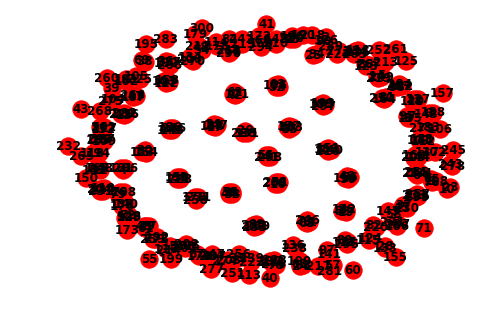

In [33]:
#Networkx
G = nx.Graph()
# G.add_node(1)
# G.add_nodes_from([2, 3])

count = 0
for index, row in df_dominant_topic.iterrows():
    G.add_node(count)
    G.node[count]["text"] = row["Text"]
    G.node[count]["topic"] = row["Dominant_Topic"]
    count += 1
    if count > 300:
        break
        
for i in range(300):
    for j in range(i,300):
        if G.node[i]["topic"] == G.node[j]["topic"] and len(G.edges(i)) < 4:
            G.add_edge(i,j)
        
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
     